## Import Stuff

In [360]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

import SimpleITK as sitk
import time
from os import listdir, walk

## Load images and get spacing for images

In [ ]:
'''
This function reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = world_coordinates - origin # np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def load_itk_spacing(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
      
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return spacing

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [ ]:
data_path = "/Volumes/Backups/data/LUNA16/"

In [ ]:
patient_slice = load_itk(data_path + "subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd")

In [ ]:
annotations = pd.read_csv(data_path + "annotations.csv")

In [ ]:
candidates = pd.read_csv(data_path + "candidates3.csv")

In [ ]:
candidates[4:5]

In [ ]:
annotations


In [ ]:
patient_slice



In [ ]:
patient_slice[0][0][0]


In [ ]:
plt.imshow(patient_slice[0][0])


In [ ]:
plt.show()


In [ ]:
patient_slice[0][0][300]

In [ ]:
patient_slice[2]

In [ ]:
type(image)

In [ ]:
image = sitk.ReadImage(data_path + "subset0//1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd")

In [ ]:
print (image.GetSize())

In [ ]:
print (image.GetOrigin())
print (image.GetSpacing())
print (image.GetDirection())

print (image.GetNumberOfComponentsPerPixel())

In [ ]:
sitk.GetArrayFromImage(image)[0:3].shape

In [ ]:
sitk.GetArrayFromImage(image).shape

In [ ]:
plt.imshow(sitk.GetArrayFromImage(image)[99])

In [ ]:
image.GetSpacing()

In [ ]:
image_array=sitk.GetArrayFromImage(image)

In [ ]:
(image_array).shape


In [ ]:
def get_5dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-2:slice_loc+3]
    return slice


In [ ]:
new_image = get_5dslice(image,91)

In [ ]:
def resample_image(image, image_array, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    real_spacing =  image.GetSpacing()
    spacing = np.array(np.roll(real_spacing,1), dtype=np.float32)

    resize_factor = spacing / new_spacing
    print(spacing)
    new_real_shape = image_array.shape * resize_factor
    new_shape = np.round(new_real_shape)
    print(new_shape)
    real_resize_factor = new_shape / image_array.shape
    new_spacing = spacing / real_resize_factor
    print(new_spacing)
    image_array2 = scipy.ndimage.interpolation.zoom(image_array, real_resize_factor, mode='nearest')
    
    return image_array2, new_spacing


In [ ]:
%time outcome = resample_image(image,new_image)

In [ ]:
for i in range(12):
    plt.imshow(outcome[0][i])
    plt.show()

In [ ]:
def get_3dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-1:slice_loc+2]
    return slice

In [ ]:
get_3dslice(image,4).shape

In [ ]:
def create_slice_array(image):
    num_layers = image.GetSize()[2]-2
    print(num_layers)
    slice_array = np.zeros((image.GetSize()[2]-2,3,512,512))
    for i in range(num_layers):
        slice =  np.zeros((3,512,512))
        slice_array[i] = get_3dslice(image,i+1)
    slice_array = slice_array.transpose(0,2,3,1)
    return slice_array

In [ ]:
%time color_array = create_slice_array(image)

In [ ]:
color_array[92].shape
plt.imshow(color_array[0])

In [ ]:
candidates.values

In [ ]:
annotations.loc[annotations['diameter_mm'].idxmax(),'coordZ']

In [ ]:
annotations

In [ ]:
annotations['diameter_mm'].max()

In [ ]:
#mhdfiles = []
#spacing_list = []
#
#for dirName, subdirList, fileList in os.walk(data_path):
#    for subdirName in subdirList:
#        if subdirName.startswith('sub'):
#            print (subdirName)
#            for dirName2,subdirList2,fileList2 in os.walk(dirName + subdirName):
#                for file in fileList2:
#                    if file.endswith('mhd'):
#                        mhdfiles.append(dirName2 + '/' +file)
#                        templist = (load_itk_spacing(dirName2 + '/' +file))
#                        tempfilelist = [dirName2 + '/' + file, file]
#                        for x in templist:
#                            tempfilelist.append(x)
#                        spacing_list.append(tempfilelist)

In [ ]:
#spacing_df = pd.DataFrame(spacing_list)

In [ ]:
#spacing_df.columns = ["file_loc","seriesuid",'dz','dx','dy']

In [ ]:
#spacing_df['seriesuid'].replace(regex=True,inplace=True,to_replace=r'.mhd',value=r'')


In [475]:
#spacing_df.to_csv('spacing_df.csv', index=False)

In [478]:
spacing_df = pd.read_csv('spacing_df.csv')

In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
spacing_df.hist(column='dz')

In [ ]:
candidates.head()


In [ ]:
annotations.head()

In [ ]:
candidates_full = pd.read_csv(data_path + "candidates.csv")

In [ ]:
candidates_tumor = candidates_full.loc[candidates_full['class'] == 1]

In [ ]:
len (candidates_tumor)

In [ ]:
candidates_tumor.head()

In [ ]:
candidates_class1_df = pd.merge(spacing_df,candidates_tumor, on='seriesuid',how='outer').dropna()

In [ ]:
candidates_class1_df[candidates_class1_df.seriesuid == '1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886'].head()

In [ ]:
def get_voxel_coord(Vc, Vw):
    if (Vc-Vw/2) > 0:
        return (Vc-Vw/2)
    else:
        return 0

In [462]:
def get_voxel_slice_coord(Vc, Vw):
    if (Vc-Vw/2) > 0:
        Vc1 = (Vc-Vw/2)
        Vc2 = (Vc+Vw/2)
        if (Vc2 > 512):
            Vc1 = 512 - Vw
            Vc2 = 512
        return (int(Vc1),int(Vc2))
    else:
        return (0,Vw)
    

In [463]:
# get candidates class 1
for   index,row in candidates_class1_df.iterrows():
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print ("numpyImageShape: " + str(numpyImage.shape))
    print ("numpyOrigin: " + str(numpyOrigin))
    print ("numpySpacing: " + str(numpySpacing))
    print (row[0])
    worldCoord =([row[7],row[6],row[5]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 224
    print("index " + str(index))
    print(voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1]))
    print(numpyImage[voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])].shape)
    patch = numpyImage[voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])]
    print(patch.shape)
    patch = normalizePlanes(patch)
    print (voxelCoord)
    print ('data')
    print ("worldCoord: " + str(worldCoord))
    print ("voxelCoord: " + str(voxelCoord))
    print (numpyOrigin)
    outputDir = 'patches/patches1/'
    file_name = (data_path + outputDir + row[1] +'_'+ str(index) +'_'+ str(patch.shape[0]) +'x'+ str(patch.shape[1]) + '.bc')
    print (file_name)
    
    save_array(file_name, patch)
#    plt.imshow(patch*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()
#    full_img = numpyImage[voxelCoord[0]]
#    full_img = normalizePlanes(full_img)
#    plt.imshow(full_img*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()

numpyImageShape: (119, 512, 512)
numpyOrigin: [-313.75 -190.   -182.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
index 1
33.28 235 459 0 224
(224, 224)
(224, 224)
[  33.28    347.6343  110.538 ]
data
worldCoord: [-230.55, 68.01, -100.46]
voxelCoord: [  33.28    347.6343  110.538 ]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1_224x224.bc


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
index 2
56.864 227 451 288 512
(224, 224)
(224, 224)
[  56.864   339.6328  408.5797]
data
worldCoord: [-122.92, 78.1, 36.54]
voxelCoord: [  56.864   339.6328  408.5797]
[-194.  -108.3 -187.7]
/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_2_224x224.bc
numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
index 3
67.0 180 404 288 512
(224, 224)
(224, 224)
[  67.      292.3867  422.6278]
data
worldCoord: [-110.25, 52.17, 44.25]
voxelCoord: [  67.      292.3867  422.6278]
[-194.  -108.3 -187.7]
/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519

In [ ]:
candidates_class1_df

In [ ]:
candidates_class1_df[0:2]

In [361]:
test_image_good = load_array('/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950_11_224x224.bc')
        

In [362]:
test_image_good.shape

(224, 224)

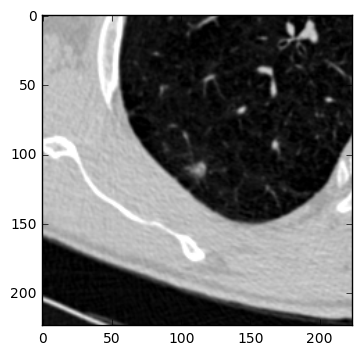

In [363]:
plt.imshow(test_image_good,cmap=plt.cm.gray)

In [364]:
test_image_bad = load_array('/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097_20_224x195.bc')

In [365]:
test_image_bad.shape

(224, 195)

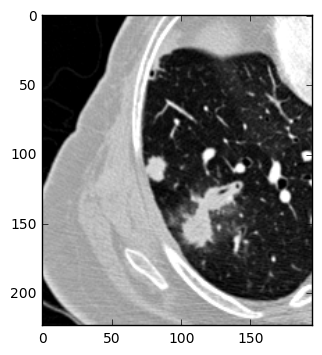

In [366]:
plt.imshow(test_image_bad,cmap=plt.cm.gray)

In [376]:
candidates_class0 = candidates_full.loc[candidates_full['class'] == 0]

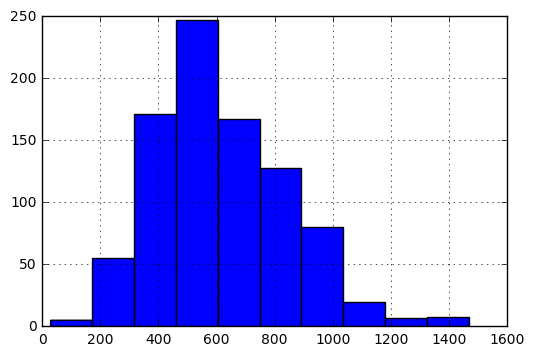

In [377]:
candidates_class0['seriesuid'].value_counts().hist()

In [378]:
spacing_df.head()


file_loc  \
0  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566580315150620007448...   
1  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...   
2  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
3  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111721656746612213819205...   
4  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1227639138967614943718226...   

                                                          seriesuid     dz  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260  2.500   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492  2.500   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  1.250   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987  0.625   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720  2.500   

         dx        dy  
0  0.761719  0.761719  
1  0.742188  0.742188  
2  0.548828  0.548828  
3  0.742188  0.742188  
4  0.615234  0.615234

In [379]:
candidates_class0_df = pd.merge( spacing_df[['file_loc','seriesuid']],candidates_class0, on=['seriesuid'],how = 'inner')

In [380]:
len(candidates_class0_df)

549714

In [384]:
candidates_class0_short_df= (candidates_class0_df.sample(n=2000))

In [464]:
candidates_class0_short_df.head(10)

file_loc  \
369231  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.3169114758862630320098408...   
291210  /Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.1766383489584257929891252...   
322963  /Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.5532419018089465776448502...   
60911   /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.1136977089912604543106230...   
89511   /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2757663186369442977723609...   
84854   /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2430942735182133821557702...   
282955  /Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.1331327220520530019030317...   
424867  /Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.3159182646763774181205783...   
163377  /Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.9228528471248799978259978...   
367059  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.3099559995223386514291182...   

                                                               seriesuid  \
369231  1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684   
291210  1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419   
322963  1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647   
60911   1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679   
89511   1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907   
84854   1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147   
282955  1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878   
424867  1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325   
163377  1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124879997825997808179   
367059  1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446   

           coordX      coordY      coordZ  class  
369231  70.480000 -130.510000 -136.230000      0  
291210 -73.510000   17.840000 -228.670000      0  
322963 -53.850000   -3.140000  -59.700000      0  
60911   25.991419  113.627655 -178.638866      0  
89511  -40.770000    2.980000 -125.240000      0  
84854   45.990000  -52.880000 -241.660000      0  
282955 -49.207378   51.309377  -77.810242      0  
424867 -53.880000   -0.690000 -303.880000      0  
163377 -94.250000  -18.130000 -114.130000      0  
367059 -43.430000   72.880000 -118.750000      0

In [466]:
# get candidates class 0 
for   index,row in candidates_class0_short_df.iterrows():
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print ("numpyImageShape: " + str(numpyImage.shape))
    print ("numpyOrigin: " + str(numpyOrigin))
    print ("numpySpacing: " + str(numpySpacing))
    print (row[0])
    worldCoord =([row[4],row[3],row[2]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 224
    print("index " + str(index))
    print(voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1]))
    print(numpyImage[voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])].shape)
    patch = numpyImage[voxelCoord[0],(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[1],voxelWidth)[1]),(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[0]):(get_voxel_slice_coord(voxelCoord[2],voxelWidth)[1])]
    print(patch.shape)
    patch = normalizePlanes(patch)
    print (voxelCoord)
    print ('data')
    print ("worldCoord: " + str(worldCoord))
    print ("voxelCoord: " + str(voxelCoord))
    print (numpyOrigin)
    outputDir = 'patches/patches0/'
    file_name = (data_path + outputDir + row[1] +'_'+ str(index) +'_'+ str(patch.shape[0]) +'x'+ str(patch.shape[1]) + '.bc')
    print (file_name)
    
    %time save_array(file_name, patch)
#    plt.imshow(patch*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()
#    full_img = numpyImage[voxelCoord[0]]
#    full_img = normalizePlanes(full_img)
#    plt.imshow(full_img*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()

numpyImageShape: (206, 512, 512)
numpyOrigin: [-401.     -354.6484 -167.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684.mhd
index 369231
147.094448341 206 430 226 450
(224, 224)
(224, 224)
[ 147.0944  318.7747  338.6716]
data
worldCoord: [-136.23, -130.51, 70.48]
voxelCoord: [ 147.0944  318.7747  338.6716]
[-401.     -354.6484 -167.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684_369231_224x224.bc
CPU times: user 1.88 ms, sys: 3.7 ms, total: 5.59 ms
Wall time: 5.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-335.45 -151.5  -142.1 ]
numpySpacing: [ 1.25    0.5918  0.5918]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419.mhd
index 291210
85.4240096 174 398 3 227
(224, 224)
(224, 224)
[  85.424   286.1454  115.9012]
data
worldCoord: [-228.67, 17.84, -73.51]
voxelCoord: [  85.424   286.1454  115.9012]
[-335.45 -151.5  -142.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419_291210_224x224.bc
CPU times: user 1.89 ms, sys: 2.15 ms, total: 4.04 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-333.56 -174.   -181.3 ]
numpySpacing: [ 2.5     0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647.mhd
index 322963
109.5439992 139 363 75 299
(224, 224)
(224, 224)
[ 109.544   251.3801  187.5125]
data
worldCoord: [-59.7, -3.14, -53.85]
voxelCoord: [ 109.544   251.3801  187.5125]
[-333.56 -174.   -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647_322963_224x224.bc
CPU times: user 1.79 ms, sys: 2.36 ms, total: 4.15 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (111, 512, 512)
numpyOrigin: [-293.75 -167.8  -223.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
index 60911
46.0444536312 248 472 206 430
(224, 224)
(224, 224)
[  46.0445  360.2274  318.965 ]
data
worldCoord: [-178.638865922, 113.627655429, 25.9914191106]
voxelCoord: [  46.0445  360.2274  318.965 ]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_60911_224x224.bc
CPU times: user 2.06 ms, sys: 3.47 ms, total: 5.53 ms
Wall time: 6.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-310.25 -151.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907.mhd
index 89511
296.016 106 330 86 310
(224, 224)
(224, 224)
[ 296.016   218.9938  198.016 ]
data
worldCoord: [-125.24, 2.98, -40.77]
voxelCoord: [ 296.016   218.9938  198.016 ]
[-310.25 -151.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907_89511_224x224.bc
CPU times: user 1.84 ms, sys: 3.56 ms, total: 5.4 ms
Wall time: 6.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (150, 512, 512)
numpyOrigin: [-414.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
index 84854
69.236 76 300 213 437
(224, 224)
(224, 224)
[  69.236   188.3136  325.4912]
data
worldCoord: [-241.66, -52.88, 45.99]
voxelCoord: [  69.236   188.3136  325.4912]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84854_224x224.bc
CPU times: user 2.21 ms, sys: 2.09 ms, total: 4.31 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-261.455 -154.    -165.4  ]
numpySpacing: [ 2.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878.mhd
index 282955
91.8223779023 227 451 79 303
(224, 224)
(224, 224)
[  91.8224  339.0915  191.9051]
data
worldCoord: [-77.8102421415, 51.3093772063, -49.207377638400004]
voxelCoord: [  91.8224  339.0915  191.9051]
[-261.455 -154.    -165.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878_282955_224x224.bc
CPU times: user 1.71 ms, sys: 2.02 ms, total: 3.73 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-414.5 -190.  -184.3]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325.mhd
index 424867
44.248 143 367 63 287
(224, 224)
(224, 224)
[  44.248   255.0702  175.7237]
data
worldCoord: [-303.88, -0.69, -53.88]
voxelCoord: [  44.248   255.0702  175.7237]
[-414.5 -190.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325_424867_224x224.bc
CPU times: user 1.64 ms, sys: 1.99 ms, total: 3.64 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (557, 512, 512)
numpyOrigin: [-343.52 -166.5  -194.1 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124879997825997808179.mhd
index 163377
367.0239824 99 323 30 254
(224, 224)
(224, 224)
[ 367.024   211.0151  142.0089]
data
worldCoord: [-114.13, -18.13, -94.25]
voxelCoord: [ 367.024   211.0151  142.0089]
[-343.52 -166.5  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124879997825997808179_163377_224x224.bc
CPU times: user 1.96 ms, sys: 2.02 ms, total: 3.98 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (417, 512, 512)
numpyOrigin: [-250.005 -191.5   -192.5  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446.mhd
index 367059
210.008008 264 488 100 324
(224, 224)
(224, 224)
[ 210.008   376.0071  212.0107]
data
worldCoord: [-118.75, 72.88, -43.43]
voxelCoord: [ 210.008   376.0071  212.0107]
[-250.005 -191.5   -192.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446_367059_224x224.bc
CPU times: user 1.87 ms, sys: 2.12 ms, total: 4 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-336.41 -153.   -174.9 ]
numpySpacing: [ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213.mhd
index 393822
103.55287562 186 410 103 327
(224, 224)
(224, 224)
[ 103.5529  298.5858  215.5442]
data
worldCoord: [-77.5278149496, 40.6143411202, -35.1329698234]
voxelCoord: [ 103.5529  298.5858  215.5442]
[-336.41 -153.   -174.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213_393822_224x224.bc
CPU times: user 2.07 ms, sys: 2.18 ms, total: 4.26 ms
Wall time: 4.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352965
116.091506792 159 383 245 469
(224, 224)
(224, 224)
[ 116.0915  271.8353  357.3909]
data
worldCoord: [-37.5212330203, 11.134176753499998, 60.3904682599]
voxelCoord: [ 116.0915  271.8353  357.3909]
[-327.75 -180.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389_352965_224x224.bc
CPU times: user 3.17 ms, sys: 2.99 ms, total: 6.15 ms
Wall time: 12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-293.055 -170.    -165.3  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664409965623578819357819577077.mhd
index 432296
40.73726 117 341 98 322
(224, 224)
(224, 224)
[  40.7373  229.4532  210.9313]
data
worldCoord: [-211.580473, -17.62887536, -25.22850583]
voxelCoord: [  40.7373  229.4532  210.9313]
[-293.055 -170.    -165.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.664409965623578819357819577077_432296_224x224.bc
CPU times: user 1.67 ms, sys: 2.16 ms, total: 3.83 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (558, 512, 512)
numpyOrigin: [ 642.     -348.6758 -169.6758]
numpySpacing: [ 0.7     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.204303454658845815034433453512.mhd
index 184932
265.801616955 177 401 52 276
(224, 224)
(224, 224)
[ 265.8016  289.1943  164.4829]
data
worldCoord: [828.0611287, -161.15132219999998, -63.01889925]
voxelCoord: [ 265.8016  289.1943  164.4829]
[ 642.     -348.6758 -169.6758]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204303454658845815034433453512_184932_224x224.bc
CPU times: user 1.74 ms, sys: 2.25 ms, total: 3.99 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-379.  -210.  -228.8]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264.mhd
index 506440
51.6617800204 114 338 0 224
(224, 224)
(224, 224)
[  51.6618  226.961   102.3582]
data
worldCoord: [-249.845549949, -23.8211761514, -144.834319586]
voxelCoord: [  51.6618  226.961   102.3582]
[-379.  -210.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264_506440_224x224.bc
CPU times: user 2.18 ms, sys: 2.39 ms, total: 4.57 ms
Wall time: 5.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-361.     -381.6289 -179.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
index 373990
142.539160287 185 409 230 454
(224, 224)
(224, 224)
[ 142.5392  297.9996  342.0775]
data
worldCoord: [-104.42951828, -160.457337564, 74.2567190556]
voxelCoord: [ 142.5392  297.9996  342.0775]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373990_224x224.bc
CPU times: user 3.99 ms, sys: 2.79 ms, total: 6.78 ms
Wall time: 7.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-397.06 -185.5  -181.3 ]
numpySpacing: [ 2.5     0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136.mhd
index 532678
28.26059997 253 477 288 512
(224, 224)
(224, 224)
[  28.2606  365.6053  409.1567]
data
worldCoord: [-326.408498075, 79.4208813176, 115.178609256]
voxelCoord: [  28.2606  365.6053  409.1567]
[-397.06 -185.5  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136_532678_224x224.bc
CPU times: user 2.19 ms, sys: 1.88 ms, total: 4.07 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (411, 512, 512)
numpyOrigin: [-661.5      26.5429 -181.5   ]
numpySpacing: [ 1.      0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300392272203629213913702120739.mhd
index 531667
197.09 90 314 94 318
(224, 224)
(224, 224)
[ 197.09    202.4419  206.741 ]
data
worldCoord: [-464.41, 159.0, -46.23]
voxelCoord: [ 197.09    202.4419  206.741 ]
[-661.5      26.5429 -181.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300392272203629213913702120739_531667_224x224.bc
CPU times: user 1.99 ms, sys: 1.89 ms, total: 3.88 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-316.25 -210.   -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
index 399950
40.8319999216 183 407 288 512
(224, 224)
(224, 224)
[  40.832   295.8079  400.3903]
data
worldCoord: [-214.170000196, 32.654799777600005, 118.444999771]
voxelCoord: [  40.832   295.8079  400.3903]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_399950_224x224.bc
CPU times: user 2.09 ms, sys: 1.94 ms, total: 4.03 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-345.  -135.5 -155.7]
numpySpacing: [ 2.5     0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386.mhd
index 390442
68.1790880812 138 362 72 296
(224, 224)
(224, 224)
[  68.1791  250.1425  184.9491]
data
worldCoord: [-174.552279797, 6.67074376109, -50.5824798489]
voxelCoord: [  68.1791  250.1425  184.9491]
[-345.  -135.5 -155.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386_390442_224x224.bc
CPU times: user 1.68 ms, sys: 2.12 ms, total: 3.81 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-348. -206. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671.mhd
index 213492
104.828 188 412 82 306
(224, 224)
(224, 224)
[ 104.828   300.3904  194.5856]
data
worldCoord: [-85.93, 28.68, -47.98]
voxelCoord: [ 104.828   300.3904  194.5856]
[-348. -206. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671_213492_224x224.bc
CPU times: user 2.06 ms, sys: 2.1 ms, total: 4.16 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-380.25 -208.4  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268.mhd
index 227397
118.844 168 392 196 420
(224, 224)
(224, 224)
[ 118.844   280.3567  308.5655]
data
worldCoord: [-83.14, 21.58, 43.12]
voxelCoord: [ 118.844   280.3567  308.5655]
[-380.25 -208.4  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268_227397_224x224.bc
CPU times: user 1.96 ms, sys: 1.88 ms, total: 3.85 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-236.455 -152.4   -172.1  ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021.mhd
index 510138
217.19938368 153 377 87 311
(224, 224)
(224, 224)
[ 217.1994  265.8023  199.6753]
data
worldCoord: [-100.7053872, 24.10923891, -39.50321142]
voxelCoord: [ 217.1994  265.8023  199.6753]
[-236.455 -152.4   -172.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021_510138_224x224.bc
CPU times: user 1.74 ms, sys: 2.14 ms, total: 3.88 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-342.885 -190.    -169.3  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.mhd
index 410650
44.3774853988 257 481 41 265
(224, 224)
(224, 224)
[  44.3775  369.8869  153.7204]
data
worldCoord: [-231.941296503, 84.5256405234, -55.2105816954]
voxelCoord: [  44.3775  369.8869  153.7204]
[-342.885 -190.    -169.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826_410650_224x224.bc
CPU times: user 1.97 ms, sys: 2.21 ms, total: 4.18 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296777
285.51956464 131 355 101 325
(224, 224)
(224, 224)
[ 285.5196  243.0918  213.8429]
data
worldCoord: [-113.8602701, -9.076097504, -27.5416767]
voxelCoord: [ 285.5196  243.0918  213.8429]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296777_224x224.bc
CPU times: user 1.67 ms, sys: 2.01 ms, total: 3.68 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-228.78 -128.9  -162.1 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.mhd
index 118365
238.0159984 153 377 92 316
(224, 224)
(224, 224)
[ 238.016  265.008  204.016]
data
worldCoord: [-80.02, 36.73, -34.59]
voxelCoord: [ 238.016  265.008  204.016]
[-228.78 -128.9  -162.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636_118365_224x224.bc
CPU times: user 1.72 ms, sys: 2.1 ms, total: 3.82 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (328, 512, 512)
numpyOrigin: [ 1604.      -142.0309  -162.8162]
numpySpacing: [ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
index 58415
177.904054 158 382 248 472
(224, 224)
(224, 224)
[ 177.9041  270.0632  360.6512]
data
worldCoord: [1781.9040539999999, 58.40657093, 104.8545781]
voxelCoord: [ 177.9041  270.0632  360.6512]
[ 1604.      -142.0309  -162.8162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375_58415_224x224.bc
CPU times: user 1.86 ms, sys: 1.92 ms, total: 3.78 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-380.5 -150.8 -177.8]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286.mhd
index 113853
95.7112499096 99 323 147 371
(224, 224)
(224, 224)
[  95.7112  211.6248  259.7476]
data
worldCoord: [-141.221875226, -10.2679752176, -5.31150022288]
voxelCoord: [  95.7112  211.6248  259.7476]
[-380.5 -150.8 -177.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286_113853_224x224.bc
CPU times: user 1.71 ms, sys: 1.9 ms, total: 3.61 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (254, 512, 512)
numpyOrigin: [-343.37 -177.4  -180.  ]
numpySpacing: [ 1.25    0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142.mhd
index 262935
179.271996 178 402 20 244
(224, 224)
(224, 224)
[ 179.272   290.5942  132.0109]
data
worldCoord: [-119.28, 13.87, -93.11]
voxelCoord: [ 179.272   290.5942  132.0109]
[-343.37 -177.4  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142_262935_224x224.bc
CPU times: user 1.87 ms, sys: 2.43 ms, total: 4.29 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-327.37 -138.5  -140.1 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161.mhd
index 365655
75.6237626324 70 294 230 454
(224, 224)
(224, 224)
[  75.6238  182.6183  342.6308]
data
worldCoord: [-138.310588419, -31.4970001884, 60.6604115409]
voxelCoord: [  75.6238  182.6183  342.6308]
[-327.37 -138.5  -140.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161_365655_224x224.bc
CPU times: user 1.94 ms, sys: 2.25 ms, total: 4.2 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-289.36 -127.6  -155.3 ]
numpySpacing: [ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
index 142669
144.348503411 208 432 221 445
(224, 224)
(224, 224)
[ 144.3485  320.2606  333.4784]
data
worldCoord: [-108.924372944, 47.5424953806, 27.0710011143]
voxelCoord: [ 144.3485  320.2606  333.4784]
[-289.36 -127.6  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_142669_224x224.bc
CPU times: user 1.81 ms, sys: 2.14 ms, total: 3.95 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (247, 512, 512)
numpyOrigin: [-311.75 -178.   -143.2 ]
numpySpacing: [ 1.25    0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.900182736599353600185270496549.mhd
index 437126
99.928 160 384 55 279
(224, 224)
(224, 224)
[  99.928   272.356   167.7773]
data
worldCoord: [-186.84, -2.99, -35.39]
voxelCoord: [  99.928   272.356   167.7773]
[-311.75 -178.   -143.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.900182736599353600185270496549_437126_224x224.bc
CPU times: user 1.79 ms, sys: 2.16 ms, total: 3.95 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (187, 512, 512)
numpyOrigin: [-318.8    -362.6289 -176.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687.mhd
index 351610
37.400463828 232 456 243 467
(224, 224)
(224, 224)
[  37.4005  344.6856  355.6756]
data
worldCoord: [-251.47916689299998, -106.80755576700001, 87.34906645459999]
voxelCoord: [  37.4005  344.6856  355.6756]
[-318.8    -362.6289 -176.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687_351610_224x224.bc
CPU times: user 1.77 ms, sys: 1.99 ms, total: 3.76 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (376, 512, 512)
numpyOrigin: [-316.5    -252.7695 -120.7695]
numpySpacing: [ 0.7     0.4609  0.4609]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
index 530682
160.014288439 143 367 108 332
(224, 224)
(224, 224)
[ 160.0143  255.2614  220.3108]
data
worldCoord: [-204.49, -135.11, -19.22]
voxelCoord: [ 160.0143  255.2614  220.3108]
[-316.5    -252.7695 -120.7695]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227_530682_224x224.bc
CPU times: user 1.67 ms, sys: 2.03 ms, total: 3.7 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-388.75 -200.2  -185.2 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103.mhd
index 71032
67.7551999008 167 391 8 232
(224, 224)
(224, 224)
[  67.7552  279.6562  120.3891]
data
worldCoord: [-219.362000248, -3.56673355366, -100.551400211]
voxelCoord: [  67.7552  279.6562  120.3891]
[-388.75 -200.2  -185.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103_71032_224x224.bc
CPU times: user 1.81 ms, sys: 2.28 ms, total: 4.08 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-300.  -152.4 -153.4]
numpySpacing: [ 1.25    0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663.mhd
index 363175
154.496 135 359 252 476
(224, 224)
(224, 224)
[ 154.496   247.3846  364.7343]
data
worldCoord: [-106.88, -1.65, 68.86]
voxelCoord: [ 154.496   247.3846  364.7343]
[-300.  -152.4 -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663_363175_224x224.bc
CPU times: user 4.16 ms, sys: 4.38 ms, total: 8.54 ms
Wall time: 7.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-325.5 -210.  -211. ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377.mhd
index 254962
74.0473857264 141 365 266 490
(224, 224)
(224, 224)
[  74.0474  253.1577  378.6926]
data
worldCoord: [-140.381535684, -2.33170809537, 99.64609713860001]
voxelCoord: [  74.0474  253.1577  378.6926]
[-325.5 -210.  -211. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377_254962_224x224.bc
CPU times: user 1.9 ms, sys: 2.17 ms, total: 4.07 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (183, 512, 512)
numpyOrigin: [ 1250.5     -239.2578  -258.789 ]
numpySpacing: [ 2.     0.946  0.946]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd
index 192528
84.069309575 179 403 222 446
(224, 224)
(224, 224)
[  84.0693  291.2658  334.9405]
data
worldCoord: [1418.63861915, 36.279637836999996, 58.0647460617]
voxelCoord: [  84.0693  291.2658  334.9405]
[ 1250.5     -239.2578  -258.789 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969_192528_224x224.bc
CPU times: user 2.75 ms, sys: 2.68 ms, total: 5.43 ms
Wall time: 5.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (201, 512, 512)
numpyOrigin: [-410.5   -308.668 -188.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.254957696184671649675053562027.mhd
index 463083
140.900003733 213 437 43 267
(224, 224)
(224, 224)
[ 140.9     325.1621  155.1932]
data
worldCoord: [-156.88, -92.74, -85.61]
voxelCoord: [ 140.9     325.1621  155.1932]
[-410.5   -308.668 -188.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254957696184671649675053562027_463083_224x224.bc
CPU times: user 1.93 ms, sys: 2.27 ms, total: 4.2 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (292, 512, 512)
numpyOrigin: [-323.365 -171.2   -164.   ]
numpySpacing: [ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250.mhd
index 122442
114.214915678 207 431 93 317
(224, 224)
(224, 224)
[ 114.2149  319.6752  205.3893]
data
worldCoord: [-180.596345402, 34.840593186599996, -31.620213920799998]
voxelCoord: [ 114.2149  319.6752  205.3893]
[-323.365 -171.2   -164.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250_122442_224x224.bc
CPU times: user 1.88 ms, sys: 2.08 ms, total: 3.96 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-316.345 -150.    -166.6  ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603.mhd
index 100797
93.2975005 216 440 225 449
(224, 224)
(224, 224)
[  93.2975  328.9768  337.3395]
data
worldCoord: [-129.75, 42.76, 31.06]
voxelCoord: [  93.2975  328.9768  337.3395]
[-316.345 -150.    -166.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603_100797_224x224.bc
CPU times: user 1.92 ms, sys: 2.04 ms, total: 3.95 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-320.  -195.9 -201.6]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
index 83572
189.216 128 352 183 407
(224, 224)
(224, 224)
[ 189.216   240.7004  295.6049]
data
worldCoord: [-83.48, -36.06, -5.3]
voxelCoord: [ 189.216   240.7004  295.6049]
[-320.  -195.9 -201.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066_83572_224x224.bc
CPU times: user 1.82 ms, sys: 2.24 ms, total: 4.06 ms
Wall time: 20.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-316.25 -210.   -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
index 400415
34.6390081772 96 320 288 512
(224, 224)
(224, 224)
[  34.639   208.9295  405.9998]
data
worldCoord: [-229.65247955700002, -38.612638265, 123.046553495]
voxelCoord: [  34.639   208.9295  405.9998]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_400415_224x224.bc
CPU times: user 2.16 ms, sys: 2.3 ms, total: 4.46 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-333.625 -133.8   -127.6  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679.mhd
index 96011
283.028169014 136 360 51 275
(224, 224)
(224, 224)
[ 283.0282  248.1409  163.9302]
data
worldCoord: [-156.732394366, 1.9020746478900001, -37.9506623239]
voxelCoord: [ 283.0282  248.1409  163.9302]
[-333.625 -133.8   -127.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679_96011_224x224.bc
CPU times: user 4.86 ms, sys: 4.54 ms, total: 9.4 ms
Wall time: 45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-323.2 -161.1 -176.2]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202476538079060560282495099956.mhd
index 183935
31.5884344616 146 370 288 512
(224, 224)
(224, 224)
[  31.5884  258.1108  424.074 ]
data
worldCoord: [-244.22892584599998, 10.3015962266, 105.411437804]
voxelCoord: [  31.5884  258.1108  424.074 ]
[-323.2 -161.1 -176.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202476538079060560282495099956_183935_224x224.bc
CPU times: user 2.01 ms, sys: 2.31 ms, total: 4.32 ms
Wall time: 39.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (209, 512, 512)
numpyOrigin: [-279.75 -177.5  -145.4 ]
numpySpacing: [ 1.25    0.6934  0.6934]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
index 19160
59.0 151 375 136 360
(224, 224)
(224, 224)
[  59.      263.572   248.4283]
data
worldCoord: [-206.0, 5.25, 26.85]
voxelCoord: [  59.      263.572   248.4283]
[-279.75 -177.5  -145.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223_19160_224x224.bc
CPU times: user 2.03 ms, sys: 2.22 ms, total: 4.26 ms
Wall time: 44.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [-291.16 -163.1  -180.3 ]
numpySpacing: [ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896.mhd
index 104387
74.255002 68 292 69 293
(224, 224)
(224, 224)
[  74.255   180.3763  181.3449]
data
worldCoord: [-142.65, -32.75, -49.25]
voxelCoord: [  74.255   180.3763  181.3449]
[-291.16 -163.1  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896_104387_224x224.bc
CPU times: user 1.93 ms, sys: 2.56 ms, total: 4.48 ms
Wall time: 39.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-368.5 -219.5 -241. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
index 305755
56.3108506184 206 430 13 237
(224, 224)
(224, 224)
[  56.3109  318.1138  125.5885]
data
worldCoord: [-227.72287345400002, 53.8790885121, -133.07238050200002]
voxelCoord: [  56.3109  318.1138  125.5885]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_305755_224x224.bc
CPU times: user 2.48 ms, sys: 2.56 ms, total: 5.04 ms
Wall time: 33.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453140
113.307299721 176 400 84 308
(224, 224)
(224, 224)
[ 113.3073  288.517   196.3448]
data
worldCoord: [-131.115875349, 26.6739514846, -78.9360019147]
voxelCoord: [ 113.3073  288.517   196.3448]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453140_224x224.bc
CPU times: user 1.99 ms, sys: 2.23 ms, total: 4.22 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (326, 512, 512)
numpyOrigin: [-506.6    -277.7266 -135.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.197987940182806628828566429132.mhd
index 79190
142.33 236 460 288 512
(224, 224)
(224, 224)
[ 142.33    348.172   410.8737]
data
worldCoord: [-364.27, -87.32, 88.97]
voxelCoord: [ 142.33    348.172   410.8737]
[-506.6    -277.7266 -135.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197987940182806628828566429132_79190_224x224.bc
CPU times: user 2.05 ms, sys: 2.09 ms, total: 4.14 ms
Wall time: 19.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (136, 512, 512)
numpyOrigin: [ 1288.5     -188.2812  -184.375 ]
numpySpacing: [ 2.     0.741  0.741]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249.mhd
index 441332
73.635 205 429 0 224
(224, 224)
(224, 224)
[  73.635   317.0462   99.386 ]
data
worldCoord: [1435.77, 46.65, -110.73]
voxelCoord: [  73.635   317.0462   99.386 ]
[ 1288.5     -188.2812  -184.375 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249_441332_224x224.bc
CPU times: user 2.11 ms, sys: 2.4 ms, total: 4.52 ms
Wall time: 57.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-337.49 -160.   -160.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904.mhd
index 300034
93.607996 116 340 202 426
(224, 224)
(224, 224)
[  93.608  228.56   314.816]
data
worldCoord: [-103.47, -17.15, 36.76]
voxelCoord: [  93.608  228.56   314.816]
[-337.49 -160.   -160.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904_300034_224x224.bc
CPU times: user 2.03 ms, sys: 2.39 ms, total: 4.42 ms
Wall time: 5.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (337, 512, 512)
numpyOrigin: [-373.6    -350.6582 -180.6582]
numpySpacing: [ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658.mhd
index 455781
173.06 270 494 231 455
(224, 224)
(224, 224)
[ 173.06    382.988   343.0374]
data
worldCoord: [-200.54, -88.85, 53.84]
voxelCoord: [ 173.06    382.988   343.0374]
[-373.6    -350.6582 -180.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658_455781_224x224.bc
CPU times: user 1.9 ms, sys: 2.34 ms, total: 4.24 ms
Wall time: 25.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-250.74 -147.1  -174.7 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762.mhd
index 237723
122.016008 232 456 85 309
(224, 224)
(224, 224)
[ 122.016   344.9979  197.0147]
data
worldCoord: [-174.48, 82.0, -43.87]
voxelCoord: [ 122.016   344.9979  197.0147]
[-250.74 -147.1  -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762_237723_224x224.bc
CPU times: user 1.76 ms, sys: 1.96 ms, total: 3.72 ms
Wall time: 28.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (231, 512, 512)
numpyOrigin: [-856.3       8.8634 -155.8553]
numpySpacing: [ 1.     0.666  0.666]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.842980983137518332429408284002.mhd
index 328229
157.6160617 185 409 95 319
(224, 224)
(224, 224)
[ 157.6161  297.2552  207.3175]
data
worldCoord: [-698.6839262999999, 206.84001569999998, -17.77863181]
voxelCoord: [ 157.6161  297.2552  207.3175]
[-856.3       8.8634 -155.8553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.842980983137518332429408284002_328229_224x224.bc
CPU times: user 1.9 ms, sys: 2.14 ms, total: 4.05 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-310.  -181.5 -213. ]
numpySpacing: [ 1.25    0.8262  0.8262]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069.mhd
index 342062
76.4444023512 189 413 35 259
(224, 224)
(224, 224)
[  76.4444  301.151   147.6434]
data
worldCoord: [-214.444497061, 67.3025545216, -91.02117631590001]
voxelCoord: [  76.4444  301.151   147.6434]
[-310.  -181.5 -213. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069_342062_224x224.bc
CPU times: user 2.19 ms, sys: 2.36 ms, total: 4.55 ms
Wall time: 4.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-367.    -317.707 -149.707]
numpySpacing: [ 0.7     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616.mhd
index 407726
218.014289427 121 345 86 310
(224, 224)
(224, 224)
[ 218.0143  233.0232  198.0195]
data
worldCoord: [-214.39, -181.17, -33.68]
voxelCoord: [ 218.0143  233.0232  198.0195]
[-367.    -317.707 -149.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616_407726_224x224.bc
CPU times: user 1.71 ms, sys: 2.12 ms, total: 3.83 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (178, 512, 512)
numpyOrigin: [-203.38 -180.   -181.1 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951.mhd
index 433423
85.0700039148 136 360 4 228
(224, 224)
(224, 224)
[  85.07    248.8478  116.7335]
data
worldCoord: [-97.0425001065, -5.02889296448, -99.02178582200001]
voxelCoord: [  85.07    248.8478  116.7335]
[-203.38 -180.   -181.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951_433423_224x224.bc
CPU times: user 2.03 ms, sys: 2.29 ms, total: 4.32 ms
Wall time: 24.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-360.75 -142.1  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
index 179100
136.86781671 134 358 215 439
(224, 224)
(224, 224)
[ 136.8678  246.0745  327.4293]
data
worldCoord: [-189.66522911299998, 30.9210920436, 50.223759028100005]
voxelCoord: [ 136.8678  246.0745  327.4293]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_179100_224x224.bc
CPU times: user 1.94 ms, sys: 3.45 ms, total: 5.39 ms
Wall time: 73.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-354.5 -180.2 -214.4]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.mhd
index 169290
197.549838068 142 366 64 288
(224, 224)
(224, 224)
[ 197.5498  254.9859  176.7076]
data
worldCoord: [-107.562702415, 9.04744745997, -83.2497032822]
voxelCoord: [ 197.5498  254.9859  176.7076]
[-354.5 -180.2 -214.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_169290_224x224.bc
CPU times: user 2.04 ms, sys: 2.82 ms, total: 4.86 ms
Wall time: 20.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296495
134.492552632 157 381 288 512
(224, 224)
(224, 224)
[ 134.4926  269.8655  431.6443]
data
worldCoord: [-208.252152605, 9.74915973945, 125.599881669]
voxelCoord: [ 134.4926  269.8655  431.6443]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296495_224x224.bc
CPU times: user 2.14 ms, sys: 2.41 ms, total: 4.55 ms
Wall time: 40.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (275, 512, 512)
numpyOrigin: [-591.      -64.1393 -194.6058]
numpySpacing: [ 1.      0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757.mhd
index 247626
131.5087254 240 464 238 462
(224, 224)
(224, 224)
[ 131.5087  352.4602  350.8753]
data
worldCoord: [-459.49127460000005, 191.2566741, 59.64170418]
voxelCoord: [ 131.5087  352.4602  350.8753]
[-591.      -64.1393 -194.6058]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757_247626_224x224.bc
CPU times: user 1.84 ms, sys: 2.27 ms, total: 4.11 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (230, 512, 512)
numpyOrigin: [-297.5 -187.5 -187.5]
numpySpacing: [ 1.25    0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943.mhd
index 332449
38.808 79 303 0 224
(224, 224)
(224, 224)
[  38.808   191.4197   86.1389]
data
worldCoord: [-248.99, -47.3, -124.41]
voxelCoord: [  38.808   191.4197   86.1389]
[-297.5 -187.5 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943_332449_224x224.bc
CPU times: user 1.91 ms, sys: 2.43 ms, total: 4.34 ms
Wall time: 5.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-322.5 -142.5 -140.7]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
index 145404
34.108 251 475 230 454
(224, 224)
(224, 224)
[  34.108   363.5557  342.1775]
data
worldCoord: [-237.23, 59.87, 49.77]
voxelCoord: [  34.108   363.5557  342.1775]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_145404_224x224.bc
CPU times: user 2.05 ms, sys: 2.46 ms, total: 4.51 ms
Wall time: 54.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (142, 512, 512)
numpyOrigin: [-364.5 -197.1 -236.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111.mhd
index 264245
66.216 179 403 113 337
(224, 224)
(224, 224)
[  66.216   291.4745  225.6702]
data
worldCoord: [-198.96, 42.0, -51.78]
voxelCoord: [  66.216   291.4745  225.6702]
[-364.5 -197.1 -236.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111_264245_224x224.bc
CPU times: user 1.79 ms, sys: 2.31 ms, total: 4.11 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-377.5 -200.  -189.1]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
index 318575
60.304 48 272 221 445
(224, 224)
(224, 224)
[  60.304  160.512  333.568]
data
worldCoord: [-226.74, -74.6, 71.5]
voxelCoord: [  60.304  160.512  333.568]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318575_224x224.bc
CPU times: user 1.8 ms, sys: 2.39 ms, total: 4.2 ms
Wall time: 34.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-367.5 -192.  -173. ]
numpySpacing: [ 2.5   0.75  0.75]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.246178337114401749164850220976.mhd
index 461333
108.426666586 120 344 240 464
(224, 224)
(224, 224)
[ 108.4267  232.0531  352.058 ]
data
worldCoord: [-96.43333353540001, -17.9601854119, 91.04351830700001]
voxelCoord: [ 108.4267  232.0531  352.058 ]
[-367.5 -192.  -173. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246178337114401749164850220976_461333_224x224.bc
CPU times: user 2.98 ms, sys: 2.83 ms, total: 5.82 ms
Wall time: 28.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (347, 512, 512)
numpyOrigin: [-308.6    -347.6875 -151.6875]
numpySpacing: [ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556.mhd
index 144272
150.03 245 469 288 512
(224, 224)
(224, 224)
[ 150.03   357.404  432.46 ]
data
worldCoord: [-158.57, -124.31, 118.6]
voxelCoord: [ 150.03   357.404  432.46 ]
[-308.6    -347.6875 -151.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556_144272_224x224.bc
CPU times: user 2.08 ms, sys: 2.29 ms, total: 4.37 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-350.33 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
index 127780
79.5119948 243 467 199 423
(224, 224)
(224, 224)
[  79.512   355.6124  311.7796]
data
worldCoord: [-151.55, 70.04, 43.92]
voxelCoord: [  79.512   355.6124  311.7796]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_127780_224x224.bc
CPU times: user 2.14 ms, sys: 2.39 ms, total: 4.53 ms
Wall time: 42.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (636, 512, 512)
numpyOrigin: [-368.5    -374.1553 -182.1553]
numpySpacing: [ 0.5     0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286.mhd
index 72035
196.02 154 378 228 452
(224, 224)
(224, 224)
[ 196.02    266.0156  340.0018]
data
worldCoord: [-270.49, -190.75, 52.26]
voxelCoord: [ 196.02    266.0156  340.0018]
[-368.5    -374.1553 -182.1553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286_72035_224x224.bc
CPU times: user 1.88 ms, sys: 2.16 ms, total: 4.04 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-345.75 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114.mhd
index 454811
94.4 192 416 101 325
(224, 224)
(224, 224)
[  94.4     304.8704  213.4144]
data
worldCoord: [-109.75, 38.18, -33.27]
voxelCoord: [  94.4     304.8704  213.4144]
[-345.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114_454811_224x224.bc
CPU times: user 1.87 ms, sys: 2.61 ms, total: 4.48 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (153, 512, 512)
numpyOrigin: [-270.695 -211.3   -216.   ]
numpySpacing: [ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282.mhd
index 528864
65.4275035 145 369 45 269
(224, 224)
(224, 224)
[  65.4275  257.8996  157.7633]
data
worldCoord: [-139.84, -19.89, -98.91]
voxelCoord: [  65.4275  257.8996  157.7633]
[-270.695 -211.3   -216.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282_528864_224x224.bc
CPU times: user 1.92 ms, sys: 2 ms, total: 3.92 ms
Wall time: 42.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-310.  -241.5 -247.2]
numpySpacing: [ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
index 46111
85.9966369904 236 460 251 475
(224, 224)
(224, 224)
[  85.9966  348.3727  363.6857]
data
worldCoord: [-202.504203762, 87.1405183758, 95.8861581877]
voxelCoord: [  85.9966  348.3727  363.6857]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46111_224x224.bc
CPU times: user 2 ms, sys: 2.26 ms, total: 4.27 ms
Wall time: 29.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (536, 512, 512)
numpyOrigin: [-443.5    -355.6719 -172.6719]
numpySpacing: [ 0.7     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464.mhd
index 498218
279.014290466 284 508 288 512
(224, 224)
(224, 224)
[ 279.0143  396.0105  401.9991]
data
worldCoord: [-248.19, -95.79, 91.14]
voxelCoord: [ 279.0143  396.0105  401.9991]
[-443.5    -355.6719 -172.6719]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464_498218_224x224.bc
CPU times: user 2.19 ms, sys: 2.39 ms, total: 4.59 ms
Wall time: 5.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (345, 512, 512)
numpyOrigin: [-376.5    -292.2295 -136.2295]
numpySpacing: [ 1.     0.541  0.541]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299.mhd
index 398814
133.24 272 496 42 266
(224, 224)
(224, 224)
[ 133.24    384.9972  154.2645]
data
worldCoord: [-243.26, -83.94, -52.77]
voxelCoord: [ 133.24    384.9972  154.2645]
[-376.5    -292.2295 -136.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299_398814_224x224.bc
CPU times: user 2.3 ms, sys: 2.39 ms, total: 4.69 ms
Wall time: 49.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-345.  -135.5 -155.7]
numpySpacing: [ 2.5     0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386.mhd
index 390532
53.324 53 277 61 285
(224, 224)
(224, 224)
[  53.324   165.3356  173.9745]
data
worldCoord: [-211.69, -41.53, -56.82]
voxelCoord: [  53.324   165.3356  173.9745]
[-345.  -135.5 -155.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386_390532_224x224.bc
CPU times: user 1.82 ms, sys: 2.15 ms, total: 3.97 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-314.     -304.7266 -144.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
index 93564
158.58 27 251 248 472
(224, 224)
(224, 224)
[ 158.58    139.532   360.9537]
data
worldCoord: [-155.42, -228.42, 52.67]
voxelCoord: [ 158.58    139.532   360.9537]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93564_224x224.bc
CPU times: user 2.32 ms, sys: 2.38 ms, total: 4.7 ms
Wall time: 28.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-359.5 -181.3 -200. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680.mhd
index 415573
40.832193134 205 429 196 420
(224, 224)
(224, 224)
[  40.8322  317.9068  308.2339]
data
worldCoord: [-257.419517165, 67.06472338569999, 40.8077234744]
voxelCoord: [  40.8322  317.9068  308.2339]
[-359.5 -181.3 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680_415573_224x224.bc
CPU times: user 5.29 ms, sys: 3.12 ms, total: 8.41 ms
Wall time: 35.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-313.75 -168.1  -183.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064.mhd
index 436555
173.552 64 288 169 393
(224, 224)
(224, 224)
[ 173.552   176.3271  281.8987]
data
worldCoord: [-96.81, -44.12, 14.61]
voxelCoord: [ 173.552   176.3271  281.8987]
[-313.75 -168.1  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064_436555_224x224.bc
CPU times: user 1.87 ms, sys: 2.25 ms, total: 4.12 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (152, 512, 512)
numpyOrigin: [-266.315 -189.5   -180.1  ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233.mhd
index 469823
75.652501 146 370 81 305
(224, 224)
(224, 224)
[  75.6525  258.7308  193.5051]
data
worldCoord: [-115.01, -22.74, -55.38]
voxelCoord: [  75.6525  258.7308  193.5051]
[-266.315 -189.5   -180.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233_469823_224x224.bc
CPU times: user 1.87 ms, sys: 2.25 ms, total: 4.12 ms
Wall time: 40.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-331.845 -180.    -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.238019241099704094018548301753.mhd
index 407379
374.0080016 172 396 218 442
(224, 224)
(224, 224)
[ 374.008   284.9991  330.9938]
data
worldCoord: [-98.09, 20.39, 52.73]
voxelCoord: [ 374.008   284.9991  330.9938]
[-331.845 -180.    -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238019241099704094018548301753_407379_224x224.bc
CPU times: user 2.09 ms, sys: 2.37 ms, total: 4.46 ms
Wall time: 16.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-328.25 -180.   -172.7 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205.mhd
index 533227
77.492 104 328 211 435
(224, 224)
(224, 224)
[  77.492   216.1636  323.7404]
data
worldCoord: [-134.52, -28.01, 54.93]
voxelCoord: [  77.492   216.1636  323.7404]
[-328.25 -180.   -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205_533227_224x224.bc
CPU times: user 2.32 ms, sys: 2.4 ms, total: 4.72 ms
Wall time: 4.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-295.7 -190.  -190. ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
index 363354
150.0160192 208 432 180 404
(224, 224)
(224, 224)
[ 150.016   320.9968  292.0015]
data
worldCoord: [-201.94, 48.24, 26.72]
voxelCoord: [ 150.016   320.9968  292.0015]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363354_224x224.bc
CPU times: user 2 ms, sys: 2.4 ms, total: 4.4 ms
Wall time: 29.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [ 1321.5     -171.875   -164.8437]
numpySpacing: [ 2.     0.705  0.705]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503.mhd
index 468797
47.125 206 430 31 255
(224, 224)
(224, 224)
[  47.125   318.1348  143.1684]
data
worldCoord: [1415.75, 52.41, -63.91]
voxelCoord: [  47.125   318.1348  143.1684]
[ 1321.5     -171.875   -164.8437]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503_468797_224x224.bc
CPU times: user 1.92 ms, sys: 2.42 ms, total: 4.35 ms
Wall time: 39.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-292.5 -152.2 -146.7]
numpySpacing: [ 1.25    0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075.mhd
index 385509
83.329898792 232 456 235 459
(224, 224)
(224, 224)
[  83.3299  344.0284  347.2384]
data
worldCoord: [-188.33762651, 57.4423260334, 64.8983839865]
voxelCoord: [  83.3299  344.0284  347.2384]
[-292.5 -152.2 -146.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075_385509_224x224.bc
CPU times: user 2.33 ms, sys: 4.43 ms, total: 6.76 ms
Wall time: 16.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-342.5 -135.  -168.1]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350.mhd
index 97925
170.013777587 155 379 0 224
(224, 224)
(224, 224)
[ 170.0138  267.4876   82.6857]
data
worldCoord: [-129.982778016, 21.7311442504, -119.651333557]
voxelCoord: [ 170.0138  267.4876   82.6857]
[-342.5 -135.  -168.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350_97925_224x224.bc
CPU times: user 2.27 ms, sys: 2.36 ms, total: 4.63 ms
Wall time: 12.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (328, 512, 512)
numpyOrigin: [ 1604.      -142.0309  -162.8162]
numpySpacing: [ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
index 58526
225.68 248 472 232 456
(224, 224)
(224, 224)
[ 225.68    360.8535  344.8   ]
data
worldCoord: [1829.68, 125.79, 93.09]
voxelCoord: [ 225.68    360.8535  344.8   ]
[ 1604.      -142.0309  -162.8162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375_58526_224x224.bc
CPU times: user 2.3 ms, sys: 3.66 ms, total: 5.97 ms
Wall time: 71.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-357.72 -192.5  -183.6 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526.mhd
index 370721
239.900000638 203 427 58 282
(224, 224)
(224, 224)
[ 239.9     315.1618  170.5309]
data
worldCoord: [-57.84500020270001, 44.486894524700006, -55.36878969479999]
voxelCoord: [ 239.9     315.1618  170.5309]
[-357.72 -192.5  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526_370721_224x224.bc
CPU times: user 2.12 ms, sys: 2.12 ms, total: 4.24 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-324.805 -145.    -144.5  ]
numpySpacing: [ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811.mhd
index 140301
138.4519944 192 416 229 453
(224, 224)
(224, 224)
[ 138.452   304.852   341.9455]
data
worldCoord: [-151.74, 27.67, 49.18]
voxelCoord: [ 138.452   304.852   341.9455]
[-324.805 -145.    -144.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811_140301_224x224.bc
CPU times: user 2.44 ms, sys: 3.92 ms, total: 6.36 ms
Wall time: 69.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-811.4     -31.6008 -154.2631]
numpySpacing: [ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
index 470722
96.710024 228 452 288 512
(224, 224)
(224, 224)
[  96.71    340.5926  422.9614]
data
worldCoord: [-714.69, 182.6, 111.74]
voxelCoord: [  96.71    340.5926  422.9614]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_470722_224x224.bc
CPU times: user 1.94 ms, sys: 2.24 ms, total: 4.18 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-317.125 -174.9   -154.9  ]
numpySpacing: [ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.478062284228419671253422844986.mhd
index 480335
186.516 178 402 49 273
(224, 224)
(224, 224)
[ 186.516   290.242   161.9782]
data
worldCoord: [-83.98, 12.17, -50.5]
voxelCoord: [ 186.516   290.242   161.9782]
[-317.125 -174.9   -154.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.478062284228419671253422844986_480335_224x224.bc
CPU times: user 1.91 ms, sys: 2.16 ms, total: 4.07 ms
Wall time: 22.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-330.  -149.  -139.1]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
index 4908
58.332 169 393 100 324
(224, 224)
(224, 224)
[  58.332   281.7974  212.6146]
data
worldCoord: [-184.17, 7.86, -20.75]
voxelCoord: [  58.332   281.7974  212.6146]
[-330.  -149.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514_4908_224x224.bc
CPU times: user 1.69 ms, sys: 2.2 ms, total: 3.89 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-924.7      41.0718 -165.8117]
numpySpacing: [ 1.      0.5723  0.5723]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
index 11882
83.427582382 152 376 0 224
(224, 224)
(224, 224)
[  83.4276  264.5561   76.7937]
data
worldCoord: [-841.2723686180001, 192.4682103, -121.865263363]
voxelCoord: [  83.4276  264.5561   76.7937]
[-924.7      41.0718 -165.8117]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_11882_224x224.bc
CPU times: user 1.94 ms, sys: 2.78 ms, total: 4.73 ms
Wall time: 26.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-360.75 -142.1  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
index 178950
207.665637417 214 438 87 311
(224, 224)
(224, 224)
[ 207.6656  326.0153  199.2751]
data
worldCoord: [-101.16795322899999, 87.12952798639999, -39.884674051]
voxelCoord: [ 207.6656  326.0153  199.2751]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_178950_224x224.bc
CPU times: user 1.95 ms, sys: 1.99 ms, total: 3.94 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-325.  -180.  -171.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
index 307276
95.4329465609 181 405 218 442
(224, 224)
(224, 224)
[  95.4329  293.0348  330.9435]
data
worldCoord: [-86.4176335977, 26.040072885500003, 61.4946201902]
voxelCoord: [  95.4329  293.0348  330.9435]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_307276_224x224.bc
CPU times: user 1.82 ms, sys: 2.1 ms, total: 3.93 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-315.59 -153.5  -171.7 ]
numpySpacing: [ 2.5     0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.mhd
index 55673
38.3319984 132 356 0 224
(224, 224)
(224, 224)
[  38.332   244.3259   67.8108]
data
worldCoord: [-219.76, -7.0, -131.04]
voxelCoord: [  38.332   244.3259   67.8108]
[-315.59 -153.5  -171.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879_55673_224x224.bc
CPU times: user 2.16 ms, sys: 2.12 ms, total: 4.28 ms
Wall time: 35.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (263, 512, 512)
numpyOrigin: [-556.8     -21.639  -152.4585]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948.mhd
index 139408
151.499988 130 354 61 285
(224, 224)
(224, 224)
[ 151.5     242.8069  173.144 ]
data
worldCoord: [-405.3, 139.6, -37.48]
voxelCoord: [ 151.5     242.8069  173.144 ]
[-556.8     -21.639  -152.4585]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948_139408_224x224.bc
CPU times: user 1.93 ms, sys: 2.18 ms, total: 4.11 ms
Wall time: 25.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-315.25 -160.   -160.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.292576688635952269497781991202.mhd
index 529457
56.0409640968 111 335 253 477
(224, 224)
(224, 224)
[  56.041   223.0634  365.7513]
data
worldCoord: [-175.14758975799998, -20.5853652326, 68.5945934471]
voxelCoord: [  56.041   223.0634  365.7513]
[-315.25 -160.   -160.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292576688635952269497781991202_529457_224x224.bc
CPU times: user 1.94 ms, sys: 2.29 ms, total: 4.24 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-324.005 -200.    -194.8  ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd
index 26409
198.007150858 265 489 94 318
(224, 224)
(224, 224)
[ 198.0072  377.7425  206.7568]
data
worldCoord: [-200.25053571400002, 95.1113571429, -33.2712821429]
voxelCoord: [ 198.0072  377.7425  206.7568]
[-324.005 -200.    -194.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831_26409_224x224.bc
CPU times: user 1.91 ms, sys: 2.43 ms, total: 4.34 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-387.25 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176.mhd
index 537073
70.422199208 129 353 243 467
(224, 224)
(224, 224)
[  70.4222  241.2235  355.9419]
data
worldCoord: [-211.19450198, -10.3896944628, 74.9716162772]
voxelCoord: [  70.4222  241.2235  355.9419]
[-387.25 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176_537073_224x224.bc
CPU times: user 2.15 ms, sys: 2.62 ms, total: 4.78 ms
Wall time: 25.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-414.5 -190.  -184.3]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325.mhd
index 424953
47.9373492964 175 399 261 485
(224, 224)
(224, 224)
[  47.9373  287.722   373.969 ]
data
worldCoord: [-294.656626759, 23.5437793168, 93.2552853387]
voxelCoord: [  47.9373  287.722   373.969 ]
[-414.5 -190.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325_424953_224x224.bc
CPU times: user 2.22 ms, sys: 2.49 ms, total: 4.71 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (491, 512, 512)
numpyOrigin: [-428.5   -320.668 -173.668]
numpySpacing: [ 0.7     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766.mhd
index 228157
414.014292765 174 398 10 234
(224, 224)
(224, 224)
[ 414.0143  286.0092  122.0186]
data
worldCoord: [-138.69, -130.74, -92.64]
voxelCoord: [ 414.0143  286.0092  122.0186]
[-428.5   -320.668 -173.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766_228157_224x224.bc
CPU times: user 1.98 ms, sys: 2.32 ms, total: 4.3 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (383, 512, 512)
numpyOrigin: [-381.5   -332.668 -160.668]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329.mhd
index 205046
289.87767328 177 401 131 355
(224, 224)
(224, 224)
[ 289.8777  289.3457  243.6332]
data
worldCoord: [-91.62232672, -140.5243152, 1.1197277509999999]
voxelCoord: [ 289.8777  289.3457  243.6332]
[-381.5   -332.668 -160.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329_205046_224x224.bc
CPU times: user 1.74 ms, sys: 2.45 ms, total: 4.19 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (335, 512, 512)
numpyOrigin: [ 1370.    -67.5  -171.5]
numpySpacing: [ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633.mhd
index 304597
257.21 214 438 151 375
(224, 224)
(224, 224)
[ 257.21    326.3318  263.3349]
data
worldCoord: [1627.21, 135.82, -7.43]
voxelCoord: [ 257.21    326.3318  263.3349]
[ 1370.    -67.5  -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633_304597_224x224.bc
CPU times: user 1.8 ms, sys: 2.06 ms, total: 3.85 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-334.  -175.  -172.4]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125.mhd
index 126150
60.064 24 248 285 509
(224, 224)
(224, 224)
[  60.064   136.2066  397.3119]
data
worldCoord: [-258.92, -81.89, 99.2]
voxelCoord: [  60.064   136.2066  397.3119]
[-334.  -175.  -172.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125_126150_224x224.bc
CPU times: user 2.05 ms, sys: 2.12 ms, total: 4.18 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-304.69 -172.7  -167.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
index 86957
156.440031094 144 368 192 416
(224, 224)
(224, 224)
[ 156.44    256.5983  304.8795]
data
worldCoord: [-206.914982566, 7.720678221760001, 47.3684239017]
voxelCoord: [ 156.44    256.5983  304.8795]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_86957_224x224.bc
CPU times: user 1.97 ms, sys: 3.54 ms, total: 5.51 ms
Wall time: 8.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-342.62 -166.9  -181.  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546.mhd
index 319319
119.312121801 167 391 78 302
(224, 224)
(224, 224)
[ 119.3121  279.7685  190.1082]
data
worldCoord: [-44.3396904968, 18.8836158239, -54.7563453512]
voxelCoord: [ 119.3121  279.7685  190.1082]
[-342.62 -166.9  -181.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546_319319_224x224.bc
CPU times: user 1.77 ms, sys: 2.49 ms, total: 4.26 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (220, 512, 512)
numpyOrigin: [-307.65 -142.6  -138.7 ]
numpySpacing: [ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
index 203045
197.374900773 174 398 256 480
(224, 224)
(224, 224)
[ 197.3749  286.0888  368.1384]
data
worldCoord: [-60.931368033199995, 28.3826678169, 81.3201470658]
voxelCoord: [ 197.3749  286.0888  368.1384]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203045_224x224.bc
CPU times: user 1.93 ms, sys: 2.26 ms, total: 4.19 ms
Wall time: 30 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (541, 512, 512)
numpyOrigin: [-297.025 -150.    -152.6  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530.mhd
index 514564
260.0239904 182 406 251 475
(224, 224)
(224, 224)
[ 260.024   294.0072  363.0077]
data
worldCoord: [-134.51, 22.27, 60.1]
voxelCoord: [ 260.024   294.0072  363.0077]
[-297.025 -150.    -152.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530_514564_224x224.bc
CPU times: user 1.85 ms, sys: 2.19 ms, total: 4.05 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-236.455 -152.4   -172.1  ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021.mhd
index 510535
411.0000032 129 353 33 257
(224, 224)
(224, 224)
[ 411.      241.9955  145.0166]
data
worldCoord: [20.42, 8.3, -75.8]
voxelCoord: [ 411.      241.9955  145.0166]
[-236.455 -152.4   -172.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021_510535_224x224.bc
CPU times: user 1.76 ms, sys: 2.26 ms, total: 4.02 ms
Wall time: 4.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (187, 512, 512)
numpyOrigin: [-318.8    -362.6289 -176.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687.mhd
index 352457
46.8730170067 236 460 0 224
(224, 224)
(224, 224)
[  46.873   348.5523  112.3931]
data
worldCoord: [-234.42857162299998, -103.93771451100001, -93.212143058]
voxelCoord: [  46.873   348.5523  112.3931]
[-318.8    -362.6289 -176.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687_352457_224x224.bc
CPU times: user 1.91 ms, sys: 2.58 ms, total: 4.49 ms
Wall time: 27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-289.36 -127.6  -155.3 ]
numpySpacing: [ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
index 142971
143.296001666 228 452 105 329
(224, 224)
(224, 224)
[ 143.296   340.48    217.6183]
data
worldCoord: [-110.24, 58.6, -36.29]
voxelCoord: [ 143.296   340.48    217.6183]
[-289.36 -127.6  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_142971_224x224.bc
CPU times: user 4.25 ms, sys: 3.18 ms, total: 7.43 ms
Wall time: 8.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [ 755.8       7.0348 -152.8955]
numpySpacing: [ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
index 382164
234.389951 212 436 0 224
(224, 224)
(224, 224)
[ 234.39    324.8014  107.8664]
data
worldCoord: [990.19, 190.37, -92.01]
voxelCoord: [ 234.39    324.8014  107.8664]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382164_224x224.bc
CPU times: user 2.05 ms, sys: 2.45 ms, total: 4.5 ms
Wall time: 26.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-410.  -199.9 -214.7]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
index 480550
100.86 201 425 196 420
(224, 224)
(224, 224)
[ 100.86    313.6977  308.5655]
data
worldCoord: [-157.85, 57.43, 38.42]
voxelCoord: [ 100.86    313.6977  308.5655]
[-410.  -199.9 -214.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668_480550_224x224.bc
CPU times: user 1.94 ms, sys: 2.25 ms, total: 4.19 ms
Wall time: 28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (161, 512, 512)
numpyOrigin: [-321.5   -282.707 -169.707]
numpySpacing: [ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.135657246677982059395844827629.mhd
index 170561
71.5166685612 121 345 63 287
(224, 224)
(224, 224)
[  71.5167  233.2963  175.8669]
data
worldCoord: [-192.77, -146.01, -66.66]
voxelCoord: [  71.5167  233.2963  175.8669]
[-321.5   -282.707 -169.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.135657246677982059395844827629_170561_224x224.bc
CPU times: user 1.93 ms, sys: 2.44 ms, total: 4.37 ms
Wall time: 21.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (111, 512, 512)
numpyOrigin: [-293.75 -167.8  -223.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
index 61156
42.4049437328 144 368 0 224
(224, 224)
(224, 224)
[  42.4049  256.2941   92.6801]
data
worldCoord: [-187.73764066799998, 32.4297851744, -150.793708066]
voxelCoord: [  42.4049  256.2941   92.6801]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_61156_224x224.bc
CPU times: user 1.9 ms, sys: 2.06 ms, total: 3.96 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-309.76 -156.7  -163.4 ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806.mhd
index 200350
27.080005 236 460 44 268
(224, 224)
(224, 224)
[  27.08    348.9359  156.5479]
data
worldCoord: [-255.6, 68.2, -62.5]
voxelCoord: [  27.08    348.9359  156.5479]
[-309.76 -156.7  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806_200350_224x224.bc
CPU times: user 2.05 ms, sys: 2.17 ms, total: 4.22 ms
Wall time: 59.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-322.5 -142.5 -140.7]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
index 145587
92.7666635891 235 459 184 408
(224, 224)
(224, 224)
[  92.7667  347.3632  296.9797]
data
worldCoord: [-90.5833410273, 50.8565724306, 24.611056138800002]
voxelCoord: [  92.7667  347.3632  296.9797]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_145587_224x224.bc
CPU times: user 2.32 ms, sys: 3.86 ms, total: 6.18 ms
Wall time: 75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (248, 512, 512)
numpyOrigin: [-683.4     -26.7464 -177.0986]
numpySpacing: [ 1.      0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd
index 548415
83.503188377 225 449 77 301
(224, 224)
(224, 224)
[  83.5032  337.7026  189.9639]
data
worldCoord: [-599.896835623, 186.95602632400002, -56.8870400905]
voxelCoord: [  83.5032  337.7026  189.9639]
[-683.4     -26.7464 -177.0986]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822_548415_224x224.bc
CPU times: user 2 ms, sys: 2.38 ms, total: 4.38 ms
Wall time: 28.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (289, 512, 512)
numpyOrigin: [-340.  -175.5 -210.8]
numpySpacing: [ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
index 345140
131.913999828 195 419 27 251
(224, 224)
(224, 224)
[ 131.914   307.5025  139.3858]
data
worldCoord: [-175.107500215, 59.3310331213, -104.355000222]
voxelCoord: [ 131.914   307.5025  139.3858]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_345140_224x224.bc
CPU times: user 1.96 ms, sys: 1.95 ms, total: 3.91 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (425, 512, 512)
numpyOrigin: [-361.5    -278.7305 -145.7305]
numpySpacing: [ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377.mhd
index 302866
293.014290704 222 446 118 342
(224, 224)
(224, 224)
[ 293.0143  334.0252  230.0113]
data
worldCoord: [-156.39, -98.67, -21.74]
voxelCoord: [ 293.0143  334.0252  230.0113]
[-361.5    -278.7305 -145.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377_302866_224x224.bc
CPU times: user 1.85 ms, sys: 2.17 ms, total: 4.02 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (113, 512, 512)
numpyOrigin: [-295.25 -190.   -214.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
index 99968
49.49885172 266 490 32 256
(224, 224)
(224, 224)
[  49.4989  378.8618  144.5328]
data
worldCoord: [-171.5028707, 91.18666726, -107.42945800000001]
voxelCoord: [  49.4989  378.8618  144.5328]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_99968_224x224.bc
CPU times: user 1.86 ms, sys: 2.12 ms, total: 3.98 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (538, 512, 512)
numpyOrigin: [-436.5    -320.6973 -156.6973]
numpySpacing: [ 0.7     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103.mhd
index 381492
305.014290909 168 392 207 431
(224, 224)
(224, 224)
[ 305.0143  280.0099  319.0045]
data
worldCoord: [-222.99, -151.16, 36.45]
voxelCoord: [ 305.0143  280.0099  319.0045]
[-436.5    -320.6973 -156.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103_381492_224x224.bc
CPU times: user 4.62 ms, sys: 3.52 ms, total: 8.15 ms
Wall time: 24.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-337.49 -160.   -160.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904.mhd
index 299921
91.631996 227 451 96 320
(224, 224)
(224, 224)
[  91.632  339.472  208.4  ]
data
worldCoord: [-108.41, 52.17, -29.75]
voxelCoord: [  91.632  339.472  208.4  ]
[-337.49 -160.   -160.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904_299921_224x224.bc
CPU times: user 3.3 ms, sys: 4.14 ms, total: 7.44 ms
Wall time: 40.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (471, 512, 512)
numpyOrigin: [-335.42 -182.6  -185.7 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296.mhd
index 524918
103.023982625 26 250 20 244
(224, 224)
(224, 224)
[ 103.024   138.0125  132.0107]
data
worldCoord: [-271.03, -85.56, -92.88]
voxelCoord: [ 103.024   138.0125  132.0107]
[-335.42 -182.6  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296_524918_224x224.bc
CPU times: user 1.87 ms, sys: 1.97 ms, total: 3.84 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-250.  -170.  -179.9]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124284049604069960014.mhd
index 93968
45.184 46 270 38 262
(224, 224)
(224, 224)
[  45.184   158.3587  150.9799]
data
worldCoord: [-137.04, -64.84, -79.64]
voxelCoord: [  45.184   158.3587  150.9799]
[-250.  -170.  -179.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124284049604069960014_93968_224x224.bc
CPU times: user 1.92 ms, sys: 2.01 ms, total: 3.93 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (350, 512, 512)
numpyOrigin: [-802.1   18.  -162. ]
numpySpacing: [ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
index 240019
116.735670549 189 413 226 450
(224, 224)
(224, 224)
[ 116.7357  301.2563  338.8863]
data
worldCoord: [-685.364305451, 222.760166033, 68.3367938156]
voxelCoord: [ 116.7357  301.2563  338.8863]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_240019_224x224.bc
CPU times: user 2.04 ms, sys: 3.98 ms, total: 6.03 ms
Wall time: 6.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-370.1 -171.7 -205. ]
numpySpacing: [ 2.5    0.752  0.752]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537.mhd
index 276742
74.7480024 129 353 0 224
(224, 224)
(224, 224)
[  74.748   241.5443  112.8528]
data
worldCoord: [-183.23, 9.93, -120.14]
voxelCoord: [  74.748   241.5443  112.8528]
[-370.1 -171.7 -205. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537_276742_224x224.bc
CPU times: user 1.82 ms, sys: 1.98 ms, total: 3.8 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (401, 512, 512)
numpyOrigin: [-265.68 -160.   -151.1 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531.mhd
index 280770
150.142845942 66 290 288 512
(224, 224)
(224, 224)
[ 150.1428  178.8683  426.9468]
data
worldCoord: [-171.84071428599998, -48.2072829132, 115.741736695]
voxelCoord: [ 150.1428  178.8683  426.9468]
[-265.68 -160.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531_280770_224x224.bc
CPU times: user 2.03 ms, sys: 2.32 ms, total: 4.35 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (509, 512, 512)
numpyOrigin: [-310.36 -180.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.136830368929967292376608088362.mhd
index 337933
372.015976 112 336 69 293
(224, 224)
(224, 224)
[ 372.016   224.0142  181.0204]
data
worldCoord: [-77.85, -22.49, -52.72]
voxelCoord: [ 372.016   224.0142  181.0204]
[-310.36 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.136830368929967292376608088362_337933_224x224.bc
CPU times: user 1.84 ms, sys: 2.19 ms, total: 4.03 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-726.7     -47.4095 -215.7047]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805.mhd
index 229465
171.709951 195 419 209 433
(224, 224)
(224, 224)
[ 171.71    307.5577  321.9005]
data
worldCoord: [-554.99, 192.87, 35.78]
voxelCoord: [ 171.71    307.5577  321.9005]
[-726.7     -47.4095 -215.7047]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805_229465_224x224.bc
CPU times: user 2.51 ms, sys: 2.63 ms, total: 5.14 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-305.705 -182.6   -166.5  ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488.mhd
index 475548
160.080115189 129 353 288 512
(224, 224)
(224, 224)
[ 160.0801  241.7668  403.8484]
data
worldCoord: [-205.654915007, -26.7738216598, 93.79279857459998]
voxelCoord: [ 160.0801  241.7668  403.8484]
[-305.705 -182.6   -166.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488_475548_224x224.bc
CPU times: user 1.88 ms, sys: 2.04 ms, total: 3.92 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 190495
89.288 54 278 76 300
(224, 224)
(224, 224)
[  89.288   166.3505  188.0054]
data
worldCoord: [-218.39, -72.49, -42.58]
voxelCoord: [  89.288   166.3505  188.0054]
[-330.  -207.  -194.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706_190495_224x224.bc
CPU times: user 1.84 ms, sys: 2.17 ms, total: 4.01 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-368.5 -212.6 -207.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
index 294396
52.0269332524 222 446 195 419
(224, 224)
(224, 224)
[  52.0269  334.2575  307.627 ]
data
worldCoord: [-238.432666869, 61.5954664491, 44.450133129099996]
voxelCoord: [  52.0269  334.2575  307.627 ]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294396_224x224.bc
CPU times: user 1.77 ms, sys: 2.58 ms, total: 4.36 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-350.85 -150.   -148.5 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786.mhd
index 289711
54.5413704 116 340 93 317
(224, 224)
(224, 224)
[  54.5414  228.1016  205.4284]
data
worldCoord: [-214.49658, -16.346616915, -28.131671899999997]
voxelCoord: [  54.5414  228.1016  205.4284]
[-350.85 -150.   -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786_289711_224x224.bc
CPU times: user 1.97 ms, sys: 3.03 ms, total: 5 ms
Wall time: 12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (375, 512, 512)
numpyOrigin: [-214.75 -160.   -153.3 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752986700464921264055.mhd
index 338927
77.008 208 432 38 262
(224, 224)
(224, 224)
[  77.008  320.992  150.016]
data
worldCoord: [-166.62, 40.62, -59.54]
voxelCoord: [  77.008  320.992  150.016]
[-214.75 -160.   -153.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752986700464921264055_338927_224x224.bc
CPU times: user 2.03 ms, sys: 2.15 ms, total: 4.18 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (315, 512, 512)
numpyOrigin: [-698.3    -102.0215 -227.7871]
numpySpacing: [ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
index 333149
64.936715459 288 512 239 463
(224, 224)
(224, 224)
[  64.9367  413.0219  351.0073]
data
worldCoord: [-633.363333541, 240.81899978799999, 63.576333132200006]
voxelCoord: [  64.9367  413.0219  351.0073]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_333149_224x224.bc
CPU times: user 2.08 ms, sys: 2.24 ms, total: 4.32 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.945 -180.    -174.3  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
index 463973
90.7574630236 176 400 64 288
(224, 224)
(224, 224)
[  90.7575  288.4274  176.8625]
data
worldCoord: [-124.051349441, 22.8005077196, -49.94353673770001]
voxelCoord: [  90.7575  288.4274  176.8625]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463973_224x224.bc
CPU times: user 1.78 ms, sys: 2.19 ms, total: 3.97 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-350.33 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
index 127811
79.1291917848 117 341 49 273
(224, 224)
(224, 224)
[  79.1292  229.7902  161.3127]
data
worldCoord: [-152.50700753799998, -18.4287485914, -61.8769846416]
voxelCoord: [  79.1292  229.7902  161.3127]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_127811_224x224.bc
CPU times: user 1.64 ms, sys: 2.19 ms, total: 3.83 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-275.75 -127.   -161.3 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
index 328409
75.1917575303 256 480 17 241
(224, 224)
(224, 224)
[  75.1918  368.1444  129.8815]
data
worldCoord: [-87.7706061743, 88.7097923318, -85.1975001365]
voxelCoord: [  75.1918  368.1444  129.8815]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328409_224x224.bc
CPU times: user 2.05 ms, sys: 2.03 ms, total: 4.08 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-338.75 -180.   -174.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
index 376062
108.832380876 217 441 103 327
(224, 224)
(224, 224)
[ 108.8324  329.7088  215.3875]
data
worldCoord: [-66.6690478112, 51.8264997667, -23.355695440999998]
voxelCoord: [ 108.8324  329.7088  215.3875]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376062_224x224.bc
CPU times: user 2.37 ms, sys: 2.72 ms, total: 5.09 ms
Wall time: 9.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-293.375 -131.5   -163.6  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
index 467863
204.008 158 382 84 308
(224, 224)
(224, 224)
[ 204.008  270.     196.016]
data
worldCoord: [-165.87, 37.25, -41.09]
voxelCoord: [ 204.008  270.     196.016]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467863_224x224.bc
CPU times: user 2.37 ms, sys: 2.24 ms, total: 4.61 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-350.24 -200.3  -200.8 ]
numpySpacing: [ 2.5    0.752  0.752]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.910757789941076242457816491305.mhd
index 329448
74.8195621692 192 416 96 320
(224, 224)
(224, 224)
[  74.8196  304.6098  208.0975]
data
worldCoord: [-163.191084577, 28.752276890100003, -44.320445967]
voxelCoord: [  74.8196  304.6098  208.0975]
[-350.24 -200.3  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910757789941076242457816491305_329448_224x224.bc
CPU times: user 1.82 ms, sys: 2.16 ms, total: 3.98 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-281.48 -128.   -154.  ]
numpySpacing: [ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558.mhd
index 177627
200.0160176 264 488 224 448
(224, 224)
(224, 224)
[ 200.016  376.006  336.004]
data
worldCoord: [-156.47, 99.66, 49.44]
voxelCoord: [ 200.016  376.006  336.004]
[-281.48 -128.   -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558_177627_224x224.bc
CPU times: user 1.8 ms, sys: 1.96 ms, total: 3.77 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-332.5 -178.5 -163.9]
numpySpacing: [ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
index 14983
67.604 151 375 78 302
(224, 224)
(224, 224)
[  67.604   263.0273  190.7593]
data
worldCoord: [-163.49, 4.9, -30.89]
voxelCoord: [  67.604   263.0273  190.7593]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_14983_224x224.bc
CPU times: user 1.68 ms, sys: 2.07 ms, total: 3.74 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-343.  -230.  -236.7]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
index 449769
53.6421051744 198 422 97 321
(224, 224)
(224, 224)
[  53.6421  310.0246  209.0486]
data
worldCoord: [-208.89473706400003, 48.5378962717, -48.882796706899995]
voxelCoord: [  53.6421  310.0246  209.0486]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_449769_224x224.bc
CPU times: user 1.97 ms, sys: 2.22 ms, total: 4.19 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-561.     -347.6797 -171.6797]
numpySpacing: [ 0.7     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
index 150792
308.01429096 217 441 91 315
(224, 224)
(224, 224)
[ 308.0143  329.022   203.02  ]
data
worldCoord: [-345.39, -136.9, -41.62]
voxelCoord: [ 308.0143  329.022   203.02  ]
[-561.     -347.6797 -171.6797]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604_150792_224x224.bc
CPU times: user 2.22 ms, sys: 2.36 ms, total: 4.57 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-272.75 -200.   -200.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949.mhd
index 384885
185.285454385 192 416 223 447
(224, 224)
(224, 224)
[ 185.2855  304.3371  335.7463]
data
worldCoord: [-41.143182018800005, 37.7633270603, 62.301763445]
voxelCoord: [ 185.2855  304.3371  335.7463]
[-272.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949_384885_224x224.bc
CPU times: user 2.1 ms, sys: 2.76 ms, total: 4.86 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296982
148.690759853 139 363 217 441
(224, 224)
(224, 224)
[ 148.6908  251.393   329.5624]
data
worldCoord: [-199.378273092, -3.23931807229, 53.8235563253]
voxelCoord: [ 148.6908  251.393   329.5624]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296982_224x224.bc
CPU times: user 1.68 ms, sys: 2.18 ms, total: 3.86 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (227, 512, 512)
numpyOrigin: [-283.25 -110.6  -148.5 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169.mhd
index 313108
52.0191042016 101 325 235 459
(224, 224)
(224, 224)
[  52.0191  213.6683  347.1023]
data
worldCoord: [-218.226119748, 14.596348015999999, 54.88042627310001]
voxelCoord: [  52.0191  213.6683  347.1023]
[-283.25 -110.6  -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169_313108_224x224.bc
CPU times: user 1.69 ms, sys: 2.22 ms, total: 3.91 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-360.52 -176.6  -195.4 ]
numpySpacing: [ 2.5     0.7266  0.7266]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711.mhd
index 106609
41.1479956 231 455 40 264
(224, 224)
(224, 224)
[  41.148   343.2604  152.3614]
data
worldCoord: [-257.65, 72.8, -84.7]
voxelCoord: [  41.148   343.2604  152.3614]
[-360.52 -176.6  -195.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711_106609_224x224.bc
CPU times: user 1.85 ms, sys: 3.49 ms, total: 5.34 ms
Wall time: 6.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-332.5 -124.  -144.4]
numpySpacing: [ 2.5     0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306.mhd
index 252997
75.516 154 378 288 512
(224, 224)
(224, 224)
[  75.516   266.0296  442.4784]
data
worldCoord: [-143.71, 15.25, 87.21]
voxelCoord: [  75.516   266.0296  442.4784]
[-332.5 -124.  -144.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306_252997_224x224.bc
CPU times: user 1.82 ms, sys: 2.02 ms, total: 3.84 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (478, 512, 512)
numpyOrigin: [-390.5    -311.6953 -160.6953]
numpySpacing: [ 0.7     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989.mhd
index 230793
279.014290466 70 294 228 452
(224, 224)
(224, 224)
[ 279.0143  182.0149  340.9974]
data
worldCoord: [-195.19, -200.78, 47.1]
voxelCoord: [ 279.0143  182.0149  340.9974]
[-390.5    -311.6953 -160.6953]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989_230793_224x224.bc
CPU times: user 2.16 ms, sys: 2.41 ms, total: 4.58 ms
Wall time: 74.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-355.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
index 257752
97.0985713892 158 382 103 327
(224, 224)
(224, 224)
[  97.0986  270.5873  215.7747]
data
worldCoord: [-112.503571527, 10.256662750599999, -28.283442964299997]
voxelCoord: [  97.0986  270.5873  215.7747]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257752_224x224.bc
CPU times: user 1.86 ms, sys: 2.24 ms, total: 4.1 ms
Wall time: 19.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-334.25 -190.2  -194.8 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
index 25616
65.0577271872 243 467 29 253
(224, 224)
(224, 224)
[  65.0577  355.8746  141.5804]
data
worldCoord: [-171.605682032, 87.8270634214, -84.19028203180001]
voxelCoord: [  65.0577  355.8746  141.5804]
[-334.25 -190.2  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430_25616_224x224.bc
CPU times: user 2.05 ms, sys: 2.46 ms, total: 4.51 ms
Wall time: 41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-350.  -175.  -184.3]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534.mhd
index 194411
66.46 180 404 288 512
(224, 224)
(224, 224)
[  66.46    292.4142  410.9034]
data
worldCoord: [-183.85, 13.47, 80.54]
voxelCoord: [  66.46    292.4142  410.9034]
[-350.  -175.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534_194411_224x224.bc
CPU times: user 3.07 ms, sys: 2.77 ms, total: 5.84 ms
Wall time: 29.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-380.03 -167.6  -165.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.252814707117018427472206147014.mhd
index 358164
155.4399992 183 407 98 322
(224, 224)
(224, 224)
[ 155.44    295.8507  210.1902]
data
worldCoord: [-185.73, 40.42, -17.21]
voxelCoord: [ 155.44    295.8507  210.1902]
[-380.03 -167.6  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252814707117018427472206147014_358164_224x224.bc
CPU times: user 1.75 ms, sys: 2.31 ms, total: 4.06 ms
Wall time: 13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (442, 512, 512)
numpyOrigin: [-277.485 -160.    -162.1  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
index 292444
45.9465922922 247 471 43 267
(224, 224)
(224, 224)
[  45.9466  359.7331  155.2936]
data
worldCoord: [-248.768367556, 64.8331622177, -65.0414784394]
voxelCoord: [  45.9466  359.7331  155.2936]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292444_224x224.bc
CPU times: user 2.54 ms, sys: 2.41 ms, total: 4.95 ms
Wall time: 40.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-313.75 -168.1  -183.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064.mhd
index 436706
106.33779384 108 332 76 300
(224, 224)
(224, 224)
[ 106.3378  220.6985  188.8401]
data
worldCoord: [-180.82775769999998, -12.92136978, -50.82182959]
voxelCoord: [ 106.3378  220.6985  188.8401]
[-313.75 -168.1  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064_436706_224x224.bc
CPU times: user 1.72 ms, sys: 2.32 ms, total: 4.03 ms
Wall time: 27.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-378.75 -180.   -177.4 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224.mhd
index 63755
55.06918339 180 404 280 504
(224, 224)
(224, 224)
[  55.0692  292.524   392.2083]
data
worldCoord: [-241.077041525, 25.680934804499998, 98.37145137510001]
voxelCoord: [  55.0692  292.524   392.2083]
[-378.75 -180.   -177.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224_63755_224x224.bc
CPU times: user 1.99 ms, sys: 2.41 ms, total: 4.39 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-276.4 -153.2 -156.9]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290.mhd
index 262749
21.525473704 264 488 45 269
(224, 224)
(224, 224)
[  21.5255  376.5378  157.0123]
data
worldCoord: [-262.946572935, 82.136115993, -58.7673110721]
voxelCoord: [  21.5255  376.5378  157.0123]
[-276.4 -153.2 -156.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290_262749_224x224.bc
CPU times: user 1.9 ms, sys: 2.05 ms, total: 3.95 ms
Wall time: 28.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (636, 512, 512)
numpyOrigin: [-368.5    -374.1553 -182.1553]
numpySpacing: [ 0.5     0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286.mhd
index 72237
238.02 249 473 245 469
(224, 224)
(224, 224)
[ 238.02    361.0184  357.0007]
data
worldCoord: [-249.49, -125.25, 63.98]
voxelCoord: [ 238.02    361.0184  357.0007]
[-368.5    -374.1553 -182.1553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286_72237_224x224.bc
CPU times: user 1.87 ms, sys: 2.34 ms, total: 4.22 ms
Wall time: 24.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (539, 512, 512)
numpyOrigin: [ 1014.5     -274.7246  -132.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440.mhd
index 263864
425.000007238 43 267 174 398
(224, 224)
(224, 224)
[ 425.      155.0245  286.0021]
data
worldCoord: [1312.0, -189.34, 24.8]
voxelCoord: [ 425.      155.0245  286.0021]
[ 1014.5     -274.7246  -132.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440_263864_224x224.bc
CPU times: user 2.07 ms, sys: 2.28 ms, total: 4.35 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-285.765 -180.    -182.6  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
index 521123
60.149773749 235 459 0 224
(224, 224)
(224, 224)
[  60.1498  347.4259   98.2173]
data
worldCoord: [-165.465467502, 64.2838016588, -113.54098152799999]
voxelCoord: [  60.1498  347.4259   98.2173]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521123_224x224.bc
CPU times: user 2.07 ms, sys: 2.32 ms, total: 4.39 ms
Wall time: 23.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [ 1321.5     -171.875   -164.8437]
numpySpacing: [ 2.     0.705  0.705]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503.mhd
index 468194
64.641853825 266 490 63 287
(224, 224)
(224, 224)
[  64.6419  378.9754  175.1759]
data
worldCoord: [1450.78370765, 95.30263086139999, -41.3446837377]
voxelCoord: [  64.6419  378.9754  175.1759]
[ 1321.5     -171.875   -164.8437]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503_468194_224x224.bc
CPU times: user 1.97 ms, sys: 2.12 ms, total: 4.1 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-350.  -170.  -158.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
index 265258
54.924 202 426 108 332
(224, 224)
(224, 224)
[  54.924  314.816  220.72 ]
data
worldCoord: [-212.69, 26.76, -20.45]
voxelCoord: [  54.924  314.816  220.72 ]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_265258_224x224.bc
CPU times: user 2.03 ms, sys: 2.51 ms, total: 4.55 ms
Wall time: 47.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-358.19 -182.6  -172.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285.mhd
index 474176
52.8984328 261 485 0 224
(224, 224)
(224, 224)
[  52.8984  373.8568  111.592 ]
data
worldCoord: [-292.066961, 80.26806645010001, -94.23686295959999]
voxelCoord: [  52.8984  373.8568  111.592 ]
[-358.19 -182.6  -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285_474176_224x224.bc
CPU times: user 2.38 ms, sys: 2.79 ms, total: 5.17 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (493, 512, 512)
numpyOrigin: [-401.5    -394.6191 -197.6191]
numpySpacing: [ 0.7     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764.mhd
index 310383
262.014290176 166 390 76 300
(224, 224)
(224, 224)
[ 262.0143  278.0149  188.0079]
data
worldCoord: [-218.09, -182.85, -54.41]
voxelCoord: [ 262.0143  278.0149  188.0079]
[-401.5    -394.6191 -197.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764_310383_224x224.bc
CPU times: user 1.76 ms, sys: 2.46 ms, total: 4.22 ms
Wall time: 14.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (529, 512, 512)
numpyOrigin: [-296.13 -170.   -177.3 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.799582546798528864710752164515.mhd
index 271251
439.527615843 223 447 4 228
(224, 224)
(224, 224)
[ 439.5276  335.4795  116.8781]
data
worldCoord: [-21.425245097999998, 52.7792285138, -99.68570434809999]
voxelCoord: [ 439.5276  335.4795  116.8781]
[-296.13 -170.   -177.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.799582546798528864710752164515_271251_224x224.bc
CPU times: user 2 ms, sys: 1.91 ms, total: 3.9 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (474, 512, 512)
numpyOrigin: [-244.375 -159.6   -197.4  ]
numpySpacing: [ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.205615524269596458818376243313.mhd
index 297561
278.008 200 424 239 463
(224, 224)
(224, 224)
[ 278.008   312.0018  351.9932]
data
worldCoord: [-70.62, 65.87, 56.97]
voxelCoord: [ 278.008   312.0018  351.9932]
[-244.375 -159.6   -197.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205615524269596458818376243313_297561_224x224.bc
CPU times: user 2.22 ms, sys: 2.18 ms, total: 4.4 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (202, 512, 512)
numpyOrigin: [-366.8    -314.7168 -155.7168]
numpySpacing: [ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366.mhd
index 64759
83.6166688818 208 432 288 512
(224, 224)
(224, 224)
[  83.6167  320.3298  415.5441]
data
worldCoord: [-216.29, -133.28, 79.65]
voxelCoord: [  83.6167  320.3298  415.5441]
[-366.8    -314.7168 -155.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366_64759_224x224.bc
CPU times: user 1.96 ms, sys: 2.07 ms, total: 4.03 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (343, 512, 512)
numpyOrigin: [ -25.     -331.2002 -162.2002]
numpySpacing: [ 1.      0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668.mhd
index 441707
178.16 46 270 73 297
(224, 224)
(224, 224)
[ 178.16    158.9872  185.888 ]
data
worldCoord: [153.16, -235.87, -50.74]
voxelCoord: [ 178.16    158.9872  185.888 ]
[ -25.     -331.2002 -162.2002]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668_441707_224x224.bc
CPU times: user 1.82 ms, sys: 2.06 ms, total: 3.88 ms
Wall time: 23.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (305, 512, 512)
numpyOrigin: [-715.8 -118.5 -226.5]
numpySpacing: [ 1.     0.834  0.834]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168985655485163461062675655739.mhd
index 345392
229.289988 208 432 109 333
(224, 224)
(224, 224)
[ 229.29    320.3178  221.1193]
data
worldCoord: [-486.51, 148.64, -42.09]
voxelCoord: [ 229.29    320.3178  221.1193]
[-715.8 -118.5 -226.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168985655485163461062675655739_345392_224x224.bc
CPU times: user 1.88 ms, sys: 2.11 ms, total: 3.99 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-340.86 -107.4  -118.9 ]
numpySpacing: [ 1.25    0.5254  0.5254]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
index 28308
119.600355886 162 386 100 324
(224, 224)
(224, 224)
[ 119.6004  274.7598  212.6381]
data
worldCoord: [-191.3595544, 36.95634491, -7.1818364489999995]
voxelCoord: [ 119.6004  274.7598  212.6381]
[-340.86 -107.4  -118.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_28308_224x224.bc
CPU times: user 1.79 ms, sys: 1.89 ms, total: 3.67 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-325.  -170.5 -234.8]
numpySpacing: [ 1.25    0.8223  0.8223]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
index 204386
117.151272072 101 325 93 317
(224, 224)
(224, 224)
[ 117.1513  213.8813  205.5373]
data
worldCoord: [-178.56090991, 5.36733282296, -65.7936759054]
voxelCoord: [ 117.1513  213.8813  205.5373]
[-325.  -170.5 -234.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228_204386_224x224.bc
CPU times: user 1.79 ms, sys: 2.19 ms, total: 3.98 ms
Wall time: 25.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-350.  -203.5 -218.1]
numpySpacing: [ 1.25   0.834  0.834]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891.mhd
index 154029
172.891428398 180 404 121 345
(224, 224)
(224, 224)
[ 172.8914  292.8422  233.7481]
data
worldCoord: [-133.885714502, 40.7257140752, -23.1578573546]
voxelCoord: [ 172.8914  292.8422  233.7481]
[-350.  -203.5 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891_154029_224x224.bc
CPU times: user 1.74 ms, sys: 2.32 ms, total: 4.06 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-368.5 -212.6 -207.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
index 294064
111.625333248 220 444 213 437
(224, 224)
(224, 224)
[ 111.6253  332.5801  325.6689]
data
worldCoord: [-89.4366668789, 60.2194664487, 59.2501331155]
voxelCoord: [ 111.6253  332.5801  325.6689]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294064_224x224.bc
CPU times: user 2.35 ms, sys: 3.27 ms, total: 5.62 ms
Wall time: 66.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (186, 512, 512)
numpyOrigin: [-347.5    -300.6777 -162.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
index 483858
124.655558858 159 383 80 304
(224, 224)
(224, 224)
[ 124.6556  271.7754  192.4154]
data
worldCoord: [-123.12, -125.51, -38.66]
voxelCoord: [ 124.6556  271.7754  192.4154]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_483858_224x224.bc
CPU times: user 2.06 ms, sys: 3.02 ms, total: 5.07 ms
Wall time: 38.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-303.805 -190.    -167.1  ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826.mhd
index 98956
345.0159888 131 355 73 297
(224, 224)
(224, 224)
[ 345.016   243.0112  185.007 ]
data
worldCoord: [-88.17, -9.64, -29.79]
voxelCoord: [ 345.016   243.0112  185.007 ]
[-303.805 -190.    -167.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826_98956_224x224.bc
CPU times: user 1.69 ms, sys: 2.06 ms, total: 3.75 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-286.51 -125.   -139.6 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
index 132744
242.599594504 230 454 26 250
(224, 224)
(224, 224)
[ 242.5996  342.3529  138.6252]
data
worldCoord: [-134.885263435, 75.59758356430001, -58.3742304524]
voxelCoord: [ 242.5996  342.3529  138.6252]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_132744_224x224.bc
CPU times: user 2.23 ms, sys: 2.43 ms, total: 4.67 ms
Wall time: 33.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-383.75 -190.1  -181.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359.mhd
index 448148
91.8153123108 197 421 198 422
(224, 224)
(224, 224)
[  91.8153  309.9914  310.9206]
data
worldCoord: [-154.211719223, 52.080803629799995, 61.606714073]
voxelCoord: [  91.8153  309.9914  310.9206]
[-383.75 -190.1  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359_448148_224x224.bc
CPU times: user 2.04 ms, sys: 2.34 ms, total: 4.38 ms
Wall time: 38.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-316.25 -220.   -207.1 ]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
index 53107
88.59594944 230 454 79 303
(224, 224)
(224, 224)
[  88.5959  342.7347  191.0745]
data
worldCoord: [-205.5050632, 74.537604165, -42.89533701]
voxelCoord: [  88.5959  342.7347  191.0745]
[-316.25 -220.   -207.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734_53107_224x224.bc
CPU times: user 1.89 ms, sys: 2.16 ms, total: 4.05 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-747.      -59.7242 -207.5339]
numpySpacing: [ 1.      0.8008  0.8008]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680.mhd
index 309872
155.734775 212 436 117 341
(224, 224)
(224, 224)
[ 155.7348  324.5534  229.825 ]
data
worldCoord: [-591.265225, 200.1720903, -23.49431463]
voxelCoord: [ 155.7348  324.5534  229.825 ]
[-747.      -59.7242 -207.5339]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680_309872_224x224.bc
CPU times: user 1.91 ms, sys: 2.09 ms, total: 4.01 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-328.4 -170.  -169. ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
index 157846
45.0142807408 191 415 288 512
(224, 224)
(224, 224)
[  45.0143  303.12    433.3149]
data
worldCoord: [-272.132143074, 31.290456930100003, 118.747999785]
voxelCoord: [  45.0143  303.12    433.3149]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_157846_224x224.bc
CPU times: user 2.1 ms, sys: 2.26 ms, total: 4.36 ms
Wall time: 28.8 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-368.5 -212.6 -207.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
index 294159
71.5967367316 222 446 120 344
(224, 224)
(224, 224)
[  71.5967  334.6578  232.6363]
data
worldCoord: [-189.508158171, 61.92

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-245.255 -175.    -170.8  ]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500.mhd
index 169087
52.812004 77 301 267 491
(224, 224)
(224, 224)
[  52.812   189.4546  379.9039]
data
worldCoord: [-179.24, -45.49, 88.9]
voxelCoord: [  52.812   189.4546  379.9039]
[-245.255 -175.    -170.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500_169087_224x224.bc
CPU times: user 2.35 ms, sys: 2.34 ms, total: 4.69 ms
Wall time: 14.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-360.75 -142.1  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
index 178760
67.9835999144 207 431 72 296
(224, 224)
(224, 224)
[  67.9836  319.954   184.38  ]
data
worldCoord: [-275.77050010700003, 82.8676498925, -50.3578001015]
voxelCoord: [  67.9836  319.954   184.38  ]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_178760_224x224.bc
CPU times: user 1.93 ms, sys: 3.9 ms, total: 5.83 ms
Wall time: 32.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (264, 512, 512)
numpyOrigin: [-349.26 -193.5  -197.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630.mhd
index 183143
186.190007827 72 296 17 241
(224, 224)
(224, 224)
[ 186.19    184.9975  129.893 ]
data
worldCoord: [-116.522500216, -63.4236002069, -106.369000218]
voxelCoord: [ 186.19    184.9975  129.893 ]
[-349.26 -193.5  -197.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630_183143_224x224.bc
CPU times: user 2.26 ms, sys: 2.23 ms, total: 4.48 ms
Wall time: 18.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-271.06 -122.   -143.6 ]
numpySpacing: [ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd
index 21619
433.0239968 228 452 33 257
(224, 224)
(224, 224)
[ 433.024   340.0009  145.0116]
data
worldCoord: [-0.42, 83.86, -55.8]
voxelCoord: [ 433.024   340.0009  145.0116]
[-271.06 -122.   -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730_21619_224x224.bc
CPU times: user 2.06 ms, sys: 2.28 ms, total: 4.34 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (210, 512, 512)
numpyOrigin: [-310.75  241.6   244.1 ]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
index 164355
55.7970729984 0 224 0 224
(224, 224)
(224, 224)
[  55.7971 -269.384  -162.5041]
data
worldCoord: [-241.003658752, 4.83679289634, 101.27419533700001]
voxelCoord: [  55.7971 -269.384  -162.5041]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_164355_224x224.bc
CPU times: user 2.26 ms, sys: 2.31 ms, total: 4.56 ms
Wall time: 29.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-327.37 -138.5  -140.1 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161.mhd
index 366319
63.363998 158 382 0 224
(224, 224)
(224, 224)
[  63.364   270.3528  110.0799]
data
worldCoord: [-168.96, 19.91, -75.6]
voxelCoord: [  63.364   270.3528  110.0799]
[-327.37 -138.5  -140.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161_366319_224x224.bc
CPU times: user 2.03 ms, sys: 2.31 ms, total: 4.34 ms
Wall time: 28.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-272.01 -155.6  -173.3 ]
numpySpacing: [ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021.mhd
index 131855
110.712008 278 502 230 454
(224, 224)
(224, 224)
[ 110.712   390.2528  342.4195]
data
worldCoord: [-133.62, 95.93, 47.4]
voxelCoord: [ 110.712   390.2528  342.4195]
[-272.01 -155.6  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021_131855_224x224.bc
CPU times: user 1.99 ms, sys: 1.92 ms, total: 3.91 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-332.25 -169.6  -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551.mhd
index 91977
58.2380644276 36 260 54 278
(224, 224)
(224, 224)
[  58.2381  148.4487  166.316 ]
data
worldCoord: [-186.65483893099997, -65.222038931, -63.0590840832]
voxelCoord: [  58.2381  148.4487  166.316 ]
[-332.25 -169.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551_91977_224x224.bc
CPU times: user 2.28 ms, sys: 2.31 ms, total: 4.59 ms
Wall time: 15.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-228.78 -128.9  -162.1 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.mhd
index 118852
381.9999984 125 349 260 484
(224, 224)
(224, 224)
[ 382.  238.  372.]
data
worldCoord: [9.97, 19.85, 70.4]
voxelCoord: [ 382.  238.  372.]
[-228.78 -128.9  -162.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636_118852_224x224.bc
CPU times: user 2 ms, sys: 2.13 ms, total: 4.13 ms
Wall time: 27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (215, 512, 512)
numpyOrigin: [-440.2    -327.6289 -190.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227.mhd
index 225258
66.0901575769 141 365 288 512
(224, 224)
(224, 224)
[  66.0902  253.8464  462.1687]
data
worldCoord: [-321.237719513, -139.22731599899998, 152.386947152]
voxelCoord: [  66.0902  253.8464  462.1687]
[-440.2    -327.6289 -190.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227_225258_224x224.bc
CPU times: user 2.3 ms, sys: 2.71 ms, total: 5.01 ms
Wall time: 20.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-333.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
index 207809
84.1938322468 135 359 44 268
(224, 224)
(224, 224)
[  84.1938  247.9936  156.3915]
data
worldCoord: [-122.765419383, -5.629488281, -70.037246991]
voxelCoord: [  84.1938  247.9936  156.3915]
[-333.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819_207809_224x224.bc
CPU times: user 1.76 ms, sys: 2.23 ms, total: 3.99 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-338.75 -180.   -174.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
index 376378
72.371612818 66 290 242 466
(224, 224)
(224, 224)
[  72.3716  178.4119  354.0188]
data
worldCoord: [-157.820967955, -54.5541453711, 74.11949655640001]
voxelCoord: [  72.3716  178.4119  354.0188]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376378_224x224.bc
CPU times: user 2.2 ms, sys: 2.24 ms, total: 4.44 ms
Wall time: 40.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-337.535 -170.    -168.   ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640.mhd
index 88611
31.0387707444 162 386 0 224
(224, 224)
(224, 224)
[  31.0388  274.0882   83.5048]
data
worldCoord: [-259.93807713900003, 12.0115620794, -112.547615584]
voxelCoord: [  31.0388  274.0882   83.5048]
[-337.535 -170.    -168.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640_88611_224x224.bc
CPU times: user 1.91 ms, sys: 2.06 ms, total: 3.97 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-366.5 -190.  -207.3]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd
index 47043
45.5904102128 192 416 0 224
(224, 224)
(224, 224)
[  45.5904  304.0646   97.6382]
data
worldCoord: [-252.523974468, 35.6731024574, -134.834115491]
voxelCoord: [  45.5904  304.0646   97.6382]
[-366.5 -190.  -207.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975_47043_224x224.bc
CPU times: user 2.1 ms, sys: 2.51 ms, total: 4.61 ms
Wall time: 24.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-239.68 -160.   -143.4 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.156579001330474859527530187095.mhd
index 120758
329.0239888 218 442 183 407
(224, 224)
(224, 224)
[ 329.024  330.992  295.008]
data
worldCoord: [-34.04, 46.87, 40.98]
voxelCoord: [ 329.024  330.992  295.008]
[-239.68 -160.   -143.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156579001330474859527530187095_120758_224x224.bc
CPU times: user 1.8 ms, sys: 2.34 ms, total: 4.14 ms
Wall time: 27.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (175, 512, 512)
numpyOrigin: [-316.2    -262.7461 -125.7461]
numpySpacing: [ 1.8     0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846.mhd
index 238679
41.0222233089 154 378 0 224
(224, 224)
(224, 224)
[  41.0222  266.3701   48.3172]
data
worldCoord: [-242.36, -127.48, -101.21]
voxelCoord: [  41.0222  266.3701   48.3172]
[-316.2    -262.7461 -125.7461]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846_238679_224x224.bc
CPU times: user 2.3 ms, sys: 2.47 ms, total: 4.77 ms
Wall time: 33.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-285.1 -209.3 -218.1]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248425363469507808613979846863.mhd
index 409772
386.856148856 157 381 154 378
(224, 224)
(224, 224)
[ 386.8561  269.5647  266.7524]
data
worldCoord: [-43.314912965, 1.2974208515, -9.6996679405]
voxelCoord: [ 386.8561  269.5647  266.7524]
[-285.1 -209.3 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248425363469507808613979846863_409772_224x224.bc
CPU times: user 2.03 ms, sys: 2.41 ms, total: 4.45 ms
Wall time: 28.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (321, 512, 512)
numpyOrigin: [-657.        9.4804 -120.0495]
numpySpacing: [ 1.      0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
index 109945
251.027489251 175 399 187 411
(224, 224)
(224, 224)
[ 251.0275  287.6886  299.8527]
data
worldCoord: [-405.97251074900004, 169.619560734, 46.8607238841]
voxelCoord: [ 251.0275  287.6886  299.8527]
[-657.        9.4804 -120.0495]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405_109945_224x224.bc
CPU times: user 2.09 ms, sys: 2.57 ms, total: 4.66 ms
Wall time: 28.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (172, 512, 512)
numpyOrigin: [-367.8    -321.6973 -140.6973]
numpySpacing: [ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196.mhd
index 65180
69.1944462775 50 274 81 305
(224, 224)
(224, 224)
[  69.1944  162.1839  193.4654]
data
worldCoord: [-243.25, -223.5, -23.56]
voxelCoord: [  69.1944  162.1839  193.4654]
[-367.8    -321.6973 -140.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196_65180_224x224.bc
CPU times: user 1.83 ms, sys: 2.69 ms, total: 4.52 ms
Wall time: 24.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-355.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
index 257570
47.4851723244 171 395 242 466
(224, 224)
(224, 224)
[  47.4852  283.0851  354.8997]
data
worldCoord: [-236.53706918900002, 19.044212201700002, 69.53886531319999]
voxelCoord: [  47.4852  283.0851  354.8997]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257570_224x224.bc
CPU times: user 2.02 ms, sys: 2.39 ms, total: 4.41 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-284.5 -221.2 -244.6]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348.mhd
index 301394
172.630718783 166 390 203 427
(224, 224)
(224, 224)
[ 172.6307  278.6211  315.7375]
data
worldCoord: [-68.7116015211, -3.5272472748, 2.0699030518400003]
voxelCoord: [ 172.6307  278.6211  315.7375]
[-284.5 -221.2 -244.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348_301394_224x224.bc
CPU times: user 2.23 ms, sys: 2.47 ms, total: 4.71 ms
Wall time: 21.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-345.385 -185.7   -188.9  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
index 397362
123.160589748 83 307 215 439
(224, 224)
(224, 224)
[ 123.1606  195.7532  327.2162]
data
worldCoord: [-99.0638305033, -48.0609972758, 41.1738874471]
voxelCoord: [ 123.1606  195.7532  327.2162]
[-345.385 -185.7   -188.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479_397362_224x224.bc
CPU times: user 1.83 ms, sys: 2.08 ms, total: 3.91 ms
Wall time: 23.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-330.46 -163.   -161.4 ]
numpySpacing: [ 2.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458.mhd
index 512918
66.7340719264 232 456 207 431
(224, 224)
(224, 224)
[  66.7341  344.956   319.3149]
data
worldCoord: [-163.624811184, 56.640020998800004, 41.913875632]
voxelCoord: [  66.7341  344.956   319.3149]
[-330.46 -163.   -161.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458_512918_224x224.bc
CPU times: user 1.94 ms, sys: 2.13 ms, total: 4.07 ms
Wall time: 48.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (529, 512, 512)
numpyOrigin: [-476.5    -369.6484 -176.6484]
numpySpacing: [ 0.7     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.mhd
index 176025
246.014289904 213 437 220 444
(224, 224)
(224, 224)
[ 246.0143  325.0182  332.0013]
data
worldCoord: [-304.29, -141.12, 56.79]
voxelCoord: [ 246.0143  325.0182  332.0013]
[-476.5    -369.6484 -176.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969_176025_224x224.bc
CPU times: user 1.96 ms, sys: 2.61 ms, total: 4.58 ms
Wall time: 11.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-385.25 -217.2  -200.7 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209008719031293531091.mhd
index 438463
79.384 260 484 42 266
(224, 224)
(224, 224)
[  79.384   372.1216  154.24  ]
data
worldCoord: [-186.79, 73.52, -80.2]
voxelCoord: [  79.384   372.1216  154.24  ]
[-385.25 -217.2  -200.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209008719031293531091_438463_224x224.bc
CPU times: user 1.88 ms, sys: 2.28 ms, total: 4.16 ms
Wall time: 28.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-278.745 -170.    -188.2  ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212.mhd
index 504389
293.015992 108 332 197 421
(224, 224)
(224, 224)
[ 293.016   220.0096  309.0073]
data
worldCoord: [-95.61, -23.9, 17.0]
voxelCoord: [ 293.016   220.0096  309.0073]
[-278.745 -170.    -188.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212_504389_224x224.bc
CPU times: user 1.75 ms, sys: 2.33 ms, total: 4.07 ms
Wall time: 29.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-345.1 -143.  -156. ]
numpySpacing: [ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
index 304238
58.3640024 219 443 63 287
(224, 224)
(224, 224)
[  58.364   331.0171  175.2578]
data
worldCoord: [-199.19, 59.36, -48.86]
voxelCoord: [  58.364   331.0171  175.2578]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_304238_224x224.bc
CPU times: user 1.89 ms, sys: 2.07 ms, total: 3.96 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-305.  -144.8 -164.6]
numpySpacing: [ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
index 236614
51.348 170 394 276 500
(224, 224)
(224, 224)
[  51.348   282.1952  388.1672]
data
worldCoord: [-176.63, 21.1, 63.6]
voxelCoord: [  51.348   282.1952  388.1672]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236614_224x224.bc
CPU times: user 2.61 ms, sys: 2.48 ms, total: 5.09 ms
Wall time: 7.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-371.     -375.6582 -155.6582]
numpySpacing: [ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027.mhd
index 502208
142.315714055 49 273 270 494
(224, 224)
(224, 224)
[ 142.3157  161.1848  382.9636]
data
worldCoord: [-228.684285945, -265.473285934, 106.133342633]
voxelCoord: [ 142.3157  161.1848  382.9636]
[-371.     -375.6582 -155.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027_502208_224x224.bc
CPU times: user 2.04 ms, sys: 2.03 ms, total: 4.07 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-350.1 -145.7 -165.5]
numpySpacing: [ 2.5     0.5957  0.5957]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.160124400349792614505500125883.mhd
index 288190
56.1200024 0 224 209 433
(224, 224)
(224, 224)
[  56.12    110.6592  321.3178]
data
worldCoord: [-209.8, -79.78, 25.91]
voxelCoord: [  56.12    110.6592  321.3178]
[-350.1 -145.7 -165.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.160124400349792614505500125883_288190_224x224.bc
CPU times: user 2.07 ms, sys: 2.45 ms, total: 4.52 ms
Wall time: 46.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (474, 512, 512)
numpyOrigin: [-244.375 -159.6   -197.4  ]
numpySpacing: [ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.205615524269596458818376243313.mhd
index 297750
334.008 158 382 267 491
(224, 224)
(224, 224)
[ 334.008   270.004   379.0047]
data
worldCoord: [-35.62, 35.52, 76.49]
voxelCoord: [ 334.008   270.004   379.0047]
[-244.375 -159.6   -197.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205615524269596458818376243313_297750_224x224.bc
CPU times: user 2.17 ms, sys: 3.81 ms, total: 5.97 ms
Wall time: 15.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (452, 512, 512)
numpyOrigin: [-255.71 -180.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144.mhd
index 330077
205.0080112 211 435 198 422
(224, 224)
(224, 224)
[ 205.008   323.9964  310.9973]
data
worldCoord: [-127.58, 47.81, 38.67]
voxelCoord: [ 205.008   323.9964  310.9973]
[-255.71 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144_330077_224x224.bc
CPU times: user 2.08 ms, sys: 2.4 ms, total: 4.48 ms
Wall time: 5.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (249, 512, 512)
numpyOrigin: [-336.75 -190.6  -245.  ]
numpySpacing: [ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
index 162048
51.2348451832 72 296 232 456
(224, 224)
(224, 224)
[  51.2348  184.8912  344.7511]
data
worldCoord: [-272.706443521, -12.569917741, 86.957754416]
voxelCoord: [  51.2348  184.8912  344.7511]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_162048_224x224.bc
CPU times: user 2.45 ms, sys: 2.38 ms, total: 4.83 ms
Wall time: 19.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-343.  -230.  -236.7]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
index 449589
69.2030768364 276 500 226 450
(224, 224)
(224, 224)
[  69.2031  388.1048  338.9843]
data
worldCoord: [-169.992307909, 118.68805303200001, 67.8563914912]
voxelCoord: [  69.2031  388.1048  338.9843]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_449589_224x224.bc
CPU times: user 2.13 ms, sys: 2.46 ms, total: 4.6 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-398.25 -200.   -207.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161073793312426102774780216551.mhd
index 69659
53.4918944868 213 437 205 429
(224, 224)
(224, 224)
[  53.4919  325.3891  317.8213]
data
worldCoord: [-264.520263783, 54.2102682613, 41.0978717719]
voxelCoord: [  53.4919  325.3891  317.8213]
[-398.25 -200.   -207.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161073793312426102774780216551_69659_224x224.bc
CPU times: user 1.89 ms, sys: 2.26 ms, total: 4.15 ms
Wall time: 49.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-299.07 -183.1  -204.5 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
index 244651
68.3033956205 272 496 45 269
(224, 224)
(224, 224)
[  68.3034  384.2991  157.5932]
data
worldCoord: [-162.463215759, 87.1103273125, -93.6922622867]
voxelCoord: [  68.3034  384.2991  157.5932]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244651_224x224.bc
CPU times: user 2.01 ms, sys: 2.31 ms, total: 4.32 ms
Wall time: 41.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-505.7    -101.     -172.8333]
numpySpacing: [ 1.     0.666  0.666]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.163901773171373940247829492387.mhd
index 122809
45.936408273 231 455 288 512
(224, 224)
(224, 224)
[  45.9364  343.2731  446.1543]
data
worldCoord: [-459.763603727, 127.625237121, 124.31238333200001]
voxelCoord: [  45.9364  343.2731  446.1543]
[-505.7    -101.     -172.8333]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163901773171373940247829492387_122809_224x224.bc
CPU times: user 2 ms, sys: 2.22 ms, total: 4.22 ms
Wall time: 29.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-304.25 -180.   -174.8 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950.mhd
index 429413
88.016 230 454 194 418
(224, 224)
(224, 224)
[  88.016   342.9973  306.0053]
data
worldCoord: [-249.24, 61.17, 40.36]
voxelCoord: [  88.016   342.9973  306.0053]
[-304.25 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950_429413_224x224.bc
CPU times: user 1.92 ms, sys: 2.22 ms, total: 4.14 ms
Wall time: 17.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-378.5    -291.7305 -151.7305]
numpySpacing: [ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
index 493493
362.014291879 201 425 171 395
(224, 224)
(224, 224)
[ 362.0143  313.0258  283.9939]
data
worldCoord: [-125.09, -122.99, 1.36]
voxelCoord: [ 362.0143  313.0258  283.9939]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493493_224x224.bc
CPU times: user 1.85 ms, sys: 2.23 ms, total: 4.08 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (103, 512, 512)
numpyOrigin: [-262.14 -144.5  -139.8 ]
numpySpacing: [ 2.5     0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.216652640878960522552873394709.mhd
index 81481
35.2760026358 50 274 288 512
(224, 224)
(224, 224)
[  35.276   162.4227  416.5449]
data
worldCoord: [-173.95, -52.82, 95.32]
voxelCoord: [  35.276   162.4227  416.5449]
[-262.14 -144.5  -139.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216652640878960522552873394709_81481_224x224.bc
CPU times: user 1.92 ms, sys: 2.1 ms, total: 4.01 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-322.84 -149.2  -140.9 ]
numpySpacing: [ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231.mhd
index 440639
69.9694769876 236 460 22 246
(224, 224)
(224, 224)
[  69.9695  348.5829  134.5267]
data
worldCoord: [-147.916303531, 46.8778822499, -65.22872675640001]
voxelCoord: [  69.9695  348.5829  134.5267]
[-322.84 -149.2  -140.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231_440639_224x224.bc
CPU times: user 2.05 ms, sys: 2.19 ms, total: 4.24 ms
Wall time: 22.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (580, 512, 512)
numpyOrigin: [-275.55    4.   -157.  ]
numpySpacing: [ 0.45    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421.mhd
index 478971
247.266696841 258 482 201 425
(224, 224)
(224, 224)
[ 247.2667  370.6715  313.9221]
data
worldCoord: [-164.28, 228.43, 33.07]
voxelCoord: [ 247.2667  370.6715  313.9221]
[-275.55    4.   -157.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421_478971_224x224.bc
CPU times: user 1.76 ms, sys: 2.25 ms, total: 4.01 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-347.96 -165.9  -176.8 ]
numpySpacing: [ 2.5     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152.mhd
index 350845
84.6199964 265 489 220 444
(224, 224)
(224, 224)
[  84.62  377.6   332.8 ]
data
worldCoord: [-136.41, 81.9, 41.6]
voxelCoord: [  84.62  377.6   332.8 ]
[-347.96 -165.9  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152_350845_224x224.bc
CPU times: user 1.95 ms, sys: 2.41 ms, total: 4.36 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-294.   144.8  136.6]
numpySpacing: [ 1.25    0.7012  0.7012]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930.mhd
index 168298
96.8674998272 0 224 0 224
(224, 224)
(224, 224)
[  96.8675 -244.8138 -380.496 ]
data
worldCoord: [-172.915625216, -26.8565581181, -130.19316644]
voxelCoord: [  96.8675 -244.8138 -380.496 ]
[-294.   144.8  136.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930_168298_224x224.bc
CPU times: user 2.07 ms, sys: 2.27 ms, total: 4.34 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-279.315 -188.3   -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431.mhd
index 315885
76.0080032 236 460 66 290
(224, 224)
(224, 224)
[  76.008   348.0036  178.0196]
data
worldCoord: [-231.81, 56.39, -54.83]
voxelCoord: [  76.008   348.0036  178.0196]
[-279.315 -188.3   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431_315885_224x224.bc
CPU times: user 2.01 ms, sys: 2.29 ms, total: 4.3 ms
Wall time: 14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-319.34 -160.3  -163.4 ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567.mhd
index 185740
322.0159936 131 355 75 299
(224, 224)
(224, 224)
[ 322.016   243.0139  187.0197]
data
worldCoord: [-118.08, -3.67, -42.86]
voxelCoord: [ 322.016   243.0139  187.0197]
[-319.34 -160.3  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567_185740_224x224.bc
CPU times: user 1.81 ms, sys: 2.06 ms, total: 3.87 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-330.  -152.5 -171.5]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
index 372308
180.297419177 187 411 222 446
(224, 224)
(224, 224)
[ 180.2974  299.1874  334.8809]
data
worldCoord: [-104.62822602899999, 47.9322008342, 52.8440535426]
voxelCoord: [ 180.2974  299.1874  334.8809]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372308_224x224.bc
CPU times: user 2.05 ms, sys: 2.16 ms, total: 4.21 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (256, 512, 512)
numpyOrigin: [-309.705 -203.9   -196.7  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.200558451375970945040979397866.mhd
index 80009
163.3799896 193 417 186 410
(224, 224)
(224, 224)
[ 163.38    305.8062  298.8373]
data
worldCoord: [-105.48, 11.12, 13.42]
voxelCoord: [ 163.38    305.8062  298.8373]
[-309.705 -203.9   -196.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200558451375970945040979397866_80009_224x224.bc
CPU times: user 1.94 ms, sys: 1.98 ms, total: 3.92 ms
Wall time: 21.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-309.76 -156.7  -163.4 ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806.mhd
index 201051
122.037504887 199 423 100 324
(224, 224)
(224, 224)
[ 122.0375  311.5989  212.254 ]
data
worldCoord: [-65.6850002252, 44.135171219899995, -26.595728789899997]
voxelCoord: [ 122.0375  311.5989  212.254 ]
[-309.76 -156.7  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806_201051_224x224.bc
CPU times: user 1.95 ms, sys: 2.06 ms, total: 4.01 ms
Wall time: 18.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-725.8  -17.  -167. ]
numpySpacing: [ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914.mhd
index 324904
245.219987887 212 436 113 337
(224, 224)
(224, 224)
[ 245.22    324.9374  225.8285]
data
worldCoord: [-480.58000011300004, 193.701583221, -20.5643501024]
voxelCoord: [ 245.22    324.9374  225.8285]
[-725.8  -17.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914_324904_224x224.bc
CPU times: user 2.04 ms, sys: 3.05 ms, total: 5.09 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-319.5 -134.  -170.7]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480.mhd
index 425732
44.936 266 490 187 411
(224, 224)
(224, 224)
[  44.936   378.0264  299.059 ]
data
worldCoord: [-263.33, 87.5, 4.53]
voxelCoord: [  44.936   378.0264  299.059 ]
[-319.5 -134.  -170.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480_425732_224x224.bc
CPU times: user 1.75 ms, sys: 2.17 ms, total: 3.92 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-357.5 -220.  -223. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
index 47512
112.716 177 401 201 425
(224, 224)
(224, 224)
[ 112.716   289.4313  313.0647]
data
worldCoord: [-75.71, 28.73, 46.04]
voxelCoord: [ 112.716   289.4313  313.0647]
[-357.5 -220.  -223. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998_47512_224x224.bc
CPU times: user 1.87 ms, sys: 2.07 ms, total: 3.94 ms
Wall time: 49.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-337.5 -170.  -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572.mhd
index 478367
78.571519918 264 488 261 485
(224, 224)
(224, 224)
[  78.5715  376.1027  373.0242]
data
worldCoord: [-141.071200205, 79.755499782, 77.7111998053]
voxelCoord: [  78.5715  376.1027  373.0242]
[-337.5 -170.  -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572_478367_224x224.bc
CPU times: user 1.82 ms, sys: 2.03 ms, total: 3.85 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-349.     -349.6387 -178.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165.mhd
index 94391
50.3113132772 179 403 184 408
(224, 224)
(224, 224)
[  50.3113  291.4977  296.7424]
data
worldCoord: [-258.4396385, -138.9860639, 35.80405433]
voxelCoord: [  50.3113  291.4977  296.7424]
[-349.     -349.6387 -178.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165_94391_224x224.bc
CPU times: user 2.1 ms, sys: 3.69 ms, total: 5.79 ms
Wall time: 34.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (223, 512, 512)
numpyOrigin: [-293.2 -170.  -165.8]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.161633200801003804714818844696.mhd
index 444024
112.3520096 211 435 0 224
(224, 224)
(224, 224)
[ 112.352   323.0421  107.7008]
data
worldCoord: [-152.76, 44.52, -94.28]
voxelCoord: [ 112.352   323.0421  107.7008]
[-293.2 -170.  -165.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161633200801003804714818844696_444024_224x224.bc
CPU times: user 1.9 ms, sys: 2.09 ms, total: 3.99 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.33 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
index 5905
55.5159948 228 452 0 224
(224, 224)
(224, 224)
[  55.516   340.6649   92.6578]
data
worldCoord: [-214.54, 59.53, -128.35]
voxelCoord: [  55.516   340.6649   92.6578]
[-353.33 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_5905_224x224.bc
CPU times: user 2.21 ms, sys: 2.21 ms, total: 4.43 ms
Wall time: 41.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-364.7    -331.6289 -208.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
index 14601
171.997130873 192 416 257 481
(224, 224)
(224, 224)
[ 171.9971  304.9105  369.2498]
data
worldCoord: [-55.1051726308, -105.32811516299999, 65.4237043986]
voxelCoord: [ 171.9971  304.9105  369.2498]
[-364.7    -331.6289 -208.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326_14601_224x224.bc
CPU times: user 2.12 ms, sys: 2.36 ms, total: 4.48 ms
Wall time: 29.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [ 1321.5     -171.875   -164.8437]
numpySpacing: [ 2.     0.705  0.705]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503.mhd
index 469089
47.06930884 219 443 217 441
(224, 224)
(224, 224)
[  47.0693  331.5776  329.9824]
data
worldCoord: [1415.63861768, 61.8871745808, 67.7938656376]
voxelCoord: [  47.0693  331.5776  329.9824]
[ 1321.5     -171.875   -164.8437]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503_469089_224x224.bc
CPU times: user 1.99 ms, sys: 2.33 ms, total: 4.32 ms
Wall time: 38.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-593.9     -32.8987 -178.3481]
numpySpacing: [ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd
index 38980
115.118799884 164 388 224 448
(224, 224)
(224, 224)
[ 115.1188  276.5501  336.0767]
data
worldCoord: [-478.78121039300004, 153.988623989, 48.7662271733]
voxelCoord: [ 115.1188  276.5501  336.0767]
[-593.9     -32.8987 -178.3481]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005_38980_224x224.bc
CPU times: user 1.66 ms, sys: 2.17 ms, total: 3.83 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-343.5 -200.  -206. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813.mhd
index 452756
56.6277518488 228 452 186 410
(224, 224)
(224, 224)
[  56.6278  340.3216  298.572 ]
data
worldCoord: [-201.930620378, 65.8762524984, 27.2594075377]
voxelCoord: [  56.6278  340.3216  298.572 ]
[-343.5 -200.  -206. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813_452756_224x224.bc
CPU times: user 2.09 ms, sys: 2.4 ms, total: 4.49 ms
Wall time: 47.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (541, 512, 512)
numpyOrigin: [-295.61 -208.3  -206.2 ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521.mhd
index 346434
275.83894272 124 348 70 294
(224, 224)
(224, 224)
[ 275.8389  236.0016  182.2358]
data
worldCoord: [-123.21064579999998, -23.92372738, -63.82825226]
voxelCoord: [ 275.8389  236.0016  182.2358]
[-295.61 -208.3  -206.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521_346434_224x224.bc
CPU times: user 1.81 ms, sys: 2.18 ms, total: 3.99 ms
Wall time: 42.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (164, 512, 512)
numpyOrigin: [-298.4 -135.  -149. ]
numpySpacing: [ 2.      0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450.mhd
index 235965
128.459997 265 489 201 425
(224, 224)
(224, 224)
[ 128.46    377.6852  313.8559]
data
worldCoord: [-41.48, 64.17, 16.51]
voxelCoord: [ 128.46    377.6852  313.8559]
[-298.4 -135.  -149. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450_235965_224x224.bc
CPU times: user 1.95 ms, sys: 2.31 ms, total: 4.26 ms
Wall time: 31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-250.74 -147.1  -174.7 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762.mhd
index 237975
166.897682419 155 379 59 283
(224, 224)
(224, 224)
[ 166.8977  267.6976  171.4331]
data
worldCoord: [-146.428953488, 30.667815502899998, -60.8577761266]
voxelCoord: [ 166.8977  267.6976  171.4331]
[-250.74 -147.1  -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762_237975_224x224.bc
CPU times: user 1.78 ms, sys: 2.1 ms, total: 3.88 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 460545
75.4450250336 100 324 288 512
(224, 224)
(224, 224)
[  75.445   212.4601  448.2685]
data
worldCoord: [-196.09895853700002, -221.740583542, 109.24530394700001]
voxelCoord: [  75.445   212.4601  448.2685]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_460545_224x224.bc
CPU times: user 1.73 ms, sys: 2.36 ms, total: 4.09 ms
Wall time: 23.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-343.  -230.  -236.7]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
index 450171
60.00251199 125 349 85 309
(224, 224)
(224, 224)
[  60.0025  237.1389  197.5304]
data
worldCoord: [-192.993720025, -16.9453861914, -59.2311567399]
voxelCoord: [  60.0025  237.1389  197.5304]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450171_224x224.bc
CPU times: user 1.84 ms, sys: 2.07 ms, total: 3.92 ms
Wall time: 3.99 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-357.5 -220.  -223. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
index 47294
83.412 214 438 229 453
(224, 224)
(224, 224)
[  83.412   326.9353  341.6087]
data
worldCoord: [-148.97, 60.96, 70.57]
voxelCoord:

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (115, 512, 512)
numpyOrigin: [-270.75 -216.7  -216.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.150097650621090951325113116280.mhd
index 505221
30.0283543488 213 437 288 512
(224, 224)
(224, 224)
[  30.0284  325.2791  410.74  ]
data
worldCoord: [-195.67911412799998, 50.1303820635, 120.934999785]
voxelCoord: [  30.0284  325.2791  410.74  ]
[-270.75 -216.7  -216.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150097650621090951325113116280_505221_224x224.bc
CPU times: user 2.19 ms, sys: 2.47 ms, total: 4.66 ms
Wall time: 50.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-404.  -220.  -225.7]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
index 371721
87.9635125456 158 382 207 431
(224, 224)
(224, 224)
[  87.9635  270.7088  319.763 ]
data
worldCoord: [-184.09121863599998, 12.6404179225, 49.096339256099995]
voxelCoord: [  87.9635  270.7088  319.763 ]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371721_224x224.bc
CPU times: user 2.19 ms, sys: 2.53 ms, total: 4.72 ms
Wall time: 26.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-272.01 -155.6  -173.3 ]
numpySpacing: [ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021.mhd
index 131717
82.7068370968 181 405 76 300
(224, 224)
(224, 224)
[  82.7068  293.3902  188.0886]
data
worldCoord: [-168.626463629, 33.499054245100005, -52.0710644299]
voxelCoord: [  82.7068  293.3902  188.0886]
[-272.01 -155.6  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021_131717_224x224.bc
CPU times: user 1.96 ms, sys: 2.31 ms, total: 4.27 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-338.75 -180.   -174.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
index 376884
94.6913241264 89 313 201 425
(224, 224)
(224, 224)
[  94.6913  201.4815  313.9214]
data
worldCoord: [-102.021689684, -38.3333175873, 45.9260071034]
voxelCoord: [  94.6913  201.4815  313.9214]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376884_224x224.bc
CPU times: user 2.49 ms, sys: 4.37 ms, total: 6.85 ms
Wall time: 88.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-355.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
index 257248
69.1308888028 78 302 254 478
(224, 224)
(224, 224)
[  69.1309  190.6269  366.7748]
data
worldCoord: [-182.42277799299998, -45.965444634300006, 77.888510896]
voxelCoord: [  69.1309  190.6269  366.7748]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257248_224x224.bc
CPU times: user 2.36 ms, sys: 2.68 ms, total: 5.04 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-299.75 -157.6  -164.3 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
index 189195
160.325733264 201 425 188 412
(224, 224)
(224, 224)
[ 160.3257  313.2548  300.7888]
data
worldCoord: [-99.34283342, 50.42063109, 35.44242705]
voxelCoord: [ 160.3257  313.2548  300.7888]
[-299.75 -157.6  -164.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401_189195_224x224.bc
CPU times: user 2.37 ms, sys: 2.62 ms, total: 4.99 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-336.25 -190.   -195.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
index 195275
113.99913506 169 393 247 471
(224, 224)
(224, 224)
[ 113.9991  281.0545  359.0399]
data
worldCoord: [-51.2521623512, 18.5952611509, 70.7750889905]
voxelCoord: [ 113.9991  281.0545  359.0399]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_195275_224x224.bc
CPU times: user 2.11 ms, sys: 2.3 ms, total: 4.42 ms
Wall time: 47.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-330.25 -180.   -182.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227.mhd
index 451733
68.23638491 174 398 123 347
(224, 224)
(224, 224)
[  68.2364  286.6001  235.5202]
data
worldCoord: [-159.659037725, 21.5157223539, -16.9998913565]
voxelCoord: [  68.2364  286.6001  235.5202]
[-330.25 -180.   -182.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227_451733_224x224.bc
CPU times: user 1.69 ms, sys: 2.04 ms, total: 3.73 ms
Wall time: 5.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-315.59 -153.5  -171.7 ]
numpySpacing: [ 2.5     0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.mhd
index 55077
59.4679984 112 336 0 224
(224, 224)
(224, 224)
[  59.468   224.4629   95.8625]
data
worldCoord: [-166.92, -18.91, -114.22]
voxelCoord: [  59.468   224.4629   95.8625]
[-315.59 -153.5  -171.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879_55077_224x224.bc
CPU times: user 2.09 ms, sys: 2 ms, total: 4.09 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-341.  -180.  -177.4]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559.mhd
index 482448
222.790022876 158 382 183 407
(224, 224)
(224, 224)
[ 222.79    270.067   295.4739]
data
worldCoord: [-62.512471404399996, 9.890867868600001, 30.355070828000002]
voxelCoord: [ 222.79    270.067   295.4739]
[-341.  -180.  -177.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559_482448_224x224.bc
CPU times: user 2 ms, sys: 2.26 ms, total: 4.26 ms
Wall time: 24.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-378.  -152.9 -191.2]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929.mhd
index 408117
62.5010851864 159 383 22 246
(224, 224)
(224, 224)
[  62.5011  271.8513  134.2733]
data
worldCoord: [-221.747287034, 43.5549556058, -94.1665893609]
voxelCoord: [  62.5011  271.8513  134.2733]
[-378.  -152.9 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929_408117_224x224.bc
CPU times: user 1.93 ms, sys: 2.32 ms, total: 4.25 ms
Wall time: 45.5 ms
numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 460331
76.5777798064 278 502 202 426
(224, 224)
(224, 224)
[  76.5778  390.2646  314.1628]
data
worldCoord: [-194.06, -107.14

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (114, 512, 512)
numpyOrigin: [-283.5 -224.9 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156.mhd
index 210816
56.4064366956 243 467 50 274
(224, 224)
(224, 224)
[  56.4064  355.0287  162.5122]
data
worldCoord: [-142.483908261, 24.729560716399998, -65.7336231911]
voxelCoord: [  56.4064  355.0287  162.5122]
[-283.5 -224.9 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156_210816_224x224.bc
CPU times: user 2.05 ms, sys: 2.73 ms, total: 4.78 ms
Wall time: 23.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543206
61.889895775 136 360 14 238
(224, 224)
(224, 224)
[  61.8899  248.4203  126.3834]
data
worldCoord: [1518.77979155, -0.82131955997, -68.8155834403]
voxelCoord: [  61.8899  248.4203  126.3834]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543206_224x224.bc
CPU times: user 1.88 ms, sys: 2.3 ms, total: 4.18 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (350, 512, 512)
numpyOrigin: [-650.35    -87.8576 -200.5269]
numpySpacing: [ 0.75    0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765459236550358748053283544075.mhd
index 546279
135.840049333 157 381 246 470
(224, 224)
(224, 224)
[ 135.84    269.9299  358.9698]
data
worldCoord: [-548.47, 107.736139681, 59.586006007399995]
voxelCoord: [ 135.84    269.9299  358.9698]
[-650.35    -87.8576 -200.5269]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765459236550358748053283544075_546279_224x224.bc
CPU times: user 2.6 ms, sys: 2.83 ms, total: 5.43 ms
Wall time: 8.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (483, 512, 512)
numpyOrigin: [-354.     -340.6738 -166.6738]
numpySpacing: [ 0.7     0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd
index 48411
192.014288984 268 492 288 512
(224, 224)
(224, 224)
[ 192.0143  380.0202  411.0008]
data
worldCoord: [-219.59, -92.77, 101.44]
voxelCoord: [ 192.0143  380.0202  411.0008]
[-354.     -340.6738 -166.6738]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668_48411_224x224.bc
CPU times: user 1.87 ms, sys: 2.25 ms, total: 4.12 ms
Wall time: 26.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-284.5 -221.2 -244.6]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348.mhd
index 301082
127.424 108 332 235 459
(224, 224)
(224, 224)
[ 127.424   220.5952  347.008 ]
data
worldCoord: [-125.22, -48.86, 26.5]
voxelCoord: [ 127.424   220.5952  347.008 ]
[-284.5 -221.2 -244.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348_301082_224x224.bc
CPU times: user 1.82 ms, sys: 2.12 ms, total: 3.94 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-337.535 -170.    -168.   ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640.mhd
index 88778
31.3713058556 190 414 0 224
(224, 224)
(224, 224)
[  31.3713  302.0894  110.269 ]
data
worldCoord: [-259.106739361, 30.606073678, -94.77452196680001]
voxelCoord: [  31.3713  302.0894  110.269 ]
[-337.535 -170.    -168.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640_88778_224x224.bc
CPU times: user 2.07 ms, sys: 2.36 ms, total: 4.43 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-320.  -151.5 -147.5]
numpySpacing: [ 1.25    0.5527  0.5527]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150.mhd
index 180229
206.176 152 376 249 473
(224, 224)
(224, 224)
[ 206.176   264.8833  361.1864]
data
worldCoord: [-62.28, -5.09, 52.14]
voxelCoord: [ 206.176   264.8833  361.1864]
[-320.  -151.5 -147.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150_180229_224x224.bc
CPU times: user 1.95 ms, sys: 2.22 ms, total: 4.18 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.75 -180.8  -193.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334.mhd
index 286130
72.1384363972 185 409 59 283
(224, 224)
(224, 224)
[  72.1384  297.1798  171.1056]
data
worldCoord: [-173.403909007, 51.371707281000006, -59.623717485200004]
voxelCoord: [  72.1384  297.1798  171.1056]
[-353.75 -180.8  -193.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334_286130_224x224.bc
CPU times: user 1.99 ms, sys: 2.97 ms, total: 4.96 ms
Wall time: 36.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (277, 512, 512)
numpyOrigin: [-335.  -225.  -215.7]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796.mhd
index 374614
109.691999817 118 342 0 224
(224, 224)
(224, 224)
[ 109.692   230.5788  104.9509]
data
worldCoord: [-197.885000229, -22.3428820333, -123.45800022899999]
voxelCoord: [ 109.692   230.5788  104.9509]
[-335.  -225.  -215.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796_374614_224x224.bc
CPU times: user 2.93 ms, sys: 2.31 ms, total: 5.24 ms
Wall time: 28.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (146, 512, 512)
numpyOrigin: [-415.31 -202.5  -186.7 ]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904.mhd
index 323617
83.1645605244 132 356 6 230
(224, 224)
(224, 224)
[  83.1646  244.2916  118.0232]
data
worldCoord: [-207.39859668900002, -23.5754458269, -100.25717561299999]
voxelCoord: [  83.1646  244.2916  118.0232]
[-415.31 -202.5  -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904_323617_224x224.bc
CPU times: user 1.8 ms, sys: 2.14 ms, total: 3.94 ms
Wall time: 25.6 ms
numpyImageShape: (238, 512, 512)
numpyOrigin: [-284.5 -221.2 -244.6]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348.mhd
index 301542
148.062033735 167 391 7 231
(224, 224)
(224, 224)
[ 148.062   279.0537  119.9144]
data
worldCoord: [-99.42245783

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-334.5 -174.5 -175.5]
numpySpacing: [ 1.25    0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919.mhd
index 213918
54.3697380248 169 393 0 224
(224, 224)
(224, 224)
[  54.3697  281.6967   91.9207]
data
worldCoord: [-266.53782746900004, 17.5159965507, -112.84309447700001]
voxelCoord: [  54.3697  281.6967   91.9207]
[-334.5 -174.5 -175.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919_213918_224x224.bc
CPU times: user 2.2 ms, sys: 3.4 ms, total: 5.59 ms
Wall time: 6.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296566
178.842853942 125 349 48 272
(224, 224)
(224, 224)
[ 178.8429  237.168   160.6715]
data
worldCoord: [-180.53321428599997, -13.241273214300001, -64.92782678569999]
voxelCoord: [ 178.8429  237.168   160.6715]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296566_224x224.bc
CPU times: user 1.8 ms, sys: 2.83 ms, total: 4.63 ms
Wall time: 25.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (111, 512, 512)
numpyOrigin: [-293.75 -167.8  -223.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
index 61157
71.1471427716 194 418 0 224
(224, 224)
(224, 224)
[  71.1471  306.2165  103.8638]
data
worldCoord: [-115.882143071, 71.4316712131, -142.056428789]
voxelCoord: [  71.1471  306.2165  103.8638]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_61157_224x224.bc
CPU times: user 1.98 ms, sys: 2.59 ms, total: 4.57 ms
Wall time: 53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (208, 512, 512)
numpyOrigin: [-286.75 -185.   -167.1 ]
numpySpacing: [ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586.mhd
index 343638
74.11180352 186 410 7 231
(224, 224)
(224, 224)
[  74.1118  298.3358  119.6432]
data
worldCoord: [-194.1102456, 30.5941358, -80.63913659]
voxelCoord: [  74.1118  298.3358  119.6432]
[-286.75 -185.   -167.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586_343638_224x224.bc
CPU times: user 2.71 ms, sys: 2.49 ms, total: 5.2 ms
Wall time: 5.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (372, 512, 512)
numpyOrigin: [-183.97 -150.   -149.  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577.mhd
index 434591
316.099175154 167 391 59 283
(224, 224)
(224, 224)
[ 316.0992  279.0826  171.4882]
data
worldCoord: [13.591983471099999, 13.525112139800001, -48.5185731456]
voxelCoord: [ 316.0992  279.0826  171.4882]
[-183.97 -150.   -149.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577_434591_224x224.bc
CPU times: user 2.34 ms, sys: 2.73 ms, total: 5.07 ms
Wall time: 28.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-304.25 -180.   -174.8 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950.mhd
index 429434
222.30132816 154 378 80 304
(224, 224)
(224, 224)
[ 222.3013  266.6519  192.4469]
data
worldCoord: [-165.3116699, 7.48960899, -39.48577941]
voxelCoord: [ 222.3013  266.6519  192.4469]
[-304.25 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950_429434_224x224.bc
CPU times: user 1.74 ms, sys: 2.33 ms, total: 4.06 ms
Wall time: 38.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (351, 512, 512)
numpyOrigin: [-322.     -295.1787 -148.1787]
numpySpacing: [ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
index 398432
201.78 181 405 75 299
(224, 224)
(224, 224)
[ 201.78    293.0519  187.3838]
data
worldCoord: [-120.22, -106.87, -27.77]
voxelCoord: [ 201.78    293.0519  187.3838]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_398432_224x224.bc
CPU times: user 1.87 ms, sys: 2.33 ms, total: 4.2 ms
Wall time: 26.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-337.49 -160.   -160.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904.mhd
index 299972
108.810495914 123 347 197 421
(224, 224)
(224, 224)
[ 108.8105  235.923   309.692 ]
data
worldCoord: [-65.463750215, -12.5481252212, 33.557499757399995]
voxelCoord: [ 108.8105  235.923   309.692 ]
[-337.49 -160.   -160.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904_299972_224x224.bc
CPU times: user 2.29 ms, sys: 2.56 ms, total: 4.85 ms
Wall time: 6.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-356.5 -175.  -151.2]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.mhd
index 173216
94.352 173 397 288 512
(224, 224)
(224, 224)
[  94.352   285.6959  435.1998]
data
worldCoord: [-238.56, 20.3, 146.3]
voxelCoord: [  94.352   285.6959  435.1998]
[-356.5 -175.  -151.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280_173216_224x224.bc
CPU times: user 1.98 ms, sys: 2.32 ms, total: 4.31 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-254.215 -160.    -148.1  ]
numpySpacing: [ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869.mhd
index 152461
42.237498 178 402 0 224
(224, 224)
(224, 224)
[  42.2375  290.176   104.208 ]
data
worldCoord: [-169.74, 21.36, -82.97]
voxelCoord: [  42.2375  290.176   104.208 ]
[-254.215 -160.    -148.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869_152461_224x224.bc
CPU times: user 2.11 ms, sys: 2.37 ms, total: 4.48 ms
Wall time: 39.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [-275.84 -180.   -174.3 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd
index 36065
77.877615692 264 488 0 224
(224, 224)
(224, 224)
[  77.8776  376.0668  109.4477]
data
worldCoord: [-120.084764616, 84.4219495314, -97.3445709037]
voxelCoord: [  77.8776  376.0668  109.4477]
[-275.84 -180.   -174.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321_36065_224x224.bc
CPU times: user 2 ms, sys: 2.2 ms, total: 4.2 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (276, 512, 512)
numpyOrigin: [-700.6     -11.1473 -182.9705]
numpySpacing: [ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
index 517639
61.109976 196 420 0 224
(224, 224)
(224, 224)
[  61.11    308.0725  108.5543]
data
worldCoord: [-639.49, 185.61, -113.64]
voxelCoord: [  61.11    308.0725  108.5543]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_517639_224x224.bc
CPU times: user 2.16 ms, sys: 2.1 ms, total: 4.26 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-337.5 -170.  -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572.mhd
index 477908
60.3654371968 210 434 69 293
(224, 224)
(224, 224)
[  60.3654  322.3667  181.4458]
data
worldCoord: [-186.58640700799998, 44.0714972408, -49.508720896899995]
voxelCoord: [  60.3654  322.3667  181.4458]
[-337.5 -170.  -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572_477908_224x224.bc
CPU times: user 1.88 ms, sys: 2.41 ms, total: 4.29 ms
Wall time: 39.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-318.33 -150.   -155.  ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176.mhd
index 31886
28.4439948 153 377 288 512
(224, 224)
(224, 224)
[  28.444   265.5742  449.7916]
data
worldCoord: [-247.22, 5.61, 108.55]
voxelCoord: [  28.444   265.5742  449.7916]
[-318.33 -150.   -155.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176_31886_224x224.bc
CPU times: user 2.26 ms, sys: 2.28 ms, total: 4.54 ms
Wall time: 46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (545, 512, 512)
numpyOrigin: [-314.75 -159.8  -175.3 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753.mhd
index 198815
195.008 102 326 288 512
(224, 224)
(224, 224)
[ 195.008   214.016   448.9956]
data
worldCoord: [-192.87, -9.32, 140.4]
voxelCoord: [ 195.008   214.016   448.9956]
[-314.75 -159.8  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753_198815_224x224.bc
CPU times: user 1.99 ms, sys: 2.38 ms, total: 4.37 ms
Wall time: 32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [-864.9     -30.7003 -145.0386]
numpySpacing: [ 1.      0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
index 248468
20.677822662 288 512 200 424
(224, 224)
(224, 224)
[  20.6778  411.3407  312.8948]
data
worldCoord: [-844.222201338, 231.208004373, 54.187390335]
voxelCoord: [  20.6778  411.3407  312.8948]
[-864.9     -30.7003 -145.0386]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898_248468_224x224.bc
CPU times: user 2.06 ms, sys: 2.4 ms, total: 4.47 ms
Wall time: 29.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (525, 512, 512)
numpyOrigin: [-412.     -346.6699 -176.6699]
numpySpacing: [ 0.7     0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395.mhd
index 324540
180.161557525 179 403 0 224
(224, 224)
(224, 224)
[ 180.1616  291.8632   48.3915]
data
worldCoord: [-285.88691188, -153.994599656, -144.723949285]
voxelCoord: [ 180.1616  291.8632   48.3915]
[-412.     -346.6699 -176.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395_324540_224x224.bc
CPU times: user 1.88 ms, sys: 2.3 ms, total: 4.18 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-385.2    -326.6387 -184.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
index 4526
58.233334876 225 449 40 264
(224, 224)
(224, 224)
[  58.2333  337.4615  152.2559]
data
worldCoord: [-280.38, -82.77, -74.61]
voxelCoord: [  58.2333  337.4615  152.2559]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_4526_224x224.bc
CPU times: user 1.91 ms, sys: 2.41 ms, total: 4.31 ms
Wall time: 23.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-366.49 -195.   -206.5 ]
numpySpacing: [ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787.mhd
index 496573
92.2454350088 212 436 180 404
(224, 224)
(224, 224)
[  92.2454  324.2491  292.6677]
data
worldCoord: [-135.876402478, 51.9867003572, 16.4305562109]
voxelCoord: [  92.2454  324.2491  292.6677]
[-366.49 -195.   -206.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787_496573_224x224.bc
CPU times: user 1.78 ms, sys: 2.27 ms, total: 4.06 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-336.41 -153.   -174.9 ]
numpySpacing: [ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213.mhd
index 394291
36.8779941724 182 406 45 269
(224, 224)
(224, 224)
[  36.878   294.1479  157.0435]
data
worldCoord: [-244.21501856900002, 37.7366985673, -73.0670203103]
voxelCoord: [  36.878   294.1479  157.0435]
[-336.41 -153.   -174.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213_394291_224x224.bc
CPU times: user 1.91 ms, sys: 2.19 ms, total: 4.1 ms
Wall time: 45.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296461
370.0159968 112 336 202 426
(224, 224)
(224, 224)
[ 370.016   224.0142  314.9938]
data
worldCoord: [-61.05, -22.49, 43.58]
voxelCoord: [ 370.016   224.0142  314.9938]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296461_224x224.bc
CPU times: user 1.86 ms, sys: 2.69 ms, total: 4.55 ms
Wall time: 7.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-335.25 -162.9  -183.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
index 50682
52.38 244 468 284 508
(224, 224)
(224, 224)
[  52.38    356.608   396.4445]
data
worldCoord: [-204.3, 87.84, 95.15]
voxelCoord: [  52.38    356.608   396.4445]
[-335.25 -162.9  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114_50682_224x224.bc
CPU times: user 1.89 ms, sys: 2.07 ms, total: 3.97 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (445, 512, 512)
numpyOrigin: [-248.115 -150.5   -170.2  ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.268030488196493755113553009785.mhd
index 527259
141.016008 165 389 18 242
(224, 224)
(224, 224)
[ 141.016   277.0076  130.017 ]
data
worldCoord: [-159.98, 28.04, -86.4]
voxelCoord: [ 141.016   277.0076  130.017 ]
[-248.115 -150.5   -170.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268030488196493755113553009785_527259_224x224.bc
CPU times: user 2.45 ms, sys: 2.7 ms, total: 5.15 ms
Wall time: 5.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (452, 512, 512)
numpyOrigin: [-255.71 -180.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144.mhd
index 330042
133.0080112 175 399 214 438
(224, 224)
(224, 224)
[ 133.008   287.0044  326.9973]
data
worldCoord: [-172.58, 21.8, 49.92]
voxelCoord: [ 133.008   287.0044  326.9973]
[-255.71 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144_330042_224x224.bc
CPU times: user 1.83 ms, sys: 1.97 ms, total: 3.8 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (561, 512, 512)
numpyOrigin: [-281.245 -194.5   -169.6  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.119806527488108718706404165837.mhd
index 223254
168.007992 256 480 0 224
(224, 224)
(224, 224)
[ 168.008   368.      103.0116]
data
worldCoord: [-176.24, 64.25, -97.17]
voxelCoord: [ 168.008   368.      103.0116]
[-281.245 -194.5   -169.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119806527488108718706404165837_223254_224x224.bc
CPU times: user 2.47 ms, sys: 2.54 ms, total: 5.01 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-327.48 -151.3  -159.1 ]
numpySpacing: [ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.252709517998555732486024866345.mhd
index 411767
93.3136043116 233 457 40 264
(224, 224)
(224, 224)
[  93.3136  345.1036  152.263 ]
data
worldCoord: [-94.19600022110001, 61.019499788699996, -65.4226002031]
voxelCoord: [  93.3136  345.1036  152.263 ]
[-327.48 -151.3  -159.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252709517998555732486024866345_411767_224x224.bc
CPU times: user 2.27 ms, sys: 3.15 ms, total: 5.42 ms
Wall time: 39.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-237.24 -143.6  -171.  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
index 56440
61.7811562245 224 448 206 430
(224, 224)
(224, 224)
[  61.7812  336.5756  318.1627]
data
worldCoord: [-113.677692551, 79.90704081850001, 40.2797946369]
voxelCoord: [  61.7812  336.5756  318.1627]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56440_224x224.bc
CPU times: user 1.84 ms, sys: 2.09 ms, total: 3.93 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (206, 512, 512)
numpyOrigin: [-401.     -354.6484 -167.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684.mhd
index 369304
159.7708968 108 332 214 438
(224, 224)
(224, 224)
[ 159.7709  220.431   326.0134]
data
worldCoord: [-113.412393379, -199.65788055599998, 61.579698926499994]
voxelCoord: [ 159.7709  220.431   326.0134]
[-401.     -354.6484 -167.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684_369304_224x224.bc
CPU times: user 2.07 ms, sys: 2.56 ms, total: 4.64 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [ -42.5 -165.  -165. ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd
index 42438
110.445561417 179 403 235 459
(224, 224)
(224, 224)
[ 110.4456  291.7741  347.2544]
data
worldCoord: [233.613903542, 23.057469839099998, 58.816255945200005]
voxelCoord: [ 110.4456  291.7741  347.2544]
[ -42.5 -165.  -165. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145_42438_224x224.bc
CPU times: user 2.06 ms, sys: 2.71 ms, total: 4.77 ms
Wall time: 44.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [-675.5     -42.1387 -171.9009]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130.mhd
index 197012
77.11 233 457 218 442
(224, 224)
(224, 224)
[  77.11    345.9227  330.0526]
data
worldCoord: [-598.39, 186.9, 46.63]
voxelCoord: [  77.11    345.9227  330.0526]
[-675.5     -42.1387 -171.9009]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130_197012_224x224.bc
CPU times: user 2.08 ms, sys: 2.16 ms, total: 4.24 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-284.5 -221.2 -244.6]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348.mhd
index 301374
146.700585198 124 348 15 239
(224, 224)
(224, 224)
[ 146.7006  236.7009  127.3287]
data
worldCoord: [-101.124268503, -36.2774050966, -145.12443923700002]
voxelCoord: [ 146.7006  236.7009  127.3287]
[-284.5 -221.2 -244.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348_301374_224x224.bc
CPU times: user 1.82 ms, sys: 1.93 ms, total: 3.76 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (497, 512, 512)
numpyOrigin: [-322.  -172.7 -180.5]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012.mhd
index 420921
408.577464789 168 392 8 232
(224, 224)
(224, 224)
[ 408.5775  280.9859  120.9437]
data
worldCoord: [-66.63908450699999, 24.868246831, -95.4614876761]
voxelCoord: [ 408.5775  280.9859  120.9437]
[-322.  -172.7 -180.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012_420921_224x224.bc
CPU times: user 2.8 ms, sys: 2.56 ms, total: 5.36 ms
Wall time: 26.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-317.75 -194.3  -210.4 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958.mhd
index 134142
82.7691117788 225 449 112 336
(224, 224)
(224, 224)
[  82.7691  337.3194  224.0239]
data
worldCoord: [-110.82722055299999, 69.2308030855, -35.3813352519]
voxelCoord: [  82.7691  337.3194  224.0239]
[-317.75 -194.3  -210.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958_134142_224x224.bc
CPU times: user 1.76 ms, sys: 2.51 ms, total: 4.27 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (264, 512, 512)
numpyOrigin: [-349.26 -193.5  -197.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630.mhd
index 183357
81.9503108592 268 492 14 238
(224, 224)
(224, 224)
[  81.9503  380.7891  126.6244]
data
worldCoord: [-246.822121426, 74.2423088761, -108.667182045]
voxelCoord: [  81.9503  380.7891  126.6244]
[-349.26 -193.5  -197.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630_183357_224x224.bc
CPU times: user 2.61 ms, sys: 4.76 ms, total: 7.37 ms
Wall time: 7.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-302.165 -166.8   -146.5  ]
numpySpacing: [ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229.mhd
index 359261
97.9757368 89 313 196 420
(224, 224)
(224, 224)
[  97.9757  201.9588  308.3431]
data
worldCoord: [-106.21353540000001, -40.5757814282, 46.214452915500004]
voxelCoord: [  97.9757  201.9588  308.3431]
[-302.165 -166.8   -146.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229_359261_224x224.bc
CPU times: user 1.88 ms, sys: 2.39 ms, total: 4.27 ms
Wall time: 20.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (248, 512, 512)
numpyOrigin: [-683.4     -26.7464 -177.0986]
numpySpacing: [ 1.      0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd
index 548638
152.61041442 173 397 44 268
(224, 224)
(224, 224)
[ 152.6104  285.056   156.9693]
data
worldCoord: [-530.78960958, 153.640603293, -77.76642125810001]
voxelCoord: [ 152.6104  285.056   156.9693]
[-683.4     -26.7464 -177.0986]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822_548638_224x224.bc
CPU times: user 2.27 ms, sys: 2.43 ms, total: 4.71 ms
Wall time: 8.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-330.  -199.  -206.9]
numpySpacing: [ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
index 427559
192.746222046 118 342 267 491
(224, 224)
(224, 224)
[ 192.7462  230.2805  379.9831]
data
worldCoord: [-89.0672224429, -10.9976557687, 103.320466447]
voxelCoord: [ 192.7462  230.2805  379.9831]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427559_224x224.bc
CPU times: user 1.81 ms, sys: 2.29 ms, total: 4.11 ms
Wall time: 10.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 276033
79.1011924571 194 418 64 288
(224, 224)
(224, 224)
[  79.1012  306.1286  176.3963]
data
worldCoord: [859.082142651, -118.35714307299999, -60.439785910699996]
voxelCoord: [  79.1012  306.1286  176.3963]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_276033_224x224.bc
CPU times: user 1.93 ms, sys: 2.24 ms, total: 4.17 ms
Wall time: 18.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-342.89 -170.   -155.5 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596.mhd
index 372774
108.904012 258 482 235 459
(224, 224)
(224, 224)
[ 108.904   370.5377  347.317 ]
data
worldCoord: [-206.76, 76.06, 75.14]
voxelCoord: [ 108.904   370.5377  347.317 ]
[-342.89 -170.   -155.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596_372774_224x224.bc
CPU times: user 2.27 ms, sys: 2.65 ms, total: 4.91 ms
Wall time: 7.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 513763
74.2946901768 219 443 288 512
(224, 224)
(224, 224)
[  74.2947  331.9641  402.8268]
data
worldCoord: [-177.263274558, 53.4122298646, 104.837629882]
voxelCoord: [  74.2947  331.9641  402.8268]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_513763_224x224.bc
CPU times: user 2.37 ms, sys: 2.66 ms, total: 5.03 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (446, 512, 512)
numpyOrigin: [ 697.     -273.7246 -145.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
index 226061
355.000006046 232 456 254 478
(224, 224)
(224, 224)
[ 355.      344.0106  366.9962]
data
worldCoord: [945.5, -84.25, 56.41]
voxelCoord: [ 355.      344.0106  366.9962]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226061_224x224.bc
CPU times: user 1.99 ms, sys: 2.31 ms, total: 4.3 ms
Wall time: 15.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (252, 512, 512)
numpyOrigin: [-330.4 -180.  -174.3]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244.mhd
index 358837
71.1865621832 156 380 247 471
(224, 224)
(224, 224)
[  71.1866  268.9793  359.7478]
data
worldCoord: [-241.416791271, 9.126066653230001, 78.6476684635]
voxelCoord: [  71.1866  268.9793  359.7478]
[-330.4 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244_358837_224x224.bc
CPU times: user 1.72 ms, sys: 2.19 ms, total: 3.9 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-336.07 -147.9  -153.1 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904.mhd
index 121506
45.7598732636 242 466 265 489
(224, 224)
(224, 224)
[  45.7599  354.0075  377.6587]
data
worldCoord: [-221.670323841, 59.5264651576, 68.1845726001]
voxelCoord: [  45.7599  354.0075  377.6587]
[-336.07 -147.9  -153.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904_121506_224x224.bc
CPU times: user 1.79 ms, sys: 2.04 ms, total: 3.83 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-319.5 -134.  -170.7]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480.mhd
index 426136
63.472 230 454 104 328
(224, 224)
(224, 224)
[  63.472   342.1352  216.5417]
data
worldCoord: [-240.16, 66.47, -43.82]
voxelCoord: [  63.472   342.1352  216.5417]
[-319.5 -134.  -170.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480_426136_224x224.bc
CPU times: user 1.75 ms, sys: 2.29 ms, total: 4.04 ms
Wall time: 29.8 ms
numpyImageShape: (238, 512, 512)
numpyOrigin: [-342.89 -170.   -155.5 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596.mhd
index 372340
234.640012 182 406 197 421
(224, 224)
(224, 224)
[ 234.64    294.5357  309.3085]
data
worldCoord: [-49.59, 25.59, 49.9]
voxelCoord: [ 234.64    294.5357 

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (426, 512, 512)
numpyOrigin: [-240.945 -140.    -142.1  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072340578344345230132.mhd
index 217119
220.095066987 249 473 213 437
(224, 224)
(224, 224)
[ 220.0951  361.0088  325.309 ]
data
worldCoord: [-103.385590133, 57.426695425, 35.8033514931]
voxelCoord: [ 220.0951  361.0088  325.309 ]
[-240.945 -140.    -142.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072340578344345230132_217119_224x224.bc
CPU times: user 1.81 ms, sys: 2.08 ms, total: 3.89 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-377.5 -200.  -189.1]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
index 318399
54.9199999088 159 383 0 224
(224, 224)
(224, 224)
[  54.92    271.3831  112.3942]
data
worldCoord: [-240.200000228, 12.018074788599998, -101.29200025200001]
voxelCoord: [  54.92    271.3831  112.3942]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318399_224x224.bc
CPU times: user 2.2 ms, sys: 2.42 ms, total: 4.62 ms
Wall time: 30.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.945 -180.    -174.3  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
index 463468
69.8694763884 96 320 79 303
(224, 224)
(224, 224)
[  69.8695  208.4665  191.3742]
data
worldCoord: [-176.27131602900002, -33.4219651373, -39.7399861777]
voxelCoord: [  69.8695  208.4665  191.3742]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463468_224x224.bc
CPU times: user 1.86 ms, sys: 2.21 ms, total: 4.08 ms
Wall time: 45.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-316.345 -150.    -166.6  ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603.mhd
index 100972
57.3325494005 124 348 28 252
(224, 224)
(224, 224)
[  57.3325  236.4613  140.5124]
data
worldCoord: [-201.67990219900003, -11.4483237793, -84.26843153760001]
voxelCoord: [  57.3325  236.4613  140.5124]
[-316.345 -150.    -166.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603_100972_224x224.bc
CPU times: user 1.9 ms, sys: 2.35 ms, total: 4.25 ms
Wall time: 23.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-338.25 -180.   -197.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.280125803152924778388346920341.mhd
index 419029
49.3091814048 79 303 22 246
(224, 224)
(224, 224)
[  49.3092  191.004   134.4673]
data
worldCoord: [-214.97704648799998, -45.7003407989, -102.452697698]
voxelCoord: [  49.3092  191.004   134.4673]
[-338.25 -180.   -197.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280125803152924778388346920341_419029_224x224.bc
CPU times: user 1.82 ms, sys: 2.22 ms, total: 4.04 ms
Wall time: 6.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-345.345 -167.6   -139.5  ]
numpySpacing: [ 1.25    0.5957  0.5957]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd
index 36635
201.563422776 169 393 170 394
(224, 224)
(224, 224)
[ 201.5634  281.7142  282.2896]
data
worldCoord: [-93.39072253, 0.218014391, 28.66076837]
voxelCoord: [ 201.5634  281.7142  282.2896]
[-345.345 -167.6   -139.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359_36635_224x224.bc
CPU times: user 2.13 ms, sys: 2.29 ms, total: 4.42 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (636, 512, 512)
numpyOrigin: [-368.5    -374.1553 -182.1553]
numpySpacing: [ 0.5     0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286.mhd
index 72051
248.02 197 421 47 271
(224, 224)
(224, 224)
[ 248.02    309.0207  159.0177]
data
worldCoord: [-244.49, -161.1, -72.52]
voxelCoord: [ 248.02    309.0207  159.0177]
[-368.5    -374.1553 -182.1553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286_72051_224x224.bc
CPU times: user 2.2 ms, sys: 2.3 ms, total: 4.5 ms
Wall time: 11.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (183, 512, 512)
numpyOrigin: [ 1250.5     -239.2578  -258.789 ]
numpySpacing: [ 2.     0.946  0.946]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd
index 192687
80.14420893 153 377 38 262
(224, 224)
(224, 224)
[  80.1442  265.2668  150.6225]
data
worldCoord: [1410.78841786, 11.68461561, -116.30012450000001]
voxelCoord: [  80.1442  265.2668  150.6225]
[ 1250.5     -239.2578  -258.789 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969_192687_224x224.bc
CPU times: user 2.41 ms, sys: 2.37 ms, total: 4.78 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-371.5 -168.6 -220.2]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
index 201323
74.07790404 156 380 79 303
(224, 224)
(224, 224)
[  74.0779  268.7479  191.1083]
data
worldCoord: [-186.3052399, 41.359280299999995, -70.89665404]
voxelCoord: [  74.0779  268.7479  191.1083]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201323_224x224.bc
CPU times: user 1.98 ms, sys: 2.28 ms, total: 4.26 ms
Wall time: 24.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [ 1395.5  -101.5  -169.5]
numpySpacing: [ 1.      0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.246758220302211646532176593724.mhd
index 408798
148.6 261 485 31 255
(224, 224)
(224, 224)
[ 148.6     373.8211  143.5434]
data
worldCoord: [1544.1, 143.09, -75.58]
voxelCoord: [ 148.6     373.8211  143.5434]
[ 1395.5  -101.5  -169.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246758220302211646532176593724_408798_224x224.bc
CPU times: user 2.08 ms, sys: 2.35 ms, total: 4.42 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-323.23 -137.2  -146.5 ]
numpySpacing: [ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd
index 23699
91.1240044 157 381 210 434
(224, 224)
(224, 224)
[  91.124   269.059   322.4139]
data
worldCoord: [-95.42, 28.86, 52.49]
voxelCoord: [  91.124   269.059   322.4139]
[-323.23 -137.2  -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860_23699_224x224.bc
CPU times: user 1.94 ms, sys: 2.36 ms, total: 4.3 ms
Wall time: 50.8 ms
numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 514215
54.428 84 308 23 247
(224, 224)
(224, 224)
[  54.428   196.2524  135.4809]
data
worldCoord: [-226.93, -42.01, -83.14]
voxelCoord: [  54.428   196.2524 

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 3.54 ms, sys: 3.02 ms, total: 6.56 ms
Wall time: 29.6 ms
numpyImageShape: (177, 512, 512)
numpyOrigin: [-342.8    -330.6289 -174.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
index 24414
53.1530832036 33 257 28 252
(224, 224)
(224, 224)
[  53.1531  145.0441  140.3377]
data
worldCoord: [-247.124452768, -222.979022135, -70.4720053454]
voxelCoord: [  53.1531  145.0441  140.3377]
[-342.8    -330.6289 -174.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231_24414_224x224.bc
CPU times: user 2.1 ms, sys: 2.37 ms, total: 4.48 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-300.  -152.4 -153.4]
numpySpacing: [ 1.25    0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663.mhd
index 363070
131.464 169 393 91 315
(224, 224)
(224, 224)
[ 131.464   281.8954  203.6677]
data
worldCoord: [-135.67, 19.38, -29.29]
voxelCoord: [ 131.464   281.8954  203.6677]
[-300.  -152.4 -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663_363070_224x224.bc
CPU times: user 1.67 ms, sys: 2.32 ms, total: 3.99 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-260.475 -163.4   -174.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522.mhd
index 386661
180.0080096 230 454 103 327
(224, 224)
(224, 224)
[ 180.008   342.0018  215.0116]
data
worldCoord: [-147.97, 77.07, -23.62]
voxelCoord: [ 180.008   342.0018  215.0116]
[-260.475 -163.4   -174.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522_386661_224x224.bc
CPU times: user 1.82 ms, sys: 2.17 ms, total: 3.99 ms
Wall time: 6.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-361.75 -180.   -186.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932.mhd
index 416721
91.9764705076 200 424 279 503
(224, 224)
(224, 224)
[  91.9765  312.204   391.6172]
data
worldCoord: [-131.808823731, 39.5184115633, 88.5558115615]
voxelCoord: [  91.9765  312.204   391.6172]
[-361.75 -180.   -186.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932_416721_224x224.bc
CPU times: user 2 ms, sys: 2.24 ms, total: 4.25 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 527867
64.3583999212 63 287 148 372
(224, 224)
(224, 224)
[  64.3584  175.7089  260.0709]
data
worldCoord: [-210.104000197, -62.7274002011, 3.18039975792]
voxelCoord: [  64.3584  175.7089  260.0709]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_527867_224x224.bc
CPU times: user 1.91 ms, sys: 2.19 ms, total: 4.1 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-386.5 -186.7 -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
index 311821
64.0514284868 161 385 0 224
(224, 224)
(224, 224)
[  64.0514  273.9933   92.0885]
data
worldCoord: [-226.371428783, 5.95153977819, -113.650285932]
voxelCoord: [  64.0514  273.9933   92.0885]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_311821_224x224.bc
CPU times: user 2.26 ms, sys: 3.57 ms, total: 5.83 ms
Wall time: 20.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (231, 512, 512)
numpyOrigin: [-856.3       8.8634 -155.8553]
numpySpacing: [ 1.     0.666  0.666]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.842980983137518332429408284002.mhd
index 327942
51.269988 224 448 231 455
(224, 224)
(224, 224)
[  51.27    336.4284  343.7837]
data
worldCoord: [-805.03, 232.93, 73.11]
voxelCoord: [  51.27    336.4284  343.7837]
[-856.3       8.8634 -155.8553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.842980983137518332429408284002_327942_224x224.bc
CPU times: user 2.01 ms, sys: 3.02 ms, total: 5.03 ms
Wall time: 5.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-350.  -175.  -184.3]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534.mhd
index 194154
58.878591464 228 452 80 304
(224, 224)
(224, 224)
[  58.8786  340.6759  192.9917]
data
worldCoord: [-202.80352134, 44.576195547299996, -59.9108776789]
voxelCoord: [  58.8786  340.6759  192.9917]
[-350.  -175.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534_194154_224x224.bc
CPU times: user 2 ms, sys: 2.51 ms, total: 4.51 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (219, 512, 512)
numpyOrigin: [-286.5 -220.  -228.8]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.mhd
index 220747
149.379483698 247 471 79 303
(224, 224)
(224, 224)
[ 149.3795  359.7628  191.18  ]
data
worldCoord: [-99.7756453776, 89.17114173879999, -64.5046679447]
voxelCoord: [ 149.3795  359.7628  191.18  ]
[-286.5 -220.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219_220747_224x224.bc
CPU times: user 1.96 ms, sys: 2.29 ms, total: 4.25 ms
Wall time: 10.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-681.9   -9.  -152. ]
numpySpacing: [ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
index 17800
58.960024 214 438 113 337
(224, 224)
(224, 224)
[  58.96    326.8647  225.1659]
data
worldCoord: [-622.94, 191.46, -13.91]
voxelCoord: [  58.96    326.8647  225.1659]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_17800_224x224.bc
CPU times: user 1.89 ms, sys: 2.18 ms, total: 4.07 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (201, 512, 512)
numpyOrigin: [-419.     -356.6289 -196.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135.mhd
index 314816
68.8775472552 276 500 13 237
(224, 224)
(224, 224)
[  68.8775  388.6074  125.4726]
data
worldCoord: [-295.020418225, -68.209357449, -103.50470119299999]
voxelCoord: [  68.8775  388.6074  125.4726]
[-419.     -356.6289 -196.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135_314816_224x224.bc
CPU times: user 2.02 ms, sys: 2.3 ms, total: 4.31 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (417, 512, 512)
numpyOrigin: [-250.005 -191.5   -192.5  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446.mhd
index 366656
310.262398671 121 345 253 477
(224, 224)
(224, 224)
[ 310.2624  233.9416  365.2654]
data
worldCoord: [-56.0910058309, -27.0098235423, 64.3272433673]
voxelCoord: [ 310.2624  233.9416  365.2654]
[-250.005 -191.5   -192.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446_366656_224x224.bc
CPU times: user 2.27 ms, sys: 2.96 ms, total: 5.23 ms
Wall time: 35.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-335.25 -162.9  -183.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
index 50855
112.074230679 145 369 202 426
(224, 224)
(224, 224)
[ 112.0742  257.4326  314.5678]
data
worldCoord: [-55.06442330149999, 18.1073090044, 37.580476700000006]
voxelCoord: [ 112.0742  257.4326  314.5678]
[-335.25 -162.9  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114_50855_224x224.bc
CPU times: user 1.89 ms, sys: 2.08 ms, total: 3.96 ms
Wall time: 40.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-351.5    -277.7559 -127.7559]
numpySpacing: [ 1.8     0.4883  0.4883]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd
index 57308
121.422225439 73 297 40 264
(224, 224)
(224, 224)
[ 121.4222  185.0283  152.035 ]
data
worldCoord: [-132.94, -187.41, -53.52]
voxelCoord: [ 121.4222  185.0283  152.035 ]
[-351.5    -277.7559 -127.7559]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866_57308_224x224.bc
CPU times: user 1.78 ms, sys: 2.16 ms, total: 3.93 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-333.73 -152.   -126.  ]
numpySpacing: [ 1.25    0.5938  0.5938]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
index 270725
150.6800088 187 411 107 331
(224, 224)
(224, 224)
[ 150.68    299.6547  219.4358]
data
worldCoord: [-145.38, 25.92, 4.29]
voxelCoord: [ 150.68    299.6547  219.4358]
[-333.73 -152.   -126.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124_270725_224x224.bc
CPU times: user 2.12 ms, sys: 2.42 ms, total: 4.54 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-285.765 -180.    -182.6  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
index 521335
103.651840726 190 414 244 468
(224, 224)
(224, 224)
[ 103.6518  302.0768  356.2706]
data
worldCoord: [-78.4613335488, 32.3977331296, 67.902733111]
voxelCoord: [ 103.6518  302.0768  356.2706]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521335_224x224.bc
CPU times: user 2.62 ms, sys: 2.46 ms, total: 5.08 ms
Wall time: 30.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (172, 512, 512)
numpyOrigin: [-343.8    -347.6582 -181.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
index 163715
88.3500023405 248 472 0 224
(224, 224)
(224, 224)
[  88.35   360.46   110.604]
data
worldCoord: [-184.77, -101.25, -106.05]
voxelCoord: [  88.35   360.46   110.604]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163715_224x224.bc
CPU times: user 2.84 ms, sys: 3.11 ms, total: 5.95 ms
Wall time: 8.26 ms
numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 527636
115.360890317 136 360 101 325
(224, 224)
(224, 224)
[ 115.3609  248.5221  213.5152]
data
worldCoord: [-82.5977742077, -5.84210570752, -33.1

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (419, 512, 512)
numpyOrigin: [-377.5    -326.6738 -170.6738]
numpySpacing: [ 0.7     0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192.mhd
index 450949
197.014289069 140 364 0 224
(224, 224)
(224, 224)
[ 197.0143  252.0202   88.0116]
data
worldCoord: [-239.59, -162.27, -113.26]
voxelCoord: [ 197.0143  252.0202   88.0116]
[-377.5    -326.6738 -170.6738]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192_450949_224x224.bc
CPU times: user 1.91 ms, sys: 2.36 ms, total: 4.27 ms
Wall time: 38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-280.  -200.  -227.3]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd
index 39826
75.684 210 434 209 433
(224, 224)
(224, 224)
[  75.684   322.8032  321.0112]
data
worldCoord: [-90.79, 52.19, 23.49]
voxelCoord: [  75.684   322.8032  321.0112]
[-280.  -200.  -227.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112_39826_224x224.bc
CPU times: user 2.08 ms, sys: 2.67 ms, total: 4.74 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-401.5 -180.  -172.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707.mhd
index 544319
85.2224076236 93 317 229 453
(224, 224)
(224, 224)
[  85.2224  205.4682  341.1644]
data
worldCoord: [-188.44398094099998, -35.530206822, 67.6812526508]
voxelCoord: [  85.2224  205.4682  341.1644]
[-401.5 -180.  -172.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707_544319_224x224.bc
CPU times: user 2.2 ms, sys: 2.84 ms, total: 5.03 ms
Wall time: 31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-331.25 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603.mhd
index 65820
48.0364209648 197 421 194 418
(224, 224)
(224, 224)
[  48.0364  309.0241  306.7684]
data
worldCoord: [-211.158947588, 37.2825366297, 22.1965050625]
voxelCoord: [  48.0364  309.0241  306.7684]
[-331.25 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603_65820_224x224.bc
CPU times: user 2.69 ms, sys: 2.48 ms, total: 5.17 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (672, 512, 512)
numpyOrigin: [-380.5    -319.1963 -163.1963]
numpySpacing: [ 0.5     0.6074  0.6074]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
index 5713
178.02 174 398 235 459
(224, 224)
(224, 224)
[ 178.02    286.0224  347.0015]
data
worldCoord: [-291.49, -145.46, 47.58]
voxelCoord: [ 178.02    286.0224  347.0015]
[-380.5    -319.1963 -163.1963]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354_5713_224x224.bc
CPU times: user 1.84 ms, sys: 2.23 ms, total: 4.07 ms
Wall time: 6.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (248, 512, 512)
numpyOrigin: [-357.75 -173.5  -169.4 ]
numpySpacing: [ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.286647622786041008124419915089.mhd
index 90231
177.78134432 108 332 199 423
(224, 224)
(224, 224)
[ 177.7813  220.9686  311.8602]
data
worldCoord: [-135.5233196, -13.815737200000001, 55.96767033]
voxelCoord: [ 177.7813  220.9686  311.8602]
[-357.75 -173.5  -169.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286647622786041008124419915089_90231_224x224.bc
CPU times: user 1.89 ms, sys: 2.29 ms, total: 4.19 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (103, 512, 512)
numpyOrigin: [-262.14 -144.5  -139.8 ]
numpySpacing: [ 2.5     0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.216652640878960522552873394709.mhd
index 82163
49.5033847398 193 417 56 280
(224, 224)
(224, 224)
[  49.5034  305.3421  168.4386]
data
worldCoord: [-138.38154134799998, 27.8512716402, -44.724354335600005]
voxelCoord: [  49.5034  305.3421  168.4386]
[-262.14 -144.5  -139.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216652640878960522552873394709_82163_224x224.bc
CPU times: user 1.83 ms, sys: 2.44 ms, total: 4.28 ms
Wall time: 20.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-332.25 -200.   -200.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896.mhd
index 462065
176.264 170 394 187 411
(224, 224)
(224, 224)
[ 176.264   282.4576  299.4944]
data
worldCoord: [-111.92, 20.67, 33.98]
voxelCoord: [ 176.264   282.4576  299.4944]
[-332.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896_462065_224x224.bc
CPU times: user 1.96 ms, sys: 2.26 ms, total: 4.22 ms
Wall time: 4.52 ms
numpyImageShape: (103, 512, 512)
numpyOrigin: [-262.14 -144.5  -139.8 ]
numpySpacing: [ 2.5     0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.216652640878960522552873394709.mhd
index 82162
24.0684333663 213 437 0 224
(224, 224)
(224, 224)
[  24.0684  325.1755   99.4499]
data
worldCoord: [-201.968925846, 39.0462741661, -83.6652001788]
v

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-564.     -341.6504 -178.6504]
numpySpacing: [ 0.7     0.6992  0.6992]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780.mhd
index 137762
294.014290721 240 464 75 299
(224, 224)
(224, 224)
[ 294.0143  352.022   187.0093]
data
worldCoord: [-358.19, -95.51, -47.89]
voxelCoord: [ 294.0143  352.022   187.0093]
[-564.     -341.6504 -178.6504]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780_137762_224x224.bc
CPU times: user 2.1 ms, sys: 2.45 ms, total: 4.55 ms
Wall time: 29.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (426, 512, 512)
numpyOrigin: [-265.625 -164.6   -188.4  ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753.mhd
index 144504
190.035211267 236 460 198 422
(224, 224)
(224, 224)
[ 190.0352  348.9155  310.9578]
data
worldCoord: [-146.852992958, 94.36088751870001, 42.3891355509]
voxelCoord: [ 190.0352  348.9155  310.9578]
[-265.625 -164.6   -188.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753_144504_224x224.bc
CPU times: user 1.9 ms, sys: 2.12 ms, total: 4.02 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.33 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
index 6116
79.2433480076 218 442 7 231
(224, 224)
(224, 224)
[  79.2433  330.2221  119.1868]
data
worldCoord: [-155.221616981, 52.187440502600005, -109.696778651]
voxelCoord: [  79.2433  330.2221  119.1868]
[-353.33 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_6116_224x224.bc
CPU times: user 2.01 ms, sys: 2.14 ms, total: 4.15 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (136, 512, 512)
numpyOrigin: [-380.48 -153.5  -164.8 ]
numpySpacing: [ 2.5     0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.692598144815688523679745963696.mhd
index 159186
47.0280044 197 421 63 287
(224, 224)
(224, 224)
[  47.028   309.1492  175.7507]
data
worldCoord: [-262.91, 46.36, -51.18]
voxelCoord: [  47.028   309.1492  175.7507]
[-380.48 -153.5  -164.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.692598144815688523679745963696_159186_224x224.bc
CPU times: user 1.95 ms, sys: 2.48 ms, total: 4.43 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (474, 512, 512)
numpyOrigin: [-268.485 -160.    -135.   ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700.mhd
index 430091
145.01598983 222 446 284 508
(224, 224)
(224, 224)
[ 145.016  334.     396.992]
data
worldCoord: [-177.85, 48.75, 113.12]
voxelCoord: [ 145.016  334.     396.992]
[-268.485 -160.    -135.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700_430091_224x224.bc
CPU times: user 1.91 ms, sys: 2.24 ms, total: 4.15 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (182, 512, 512)
numpyOrigin: [-355.8    -304.6875 -159.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623.mhd
index 309477
60.4919977164 278 502 210 434
(224, 224)
(224, 224)
[  60.492   390.2402  322.7392]
data
worldCoord: [-246.914406995, -60.7873646212, 42.024499785399996]
voxelCoord: [  60.492   390.2402  322.7392]
[-355.8    -304.6875 -159.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623_309477_224x224.bc
CPU times: user 2.98 ms, sys: 2.51 ms, total: 5.49 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-681.9   -9.  -152. ]
numpySpacing: [ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
index 17618
99.660024 40 264 123 347
(224, 224)
(224, 224)
[  99.66    152.002   235.4385]
data
worldCoord: [-582.24, 84.22, -7.61]
voxelCoord: [  99.66    152.002   235.4385]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_17618_224x224.bc
CPU times: user 2.54 ms, sys: 3.05 ms, total: 5.6 ms
Wall time: 48.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (275, 512, 512)
numpyOrigin: [-679.8  -59.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd
index 13060
130.490049 209 433 200 424
(224, 224)
(224, 224)
[ 130.49    321.0112  312.0384]
data
worldCoord: [-549.31, 191.79, 42.78]
voxelCoord: [ 130.49    321.0112  312.0384]
[-679.8  -59.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227_13060_224x224.bc
CPU times: user 1.97 ms, sys: 4.23 ms, total: 6.21 ms
Wall time: 6.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (297, 512, 512)
numpyOrigin: [-368.75 -247.   -210.3 ]
numpySpacing: [ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
index 99612
90.4 204 428 0 224
(224, 224)
(224, 224)
[  90.4     316.1061  111.3188]
data
worldCoord: [-255.75, 1.81, -122.68]
voxelCoord: [  90.4     316.1061  111.3188]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99612_224x224.bc
CPU times: user 1.97 ms, sys: 2.27 ms, total: 4.23 ms
Wall time: 20.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-387.25 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176.mhd
index 537743
77.7677036124 218 442 117 341
(224, 224)
(224, 224)
[  77.7677  330.2673  229.2914]
data
worldCoord: [-192.830740969, 52.219184982399995, -14.079489092100001]
voxelCoord: [  77.7677  330.2673  229.2914]
[-387.25 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176_537743_224x224.bc
CPU times: user 1.8 ms, sys: 2.25 ms, total: 4.05 ms
Wall time: 23.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-270.875 -165.    -181.   ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819.mhd
index 142075
334.008 190 414 227 451
(224, 224)
(224, 224)
[ 334.008   302.9955  339.9992]
data
worldCoord: [-62.12, 30.29, 38.14]
voxelCoord: [ 334.008   302.9955  339.9992]
[-270.875 -165.    -181.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819_142075_224x224.bc
CPU times: user 1.86 ms, sys: 2.31 ms, total: 4.18 ms
Wall time: 33.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-380.25 -208.4  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268.mhd
index 227643
59.9350069516 143 367 115 339
(224, 224)
(224, 224)
[  59.935   255.4666  227.2762]
data
worldCoord: [-230.41248262099998, 1.16229484955, -23.562569732399997]
voxelCoord: [  59.935   255.4666  227.2762]
[-380.25 -208.4  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268_227643_224x224.bc
CPU times: user 1.77 ms, sys: 2.23 ms, total: 4.01 ms
Wall time: 28.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (155, 512, 512)
numpyOrigin: [-290.175 -180.    -186.8  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
index 298503
105.447500285 260 484 61 285
(224, 224)
(224, 224)
[ 105.4475  372.5511  173.3404]
data
worldCoord: [-79.28, 81.95, -64.92]
voxelCoord: [ 105.4475  372.5511  173.3404]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_298503_224x224.bc
CPU times: user 2.1 ms, sys: 2.39 ms, total: 4.49 ms
Wall time: 38.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-359.5 -156.5 -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950.mhd
index 273794
75.1845684432 128 352 288 512
(224, 224)
(224, 224)
[  75.1846  240.353   402.7507]
data
worldCoord: [-171.538578892, 3.10931750304, 97.45141603430001]
voxelCoord: [  75.1846  240.353   402.7507]
[-359.5 -156.5 -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950_273794_224x224.bc
CPU times: user 1.99 ms, sys: 2.29 ms, total: 4.28 ms
Wall time: 42.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-352.5    -323.7402 -140.7402]
numpySpacing: [ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
index 105231
303.014290875 80 304 92 316
(224, 224)
(224, 224)
[ 303.0143  192.0197  204.0113]
data
worldCoord: [-140.39, -223.98, -34.75]
voxelCoord: [ 303.0143  192.0197  204.0113]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_105231_224x224.bc
CPU times: user 2.12 ms, sys: 4.87 ms, total: 6.99 ms
Wall time: 109 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-668.5     -74.1806 -186.5121]
numpySpacing: [ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
index 128662
182.170394525 186 410 49 273
(224, 224)
(224, 224)
[ 182.1704  298.7864  161.1108]
data
worldCoord: [-486.329605475, 169.750412061, -54.98026164]
voxelCoord: [ 182.1704  298.7864  161.1108]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128662_224x224.bc
CPU times: user 1.93 ms, sys: 2.21 ms, total: 4.14 ms
Wall time: 22.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-385.25 -217.2  -200.7 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209008719031293531091.mhd
index 437888
68.408 61 285 55 279
(224, 224)
(224, 224)
[  68.408   173.0688  167.6928]
data
worldCoord: [-214.23, -81.99, -69.69]
voxelCoord: [  68.408   173.0688  167.6928]
[-385.25 -217.2  -200.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209008719031293531091_437888_224x224.bc
CPU times: user 2.05 ms, sys: 2.19 ms, total: 4.24 ms
Wall time: 36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-361.43 -161.   -151.1 ]
numpySpacing: [ 2.5     0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147.mhd
index 112859
48.4999972 60 284 288 512
(224, 224)
(224, 224)
[  48.5     172.5377  418.5045]
data
worldCoord: [-240.18, -52.49, 112.1]
voxelCoord: [  48.5     172.5377  418.5045]
[-361.43 -161.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147_112859_224x224.bc
CPU times: user 2.06 ms, sys: 2.47 ms, total: 4.53 ms
Wall time: 27.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (338, 512, 512)
numpyOrigin: [-344.6   -299.707 -142.707]
numpySpacing: [ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143922549745658357505.mhd
index 243600
110.251538278 275 499 32 256
(224, 224)
(224, 224)
[ 110.2515  387.373   144.1981]
data
worldCoord: [-234.348461722, -72.73064126189999, -58.2159489322]
voxelCoord: [ 110.2515  387.373   144.1981]
[-344.6   -299.707 -142.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143922549745658357505_243600_224x224.bc
CPU times: user 1.83 ms, sys: 2.34 ms, total: 4.17 ms
Wall time: 27.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-361.  -160.  -136.1]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
index 18709
66.2421051792 217 441 208 432
(224, 224)
(224, 224)
[  66.2421  329.7547  320.5625]
data
worldCoord: [-195.394737052, 46.0967103026, 64.25153487760001]
voxelCoord: [  66.2421  329.7547  320.5625]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18709_224x224.bc
CPU times: user 2.04 ms, sys: 2.12 ms, total: 4.16 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-378.5    -291.7305 -151.7305]
numpySpacing: [ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
index 493862
257.014290091 0 224 96 320
(224, 224)
(224, 224)
[ 257.0143   96.0194  208.0287]
data
worldCoord: [-198.59, -239.97, -39.59]
voxelCoord: [ 257.0143   96.0194  208.0287]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493862_224x224.bc
CPU times: user 1.81 ms, sys: 2.34 ms, total: 4.15 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-811.4     -31.6008 -154.2631]
numpySpacing: [ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
index 470537
128.250024 152 376 59 283
(224, 224)
(224, 224)
[ 128.25    264.9056  171.4295]
data
worldCoord: [-683.15, 135.0, -46.45]
voxelCoord: [ 128.25    264.9056  171.4295]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_470537_224x224.bc
CPU times: user 1.82 ms, sys: 2.16 ms, total: 3.98 ms
Wall time: 23.2 ms
numpyImageShape: (143, 512, 512)
numpyOrigin: [-385.25 -217.2  -200.7 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209008719031293531091.mhd
index 438028
74.6604078 140 364 232 456
(224, 224)
(224, 224)
[  74.6604  252.8695  344.8027]
data
worldCoord: [-198.59898049999998, -19.64573745

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (493, 512, 512)
numpyOrigin: [-268.605 -164.6   -188.4  ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.658611160253017715059194304729.mhd
index 380434
164.0080176 52 276 286 510
(224, 224)
(224, 224)
[ 164.008   164.0151  398.9959]
data
worldCoord: [-166.1, -42.87, 107.73]
voxelCoord: [ 164.008   164.0151  398.9959]
[-268.605 -164.6   -188.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.658611160253017715059194304729_380434_224x224.bc
CPU times: user 1.96 ms, sys: 2.22 ms, total: 4.19 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-261.455 -154.    -165.4  ]
numpySpacing: [ 2.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878.mhd
index 282214
75.2824979872 157 381 1 225
(224, 224)
(224, 224)
[  75.2825  269.9065  113.5318]
data
worldCoord: [-110.89, 9.42, -96.66]
voxelCoord: [  75.2825  269.9065  113.5318]
[-261.455 -154.    -165.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878_282214_224x224.bc
CPU times: user 2.08 ms, sys: 2.36 ms, total: 4.44 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-351.5    -277.7559 -127.7559]
numpySpacing: [ 1.8     0.4883  0.4883]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd
index 57569
121.422225439 1 225 61 285
(224, 224)
(224, 224)
[ 121.4222  113.3278  173.5595]
data
worldCoord: [-132.94, -222.42, -43.01]
voxelCoord: [ 121.4222  113.3278  173.5595]
[-351.5    -277.7559 -127.7559]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866_57569_224x224.bc
CPU times: user 2.03 ms, sys: 2.33 ms, total: 4.36 ms
Wall time: 40.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-310.25 -177.4  -153.5 ]
numpySpacing: [ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd
index 19557
119.08 259 483 253 477
(224, 224)
(224, 224)
[ 119.08    371.6814  365.2623]
data
worldCoord: [-161.4, 65.79, 85.49]
voxelCoord: [ 119.08    371.6814  365.2623]
[-310.25 -177.4  -153.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304_19557_224x224.bc
CPU times: user 1.83 ms, sys: 2.23 ms, total: 4.06 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-301.875 -150.    -153.2  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
index 308463
383.106796116 161 385 198 422
(224, 224)
(224, 224)
[ 383.1068  273.2137  310.0105]
data
worldCoord: [-62.4332524272, 10.0862572913, 28.446924208600002]
voxelCoord: [ 383.1068  273.2137  310.0105]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308463_224x224.bc
CPU times: user 1.93 ms, sys: 2.08 ms, total: 4.01 ms
Wall time: 20.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (580, 512, 512)
numpyOrigin: [-275.55    4.   -157.  ]
numpySpacing: [ 0.45    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421.mhd
index 478666
220.822253448 191 415 262 486
(224, 224)
(224, 224)
[ 220.8223  303.5004  374.1564]
data
worldCoord: [-176.18, 187.76, 69.54]
voxelCoord: [ 220.8223  303.5004  374.1564]
[-275.55    4.   -157.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421_478666_224x224.bc
CPU times: user 2.2 ms, sys: 2.38 ms, total: 4.59 ms
Wall time: 152 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-265.795 -155.7   -127.2  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818.mhd
index 364313
96.9807900304 174 398 288 512
(224, 224)
(224, 224)
[  96.9808  286.7366  439.2177]
data
worldCoord: [-205.182019231, 12.309854994, 130.154339921]
voxelCoord: [  96.9808  286.7366  439.2177]
[-265.795 -155.7   -127.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818_364313_224x224.bc
CPU times: user 3.79 ms, sys: 4.03 ms, total: 7.82 ms
Wall time: 6.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 275858
115.600003062 134 358 254 478
(224, 224)
(224, 224)
[ 115.6    246.492  366.348]
data
worldCoord: [924.78, -155.63, 58.28]
voxelCoord: [ 115.6    246.492  366.348]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275858_224x224.bc
CPU times: user 2.03 ms, sys: 2.22 ms, total: 4.25 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-362.75 -200.   -191.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290.mhd
index 88179
74.8614206836 218 442 54 278
(224, 224)
(224, 224)
[  74.8614  330.8847  166.877 ]
data
worldCoord: [-175.59644829099997, 58.5036730342, -60.827359784799995]
voxelCoord: [  74.8614  330.8847  166.877 ]
[-362.75 -200.   -191.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290_88179_224x224.bc
CPU times: user 2 ms, sys: 2.31 ms, total: 4.32 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (348, 512, 512)
numpyOrigin: [-372.     -319.1826 -164.1826]
numpySpacing: [ 1.      0.6348  0.6348]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.204802250386343794613980417281.mhd
index 236900
230.84 156 380 40 264
(224, 224)
(224, 224)
[ 230.84    268.1503  152.2966]
data
worldCoord: [-141.16, -148.97, -67.51]
voxelCoord: [ 230.84    268.1503  152.2966]
[-372.     -319.1826 -164.1826]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204802250386343794613980417281_236900_224x224.bc
CPU times: user 1.84 ms, sys: 2.57 ms, total: 4.41 ms
Wall time: 34.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (223, 512, 512)
numpyOrigin: [-293.2 -170.  -165.8]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.161633200801003804714818844696.mhd
index 444061
138.7520096 155 379 76 300
(224, 224)
(224, 224)
[ 138.752   267.0835  188.9733]
data
worldCoord: [-119.76, 7.36, -40.31]
voxelCoord: [ 138.752   267.0835  188.9733]
[-293.2 -170.  -165.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161633200801003804714818844696_444061_224x224.bc
CPU times: user 1.93 ms, sys: 2.49 ms, total: 4.42 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (175, 512, 512)
numpyOrigin: [-316.2    -262.7461 -125.7461]
numpySpacing: [ 1.8     0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846.mhd
index 238941
93.7090603902 260 484 274 498
(224, 224)
(224, 224)
[  93.7091  372.3771  386.5134]
data
worldCoord: [-147.523695766, -73.6483631568, 70.5302672742]
voxelCoord: [  93.7091  372.3771  386.5134]
[-316.2    -262.7461 -125.7461]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846_238941_224x224.bc
CPU times: user 2.09 ms, sys: 2.52 ms, total: 4.61 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-289.89 -150.   -155.7 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935.mhd
index 495063
210.016003971 11 235 234 458
(224, 224)
(224, 224)
[ 210.016   123.0164  346.9992]
data
worldCoord: [-158.63, -77.92, 47.62]
voxelCoord: [ 210.016   123.0164  346.9992]
[-289.89 -150.   -155.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935_495063_224x224.bc
CPU times: user 2.22 ms, sys: 2.24 ms, total: 4.46 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-355.  -185.  -186.3]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051.mhd
index 295333
47.0141006284 217 441 41 265
(224, 224)
(224, 224)
[  47.0141  329.6344  153.7106]
data
worldCoord: [-237.46474842900002, 53.2122753236, -75.2201059752]
voxelCoord: [  47.0141  329.6344  153.7106]
[-355.  -185.  -186.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051_295333_224x224.bc
CPU times: user 2.16 ms, sys: 2.41 ms, total: 4.57 ms
Wall time: 33.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-371.25 -194.5  -173.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927572015414741039150.mhd
index 402101
88.8611398108 105 329 276 500
(224, 224)
(224, 224)
[  88.8611  217.967   388.9131]
data
worldCoord: [-149.097150473, -41.241952539, 100.15455522100001]
voxelCoord: [  88.8611  217.967   388.9131]
[-371.25 -194.5  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927572015414741039150_402101_224x224.bc
CPU times: user 2.07 ms, sys: 2.39 ms, total: 4.45 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (146, 512, 512)
numpyOrigin: [-415.31 -202.5  -186.7 ]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904.mhd
index 323637
102.924120321 120 344 225 449
(224, 224)
(224, 224)
[ 102.9241  232.6731  337.2258]
data
worldCoord: [-157.99969719799998, -32.0850789989, 60.2915876527]
voxelCoord: [ 102.9241  232.6731  337.2258]
[-415.31 -202.5  -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904_323637_224x224.bc
CPU times: user 2.17 ms, sys: 2.44 ms, total: 4.61 ms
Wall time: 23.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-337.75 -230.   -230.  ]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
index 498138
64.317948632 244 468 95 319
(224, 224)
(224, 224)
[  64.3179  356.8083  207.3759]
data
worldCoord: [-176.95512842, 90.5701587483, -43.6856361138]
voxelCoord: [  64.3179  356.8083  207.3759]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_498138_224x224.bc
CPU times: user 1.85 ms, sys: 2.27 ms, total: 4.12 ms
Wall time: 45.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (292, 512, 512)
numpyOrigin: [-323.365 -171.2   -164.   ]
numpySpacing: [ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250.mhd
index 121988
273.310830558 128 352 183 407
(224, 224)
(224, 224)
[ 273.3108  240.3738  295.8741]
data
worldCoord: [18.2735481978, -16.271655076800002, 26.7000546912]
voxelCoord: [ 273.3108  240.3738  295.8741]
[-323.365 -171.2   -164.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250_121988_224x224.bc
CPU times: user 2.3 ms, sys: 2.45 ms, total: 4.75 ms
Wall time: 40.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (343, 512, 512)
numpyOrigin: [ -25.     -331.2002 -162.2002]
numpySpacing: [ 1.      0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668.mhd
index 441539
212.53 221 445 266 490
(224, 224)
(224, 224)
[ 212.53    333.1672  378.7469]
data
worldCoord: [187.53, -131.43, 64.9]
voxelCoord: [ 212.53    333.1672  378.7469]
[ -25.     -331.2002 -162.2002]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668_441539_224x224.bc
CPU times: user 1.73 ms, sys: 2.36 ms, total: 4.09 ms
Wall time: 29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-842.4     -42.2851 -160.5586]
numpySpacing: [ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.266581250778073944645044950856.mhd
index 413726
59.700024 194 418 95 319
(224, 224)
(224, 224)
[  59.7     306.5408  207.6371]
data
worldCoord: [-782.7, 155.29, -26.73]
voxelCoord: [  59.7     306.5408  207.6371]
[-842.4     -42.2851 -160.5586]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266581250778073944645044950856_413726_224x224.bc
CPU times: user 1.71 ms, sys: 2.2 ms, total: 3.91 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (372, 512, 512)
numpyOrigin: [-183.97 -150.   -149.  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577.mhd
index 434269
277.0080016 239 463 0 224
(224, 224)
(224, 224)
[ 277.008   351.9997  107.025 ]
data
worldCoord: [-10.84, 56.25, -86.29]
voxelCoord: [ 277.008   351.9997  107.025 ]
[-183.97 -150.   -149.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577_434269_224x224.bc
CPU times: user 2.09 ms, sys: 2.32 ms, total: 4.41 ms
Wall time: 27.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 528382
82.9431830784 98 322 219 443
(224, 224)
(224, 224)
[  82.9432  210.7639  331.4865]
data
worldCoord: [-163.642042304, -35.3407064612, 58.9738082056]
voxelCoord: [  82.9432  210.7639  331.4865]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_528382_224x224.bc
CPU times: user 1.87 ms, sys: 2.16 ms, total: 4.03 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (213, 512, 512)
numpyOrigin: [-303.06 -156.1  -157.7 ]
numpySpacing: [ 1.25    0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792.mhd
index 192085
160.550485492 267 491 228 452
(224, 224)
(224, 224)
[ 160.5505  379.998   340.5696]
data
worldCoord: [-102.371891135, 89.56260186889999, 62.4727827477]
voxelCoord: [ 160.5505  379.998   340.5696]
[-303.06 -156.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792_192085_224x224.bc
CPU times: user 2.41 ms, sys: 2.99 ms, total: 5.4 ms
Wall time: 32.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-341.     -391.6191 -207.6191]
numpySpacing: [ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
index 339411
109.310608843 226 450 96 320
(224, 224)
(224, 224)
[ 109.3106  338.0926  208.6098]
data
worldCoord: [-144.240909295, -134.08763658200002, -48.717172929499995]
voxelCoord: [ 109.3106  338.0926  208.6098]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339411_224x224.bc
CPU times: user 1.95 ms, sys: 2.5 ms, total: 4.44 ms
Wall time: 27.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-408.7    -303.6777 -170.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537.mhd
index 515310
126.350003347 147 371 247 471
(224, 224)
(224, 224)
[ 126.35    259.8132  359.8084]
data
worldCoord: [-181.27, -136.22, 61.23]
voxelCoord: [ 126.35    259.8132  359.8084]
[-408.7    -303.6777 -170.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537_515310_224x224.bc
CPU times: user 1.82 ms, sys: 2 ms, total: 3.82 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-687.3     -55.1979 -176.4857]
numpySpacing: [ 1.      0.7168  0.7168]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664.mhd
index 311066
62.702989966 268 492 60 284
(224, 224)
(224, 224)
[  62.703   380.2262  172.5121]
data
worldCoord: [-624.597059034, 217.34704957900001, -52.8295495371]
voxelCoord: [  62.703   380.2262  172.5121]
[-687.3     -55.1979 -176.4857]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664_311066_224x224.bc
CPU times: user 1.77 ms, sys: 2.11 ms, total: 3.88 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (333, 512, 512)
numpyOrigin: [-401.     -370.1123 -179.1123]
numpySpacing: [ 1.      0.7754  0.7754]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.233433352108264931671753343044.mhd
index 353764
257.316666444 233 457 35 259
(224, 224)
(224, 224)
[ 257.3167  345.7144  147.9796]
data
worldCoord: [-143.683333556, -102.048573318, -64.3702733061]
voxelCoord: [ 257.3167  345.7144  147.9796]
[-401.     -370.1123 -179.1123]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233433352108264931671753343044_353764_224x224.bc
CPU times: user 1.95 ms, sys: 2.39 ms, total: 4.34 ms
Wall time: 4.68 ms
numpyImageShape: (175, 512, 512)
numpyOrigin: [-316.2    -262.7461 -125.7461]
numpySpacing: [ 1.8     0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846.mhd
index 238663
88.3406954758 279 503 279 503
(224, 224)
(224, 224)
[  88.3407  391.3045  391.3453]
data
worldCoord

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388457
131.03 168 392 246 470
(224, 224)
(224, 224)
[ 131.03    280.3779  358.4908]
data
worldCoord: [-228.07, -159.05, 78.45]
voxelCoord: [ 131.03    280.3779  358.4908]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388457_224x224.bc
CPU times: user 2.21 ms, sys: 2.64 ms, total: 4.85 ms
Wall time: 39.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-361.75 -180.   -186.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932.mhd
index 416741
40.1554890596 182 406 288 512
(224, 224)
(224, 224)
[  40.1555  294.7699  421.492 ]
data
worldCoord: [-261.361277351, 27.2600595515, 109.56158999]
voxelCoord: [  40.1555  294.7699  421.492 ]
[-361.75 -180.   -186.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932_416741_224x224.bc
CPU times: user 2.55 ms, sys: 2.67 ms, total: 5.21 ms
Wall time: 33.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-346.75 -180.   -163.4 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308.mhd
index 335412
67.8090969956 181 405 215 439
(224, 224)
(224, 224)
[  67.8091  293.8166  327.795 ]
data
worldCoord: [-177.22725751099998, 26.589802527800003, 67.08085510149999]
voxelCoord: [  67.8091  293.8166  327.795 ]
[-346.75 -180.   -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308_335412_224x224.bc
CPU times: user 1.99 ms, sys: 2.19 ms, total: 4.18 ms
Wall time: 41.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-561.     -347.6797 -171.6797]
numpySpacing: [ 0.7     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
index 150981
100.014287418 261 485 270 494
(224, 224)
(224, 224)
[ 100.0143  373.0102  382.0015]
data
worldCoord: [-490.99, -108.72, 73.04]
voxelCoord: [ 100.0143  373.0102  382.0015]
[-561.     -347.6797 -171.6797]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604_150981_224x224.bc
CPU times: user 1.94 ms, sys: 2.28 ms, total: 4.22 ms
Wall time: 29.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (383, 512, 512)
numpyOrigin: [-381.5   -332.668 -160.668]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329.mhd
index 205074
282.616423142 278 502 68 292
(224, 224)
(224, 224)
[ 282.6164  390.5473  180.1067]
data
worldCoord: [-98.883576858, -73.3201826763, -41.0658469157]
voxelCoord: [ 282.6164  390.5473  180.1067]
[-381.5   -332.668 -160.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329_205074_224x224.bc
CPU times: user 2 ms, sys: 2.6 ms, total: 4.6 ms
Wall time: 39.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (509, 512, 512)
numpyOrigin: [-292.35 -151.5  -170.7 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756.mhd
index 188682
130.253632789 208 432 287 511
(224, 224)
(224, 224)
[ 130.2536  320.9493  399.6227]
data
worldCoord: [-210.941485507, 74.1674842391, 110.28470434799999]
voxelCoord: [ 130.2536  320.9493  399.6227]
[-292.35 -151.5  -170.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756_188682_224x224.bc
CPU times: user 1.95 ms, sys: 2.42 ms, total: 4.37 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-404.75 -165.2  -194.1 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
index 245777
55.5783005724 265 489 258 482
(224, 224)
(224, 224)
[  55.5783  377.2403  370.6619]
data
worldCoord: [-265.80424856900004, 114.783254697, 81.0008017691]
voxelCoord: [  55.5783  377.2403  370.6619]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245777_224x224.bc
CPU times: user 1.94 ms, sys: 2.35 ms, total: 4.29 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-305.  -144.8 -164.6]
numpySpacing: [ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
index 236677
65.2269999164 269 493 0 224
(224, 224)
(224, 224)
[  65.227   381.6218  107.0825]
data
worldCoord: [-141.93250020899998, 79.5519872806, -101.647187709]
voxelCoord: [  65.227   381.6218  107.0825]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236677_224x224.bc
CPU times: user 2.14 ms, sys: 2.43 ms, total: 4.57 ms
Wall time: 40.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-346.  -170.  -153.4]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069.mhd
index 405712
87.9218299748 268 492 51 275
(224, 224)
(224, 224)
[  87.9218  380.7233  163.0894]
data
worldCoord: [-126.19542506299999, 82.8239069715, -45.0984969601]
voxelCoord: [  87.9218  380.7233  163.0894]
[-346.  -170.  -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069_405712_224x224.bc
CPU times: user 2.08 ms, sys: 2.35 ms, total: 4.43 ms
Wall time: 45.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-305.95 -150.5  -153.9 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872.mhd
index 171485
38.3720048 139 363 288 512
(224, 224)
(224, 224)
[  38.372   251.2382  430.6599]
data
worldCoord: [-210.02, -3.29, 98.44]
voxelCoord: [  38.372   251.2382  430.6599]
[-305.95 -150.5  -153.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872_171485_224x224.bc
CPU times: user 2.05 ms, sys: 2.53 ms, total: 4.59 ms
Wall time: 6.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (400, 512, 512)
numpyOrigin: [-911.95     26.813  -131.4532]
numpySpacing: [ 0.75    0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038.mhd
index 327365
144.013349333 76 300 74 298
(224, 224)
(224, 224)
[ 144.0133  188.9982  186.0139]
data
worldCoord: [-803.94, 126.48, -33.36]
voxelCoord: [ 144.0133  188.9982  186.0139]
[-911.95     26.813  -131.4532]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038_327365_224x224.bc
CPU times: user 1.89 ms, sys: 2.09 ms, total: 3.97 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-337.75 -230.   -230.  ]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
index 497963
70.2666665796 267 491 203 427
(224, 224)
(224, 224)
[  70.2667  379.7618  315.2825]
data
worldCoord: [-162.083333551, 111.192466447, 53.2617997897]
voxelCoord: [  70.2667  379.7618  315.2825]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_497963_224x224.bc
CPU times: user 1.89 ms, sys: 2.2 ms, total: 4.09 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.945 -180.    -174.3  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
index 463329
86.5100028 70 294 64 288
(224, 224)
(224, 224)
[  86.51    182.3004  176.3271]
data
worldCoord: [-134.67, -51.82, -50.32]
voxelCoord: [  86.51    182.3004  176.3271]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463329_224x224.bc
CPU times: user 2.28 ms, sys: 2.32 ms, total: 4.6 ms
Wall time: 41.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-338.5 -154.1 -173.7]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
index 183665
198.016 202 426 0 224
(224, 224)
(224, 224)
[ 198.016   314.9938   88.0071]
data
worldCoord: [-214.74, 67.38, -111.82]
voxelCoord: [ 198.016   314.9938   88.0071]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183665_224x224.bc
CPU times: user 2.32 ms, sys: 4.15 ms, total: 6.48 ms
Wall time: 21.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-354.5 -180.2 -214.4]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.mhd
index 169748
73.853999904 242 466 264 488
(224, 224)
(224, 224)
[  73.854   354.1669  376.6868]
data
worldCoord: [-262.18250012, 82.6584057636, 65.17239104689999]
voxelCoord: [  73.854   354.1669  376.6868]
[-354.5 -180.2 -214.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_169748_224x224.bc
CPU times: user 3.47 ms, sys: 2.4 ms, total: 5.87 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (192, 512, 512)
numpyOrigin: [-405.8   -307.668 -168.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972.mhd
index 390034
67.7934799387 143 367 74 298
(224, 224)
(224, 224)
[  67.7935  255.7769  186.6822]
data
worldCoord: [-283.771739343, -137.816130638, -44.6993045608]
voxelCoord: [  67.7935  255.7769  186.6822]
[-405.8   -307.668 -168.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972_390034_224x224.bc
CPU times: user 4.05 ms, sys: 3.29 ms, total: 7.34 ms
Wall time: 9.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-209.5 -160.  -163.6]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
index 511512
220.529411765 49 273 49 273
(224, 224)
(224, 224)
[ 220.5294  161.8922  161.1079]
data
worldCoord: [-71.6691176471, -58.8174019608, -62.9075980392]
voxelCoord: [ 220.5294  161.8922  161.1079]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511512_224x224.bc
CPU times: user 1.86 ms, sys: 2.22 ms, total: 4.08 ms
Wall time: 29.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-315.17 -172.5  -169.5 ]
numpySpacing: [ 1.25    0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966.mhd
index 287735
99.7392142096 127 351 262 486
(224, 224)
(224, 224)
[  99.7392  239.0833  374.6524]
data
worldCoord: [-190.495995238, -11.3989847852, 82.9513037645]
voxelCoord: [  99.7392  239.0833  374.6524]
[-315.17 -172.5  -169.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966_287735_224x224.bc
CPU times: user 1.68 ms, sys: 2.3 ms, total: 3.98 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-343.     -279.7266 -124.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
index 252529
90.0631930386 226 450 102 326
(224, 224)
(224, 224)
[  90.0632  338.0733  214.2578]
data
worldCoord: [-180.886256825, -94.84270175370001, -7.55431644493]
voxelCoord: [  90.0632  338.0733  214.2578]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252529_224x224.bc
CPU times: user 2.18 ms, sys: 2.46 ms, total: 4.64 ms
Wall time: 43.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-383.75 -190.1  -181.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359.mhd
index 448402
47.652 240 464 89 313
(224, 224)
(224, 224)
[  47.652   352.3968  201.7664]
data
worldCoord: [-264.62, 85.21, -23.67]
voxelCoord: [  47.652   352.3968  201.7664]
[-383.75 -190.1  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359_448402_224x224.bc
CPU times: user 1.88 ms, sys: 2.28 ms, total: 4.16 ms
Wall time: 37.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-274.67 -137.   -155.2 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193964947698259739624715468431.mhd
index 513331
106.122937467 255 479 220 444
(224, 224)
(224, 224)
[ 106.1229  367.6978  332.4526]
data
worldCoord: [-208.343177083, 78.4481333932, 39.5965903073]
voxelCoord: [ 106.1229  367.6978  332.4526]
[-274.67 -137.   -155.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193964947698259739624715468431_513331_224x224.bc
CPU times: user 1.83 ms, sys: 1.95 ms, total: 3.78 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (413, 512, 512)
numpyOrigin: [-285.9 -190.4 -160.8]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.293593766328917170359373773080.mhd
index 199924
325.934847968 125 349 92 316
(224, 224)
(224, 224)
[ 325.9348  237.0852  204.8695]
data
worldCoord: [-82.19071402, -23.69948772, -16.75110556]
voxelCoord: [ 325.9348  237.0852  204.8695]
[-285.9 -190.4 -160.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293593766328917170359373773080_199924_224x224.bc
CPU times: user 2.66 ms, sys: 2.87 ms, total: 5.53 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (320, 512, 512)
numpyOrigin: [-392.5    -421.1162 -208.1162]
numpySpacing: [ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
index 286796
211.770560528 215 439 288 512
(224, 224)
(224, 224)
[ 211.7706  327.2785  411.0372]
data
worldCoord: [-180.729439472, -169.904374047, 107.386938107]
voxelCoord: [ 211.7706  327.2785  411.0372]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286796_224x224.bc
CPU times: user 1.72 ms, sys: 2.32 ms, total: 4.04 ms
Wall time: 5.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-410.  -199.9 -214.7]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
index 480972
100.896619636 157 381 212 436
(224, 224)
(224, 224)
[ 100.8966  269.071   324.9999]
data
worldCoord: [-157.758450911, 20.8221496426, 51.90132091939999]
voxelCoord: [ 100.8966  269.071   324.9999]
[-410.  -199.9 -214.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668_480972_224x224.bc
CPU times: user 1.85 ms, sys: 2.33 ms, total: 4.18 ms
Wall time: 29.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-285.  -208.  -222.6]
numpySpacing: [ 1.25    0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.286217539434358186648717203667.mhd
index 362645
98.8608694136 142 366 75 299
(224, 224)
(224, 224)
[  98.8609  254.2699  187.2995]
data
worldCoord: [-161.42391323299998, -11.338039363800002, -77.7354393429]
voxelCoord: [  98.8609  254.2699  187.2995]
[-285.  -208.  -222.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286217539434358186648717203667_362645_224x224.bc
CPU times: user 1.88 ms, sys: 2.38 ms, total: 4.27 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-377.5 -200.  -189.1]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
index 318188
45.3175442888 126 350 282 506
(224, 224)
(224, 224)
[  45.3175  238.5362  394.8394]
data
worldCoord: [-264.20613927799997, -13.6435718489, 119.36823644399999]
voxelCoord: [  45.3175  238.5362  394.8394]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318188_224x224.bc
CPU times: user 1.9 ms, sys: 2.32 ms, total: 4.22 ms
Wall time: 43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (153, 512, 512)
numpyOrigin: [-270.695 -211.3   -216.   ]
numpySpacing: [ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282.mhd
index 528854
55.7413808235 206 430 78 302
(224, 224)
(224, 224)
[  55.7414  318.5248  190.9238]
data
worldCoord: [-159.212245353, 25.105262050700002, -74.2986381877]
voxelCoord: [  55.7414  318.5248  190.9238]
[-270.695 -211.3   -216.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282_528854_224x224.bc
CPU times: user 2.55 ms, sys: 2.69 ms, total: 5.24 ms
Wall time: 23.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-386.39 -194.   -194.8 ]
numpySpacing: [ 2.5     0.7578  0.7578]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649.mhd
index 412600
106.813295388 211 435 251 475
(224, 224)
(224, 224)
[ 106.8133  323.8802  363.2123]
data
worldCoord: [-119.356776529, 51.4402840081, 80.4466129491]
voxelCoord: [ 106.8133  323.8802  363.2123]
[-386.39 -194.   -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649_412600_224x224.bc
CPU times: user 1.77 ms, sys: 2.1 ms, total: 3.87 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (456, 512, 512)
numpyOrigin: [-368.5    -323.7207 -142.7207]
numpySpacing: [ 0.7     0.5586  0.5586]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.mhd
index 117118
134.014287997 213 437 288 512
(224, 224)
(224, 224)
[ 134.0143  325.0138  438.9965]
data
worldCoord: [-274.69, -142.17, 102.5]
voxelCoord: [ 134.0143  325.0138  438.9965]
[-368.5    -323.7207 -142.7207]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606_117118_224x224.bc
CPU times: user 1.84 ms, sys: 2.34 ms, total: 4.18 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (276, 512, 512)
numpyOrigin: [-700.6     -11.1473 -182.9705]
numpySpacing: [ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
index 518081
165.749976 196 420 288 512
(224, 224)
(224, 224)
[ 165.75    308.0725  419.9035]
data
worldCoord: [-534.85, 185.61, 85.21]
voxelCoord: [ 165.75    308.0725  419.9035]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_518081_224x224.bc
CPU times: user 2.19 ms, sys: 3.06 ms, total: 5.25 ms
Wall time: 30.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-359.5 -156.5 -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950.mhd
index 274588
84.536 272 496 231 455
(224, 224)
(224, 224)
[  84.536   384.2563  343.0854]
data
worldCoord: [-148.16, 98.67, 57.83]
voxelCoord: [  84.536   384.2563  343.0854]
[-359.5 -156.5 -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950_274588_224x224.bc
CPU times: user 1.96 ms, sys: 2.34 ms, total: 4.3 ms
Wall time: 58.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [-291.16 -163.1  -180.3 ]
numpySpacing: [ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896.mhd
index 104186
85.8700410735 33 257 95 319
(224, 224)
(224, 224)
[  85.87    145.4099  207.411 ]
data
worldCoord: [-119.41992185299999, -58.018684903, -30.413200972600002]
voxelCoord: [  85.87    145.4099  207.411 ]
[-291.16 -163.1  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896_104186_224x224.bc
CPU times: user 1.89 ms, sys: 2.34 ms, total: 4.23 ms
Wall time: 31.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352911
96.656 148 372 65 289
(224, 224)
(224, 224)
[  96.656   260.9778  177.3227]
data
worldCoord: [-86.11, 3.5, -66.22]
voxelCoord: [  96.656   260.9778  177.3227]
[-327.75 -180.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389_352911_224x224.bc
CPU times: user 1.88 ms, sys: 2.4 ms, total: 4.28 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (199, 512, 512)
numpyOrigin: [ 737.6    -385.6191 -192.6191]
numpySpacing: [ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961.mhd
index 206433
86.6222245169 167 391 136 360
(224, 224)
(224, 224)
[  86.6222  279.459   248.2007]
data
worldCoord: [893.52, -172.75, -3.56]
voxelCoord: [  86.6222  279.459   248.2007]
[ 737.6    -385.6191 -192.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961_206433_224x224.bc
CPU times: user 1.74 ms, sys: 2.68 ms, total: 4.42 ms
Wall time: 23.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (350, 512, 512)
numpyOrigin: [-818.3      49.4042 -161.6634]
numpySpacing: [ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
index 360940
302.566063189 167 391 173 397
(224, 224)
(224, 224)
[ 302.5661  279.0955  285.3208]
data
worldCoord: [-515.733985811, 200.944397852, -6.743138043049999]
voxelCoord: [ 302.5661  279.0955  285.3208]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_360940_224x224.bc
CPU times: user 1.89 ms, sys: 2.07 ms, total: 3.96 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-291.385 -158.9   -158.8  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
index 188415
176.008016 248 472 221 445
(224, 224)
(224, 224)
[ 176.008   360.004   333.9944]
data
worldCoord: [-181.38, 52.04, 36.9]
voxelCoord: [ 176.008   360.004   333.9944]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_188415_224x224.bc
CPU times: user 1.88 ms, sys: 2.06 ms, total: 3.94 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (183, 512, 512)
numpyOrigin: [ 1250.5     -239.2578  -258.789 ]
numpySpacing: [ 2.     0.946  0.946]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd
index 193308
75.312941055 32 256 72 296
(224, 224)
(224, 224)
[  75.3129  144.6835  184.9472]
data
worldCoord: [1401.12588211, -102.38723552799999, -83.8289413631]
voxelCoord: [  75.3129  144.6835  184.9472]
[ 1250.5     -239.2578  -258.789 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969_193308_224x224.bc
CPU times: user 1.97 ms, sys: 2.31 ms, total: 4.28 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-361.  -160.  -136.1]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
index 18966
100.196 172 396 171 395
(224, 224)
(224, 224)
[ 100.196  284.56   283.456]
data
worldCoord: [-110.51, 17.85, 41.06]
voxelCoord: [ 100.196  284.56   283.456]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18966_224x224.bc
CPU times: user 1.83 ms, sys: 2.24 ms, total: 4.07 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (258, 512, 512)
numpyOrigin: [-284.76 -176.2  -161.2 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925.mhd
index 420273
151.530045354 190 414 40 264
(224, 224)
(224, 224)
[ 151.53    302.1327  152.5727]
data
worldCoord: [-95.3474533071, 24.4348433437, -59.8822330807]
voxelCoord: [ 151.53    302.1327  152.5727]
[-284.76 -176.2  -161.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925_420273_224x224.bc
CPU times: user 2.01 ms, sys: 2.35 ms, total: 4.36 ms
Wall time: 29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-361.     -381.6289 -179.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
index 373409
49.0844512081 251 475 259 483
(224, 224)
(224, 224)
[  49.0845  363.9806  371.969 ]
data
worldCoord: [-272.647990166, -111.487070566, 96.44184954290002]
voxelCoord: [  49.0845  363.9806  371.969 ]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373409_224x224.bc
CPU times: user 1.96 ms, sys: 3.5 ms, total: 5.46 ms
Wall time: 36.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-239.68 -160.   -143.4 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.156579001330474859527530187095.mhd
index 120962
249.0239888 222 446 91 315
(224, 224)
(224, 224)
[ 249.024  334.992  203.024]
data
worldCoord: [-84.04, 49.37, -16.51]
voxelCoord: [ 249.024  334.992  203.024]
[-239.68 -160.   -143.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156579001330474859527530187095_120962_224x224.bc
CPU times: user 1.91 ms, sys: 2.59 ms, total: 4.5 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-387.75 -220.   -229.7 ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
index 76721
39.63724548 87 311 255 479
(224, 224)
(224, 224)
[  39.6372  199.4318  367.2499]
data
worldCoord: [-288.6568863, -48.61333142, 85.90541521]
voxelCoord: [  39.6372  199.4318  367.2499]
[-387.75 -220.   -229.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456_76721_224x224.bc
CPU times: user 2.08 ms, sys: 2.32 ms, total: 4.41 ms
Wall time: 33.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-361.42 -231.8  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431.mhd
index 482291
71.0400052 215 439 253 477
(224, 224)
(224, 224)
[  71.04    327.3754  365.8364]
data
worldCoord: [-183.82, 36.75, 90.1]
voxelCoord: [  71.04    327.3754  365.8364]
[-361.42 -231.8  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431_482291_224x224.bc
CPU times: user 1.98 ms, sys: 2.21 ms, total: 4.19 ms
Wall time: 25.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.25 -190.   -184.3 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720.mhd
index 291790
87.636 94 318 228 452
(224, 224)
(224, 224)
[  87.636   206.8883  340.0756]
data
worldCoord: [-134.16, -36.45, 68.1]
voxelCoord: [  87.636   206.8883  340.0756]
[-353.25 -190.   -184.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720_291790_224x224.bc
CPU times: user 1.83 ms, sys: 2.13 ms, total: 3.96 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-787.8  -15.5 -179.5]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
index 547055
109.16218131 132 356 84 308
(224, 224)
(224, 224)
[ 109.1622  244.5589  196.6894]
data
worldCoord: [-678.63780669, 146.424727376, -49.270126060699994]
voxelCoord: [ 109.1622  244.5589  196.6894]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_547055_224x224.bc
CPU times: user 3.94 ms, sys: 4.35 ms, total: 8.29 ms
Wall time: 113 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (536, 512, 512)
numpyOrigin: [-443.5    -355.6719 -172.6719]
numpySpacing: [ 0.7     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464.mhd
index 498375
305.014290909 72 296 265 489
(224, 224)
(224, 224)
[ 305.0143  184.0181  377.9991]
data
worldCoord: [-229.99, -234.91, 75.39]
voxelCoord: [ 305.0143  184.0181  377.9991]
[-443.5    -355.6719 -172.6719]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464_498375_224x224.bc
CPU times: user 1.85 ms, sys: 2.38 ms, total: 4.23 ms
Wall time: 27.6 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352927
96.8131033616 178 402 124 348
(224, 224)
(224, 224)
[  96.8131  290.1214  236.384 ]
data
worldCoord: [-85.7172415961, 23.9915860

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-237.75 -225.   -216.2 ]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
index 384547
121.23279983 100 324 43 267
(224, 224)
(224, 224)
[ 121.2328  212.6024  155.4725]
data
worldCoord: [-86.2090002131, -38.142500216, -79.5543002152]
voxelCoord: [ 121.2328  212.6024  155.4725]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228_384547_224x224.bc
CPU times: user 2.28 ms, sys: 2.71 ms, total: 4.99 ms
Wall time: 31.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (231, 512, 512)
numpyOrigin: [-323.5 -171.2 -131.3]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.192419869605596446455526220766.mhd
index 180694
136.30352816 144 368 220 444
(224, 224)
(224, 224)
[ 136.3035  256.4483  332.1191]
data
worldCoord: [-153.1205898, 9.11523036, 102.2212234]
voxelCoord: [ 136.3035  256.4483  332.1191]
[-323.5 -171.2 -131.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.192419869605596446455526220766_180694_224x224.bc
CPU times: user 1.89 ms, sys: 2.18 ms, total: 4.07 ms
Wall time: 35.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 66955
117.7187759 158 382 104 328
(224, 224)
(224, 224)
[ 117.7188  270.8042  216.7133]
data
worldCoord: [-39.863064249000004, 9.54169304362, -10.221548112999999]
voxelCoord: [ 117.7188  270.8042  216.7133]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_66955_224x224.bc
CPU times: user 3.41 ms, sys: 2.74 ms, total: 6.15 ms
Wall time: 26.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (170, 512, 512)
numpyOrigin: [-324.2 -193.6 -209.8]
numpySpacing: [ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321.mhd
index 261019
52.3999593125 201 425 288 512
(224, 224)
(224, 224)
[  52.4     313.2793  432.9298]
data
worldCoord: [-219.400093375, 38.9120916125, 111.515320106]
voxelCoord: [  52.4     313.2793  432.9298]
[-324.2 -193.6 -209.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321_261019_224x224.bc
CPU times: user 1.89 ms, sys: 1.99 ms, total: 3.88 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-299.75 -157.6  -164.3 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
index 189773
110.253289594 137 361 288 512
(224, 224)
(224, 224)
[ 110.2533  249.4607  418.1029]
data
worldCoord: [-161.93338800799998, 8.05735098645, 113.346278651]
voxelCoord: [ 110.2533  249.4607  418.1029]
[-299.75 -157.6  -164.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401_189773_224x224.bc
CPU times: user 2.06 ms, sys: 2.45 ms, total: 4.51 ms
Wall time: 33.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.5 -143.8 -194.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
index 293103
109.502208484 149 373 211 435
(224, 224)
(224, 224)
[ 109.5022  261.1081  323.6139]
data
worldCoord: [-101.744478791, 49.9913162413, 46.082343260200005]
voxelCoord: [ 109.5022  261.1081  323.6139]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293103_224x224.bc
CPU times: user 2.08 ms, sys: 2.33 ms, total: 4.4 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 275828
103.175363088 182 406 7 231
(224, 224)
(224, 224)
[ 103.1754  294.0591  119.6805]
data
worldCoord: [902.415648638, -125.900572737, -95.8872139531]
voxelCoord: [ 103.1754  294.0591  119.6805]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275828_224x224.bc
CPU times: user 2.25 ms, sys: 3.18 ms, total: 5.43 ms
Wall time: 27.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.25 -200.   -210.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
index 508031
86.512 157 381 20 244
(224, 224)
(224, 224)
[  86.512   269.9008  132.7232]
data
worldCoord: [-136.97, 10.86, -106.31]
voxelCoord: [  86.512   269.9008  132.7232]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_508031_224x224.bc
CPU times: user 2.65 ms, sys: 2.7 ms, total: 5.34 ms
Wall time: 23.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (178, 512, 512)
numpyOrigin: [-203.38 -180.   -181.1 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951.mhd
index 433225
69.132731092 108 332 287 511
(224, 224)
(224, 224)
[  69.1327  220.6825  399.9417]
data
worldCoord: [-116.964091135, -24.8325911346, 100.10903618]
voxelCoord: [  69.1327  220.6825  399.9417]
[-203.38 -180.   -181.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951_433225_224x224.bc
CPU times: user 2.15 ms, sys: 2.24 ms, total: 4.4 ms
Wall time: 4.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-386.39 -194.   -194.8 ]
numpySpacing: [ 2.5     0.7578  0.7578]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649.mhd
index 411947
49.4727987112 269 493 4 228
(224, 224)
(224, 224)
[  49.4728  381.8717  116.7531]
data
worldCoord: [-262.708018222, 95.3869826831, -106.323108295]
voxelCoord: [  49.4728  381.8717  116.7531]
[-386.39 -194.   -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649_411947_224x224.bc
CPU times: user 2.03 ms, sys: 2.2 ms, total: 4.22 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-291.1    -317.7168 -143.7168]
numpySpacing: [ 1.      0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.466284753932369813717081722101.mhd
index 155010
214.13 230 454 131 355
(224, 224)
(224, 224)
[ 214.13    342.593   243.6534]
data
worldCoord: [-76.97, -123.67, -5.71]
voxelCoord: [ 214.13    342.593   243.6534]
[-291.1    -317.7168 -143.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.466284753932369813717081722101_155010_224x224.bc
CPU times: user 2.12 ms, sys: 2.45 ms, total: 4.57 ms
Wall time: 27.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (111, 512, 512)
numpyOrigin: [-293.75 -167.8  -223.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
index 61498
86.364999908 218 442 193 417
(224, 224)
(224, 224)
[  86.365   330.9576  305.7189]
data
worldCoord: [-77.8375002301, 90.7605997772, 15.6428797786]
voxelCoord: [  86.365   330.9576  305.7189]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_61498_224x224.bc
CPU times: user 2.32 ms, sys: 2.36 ms, total: 4.68 ms
Wall time: 55.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (263, 512, 512)
numpyOrigin: [-341.77 -137.   -156.2 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.885292267869246639232975687131.mhd
index 162553
100.0399912 177 401 0 224
(224, 224)
(224, 224)
[ 100.04    289.5016   90.9311]
data
worldCoord: [-216.72, 32.63, -102.92]
voxelCoord: [ 100.04    289.5016   90.9311]
[-341.77 -137.   -156.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.885292267869246639232975687131_162553_224x224.bc
CPU times: user 2.27 ms, sys: 2.52 ms, total: 4.79 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.25 -173.8  -182.1 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062.mhd
index 209029
80.5126314884 60 284 204 428
(224, 224)
(224, 224)
[  80.5126  172.7484  316.7673]
data
worldCoord: [-125.968421279, -52.336279162299995, 40.6269787212]
voxelCoord: [  80.5126  172.7484  316.7673]
[-327.25 -173.8  -182.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062_209029_224x224.bc
CPU times: user 1.89 ms, sys: 2.45 ms, total: 4.34 ms
Wall time: 54.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (220, 512, 512)
numpyOrigin: [-307.65 -142.6  -138.7 ]
numpySpacing: [ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
index 203175
143.718416167 226 450 288 512
(224, 224)
(224, 224)
[ 143.7184  338.1281  410.8724]
data
worldCoord: [-128.001973791, 59.4842604196, 106.86036305399999]
voxelCoord: [ 143.7184  338.1281  410.8724]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203175_224x224.bc
CPU times: user 2.03 ms, sys: 2.63 ms, total: 4.66 ms
Wall time: 28.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-359.5 -181.3 -200. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680.mhd
index 415552
70.5559999128 166 390 288 512
(224, 224)
(224, 224)
[  70.556   278.4968  403.0166]
data
worldCoord: [-183.11000021799998, 36.2755997829, 114.85674977299999]
voxelCoord: [  70.556   278.4968  403.0166]
[-359.5 -181.3 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680_415552_224x224.bc
CPU times: user 2.47 ms, sys: 2.84 ms, total: 5.31 ms
Wall time: 6.45 ms
numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 67720
93.5747383608 154 378 286 510
(224, 224)
(224, 224)
[  93.5747  266.7531  398.1823]
data
worldCoord: [-100.22315809

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (441, 512, 512)
numpyOrigin: [-348.5    -271.7402 -134.7402]
numpySpacing: [ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.439153572396640163898529626096.mhd
index 322028
147.029413961 135 359 230 454
(224, 224)
(224, 224)
[ 147.0294  247.7749  342.3634]
data
worldCoord: [-245.57941198, -143.013404872, 43.1282705941]
voxelCoord: [ 147.0294  247.7749  342.3634]
[-348.5    -271.7402 -134.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.439153572396640163898529626096_322028_224x224.bc
CPU times: user 1.77 ms, sys: 2.33 ms, total: 4.11 ms
Wall time: 27.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-305.705 -182.6   -166.5  ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488.mhd
index 475386
326.794585723 267 491 45 269
(224, 224)
(224, 224)
[ 326.7946  379.9536  157.3266]
data
worldCoord: [-101.45837092299999, 62.2918450263, -65.0981010055]
voxelCoord: [ 326.7946  379.9536  157.3266]
[-305.705 -182.6   -166.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488_475386_224x224.bc
CPU times: user 2.37 ms, sys: 2.91 ms, total: 5.28 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-332.98 -177.2  -165.  ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
index 155906
71.8360044 171 395 161 385
(224, 224)
(224, 224)
[  71.836   283.0544  273.69  ]
data
worldCoord: [-153.39, 13.53, 19.42]
voxelCoord: [  71.836   283.0544  273.69  ]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_155906_224x224.bc
CPU times: user 1.75 ms, sys: 2.05 ms, total: 3.8 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (308, 512, 512)
numpyOrigin: [-353.5    -355.6484 -199.6484]
numpySpacing: [ 1.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.187694838527128312070807533473.mhd
index 510906
203.032386144 258 482 44 268
(224, 224)
(224, 224)
[ 203.0324  370.4828  156.8723]
data
worldCoord: [-150.467613856, -95.1527502109, -89.34763660690001]
voxelCoord: [ 203.0324  370.4828  156.8723]
[-353.5    -355.6484 -199.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187694838527128312070807533473_510906_224x224.bc
CPU times: user 4.14 ms, sys: 3.48 ms, total: 7.62 ms
Wall time: 6.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (500, 512, 512)
numpyOrigin: [-339.695 -180.    -160.3  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.245248446973732759194067808002.mhd
index 356397
149.0160112 142 366 7 231
(224, 224)
(224, 224)
[ 149.016   254.0089  119.0116]
data
worldCoord: [-246.56, -1.4, -76.62]
voxelCoord: [ 149.016   254.0089  119.0116]
[-339.695 -180.    -160.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245248446973732759194067808002_356397_224x224.bc
CPU times: user 2.91 ms, sys: 3.04 ms, total: 5.95 ms
Wall time: 41.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (263, 512, 512)
numpyOrigin: [-556.8     -21.639  -152.4585]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948.mhd
index 139301
125.549988 225 449 226 450
(224, 224)
(224, 224)
[ 125.55    337.8131  338.8664]
data
worldCoord: [-431.25, 202.69, 72.57]
voxelCoord: [ 125.55    337.8131  338.8664]
[-556.8     -21.639  -152.4585]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948_139301_224x224.bc
CPU times: user 1.95 ms, sys: 2.46 ms, total: 4.4 ms
Wall time: 5.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-924.7      41.0718 -165.8117]
numpySpacing: [ 1.      0.5723  0.5723]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
index 11453
47.029552733 141 365 0 224
(224, 224)
(224, 224)
[  47.0296  253.0443   66.6466]
data
worldCoord: [-877.670398267, 185.880392789, -127.67206489]
voxelCoord: [  47.0296  253.0443   66.6466]
[-924.7      41.0718 -165.8117]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_11453_224x224.bc
CPU times: user 2.11 ms, sys: 2.58 ms, total: 4.69 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (126, 512, 512)
numpyOrigin: [-404.21 -195.   -185.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551.mhd
index 484743
58.9691963052 127 351 41 265
(224, 224)
(224, 224)
[  58.9692  239.4089  153.5636]
data
worldCoord: [-256.78700023700003, -26.6656002258, -77.8256002152]
voxelCoord: [  58.9692  239.4089  153.5636]
[-404.21 -195.   -185.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551_484743_224x224.bc
CPU times: user 2.38 ms, sys: 2.39 ms, total: 4.77 ms
Wall time: 5.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-335.19  200.    180.7 ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.mhd
index 232153
70.1440016 0 224 0 224
(224, 224)
(224, 224)
[  70.144  -296.7808 -127.3216]
data
worldCoord: [-247.51, -31.86, 81.23]
voxelCoord: [  70.144  -296.7808 -127.3216]
[-335.19  200.    180.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615_232153_224x224.bc
CPU times: user 2.51 ms, sys: 2.39 ms, total: 4.9 ms
Wall time: 27.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-322.84 -159.5  -164.2 ]
numpySpacing: [ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd
index 146745
53.3319984 224 448 43 267
(224, 224)
(224, 224)
[  53.332   336.4594  155.3013]
data
worldCoord: [-189.51, 50.13, -67.44]
voxelCoord: [  53.332   336.4594  155.3013]
[-322.84 -159.5  -164.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723_146745_224x224.bc
CPU times: user 1.87 ms, sys: 2.37 ms, total: 4.24 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-331.25 -205.7  -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991.mhd
index 399196
112.686969619 161 385 240 464
(224, 224)
(224, 224)
[ 112.687   273.2768  352.4444]
data
worldCoord: [-49.532575951999995, 7.797497971169999, 75.34721797270001]
voxelCoord: [ 112.687   273.2768  352.4444]
[-331.25 -205.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991_399196_224x224.bc
CPU times: user 1.8 ms, sys: 1.99 ms, total: 3.79 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (535, 512, 512)
numpyOrigin: [-456.     -350.6758 -161.6758]
numpySpacing: [ 0.7     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.213854687290736562463866711534.mhd
index 456621
382.01429222 245 469 47 271
(224, 224)
(224, 224)
[ 382.0143  357.021   159.0219]
data
worldCoord: [-188.59, -119.17, -58.56]
voxelCoord: [ 382.0143  357.021   159.0219]
[-456.     -350.6758 -161.6758]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213854687290736562463866711534_456621_224x224.bc
CPU times: user 1.81 ms, sys: 3.86 ms, total: 5.67 ms
Wall time: 10.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (383, 512, 512)
numpyOrigin: [-381.5   -332.668 -160.668]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329.mhd
index 205525
238.436792227 288 512 51 275
(224, 224)
(224, 224)
[ 238.4368  401.8637  163.6597]
data
worldCoord: [-143.063207773, -65.8053775141, -51.987717198199995]
voxelCoord: [ 238.4368  401.8637  163.6597]
[-381.5   -332.668 -160.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329_205525_224x224.bc
CPU times: user 1.92 ms, sys: 2.22 ms, total: 4.13 ms
Wall time: 13.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-384. -210. -196.]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd
index 69220
85.37825804 219 443 104 328
(224, 224)
(224, 224)
[  85.3783  331.3019  216.51  ]
data
worldCoord: [-170.55435490000002, 61.77094894, -18.39422016]
voxelCoord: [  85.3783  331.3019  216.51  ]
[-384. -210. -196.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613_69220_224x224.bc
CPU times: user 1.92 ms, sys: 2.34 ms, total: 4.26 ms
Wall time: 20.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-687.3     -55.1979 -176.4857]
numpySpacing: [ 1.      0.7168  0.7168]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664.mhd
index 311095
54.690049 276 500 26 250
(224, 224)
(224, 224)
[  54.69    388.8799  138.7641]
data
worldCoord: [-632.61, 223.55, -77.02]
voxelCoord: [  54.69    388.8799  138.7641]
[-687.3     -55.1979 -176.4857]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664_311095_224x224.bc
CPU times: user 3.09 ms, sys: 2.59 ms, total: 5.68 ms
Wall time: 29.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-359.  -185.5 -191.2]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666.mhd
index 481732
48.41290315 99 323 288 512
(224, 224)
(224, 224)
[  48.4129  211.2437  405.8794]
data
worldCoord: [-237.967742125, -20.4658518146, 125.89332235299999]
voxelCoord: [  48.4129  211.2437  405.8794]
[-359.  -185.5 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666_481732_224x224.bc
CPU times: user 1.96 ms, sys: 2.32 ms, total: 4.28 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-350.  -203.5 -218.1]
numpySpacing: [ 1.25   0.834  0.834]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891.mhd
index 154307
88.1312193808 150 374 37 261
(224, 224)
(224, 224)
[  88.1312  262.669   149.5733]
data
worldCoord: [-239.83597577400002, 15.561757744400001, -93.3582929508]
voxelCoord: [  88.1312  262.669   149.5733]
[-350.  -203.5 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891_154307_224x224.bc
CPU times: user 1.77 ms, sys: 2.19 ms, total: 3.96 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [-312.935 -154.4   -146.6  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd
index 12252
78.507499 220 444 202 426
(224, 224)
(224, 224)
[  78.5075  332.5292  314.5941]
data
worldCoord: [-155.92, 66.42, 62.31]
voxelCoord: [  78.5075  332.5292  314.5941]
[-312.935 -154.4   -146.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509_12252_224x224.bc
CPU times: user 1.96 ms, sys: 2.4 ms, total: 4.36 ms
Wall time: 51.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-367.    -317.707 -149.707]
numpySpacing: [ 0.7     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616.mhd
index 407851
245.014289887 288 512 15 239
(224, 224)
(224, 224)
[ 245.0143  400.0205  127.0221]
data
worldCoord: [-195.49, -83.32, -75.28]
voxelCoord: [ 245.0143  400.0205  127.0221]
[-367.    -317.707 -149.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616_407851_224x224.bc
CPU times: user 2.16 ms, sys: 2.35 ms, total: 4.51 ms
Wall time: 42.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-272.01 -155.6  -173.3 ]
numpySpacing: [ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021.mhd
index 131652
150.048008 165 389 74 298
(224, 224)
(224, 224)
[ 150.048   277.1938  186.9887]
data
worldCoord: [-84.45, 23.06, -52.78]
voxelCoord: [ 150.048   277.1938  186.9887]
[-272.01 -155.6  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021_131652_224x224.bc
CPU times: user 2.11 ms, sys: 2.41 ms, total: 4.51 ms
Wall time: 43.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-303.25 -151.   -161.9 ]
numpySpacing: [ 1.25    0.5898  0.5898]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418.mhd
index 83252
48.32 231 455 78 302
(224, 224)
(224, 224)
[  48.32    343.3111  190.0842]
data
worldCoord: [-242.85, 51.5, -49.78]
voxelCoord: [  48.32    343.3111  190.0842]
[-303.25 -151.   -161.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418_83252_224x224.bc
CPU times: user 1.85 ms, sys: 2.53 ms, total: 4.38 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (320, 512, 512)
numpyOrigin: [-392.5    -421.1162 -208.1162]
numpySpacing: [ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
index 286251
287.856870025 265 489 90 314
(224, 224)
(224, 224)
[ 287.8569  377.6753  202.4194]
data
worldCoord: [-104.643129975, -131.220946783, -52.7435177833]
voxelCoord: [ 287.8569  377.6753  202.4194]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286251_224x224.bc
CPU times: user 1.81 ms, sys: 2.45 ms, total: 4.27 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 459987
50.011112436 170 394 103 327
(224, 224)
(224, 224)
[  50.0111  282.6515  215.2537]
data
worldCoord: [-241.88, -176.5, -40.94]
voxelCoord: [  50.0111  282.6515  215.2537]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_459987_224x224.bc
CPU times: user 2.74 ms, sys: 2.46 ms, total: 5.2 ms
Wall time: 30.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-296.5 -176.7 -200. ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968.mhd
index 155375
128.631908219 238 462 206 430
(224, 224)
(224, 224)
[ 128.6319  350.4159  318.2378]
data
worldCoord: [-135.710114726, 97.06239192299999, 48.623287843]
voxelCoord: [ 128.6319  350.4159  318.2378]
[-296.5 -176.7 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968_155375_224x224.bc
CPU times: user 2.25 ms, sys: 2.44 ms, total: 4.69 ms
Wall time: 5.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-340.72 -197.1  -179.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.313756547848086902190878548835.mhd
index 367448
189.1238336 147 371 234 458
(224, 224)
(224, 224)
[ 189.1238  259.8935  346.4717]
data
worldCoord: [-222.51760499999997, -14.362422699999998, 64.61290857]
voxelCoord: [ 189.1238  259.8935  346.4717]
[-340.72 -197.1  -179.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313756547848086902190878548835_367448_224x224.bc
CPU times: user 1.81 ms, sys: 2.42 ms, total: 4.22 ms
Wall time: 11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-329.2 -150.  -139.1]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713.mhd
index 267970
141.0880096 187 411 109 333
(224, 224)
(224, 224)
[ 141.088   299.059   221.3204]
data
worldCoord: [-152.84, 25.23, -9.42]
voxelCoord: [ 141.088   299.059   221.3204]
[-329.2 -150.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713_267970_224x224.bc
CPU times: user 1.65 ms, sys: 2.25 ms, total: 3.9 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (257, 512, 512)
numpyOrigin: [-310. -236. -236.]
numpySpacing: [ 1.25    0.9219  0.9219]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222.mhd
index 447420
107.744 235 459 81 305
(224, 224)
(224, 224)
[ 107.744   347.6719  193.2475]
data
worldCoord: [-175.32, 84.51, -57.85]
voxelCoord: [ 107.744   347.6719  193.2475]
[-310. -236. -236.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222_447420_224x224.bc
CPU times: user 1.82 ms, sys: 2.31 ms, total: 4.13 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-387.75 -220.   -229.7 ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
index 76562
79.716417826 263 487 36 260
(224, 224)
(224, 224)
[  79.7164  375.338   148.7981]
data
worldCoord: [-188.458955435, 102.55610577200001, -101.826597239]
voxelCoord: [  79.7164  375.338   148.7981]
[-387.75 -220.   -229.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456_76562_224x224.bc
CPU times: user 1.92 ms, sys: 2.4 ms, total: 4.32 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (209, 512, 512)
numpyOrigin: [-405.4    -293.6875 -181.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.119515474430718803379832249911.mhd
index 334533
105.99237563 261 485 277 501
(224, 224)
(224, 224)
[ 105.9924  373.9203  389.5523]
data
worldCoord: [-214.61372892, -59.9873263793, 61.782673620699995]
voxelCoord: [ 105.9924  373.9203  389.5523]
[-405.4    -293.6875 -181.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119515474430718803379832249911_334533_224x224.bc
CPU times: user 2.31 ms, sys: 3.04 ms, total: 5.36 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-310.94 -144.   -158.  ]
numpySpacing: [ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520.mhd
index 462378
90.5769505981 173 397 79 303
(224, 224)
(224, 224)
[  90.577   285.8315  191.0893]
data
worldCoord: [-84.4976255047, 16.7802149437, -50.512274125]
voxelCoord: [  90.577   285.8315  191.0893]
[-310.94 -144.   -158.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520_462378_224x224.bc
CPU times: user 1.92 ms, sys: 2.68 ms, total: 4.6 ms
Wall time: 30 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-410.  -199.9 -214.7]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
index 480540
101.42 121 345 190 414
(224, 224)
(224, 224)
[ 101.42    233.3624  302.58  ]
data
worldCoord: [-156.45, -8.47, 33.51]
voxelCoord: [ 101.42    233.3624  302.58  ]
[-410.  -199.9 -214.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668_480540_224x224.bc
CPU times: user 2.01 ms, sys: 2.83 ms, total: 4.85 ms
Wall time: 8.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (172, 512, 512)
numpyOrigin: [-367.8    -321.6973 -140.6973]
numpySpacing: [ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196.mhd
index 65079
71.5167995545 70 294 269 493
(224, 224)
(224, 224)
[  71.5168  182.4429  381.601 ]
data
worldCoord: [-239.069764212, -211.233767165, 90.3502348768]
voxelCoord: [  71.5168  182.4429  381.601 ]
[-367.8    -321.6973 -140.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196_65079_224x224.bc
CPU times: user 1.95 ms, sys: 2.45 ms, total: 4.41 ms
Wall time: 34.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-345.1 -143.  -156. ]
numpySpacing: [ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
index 304200
46.2400024 40 264 288 512
(224, 224)
(224, 224)
[  46.24    152.3568  422.6536]
data
worldCoord: [-229.5, -49.86, 102.38]
voxelCoord: [  46.24    152.3568  422.6536]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_304200_224x224.bc
CPU times: user 1.91 ms, sys: 2.2 ms, total: 4.11 ms
Wall time: 4 ms
numpyImageShape: (151, 512, 512)
numpyOrigin: [-410.  -199.9 -214.7]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
index 481106
85.9345453548 184 408 6 230
(224, 224)
(224, 224)
[  85.9345  296.1713  118.2624]
data
worldCoord: [-195.163636613, 43.0528906954, -117.687909295]
voxelCoord

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (269, 512, 512)
numpyOrigin: [-350.25 -244.5  -231.2 ]
numpySpacing: [ 1.25   0.877  0.877]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181.mhd
index 483030
190.486666485 145 369 198 422
(224, 224)
(224, 224)
[ 190.4867  257.726   310.4944]
data
worldCoord: [-112.141666894, -18.4864093099, 41.0889845965]
voxelCoord: [ 190.4867  257.726   310.4944]
[-350.25 -244.5  -231.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181_483030_224x224.bc
CPU times: user 1.96 ms, sys: 2.1 ms, total: 4.06 ms
Wall time: 47.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-341.5 -147.9 -167.6]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
index 166703
87.75499991 151 375 184 408
(224, 224)
(224, 224)
[  87.755   263.2999  296.3494]
data
worldCoord: [-122.112500225, 37.2327497623, 40.7706497572]
voxelCoord: [  87.755   263.2999  296.3494]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166703_224x224.bc
CPU times: user 1.69 ms, sys: 2.32 ms, total: 4.01 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (204, 512, 512)
numpyOrigin: [-473.4    -317.6777 -165.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768.mhd
index 37098
89.3277801442 189 413 13 237
(224, 224)
(224, 224)
[  89.3278  301.1301  125.0331]
data
worldCoord: [-312.61, -123.59, -85.09]
voxelCoord: [  89.3278  301.1301  125.0331]
[-473.4    -317.6777 -165.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768_37098_224x224.bc
CPU times: user 1.93 ms, sys: 2.33 ms, total: 4.26 ms
Wall time: 25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-361.18 -188.   -186.4 ]
numpySpacing: [ 2.5     0.7344  0.7344]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616.mhd
index 103735
78.9436258056 137 361 231 455
(224, 224)
(224, 224)
[  78.9436  249.2562  343.556 ]
data
worldCoord: [-163.820928486, -4.95250401129, 65.8989727879]
voxelCoord: [  78.9436  249.2562  343.556 ]
[-361.18 -188.   -186.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616_103735_224x224.bc
CPU times: user 1.77 ms, sys: 3.27 ms, total: 5.04 ms
Wall time: 42.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-325.  -180.  -171.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
index 307101
32.8474575308 213 437 288 512
(224, 224)
(224, 224)
[  32.8475  325.2891  409.3445]
data
worldCoord: [-242.881356173, 48.718872652399995, 116.620355755]
voxelCoord: [  32.8475  325.2891  409.3445]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_307101_224x224.bc
CPU times: user 2.57 ms, sys: 2.67 ms, total: 5.25 ms
Wall time: 37.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-406.25 -170.   -153.4 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
index 326488
67.915675598 206 430 288 512
(224, 224)
(224, 224)
[  67.9157  318.9952  447.8179]
data
worldCoord: [-236.460811005, 41.8326159975, 143.978837638]
voxelCoord: [  67.9157  318.9952  447.8179]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326488_224x224.bc
CPU times: user 2.07 ms, sys: 2.17 ms, total: 4.24 ms
Wall time: 57.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-708.6    -81.155 -196.465]
numpySpacing: [ 1.      0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518.mhd
index 533706
84.2199860398 224 448 18 242
(224, 224)
(224, 224)
[  84.22    336.9817  130.6283]
data
worldCoord: [-624.38, 190.01, -91.35]
voxelCoord: [  84.22    336.9817  130.6283]
[-708.6    -81.155 -196.465]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518_533706_224x224.bc
CPU times: user 1.91 ms, sys: 2.17 ms, total: 4.08 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (310, 512, 512)
numpyOrigin: [-436.   -26.5 -178.5]
numpySpacing: [ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
index 152994
181.659990656 262 486 85 309
(224, 224)
(224, 224)
[ 181.66    374.7404  197.19  ]
data
worldCoord: [-254.34, 214.3, -51.79]
voxelCoord: [ 181.66    374.7404  197.19  ]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_152994_224x224.bc
CPU times: user 2.1 ms, sys: 2.3 ms, total: 4.4 ms
Wall time: 35.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-337.48 -148.1  -161.6 ]
numpySpacing: [ 2.5     0.6191  0.6191]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904813468115158375647.mhd
index 141812
66.0280502936 170 394 0 224
(224, 224)
(224, 224)
[  66.0281  282.1067  100.0109]
data
worldCoord: [-172.40988526599997, 26.5638285195, -99.6791496543]
voxelCoord: [  66.0281  282.1067  100.0109]
[-337.48 -148.1  -161.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904813468115158375647_141812_224x224.bc
CPU times: user 2 ms, sys: 2.39 ms, total: 4.4 ms
Wall time: 45.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (328, 512, 512)
numpyOrigin: [ 1604.      -142.0309  -162.8162]
numpySpacing: [ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
index 58262
203.25 205 429 121 345
(224, 224)
(224, 224)
[ 203.25    317.4008  233.3322]
data
worldCoord: [1807.25, 93.54, 10.36]
voxelCoord: [ 203.25    317.4008  233.3322]
[ 1604.      -142.0309  -162.8162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375_58262_224x224.bc
CPU times: user 1.94 ms, sys: 2.33 ms, total: 4.27 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-266.     -309.6875 -154.6875]
numpySpacing: [ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754.mhd
index 98466
147.18 238 462 230 454
(224, 224)
(224, 224)
[ 147.18   350.684  342.828]
data
worldCoord: [-118.82, -90.51, 59.58]
voxelCoord: [ 147.18   350.684  342.828]
[-266.     -309.6875 -154.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754_98466_224x224.bc
CPU times: user 1.92 ms, sys: 2.21 ms, total: 4.14 ms
Wall time: 25.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-382.5 -187.1 -182.4]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
index 37922
94.1875861344 104 328 234 458
(224, 224)
(224, 224)
[  94.1876  216.4957  346.3792]
data
worldCoord: [-147.031034664, -17.9627527079, 88.2087638058]
voxelCoord: [  94.1876  216.4957  346.3792]
[-382.5 -187.1 -182.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488_37922_224x224.bc
CPU times: user 1.95 ms, sys: 2.37 ms, total: 4.33 ms
Wall time: 4.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 67565
64.431969066 83 307 266 490
(224, 224)
(224, 224)
[  64.432   195.6545  378.4314]
data
worldCoord: [-173.080081335, -38.8946156322, 94.01078674850001]
voxelCoord: [  64.432   195.6545  378.4314]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_67565_224x224.bc
CPU times: user 1.96 ms, sys: 2.32 ms, total: 4.29 ms
Wall time: 30 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (235, 512, 512)
numpyOrigin: [-314.23 -146.4  -133.3 ]
numpySpacing: [ 1.25    0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.215640837032688688030770057224.mhd
index 402354
90.5200088 274 498 0 224
(224, 224)
(224, 224)
[  90.52    386.9233  105.5465]
data
worldCoord: [-201.08, 61.42, -76.61]
voxelCoord: [  90.52    386.9233  105.5465]
[-314.23 -146.4  -133.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215640837032688688030770057224_402354_224x224.bc
CPU times: user 1.92 ms, sys: 1.92 ms, total: 3.83 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (220, 512, 512)
numpyOrigin: [-307.65 -142.6  -138.7 ]
numpySpacing: [ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
index 203382
121.2319952 276 500 32 256
(224, 224)
(224, 224)
[ 121.232   388.9863  144.1297]
data
worldCoord: [-156.11, 89.88, -52.56]
voxelCoord: [ 121.232   388.9863  144.1297]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203382_224x224.bc
CPU times: user 1.94 ms, sys: 2.14 ms, total: 4.08 ms
Wall time: 26.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-250.  -170.  -179.9]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124284049604069960014.mhd
index 93861
68.9143819374 118 342 22 246
(224, 224)
(224, 224)
[  68.9144  230.306   134.2149]
data
worldCoord: [-77.71404515649999, -17.0625226825, -90.7729552667]
voxelCoord: [  68.9144  230.306   134.2149]
[-250.  -170.  -179.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124284049604069960014_93861_224x224.bc
CPU times: user 2.07 ms, sys: 2.2 ms, total: 4.27 ms
Wall time: 26.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (400, 512, 512)
numpyOrigin: [-911.95     26.813  -131.4532]
numpySpacing: [ 0.75    0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038.mhd
index 326977
199.053587428 228 452 100 324
(224, 224)
(224, 224)
[ 199.0536  340.9459  212.0721]
data
worldCoord: [-762.659821429, 206.608661163, -19.6183208386]
voxelCoord: [ 199.0536  340.9459  212.0721]
[-911.95     26.813  -131.4532]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038_326977_224x224.bc
CPU times: user 2.01 ms, sys: 2.25 ms, total: 4.26 ms
Wall time: 9.63 ms
numpyImageShape: (139, 512, 512)
numpyOrigin: [-382.5 -187.1 -182.4]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
index 38290
104.809475651 214 438 93 317
(224, 224)
(224, 224)
[ 104.8095  326.6614  205.6655]
data
worldCoord: [-120.476

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-365.  -205.2 -187.5]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035.mhd
index 423454
66.2243242372 207 431 217 441
(224, 224)
(224, 224)
[  66.2243  319.2345  329.1632]
data
worldCoord: [-199.43918940700001, 28.6143403291, 53.586394381400005]
voxelCoord: [  66.2243  319.2345  329.1632]
[-365.  -205.2 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035_423454_224x224.bc
CPU times: user 1.84 ms, sys: 2.46 ms, total: 4.3 ms
Wall time: 34.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-313.75 -190.   -182.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
index 1610
80.7515788536 90 314 235 459
(224, 224)
(224, 224)
[  80.7516  202.257   347.6185]
data
worldCoord: [-111.871052866, -39.8872763511, 75.4983005784]
voxelCoord: [  80.7516  202.257   347.6185]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1610_224x224.bc
CPU times: user 1.95 ms, sys: 2.36 ms, total: 4.31 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (196, 512, 512)
numpyOrigin: [-173.75 -150.   -164.  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
index 60171
106.152 288 512 71 295
(224, 224)
(224, 224)
[ 106.152   416.3069  183.0399]
data
worldCoord: [-41.06, 93.93, -56.75]
voxelCoord: [ 106.152   416.3069  183.0399]
[-173.75 -150.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171_60171_224x224.bc
CPU times: user 1.91 ms, sys: 2.26 ms, total: 4.16 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-386. -180. -180.]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.mhd
index 249645
47.6551048116 220 444 201 425
(224, 224)
(224, 224)
[  47.6551  332.9102  313.1728]
data
worldCoord: [-266.86223797099996, 54.0774613147, 40.1996515303]
voxelCoord: [  47.6551  332.9102  313.1728]
[-386. -180. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746_249645_224x224.bc
CPU times: user 2.22 ms, sys: 2.59 ms, total: 4.82 ms
Wall time: 35.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-787.8  -15.5 -179.5]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
index 546668
112.349987774 263 487 31 255
(224, 224)
(224, 224)
[ 112.35    375.933   143.8108]
data
worldCoord: [-675.4500002259999, 233.408765755, -84.2815257475]
voxelCoord: [ 112.35    375.933   143.8108]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_546668_224x224.bc
CPU times: user 2 ms, sys: 2.3 ms, total: 4.3 ms
Wall time: 43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.33 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
index 6167
93.65767756 218 442 187 411
(224, 224)
(224, 224)
[  93.6577  330.5886  299.7713]
data
worldCoord: [-119.18579309999998, 52.44513081, 17.27671741]
voxelCoord: [  93.6577  330.5886  299.7713]
[-353.33 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_6167_224x224.bc
CPU times: user 2.27 ms, sys: 2.81 ms, total: 5.09 ms
Wall time: 50.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-209.5 -160.  -163.6]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
index 511517
150.016 226 450 288 512
(224, 224)
(224, 224)
[ 150.016  338.     416.   ]
data
worldCoord: [-115.74, 51.25, 96.4]
voxelCoord: [ 150.016  338.     416.   ]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511517_224x224.bc
CPU times: user 2.54 ms, sys: 2.87 ms, total: 5.4 ms
Wall time: 34.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-640.9  -82.  -201. ]
numpySpacing: [ 1.      0.8125  0.8125]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290.mhd
index 325556
112.298861013 224 448 23 247
(224, 224)
(224, 224)
[ 112.2989  336.1226  135.3348]
data
worldCoord: [-528.601162987, 191.099604452, -91.0405118366]
voxelCoord: [ 112.2989  336.1226  135.3348]
[-640.9  -82.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290_325556_224x224.bc
CPU times: user 2.43 ms, sys: 2.92 ms, total: 5.35 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (672, 512, 512)
numpyOrigin: [-380.5    -319.1963 -163.1963]
numpySpacing: [ 0.5     0.6074  0.6074]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
index 5728
188.02 175 399 20 244
(224, 224)
(224, 224)
[ 188.02    287.0102  132.0109]
data
worldCoord: [-286.49, -144.86, -83.01]
voxelCoord: [ 188.02    287.0102  132.0109]
[-380.5    -319.1963 -163.1963]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354_5728_224x224.bc
CPU times: user 1.87 ms, sys: 3.41 ms, total: 5.28 ms
Wall time: 5.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-360.5 -200.  -204.2]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.134519406153127654901640638633.mhd
index 499613
230.229523633 198 422 220 444
(224, 224)
(224, 224)
[ 230.2295  310.9988  332.3397]
data
worldCoord: [-72.7130954588, 42.9677807437, 55.440399782]
voxelCoord: [ 230.2295  310.9988  332.3397]
[-360.5 -200.  -204.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134519406153127654901640638633_499613_224x224.bc
CPU times: user 1.95 ms, sys: 2.47 ms, total: 4.42 ms
Wall time: 25.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-687.3     -55.1979 -176.4857]
numpySpacing: [ 1.      0.7168  0.7168]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664.mhd
index 311080
79.140157209 234 458 0 224
(224, 224)
(224, 224)
[  79.1402  346.2086  112.9119]
data
worldCoord: [-608.159891791, 192.963338521, -95.55078072709999]
voxelCoord: [  79.1402  346.2086  112.9119]
[-687.3     -55.1979 -176.4857]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664_311080_224x224.bc
CPU times: user 2.08 ms, sys: 1.99 ms, total: 4.07 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (146, 512, 512)
numpyOrigin: [-415.31 -202.5  -186.7 ]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904.mhd
index 323437
98.1638231216 183 407 56 280
(224, 224)
(224, 224)
[  98.1638  295.0893  168.3115]
data
worldCoord: [-169.900440196, 13.6298953724, -63.424932838100005]
voxelCoord: [  98.1638  295.0893  168.3115]
[-415.31 -202.5  -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904_323437_224x224.bc
CPU times: user 2.46 ms, sys: 2.94 ms, total: 5.41 ms
Wall time: 50.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-345.  -245.2 -229.6]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059.mhd
index 221467
137.859020798 127 351 224 448
(224, 224)
(224, 224)
[ 137.859   239.7037  336.8646]
data
worldCoord: [-172.676224003, -34.5229617707, 66.47229696560001]
voxelCoord: [ 137.859   239.7037  336.8646]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059_221467_224x224.bc
CPU times: user 2.18 ms, sys: 2.72 ms, total: 4.9 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-387.25 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176.mhd
index 537128
66.8200956076 157 381 265 489
(224, 224)
(224, 224)
[  66.8201  269.9074  377.0991]
data
worldCoord: [-220.199760981, 9.77863307043, 89.8477730208]
voxelCoord: [  66.8201  269.9074  377.0991]
[-387.25 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176_537128_224x224.bc
CPU times: user 1.79 ms, sys: 2.68 ms, total: 4.48 ms
Wall time: 61.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-268.12 -180.   -176.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
index 274887
290.015992 131 355 92 316
(224, 224)
(224, 224)
[ 290.016   243.0151  204.0178]
data
worldCoord: [-86.86, -9.13, -33.45]
voxelCoord: [ 290.016   243.0151  204.0178]
[-268.12 -180.   -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053_274887_224x224.bc
CPU times: user 1.85 ms, sys: 2.25 ms, total: 4.11 ms
Wall time: 25.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-373.75  160.5   196.  ]
numpySpacing: [ 1.25   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053.mhd
index 119096
205.72 0 224 0 224
(224, 224)
(224, 224)
[ 205.72   -159.8525 -287.2943]
data
worldCoord: [-116.6, 60.28, 15.88]
voxelCoord: [ 205.72   -159.8525 -287.2943]
[-373.75  160.5   196.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053_119096_224x224.bc
CPU times: user 2.53 ms, sys: 2.62 ms, total: 5.15 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-350.85 -150.   -148.5 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786.mhd
index 289995
44.3040024 216 440 239 463
(224, 224)
(224, 224)
[  44.304   328.9768  351.6925]
data
worldCoord: [-240.09, 42.76, 57.57]
voxelCoord: [  44.304   328.9768  351.6925]
[-350.85 -150.   -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786_289995_224x224.bc
CPU times: user 2.04 ms, sys: 2.43 ms, total: 4.47 ms
Wall time: 5.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-331.65 -134.   -130.9 ]
numpySpacing: [ 2.5     0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215104063467523905369326175410.mhd
index 516216
68.78561468 146 370 97 321
(224, 224)
(224, 224)
[  68.7856  258.3969  209.8426]
data
worldCoord: [-159.6859573, 1.254745137, -21.0603828]
voxelCoord: [  68.7856  258.3969  209.8426]
[-331.65 -134.   -130.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215104063467523905369326175410_516216_224x224.bc
CPU times: user 2.13 ms, sys: 2.36 ms, total: 4.48 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-404.  -220.  -225.7]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
index 371098
112.552 167 391 36 260
(224, 224)
(224, 224)
[ 112.552   279.6451  148.3985]
data
worldCoord: [-122.62, 20.32, -98.17]
voxelCoord: [ 112.552   279.6451  148.3985]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371098_224x224.bc
CPU times: user 2.79 ms, sys: 3.62 ms, total: 6.41 ms
Wall time: 39.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (471, 512, 512)
numpyOrigin: [-335.42 -182.6  -185.7 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296.mhd
index 524613
201.333504161 168 392 87 311
(224, 224)
(224, 224)
[ 201.3335  280.1229  199.4471]
data
worldCoord: [-209.5865549, 14.36138946, -45.46373106]
voxelCoord: [ 201.3335  280.1229  199.4471]
[-335.42 -182.6  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296_524613_224x224.bc
CPU times: user 1.97 ms, sys: 2.21 ms, total: 4.18 ms
Wall time: 5.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-640.9  -82.  -201. ]
numpySpacing: [ 1.      0.8125  0.8125]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290.mhd
index 325561
129.838912668 191 415 288 512
(224, 224)
(224, 224)
[ 129.8389  303.5233  418.2127]
data
worldCoord: [-511.061111332, 164.612642311, 138.797787239]
voxelCoord: [ 129.8389  303.5233  418.2127]
[-640.9  -82.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290_325561_224x224.bc
CPU times: user 1.95 ms, sys: 2.21 ms, total: 4.16 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 528101
91.4470172032 129 353 283 507
(224, 224)
(224, 224)
[  91.447   241.2723  395.7496]
data
worldCoord: [-142.38245699200002, -11.505993211300002, 109.17938092700001]
voxelCoord: [  91.447   241.2723  395.7496]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_528101_224x224.bc
CPU times: user 2.17 ms, sys: 2.59 ms, total: 4.77 ms
Wall time: 6.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (257, 512, 512)
numpyOrigin: [-345.  -226.5 -186.5]
numpySpacing: [ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.101228986346984399347858840086.mhd
index 276382
108.381562328 226 450 27 251
(224, 224)
(224, 224)
[ 108.3816  338.8779  139.9997]
data
worldCoord: [-209.52304709, 40.2338841596, -76.3049595854]
voxelCoord: [ 108.3816  338.8779  139.9997]
[-345.  -226.5 -186.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.101228986346984399347858840086_276382_224x224.bc
CPU times: user 2.12 ms, sys: 2.74 ms, total: 4.85 ms
Wall time: 32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-339.585 -172.8   -170.7  ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094.mhd
index 368890
173.9724955 170 394 210 434
(224, 224)
(224, 224)
[ 173.9725  282.6396  322.8549]
data
worldCoord: [8.36, 9.37, 37.39]
voxelCoord: [ 173.9725  282.6396  322.8549]
[-339.585 -172.8   -170.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094_368890_224x224.bc
CPU times: user 2.53 ms, sys: 2.99 ms, total: 5.52 ms
Wall time: 7.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (318, 512, 512)
numpyOrigin: [ 969.5    -365.1484 -179.6484]
numpySpacing: [ 1.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.301462380687644451483231621986.mhd
index 473213
138.99 88 312 60 284
(224, 224)
(224, 224)
[ 138.99    200.2324  172.3427]
data
worldCoord: [1108.49, -224.36, -58.47]
voxelCoord: [ 138.99    200.2324  172.3427]
[ 969.5    -365.1484 -179.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.301462380687644451483231621986_473213_224x224.bc
CPU times: user 2.08 ms, sys: 2.9 ms, total: 4.98 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-325.  -180.  -171.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
index 307166
36.2926314956 124 348 282 506
(224, 224)
(224, 224)
[  36.2926  236.4975  394.9103]
data
worldCoord: [-234.268421261, -13.7126643014, 106.471288326]
voxelCoord: [  36.2926  236.4975  394.9103]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_307166_224x224.bc
CPU times: user 2.06 ms, sys: 2.33 ms, total: 4.39 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-338.48 -166.9  -161.5 ]
numpySpacing: [ 1.25    0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.710845873679853791427022019413.mhd
index 214939
111.3280088 267 491 267 491
(224, 224)
(224, 224)
[ 111.328   379.1713  379.1714]
data
worldCoord: [-199.32, 67.12, 72.52]
voxelCoord: [ 111.328   379.1713  379.1714]
[-338.48 -166.9  -161.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.710845873679853791427022019413_214939_224x224.bc
CPU times: user 1.99 ms, sys: 2.36 ms, total: 4.35 ms
Wall time: 21.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-364.7    -331.6289 -208.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
index 14855
111.766669627 47 271 73 297
(224, 224)
(224, 224)
[ 111.7667  159.6617  185.1674]
data
worldCoord: [-163.52, -213.13, -71.2]
voxelCoord: [ 111.7667  159.6617  185.1674]
[-364.7    -331.6289 -208.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326_14855_224x224.bc
CPU times: user 2.5 ms, sys: 2.86 ms, total: 5.37 ms
Wall time: 24.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-335.25 -162.9  -183.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
index 51315
61.386896462 239 463 103 327
(224, 224)
(224, 224)
[  61.3869  351.8997  215.1449]
data
worldCoord: [-181.782758845, 84.5295170402, -32.326220890500004]
voxelCoord: [  61.3869  351.8997  215.1449]
[-335.25 -162.9  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114_51315_224x224.bc
CPU times: user 1.99 ms, sys: 2.81 ms, total: 4.8 ms
Wall time: 7.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-388.75 -200.2  -185.2 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103.mhd
index 70510
55.2292023676 254 478 0 224
(224, 224)
(224, 224)
[  55.2292  366.9922  105.0486]
data
worldCoord: [-250.67699408099998, 57.8414120648, -111.337687323]
voxelCoord: [  55.2292  366.9922  105.0486]
[-388.75 -200.2  -185.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103_70510_224x224.bc
CPU times: user 2.4 ms, sys: 2.77 ms, total: 5.18 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [ 560.4    -320.9175 -194.5873]
numpySpacing: [ 1.      0.6309  0.6309]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295517122002429068974.mhd
index 319833
159.809976 94 318 266 490
(224, 224)
(224, 224)
[ 159.81    206.5872  378.7172]
data
worldCoord: [720.21, -190.59, 44.33]
voxelCoord: [ 159.81    206.5872  378.7172]
[ 560.4    -320.9175 -194.5873]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295517122002429068974_319833_224x224.bc
CPU times: user 2.58 ms, sys: 2.74 ms, total: 5.32 ms
Wall time: 6.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-357.25 -167.   -208.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228.mhd
index 305894
88.2799999188 203 427 27 251
(224, 224)
(224, 224)
[  88.28    315.4429  139.2056]
data
worldCoord: [-136.550000203, 79.4397436396, -99.4456303401]
voxelCoord: [  88.28    315.4429  139.2056]
[-357.25 -167.   -208.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228_305894_224x224.bc
CPU times: user 2.13 ms, sys: 2.68 ms, total: 4.82 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-310.25 -151.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907.mhd
index 89381
203.568141594 220 444 262 486
(224, 224)
(224, 224)
[ 203.5681  332.4248  374.9651]
data
worldCoord: [-183.01991150400002, 82.7361725664, 83.6473106195]
voxelCoord: [ 203.5681  332.4248  374.9651]
[-310.25 -151.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907_89381_224x224.bc
CPU times: user 2.27 ms, sys: 4.17 ms, total: 6.44 ms
Wall time: 9.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 190297
55.9250575792 187 411 81 305
(224, 224)
(224, 224)
[  55.9251  299.3044  193.3815]
data
worldCoord: [-260.09367802599996, 35.0156985082, -38.2328829879]
voxelCoord: [  55.9251  299.3044  193.3815]
[-330.  -207.  -194.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706_190297_224x224.bc
CPU times: user 5.13 ms, sys: 4.27 ms, total: 9.41 ms
Wall time: 35.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-318.5 -145.3 -160.8]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706513856628130123235.mhd
index 437597
155.0 288 512 251 475
(224, 224)
(224, 224)
[ 155.      417.3653  363.5769]
data
worldCoord: [-124.75, 148.16, 94.84]
voxelCoord: [ 155.      417.3653  363.5769]
[-318.5 -145.3 -160.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706513856628130123235_437597_224x224.bc
CPU times: user 2.51 ms, sys: 2.41 ms, total: 4.92 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-275.75 -127.   -161.3 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
index 328809
69.752 159 383 71 295
(224, 224)
(224, 224)
[  69.752   271.5475  183.0399]
data
worldCoord: [-101.37, 32.11, -54.05]
voxelCoord: [  69.752   271.5475  183.0399]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328809_224x224.bc
CPU times: user 3 ms, sys: 2.91 ms, total: 5.91 ms
Wall time: 8.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (198, 512, 512)
numpyOrigin: [-141.1    -310.6484 -179.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.206539885154775002929031534291.mhd
index 80084
43.6021193097 219 443 230 454
(224, 224)
(224, 224)
[  43.6021  331.5653  342.4741]
data
worldCoord: [-62.616187321700004, -77.516599203, 61.1536313956]
voxelCoord: [  43.6021  331.5653  342.4741]
[-141.1    -310.6484 -179.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206539885154775002929031534291_80084_224x224.bc
CPU times: user 1.92 ms, sys: 2.35 ms, total: 4.27 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (559, 512, 512)
numpyOrigin: [-442.5    -375.6543 -180.6543]
numpySpacing: [ 0.7     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883.mhd
index 239449
191.014288967 163 387 213 437
(224, 224)
(224, 224)
[ 191.0143  275.011   325.994 ]
data
worldCoord: [-308.79, -185.51, 44.74]
voxelCoord: [ 191.0143  275.011   325.994 ]
[-442.5    -375.6543 -180.6543]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883_239449_224x224.bc
CPU times: user 1.96 ms, sys: 2.29 ms, total: 4.25 ms
Wall time: 27.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-310. -250. -250.]
numpySpacing: [ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302.mhd
index 348292
35.1162615932 176 400 271 495
(224, 224)
(224, 224)
[  35.1163  288.2636  383.2117]
data
worldCoord: [-222.209346017, 31.507304456999996, 124.229971744]
voxelCoord: [  35.1163  288.2636  383.2117]
[-310. -250. -250.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302_348292_224x224.bc
CPU times: user 2.35 ms, sys: 3.19 ms, total: 5.54 ms
Wall time: 10.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-281.48 -128.   -154.  ]
numpySpacing: [ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558.mhd
index 177503
272.0160176 112 336 78 302
(224, 224)
(224, 224)
[ 272.016   224.0082  190.018 ]
data
worldCoord: [-111.47, 7.63, -38.95]
voxelCoord: [ 272.016   224.0082  190.018 ]
[-281.48 -128.   -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558_177503_224x224.bc
CPU times: user 1.78 ms, sys: 2.2 ms, total: 3.98 ms
Wall time: 19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-394.5 -220.  -199.3]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249.mhd
index 493041
107.596393362 157 381 248 472
(224, 224)
(224, 224)
[ 107.5964  269.1943  360.9647]
data
worldCoord: [-125.509016594, 11.3388835565, 110.90403749]
voxelCoord: [ 107.5964  269.1943  360.9647]
[-394.5 -220.  -199.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249_493041_224x224.bc
CPU times: user 1.99 ms, sys: 2.19 ms, total: 4.18 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-287.75 -155.4  -185.7 ]
numpySpacing: [ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428.mhd
index 59237
83.08 265 489 71 295
(224, 224)
(224, 224)
[  83.08    377.2601  183.8395]
data
worldCoord: [-183.9, 119.44, -51.77]
voxelCoord: [  83.08    377.2601  183.8395]
[-287.75 -155.4  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428_59237_224x224.bc
CPU times: user 2.3 ms, sys: 2.91 ms, total: 5.21 ms
Wall time: 19.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (192, 512, 512)
numpyOrigin: [-405.8   -307.668 -168.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972.mhd
index 389806
73.3722241659 187 411 107 331
(224, 224)
(224, 224)
[  73.3722  299.8181  219.5998]
data
worldCoord: [-273.73, -108.57, -22.84]
voxelCoord: [  73.3722  299.8181  219.5998]
[-405.8   -307.668 -168.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972_389806_224x224.bc
CPU times: user 1.95 ms, sys: 2.47 ms, total: 4.43 ms
Wall time: 26.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-293.375 -131.5   -163.6  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
index 467619
119.016 258 482 0 224
(224, 224)
(224, 224)
[ 119.016  370.      99.008]
data
worldCoord: [-218.99, 99.75, -101.72]
voxelCoord: [ 119.016  370.      99.008]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467619_224x224.bc
CPU times: user 2.23 ms, sys: 2.74 ms, total: 4.97 ms
Wall time: 20.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-327.5    -263.2314 -138.2314]
numpySpacing: [ 0.7     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.mhd
index 49108
242.014289836 250 474 259 483
(224, 224)
(224, 224)
[ 242.0143  362.0146  371.0072]
data
worldCoord: [-158.09, -68.79, 61.04]
voxelCoord: [ 242.0143  362.0146  371.0072]
[-327.5    -263.2314 -138.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574_49108_224x224.bc
CPU times: user 2.08 ms, sys: 2.51 ms, total: 4.59 ms
Wall time: 11.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-361.     -381.6289 -179.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
index 373380
96.9880849504 224 448 281 505
(224, 224)
(224, 224)
[  96.9881  336.3157  393.6955]
data
worldCoord: [-186.42145171400003, -132.019564616, 112.56696764600001]
voxelCoord: [  96.9881  336.3157  393.6955]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373380_224x224.bc
CPU times: user 1.89 ms, sys: 2.3 ms, total: 4.19 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-725.8  -17.  -167. ]
numpySpacing: [ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914.mhd
index 325388
102.806773084 202 426 85 309
(224, 224)
(224, 224)
[ 102.8068  314.6968  197.0298]
data
worldCoord: [-622.9932149159999, 187.06119849599997, -39.2384902598]
voxelCoord: [ 102.8068  314.6968  197.0298]
[-725.8  -17.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914_325388_224x224.bc
CPU times: user 1.76 ms, sys: 2.34 ms, total: 4.1 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (126, 512, 512)
numpyOrigin: [-404.21 -195.   -185.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551.mhd
index 484194
104.77051424 137 361 189 413
(224, 224)
(224, 224)
[ 104.7705  249.8327  301.7485]
data
worldCoord: [-142.28370539899998, -19.336349223499997, 26.3668898146]
voxelCoord: [ 104.7705  249.8327  301.7485]
[-404.21 -195.   -185.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551_484194_224x224.bc
CPU times: user 1.84 ms, sys: 2.28 ms, total: 4.12 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.25 -200.   -210.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
index 507657
100.6 157 381 64 288
(224, 224)
(224, 224)
[ 100.6     269.0048  176.6528]
data
worldCoord: [-101.75, 10.16, -71.99]
voxelCoord: [ 100.6     269.0048  176.6528]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_507657_224x224.bc
CPU times: user 2.33 ms, sys: 2.57 ms, total: 4.9 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-365.  -205.2 -187.5]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035.mhd
index 423034
59.07349586 271 495 248 472
(224, 224)
(224, 224)
[  59.0735  383.637   360.7267]
data
worldCoord: [-217.31626035, 75.7841656376, 76.7041981605]
voxelCoord: [  59.0735  383.637   360.7267]
[-365.  -205.2 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035_423034_224x224.bc
CPU times: user 2.28 ms, sys: 2.65 ms, total: 4.93 ms
Wall time: 35.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-351.59 -171.3  -169.7 ]
numpySpacing: [ 1.25    0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160.mhd
index 127353
248.6559968 198 422 0 224
(224, 224)
(224, 224)
[ 248.656   310.8551  111.7553]
data
worldCoord: [-40.77, 43.02, -92.65]
voxelCoord: [ 248.656   310.8551  111.7553]
[-351.59 -171.3  -169.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160_127353_224x224.bc
CPU times: user 2.21 ms, sys: 2.75 ms, total: 4.96 ms
Wall time: 35.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-668.5     -74.1806 -186.5121]
numpySpacing: [ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
index 128783
164.554026472 139 363 85 309
(224, 224)
(224, 224)
[ 164.554   251.5969  197.3458]
data
worldCoord: [-503.945973528, 131.224645933, -25.3977373279]
voxelCoord: [ 164.554   251.5969  197.3458]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128783_224x224.bc
CPU times: user 1.74 ms, sys: 2.21 ms, total: 3.95 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (371, 512, 512)
numpyOrigin: [-753.1   10.  -187. ]
numpySpacing: [ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
index 518603
152.849984896 184 408 0 224
(224, 224)
(224, 224)
[ 152.85    296.1516   67.1073]
data
worldCoord: [-600.250000215, 207.819999808, -142.174444678]
voxelCoord: [ 152.85    296.1516   67.1073]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_518603_224x224.bc
CPU times: user 1.98 ms, sys: 2.31 ms, total: 4.29 ms
Wall time: 7.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-277.56 -161.3  -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.163931625580639955914619627409.mhd
index 230201
243.0079968 249 473 227 451
(224, 224)
(224, 224)
[ 243.008   361.0027  339.0009]
data
worldCoord: [-125.68, 92.53, 58.36]
voxelCoord: [ 243.008   361.0027  339.0009]
[-277.56 -161.3  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163931625580639955914619627409_230201_224x224.bc
CPU times: user 2.02 ms, sys: 2.38 ms, total: 4.4 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-314.     -304.7266 -144.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
index 93640
105.25 40 264 46 270
(224, 224)
(224, 224)
[ 105.25   152.332  158.732]
data
worldCoord: [-208.75, -221.42, -57.92]
voxelCoord: [ 105.25   152.332  158.732]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93640_224x224.bc
CPU times: user 2.59 ms, sys: 3.63 ms, total: 6.22 ms
Wall time: 13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-379.  -255.2 -220. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
index 115517
112.716 227 451 202 426
(224, 224)
(224, 224)
[ 112.716   339.9796  314.7055]
data
worldCoord: [-97.21, 36.97, 50.45]
voxelCoord: [ 112.716   339.9796  314.7055]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_115517_224x224.bc
CPU times: user 2.3 ms, sys: 3.16 ms, total: 5.46 ms
Wall time: 14.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-375.75 -190.   -186.9 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.mhd
index 212438
79.927408254 175 399 210 434
(224, 224)
(224, 224)
[  79.9274  287.6343  322.2497]
data
worldCoord: [-175.931479365, 23.4787532035, 52.2698392958]
voxelCoord: [  79.9274  287.6343  322.2497]
[-375.75 -190.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588_212438_224x224.bc
CPU times: user 2.42 ms, sys: 3.05 ms, total: 5.47 ms
Wall time: 31.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-366.25 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210.mhd
index 181688
84.7187691272 101 325 79 303
(224, 224)
(224, 224)
[  84.7188  213.1141  191.4569]
data
worldCoord: [-154.45307718200002, -33.504600207399996, -50.4242924997]
voxelCoord: [  84.7188  213.1141  191.4569]
[-366.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210_181688_224x224.bc
CPU times: user 2.04 ms, sys: 2.96 ms, total: 5 ms
Wall time: 26.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (425, 512, 512)
numpyOrigin: [-361.5    -278.7305 -145.7305]
numpySpacing: [ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377.mhd
index 302979
143.01428815 288 512 0 224
(224, 224)
(224, 224)
[ 143.0143  401.0119  107.02  ]
data
worldCoord: [-261.39, -62.56, -88.04]
voxelCoord: [ 143.0143  401.0119  107.02  ]
[-361.5    -278.7305 -145.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377_302979_224x224.bc
CPU times: user 1.94 ms, sys: 2.29 ms, total: 4.23 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (172, 512, 512)
numpyOrigin: [-343.8    -347.6582 -181.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
index 163596
51.1472086233 238 462 59 283
(224, 224)
(224, 224)
[  51.1472  350.4694  171.7228]
data
worldCoord: [-251.735026917, -108.07954032200001, -64.26959700649999]
voxelCoord: [  51.1472  350.4694  171.7228]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163596_224x224.bc
CPU times: user 2.02 ms, sys: 2.49 ms, total: 4.51 ms
Wall time: 27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-370.5 -220.  -220. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.272123398257168239653655006815.mhd
index 466139
61.55637548 169 393 225 449
(224, 224)
(224, 224)
[  61.5564  281.9558  337.811 ]
data
worldCoord: [-216.60906129999998, 22.30572711, 70.30630352]
voxelCoord: [  61.5564  281.9558  337.811 ]
[-370.5 -220.  -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272123398257168239653655006815_466139_224x224.bc
CPU times: user 3.67 ms, sys: 3.45 ms, total: 7.12 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-360.75 -142.1  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
index 179121
195.52 109 333 76 300
(224, 224)
(224, 224)
[ 195.52    221.1413  188.2738]
data
worldCoord: [-116.35, 13.39, -47.62]
voxelCoord: [ 195.52    221.1413  188.2738]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_179121_224x224.bc
CPU times: user 2.13 ms, sys: 2.69 ms, total: 4.82 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (341, 512, 512)
numpyOrigin: [-378.     -388.6289 -203.6289]
numpySpacing: [ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237.mhd
index 425485
197.17 45 269 46 270
(224, 224)
(224, 224)
[ 197.17    157.7754  158.7185]
data
worldCoord: [-180.83, -271.53, -85.83]
voxelCoord: [ 197.17    157.7754  158.7185]
[-378.     -388.6289 -203.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237_425485_224x224.bc
CPU times: user 2.22 ms, sys: 2.83 ms, total: 5.05 ms
Wall time: 7.33 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-370.5 -220.  -220. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.272123398257168239653655006815.mhd
index 466346
60.8878377524 157 381 218 442
(224, 224)
(224, 224)
[  60.8878  269.1277  330.0029]
data
worldCoord: [-218.28040561900002, 11.281580052799

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (268, 512, 512)
numpyOrigin: [-649.5   55.  -107. ]
numpySpacing: [ 1.      0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207.mhd
index 241854
122.164285499 148 372 204 428
(224, 224)
(224, 224)
[ 122.1643  260.4972  316.6881]
data
worldCoord: [-527.335714501, 195.42428551900002, 63.7146640753]
voxelCoord: [ 122.1643  260.4972  316.6881]
[-649.5   55.  -107. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207_241854_224x224.bc
CPU times: user 1.84 ms, sys: 2.21 ms, total: 4.05 ms
Wall time: 32.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 514118
91.4019371024 177 401 212 436
(224, 224)
(224, 224)
[  91.4019  289.0068  324.8417]
data
worldCoord: [-134.49515724399998, 23.207913426199998, 50.004353903]
voxelCoord: [  91.4019  289.0068  324.8417]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_514118_224x224.bc
CPU times: user 2.45 ms, sys: 3 ms, total: 5.45 ms
Wall time: 18.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-353.75 -180.   -192.4 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269.mhd
index 486230
119.55768696 148 372 95 319
(224, 224)
(224, 224)
[ 119.5577  260.3865  207.0069]
data
worldCoord: [-204.30289130000003, 3.0842727410000004, -46.84827985]
voxelCoord: [ 119.5577  260.3865  207.0069]
[-353.75 -180.   -192.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269_486230_224x224.bc
CPU times: user 2.44 ms, sys: 2.9 ms, total: 5.33 ms
Wall time: 27.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 189997
134.55742207 109 333 23 247
(224, 224)
(224, 224)
[ 134.5574  221.0199  135.9489]
data
worldCoord: [-161.803222413, -28.2846335363, -84.6725224672]
voxelCoord: [ 134.5574  221.0199  135.9489]
[-330.  -207.  -194.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706_189997_224x224.bc
CPU times: user 1.93 ms, sys: 2.15 ms, total: 4.09 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-366.49 -195.   -206.5 ]
numpySpacing: [ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787.mhd
index 496316
41.902884808 192 416 213 437
(224, 224)
(224, 224)
[  41.9029  304.578   325.3754]
data
worldCoord: [-261.73277798, 37.002877561300004, 41.3446553407]
voxelCoord: [  41.9029  304.578   325.3754]
[-366.49 -195.   -206.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787_496316_224x224.bc
CPU times: user 2.06 ms, sys: 2.88 ms, total: 4.94 ms
Wall time: 8.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (150, 512, 512)
numpyOrigin: [-414.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
index 84576
100.472 168 392 175 399
(224, 224)
(224, 224)
[ 100.472   280.6528  287.8336]
data
worldCoord: [-163.57, 19.26, 16.57]
voxelCoord: [ 100.472   280.6528  287.8336]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84576_224x224.bc
CPU times: user 2.41 ms, sys: 2.43 ms, total: 4.83 ms
Wall time: 4.96 ms
numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 189998
79.1568686568 35 259 77 301
(224, 224)
(224, 224)
[  79.1569  147.9218  189.2295]
data
worldCoord: [-231.053914179, -87.3912935925, -41.5901761092]
voxe

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (239, 512, 512)
numpyOrigin: [-333.5 -190.5 -209.2]
numpySpacing: [ 1.25    0.7949  0.7949]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223.mhd
index 359887
83.04 213 437 236 460
(224, 224)
(224, 224)
[  83.04    325.1766  348.9651]
data
worldCoord: [-229.7, 67.99, 68.2]
voxelCoord: [  83.04    325.1766  348.9651]
[-333.5 -190.5 -209.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223_359887_224x224.bc
CPU times: user 2.2 ms, sys: 2.43 ms, total: 4.63 ms
Wall time: 29.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [-312.935 -154.4   -146.6  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd
index 11977
43.8184529325 270 494 256 480
(224, 224)
(224, 224)
[  43.8185  382.037   368.0577]
data
worldCoord: [-225.298092135, 99.2962385014, 97.81312234159999]
voxelCoord: [  43.8185  382.037   368.0577]
[-312.935 -154.4   -146.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509_11977_224x224.bc
CPU times: user 1.86 ms, sys: 2.23 ms, total: 4.09 ms
Wall time: 37.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (446, 512, 512)
numpyOrigin: [ 697.     -273.7246 -145.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
index 226246
339.000005773 235 459 219 443
(224, 224)
(224, 224)
[ 339.      347.0245  331.9913]
data
worldCoord: [934.3, -82.59, 37.13]
voxelCoord: [ 339.      347.0245  331.9913]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226246_224x224.bc
CPU times: user 1.88 ms, sys: 2.18 ms, total: 4.06 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-304.69 -165.3  -173.1 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116703382344406837243058680403.mhd
index 387038
312.0160032 220 444 49 273
(224, 224)
(224, 224)
[ 312.016   332.0021  161.0091]
data
worldCoord: [-109.68, 55.17, -66.18]
voxelCoord: [ 312.016   332.0021  161.0091]
[-304.69 -165.3  -173.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116703382344406837243058680403_387038_224x224.bc
CPU times: user 1.99 ms, sys: 2.25 ms, total: 4.24 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-397.5 -220.7 -206.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610.mhd
index 219895
65.9766506296 218 442 288 512
(224, 224)
(224, 224)
[  65.9767  330.3926  419.9809]
data
worldCoord: [-232.55837342599997, 37.419227534899996, 121.410095491]
voxelCoord: [  65.9767  330.3926  419.9809]
[-397.5 -220.7 -206.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610_219895_224x224.bc
CPU times: user 2.04 ms, sys: 2.32 ms, total: 4.36 ms
Wall time: 22.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-588.3  -83.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
index 14055
139.709988 242 466 121 345
(224, 224)
(224, 224)
[ 139.71    354.1888  233.152 ]
data
worldCoord: [-448.59, 193.71, -18.85]
voxelCoord: [ 139.71    354.1888  233.152 ]
[-588.3  -83.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_14055_224x224.bc
CPU times: user 1.99 ms, sys: 2.41 ms, total: 4.4 ms
Wall time: 25.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (331, 512, 512)
numpyOrigin: [ 147.5    -277.752  -122.7519]
numpySpacing: [ 0.5     0.4961  0.4961]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681.mhd
index 108598
64.52 206 430 288 512
(224, 224)
(224, 224)
[  64.52    318.7945  411.8616]
data
worldCoord: [179.76, -119.6, 81.57]
voxelCoord: [  64.52    318.7945  411.8616]
[ 147.5    -277.752  -122.7519]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681_108598_224x224.bc
CPU times: user 1.84 ms, sys: 2.27 ms, total: 4.1 ms
Wall time: 4.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (186, 512, 512)
numpyOrigin: [-347.5    -300.6777 -162.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
index 483753
107.461113958 148 372 0 224
(224, 224)
(224, 224)
[ 107.4611  260.8993  107.6406]
data
worldCoord: [-154.07, -132.52, -93.3]
voxelCoord: [ 107.4611  260.8993  107.6406]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_483753_224x224.bc
CPU times: user 2.32 ms, sys: 3.33 ms, total: 5.65 ms
Wall time: 30.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-343.  -230.  -236.7]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
index 450122
46.550608618 210 434 208 432
(224, 224)
(224, 224)
[  46.5506  322.5466  320.1023]
data
worldCoord: [-226.623478455, 59.7881403713, 50.8920316859]
voxelCoord: [  46.5506  322.5466  320.1023]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450122_224x224.bc
CPU times: user 2.2 ms, sys: 3.38 ms, total: 5.58 ms
Wall time: 34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-348. -206. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671.mhd
index 213540
68.70609312 185 409 223 447
(224, 224)
(224, 224)
[  68.7061  297.6664  335.8337]
data
worldCoord: [-176.23476719999996, 26.55188397, 62.37006579]
voxelCoord: [  68.7061  297.6664  335.8337]
[-348. -206. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671_213540_224x224.bc
CPU times: user 2.52 ms, sys: 2.61 ms, total: 5.12 ms
Wall time: 21.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-280.  -200.  -227.3]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd
index 39894
90.648 185 409 178 402
(224, 224)
(224, 224)
[  90.648   297.6896  290.5344]
data
worldCoord: [-53.38, 32.57, -0.32]
voxelCoord: [  90.648   297.6896  290.5344]
[-280.  -200.  -227.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112_39894_224x224.bc
CPU times: user 2.22 ms, sys: 2.77 ms, total: 5 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (446, 512, 512)
numpyOrigin: [ 697.     -273.7246 -145.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
index 226303
132.000002248 155 379 288 512
(224, 224)
(224, 224)
[ 132.      267.0109  478.0021]
data
worldCoord: [789.4, -126.66, 117.55]
voxelCoord: [ 132.      267.0109  478.0021]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226303_224x224.bc
CPU times: user 2.22 ms, sys: 2.79 ms, total: 5.01 ms
Wall time: 5.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (221, 512, 512)
numpyOrigin: [-268.  -159.  -147.9]
numpySpacing: [ 1.25    0.6211  0.6211]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.mhd
index 22210
126.536 194 418 119 343
(224, 224)
(224, 224)
[ 126.536   306.7491  231.2049]
data
worldCoord: [-109.83, 31.52, -4.3]
voxelCoord: [ 126.536   306.7491  231.2049]
[-268.  -159.  -147.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986_22210_224x224.bc
CPU times: user 2.83 ms, sys: 3.4 ms, total: 6.23 ms
Wall time: 38.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-359.5 -156.5 -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950.mhd
index 274171
89.236521658 184 408 62 286
(224, 224)
(224, 224)
[  89.2365  296.3414  174.6177]
data
worldCoord: [-136.408695855, 40.2890649914, -54.0430002163]
voxelCoord: [  89.2365  296.3414  174.6177]
[-359.5 -156.5 -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950_274171_224x224.bc
CPU times: user 1.81 ms, sys: 2.02 ms, total: 3.83 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [-291.16 -163.1  -180.3 ]
numpySpacing: [ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896.mhd
index 104305
106.275002 222 446 219 443
(224, 224)
(224, 224)
[ 106.275   334.5437  331.6377]
data
worldCoord: [-78.61, 78.66, 59.36]
voxelCoord: [ 106.275   334.5437  331.6377]
[-291.16 -163.1  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896_104305_224x224.bc
CPU times: user 1.97 ms, sys: 3.51 ms, total: 5.48 ms
Wall time: 5.69 ms
numpyImageShape: (186, 512, 512)
numpyOrigin: [-347.5    -300.6777 -162.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
index 483952
154.355559645 123 347 110 334
(224, 224)
(224, 224)
[ 154.3556  235.9044  222.8561]
data
worldCoord: [-69.66, -148.63, -19.04]
voxelCoord: 

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-236.455 -152.4   -172.1  ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021.mhd
index 509841
204.10771295 287 511 0 224
(224, 224)
(224, 224)
[ 204.1077  399.5039  104.6664]
data
worldCoord: [-108.887681406, 112.89540614299999, -102.595051521]
voxelCoord: [ 204.1077  399.5039  104.6664]
[-236.455 -152.4   -172.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021_509841_224x224.bc
CPU times: user 1.84 ms, sys: 2.11 ms, total: 3.95 ms
Wall time: 15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-368.5 -212.6 -207.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
index 294295
69.32 189 413 110 334
(224, 224)
(224, 224)
[  69.32    301.7267  222.2447]
data
worldCoord: [-195.2, 34.91, -25.59]
voxelCoord: [  69.32    301.7267  222.2447]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294295_224x224.bc
CPU times: user 2.2 ms, sys: 2.91 ms, total: 5.11 ms
Wall time: 29.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-275.75 -127.   -161.3 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
index 328929
18.076 243 467 288 512
(224, 224)
(224, 224)
[  18.076   355.2936  406.7325]
data
worldCoord: [-230.56, 81.18, 77.02]
voxelCoord: [  18.076   355.2936  406.7325]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328929_224x224.bc
CPU times: user 2.38 ms, sys: 2.73 ms, total: 5.1 ms
Wall time: 6.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-363.75 -171.7  -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.271307051432838466826189754230.mhd
index 415222
60.588 165 389 108 332
(224, 224)
(224, 224)
[  60.588   277.9164  220.16  ]
data
worldCoord: [-212.28, 23.71, -25.2]
voxelCoord: [  60.588   277.9164  220.16  ]
[-363.75 -171.7  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.271307051432838466826189754230_415222_224x224.bc
CPU times: user 1.8 ms, sys: 2.3 ms, total: 4.1 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-295.7 -208.2 -176. ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.965620538050807352935663552285.mhd
index 217997
119.120319952 274 498 7 231
(224, 224)
(224, 224)
[ 119.1203  386.5333  119.3686]
data
worldCoord: [-221.24981203, 78.6804012179, -87.40604267180001]
voxelCoord: [ 119.1203  386.5333  119.3686]
[-295.7 -208.2 -176. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.965620538050807352935663552285_217997_224x224.bc
CPU times: user 2.94 ms, sys: 3.59 ms, total: 6.53 ms
Wall time: 38.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (522, 512, 512)
numpyOrigin: [-295.17 -195.1  -200.8 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
index 414666
372.0160208 208 432 265 489
(224, 224)
(224, 224)
[ 372.016   320.      377.0027]
data
worldCoord: [-62.66, 29.9, 64.28]
voxelCoord: [ 372.016   320.      377.0027]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_414666_224x224.bc
CPU times: user 1.8 ms, sys: 2.09 ms, total: 3.89 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (150, 512, 512)
numpyOrigin: [-414.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
index 85066
36.028 163 387 267 491
(224, 224)
(224, 224)
[  36.028   275.2768  379.2896]
data
worldCoord: [-324.68, 15.06, 88.02]
voxelCoord: [  36.028   275.2768  379.2896]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_85066_224x224.bc
CPU times: user 4.53 ms, sys: 3.34 ms, total: 7.87 ms
Wall time: 6.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-397.06 -185.5  -181.3 ]
numpySpacing: [ 2.5     0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136.mhd
index 532718
65.2922043908 164 388 244 468
(224, 224)
(224, 224)
[  65.2922  276.9261  356.693 ]
data
worldCoord: [-233.82948702299998, 15.163113750099999, 77.1629904258]
voxelCoord: [  65.2922  276.9261  356.693 ]
[-397.06 -185.5  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136_532718_224x224.bc
CPU times: user 1.69 ms, sys: 2.24 ms, total: 3.93 ms
Wall time: 43.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-316.25 -220.   -207.1 ]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
index 53187
122.843434173 132 356 215 439
(224, 224)
(224, 224)
[ 122.8434  244.6682  327.4699]
data
worldCoord: [-162.695707284, -9.73822948378, 74.3194513139]
voxelCoord: [ 122.8434  244.6682  327.4699]
[-316.25 -220.   -207.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734_53187_224x224.bc
CPU times: user 2.03 ms, sys: 2.49 ms, total: 4.52 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [ 1395.5  -101.5  -169.5]
numpySpacing: [ 1.      0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.246758220302211646532176593724.mhd
index 408684
172.43 180 404 62 286
(224, 224)
(224, 224)
[ 172.43    292.4208  174.6149]
data
worldCoord: [1567.93, 89.83, -55.25]
voxelCoord: [ 172.43    292.4208  174.6149]
[ 1395.5  -101.5  -169.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246758220302211646532176593724_408684_224x224.bc
CPU times: user 2.56 ms, sys: 3.43 ms, total: 5.99 ms
Wall time: 32.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (136, 512, 512)
numpyOrigin: [ 1288.5     -188.2812  -184.375 ]
numpySpacing: [ 2.     0.741  0.741]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249.mhd
index 441118
54.57692297 188 412 278 502
(224, 224)
(224, 224)
[  54.5769  300.2156  390.0956]
data
worldCoord: [1397.65384594, 34.178576703800005, 104.685807474]
voxelCoord: [  54.5769  300.2156  390.0956]
[ 1288.5     -188.2812  -184.375 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249_441118_224x224.bc
CPU times: user 2.09 ms, sys: 3.01 ms, total: 5.11 ms
Wall time: 6.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-324.25 -190.   -193.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510.mhd
index 408809
45.8336422848 237 461 227 451
(224, 224)
(224, 224)
[  45.8336  349.5518  339.0127]
data
worldCoord: [-209.665894288, 69.4331613722, 57.9111183381]
voxelCoord: [  45.8336  349.5518  339.0127]
[-324.25 -190.   -193.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510_408809_224x224.bc
CPU times: user 2.01 ms, sys: 2.3 ms, total: 4.31 ms
Wall time: 26.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (269, 512, 512)
numpyOrigin: [-319.295 -171.5   -161.6  ]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.167919147233131417984739058859.mhd
index 174611
145.973019121 31 255 65 289
(224, 224)
(224, 224)
[ 145.973   143.9446  177.649 ]
data
worldCoord: [-136.828739099, -75.0683759999, -42.5890262531]
voxelCoord: [ 145.973   143.9446  177.649 ]
[-319.295 -171.5   -161.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167919147233131417984739058859_174611_224x224.bc
CPU times: user 1.94 ms, sys: 2.27 ms, total: 4.21 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (172, 512, 512)
numpyOrigin: [-343.8    -347.6582 -181.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
index 163607
96.1887706015 288 512 76 300
(224, 224)
(224, 224)
[  96.1888  402.0976  188.4613]
data
worldCoord: [-170.660217504, -72.7867696851, -52.8272479239]
voxelCoord: [  96.1888  402.0976  188.4613]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163607_224x224.bc
CPU times: user 2.04 ms, sys: 2.18 ms, total: 4.22 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (197, 512, 512)
numpyOrigin: [-400.3    -351.6875 -159.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637.mhd
index 62510
87.7777801031 225 449 226 450
(224, 224)
(224, 224)
[  87.7778  337.244   338.348 ]
data
worldCoord: [-242.3, -140.91, 51.78]
voxelCoord: [  87.7778  337.244   338.348 ]
[-400.3    -351.6875 -159.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637_62510_224x224.bc
CPU times: user 2.09 ms, sys: 2.82 ms, total: 4.9 ms
Wall time: 30.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (557, 512, 512)
numpyOrigin: [-319.295 -180.    -172.7  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632.mhd
index 157079
251.0160208 58 282 76 300
(224, 224)
(224, 224)
[ 251.016   170.0124  188.0178]
data
worldCoord: [-162.41, -60.46, -40.5]
voxelCoord: [ 251.016   170.0124  188.0178]
[-319.295 -180.    -172.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632_157079_224x224.bc
CPU times: user 2.2 ms, sys: 2.62 ms, total: 4.82 ms
Wall time: 32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-357.72 -192.5  -183.6 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526.mhd
index 370757
201.18746177 176 400 0 224
(224, 224)
(224, 224)
[ 201.1875  288.9188  110.2102]
data
worldCoord: [-106.23567378799999, 24.753352086, -100.727093488]
voxelCoord: [ 201.1875  288.9188  110.2102]
[-357.72 -192.5  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526_370757_224x224.bc
CPU times: user 1.96 ms, sys: 2.2 ms, total: 4.17 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-367.  -200.7 -185.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770.mhd
index 315181
22.264 241 465 73 297
(224, 224)
(224, 224)
[  22.264   353.6213  185.2871]
data
worldCoord: [-311.34, 47.94, -54.92]
voxelCoord: [  22.264   353.6213  185.2871]
[-367.  -200.7 -185.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770_315181_224x224.bc
CPU times: user 2.08 ms, sys: 2.15 ms, total: 4.23 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (203, 512, 512)
numpyOrigin: [-410.1    -351.6582 -181.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590.mhd
index 498869
101.505558245 193 417 212 436
(224, 224)
(224, 224)
[ 101.5056  305.164   324.6054]
data
worldCoord: [-227.39, -143.05, 40.24]
voxelCoord: [ 101.5056  305.164   324.6054]
[-410.1    -351.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590_498869_224x224.bc
CPU times: user 2.21 ms, sys: 2.55 ms, total: 4.76 ms
Wall time: 30.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-328.245 -141.4   -165.4  ]
numpySpacing: [ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591.mhd
index 182684
174.460894718 21 245 102 326
(224, 224)
(224, 224)
[ 174.4609  133.2992  214.9473]
data
worldCoord: [-110.16887660200001, -60.9517766259, -35.6758676185]
voxelCoord: [ 174.4609  133.2992  214.9473]
[-328.245 -141.4   -165.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591_182684_224x224.bc
CPU times: user 2 ms, sys: 2.33 ms, total: 4.33 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-262.395 -190.    -188.   ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332.mhd
index 519699
309.0159824 183 407 225 449
(224, 224)
(224, 224)
[ 309.016   295.0061  337.0036]
data
worldCoord: [-69.26, 28.95, 62.12]
voxelCoord: [ 309.016   295.0061  337.0036]
[-262.395 -190.    -188.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332_519699_224x224.bc
CPU times: user 2.58 ms, sys: 3.28 ms, total: 5.86 ms
Wall time: 51.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (497, 512, 512)
numpyOrigin: [-322.  -172.7 -180.5]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012.mhd
index 421038
351.056232142 121 345 288 512
(224, 224)
(224, 224)
[ 351.0562  233.962   405.293 ]
data
worldCoord: [-102.589854911, -8.195446484380001, 104.47162075899999]
voxelCoord: [ 351.0562  233.962   405.293 ]
[-322.  -172.7 -180.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012_421038_224x224.bc
CPU times: user 2.07 ms, sys: 2.68 ms, total: 4.75 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-332.98 -177.2  -165.  ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
index 156343
56.6240044 226 450 227 451
(224, 224)
(224, 224)
[  56.624   338.2169  339.2557]
data
worldCoord: [-191.42, 50.7, 63.6]
voxelCoord: [  56.624   338.2169  339.2557]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156343_224x224.bc
CPU times: user 2.47 ms, sys: 4.74 ms, total: 7.21 ms
Wall time: 124 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-352.5    -323.7402 -140.7402]
numpySpacing: [ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
index 104921
222.014289495 30 254 6 230
(224, 224)
(224, 224)
[ 222.0143  142.0131  118.0107]
data
worldCoord: [-197.09, -249.96, -79.43]
voxelCoord: [ 222.0143  142.0131  118.0107]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_104921_224x224.bc
CPU times: user 1.86 ms, sys: 3.39 ms, total: 5.25 ms
Wall time: 5.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (425, 512, 512)
numpyOrigin: [-361.5    -278.7305 -145.7305]
numpySpacing: [ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377.mhd
index 302448
199.885923261 184 408 219 443
(224, 224)
(224, 224)
[ 199.8859  296.6853  331.0047]
data
worldCoord: [-221.57985609999997, -118.7985553, 32.70175275]
voxelCoord: [ 199.8859  296.6853  331.0047]
[-361.5    -278.7305 -145.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377_302448_224x224.bc
CPU times: user 1.82 ms, sys: 2.2 ms, total: 4.02 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-811.4     -31.6008 -154.2631]
numpySpacing: [ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
index 471314
122.391841963 134 358 0 224
(224, 224)
(224, 224)
[ 122.3918  246.8924  111.3769]
data
worldCoord: [-689.008182037, 123.67136342799999, -84.2174699113]
voxelCoord: [ 122.3918  246.8924  111.3769]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_471314_224x224.bc
CPU times: user 1.92 ms, sys: 2.29 ms, total: 4.21 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-430.75 -192.5  -184.7 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582.mhd
index 205760
118.496 125 349 0 224
(224, 224)
(224, 224)
[ 118.496   237.834    90.4711]
data
worldCoord: [-282.63, -13.66, -116.67]
voxelCoord: [ 118.496   237.834    90.4711]
[-430.75 -192.5  -184.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582_205760_224x224.bc
CPU times: user 2.57 ms, sys: 3.48 ms, total: 6.05 ms
Wall time: 50.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-332.5 -124.  -144.4]
numpySpacing: [ 2.5     0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306.mhd
index 252985
51.284 212 436 52 276
(224, 224)
(224, 224)
[  51.284   324.8522  164.4512]
data
worldCoord: [-204.29, 46.04, -58.32]
voxelCoord: [  51.284   324.8522  164.4512]
[-332.5 -124.  -144.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306_252985_224x224.bc
CPU times: user 1.77 ms, sys: 2.25 ms, total: 4.02 ms
Wall time: 6.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-359.5 -181.3 -200. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680.mhd
index 415911
49.3010102608 117 341 271 495
(224, 224)
(224, 224)
[  49.301   229.5207  383.2278]
data
worldCoord: [-236.247474348, -1.9869908589400003, 99.39672876620001]
voxelCoord: [  49.301   229.5207  383.2278]
[-359.5 -181.3 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680_415911_224x224.bc
CPU times: user 2.38 ms, sys: 2.36 ms, total: 4.75 ms
Wall time: 44.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-286.51 -125.   -139.6 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
index 133428
348.410644019 223 447 242 466
(224, 224)
(224, 224)
[ 348.4106  335.6617  354.2129]
data
worldCoord: [-68.7533574879, 71.67695423640001, 67.9467687627]
voxelCoord: [ 348.4106  335.6617  354.2129]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_133428_224x224.bc
CPU times: user 2.09 ms, sys: 2.33 ms, total: 4.42 ms
Wall time: 52.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543629
68.217881255 244 468 24 248
(224, 224)
(224, 224)
[  68.2179  356.0037  136.6746]
data
worldCoord: [1531.43576251, 74.2718641896, -61.63233918979999]
voxelCoord: [  68.2179  356.0037  136.6746]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543629_224x224.bc
CPU times: user 1.79 ms, sys: 2.1 ms, total: 3.89 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-640.9  -82.  -201. ]
numpySpacing: [ 1.      0.8125  0.8125]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290.mhd
index 325982
218.777801568 239 463 94 318
(224, 224)
(224, 224)
[ 218.7778  351.7476  206.3066]
data
worldCoord: [-422.12222243199994, 203.79488867700002, -33.375866879899995]
voxelCoord: [ 218.7778  351.7476  206.3066]
[-640.9  -82.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290_325982_224x224.bc
CPU times: user 2.1 ms, sys: 2.27 ms, total: 4.37 ms
Wall time: 24.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-342.89 -170.   -155.5 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596.mhd
index 372668
178.49827192 157 381 225 449
(224, 224)
(224, 224)
[ 178.4983  269.8541  337.4064]
data
worldCoord: [-119.76717509999999, 9.19982948, 68.55878454]
voxelCoord: [ 178.4983  269.8541  337.4064]
[-342.89 -170.   -155.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596_372668_224x224.bc
CPU times: user 1.92 ms, sys: 2.13 ms, total: 4.06 ms
Wall time: 34.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-307.73 -137.5  -150.6 ]
numpySpacing: [ 2.5    0.584  0.584]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785.mhd
index 74011
69.3160044 200 424 206 430
(224, 224)
(224, 224)
[  69.316   312.9538  318.9471]
data
worldCoord: [-134.44, 45.26, 35.66]
voxelCoord: [  69.316   312.9538  318.9471]
[-307.73 -137.5  -150.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785_74011_224x224.bc
CPU times: user 2.29 ms, sys: 2.79 ms, total: 5.08 ms
Wall time: 26.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388671
153.3914485 128 352 247 471
(224, 224)
(224, 224)
[ 153.3914  240.144   359.7954]
data
worldCoord: [-205.7085515, -189.6969717, 79.44376337]
voxelCoord: [ 153.3914  240.144   359.7954]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388671_224x224.bc
CPU times: user 1.99 ms, sys: 4.21 ms, total: 6.2 ms
Wall time: 19.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (209, 512, 512)
numpyOrigin: [-279.75 -177.5  -145.4 ]
numpySpacing: [ 1.25    0.6934  0.6934]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
index 19147
74.4115506144 178 402 229 453
(224, 224)
(224, 224)
[  74.4116  290.9095  341.1006]
data
worldCoord: [-186.735561732, 24.2047101313, 91.1051500001]
voxelCoord: [  74.4116  290.9095  341.1006]
[-279.75 -177.5  -145.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223_19147_224x224.bc
CPU times: user 2.07 ms, sys: 2.48 ms, total: 4.55 ms
Wall time: 46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-585.8     -48.2291 -184.    ]
numpySpacing: [ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169.mhd
index 190750
135.309988 90 314 5 229
(224, 224)
(224, 224)
[ 135.31    202.1055  117.1385]
data
worldCoord: [-450.49, 88.35, -104.84]
voxelCoord: [ 135.31    202.1055  117.1385]
[-585.8     -48.2291 -184.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169_190750_224x224.bc
CPU times: user 2.3 ms, sys: 3.1 ms, total: 5.4 ms
Wall time: 5.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-341.5 -147.9 -167.6]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
index 166500
102.657777692 183 407 10 234
(224, 224)
(224, 224)
[ 102.6578  295.2041  122.537 ]
data
worldCoord: [-84.8555557709, 59.665388650699995, -81.4411557675]
voxelCoord: [ 102.6578  295.2041  122.537 ]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166500_224x224.bc
CPU times: user 5.41 ms, sys: 4.12 ms, total: 9.54 ms
Wall time: 32.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388761
190.548543485 121 345 75 299
(224, 224)
(224, 224)
[ 190.5485  233.5123  187.6847]
data
worldCoord: [-168.551456515, -194.74843709099997, -51.656168844899994]
voxelCoord: [ 190.5485  233.5123  187.6847]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388761_224x224.bc
CPU times: user 1.65 ms, sys: 2.15 ms, total: 3.81 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-280.  -212.  -206.8]
numpySpacing: [ 1.25    0.8281  0.8281]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd
index 95217
147.827333248 199 423 84 308
(224, 224)
(224, 224)
[ 147.8273  311.9619  196.2433]
data
worldCoord: [-95.2158334399, 46.3434498964, -44.2860501062]
voxelCoord: [ 147.8273  311.9619  196.2433]
[-280.  -212.  -206.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372_95217_224x224.bc
CPU times: user 2.44 ms, sys: 2.62 ms, total: 5.05 ms
Wall time: 31.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (503, 512, 512)
numpyOrigin: [-434.5    -349.6562 -179.6562]
numpySpacing: [ 0.7     0.6875  0.6875]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.271220641987745483198036913951.mhd
index 465534
321.014291181 286 510 56 280
(224, 224)
(224, 224)
[ 321.0143  398.0164  168.0091]
data
worldCoord: [-209.79, -76.02, -64.15]
voxelCoord: [ 321.0143  398.0164  168.0091]
[-434.5    -349.6562 -179.6562]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.271220641987745483198036913951_465534_224x224.bc
CPU times: user 1.92 ms, sys: 2.23 ms, total: 4.15 ms
Wall time: 19.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-316.345 -150.    -166.6  ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603.mhd
index 100899
67.5975005 176 400 105 329
(224, 224)
(224, 224)
[  67.5975  288.307   217.7364]
data
worldCoord: [-181.15, 18.93, -39.02]
voxelCoord: [  67.5975  288.307   217.7364]
[-316.345 -150.    -166.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603_100899_224x224.bc
CPU times: user 1.81 ms, sys: 2.3 ms, total: 4.11 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-345.72 -200.   -199.5 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954.mhd
index 486406
94.5443001068 145 369 239 463
(224, 224)
(224, 224)
[  94.5443  257.159   351.2216]
data
worldCoord: [-109.359250733, 0.905491291135, 74.8918790558]
voxelCoord: [  94.5443  257.159   351.2216]
[-345.72 -200.   -199.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954_486406_224x224.bc
CPU times: user 3.8 ms, sys: 3.2 ms, total: 7 ms
Wall time: 33.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (229, 512, 512)
numpyOrigin: [-483.4    -308.6484 -182.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.334166493392278943610545989413.mhd
index 536347
139.782025592 114 338 214 438
(224, 224)
(224, 224)
[ 139.782   226.1675  326.5904]
data
worldCoord: [-231.79236060000002, -149.6243834, 46.985460100000005]
voxelCoord: [ 139.782   226.1675  326.5904]
[-483.4    -308.6484 -182.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334166493392278943610545989413_536347_224x224.bc
CPU times: user 2.05 ms, sys: 2.78 ms, total: 4.83 ms
Wall time: 27.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-333.73 -152.   -126.  ]
numpySpacing: [ 1.25    0.5938  0.5938]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
index 270968
65.2240088 257 481 257 481
(224, 224)
(224, 224)
[  65.224   369.2463  369.2463]
data
worldCoord: [-252.2, 67.24, 93.24]
voxelCoord: [  65.224   369.2463  369.2463]
[-333.73 -152.   -126.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124_270968_224x224.bc
CPU times: user 2.04 ms, sys: 2.5 ms, total: 4.53 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-351.59 -171.3  -169.7 ]
numpySpacing: [ 1.25    0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160.mhd
index 127334
88.1279968 146 370 86 310
(224, 224)
(224, 224)
[  88.128   258.0306  198.1136]
data
worldCoord: [-241.43, 6.6, -33.11]
voxelCoord: [  88.128   258.0306  198.1136]
[-351.59 -171.3  -169.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160_127334_224x224.bc
CPU times: user 1.88 ms, sys: 2.43 ms, total: 4.31 ms
Wall time: 28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-561.     -347.6797 -171.6797]
numpySpacing: [ 0.7     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
index 151143
265.014290227 135 359 205 429
(224, 224)
(224, 224)
[ 265.0143  247.0083  317.0024]
data
worldCoord: [-375.49, -189.44, 31.4]
voxelCoord: [ 265.0143  247.0083  317.0024]
[-561.     -347.6797 -171.6797]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604_151143_224x224.bc
CPU times: user 1.72 ms, sys: 2.05 ms, total: 3.78 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (371, 512, 512)
numpyOrigin: [-753.1   10.  -187. ]
numpySpacing: [ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
index 519190
238.637560624 237 461 275 499
(224, 224)
(224, 224)
[ 238.6376  349.5027  387.8824]
data
worldCoord: [-514.4624296000001, 243.456864192, 72.09330487359999]
voxelCoord: [ 238.6376  349.5027  387.8824]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_519190_224x224.bc
CPU times: user 1.89 ms, sys: 2.38 ms, total: 4.28 ms
Wall time: 38.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-687.3     -55.1979 -176.4857]
numpySpacing: [ 1.      0.7168  0.7168]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664.mhd
index 311054
140.220049 225 449 261 485
(224, 224)
(224, 224)
[ 140.22    337.094   373.2517]
data
worldCoord: [-547.08, 186.43, 91.06]
voxelCoord: [ 140.22    337.094   373.2517]
[-687.3     -55.1979 -176.4857]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664_311054_224x224.bc
CPU times: user 1.99 ms, sys: 2.18 ms, total: 4.17 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 190447
65.846666492 59 283 288 512
(224, 224)
(224, 224)
[  65.8467  171.7774  417.6654]
data
worldCoord: [-247.691666885, -68.10185094090001, 143.12170994299998]
voxelCoord: [  65.8467  171.7774  417.6654]
[-330.  -207.  -194.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706_190447_224x224.bc
CPU times: user 1.94 ms, sys: 1.85 ms, total: 3.79 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (733, 512, 512)
numpyOrigin: [-441.     -332.6816 -168.6816]
numpySpacing: [ 0.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
index 42164
476.02 105 329 11 235
(224, 224)
(224, 224)
[ 476.02    217.0215  123.0082]
data
worldCoord: [-202.99, -194.5, -90.36]
voxelCoord: [ 476.02    217.0215  123.0082]
[-441.     -332.6816 -168.6816]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410_42164_224x224.bc
CPU times: user 1.93 ms, sys: 3.63 ms, total: 5.56 ms
Wall time: 30.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543524
38.355 221 445 100 324
(224, 224)
(224, 224)
[  38.355   333.3076  212.8527]
data
worldCoord: [1471.71, 58.43, -8.46]
voxelCoord: [  38.355   333.3076  212.8527]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543524_224x224.bc
CPU times: user 2.34 ms, sys: 2.35 ms, total: 4.69 ms
Wall time: 4.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (268, 512, 512)
numpyOrigin: [-338.51 -145.5  -162.7 ]
numpySpacing: [ 1.25    0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.205993750485568250373835565680.mhd
index 237463
116.872008 64 288 96 320
(224, 224)
(224, 224)
[ 116.872   176.4378  208.5126]
data
worldCoord: [-192.42, -45.22, -44.19]
voxelCoord: [ 116.872   176.4378  208.5126]
[-338.51 -145.5  -162.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205993750485568250373835565680_237463_224x224.bc
CPU times: user 2.01 ms, sys: 2.46 ms, total: 4.46 ms
Wall time: 29.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (321, 512, 512)
numpyOrigin: [-657.        9.4804 -120.0495]
numpySpacing: [ 1.      0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
index 110380
293.68 189 413 111 335
(224, 224)
(224, 224)
[ 293.68    301.9176  223.9137]
data
worldCoord: [-363.32, 177.54, 4.59]
voxelCoord: [ 293.68    301.9176  223.9137]
[-657.        9.4804 -120.0495]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405_110380_224x224.bc
CPU times: user 2.06 ms, sys: 2.03 ms, total: 4.09 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-330.  -199.  -206.9]
numpySpacing: [ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
index 427283
94.3033564744 206 430 43 267
(224, 224)
(224, 224)
[  94.3034  318.7411  155.7972]
data
worldCoord: [-212.120804407, 61.222165519099995, -79.7062001907]
voxelCoord: [  94.3034  318.7411  155.7972]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427283_224x224.bc
CPU times: user 2 ms, sys: 2.21 ms, total: 4.21 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-681.9   -9.  -152. ]
numpySpacing: [ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
index 18125
58.260024 93 317 14 238
(224, 224)
(224, 224)
[  58.26    205.7131  126.8749]
data
worldCoord: [-623.64, 117.16, -74.19]
voxelCoord: [  58.26    205.7131  126.8749]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_18125_224x224.bc
CPU times: user 1.89 ms, sys: 2.08 ms, total: 3.96 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (110, 512, 512)
numpyOrigin: [-296.76 -159.3  -172.9 ]
numpySpacing: [ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
index 160295
49.644004 219 443 286 510
(224, 224)
(224, 224)
[  49.644   331.4888  398.2205]
data
worldCoord: [-172.65, 53.06, 82.21]
voxelCoord: [  49.644   331.4888  398.2205]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739_160295_224x224.bc
CPU times: user 2.16 ms, sys: 2.41 ms, total: 4.57 ms
Wall time: 52.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-345.75 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114.mhd
index 455254
91.284528224 137 361 196 420
(224, 224)
(224, 224)
[  91.2845  249.3571  308.3687]
data
worldCoord: [-117.53867944, -5.1897888847900004, 40.9130413098]
voxelCoord: [  91.2845  249.3571  308.3687]
[-345.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114_455254_224x224.bc
CPU times: user 1.95 ms, sys: 2.16 ms, total: 4.11 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 275592
87.2065239224 140 364 288 512
(224, 224)
(224, 224)
[  87.2065  252.8319  402.0072]
data
worldCoord: [873.671738902, -151.667546114, 80.5670118995]
voxelCoord: [  87.2065  252.8319  402.0072]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275592_224x224.bc
CPU times: user 2.09 ms, sys: 2.32 ms, total: 4.41 ms
Wall time: 19.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-316.25 -210.   -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
index 400743
44.4131898728 167 391 8 232
(224, 224)
(224, 224)
[  44.4132  279.4804  120.7398]
data
worldCoord: [-205.217025318, 19.261148011, -110.955674056]
voxelCoord: [  44.4132  279.4804  120.7398]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_400743_224x224.bc
CPU times: user 2.3 ms, sys: 2.22 ms, total: 4.52 ms
Wall time: 50.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-379.  -255.2 -220. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
index 115084
84.13465641 189 413 288 512
(224, 224)
(224, 224)
[  84.1347  301.6359  407.3189]
data
worldCoord: [-168.663358975, 4.0183708535800005, 130.039686808]
voxelCoord: [  84.1347  301.6359  407.3189]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_115084_224x224.bc
CPU times: user 2.41 ms, sys: 2.61 ms, total: 5.02 ms
Wall time: 7.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (426, 512, 512)
numpyOrigin: [-265.625 -164.6   -188.4  ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753.mhd
index 144708
85.016 157 381 107 331
(224, 224)
(224, 224)
[  85.016   269.999   219.0146]
data
worldCoord: [-212.49, 35.79, -25.85]
voxelCoord: [  85.016   269.999   219.0146]
[-265.625 -164.6   -188.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753_144708_224x224.bc
CPU times: user 2.02 ms, sys: 2.56 ms, total: 4.57 ms
Wall time: 30.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (153, 512, 512)
numpyOrigin: [-270.695 -211.3   -216.   ]
numpySpacing: [ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282.mhd
index 529204
80.304117312 123 347 232 456
(224, 224)
(224, 224)
[  80.3041  235.8695  344.6588]
data
worldCoord: [-110.086772376, -36.2405052848, 39.801621316]
voxelCoord: [  80.3041  235.8695  344.6588]
[-270.695 -211.3   -216.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282_529204_224x224.bc
CPU times: user 1.96 ms, sys: 2.55 ms, total: 4.51 ms
Wall time: 32.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-361.43 -161.   -151.1 ]
numpySpacing: [ 2.5     0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147.mhd
index 112794
71.6199972 219 443 8 232
(224, 224)
(224, 224)
[  71.62    331.6871  120.2247]
data
worldCoord: [-182.38, 47.6, -75.49]
voxelCoord: [  71.62    331.6871  120.2247]
[-361.43 -161.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147_112794_224x224.bc
CPU times: user 1.99 ms, sys: 2.32 ms, total: 4.31 ms
Wall time: 40.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (253, 512, 512)
numpyOrigin: [-307.25 -166.7  -193.1 ]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518.mhd
index 349200
101.341187938 226 450 214 438
(224, 224)
(224, 224)
[ 101.3412  338.7576  326.9625]
data
worldCoord: [-180.573515077, 84.72183641630001, 49.567652270500005]
voxelCoord: [ 101.3412  338.7576  326.9625]
[-307.25 -166.7  -193.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518_349200_224x224.bc
CPU times: user 1.96 ms, sys: 2.48 ms, total: 4.44 ms
Wall time: 5.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-410.  -199.9 -214.7]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
index 480696
92.124 131 355 74 298
(224, 224)
(224, 224)
[  92.124   243.6146  186.3437]
data
worldCoord: [-179.69, -0.06, -61.84]
voxelCoord: [  92.124   243.6146  186.3437]
[-410.  -199.9 -214.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668_480696_224x224.bc
CPU times: user 2.39 ms, sys: 2.72 ms, total: 5.11 ms
Wall time: 32.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-341. -180. -198.]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518.mhd
index 140555
84.536 115 339 89 313
(224, 224)
(224, 224)
[  84.536   227.1289  201.2302]
data
worldCoord: [-129.66, -20.3, -56.51]
voxelCoord: [  84.536   227.1289  201.2302]
[-341. -180. -198.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518_140555_224x224.bc
CPU times: user 2.08 ms, sys: 2.23 ms, total: 4.31 ms
Wall time: 5.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-319.5 -134.  -170.7]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480.mhd
index 425917
154.464 106 330 283 507
(224, 224)
(224, 224)
[ 154.464   218.931   395.9634]
data
worldCoord: [-126.42, -5.72, 61.31]
voxelCoord: [ 154.464   218.931   395.9634]
[-319.5 -134.  -170.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480_425917_224x224.bc
CPU times: user 1.91 ms, sys: 2.18 ms, total: 4.09 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-310.     -247.7266 -151.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
index 538195
130.794447909 138 362 10 234
(224, 224)
(224, 224)
[ 130.7944  250.892   122.892 ]
data
worldCoord: [-74.57, -110.52, -84.52]
voxelCoord: [ 130.7944  250.892   122.892 ]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538195_224x224.bc
CPU times: user 2.03 ms, sys: 2.37 ms, total: 4.4 ms
Wall time: 28.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (376, 512, 512)
numpyOrigin: [-316.5    -252.7695 -120.7695]
numpySpacing: [ 0.7     0.4609  0.4609]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
index 530805
153.01428832 29 253 0 224
(224, 224)
(224, 224)
[ 153.0143  141.3197   97.2573]
data
worldCoord: [-209.39, -187.63, -75.94]
voxelCoord: [ 153.0143  141.3197   97.2573]
[-316.5    -252.7695 -120.7695]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227_530805_224x224.bc
CPU times: user 2.08 ms, sys: 2.96 ms, total: 5.04 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-341.     -391.6191 -207.6191]
numpySpacing: [ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
index 339874
99.6944470854 206 430 282 506
(224, 224)
(224, 224)
[  99.6944  318.9749  394.3439]
data
worldCoord: [-161.55, -148.65, 92.76]
voxelCoord: [  99.6944  318.9749  394.3439]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339874_224x224.bc
CPU times: user 1.99 ms, sys: 2.72 ms, total: 4.71 ms
Wall time: 31.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-289.36 -127.6  -155.3 ]
numpySpacing: [ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
index 142589
177.073768167 215 439 92 316
(224, 224)
(224, 224)
[ 177.0738  327.1358  204.3244]
data
worldCoord: [-68.0177959002, 51.3023976521, -43.5600883857]
voxelCoord: [ 177.0738  327.1358  204.3244]
[-289.36 -127.6  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_142589_224x224.bc
CPU times: user 2.02 ms, sys: 2.39 ms, total: 4.41 ms
Wall time: 26.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352910
99.472 183 407 276 500
(224, 224)
(224, 224)
[  99.472   295.8507  388.48  ]
data
worldCoord: [-79.07, 28.02, 82.25]
voxelCoord: [  99.472   295.8507  388.48  ]
[-327.75 -180.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389_352910_224x224.bc
CPU times: user 2.27 ms, sys: 2.51 ms, total: 4.78 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-385.2    -326.6387 -184.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
index 4326
66.2615958331 162 386 62 286
(224, 224)
(224, 224)
[  66.2616  274.8014  174.8318]
data
worldCoord: [-265.92913066, -128.051739345, -58.2953871805]
voxelCoord: [  66.2616  274.8014  174.8318]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_4326_224x224.bc
CPU times: user 1.92 ms, sys: 2.24 ms, total: 4.16 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-295.72 -150.   -164.1 ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095.mhd
index 347203
61.702839074 119 343 268 492
(224, 224)
(224, 224)
[  61.7028  231.2656  380.8045]
data
worldCoord: [-172.314322852, -14.4927054207, 59.0278402967]
voxelCoord: [  61.7028  231.2656  380.8045]
[-295.72 -150.   -164.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095_347203_224x224.bc
CPU times: user 1.83 ms, sys: 2.37 ms, total: 4.2 ms
Wall time: 22.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-406.25 -170.   -153.4 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
index 326770
76.2698931616 275 499 22 246
(224, 224)
(224, 224)
[  76.2699  387.1947  134.0097]
data
worldCoord: [-215.57526709599998, 87.12129303530001, -64.4092671317]
voxelCoord: [  76.2699  387.1947  134.0097]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326770_224x224.bc
CPU times: user 2.07 ms, sys: 2.34 ms, total: 4.41 ms
Wall time: 31.6 ms
numpyImageShape: (153, 512, 512)
numpyOrigin: [-270.695 -211.3   -216.   ]
numpySpacing: [ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282.mhd
index 529095
65.969515589 176 400 106 330
(224, 224)
(224, 224)
[  65.9695  288.6854  218.2634]
data
worldCoord: [-138.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (312, 512, 512)
numpyOrigin: [-349.    -319.668 -162.668]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191.mhd
index 117882
86.25 138 362 288 512
(224, 224)
(224, 224)
[  86.25    250.2144  443.3889]
data
worldCoord: [-262.75, -153.51, 131.77]
voxelCoord: [  86.25    250.2144  443.3889]
[-349.    -319.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191_117882_224x224.bc
CPU times: user 1.82 ms, sys: 2.27 ms, total: 4.09 ms
Wall time: 5.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-357.5 -220.  -223. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
index 47363
87.8058913896 208 432 254 478
(224, 224)
(224, 224)
[  87.8059  320.6053  366.9532]
data
worldCoord: [-137.985271526, 55.5202145165, 92.3504470844]
voxelCoord: [  87.8059  320.6053  366.9532]
[-357.5 -220.  -223. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998_47363_224x224.bc
CPU times: user 2.26 ms, sys: 2.92 ms, total: 5.18 ms
Wall time: 39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-367.    -317.707 -149.707]
numpySpacing: [ 0.7     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616.mhd
index 407933
309.014290977 200 424 80 304
(224, 224)
(224, 224)
[ 309.0143  312.0248  192.012 ]
data
worldCoord: [-150.69, -134.88, -37.2]
voxelCoord: [ 309.0143  312.0248  192.012 ]
[-367.    -317.707 -149.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616_407933_224x224.bc
CPU times: user 2 ms, sys: 2.47 ms, total: 4.47 ms
Wall time: 25.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (442, 512, 512)
numpyOrigin: [-277.485 -160.    -162.1  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
index 292041
202.202798244 178 402 70 294
(224, 224)
(224, 224)
[ 202.2028  290.6588  182.6372]
data
worldCoord: [-151.10824815, 21.661730135, -47.951727885]
voxelCoord: [ 202.2028  290.6588  182.6372]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292041_224x224.bc
CPU times: user 1.88 ms, sys: 2.48 ms, total: 4.36 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-315.25 -138.5  -176.8 ]
numpySpacing: [ 1.25    0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143.mhd
index 85618
63.472 240 464 89 313
(224, 224)
(224, 224)
[  63.472   352.9779  201.321 ]
data
worldCoord: [-235.91, 130.37, -23.45]
voxelCoord: [  63.472   352.9779  201.321 ]
[-315.25 -138.5  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_85618_224x224.bc
CPU times: user 2.06 ms, sys: 2.54 ms, total: 4.6 ms
Wall time: 21.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-298.58 -175.   -179.7 ]
numpySpacing: [ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538.mhd
index 321600
58.719997 167 391 276 500
(224, 224)
(224, 224)
[  58.72    279.5519  388.0959]
data
worldCoord: [-181.14, 16.1, 85.6]
voxelCoord: [  58.72    279.5519  388.0959]
[-298.58 -175.   -179.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538_321600_224x224.bc
CPU times: user 2.61 ms, sys: 4.23 ms, total: 6.84 ms
Wall time: 77.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-349.5 -157.5 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd
index 33271
20.032 226 450 98 322
(224, 224)
(224, 224)
[  20.032   338.6738  210.1902]
data
worldCoord: [-299.42, 80.63, -32.21]
voxelCoord: [  20.032   338.6738  210.1902]
[-349.5 -157.5 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733_33271_224x224.bc
CPU times: user 2.92 ms, sys: 2.87 ms, total: 5.79 ms
Wall time: 9.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (248, 512, 512)
numpyOrigin: [-683.4     -26.7464 -177.0986]
numpySpacing: [ 1.      0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd
index 548791
103.779970273 232 456 241 465
(224, 224)
(224, 224)
[ 103.78    344.2933  353.54  ]
data
worldCoord: [-579.6200537269999, 191.12674307700001, 46.62596343479999]
voxelCoord: [ 103.78    344.2933  353.54  ]
[-683.4     -26.7464 -177.0986]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822_548791_224x224.bc
CPU times: user 1.92 ms, sys: 2.06 ms, total: 3.98 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-370. -200. -231.]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.228511122591230092662900221600.mhd
index 242833
135.72026048 207 431 102 326
(224, 224)
(224, 224)
[ 135.7203  319.963   214.0006]
data
worldCoord: [-200.3496744, 49.97110029, -63.81199889999999]
voxelCoord: [ 135.7203  319.963   214.0006]
[-370. -200. -231.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.228511122591230092662900221600_242833_224x224.bc
CPU times: user 1.82 ms, sys: 2.16 ms, total: 3.97 ms
Wall time: 5.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-297.75 -215.   -229.  ]
numpySpacing: [ 1.25    0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261.mhd
index 256290
126.304 209 433 22 246
(224, 224)
(224, 224)
[ 126.304   321.5581  134.2552]
data
worldCoord: [-139.87, 73.9, -108.38]
voxelCoord: [ 126.304   321.5581  134.2552]
[-297.75 -215.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261_256290_224x224.bc
CPU times: user 2.28 ms, sys: 2.53 ms, total: 4.81 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (167, 512, 512)
numpyOrigin: [-338.8   -327.668 -162.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660.mhd
index 191819
85.0388910155 46 270 260 484
(224, 224)
(224, 224)
[  85.0389  158.488   372.8353]
data
worldCoord: [-185.730000227, -222.422000212, 84.9179997836]
voxelCoord: [  85.0389  158.488   372.8353]
[-338.8   -327.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660_191819_224x224.bc
CPU times: user 1.94 ms, sys: 2.03 ms, total: 3.97 ms
Wall time: 14.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-360.21 -197.8  -196.3 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.285926554490515269336267972830.mhd
index 311443
90.847655888 214 438 268 492
(224, 224)
(224, 224)
[  90.8477  326.2443  380.9032]
data
worldCoord: [-133.09085128, 44.3346231896, 86.4017934022]
voxelCoord: [  90.8477  326.2443  380.9032]
[-360.21 -197.8  -196.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.285926554490515269336267972830_311443_224x224.bc
CPU times: user 2.13 ms, sys: 2.3 ms, total: 4.43 ms
Wall time: 46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-335.25 -162.9  -183.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
index 50917
100.547299351 264 488 48 272
(224, 224)
(224, 224)
[ 100.5473  376.8672  160.2851]
data
worldCoord: [-83.8817516231, 102.084734273, -70.8995211512]
voxelCoord: [ 100.5473  376.8672  160.2851]
[-335.25 -162.9  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114_50917_224x224.bc
CPU times: user 1.96 ms, sys: 2.24 ms, total: 4.2 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (250, 512, 512)
numpyOrigin: [-319.25 -191.8  -176.2 ]
numpySpacing: [ 1.25    0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266.mhd
index 130400
142.893962096 252 476 271 495
(224, 224)
(224, 224)
[ 142.894   364.3964  383.0554]
data
worldCoord: [-140.63254738, 70.8215620507, 99.8692035589]
voxelCoord: [ 142.894   364.3964  383.0554]
[-319.25 -191.8  -176.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266_130400_224x224.bc
CPU times: user 2.03 ms, sys: 2.39 ms, total: 4.42 ms
Wall time: 51.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (509, 512, 512)
numpyOrigin: [-310.36 -180.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.136830368929967292376608088362.mhd
index 337861
468.698852404 188 412 245 469
(224, 224)
(224, 224)
[ 468.6989  300.7545  357.742 ]
data
worldCoord: [-17.4232022472, 31.4679738764, 71.5373685393]
voxelCoord: [ 468.6989  300.7545  357.742 ]
[-310.36 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.136830368929967292376608088362_337861_224x224.bc
CPU times: user 2.26 ms, sys: 2.16 ms, total: 4.42 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (268, 512, 512)
numpyOrigin: [-338.985 -203.5   -169.2  ]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953.mhd
index 73223
105.276404776 258 482 233 457
(224, 224)
(224, 224)
[ 105.2764  370.7018  345.876 ]
data
worldCoord: [-207.38947903, 71.630414445, 87.50499098729999]
voxelCoord: [ 105.2764  370.7018  345.876 ]
[-338.985 -203.5   -169.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953_73223_224x224.bc
CPU times: user 2.2 ms, sys: 2.31 ms, total: 4.51 ms
Wall time: 35.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (172, 512, 512)
numpyOrigin: [-367.8    -321.6973 -140.6973]
numpySpacing: [ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196.mhd
index 65050
88.3500023405 182 406 74 298
(224, 224)
(224, 224)
[  88.35    294.2468  186.5121]
data
worldCoord: [-208.77, -143.54, -27.77]
voxelCoord: [  88.35    294.2468  186.5121]
[-367.8    -321.6973 -140.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196_65050_224x224.bc
CPU times: user 1.97 ms, sys: 2.14 ms, total: 4.11 ms
Wall time: 48.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-341.5 -147.9 -167.6]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
index 166547
106.383350693 232 456 221 445
(224, 224)
(224, 224)
[ 106.3834  344.9508  333.9307]
data
worldCoord: [-75.5416232675, 94.64351544510001, 67.1950280682]
voxelCoord: [ 106.3834  344.9508  333.9307]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166547_224x224.bc
CPU times: user 1.89 ms, sys: 2.18 ms, total: 4.08 ms
Wall time: 4.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-330.  -152.5 -171.5]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
index 372304
102.840705707 244 468 55 279
(224, 224)
(224, 224)
[ 102.8407  356.2912  167.8899]
data
worldCoord: [-201.449117866, 86.1873115517, -59.026882564]
voxelCoord: [ 102.8407  356.2912  167.8899]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372304_224x224.bc
CPU times: user 2.71 ms, sys: 2.47 ms, total: 5.18 ms
Wall time: 26.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-309.75 -202.5  -222.2 ]
numpySpacing: [ 1.25   0.791  0.791]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058.mhd
index 234045
9.7762916 272 496 288 512
(224, 224)
(224, 224)
[   9.7763  384.461   457.2653]
data
worldCoord: [-297.5296355, 101.6148319, 139.50412790000001]
voxelCoord: [   9.7763  384.461   457.2653]
[-309.75 -202.5  -222.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058_234045_224x224.bc
CPU times: user 2.9 ms, sys: 2.56 ms, total: 5.46 ms
Wall time: 23.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (471, 512, 512)
numpyOrigin: [-335.42 -182.6  -185.7 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296.mhd
index 525358
138.921160361 150 374 0 224
(224, 224)
(224, 224)
[ 138.9212  262.2153   98.331 ]
data
worldCoord: [-248.594266055, 1.77016106652, -116.561040711]
voxelCoord: [ 138.9212  262.2153   98.331 ]
[-335.42 -182.6  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296_525358_224x224.bc
CPU times: user 2.36 ms, sys: 2.29 ms, total: 4.65 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-398.5   -352.668 -164.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.137375498893536422914241295628.mhd
index 116851
67.2602794373 177 401 115 339
(224, 224)
(224, 224)
[  67.2603  289.4953  227.2677]
data
worldCoord: [-277.43150022, -160.425000216, -13.7480002092]
voxelCoord: [  67.2603  289.4953  227.2677]
[-398.5   -352.668 -164.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137375498893536422914241295628_116851_224x224.bc
CPU times: user 1.95 ms, sys: 2.49 ms, total: 4.45 ms
Wall time: 5.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (478, 512, 512)
numpyOrigin: [-390.5    -311.6953 -160.6953]
numpySpacing: [ 0.7     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989.mhd
index 230901
454.014293446 195 419 31 255
(224, 224)
(224, 224)
[ 454.0143  307.0118  143.0241]
data
worldCoord: [-72.69, -124.61, -73.54]
voxelCoord: [ 454.0143  307.0118  143.0241]
[-390.5    -311.6953 -160.6953]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989_230901_224x224.bc
CPU times: user 2.02 ms, sys: 2.34 ms, total: 4.36 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (359, 512, 512)
numpyOrigin: [-438.     -299.1846 -158.1846]
numpySpacing: [ 1.      0.6309  0.6309]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.207341668080525761926965850679.mhd
index 456394
294.5 181 405 96 320
(224, 224)
(224, 224)
[ 294.5     293.2263  208.8176]
data
worldCoord: [-143.5, -114.2, -26.45]
voxelCoord: [ 294.5     293.2263  208.8176]
[-438.     -299.1846 -158.1846]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.207341668080525761926965850679_456394_224x224.bc
CPU times: user 2.49 ms, sys: 2.95 ms, total: 5.43 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-394.5 -220.  -199.3]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249.mhd
index 492957
60.8118102508 162 386 209 433
(224, 224)
(224, 224)
[  60.8118  274.5553  321.1724]
data
worldCoord: [-242.470474373, 15.9459391848, 76.7075238738]
voxelCoord: [  60.8118  274.5553  321.1724]
[-394.5 -220.  -199.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249_492957_224x224.bc
CPU times: user 2.05 ms, sys: 2.26 ms, total: 4.32 ms
Wall time: 5.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-261.455 -154.    -165.4  ]
numpySpacing: [ 2.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878.mhd
index 282974
36.456390926 189 413 269 493
(224, 224)
(224, 224)
[  36.4564  301.0923  381.1565]
data
worldCoord: [-188.54220949400002, 28.3020253668, 65.3784625872]
voxelCoord: [  36.4564  301.0923  381.1565]
[-261.455 -154.    -165.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878_282974_224x224.bc
CPU times: user 3.22 ms, sys: 3.48 ms, total: 6.7 ms
Wall time: 28.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (276, 512, 512)
numpyOrigin: [-700.6     -11.1473 -182.9705]
numpySpacing: [ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
index 517613
38.664231215 238 462 288 512
(224, 224)
(224, 224)
[  38.6642  350.4931  434.2055]
data
worldCoord: [-661.935744785, 212.702850949, 94.34431797290001]
voxelCoord: [  38.6642  350.4931  434.2055]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_517613_224x224.bc
CPU times: user 2.33 ms, sys: 2.91 ms, total: 5.24 ms
Wall time: 39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-367.    -317.707 -149.707]
numpySpacing: [ 0.7     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616.mhd
index 407571
224.014289529 102 326 283 507
(224, 224)
(224, 224)
[ 224.0143  214.0109  395.0029]
data
worldCoord: [-210.19, -192.31, 81.74]
voxelCoord: [ 224.0143  214.0109  395.0029]
[-367.    -317.707 -149.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616_407571_224x224.bc
CPU times: user 1.98 ms, sys: 2.31 ms, total: 4.29 ms
Wall time: 5.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-342.98 -159.5  -148.6 ]
numpySpacing: [ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702.mhd
index 283537
26.4561892896 218 442 288 512
(224, 224)
(224, 224)
[  26.4562  330.5931  427.3162]
data
worldCoord: [-276.839537776, 46.475014243000004, 117.63806336799999]
voxelCoord: [  26.4562  330.5931  427.3162]
[-342.98 -159.5  -148.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702_283537_224x224.bc
CPU times: user 2.56 ms, sys: 2.31 ms, total: 4.87 ms
Wall time: 5.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-293.375 -131.5   -163.6  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
index 467836
106.008 93 317 288 512
(224, 224)
(224, 224)
[ 106.008  205.008  408.992]
data
worldCoord: [-227.12, -3.37, 92.02]
voxelCoord: [ 106.008  205.008  408.992]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467836_224x224.bc
CPU times: user 2.16 ms, sys: 2.16 ms, total: 4.32 ms
Wall time: 25.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-309.75 -202.5  -222.2 ]
numpySpacing: [ 1.25   0.791  0.791]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058.mhd
index 233065
45.536 287 511 0 224
(224, 224)
(224, 224)
[  45.536   399.4989   77.963 ]
data
worldCoord: [-252.83, 113.51, -160.53]
voxelCoord: [  45.536   399.4989   77.963 ]
[-309.75 -202.5  -222.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058_233065_224x224.bc
CPU times: user 2.51 ms, sys: 2.07 ms, total: 4.58 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.25 -173.8  -182.1 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062.mhd
index 209326
60.6068638104 168 392 288 512
(224, 224)
(224, 224)
[  60.6069  280.2452  412.897 ]
data
worldCoord: [-175.73284047400003, 23.2473707913, 108.218180844]
voxelCoord: [  60.6069  280.2452  412.897 ]
[-327.25 -173.8  -182.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062_209326_224x224.bc
CPU times: user 2.34 ms, sys: 2.74 ms, total: 5.08 ms
Wall time: 20.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-292.5 -152.2 -146.7]
numpySpacing: [ 1.25    0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075.mhd
index 385501
62.368 217 441 288 512
(224, 224)
(224, 224)
[  62.368   329.0585  411.8974]
data
worldCoord: [-214.54, 48.32, 104.3]
voxelCoord: [  62.368   329.0585  411.8974]
[-292.5 -152.2 -146.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075_385501_224x224.bc
CPU times: user 1.95 ms, sys: 1.99 ms, total: 3.94 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-379.  -255.2 -220. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
index 114860
97.02233325 208 432 0 224
(224, 224)
(224, 224)
[  97.0223  320.7608  105.979 ]
data
worldCoord: [-136.444166875, 20.4538097792, -128.92433354899998]
voxelCoord: [  97.0223  320.7608  105.979 ]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_114860_224x224.bc
CPU times: user 2.66 ms, sys: 3.07 ms, total: 5.74 ms
Wall time: 6.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (250, 512, 512)
numpyOrigin: [-302.68 -161.8  -157.6 ]
numpySpacing: [ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.mhd
index 17325
109.53430328 76 300 254 478
(224, 224)
(224, 224)
[ 109.5343  188.9187  366.7357]
data
worldCoord: [-165.7621139, -38.19109517, 82.35403184]
voxelCoord: [ 109.5343  188.9187  366.7357]
[-302.68 -161.8  -157.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517_17325_224x224.bc
CPU times: user 2.27 ms, sys: 2.57 ms, total: 4.83 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (289, 512, 512)
numpyOrigin: [-340.  -175.5 -210.8]
numpySpacing: [ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
index 344409
161.624 161 385 220 444
(224, 224)
(224, 224)
[ 161.624   273.4289  332.1583]
data
worldCoord: [-137.97, 33.31, 42.86]
voxelCoord: [ 161.624   273.4289  332.1583]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344409_224x224.bc
CPU times: user 2.26 ms, sys: 4.11 ms, total: 6.37 ms
Wall time: 30.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (455, 512, 512)
numpyOrigin: [-462.5    -318.6836 -163.6836]
numpySpacing: [ 0.7     0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639.mhd
index 179475
114.014287656 266 490 287 511
(224, 224)
(224, 224)
[ 114.0143  378.0165  399.0022]
data
worldCoord: [-382.69, -79.47, 88.81]
voxelCoord: [ 114.0143  378.0165  399.0022]
[-462.5    -318.6836 -163.6836]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639_179475_224x224.bc
CPU times: user 2.73 ms, sys: 3.22 ms, total: 5.96 ms
Wall time: 32.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-337.75 -230.   -230.  ]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
index 497416
40.4213522292 260 484 25 249
(224, 224)
(224, 224)
[  40.4214  372.547   137.7114]
data
worldCoord: [-236.696619427, 104.710390531, -106.27483295200001]
voxelCoord: [  40.4214  372.547   137.7114]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_497416_224x224.bc
CPU times: user 2.76 ms, sys: 2.8 ms, total: 5.56 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-266.     -309.6875 -154.6875]
numpySpacing: [ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754.mhd
index 98411
175.21 210 434 15 239
(224, 224)
(224, 224)
[ 175.21   322.684  127.74 ]
data
worldCoord: [-90.79, -108.01, -74.85]
voxelCoord: [ 175.21   322.684  127.74 ]
[-266.     -309.6875 -154.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754_98411_224x224.bc
CPU times: user 2.27 ms, sys: 2.18 ms, total: 4.46 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-378.5    -291.7305 -151.7305]
numpySpacing: [ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
index 493400
134.014287997 227 451 0 224
(224, 224)
(224, 224)
[ 134.0143  339.0154   53.0188]
data
worldCoord: [-284.69, -108.98, -123.15]
voxelCoord: [ 134.0143  339.0154   53.0188]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493400_224x224.bc
CPU times: user 2.39 ms, sys: 2.43 ms, total: 4.82 ms
Wall time: 31.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-336.5 -226.  -212. ]
numpySpacing: [ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
index 389098
180.378588066 94 318 216 440
(224, 224)
(224, 224)
[ 180.3786  206.7802  328.0013]
data
worldCoord: [-111.02676491700001, -43.451929629, 77.56348214319999]
voxelCoord: [ 180.3786  206.7802  328.0013]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389098_224x224.bc
CPU times: user 2.5 ms, sys: 2.48 ms, total: 4.98 ms
Wall time: 31.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (416, 512, 512)
numpyOrigin: [-457.     -367.6387 -196.6387]
numpySpacing: [ 1.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.223098610241551815995595311693.mhd
index 136365
233.62 279 503 196 420
(224, 224)
(224, 224)
[ 233.62    391.775   308.3605]
data
worldCoord: [-223.38, -84.52, 26.2]
voxelCoord: [ 233.62    391.775   308.3605]
[-457.     -367.6387 -196.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.223098610241551815995595311693_136365_224x224.bc
CPU times: user 2.24 ms, sys: 3.31 ms, total: 5.55 ms
Wall time: 29.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (433, 512, 512)
numpyOrigin: [-288.075 -128.5   -167.6  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.mhd
index 109487
141.059964704 276 500 237 461
(224, 224)
(224, 224)
[ 141.06    388.6035  349.5644]
data
worldCoord: [-199.91253406, 84.01753715939999, 23.5680053815]
voxelCoord: [ 141.06    388.6035  349.5644]
[-288.075 -128.5   -167.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557_109487_224x224.bc
CPU times: user 2.51 ms, sys: 2.93 ms, total: 5.45 ms
Wall time: 55.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-375.25 -216.   -195.3 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.939216568327879462530496768794.mhd
index 491642
115.806518435 132 356 102 326
(224, 224)
(224, 224)
[ 115.8065  244.1643  214.4508]
data
worldCoord: [-85.7337039117, -15.7090520822, -19.383422423800003]
voxelCoord: [ 115.8065  244.1643  214.4508]
[-375.25 -216.   -195.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939216568327879462530496768794_491642_224x224.bc
CPU times: user 2.22 ms, sys: 2.23 ms, total: 4.45 ms
Wall time: 6.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-293.375 -131.5   -163.6  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
index 467506
344.008 178 402 41 265
(224, 224)
(224, 224)
[ 344.008  290.992  153.008]
data
worldCoord: [-78.37, 50.37, -67.97]
voxelCoord: [ 344.008  290.992  153.008]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467506_224x224.bc
CPU times: user 1.85 ms, sys: 1.83 ms, total: 3.68 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-330.82 -141.9  -165.8 ]
numpySpacing: [ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194.mhd
index 406505
246.313007696 193 417 60 284
(224, 224)
(224, 224)
[ 246.313   305.7283  172.5819]
data
worldCoord: [-22.92874738, 46.19443907, -59.62173474]
voxelCoord: [ 246.313   305.7283  172.5819]
[-330.82 -141.9  -165.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194_406505_224x224.bc
CPU times: user 2.94 ms, sys: 2.75 ms, total: 5.69 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-341.     -391.6191 -207.6191]
numpySpacing: [ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
index 339116
56.4220227936 216 440 288 512
(224, 224)
(224, 224)
[  56.422   328.4856  406.1992]
data
worldCoord: [-239.44036166200002, -141.40552627, 101.790421071]
voxelCoord: [  56.422   328.4856  406.1992]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339116_224x224.bc
CPU times: user 3.24 ms, sys: 3.59 ms, total: 6.82 ms
Wall time: 28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (162, 512, 512)
numpyOrigin: [-321.8   -296.707 -163.707]
numpySpacing: [ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101.mhd
index 342633
88.227780115 148 372 16 240
(224, 224)
(224, 224)
[  88.2278  260.8077  128.012 ]
data
worldCoord: [-162.99, -143.89, -88.7]
voxelCoord: [  88.2278  260.8077  128.012 ]
[-321.8   -296.707 -163.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101_342633_224x224.bc
CPU times: user 1.87 ms, sys: 2.01 ms, total: 3.87 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-361.     -381.6289 -179.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
index 373593
59.0203718035 87 311 288 512
(224, 224)
(224, 224)
[  59.0204  199.0816  417.16  ]
data
worldCoord: [-254.76333356799998, -233.87300021599998, 129.981999771]
voxelCoord: [  59.0204  199.0816  417.16  ]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373593_224x224.bc
CPU times: user 2.15 ms, sys: 1.9 ms, total: 4.05 ms
Wall time: 4.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-342.98 -159.5  -148.6 ]
numpySpacing: [ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702.mhd
index 283262
45.5795186564 23 247 49 273
(224, 224)
(224, 224)
[  45.5795  135.0972  161.7537]
data
worldCoord: [-229.03121435900002, -75.3280852206, -47.8198423751]
voxelCoord: [  45.5795  135.0972  161.7537]
[-342.98 -159.5  -148.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702_283262_224x224.bc
CPU times: user 2 ms, sys: 2.36 ms, total: 4.37 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (193, 512, 512)
numpyOrigin: [-390.6    -297.6973 -155.6973]
numpySpacing: [ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100.mhd
index 71096
147.683337246 236 460 80 304
(224, 224)
(224, 224)
[ 147.6833  348.684   192.3093]
data
worldCoord: [-124.77, -86.58, -39.26]
voxelCoord: [ 147.6833  348.684   192.3093]
[-390.6    -297.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100_71096_224x224.bc
CPU times: user 2.73 ms, sys: 2.96 ms, total: 5.69 ms
Wall time: 36.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-315.5 -210.  -221.4]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235.mhd
index 539880
81.1590955072 261 485 30 254
(224, 224)
(224, 224)
[  81.1591  373.0119  142.536 ]
data
worldCoord: [-112.602261232, 95.9861641894, -104.476018266]
voxelCoord: [  81.1591  373.0119  142.536 ]
[-315.5 -210.  -221.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235_539880_224x224.bc
CPU times: user 2.11 ms, sys: 2.2 ms, total: 4.31 ms
Wall time: 34.9 ms
numpyImageShape: (124, 512, 512)
numpyOrigin: [-342.98 -159.5  -148.6 ]
numpySpacing: [ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702.mhd
index 283630
47.7319616092 77 301 230 454
(224, 224)
(224, 224)
[  47.732   189.9845  342.3845]
data
worldCoord: [-223.650106977, -41.1307208

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-349.5 -250.  -237.3]
numpySpacing: [ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
index 15645
51.8301738252 147 371 269 493
(224, 224)
(224, 224)
[  51.8302  259.7622  381.4155]
data
worldCoord: [-219.924565437, 3.6739371812400003, 135.17591282700002]
voxelCoord: [  51.8302  259.7622  381.4155]
[-349.5 -250.  -237.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196_15645_224x224.bc
CPU times: user 2.29 ms, sys: 2.47 ms, total: 4.76 ms
Wall time: 6.31 ms
numpyImageShape: (181, 512, 512)
numpyOrigin: [-341.     -391.6191 -207.6191]
numpySpacing: [ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
index 339656
133.8419117 133 357 98 322
(224, 224)
(224, 224)
[ 133.8419  245.8262  210.982 ]
data
worldCoord: [-100.084565

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (114, 512, 512)
numpyOrigin: [-283.5 -224.9 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156.mhd
index 211747
61.52 121 345 0 224
(224, 224)
(224, 224)
[  61.52    233.1022  107.5911]
data
worldCoord: [-129.7, -61.0, -104.35]
voxelCoord: [  61.52    233.1022  107.5911]
[-283.5 -224.9 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156_211747_224x224.bc
CPU times: user 2.48 ms, sys: 2.5 ms, total: 4.98 ms
Wall time: 39.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (541, 512, 512)
numpyOrigin: [-297.025 -150.    -152.6  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530.mhd
index 515014
317.0159904 23 247 152 376
(224, 224)
(224, 224)
[ 317.016   135.0143  264.9939]
data
worldCoord: [-98.89, -70.89, 2.67]
voxelCoord: [ 317.016   135.0143  264.9939]
[-297.025 -150.    -152.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530_515014_224x224.bc
CPU times: user 1.89 ms, sys: 2.19 ms, total: 4.09 ms
Wall time: 14.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (235, 512, 512)
numpyOrigin: [-845.7     -94.8734 -207.4494]
numpySpacing: [ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
index 272927
161.209126351 178 402 23 247
(224, 224)
(224, 224)
[ 161.2091  290.9768  135.2491]
data
worldCoord: [-684.490885649, 138.70363521, -98.88030230129999]
voxelCoord: [ 161.2091  290.9768  135.2491]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_272927_224x224.bc
CPU times: user 2.1 ms, sys: 2.79 ms, total: 4.89 ms
Wall time: 30.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 66950
107.707334892 163 387 260 484
(224, 224)
(224, 224)
[ 107.7073  275.291   372.0911]
data
worldCoord: [-64.8916667702, 12.4335710646, 89.92426658129999]
voxelCoord: [ 107.7073  275.291   372.0911]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_66950_224x224.bc
CPU times: user 2.04 ms, sys: 2.38 ms, total: 4.42 ms
Wall time: 44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-366.27 -180.   -185.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394.mhd
index 224883
78.0039299384 26 250 198 422
(224, 224)
(224, 224)
[  78.0039  138.7023  310.8633]
data
worldCoord: [-171.260164154, -82.4749772628, 33.575727641]
voxelCoord: [  78.0039  138.7023  310.8633]
[-366.27 -180.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394_224883_224x224.bc
CPU times: user 1.9 ms, sys: 2.34 ms, total: 4.24 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 514288
71.8670829424 226 450 261 485
(224, 224)
(224, 224)
[  71.8671  338.934   373.9543]
data
worldCoord: [-183.332292644, 58.312970713199995, 84.5366318854]
voxelCoord: [  71.8671  338.934   373.9543]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_514288_224x224.bc
CPU times: user 2.19 ms, sys: 2.32 ms, total: 4.51 ms
Wall time: 37.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (535, 512, 512)
numpyOrigin: [-343.2 -191.3 -179.3]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.187966156856911682643615997798.mhd
index 127117
234.0160192 208 432 83 307
(224, 224)
(224, 224)
[ 234.016   320.9941  195.0119]
data
worldCoord: [-196.94, 21.86, -49.8]
voxelCoord: [ 234.016   320.9941  195.0119]
[-343.2 -191.3 -179.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187966156856911682643615997798_127117_224x224.bc
CPU times: user 1.82 ms, sys: 2.65 ms, total: 4.47 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-325.75 -169.7  -154.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171.mhd
index 354175
87.6 165 389 284 508
(224, 224)
(224, 224)
[  87.6    277.856  396.608]
data
worldCoord: [-106.75, 3.96, 93.88]
voxelCoord: [  87.6    277.856  396.608]
[-325.75 -169.7  -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171_354175_224x224.bc
CPU times: user 2.37 ms, sys: 3.25 ms, total: 5.62 ms
Wall time: 35.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-668.5     -74.1806 -186.5121]
numpySpacing: [ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
index 128767
135.824563346 162 386 40 264
(224, 224)
(224, 224)
[ 135.8246  274.977   152.4246]
data
worldCoord: [-532.675436654, 150.312338894, -62.071691530600006]
voxelCoord: [ 135.8246  274.977   152.4246]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128767_224x224.bc
CPU times: user 4 ms, sys: 3.55 ms, total: 7.55 ms
Wall time: 45.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (232, 512, 512)
numpyOrigin: [-303.5 -174.6 -179.4]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.114249388265341701207347458535.mhd
index 386139
149.432 237 461 241 465
(224, 224)
(224, 224)
[ 149.432   349.5206  353.2932]
data
worldCoord: [-116.71, 84.81, 82.81]
voxelCoord: [ 149.432   349.5206  353.2932]
[-303.5 -174.6 -179.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114249388265341701207347458535_386139_224x224.bc
CPU times: user 2.1 ms, sys: 4 ms, total: 6.1 ms
Wall time: 7.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-371.     -375.6582 -155.6582]
numpySpacing: [ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027.mhd
index 502372
263.45 169 393 92 316
(224, 224)
(224, 224)
[ 263.45   281.612  204.812]
data
worldCoord: [-107.55, -183.15, -15.65]
voxelCoord: [ 263.45   281.612  204.812]
[-371.     -375.6582 -155.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027_502372_224x224.bc
CPU times: user 3.11 ms, sys: 2.78 ms, total: 5.89 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-345.25 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490.mhd
index 377802
48.208 235 459 28 252
(224, 224)
(224, 224)
[  48.208   347.904   140.7872]
data
worldCoord: [-224.73, 71.8, -90.01]
voxelCoord: [  48.208   347.904   140.7872]
[-345.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490_377802_224x224.bc
CPU times: user 2.2 ms, sys: 2.53 ms, total: 4.73 ms
Wall time: 5.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (445, 512, 512)
numpyOrigin: [-297.37 -207.   -190.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896797433168187085942.mhd
index 467205
240.085098382 48 272 247 471
(224, 224)
(224, 224)
[ 240.0851  160.2544  359.6946]
data
worldCoord: [-147.316808511, -94.3211037234, 62.01024680850001]
voxelCoord: [ 240.0851  160.2544  359.6946]
[-297.37 -207.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896797433168187085942_467205_224x224.bc
CPU times: user 1.76 ms, sys: 2.27 ms, total: 4.03 ms
Wall time: 5.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-295.7 -208.2 -176. ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.965620538050807352935663552285.mhd
index 218353
208.0160192 197 421 211 435
(224, 224)
(224, 224)
[ 208.016   309.0053  323.0044]
data
worldCoord: [-165.69, 21.14, 63.73]
voxelCoord: [ 208.016   309.0053  323.0044]
[-295.7 -208.2 -176. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.965620538050807352935663552285_218353_224x224.bc
CPU times: user 1.73 ms, sys: 1.8 ms, total: 3.53 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-304.4 -169.  -165.3]
numpySpacing: [ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892.mhd
index 524165
48.37271352 223 447 219 443
(224, 224)
(224, 224)
[  48.3727  335.4079  331.4583]
data
worldCoord: [-183.4682102, 37.35432227, 38.62444772]
voxelCoord: [  48.3727  335.4079  331.4583]
[-304.4 -169.  -165.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892_524165_224x224.bc
CPU times: user 2.67 ms, sys: 2.84 ms, total: 5.51 ms
Wall time: 38.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-404.  -220.  -225.7]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
index 371062
58.528 47 271 235 459
(224, 224)
(224, 224)
[  58.528   159.8022  347.3105]
data
worldCoord: [-257.68, -82.67, 72.77]
voxelCoord: [  58.528   159.8022  347.3105]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371062_224x224.bc
CPU times: user 2.54 ms, sys: 2.56 ms, total: 5.1 ms
Wall time: 5.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-260.475 -163.4   -174.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522.mhd
index 386841
311.0160096 147 371 271 495
(224, 224)
(224, 224)
[ 311.016   259.0009  383.0044]
data
worldCoord: [-66.09, 18.71, 94.5]
voxelCoord: [ 311.016   259.0009  383.0044]
[-260.475 -163.4   -174.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522_386841_224x224.bc
CPU times: user 1.93 ms, sys: 2 ms, total: 3.93 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-310.5 -170.  -177.5]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd
index 24853
39.6037332428 192 416 243 467
(224, 224)
(224, 224)
[  39.6037  304.8738  355.2991]
data
worldCoord: [-211.490666893, 32.4551331234, 58.440666460799996]
voxelCoord: [  39.6037  304.8738  355.2991]
[-310.5 -170.  -177.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682_24853_224x224.bc
CPU times: user 2.21 ms, sys: 2.16 ms, total: 4.37 ms
Wall time: 32.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-337.25 -176.   -168.8 ]
numpySpacing: [ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052.mhd
index 473589
81.96 142 366 0 224
(224, 224)
(224, 224)
[  81.96   254.336   49.312]
data
worldCoord: [-234.8, -17.04, -137.98]
voxelCoord: [  81.96   254.336   49.312]
[-337.25 -176.   -168.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052_473589_224x224.bc
CPU times: user 2.27 ms, sys: 3 ms, total: 5.27 ms
Wall time: 25.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-295.7 -190.  -190. ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
index 364217
305.830624182 147 371 70 294
(224, 224)
(224, 224)
[ 305.8306  259.1294  182.0876]
data
worldCoord: [-104.555871886, 2.32272072856, -54.856785844799994]
voxelCoord: [ 305.8306  259.1294  182.0876]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_364217_224x224.bc
CPU times: user 1.98 ms, sys: 2.36 ms, total: 4.33 ms
Wall time: 9.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-383.31 -182.5  -189.3 ]
numpySpacing: [ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
index 228615
46.7559992 79 303 2 226
(224, 224)
(224, 224)
[  46.756   191.6422  114.9965]
data
worldCoord: [-266.42, -45.88, -107.32]
voxelCoord: [  46.756   191.6422  114.9965]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626_228615_224x224.bc
CPU times: user 2.16 ms, sys: 2.31 ms, total: 4.47 ms
Wall time: 37.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (602, 512, 512)
numpyOrigin: [-376.065 -200.2   -176.4  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.215086589927307766627151367533.mhd
index 186942
283.0160032 121 345 10 234
(224, 224)
(224, 224)
[ 283.016   233.0169  122.0124]
data
worldCoord: [-199.18, -36.36, -90.61]
voxelCoord: [ 283.016   233.0169  122.0124]
[-376.065 -200.2   -176.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215086589927307766627151367533_186942_224x224.bc
CPU times: user 1.77 ms, sys: 2.06 ms, total: 3.83 ms
Wall time: 28.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-352.25 -250.   -247.4 ]
numpySpacing: [ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157.mhd
index 300736
77.2672726464 111 335 111 335
(224, 224)
(224, 224)
[  77.2673  223.3489  223.4307]
data
worldCoord: [-159.081818384, -31.885972930700003, -29.2060274805]
voxelCoord: [  77.2673  223.3489  223.4307]
[-352.25 -250.   -247.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157_300736_224x224.bc
CPU times: user 1.88 ms, sys: 2.3 ms, total: 4.18 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-324.805 -145.    -144.5  ]
numpySpacing: [ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811.mhd
index 140075
89.8679944 121 345 272 496
(224, 224)
(224, 224)
[  89.868   233.7546  384.6181]
data
worldCoord: [-212.47, -12.6, 73.35]
voxelCoord: [  89.868   233.7546  384.6181]
[-324.805 -145.    -144.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811_140075_224x224.bc
CPU times: user 1.95 ms, sys: 2.08 ms, total: 4.04 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (474, 512, 512)
numpyOrigin: [-298.465 -131.8   -148.4  ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421.mhd
index 119991
283.0159936 27 251 249 473
(224, 224)
(224, 224)
[ 283.016   139.0158  361.0067]
data
worldCoord: [-121.58, -42.2, 84.28]
voxelCoord: [ 283.016   139.0158  361.0067]
[-298.465 -131.8   -148.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421_119991_224x224.bc
CPU times: user 2.56 ms, sys: 2.19 ms, total: 4.76 ms
Wall time: 5.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-376.5 -150.5 -179.4]
numpySpacing: [ 1.25    0.7402  0.7402]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990.mhd
index 176485
177.138631419 196 420 20 244
(224, 224)
(224, 224)
[ 177.1386  308.765   132.8399]
data
worldCoord: [-155.07671072600002, 78.0583681858, -81.0673896488]
voxelCoord: [ 177.1386  308.765   132.8399]
[-376.5 -150.5 -179.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990_176485_224x224.bc
CPU times: user 2.1 ms, sys: 2 ms, total: 4.1 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-268.12 -180.   -176.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
index 274652
316.015992 147 371 249 473
(224, 224)
(224, 224)
[ 316.016   259.9964  361.0027]
data
worldCoord: [-70.61, 2.81, 76.93]
voxelCoord: [ 316.016   259.9964  361.0027]
[-268.12 -180.   -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053_274652_224x224.bc
CPU times: user 1.82 ms, sys: 2.12 ms, total: 3.94 ms
Wall time: 8.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (268, 512, 512)
numpyOrigin: [-325.75 -207.4  -183.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.205523326998654833765855998037.mhd
index 297182
169.12 127 351 232 456
(224, 224)
(224, 224)
[ 169.12    239.0755  344.6471]
data
worldCoord: [-114.35, -39.3, 58.73]
voxelCoord: [ 169.12    239.0755  344.6471]
[-325.75 -207.4  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205523326998654833765855998037_297182_224x224.bc
CPU times: user 1.74 ms, sys: 2.48 ms, total: 4.22 ms
Wall time: 30.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-335.19  200.    180.7 ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.mhd
index 232273
132.91923952 0 224 0 224
(224, 224)
(224, 224)
[ 132.9192 -386.6333 -362.9985]
data
worldCoord: [-169.0409526, -102.0572723, -102.89258829999999]
voxelCoord: [ 132.9192 -386.6333 -362.9985]
[-335.19  200.    180.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615_232273_224x224.bc
CPU times: user 2.88 ms, sys: 2.7 ms, total: 5.59 ms
Wall time: 5.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-350.33 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
index 128074
34.9632135872 129 353 0 224
(224, 224)
(224, 224)
[  34.9632  241.1717  103.3503]
data
worldCoord: [-262.92195303200003, -10.4261667493, -102.63182426899999]
voxelCoord: [  34.9632  241.1717  103.3503]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_128074_224x224.bc
CPU times: user 1.94 ms, sys: 1.9 ms, total: 3.84 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (114, 512, 512)
numpyOrigin: [-283.5 -224.9 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156.mhd
index 210973
50.8608195852 255 479 153 377
(224, 224)
(224, 224)
[  50.8608  367.1189  265.7375]
data
worldCoord: [-156.347951037, 33.2304981439, 6.84666928551]
voxelCoord: [  50.8608  367.1189  265.7375]
[-283.5 -224.9 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156_210973_224x224.bc
CPU times: user 1.89 ms, sys: 3.16 ms, total: 5.05 ms
Wall time: 51.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-325.93 -189.9  -170.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.123654356399290048011621921476.mhd
index 335548
100.062724388 192 416 183 407
(224, 224)
(224, 224)
[ 100.0627  304.0633  295.1511]
data
worldCoord: [-75.77318203029999, 23.8945134221, 36.928104327]
voxelCoord: [ 100.0627  304.0633  295.1511]
[-325.93 -189.9  -170.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.123654356399290048011621921476_335548_224x224.bc
CPU times: user 1.7 ms, sys: 1.9 ms, total: 3.6 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (535, 512, 512)
numpyOrigin: [-456.     -350.6758 -161.6758]
numpySpacing: [ 0.7     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.213854687290736562463866711534.mhd
index 457072
108.014287554 288 512 269 493
(224, 224)
(224, 224)
[ 108.0143  404.0108  381.0017]
data
worldCoord: [-380.39, -88.7, 85.38]
voxelCoord: [ 108.0143  404.0108  381.0017]
[-456.     -350.6758 -161.6758]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213854687290736562463866711534_457072_224x224.bc
CPU times: user 2.86 ms, sys: 3 ms, total: 5.86 ms
Wall time: 13.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (266, 512, 512)
numpyOrigin: [-727.5     -39.4017 -191.4017]
numpySpacing: [ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.227968442353440630355230778531.mhd
index 519839
75.11 219 443 287 511
(224, 224)
(224, 224)
[  75.11    331.545   399.7368]
data
worldCoord: [-652.39, 182.06, 75.61]
voxelCoord: [  75.11    331.545   399.7368]
[-727.5     -39.4017 -191.4017]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227968442353440630355230778531_519839_224x224.bc
CPU times: user 4.51 ms, sys: 3.46 ms, total: 7.97 ms
Wall time: 143 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-319.34 -160.3  -163.4 ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567.mhd
index 185860
379.0079936 207 431 252 476
(224, 224)
(224, 224)
[ 379.008   319.0072  364.0011]
data
worldCoord: [-82.46, 45.31, 71.21]
voxelCoord: [ 379.008   319.0072  364.0011]
[-319.34 -160.3  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567_185860_224x224.bc
CPU times: user 2.56 ms, sys: 2.72 ms, total: 5.28 ms
Wall time: 5.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-312.25 -186.5  -178.7 ]
numpySpacing: [ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391.mhd
index 167995
95.024 213 437 284 508
(224, 224)
(224, 224)
[  95.024   325.2914  396.5047]
data
worldCoord: [-193.47, 50.48, 110.16]
voxelCoord: [  95.024   325.2914  396.5047]
[-312.25 -186.5  -178.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391_167995_224x224.bc
CPU times: user 2.13 ms, sys: 2.44 ms, total: 4.57 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-330.  -199.  -206.9]
numpySpacing: [ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
index 427038
196.613333148 236 460 125 349
(224, 224)
(224, 224)
[ 196.6133  348.3753  237.0136]
data
worldCoord: [-84.23333356479999, 85.41567757979999, -13.400644655699999]
voxelCoord: [ 196.6133  348.3753  237.0136]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427038_224x224.bc
CPU times: user 2.03 ms, sys: 2.99 ms, total: 5.02 ms
Wall time: 30.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 66984
53.3120016 79 303 0 224
(224, 224)
(224, 224)
[  53.312   191.3329   63.0691]
data
worldCoord: [-200.88, -41.68, -109.25]
voxelCoord: [  53.312   191.3329   63.0691]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_66984_224x224.bc
CPU times: user 1.84 ms, sys: 2.01 ms, total: 3.85 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (359, 512, 512)
numpyOrigin: [-438.     -299.1846 -158.1846]
numpySpacing: [ 1.      0.6309  0.6309]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.207341668080525761926965850679.mhd
index 456171
250.33 99 323 285 509
(224, 224)
(224, 224)
[ 250.33    211.0368  397.6077]
data
worldCoord: [-187.67, -166.05, 92.65]
voxelCoord: [ 250.33    211.0368  397.6077]
[-438.     -299.1846 -158.1846]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.207341668080525761926965850679_456171_224x224.bc
CPU times: user 2.05 ms, sys: 2.68 ms, total: 4.73 ms
Wall time: 155 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-332.98 -177.2  -165.  ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
index 156328
42.6776513744 237 461 170 394
(224, 224)
(224, 224)
[  42.6777  349.1965  282.3338]
data
worldCoord: [-226.28588256400002, 58.098386969799996, 25.244407742199996]
voxelCoord: [  42.6777  349.1965  282.3338]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156328_224x224.bc
CPU times: user 4.11 ms, sys: 3.83 ms, total: 7.94 ms
Wall time: 14.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-345.41 -168.4  -145.5 ]
numpySpacing: [ 1.25    0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842.mhd
index 489748
95.9448885384 137 361 218 442
(224, 224)
(224, 224)
[  95.9449  249.5832  330.358 ]
data
worldCoord: [-225.478893327, -26.5471467948, 42.2619295702]
voxelCoord: [  95.9449  249.5832  330.358 ]
[-345.41 -168.4  -145.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842_489748_224x224.bc
CPU times: user 1.81 ms, sys: 3.06 ms, total: 4.87 ms
Wall time: 5.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (193, 512, 512)
numpyOrigin: [-383.6    -270.7266 -143.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066.mhd
index 357283
84.3944466801 119 343 48 272
(224, 224)
(224, 224)
[  84.3944  231.692   160.012 ]
data
worldCoord: [-231.69, -144.02, -56.22]
voxelCoord: [  84.3944  231.692   160.012 ]
[-383.6    -270.7266 -143.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066_357283_224x224.bc
CPU times: user 1.67 ms, sys: 2.47 ms, total: 4.14 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (327, 512, 512)
numpyOrigin: [-357.     -304.7266 -141.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.394470743585708729682444806008.mhd
index 320889
176.84 282 506 243 467
(224, 224)
(224, 224)
[ 176.84    394.252   355.8337]
data
worldCoord: [-180.16, -89.12, 52.87]
voxelCoord: [ 176.84    394.252   355.8337]
[-357.     -304.7266 -141.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.394470743585708729682444806008_320889_224x224.bc
CPU times: user 1.88 ms, sys: 2.83 ms, total: 4.71 ms
Wall time: 26.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-281.48 -128.   -154.  ]
numpySpacing: [ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558.mhd
index 177473
112.0160176 182 406 233 457
(224, 224)
(224, 224)
[ 112.016   294.0035  345.9963]
data
worldCoord: [-211.47, 50.01, 55.49]
voxelCoord: [ 112.016   294.0035  345.9963]
[-281.48 -128.   -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558_177473_224x224.bc
CPU times: user 2.42 ms, sys: 2.36 ms, total: 4.79 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-332.  -200.  -219.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838.mhd
index 542676
98.876 70 294 212 436
(224, 224)
(224, 224)
[  98.876   182.0416  324.5952]
data
worldCoord: [-84.81, -57.78, 33.89]
voxelCoord: [  98.876   182.0416  324.5952]
[-332.  -200.  -219.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838_542676_224x224.bc
CPU times: user 2.8 ms, sys: 5.28 ms, total: 8.08 ms
Wall time: 131 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-380.81 -205.   -185.  ]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd
index 10038
77.6004839608 97 321 288 512
(224, 224)
(224, 224)
[  77.6005  209.141   422.63  ]
data
worldCoord: [-186.80878809799998, -53.8629668852, 120.41609069299999]
voxelCoord: [  77.6005  209.141   422.63  ]
[-380.81 -205.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526_10038_224x224.bc
CPU times: user 2.34 ms, sys: 2.06 ms, total: 4.4 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (602, 512, 512)
numpyOrigin: [-376.065 -200.2   -176.4  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.215086589927307766627151367533.mhd
index 187036
502.0080032 104 328 91 315
(224, 224)
(224, 224)
[ 502.008   216.0213  203.008 ]
data
worldCoord: [-62.31, -48.31, -33.66]
voxelCoord: [ 502.008   216.0213  203.008 ]
[-376.065 -200.2   -176.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215086589927307766627151367533_187036_224x224.bc
CPU times: user 1.88 ms, sys: 2.61 ms, total: 4.49 ms
Wall time: 4.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-265.795 -155.7   -127.2  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818.mhd
index 364919
283.0160208 192 416 0 224
(224, 224)
(224, 224)
[ 283.016   304.0083  103.0143]
data
worldCoord: [-88.91, 22.43, -66.84]
voxelCoord: [ 283.016   304.0083  103.0143]
[-265.795 -155.7   -127.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818_364919_224x224.bc
CPU times: user 2.15 ms, sys: 2.43 ms, total: 4.58 ms
Wall time: 102 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (372, 512, 512)
numpyOrigin: [-211.46 -150.   -148.4 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296.mhd
index 302187
219.0079856 120 344 253 477
(224, 224)
(224, 224)
[ 219.008   232.0211  365.0045]
data
worldCoord: [-74.58, -14.05, 65.47]
voxelCoord: [ 219.008   232.0211  365.0045]
[-211.46 -150.   -148.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296_302187_224x224.bc
CPU times: user 1.93 ms, sys: 2.41 ms, total: 4.33 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-337.49 -160.   -160.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904.mhd
index 300121
73.5304091276 211 435 200 424
(224, 224)
(224, 224)
[  73.5304  323.8633  312.5443]
data
worldCoord: [-153.663967181, 42.4145659002, 35.3401857132]
voxelCoord: [  73.5304  323.8633  312.5443]
[-337.49 -160.   -160.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904_300121_224x224.bc
CPU times: user 2.76 ms, sys: 3.17 ms, total: 5.93 ms
Wall time: 10.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
index 2147
111.11139377 192 416 266 490
(224, 224)
(224, 224)
[ 111.1114  304.7586  378.6472]
data
worldCoord: [-55.110757788, 58.9600513116, 20.112165543699998]
voxelCoord: [ 111.1114  304.7586  378.6472]
[-194.  -108.3 -187.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_2147_224x224.bc
CPU times: user 1.89 ms, sys: 2.43 ms, total: 4.31 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-369.25 -210.   -218.3 ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767.mhd
index 234347
203.84 178 402 47 271
(224, 224)
(224, 224)
[ 203.84    290.6211  159.0005]
data
worldCoord: [-114.45, 28.4, -87.87]
voxelCoord: [ 203.84    290.6211  159.0005]
[-369.25 -210.   -218.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767_234347_224x224.bc
CPU times: user 2.26 ms, sys: 2.85 ms, total: 5.11 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-385.2    -326.6387 -184.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
index 3565
101.543306788 239 463 41 265
(224, 224)
(224, 224)
[ 101.5433  351.2439  153.4826]
data
worldCoord: [-202.422052624, -72.8100382052, -73.7235360314]
voxelCoord: [ 101.5433  351.2439  153.4826]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_3565_224x224.bc
CPU times: user 3.78 ms, sys: 2.92 ms, total: 6.7 ms
Wall time: 9.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-377.5 -190.  -180.2]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.741709061958490690246385302477.mhd
index 268135
79.4870132208 67 291 43 267
(224, 224)
(224, 224)
[  79.487   179.8356  155.8255]
data
worldCoord: [-178.78246694799998, -56.5281973225, -64.54822119720001]
voxelCoord: [  79.487   179.8356  155.8255]
[-377.5 -190.  -180.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.741709061958490690246385302477_268135_224x224.bc
CPU times: user 1.88 ms, sys: 2.98 ms, total: 4.86 ms
Wall time: 24.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 452960
65.3427182752 119 343 14 238
(224, 224)
(224, 224)
[  65.3427  231.0134  126.8073]
data
worldCoord: [-191.07160215599998, -20.4969283678, -135.97845653299999]
voxelCoord: [  65.3427  231.0134  126.8073]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_452960_224x224.bc
CPU times: user 2.36 ms, sys: 2.93 ms, total: 5.29 ms
Wall time: 23.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.5 -143.8 -194.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
index 293256
89.572 253 477 201 425
(224, 224)
(224, 224)
[  89.572   365.5812  313.6268]
data
worldCoord: [-151.57, 127.53, 38.67]
voxelCoord: [  89.572   365.5812  313.6268]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293256_224x224.bc
CPU times: user 1.86 ms, sys: 1.84 ms, total: 3.7 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-330.  -149.  -139.1]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
index 5155
55.232 101 325 108 332
(224, 224)
(224, 224)
[  55.232   213.8721  220.1599]
data
worldCoord: [-191.92, -29.95, -16.55]
voxelCoord: [  55.232   213.8721  220.1599]
[-330.  -149.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514_5155_224x224.bc
CPU times: user 2.43 ms, sys: 2.42 ms, total: 4.85 ms
Wall time: 4.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-348.  -160.  -183.3]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872.mhd
index 332005
55.216 112 336 288 512
(224, 224)
(224, 224)
[  55.216  224.08   414.528]
data
worldCoord: [-209.96, -19.95, 75.78]
voxelCoord: [  55.216  224.08   414.528]
[-348.  -160.  -183.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_332005_224x224.bc
CPU times: user 2.79 ms, sys: 2.42 ms, total: 5.2 ms
Wall time: 34.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-347.96 -165.9  -176.8 ]
numpySpacing: [ 2.5     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152.mhd
index 351149
102.366475082 97 321 168 392
(224, 224)
(224, 224)
[ 102.3665  209.8598  280.9421]
data
worldCoord: [-92.043803295, -28.17949852, 7.5682435770000005]
voxelCoord: [ 102.3665  209.8598  280.9421]
[-347.96 -165.9  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152_351149_224x224.bc
CPU times: user 2.2 ms, sys: 3.54 ms, total: 5.74 ms
Wall time: 8.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-593.9     -32.8987 -178.3481]
numpySpacing: [ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd
index 39253
107.445984535 106 330 0 224
(224, 224)
(224, 224)
[ 107.446   218.6326  105.9122]
data
worldCoord: [-486.454026656, 114.849097238, -106.77461072700001]
voxelCoord: [ 107.446   218.6326  105.9122]
[-593.9     -32.8987 -178.3481]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005_39253_224x224.bc
CPU times: user 2.14 ms, sys: 2.06 ms, total: 4.2 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (545, 512, 512)
numpyOrigin: [-314.75 -159.8  -175.3 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753.mhd
index 198492
391.008 101 325 87 311
(224, 224)
(224, 224)
[ 391.008   213.0204  199.0116]
data
worldCoord: [-70.37, -10.02, -35.37]
voxelCoord: [ 391.008   213.0204  199.0116]
[-314.75 -159.8  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753_198492_224x224.bc
CPU times: user 2.2 ms, sys: 2.25 ms, total: 4.45 ms
Wall time: 4.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-350.  -175.  -184.3]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534.mhd
index 194213
35.204 254 478 77 301
(224, 224)
(224, 224)
[  35.204   366.3284  189.1608]
data
worldCoord: [-261.99, 61.11, -62.38]
voxelCoord: [  35.204   366.3284  189.1608]
[-350.  -175.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534_194213_224x224.bc
CPU times: user 2.46 ms, sys: 3.2 ms, total: 5.66 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-364.5 -196.  -215.2]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd
index 52377
67.8806838188 208 432 220 444
(224, 224)
(224, 224)
[  67.8807  320.7348  332.2606]
data
worldCoord: [-194.798290453, 67.10265066939999, 57.357331610699994]
voxelCoord: [  67.8807  320.7348  332.2606]
[-364.5 -196.  -215.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371_52377_224x224.bc
CPU times: user 2.13 ms, sys: 2.32 ms, total: 4.46 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 459828
119.205558603 193 417 288 512
(224, 224)
(224, 224)
[ 119.2056  305.3916  403.227 ]
data
worldCoord: [-117.330000198, -161.843333548, 80.2146997859]
voxelCoord: [ 119.2056  305.3916  403.227 ]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_459828_224x224.bc
CPU times: user 2.25 ms, sys: 3.04 ms, total: 5.3 ms
Wall time: 36.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-333.25  185.    185.9 ]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877.mhd
index 165329
155.64204861 0 224 0 224
(224, 224)
(224, 224)
[ 155.642  -247.1395 -365.8845]
data
worldCoord: [-138.697439237, 16.056922139, -64.2164680892]
voxelCoord: [ 155.642  -247.1395 -365.8845]
[-333.25  185.    185.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_165329_224x224.bc
CPU times: user 2.94 ms, sys: 3.18 ms, total: 6.12 ms
Wall time: 27.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-367.  -200.7 -185.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770.mhd
index 315172
110.744 194 418 107 331
(224, 224)
(224, 224)
[ 110.744   306.8018  219.1644]
data
worldCoord: [-90.14, 15.02, -31.1]
voxelCoord: [ 110.744   306.8018  219.1644]
[-367.  -200.7 -185.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770_315172_224x224.bc
CPU times: user 2.48 ms, sys: 4.17 ms, total: 6.65 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (376, 512, 512)
numpyOrigin: [-316.5    -252.7695 -120.7695]
numpySpacing: [ 0.7     0.4609  0.4609]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
index 530988
251.014289989 137 361 39 263
(224, 224)
(224, 224)
[ 251.0143  249.1868  151.9502]
data
worldCoord: [-140.79, -137.91, -50.73]
voxelCoord: [ 251.0143  249.1868  151.9502]
[-316.5    -252.7695 -120.7695]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227_530988_224x224.bc
CPU times: user 2.3 ms, sys: 3.97 ms, total: 6.27 ms
Wall time: 108 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (341, 512, 512)
numpyOrigin: [-378.     -388.6289 -203.6289]
numpySpacing: [ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237.mhd
index 425701
159.28 51 275 74 298
(224, 224)
(224, 224)
[ 159.28    163.4343  186.1105]
data
worldCoord: [-218.72, -267.33, -65.5]
voxelCoord: [ 159.28    163.4343  186.1105]
[-378.     -388.6289 -203.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237_425701_224x224.bc
CPU times: user 1.97 ms, sys: 2.24 ms, total: 4.21 ms
Wall time: 4.75 ms
numpyImageShape: (140, 512, 512)
numpyOrigin: [-348.  -160.  -183.3]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872.mhd
index 331737
99.14842388 168 392 185 409
(224, 224)
(224, 224)
[  99.1484  280.1762  297.9786]
data
worldCoord: [-100.1289403, 15.11010535, 2.936608876]
vo

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 4.9 ms, sys: 4.52 ms, total: 9.42 ms
Wall time: 35.8 ms
numpyImageShape: (194, 512, 512)
numpyOrigin: [-438.4    -311.6777 -157.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
index 439751
88.0387381972 130 354 253 477
(224, 224)
(224, 224)
[  88.0387  242.8906  365.3996]
data
worldCoord: [-279.93027544299997, -155.12712864600002, 77.8337456876]
voxelCoord: [  88.0387  242.8906  365.3996]
[-438.4    -311.6777 -157.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860_439751_224x224.bc
CPU times: user 2.03 ms, sys: 2.62 ms, total: 4.65 ms
Wall time: 6.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (177, 512, 512)
numpyOrigin: [-342.8    -330.6289 -174.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
index 24156
74.1982966756 149 373 38 262
(224, 224)
(224, 224)
[  74.1983  261.2924  150.9318]
data
worldCoord: [-209.243069522, -136.700970513, -62.60923880479999]
voxelCoord: [  74.1983  261.2924  150.9318]
[-342.8    -330.6289 -174.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231_24156_224x224.bc
CPU times: user 1.93 ms, sys: 2.63 ms, total: 4.55 ms
Wall time: 6.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-350.82 -156.4  -167.4 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572.mhd
index 135240
57.6027934092 256 480 265 489
(224, 224)
(224, 224)
[  57.6028  368.4423  377.6191]
data
worldCoord: [-206.813023477, 88.26853079450001, 83.3625114108]
voxelCoord: [  57.6028  368.4423  377.6191]
[-350.82 -156.4  -167.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572_135240_224x224.bc
CPU times: user 2.46 ms, sys: 3.21 ms, total: 5.67 ms
Wall time: 8.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-310.25 -151.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907.mhd
index 89508
190.016 232 456 13 237
(224, 224)
(224, 224)
[ 190.016   344.0071  125.0133]
data
worldCoord: [-191.49, 90.88, -92.1]
voxelCoord: [ 190.016   344.0071  125.0133]
[-310.25 -151.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907_89508_224x224.bc
CPU times: user 2.02 ms, sys: 3.84 ms, total: 5.86 ms
Wall time: 30.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (249, 512, 512)
numpyOrigin: [-306.75 -167.7  -215.8 ]
numpySpacing: [ 1.25    0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868.mhd
index 255759
214.166110924 200 424 177 401
(224, 224)
(224, 224)
[ 214.1661  312.9393  289.4049]
data
worldCoord: [-39.042361345, 84.1184720157, 17.0806320023]
voxelCoord: [ 214.1661  312.9393  289.4049]
[-306.75 -167.7  -215.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868_255759_224x224.bc
CPU times: user 2.88 ms, sys: 3.14 ms, total: 6.02 ms
Wall time: 26.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (525, 512, 512)
numpyOrigin: [-412.     -346.6699 -176.6699]
numpySpacing: [ 0.7     0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395.mhd
index 324427
163.01428849 152 376 0 224
(224, 224)
(224, 224)
[ 163.0143  264.513    53.5175]
data
worldCoord: [-297.89, -172.05, -141.34]
voxelCoord: [ 163.0143  264.513    53.5175]
[-412.     -346.6699 -176.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395_324427_224x224.bc
CPU times: user 3.33 ms, sys: 3.14 ms, total: 6.47 ms
Wall time: 54.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (194, 512, 512)
numpyOrigin: [-251.  -178.8 -208.3]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747372227838946053237.mhd
index 490906
45.6643928928 238 462 259 483
(224, 224)
(224, 224)
[  45.6644  350.6915  371.1152]
data
worldCoord: [-193.919508884, 95.1777385016, 81.63374658779999]
voxelCoord: [  45.6644  350.6915  371.1152]
[-251.  -178.8 -208.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747372227838946053237_490906_224x224.bc
CPU times: user 2.59 ms, sys: 2.94 ms, total: 5.53 ms
Wall time: 5.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (270, 512, 512)
numpyOrigin: [-362.89 -159.2  -143.6 ]
numpySpacing: [ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
index 495812
82.43842808 139 363 162 386
(224, 224)
(224, 224)
[  82.4384  251.8179  274.1885]
data
worldCoord: [-259.8419799, -7.223891902, 21.87711489]
voxelCoord: [  82.4384  251.8179  274.1885]
[-362.89 -159.2  -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402_495812_224x224.bc
CPU times: user 2.27 ms, sys: 2.17 ms, total: 4.44 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (201, 512, 512)
numpyOrigin: [-410.5   -308.668 -188.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.254957696184671649675053562027.mhd
index 463033
114.75000304 161 385 74 298
(224, 224)
(224, 224)
[ 114.75    273.4351  186.8619]
data
worldCoord: [-203.95, -127.09, -64.58]
voxelCoord: [ 114.75    273.4351  186.8619]
[-410.5   -308.668 -188.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254957696184671649675053562027_463033_224x224.bc
CPU times: user 2.43 ms, sys: 2.77 ms, total: 5.2 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-364.05 -206.5  -195.  ]
numpySpacing: [ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.120196332569034738680965284519.mhd
index 279840
40.1657922136 151 375 209 433
(224, 224)
(224, 224)
[  40.1658  263.1672  321.2416]
data
worldCoord: [-263.635507466, -6.04056689714, 49.6958582319]
voxelCoord: [  40.1658  263.1672  321.2416]
[-364.05 -206.5  -195.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120196332569034738680965284519_279840_224x224.bc
CPU times: user 2.18 ms, sys: 2.88 ms, total: 5.06 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-337.75 -230.   -230.  ]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
index 497686
72.508 250 474 225 449
(224, 224)
(224, 224)
[  72.508   362.1508  337.9532]
data
worldCoord: [-156.48, 95.37, 73.63]
voxelCoord: [  72.508   362.1508  337.9532]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_497686_224x224.bc
CPU times: user 2.09 ms, sys: 2.81 ms, total: 4.9 ms
Wall time: 7.56 ms
numpyImageShape: (201, 512, 512)
numpyOrigin: [-410.5   -308.668 -188.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.254957696184671649675053562027.mhd
index 463002
98.3563902372 257 481 245 469
(224, 224)
(224, 224)
[  98.3564  369.8697  357.0717]
data
worldCoord: [-233.45850226299999, -63.051348403599995, 48

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-360.5 -170.  -182.9]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
index 427635
54.042535126 197 421 170 394
(224, 224)
(224, 224)
[  54.0425  309.4439  282.2692]
data
worldCoord: [-225.393662185, 35.4899152854, 4.544293713969999]
voxelCoord: [  54.0425  309.4439  282.2692]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_427635_224x224.bc
CPU times: user 2.52 ms, sys: 2.81 ms, total: 5.33 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (501, 512, 512)
numpyOrigin: [-323.995 -202.6   -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338.mhd
index 434968
414.023992 150 374 56 280
(224, 224)
(224, 224)
[ 414.024   262.016   168.0071]
data
worldCoord: [-65.23, -18.37, -61.87]
voxelCoord: [ 414.024   262.016   168.0071]
[-323.995 -202.6   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338_434968_224x224.bc
CPU times: user 2.11 ms, sys: 3.52 ms, total: 5.63 ms
Wall time: 6.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (372, 512, 512)
numpyOrigin: [-211.46 -150.   -148.4 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296.mhd
index 301829
129.804805389 71 295 288 512
(224, 224)
(224, 224)
[ 129.8048  183.598   431.1101]
data
worldCoord: [-130.331987632, -42.422956175500005, 104.20379479799999]
voxelCoord: [ 129.8048  183.598   431.1101]
[-211.46 -150.   -148.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296_301829_224x224.bc
CPU times: user 2.61 ms, sys: 2.38 ms, total: 4.99 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (343, 512, 512)
numpyOrigin: [ -25.     -331.2002 -162.2002]
numpySpacing: [ 1.      0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668.mhd
index 441724
200.67843224 40 264 79 303
(224, 224)
(224, 224)
[ 200.6784  152.0532  191.8059]
data
worldCoord: [175.67843224, -240.02768990599998, -47.191571733100005]
voxelCoord: [ 200.6784  152.0532  191.8059]
[ -25.     -331.2002 -162.2002]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668_441724_224x224.bc
CPU times: user 2.05 ms, sys: 2.46 ms, total: 4.51 ms
Wall time: 5.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-350.33 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
index 127640
32.4279948 138 362 200 424
(224, 224)
(224, 224)
[  32.428   250.0409  312.7751]
data
worldCoord: [-269.26, -4.19, 44.62]
voxelCoord: [  32.428   250.0409  312.7751]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_127640_224x224.bc
CPU times: user 1.94 ms, sys: 2.45 ms, total: 4.4 ms
Wall time: 5.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-360.5 -200.  -204.2]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.134519406153127654901640638633.mhd
index 499097
52.3888887176 215 439 288 512
(224, 224)
(224, 224)
[  52.3889  327.5966  421.7496]
data
worldCoord: [-295.013889103, 55.9348442176, 125.291851636]
voxelCoord: [  52.3889  327.5966  421.7496]
[-360.5 -200.  -204.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134519406153127654901640638633_499097_224x224.bc
CPU times: user 2.05 ms, sys: 3.05 ms, total: 5.1 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-296.5 -176.7 -200. ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968.mhd
index 155597
87.9035770552 209 433 246 470
(224, 224)
(224, 224)
[  87.9036  321.9817  358.0321]
data
worldCoord: [-186.620528681, 74.8482201092, 79.7125542213]
voxelCoord: [  87.9036  321.9817  358.0321]
[-296.5 -176.7 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968_155597_224x224.bc
CPU times: user 2.31 ms, sys: 2.37 ms, total: 4.68 ms
Wall time: 5.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-359. -170. -170.]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131.mhd
index 380574
83.476 100 324 220 444
(224, 224)
(224, 224)
[  83.476   212.2091  332.5292]
data
worldCoord: [-150.31, -29.08, 50.82]
voxelCoord: [  83.476   212.2091  332.5292]
[-359. -170. -170.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131_380574_224x224.bc
CPU times: user 2.03 ms, sys: 2.79 ms, total: 4.82 ms
Wall time: 23.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (146, 512, 512)
numpyOrigin: [-415.31 -202.5  -186.7 ]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904.mhd
index 323635
71.8601254148 219 443 246 470
(224, 224)
(224, 224)
[  71.8601  331.5544  358.5545]
data
worldCoord: [-235.659684463, 40.337747151900004, 75.9132208227]
voxelCoord: [  71.8601  331.5544  358.5545]
[-415.31 -202.5  -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904_323635_224x224.bc
CPU times: user 2.55 ms, sys: 3.37 ms, total: 5.91 ms
Wall time: 8.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-364.7    -331.6289 -208.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
index 14756
94.5722247275 210 434 86 310
(224, 224)
(224, 224)
[  94.5722  322.1408  198.3851]
data
worldCoord: [-194.47, -92.54, -61.39]
voxelCoord: [  94.5722  322.1408  198.3851]
[-364.7    -331.6289 -208.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326_14756_224x224.bc
CPU times: user 2.03 ms, sys: 3.03 ms, total: 5.07 ms
Wall time: 21.3 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-364.05 -206.5  -195.  ]
numpySpacing: [ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.120196332569034738680965284519.mhd
index 280134
54.3254585288 212 436 0 224
(224, 224)
(224, 224)
[  54.3255  324.069   102.9304]
data
worldCoord: [-228.236341678, 40.3495144243,

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (362, 512, 512)
numpyOrigin: [-182.785 -160.    -166.2  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294.mhd
index 160478
173.0160064 182 406 29 253
(224, 224)
(224, 224)
[ 173.016  294.992  141.024]
data
worldCoord: [-74.65, 24.37, -78.06]
voxelCoord: [ 173.016  294.992  141.024]
[-182.785 -160.    -166.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294_160478_224x224.bc
CPU times: user 2.91 ms, sys: 2.56 ms, total: 5.46 ms
Wall time: 5.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-356.5 -175.  -151.2]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.mhd
index 173435
181.506113839 55 279 111 335
(224, 224)
(224, 224)
[ 181.5061  167.4581  223.4435]
data
worldCoord: [-129.617357701, -60.526621966899995, 1.5446505602200002]
voxelCoord: [ 181.5061  167.4581  223.4435]
[-356.5 -175.  -151.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280_173435_224x224.bc
CPU times: user 2.55 ms, sys: 2.43 ms, total: 4.98 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-285.1 -209.3 -218.1]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248425363469507808613979846863.mhd
index 409748
160.670825645 154 378 105 329
(224, 224)
(224, 224)
[ 160.6708  266.1677  217.5798]
data
worldCoord: [-184.680739972, -1.35650138313, -48.115792392799996]
voxelCoord: [ 160.6708  266.1677  217.5798]
[-285.1 -209.3 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248425363469507808613979846863_409748_224x224.bc
CPU times: user 2.14 ms, sys: 3.24 ms, total: 5.38 ms
Wall time: 151 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-304.69 -172.7  -167.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
index 86692
166.58621184 53 277 256 480
(224, 224)
(224, 224)
[ 166.5862  165.8524  368.8997]
data
worldCoord: [-200.5736196, -56.08501978, 92.38263054]
voxelCoord: [ 166.5862  165.8524  368.8997]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_86692_224x224.bc
CPU times: user 2.02 ms, sys: 5.31 ms, total: 7.33 ms
Wall time: 14.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (185, 512, 512)
numpyOrigin: [-360.7   -299.668 -164.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002726404418399209377.mhd
index 197895
86.8093891497 244 468 71 295
(224, 224)
(224, 224)
[  86.8094  356.2373  183.2492]
data
worldCoord: [-204.44310367, -63.10410368, -42.9790347104]
voxelCoord: [  86.8094  356.2373  183.2492]
[-360.7   -299.668 -164.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002726404418399209377_197895_224x224.bc
CPU times: user 2.12 ms, sys: 2.35 ms, total: 4.47 ms
Wall time: 5.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (426, 512, 512)
numpyOrigin: [-240.945 -140.    -142.1  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072340578344345230132.mhd
index 217193
93.6813623584 259 483 288 512
(224, 224)
(224, 224)
[  93.6814  371.3491  408.4863]
data
worldCoord: [-182.394155526, 63.081521000500004, 81.2909262478]
voxelCoord: [  93.6814  371.3491  408.4863]
[-240.945 -140.    -142.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072340578344345230132_217193_224x224.bc
CPU times: user 2.66 ms, sys: 2.31 ms, total: 4.96 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-800.3      15.9241 -154.3096]
numpySpacing: [ 1.      0.5781  0.5781]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd
index 41499
118.609988 214 438 288 512
(224, 224)
(224, 224)
[ 118.61    326.8081  400.6394]
data
worldCoord: [-681.69, 204.86, 77.31]
voxelCoord: [ 118.61    326.8081  400.6394]
[-800.3      15.9241 -154.3096]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543_41499_224x224.bc
CPU times: user 2.23 ms, sys: 2.65 ms, total: 4.88 ms
Wall time: 24.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-351. -195. -180.]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507.mhd
index 259429
106.448 221 445 92 316
(224, 224)
(224, 224)
[ 106.448   333.696   204.2169]
data
worldCoord: [-84.88, 39.63, -36.41]
voxelCoord: [ 106.448   333.696   204.2169]
[-351. -195. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507_259429_224x224.bc
CPU times: user 2.26 ms, sys: 2.38 ms, total: 4.64 ms
Wall time: 5.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-361.43 -161.   -151.1 ]
numpySpacing: [ 2.5     0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147.mhd
index 112673
62.5877386864 158 382 276 500
(224, 224)
(224, 224)
[  62.5877  270.6128  388.8926]
data
worldCoord: [-204.960646284, 9.19002335585, 93.4768825925]
voxelCoord: [  62.5877  270.6128  388.8926]
[-361.43 -161.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147_112673_224x224.bc
CPU times: user 1.93 ms, sys: 2.33 ms, total: 4.26 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-309.75 -202.5  -222.2 ]
numpySpacing: [ 1.25   0.791  0.791]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058.mhd
index 233865
82.6888233664 262 486 94 318
(224, 224)
(224, 224)
[  82.6888  374.5854  206.2635]
data
worldCoord: [-206.388970792, 93.8030321386, -59.0422502138]
voxelCoord: [  82.6888  374.5854  206.2635]
[-309.75 -202.5  -222.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058_233865_224x224.bc
CPU times: user 2.33 ms, sys: 2.84 ms, total: 5.17 ms
Wall time: 23.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [ 1321.5     -171.875   -164.8437]
numpySpacing: [ 2.     0.705  0.705]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503.mhd
index 468860
43.924202015 287 511 29 253
(224, 224)
(224, 224)
[  43.9242  399.7658  141.0662]
data
worldCoord: [1409.34840403, 109.959861538, -65.3920321635]
voxelCoord: [  43.9242  399.7658  141.0662]
[ 1321.5     -171.875   -164.8437]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503_468860_224x224.bc
CPU times: user 1.95 ms, sys: 2.61 ms, total: 4.57 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-366.25 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210.mhd
index 181721
60.6124644808 190 414 99 323
(224, 224)
(224, 224)
[  60.6125  302.4412  211.5513]
data
worldCoord: [-214.71883879799998, 36.282206870900005, -34.725538428]
voxelCoord: [  60.6125  302.4412  211.5513]
[-366.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210_181721_224x224.bc
CPU times: user 2.06 ms, sys: 2.67 ms, total: 4.72 ms
Wall time: 44.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-380.75 -200.   -211.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567903628160652715124.mhd
index 370163
58.296 231 455 210 434
(224, 224)
(224, 224)
[  58.296   343.424   322.8032]
data
worldCoord: [-235.01, 68.3, 40.99]
voxelCoord: [  58.296   343.424   322.8032]
[-380.75 -200.   -211.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567903628160652715124_370163_224x224.bc
CPU times: user 1.76 ms, sys: 1.89 ms, total: 3.65 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (156, 512, 512)
numpyOrigin: [-251.475 -165.    -173.4  ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.mhd
index 148759
113.989876307 112 336 83 307
(224, 224)
(224, 224)
[ 113.9899  224.5424  195.107 ]
data
worldCoord: [-23.4952533865, -20.2754913536, -47.6474774343]
voxelCoord: [ 113.9899  224.5424  195.107 ]
[-251.475 -165.    -173.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230_148759_224x224.bc
CPU times: user 1.86 ms, sys: 1.9 ms, total: 3.76 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (297, 512, 512)
numpyOrigin: [-390.  -233.  -242.5]
numpySpacing: [ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
index 22952
161.235345726 62 286 216 440
(224, 224)
(224, 224)
[ 161.2353  174.2356  328.7624]
data
worldCoord: [-188.45581784200002, -67.61221657819999, 69.5675234784]
voxelCoord: [ 161.2353  174.2356  328.7624]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22952_224x224.bc
CPU times: user 2.1 ms, sys: 2.8 ms, total: 4.9 ms
Wall time: 5.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-322.5 -142.5 -140.7]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
index 146019
38.332 91 315 0 224
(224, 224)
(224, 224)
[  38.332   203.8118   64.1706]
data
worldCoord: [-226.67, -29.05, -104.98]
voxelCoord: [  38.332   203.8118   64.1706]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_146019_224x224.bc
CPU times: user 1.84 ms, sys: 2.24 ms, total: 4.09 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-311.25 -200.   -207.5 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
index 494081
57.1631136872 237 461 259 483
(224, 224)
(224, 224)
[  57.1631  349.2822  371.9202]
data
worldCoord: [-168.342215782, 72.8767524839, 83.0626812198]
voxelCoord: [  57.1631  349.2822  371.9202]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437_494081_224x224.bc
CPU times: user 2.7 ms, sys: 2.76 ms, total: 5.45 ms
Wall time: 51.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (276, 512, 512)
numpyOrigin: [-700.6     -11.1473 -182.9705]
numpySpacing: [ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
index 517565
187.19926115 162 386 90 314
(224, 224)
(224, 224)
[ 187.1993  274.4788  202.3522]
data
worldCoord: [-513.40071485, 164.15463119999998, -53.733880415]
voxelCoord: [ 187.1993  274.4788  202.3522]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_517565_224x224.bc
CPU times: user 2.07 ms, sys: 2.62 ms, total: 4.68 ms
Wall time: 5.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-333.73 -152.   -126.  ]
numpySpacing: [ 1.25    0.5938  0.5938]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
index 270991
114.1360088 224 448 90 314
(224, 224)
(224, 224)
[ 114.136   336.2189  202.9305]
data
worldCoord: [-191.06, 47.63, -5.51]
voxelCoord: [ 114.136   336.2189  202.9305]
[-333.73 -152.   -126.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124_270991_224x224.bc
CPU times: user 1.99 ms, sys: 2.67 ms, total: 4.66 ms
Wall time: 21.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-344.25 -180.   -188.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177985905159808659201278495182.mhd
index 178273
110.744 209 433 87 311
(224, 224)
(224, 224)
[ 110.744   321.7493  199.2391]
data
worldCoord: [-67.39, 46.23, -48.21]
voxelCoord: [ 110.744   321.7493  199.2391]
[-344.25 -180.   -188.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177985905159808659201278495182_178273_224x224.bc
CPU times: user 2.09 ms, sys: 2.87 ms, total: 4.96 ms
Wall time: 38.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (110, 512, 512)
numpyOrigin: [-296.76 -159.3  -172.9 ]
numpySpacing: [ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
index 159548
73.5753625588 232 456 84 308
(224, 224)
(224, 224)
[  73.5754  344.5306  196.6248]
data
worldCoord: [-112.82160360299999, 61.4148854158, -46.9372369082]
voxelCoord: [  73.5754  344.5306  196.6248]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739_159548_224x224.bc
CPU times: user 1.82 ms, sys: 2.64 ms, total: 4.46 ms
Wall time: 22.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 67268
115.0800016 209 433 72 296
(224, 224)
(224, 224)
[ 115.08    321.7688  184.8165]
data
worldCoord: [-46.46, 42.39, -30.78]
voxelCoord: [ 115.08    321.7688  184.8165]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_67268_224x224.bc
CPU times: user 1.99 ms, sys: 2.21 ms, total: 4.2 ms
Wall time: 5.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352826
101.248952515 189 413 245 469
(224, 224)
(224, 224)
[ 101.249   301.9219  357.4892]
data
worldCoord: [-74.6276187137, 32.2888068089, 60.4596224898]
voxelCoord: [ 101.249   301.9219  357.4892]
[-327.75 -180.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389_352826_224x224.bc
CPU times: user 2.25 ms, sys: 2.22 ms, total: 4.47 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (114, 512, 512)
numpyOrigin: [-283.5 -224.9 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156.mhd
index 210963
44.308 228 452 174 398
(224, 224)
(224, 224)
[  44.308   340.6649  286.8764]
data
worldCoord: [-172.73, 14.63, 21.71]
voxelCoord: [  44.308   340.6649  286.8764]
[-283.5 -224.9 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156_210963_224x224.bc
CPU times: user 2.06 ms, sys: 2.29 ms, total: 4.35 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-382.5 -195.6 -182.1]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd
index 43881
45.8493332896 108 332 288 512
(224, 224)
(224, 224)
[  45.8493  220.4426  414.3536]
data
worldCoord: [-267.876666776, -40.6013001085, 109.242366554]
voxelCoord: [  45.8493  220.4426  414.3536]
[-382.5 -195.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273_43881_224x224.bc
CPU times: user 2.15 ms, sys: 1.93 ms, total: 4.07 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (262, 512, 512)
numpyOrigin: [-326.75 -165.   -142.2 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031.mhd
index 322550
94.264 236 460 59 283
(224, 224)
(224, 224)
[  94.264   348.1085  171.0761]
data
worldCoord: [-208.92, 38.97, -41.96]
voxelCoord: [  94.264   348.1085  171.0761]
[-326.75 -165.   -142.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031_322550_224x224.bc
CPU times: user 2.35 ms, sys: 2.68 ms, total: 5.03 ms
Wall time: 25.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (285, 512, 512)
numpyOrigin: [-316.61 -142.2  -155.2 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335.mhd
index 492484
134.139447306 146 370 74 298
(224, 224)
(224, 224)
[ 134.1394  258.1096  186.2854]
data
worldCoord: [-148.935675868, 9.0362135763, -46.048297514]
voxelCoord: [ 134.1394  258.1096  186.2854]
[-316.61 -142.2  -155.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335_492484_224x224.bc
CPU times: user 1.94 ms, sys: 2.72 ms, total: 4.66 ms
Wall time: 27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-245.255 -175.    -170.8  ]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500.mhd
index 169004
36.858592052 253 477 48 272
(224, 224)
(224, 224)
[  36.8586  365.5701  160.2454]
data
worldCoord: [-199.181764935, 74.9015527478, -61.257211974300006]
voxelCoord: [  36.8586  365.5701  160.2454]
[-245.255 -175.    -170.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500_169004_224x224.bc
CPU times: user 2.39 ms, sys: 1.98 ms, total: 4.37 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (538, 512, 512)
numpyOrigin: [-288.5 -180.  -174.3]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
index 231728
217.008 44 268 80 304
(224, 224)
(224, 224)
[ 217.008   156.0178  192.0142]
data
worldCoord: [-152.87, -70.3, -39.29]
voxelCoord: [ 217.008   156.0178  192.0142]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231728_224x224.bc
CPU times: user 2.25 ms, sys: 2.13 ms, total: 4.38 ms
Wall time: 34.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (111, 512, 512)
numpyOrigin: [-293.75 -167.8  -223.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
index 61814
59.5565384248 156 380 260 484
(224, 224)
(224, 224)
[  59.5565  268.3672  372.2815]
data
worldCoord: [-144.858653938, 41.8618820718, 67.6448852071]
voxelCoord: [  59.5565  268.3672  372.2815]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_61814_224x224.bc
CPU times: user 2.76 ms, sys: 2.2 ms, total: 4.96 ms
Wall time: 27.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-924.7      41.0718 -165.8117]
numpySpacing: [ 1.      0.5723  0.5723]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
index 11525
158.934109196 263 487 94 318
(224, 224)
(224, 224)
[ 158.9341  375.4463  206.529 ]
data
worldCoord: [-765.7658418039999, 255.926821548, -47.622228954099995]
voxelCoord: [ 158.9341  375.4463  206.529 ]
[-924.7      41.0718 -165.8117]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_11525_224x224.bc
CPU times: user 2.51 ms, sys: 2.84 ms, total: 5.35 ms
Wall time: 25.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388219
161.735060714 104 328 272 496
(224, 224)
(224, 224)
[ 161.7351  216.3957  384.4519]
data
worldCoord: [-197.36493928599998, -207.78647581200002, 98.2250875908]
voxelCoord: [ 161.7351  216.3957  384.4519]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388219_224x224.bc
CPU times: user 2.14 ms, sys: 1.98 ms, total: 4.12 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-355.25 -219.   -194.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
index 426651
25.9536128612 220 444 199 423
(224, 224)
(224, 224)
[  25.9536  332.5322  311.4593]
data
worldCoord: [-290.36596784700004, 27.801374625999998, 36.6613531166]
voxelCoord: [  25.9536  332.5322  311.4593]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426651_224x224.bc
CPU times: user 2.48 ms, sys: 3.37 ms, total: 5.85 ms
Wall time: 83.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-344.27 -170.4  -185.5 ]
numpySpacing: [ 2.5     0.6719  0.6719]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.153181766344026020914478182395.mhd
index 442743
67.28216682 166 390 212 436
(224, 224)
(224, 224)
[  67.2822  278.8756  324.6885]
data
worldCoord: [-176.06457195, 16.96956256, 32.65011717]
voxelCoord: [  67.2822  278.8756  324.6885]
[-344.27 -170.4  -185.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153181766344026020914478182395_442743_224x224.bc
CPU times: user 1.86 ms, sys: 2.65 ms, total: 4.5 ms
Wall time: 40 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-378.  -152.9 -191.2]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929.mhd
index 408149
92.708 210 434 271 495
(224, 224)
(224, 224)
[  92.708   322.9061  383.0315]
data
worldCoord: [-146.23, 80.45, 85.6]
voxelCoord: [  92.708   322.9061  383.0315]
[-378.  -152.9 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929_408149_224x224.bc
CPU times: user 2.71 ms, sys: 2.36 ms, total: 5.06 ms
Wall time: 35.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-333.25 -240.   -225.  ]
numpySpacing: [ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
index 269786
81.6239195116 175 399 20 244
(224, 224)
(224, 224)
[  81.6239  287.2032  132.0733]
data
worldCoord: [-129.190201221, 29.2529987675, -101.181246445]
voxelCoord: [  81.6239  287.2032  132.0733]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_269786_224x224.bc
CPU times: user 2.16 ms, sys: 2.02 ms, total: 4.18 ms
Wall time: 34.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-576.7  -87.5 -222.5]
numpySpacing: [ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217.mhd
index 58042
159.181829967 220 444 69 293
(224, 224)
(224, 224)
[ 159.1818  332.5701  181.839 ]
data
worldCoord: [-417.518182033, 188.55914859400002, -71.5594216772]
voxelCoord: [ 159.1818  332.5701  181.839 ]
[-576.7  -87.5 -222.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217_58042_224x224.bc
CPU times: user 2.77 ms, sys: 2.13 ms, total: 4.9 ms
Wall time: 31.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (217, 512, 512)
numpyOrigin: [-334.  180.  180.]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778.mhd
index 123455
66.2150736 0 224 0 224
(224, 224)
(224, 224)
[  66.2151 -318.0777  -51.7183]
data
worldCoord: [-251.231158, -43.64837118, 143.63558469999998]
voxelCoord: [  66.2151 -318.0777  -51.7183]
[-334.  180.  180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778_123455_224x224.bc
CPU times: user 2.3 ms, sys: 2.43 ms, total: 4.73 ms
Wall time: 5.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-375.75 -190.   -186.9 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.mhd
index 212185
41.4421137252 152 376 288 512
(224, 224)
(224, 224)
[  41.4421  264.6705  441.6798]
data
worldCoord: [-272.14471568700003, 6.43524307008, 140.909463227]
voxelCoord: [  41.4421  264.6705  441.6798]
[-375.75 -190.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588_212185_224x224.bc
CPU times: user 2.05 ms, sys: 1.99 ms, total: 4.04 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (548, 512, 512)
numpyOrigin: [-278.57 -225.   -190.6 ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296.mhd
index 524343
226.470640571 199 423 221 445
(224, 224)
(224, 224)
[ 226.4706  311.6773  333.113 ]
data
worldCoord: [-137.025856643, 18.4978924825, 69.6445052448]
voxelCoord: [ 226.4706  311.6773  333.113 ]
[-278.57 -225.   -190.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296_524343_224x224.bc
CPU times: user 2.22 ms, sys: 3 ms, total: 5.21 ms
Wall time: 7.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (545, 512, 512)
numpyOrigin: [-314.75 -159.8  -175.3 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753.mhd
index 198379
75.008 264 488 6 230
(224, 224)
(224, 224)
[  75.008   376.0071  118.016 ]
data
worldCoord: [-267.87, 104.58, -92.32]
voxelCoord: [  75.008   376.0071  118.016 ]
[-314.75 -159.8  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753_198379_224x224.bc
CPU times: user 2 ms, sys: 2.16 ms, total: 4.16 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (175, 512, 512)
numpyOrigin: [-316.2    -262.7461 -125.7461]
numpySpacing: [ 1.8     0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846.mhd
index 238719
58.2111126532 248 472 92 316
(224, 224)
(224, 224)
[  58.2111  360.2237  204.2606]
data
worldCoord: [-211.42, -79.82, -22.02]
voxelCoord: [  58.2111  360.2237  204.2606]
[-316.2    -262.7461 -125.7461]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846_238719_224x224.bc
CPU times: user 1.87 ms, sys: 2.02 ms, total: 3.89 ms
Wall time: 27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (605, 512, 512)
numpyOrigin: [-348.56 -168.1  -175.3 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168605638657404145360275453085.mhd
index 72477
204.0159968 208 432 105 329
(224, 224)
(224, 224)
[ 204.016   320.9956  217.0169]
data
worldCoord: [-221.05, 57.6, -22.71]
voxelCoord: [ 204.016   320.9956  217.0169]
[-348.56 -168.1  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168605638657404145360275453085_72477_224x224.bc
CPU times: user 1.88 ms, sys: 1.97 ms, total: 3.85 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-359. -170. -170.]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131.mhd
index 380585
69.656 160 384 0 224
(224, 224)
(224, 224)
[  69.656   272.3691  109.809 ]
data
worldCoord: [-184.86, 10.87, -97.08]
voxelCoord: [  69.656   272.3691  109.809 ]
[-359. -170. -170.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131_380585_224x224.bc
CPU times: user 2.66 ms, sys: 2.53 ms, total: 5.2 ms
Wall time: 5.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-318.575 -150.    -150.5  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022.mhd
index 318089
435.0160192 275 499 189 413
(224, 224)
(224, 224)
[ 435.016   387.9933  301.9944]
data
worldCoord: [-46.69, 77.34, 26.45]
voxelCoord: [ 435.016   387.9933  301.9944]
[-318.575 -150.    -150.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022_318089_224x224.bc
CPU times: user 2.18 ms, sys: 2.55 ms, total: 4.73 ms
Wall time: 24.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (320, 512, 512)
numpyOrigin: [-734.3     -25.8266 -182.0306]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069.mhd
index 512040
39.505870129 219 443 116 340
(224, 224)
(224, 224)
[  39.5059  331.5131  228.7617]
data
worldCoord: [-694.794117871, 193.671293903, -30.5653355097]
voxelCoord: [  39.5059  331.5131  228.7617]
[-734.3     -25.8266 -182.0306]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069_512040_224x224.bc
CPU times: user 2.9 ms, sys: 2.7 ms, total: 5.61 ms
Wall time: 30.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (155, 512, 512)
numpyOrigin: [-290.175 -180.    -186.8  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
index 298314
50.8983481868 56 280 288 512
(224, 224)
(224, 224)
[  50.8983  168.3539  412.4584]
data
worldCoord: [-188.37829769400003, -61.62615432, 103.20984137100001]
voxelCoord: [  50.8983  168.3539  412.4584]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_298314_224x224.bc
CPU times: user 2.43 ms, sys: 4.34 ms, total: 6.77 ms
Wall time: 42.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-368.5 -212.6 -207.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
index 293898
53.6724527356 165 389 0 224
(224, 224)
(224, 224)
[  53.6725  277.6197   93.4287]
data
worldCoord: [-234.31886816099998, 15.1347894725, -131.259352417]
voxelCoord: [  53.6725  277.6197   93.4287]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_293898_224x224.bc
CPU times: user 2.13 ms, sys: 1.95 ms, total: 4.08 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (248, 512, 512)
numpyOrigin: [-683.4     -26.7464 -177.0986]
numpySpacing: [ 1.      0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd
index 548549
149.650024 257 481 214 438
(224, 224)
(224, 224)
[ 149.65    369.0451  326.9192]
data
worldCoord: [-533.75, 206.79, 29.78]
voxelCoord: [ 149.65    369.0451  326.9192]
[-683.4     -26.7464 -177.0986]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822_548549_224x224.bc
CPU times: user 2.77 ms, sys: 2.47 ms, total: 5.24 ms
Wall time: 6.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (602, 512, 512)
numpyOrigin: [-376.065 -200.2   -176.4  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.215086589927307766627151367533.mhd
index 187155
281.0160032 252 476 218 442
(224, 224)
(224, 224)
[ 281.016   364.9991  330.9938]
data
worldCoord: [-200.43, 56.44, 56.33]
voxelCoord: [ 281.016   364.9991  330.9938]
[-376.065 -200.2   -176.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215086589927307766627151367533_187155_224x224.bc
CPU times: user 2.07 ms, sys: 3.17 ms, total: 5.24 ms
Wall time: 7.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-330.82 -141.9  -165.8 ]
numpySpacing: [ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194.mhd
index 406509
127.27514848 170 394 206 430
(224, 224)
(224, 224)
[ 127.2751  282.4773  318.4575]
data
worldCoord: [-171.72607140000002, 31.88966868, 30.12587394]
voxelCoord: [ 127.2751  282.4773  318.4575]
[-330.82 -141.9  -165.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194_406509_224x224.bc
CPU times: user 2.07 ms, sys: 3.47 ms, total: 5.55 ms
Wall time: 27.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (113, 512, 512)
numpyOrigin: [-295.25 -190.   -214.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
index 100546
72.9424438716 145 369 30 254
(224, 224)
(224, 224)
[  72.9424  257.4997  142.3112]
data
worldCoord: [-112.893890321, 1.1131767144700002, -109.07833838399999]
voxelCoord: [  72.9424  257.4997  142.3112]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_100546_224x224.bc
CPU times: user 2.34 ms, sys: 2.69 ms, total: 5.04 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-345.  -245.2 -229.6]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314.mhd
index 193596
195.566508722 162 386 183 407
(224, 224)
(224, 224)
[ 195.5665  274.2607  295.5693]
data
worldCoord: [-100.541864097, -4.150624473380001, 30.177635903400002]
voxelCoord: [ 195.5665  274.2607  295.5693]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314_193596_224x224.bc
CPU times: user 2.18 ms, sys: 2.12 ms, total: 4.3 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (483, 512, 512)
numpyOrigin: [ 872.     -306.6914 -168.6914]
numpySpacing: [ 0.7     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
index 6671
253.000004309 94 318 43 267
(224, 224)
(224, 224)
[ 253.      206.0175  155.0119]
data
worldCoord: [1049.1, -179.54, -73.02]
voxelCoord: [ 253.      206.0175  155.0119]
[ 872.     -306.6914 -168.6914]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950_6671_224x224.bc
CPU times: user 2.26 ms, sys: 3.02 ms, total: 5.29 ms
Wall time: 32.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (187, 512, 512)
numpyOrigin: [-318.8    -362.6289 -176.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687.mhd
index 351597
76.4447892768 173 397 30 254
(224, 224)
(224, 224)
[  76.4448  285.29    142.4661]
data
worldCoord: [-181.199382947, -150.890271829, -70.8923430217]
voxelCoord: [  76.4448  285.29    142.4661]
[-318.8    -362.6289 -176.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687_351597_224x224.bc
CPU times: user 1.93 ms, sys: 3.75 ms, total: 5.68 ms
Wall time: 8.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-330.  -152.5 -171.5]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
index 372224
74.68 147 371 126 350
(224, 224)
(224, 224)
[  74.68    259.1346  238.2516]
data
worldCoord: [-236.65, 21.1, -11.89]
voxelCoord: [  74.68    259.1346  238.2516]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372224_224x224.bc
CPU times: user 1.77 ms, sys: 1.91 ms, total: 3.69 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-336.41 -153.   -174.9 ]
numpySpacing: [ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213.mhd
index 393948
37.6048633872 239 463 0 224
(224, 224)
(224, 224)
[  37.6049  351.8617   91.1186]
data
worldCoord: [-242.39784553200002, 75.1604953659, -115.81522673200001]
voxelCoord: [  37.6049  351.8617   91.1186]
[-336.41 -153.   -174.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213_393948_224x224.bc
CPU times: user 2.47 ms, sys: 2.52 ms, total: 4.99 ms
Wall time: 9.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-303.805 -190.    -167.1  ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826.mhd
index 99129
226.0239888 199 423 71 295
(224, 224)
(224, 224)
[ 226.024   311.9964  183.0129]
data
worldCoord: [-162.54, 41.56, -31.27]
voxelCoord: [ 226.024   311.9964  183.0129]
[-303.805 -190.    -167.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826_99129_224x224.bc
CPU times: user 2.38 ms, sys: 2.65 ms, total: 5.03 ms
Wall time: 25.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (257, 512, 512)
numpyOrigin: [-344.74 -147.5  -145.4 ]
numpySpacing: [ 1.25    0.5762  0.5762]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.126704785377921920210612476953.mhd
index 115737
151.511992 222 446 69 293
(224, 224)
(224, 224)
[ 151.512   334.4487  181.2306]
data
worldCoord: [-155.35, 45.2, -40.98]
voxelCoord: [ 151.512   334.4487  181.2306]
[-344.74 -147.5  -145.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126704785377921920210612476953_115737_224x224.bc
CPU times: user 2.11 ms, sys: 3.21 ms, total: 5.32 ms
Wall time: 5.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-330.  -147.9 -179. ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.885168397833922082085837240429.mhd
index 272823
116.304 240 464 61 285
(224, 224)
(224, 224)
[ 116.304   352.6258  173.3404]
data
worldCoord: [-184.62, 100.04, -57.12]
voxelCoord: [ 116.304   352.6258  173.3404]
[-330.  -147.9 -179. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.885168397833922082085837240429_272823_224x224.bc
CPU times: user 2.41 ms, sys: 2.58 ms, total: 4.99 ms
Wall time: 28.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (297, 512, 512)
numpyOrigin: [-390.  -233.  -242.5]
numpySpacing: [ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
index 22282
118.356999849 116 340 81 305
(224, 224)
(224, 224)
[ 118.357   228.33    193.1634]
data
worldCoord: [-242.05375018900003, -16.264850206400002, -59.1456002009]
voxelCoord: [ 118.357   228.33    193.1634]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22282_224x224.bc
CPU times: user 2.17 ms, sys: 2.63 ms, total: 4.8 ms
Wall time: 16.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (190, 512, 512)
numpyOrigin: [-373.2    -333.6289 -205.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.957384617596077920906744920611.mhd
index 438777
152.550004041 125 349 203 427
(224, 224)
(224, 224)
[ 152.55    237.1219  315.5118]
data
worldCoord: [-98.61, -157.64, 28.54]
voxelCoord: [ 152.55    237.1219  315.5118]
[-373.2    -333.6289 -205.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.957384617596077920906744920611_438777_224x224.bc
CPU times: user 2.07 ms, sys: 2.6 ms, total: 4.66 ms
Wall time: 32.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-365.  -205.2 -187.5]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035.mhd
index 423192
53.534153756 243 467 288 512
(224, 224)
(224, 224)
[  53.5342  355.7895  426.7875]
data
worldCoord: [-231.16461561, 55.3880305548, 125.088538247]
voxelCoord: [  53.5342  355.7895  426.7875]
[-365.  -205.2 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035_423192_224x224.bc
CPU times: user 3.9 ms, sys: 3.65 ms, total: 7.55 ms
Wall time: 7.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-330.  -147.9 -179. ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.885168397833922082085837240429.mhd
index 272772
152.264 70 294 66 290
(224, 224)
(224, 224)
[ 152.264   182.3004  178.3182]
data
worldCoord: [-139.67, -19.72, -53.62]
voxelCoord: [ 152.264   182.3004  178.3182]
[-330.  -147.9 -179. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.885168397833922082085837240429_272772_224x224.bc
CPU times: user 1.94 ms, sys: 2.2 ms, total: 4.14 ms
Wall time: 5.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-341.3 -180.  -167. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
index 500380
73.2661456616 229 453 88 312
(224, 224)
(224, 224)
[  73.2661  341.3313  200.3302]
data
worldCoord: [-158.134623846, 59.998550377200004, -26.1428582802]
voxelCoord: [  73.2661  341.3313  200.3302]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_500380_224x224.bc
CPU times: user 1.92 ms, sys: 2.43 ms, total: 4.35 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 528115
82.9584698788 197 421 96 320
(224, 224)
(224, 224)
[  82.9585  309.2748  208.4593]
data
worldCoord: [-163.60382530299998, 41.6209731924, -37.1411575762]
voxelCoord: [  82.9585  309.2748  208.4593]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_528115_224x224.bc
CPU times: user 2.44 ms, sys: 5.43 ms, total: 7.87 ms
Wall time: 20.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-338.5 -154.1 -173.7]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
index 183480
182.858108109 178 402 288 512
(224, 224)
(224, 224)
[ 182.8581  290.1959  423.237 ]
data
worldCoord: [-224.213682432, 49.943999493199996, 123.888529561]
voxelCoord: [ 182.8581  290.1959  423.237 ]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183480_224x224.bc
CPU times: user 2.94 ms, sys: 3.34 ms, total: 6.27 ms
Wall time: 34.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (219, 512, 512)
numpyOrigin: [-408.4    -340.6484 -184.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981.mhd
index 290505
117.767290286 183 407 199 423
(224, 224)
(224, 224)
[ 117.7673  295.899   311.007 ]
data
worldCoord: [-196.4188831, -132.5944286, 34.02833929]
voxelCoord: [ 117.7673  295.899   311.007 ]
[-408.4    -340.6484 -184.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981_290505_224x224.bc
CPU times: user 2.58 ms, sys: 2.85 ms, total: 5.43 ms
Wall time: 23.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-281.865 -140.4   -161.3  ]
numpySpacing: [ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.686193079844756926365065559979.mhd
index 433950
115.015984 90 314 0 224
(224, 224)
(224, 224)
[ 115.016   202.0087  112.0123]
data
worldCoord: [-209.98, -18.09, -93.48]
voxelCoord: [ 115.016   202.0087  112.0123]
[-281.865 -140.4   -161.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.686193079844756926365065559979_433950_224x224.bc
CPU times: user 2.43 ms, sys: 2.57 ms, total: 4.99 ms
Wall time: 70.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-275.75 -127.   -161.3 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
index 328983
58.8459999168 266 490 288 512
(224, 224)
(224, 224)
[  58.846   378.1712  406.9771]
data
worldCoord: [-128.63500020799998, 94.5848497835, 77.1633331154]
voxelCoord: [  58.846   378.1712  406.9771]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328983_224x224.bc
CPU times: user 2.24 ms, sys: 2.48 ms, total: 4.71 ms
Wall time: 39.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-354.75 -238.   -203.3 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081537726468075344411.mhd
index 522387
65.096 247 471 99 323
(224, 224)
(224, 224)
[  65.096   359.8509  211.9925]
data
worldCoord: [-192.01, 57.19, -29.4]
voxelCoord: [  65.096   359.8509  211.9925]
[-354.75 -238.   -203.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081537726468075344411_522387_224x224.bc
CPU times: user 2.09 ms, sys: 2.5 ms, total: 4.59 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-342.75 -114.4  -164.2 ]
numpySpacing: [ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825.mhd
index 76016
137.152 144 368 129 353
(224, 224)
(224, 224)
[ 137.152   256.0001  241.1698]
data
worldCoord: [-171.31, 30.6, -27.6]
voxelCoord: [ 137.152   256.0001  241.1698]
[-342.75 -114.4  -164.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825_76016_224x224.bc
CPU times: user 1.76 ms, sys: 2.66 ms, total: 4.42 ms
Wall time: 25.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.5 -143.8 -194.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
index 293340
54.364 157 381 116 340
(224, 224)
(224, 224)
[  54.364   269.231   228.6213]
data
worldCoord: [-239.59, 56.02, -24.42]
voxelCoord: [  54.364   269.231   228.6213]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293340_224x224.bc
CPU times: user 1.96 ms, sys: 2.63 ms, total: 4.58 ms
Wall time: 41.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (126, 512, 512)
numpyOrigin: [-337.24 -177.   -186.9 ]
numpySpacing: [ 2.5     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176.mhd
index 354997
90.0245860756 61 285 185 409
(224, 224)
(224, 224)
[  90.0246  173.8842  297.4745]
data
worldCoord: [-112.178524811, -56.7753887387, 18.7756440564]
voxelCoord: [  90.0246  173.8842  297.4745]
[-337.24 -177.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176_354997_224x224.bc
CPU times: user 1.84 ms, sys: 2.62 ms, total: 4.47 ms
Wall time: 49.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [ 755.8       7.0348 -152.8955]
numpySpacing: [ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
index 382762
196.489951 95 319 256 480
(224, 224)
(224, 224)
[ 196.49    207.0237  368.1892]
data
worldCoord: [952.29, 123.89, 54.93]
voxelCoord: [ 196.49    207.0237  368.1892]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382762_224x224.bc
CPU times: user 2.98 ms, sys: 6.96 ms, total: 9.94 ms
Wall time: 106 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-325.5 -210.  -211. ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377.mhd
index 254766
68.196 188 412 72 296
(224, 224)
(224, 224)
[  68.196   300.02    184.6371]
data
worldCoord: [-155.01, 36.11, -59.54]
voxelCoord: [  68.196   300.02    184.6371]
[-325.5 -210.  -211. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377_254766_224x224.bc
CPU times: user 1.87 ms, sys: 2.68 ms, total: 4.55 ms
Wall time: 33.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-317.63 -151.   -164.  ]
numpySpacing: [ 1.25    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.190144948425835566841437565646.mhd
index 294925
83.192004 204 428 11 235
(224, 224)
(224, 224)
[  83.192   316.845   123.8977]
data
worldCoord: [-213.64, 51.36, -84.87]
voxelCoord: [  83.192   316.845   123.8977]
[-317.63 -151.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190144948425835566841437565646_294925_224x224.bc
CPU times: user 1.85 ms, sys: 1.97 ms, total: 3.82 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-330.89 -190.   -180.6 ]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470.mhd
index 387558
140.495893253 242 466 146 370
(224, 224)
(224, 224)
[ 140.4959  354.4727  258.3389]
data
worldCoord: [-155.270131685, 73.08540252520001, 11.136033834500001]
voxelCoord: [ 140.4959  354.4727  258.3389]
[-330.89 -190.   -180.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470_387558_224x224.bc
CPU times: user 1.89 ms, sys: 1.94 ms, total: 3.83 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (198, 512, 512)
numpyOrigin: [-395.1   -318.668 -171.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.304700823314998198591652152637.mhd
index 254111
93.3444469172 177 401 0 224
(224, 224)
(224, 224)
[  93.3444  289.2619  100.3038]
data
worldCoord: [-227.08, -126.58, -105.06]
voxelCoord: [  93.3444  289.2619  100.3038]
[-395.1   -318.668 -171.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.304700823314998198591652152637_254111_224x224.bc
CPU times: user 1.97 ms, sys: 2.83 ms, total: 4.79 ms
Wall time: 5.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-270.875 -165.    -181.   ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819.mhd
index 142158
400.828120603 178 402 22 246
(224, 224)
(224, 224)
[ 400.8281  290.1211  134.9594]
data
worldCoord: [-20.3574246231, 21.992018004899997, -94.0144767692]
voxelCoord: [ 400.8281  290.1211  134.9594]
[-270.875 -165.    -181.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819_142158_224x224.bc
CPU times: user 2.33 ms, sys: 2.58 ms, total: 4.91 ms
Wall time: 137 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (194, 512, 512)
numpyOrigin: [-251.  -178.8 -208.3]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747372227838946053237.mhd
index 491264
61.2459827368 154 378 103 327
(224, 224)
(224, 224)
[  61.246   266.4137  215.4289]
data
worldCoord: [-174.44252157900002, 29.335685255999998, -39.9961728616]
voxelCoord: [  61.246   266.4137  215.4289]
[-251.  -178.8 -208.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747372227838946053237_491264_224x224.bc
CPU times: user 1.68 ms, sys: 2.05 ms, total: 3.72 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (179, 512, 512)
numpyOrigin: [-337.48 -175.   -175.5 ]
numpySpacing: [ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713461901635595118048.mhd
index 68147
73.16230905 195 419 48 272
(224, 224)
(224, 224)
[  73.1623  307.3155  160.3882]
data
worldCoord: [-191.1553929, 35.07906106, -65.85959464]
voxelCoord: [  73.1623  307.3155  160.3882]
[-337.48 -175.   -175.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713461901635595118048_68147_224x224.bc
CPU times: user 2.25 ms, sys: 2.24 ms, total: 4.49 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-295.5 -160.3 -185.7]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897.mhd
index 260266
31.1599999136 201 425 108 332
(224, 224)
(224, 224)
[  31.16    313.7226  220.1654]
data
worldCoord: [-217.60000021599998, 60.2861772114, -30.896180855900003]
voxelCoord: [  31.16    313.7226  220.1654]
[-295.5 -160.3 -185.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897_260266_224x224.bc
CPU times: user 2.19 ms, sys: 3.45 ms, total: 5.65 ms
Wall time: 21.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (567, 512, 512)
numpyOrigin: [-325.75 -190.   -187.4 ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824.mhd
index 312806
99.008 16 240 273 497
(224, 224)
(224, 224)
[  99.008   128.0134  385.9938]
data
worldCoord: [-263.87, -94.99, 99.08]
voxelCoord: [  99.008   128.0134  385.9938]
[-325.75 -190.   -187.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824_312806_224x224.bc
CPU times: user 2.17 ms, sys: 2.78 ms, total: 4.95 ms
Wall time: 28.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-209.5 -160.  -163.6]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
index 511366
288.016 120 344 266 490
(224, 224)
(224, 224)
[ 288.016  232.016  378.   ]
data
worldCoord: [-29.49, -14.99, 72.65]
voxelCoord: [ 288.016  232.016  378.   ]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511366_224x224.bc
CPU times: user 1.77 ms, sys: 2.05 ms, total: 3.82 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-348.  -160.  -183.3]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872.mhd
index 331727
102.54 151 375 22 246
(224, 224)
(224, 224)
[ 102.54   263.28   134.464]
data
worldCoord: [-91.65, 4.55, -99.26]
voxelCoord: [ 102.54   263.28   134.464]
[-348.  -160.  -183.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_331727_224x224.bc
CPU times: user 2.19 ms, sys: 2.83 ms, total: 5.02 ms
Wall time: 34.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (115, 512, 512)
numpyOrigin: [-337.  -140.1 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115.mhd
index 266626
48.7132424244 219 443 29 253
(224, 224)
(224, 224)
[  48.7132  331.5557  141.8575]
data
worldCoord: [-215.21689393900002, 93.0250682075, -80.2564621131]
voxelCoord: [  48.7132  331.5557  141.8575]
[-337.  -140.1 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115_266626_224x224.bc
CPU times: user 2.36 ms, sys: 3.67 ms, total: 6.03 ms
Wall time: 51.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-258.26 -156.7  -129.8 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
index 549178
62.2949800288 288 512 242 466
(224, 224)
(224, 224)
[  62.295   400.1107  354.4612]
data
worldCoord: [-219.325647482, 77.7400359211, 77.8922819058]
voxelCoord: [  62.295   400.1107  354.4612]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549178_224x224.bc
CPU times: user 2.16 ms, sys: 2.83 ms, total: 4.99 ms
Wall time: 137 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-338.  -210.  -212.2]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd
index 91429
73.636 162 386 220 444
(224, 224)
(224, 224)
[  73.636   274.3712  332.4954]
data
worldCoord: [-153.91, 15.07, 60.55]
voxelCoord: [  73.636   274.3712  332.4954]
[-338.  -210.  -212.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_91429_224x224.bc
CPU times: user 2.24 ms, sys: 2.09 ms, total: 4.34 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-323.23 -137.2  -146.5 ]
numpySpacing: [ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd
index 23336
84.5046892336 173 397 212 436
(224, 224)
(224, 224)
[  84.5047  285.3678  324.3898]
data
worldCoord: [-111.96828791600001, 38.9256021546, 53.7094544972]
voxelCoord: [  84.5047  285.3678  324.3898]
[-323.23 -137.2  -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860_23336_224x224.bc
CPU times: user 1.9 ms, sys: 1.98 ms, total: 3.88 ms
Wall time: 5.25 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-354.75 -238.   -203.3 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081537726468075344411.mhd
index 522514
59.30696472 259 483 104 328
(224, 224)
(224, 224)
[  59.307   371.7524  216.6153]
data
worldCoord: [-206.4825882, 66

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (248, 512, 512)
numpyOrigin: [-683.4     -26.7464 -177.0986]
numpySpacing: [ 1.      0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd
index 548640
131.856352898 275 499 249 473
(224, 224)
(224, 224)
[ 131.8564  387.7712  361.3417]
data
worldCoord: [-551.543671102, 218.64008838900003, 51.5630175074]
voxelCoord: [ 131.8564  387.7712  361.3417]
[-683.4     -26.7464 -177.0986]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822_548640_224x224.bc
CPU times: user 2.46 ms, sys: 3.25 ms, total: 5.71 ms
Wall time: 32.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (253, 512, 512)
numpyOrigin: [-341.54 -133.3  -133.8 ]
numpySpacing: [ 1.25    0.6016  0.6016]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296.mhd
index 148043
120.677784822 109 333 285 509
(224, 224)
(224, 224)
[ 120.6778  221.2826  397.1102]
data
worldCoord: [-190.69277797200002, -0.18480761845199997, 105.08638498399999]
voxelCoord: [ 120.6778  221.2826  397.1102]
[-341.54 -133.3  -133.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296_148043_224x224.bc
CPU times: user 2 ms, sys: 3.61 ms, total: 5.61 ms
Wall time: 35.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-340.86 -107.4  -118.9 ]
numpySpacing: [ 1.25    0.5254  0.5254]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
index 27998
154.616002745 193 417 0 224
(224, 224)
(224, 224)
[ 154.616   305.3345   89.343 ]
data
worldCoord: [-147.59, 53.02, -71.96]
voxelCoord: [ 154.616   305.3345   89.343 ]
[-340.86 -107.4  -118.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_27998_224x224.bc
CPU times: user 2.32 ms, sys: 2.69 ms, total: 5 ms
Wall time: 13.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (210, 512, 512)
numpyOrigin: [-310.75  241.6   244.1 ]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
index 164691
55.46020908 0 224 0 224
(224, 224)
(224, 224)
[  55.4602 -224.7616 -310.4149]
data
worldCoord: [-241.42473865, 44.0556905828, -28.7255023233]
voxelCoord: [  55.4602 -224.7616 -310.4149]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_164691_224x224.bc
CPU times: user 2.28 ms, sys: 2.49 ms, total: 4.77 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-358.19 -182.6  -172.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285.mhd
index 474347
101.58176936 210 434 55 279
(224, 224)
(224, 224)
[ 101.5818  322.9285  167.1285]
data
worldCoord: [-231.2127903, 44.45906762, -55.18775615]
voxelCoord: [ 101.5818  322.9285  167.1285]
[-358.19 -182.6  -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285_474347_224x224.bc
CPU times: user 3.22 ms, sys: 2.39 ms, total: 5.61 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-303.08 -180.   -173.8 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599.mhd
index 465057
6.19161072 49 273 266 490
(224, 224)
(224, 224)
[   6.1916  161.9445  378.4067]
data
worldCoord: [-295.3404736, -66.13277603, 92.26724148]
voxelCoord: [   6.1916  161.9445  378.4067]
[-303.08 -180.   -173.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599_465057_224x224.bc
CPU times: user 2.31 ms, sys: 1.87 ms, total: 4.18 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (293, 512, 512)
numpyOrigin: [-335.25 -155.3  -175.7 ]
numpySpacing: [ 1.25    0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249032660919473722154870746474.mhd
index 410066
171.208 245 469 234 458
(224, 224)
(224, 224)
[ 171.208   357.5878  346.4195]
data
worldCoord: [-121.24, 91.24, 63.14]
voxelCoord: [ 171.208   357.5878  346.4195]
[-335.25 -155.3  -175.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249032660919473722154870746474_410066_224x224.bc
CPU times: user 2 ms, sys: 2.05 ms, total: 4.05 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-359.75 -169.1  -176.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
index 13329
17.216 191 415 18 242
(224, 224)
(224, 224)
[  17.216   303.8151  130.5031]
data
worldCoord: [-316.71, 44.52, -85.14]
voxelCoord: [  17.216   303.8151  130.5031]
[-359.75 -169.1  -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748_13329_224x224.bc
CPU times: user 2.13 ms, sys: 3.07 ms, total: 5.2 ms
Wall time: 50 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 67278
100.349367104 187 411 189 413
(224, 224)
(224, 224)
[ 100.3494  299.4307  301.8181]
data
worldCoord: [-83.28658624, 27.99237966, 44.63112378]
voxelCoord: [ 100.3494  299.4307  301.8181]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_67278_224x224.bc
CPU times: user 3.49 ms, sys: 2.67 ms, total: 6.15 ms
Wall time: 6.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (452, 512, 512)
numpyOrigin: [-255.71 -180.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144.mhd
index 330111
195.0080112 115 339 44 268
(224, 224)
(224, 224)
[ 195.008   227.0151  156.0178]
data
worldCoord: [-133.83, -20.38, -70.3]
voxelCoord: [ 195.008   227.0151  156.0178]
[-255.71 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144_330111_224x224.bc
CPU times: user 1.99 ms, sys: 2.63 ms, total: 4.62 ms
Wall time: 21.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-322.84 -149.2  -140.9 ]
numpySpacing: [ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231.mhd
index 440671
29.9881744192 166 390 0 224
(224, 224)
(224, 224)
[  29.9882  278.9783   59.7248]
data
worldCoord: [-247.869559952, 7.7252749538300005, -107.304792656]
voxelCoord: [  29.9882  278.9783   59.7248]
[-322.84 -149.2  -140.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231_440671_224x224.bc
CPU times: user 3.36 ms, sys: 2.97 ms, total: 6.33 ms
Wall time: 6.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (325, 512, 512)
numpyOrigin: [-838.1  -45.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.mhd
index 40270
229.89997579 224 448 44 268
(224, 224)
(224, 224)
[ 229.9     336.5694  156.4204]
data
worldCoord: [-608.20000021, 217.944845953, -78.7966002376]
voxelCoord: [ 229.9     336.5694  156.4204]
[-838.1  -45.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874_40270_224x224.bc
CPU times: user 2.57 ms, sys: 3.46 ms, total: 6.03 ms
Wall time: 7.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (179, 512, 512)
numpyOrigin: [-356.9   -306.668 -165.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.138904664700896606480369521124.mhd
index 284512
59.411112685 0 224 0 224
(224, 224)
(224, 224)
[  59.4111   96.0873  111.9141]
data
worldCoord: [-249.96, -242.86, -91.35]
voxelCoord: [  59.4111   96.0873  111.9141]
[-356.9   -306.668 -165.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138904664700896606480369521124_284512_224x224.bc
CPU times: user 2.53 ms, sys: 2.97 ms, total: 5.5 ms
Wall time: 37.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (375, 512, 512)
numpyOrigin: [-386.6   -296.707 -153.707]
numpySpacing: [ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.308655308958459380153492314021.mhd
index 314259
163.33 139 363 0 224
(224, 224)
(224, 224)
[ 163.33    251.2333   75.3784]
data
worldCoord: [-223.27, -149.5, -109.54]
voxelCoord: [ 163.33    251.2333   75.3784]
[-386.6   -296.707 -153.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308655308958459380153492314021_314259_224x224.bc
CPU times: user 2.45 ms, sys: 2.74 ms, total: 5.19 ms
Wall time: 24.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 275436
77.7459119685 209 433 102 326
(224, 224)
(224, 224)
[  77.7459  321.645   214.9905]
data
worldCoord: [856.6426378360001, -108.65935603, -36.318444999099995]
voxelCoord: [  77.7459  321.645   214.9905]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275436_224x224.bc
CPU times: user 2.52 ms, sys: 2.3 ms, total: 4.82 ms
Wall time: 32.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-302.165 -166.8   -146.5  ]
numpySpacing: [ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229.mhd
index 359476
82.4325045 119 343 65 289
(224, 224)
(224, 224)
[  82.4325  231.92    177.024 ]
data
worldCoord: [-137.3, -21.85, -35.86]
voxelCoord: [  82.4325  231.92    177.024 ]
[-302.165 -166.8   -146.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229_359476_224x224.bc
CPU times: user 2.18 ms, sys: 2.15 ms, total: 4.33 ms
Wall time: 28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-681.9   -9.  -152. ]
numpySpacing: [ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
index 17688
88.604569259 98 322 95 319
(224, 224)
(224, 224)
[  88.6046  210.5418  207.8611]
data
worldCoord: [-593.295454741, 120.12136344700001, -24.5227062765]
voxelCoord: [  88.6046  210.5418  207.8611]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_17688_224x224.bc
CPU times: user 2.09 ms, sys: 2.07 ms, total: 4.16 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (489, 512, 512)
numpyOrigin: [-405.5    -268.7168 -145.7168]
numpySpacing: [ 0.7     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.339039410276356623209709113755.mhd
index 428544
147.014288218 120 344 288 512
(224, 224)
(224, 224)
[ 147.0143  232.0186  459.9999]
data
worldCoord: [-302.59, -137.3, 114.83]
voxelCoord: [ 147.0143  232.0186  459.9999]
[-405.5    -268.7168 -145.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339039410276356623209709113755_428544_224x224.bc
CPU times: user 2.04 ms, sys: 1.72 ms, total: 3.76 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (232, 512, 512)
numpyOrigin: [-303.5 -174.6 -179.4]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.114249388265341701207347458535.mhd
index 385956
144.376 93 317 163 387
(224, 224)
(224, 224)
[ 144.376   205.002   275.8331]
data
worldCoord: [-123.03, -22.45, 25.32]
voxelCoord: [ 144.376   205.002   275.8331]
[-303.5 -174.6 -179.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114249388265341701207347458535_385956_224x224.bc
CPU times: user 3.35 ms, sys: 2.42 ms, total: 5.77 ms
Wall time: 5.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-668.5     -74.1806 -186.5121]
numpySpacing: [ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
index 129182
178.931395133 132 356 209 433
(224, 224)
(224, 224)
[ 178.9314  244.8516  321.5678]
data
worldCoord: [-489.568604867, 125.717767257, 76.0178462973]
voxelCoord: [ 178.9314  244.8516  321.5678]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_129182_224x224.bc
CPU times: user 1.99 ms, sys: 2.11 ms, total: 4.09 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-322.5 -142.5 -140.7]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
index 145858
70.2345262472 212 436 70 294
(224, 224)
(224, 224)
[  70.2345  324.3546  182.7351]
data
worldCoord: [-146.913684382, 38.049057648099996, -38.982142309699995]
voxelCoord: [  70.2345  324.3546  182.7351]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_145858_224x224.bc
CPU times: user 2.2 ms, sys: 2.09 ms, total: 4.29 ms
Wall time: 4.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-333.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
index 208624
90.8812478752 188 412 207 431
(224, 224)
(224, 224)
[  90.8812  300.1838  319.0942]
data
worldCoord: [-106.04688031200001, 31.066745162199997, 44.3631311586]
voxelCoord: [  90.8812  300.1838  319.0942]
[-333.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819_208624_224x224.bc
CPU times: user 3.32 ms, sys: 2.44 ms, total: 5.76 ms
Wall time: 5.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-309.76 -156.7  -163.4 ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806.mhd
index 200311
122.476607456 238 462 248 472
(224, 224)
(224, 224)
[ 122.4766  350.7542  360.46  ]
data
worldCoord: [-64.8067950881, 69.371984418, 68.9276228768]
voxelCoord: [ 122.4766  350.7542  360.46  ]
[-309.76 -156.7  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806_200311_224x224.bc
CPU times: user 2.72 ms, sys: 2.29 ms, total: 5.01 ms
Wall time: 24.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-330.  -149.  -139.1]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
index 4764
52.5170908192 227 451 276 500
(224, 224)
(224, 224)
[  52.5171  339.44    388.9502]
data
worldCoord: [-198.707272952, 39.946205856199995, 77.4056088986]
voxelCoord: [  52.5171  339.44    388.9502]
[-330.  -149.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514_4764_224x224.bc
CPU times: user 4.49 ms, sys: 3.03 ms, total: 7.52 ms
Wall time: 7.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-275.75 -127.   -161.3 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
index 328844
34.2757142108 90 314 0 224
(224, 224)
(224, 224)
[  34.2757  202.5288   93.0632]
data
worldCoord: [-190.060714473, -8.33068593054, -106.770714495]
voxelCoord: [  34.2757  202.5288   93.0632]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328844_224x224.bc
CPU times: user 3.07 ms, sys: 2.25 ms, total: 5.31 ms
Wall time: 5.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.25 -200.   -210.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
index 507956
73.0401757088 209 433 226 450
(224, 224)
(224, 224)
[  73.0402  321.029   338.7329]
data
worldCoord: [-170.64956072799998, 50.803899024799996, 54.63506812600001]
voxelCoord: [  73.0402  321.029   338.7329]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_507956_224x224.bc
CPU times: user 2.15 ms, sys: 1.82 ms, total: 3.97 ms
Wall time: 4.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-336.07 -147.9  -153.1 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904.mhd
index 121631
61.3920028 155 379 103 327
(224, 224)
(224, 224)
[  61.392   267.9635  215.347 ]
data
worldCoord: [-182.59, 9.11, -26.92]
voxelCoord: [  61.392   267.9635  215.347 ]
[-336.07 -147.9  -153.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904_121631_224x224.bc
CPU times: user 1.84 ms, sys: 1.8 ms, total: 3.64 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-312.25 -186.5  -178.7 ]
numpySpacing: [ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391.mhd
index 167696
81.532 44 268 87 311
(224, 224)
(224, 224)
[  81.532   156.4001  199.2338]
data
worldCoord: [-210.335, -72.56, -33.555]
voxelCoord: [  81.532   156.4001  199.2338]
[-312.25 -186.5  -178.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391_167696_224x224.bc
CPU times: user 3.4 ms, sys: 2.36 ms, total: 5.76 ms
Wall time: 24.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-294.   144.8  136.6]
numpySpacing: [ 1.25    0.7012  0.7012]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930.mhd
index 168244
164.736 0 224 0 224
(224, 224)
(224, 224)
[ 164.736  -264.9849 -374.9865]
data
worldCoord: [-88.08, -41.0, -126.33]
voxelCoord: [ 164.736  -264.9849 -374.9865]
[-294.   144.8  136.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930_168244_224x224.bc
CPU times: user 2.37 ms, sys: 1.93 ms, total: 4.31 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-307.61 -165.   -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826.mhd
index 132436
57.2343106279 263 487 288 512
(224, 224)
(224, 224)
[  57.2343  375.8286  428.5485]
data
worldCoord: [-236.067103538, 99.25449794010001, 121.323136312]
voxelCoord: [  57.2343  375.8286  428.5485]
[-307.61 -165.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826_132436_224x224.bc
CPU times: user 2.3 ms, sys: 1.99 ms, total: 4.29 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-386.5 -186.7 -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
index 312320
73.46 205 429 234 458
(224, 224)
(224, 224)
[  73.46    317.7529  346.6524]
data
worldCoord: [-202.85, 36.72, 65.34]
voxelCoord: [  73.46    317.7529  346.6524]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_312320_224x224.bc
CPU times: user 3.14 ms, sys: 2.43 ms, total: 5.57 ms
Wall time: 5.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-345. -180. -206.]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972.mhd
index 224227
28.8072696568 107 331 0 224
(224, 224)
(224, 224)
[  28.8073  219.0596   79.2381]
data
worldCoord: [-272.981825858, -17.4166009469, -147.190412976]
voxelCoord: [  28.8073  219.0596   79.2381]
[-345. -180. -206.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972_224227_224x224.bc
CPU times: user 2.43 ms, sys: 2.87 ms, total: 5.31 ms
Wall time: 5.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-369.5 -207.5 -177.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011.mhd
index 361641
98.8825640152 257 481 51 275
(224, 224)
(224, 224)
[  98.8826  369.4401  163.8796]
data
worldCoord: [-122.29358996200001, 66.693976709, -55.47056174390001]
voxelCoord: [  98.8826  369.4401  163.8796]
[-369.5 -207.5 -177.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011_361641_224x224.bc
CPU times: user 3.05 ms, sys: 2.79 ms, total: 5.84 ms
Wall time: 33.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (235, 512, 512)
numpyOrigin: [-294.5 -201.  -185.4]
numpySpacing: [ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.138894439026794145866157853158.mhd
index 283778
192.28 198 422 23 247
(224, 224)
(224, 224)
[ 192.28   310.352  135.584]
data
worldCoord: [-54.15, -7.03, -100.66]
voxelCoord: [ 192.28   310.352  135.584]
[-294.5 -201.  -185.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138894439026794145866157853158_283778_224x224.bc
CPU times: user 2.56 ms, sys: 2.14 ms, total: 4.7 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-376.5 -150.5 -179.4]
numpySpacing: [ 1.25    0.7402  0.7402]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990.mhd
index 177247
140.141243355 205 429 79 303
(224, 224)
(224, 224)
[ 140.1412  317.0409  191.3999]
data
worldCoord: [-201.323445806, 84.1844324579, -37.71930744]
voxelCoord: [ 140.1412  317.0409  191.3999]
[-376.5 -150.5 -179.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990_177247_224x224.bc
CPU times: user 1.89 ms, sys: 2.4 ms, total: 4.29 ms
Wall time: 29.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-340.045 -170.    -163.3  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225.mhd
index 336691
84.6894539296 273 497 9 233
(224, 224)
(224, 224)
[  84.6895  385.4155  121.4365]
data
worldCoord: [-128.321378176, 85.939824205, -82.6586537447]
voxelCoord: [  84.6895  385.4155  121.4365]
[-340.045 -170.    -163.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225_336691_224x224.bc
CPU times: user 2.01 ms, sys: 2.11 ms, total: 4.12 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-313.75 -190.   -182.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
index 1238
68.4996362732 102 326 192 416
(224, 224)
(224, 224)
[  68.4996  214.5372  304.8804]
data
worldCoord: [-142.500909317, -30.773054747699998, 43.778536148]
voxelCoord: [  68.4996  214.5372  304.8804]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1238_224x224.bc
CPU times: user 2.71 ms, sys: 2.05 ms, total: 4.76 ms
Wall time: 5.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-321.78 -139.5  -134.8 ]
numpySpacing: [ 2.5     0.5449  0.5449]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123.mhd
index 392890
85.906703382 186 410 227 451
(224, 224)
(224, 224)
[  85.9067  298.4765  339.2475]
data
worldCoord: [-107.013240545, 23.146399105700002, 50.0634440143]
voxelCoord: [  85.9067  298.4765  339.2475]
[-321.78 -139.5  -134.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123_392890_224x224.bc
CPU times: user 3.02 ms, sys: 2.51 ms, total: 5.53 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (541, 512, 512)
numpyOrigin: [-297.025 -150.    -152.6  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530.mhd
index 514639
279.0159904 204 428 253 477
(224, 224)
(224, 224)
[ 279.016   316.996   365.0045]
data
worldCoord: [-122.64, 35.74, 61.27]
voxelCoord: [ 279.016   316.996   365.0045]
[-297.025 -150.    -152.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530_514639_224x224.bc
CPU times: user 2.15 ms, sys: 2.17 ms, total: 4.32 ms
Wall time: 30.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-348.  -160.  -183.3]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872.mhd
index 331552
102.54 202 426 222 446
(224, 224)
(224, 224)
[ 102.54   314.816  334.976]
data
worldCoord: [-91.65, 36.76, 26.06]
voxelCoord: [ 102.54   314.816  334.976]
[-348.  -160.  -183.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_331552_224x224.bc
CPU times: user 2.12 ms, sys: 2.53 ms, total: 4.65 ms
Wall time: 5.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-286.51 -125.   -139.6 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
index 133497
93.008016 182 406 211 435
(224, 224)
(224, 224)
[  93.008   294.0072  323.9933]
data
worldCoord: [-228.38, 47.27, 50.24]
voxelCoord: [  93.008   294.0072  323.9933]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_133497_224x224.bc
CPU times: user 3.31 ms, sys: 3.88 ms, total: 7.19 ms
Wall time: 6.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-811.4     -31.6008 -154.2631]
numpySpacing: [ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
index 470923
176.279874528 175 399 221 445
(224, 224)
(224, 224)
[ 176.2799  287.6578  333.0657]
data
worldCoord: [-635.120149472, 149.309029635, 55.203977395600006]
voxelCoord: [ 176.2799  287.6578  333.0657]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_470923_224x224.bc
CPU times: user 2.38 ms, sys: 2.57 ms, total: 4.95 ms
Wall time: 29.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-370.1 -171.7 -205. ]
numpySpacing: [ 2.5    0.752  0.752]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537.mhd
index 276752
73.8448931436 76 300 61 285
(224, 224)
(224, 224)
[  73.8449  188.6197  173.2413]
data
worldCoord: [-185.487773141, -29.8668296669, -74.7306974254]
voxelCoord: [  73.8449  188.6197  173.2413]
[-370.1 -171.7 -205. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537_276752_224x224.bc
CPU times: user 1.93 ms, sys: 1.94 ms, total: 3.86 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (235, 512, 512)
numpyOrigin: [-845.7     -94.8734 -207.4494]
numpySpacing: [ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
index 273531
74.151538513 278 502 251 475
(224, 224)
(224, 224)
[  74.1515  390.9912  363.0574]
data
worldCoord: [-771.548473487, 218.988656262, 83.98930206920001]
voxelCoord: [  74.1515  390.9912  363.0574]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_273531_224x224.bc
CPU times: user 2.64 ms, sys: 1.93 ms, total: 4.56 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (262, 512, 512)
numpyOrigin: [-326.75 -165.   -142.2 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031.mhd
index 322514
208.152 208 432 210 434
(224, 224)
(224, 224)
[ 208.152   320.5971  322.9864]
data
worldCoord: [-66.56, 22.85, 47.05]
voxelCoord: [ 208.152   320.5971  322.9864]
[-326.75 -165.   -142.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031_322514_224x224.bc
CPU times: user 1.9 ms, sys: 1.94 ms, total: 3.84 ms
Wall time: 23.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-324.29 -143.9  -152.7 ]
numpySpacing: [ 2.5     0.5762  0.5762]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.130765375502800983459674173881.mhd
index 337427
65.1795420252 79 303 82 306
(224, 224)
(224, 224)
[  65.1795  191.1738  194.5635]
data
worldCoord: [-161.341153937, -33.75100094, -40.5979305671]
voxelCoord: [  65.1795  191.1738  194.5635]
[-324.29 -143.9  -152.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130765375502800983459674173881_337427_224x224.bc
CPU times: user 2.67 ms, sys: 4.8 ms, total: 7.46 ms
Wall time: 90 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-237.24 -143.6  -171.  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
index 56287
99.5550025 221 445 86 310
(224, 224)
(224, 224)
[  99.555   333.5984  198.4754]
data
worldCoord: [-38.13, 77.93, -39.2]
voxelCoord: [  99.555   333.5984  198.4754]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56287_224x224.bc
CPU times: user 2.28 ms, sys: 1.97 ms, total: 4.25 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (347, 512, 512)
numpyOrigin: [-308.6    -347.6875 -151.6875]
numpySpacing: [ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556.mhd
index 144213
144.42 78 302 24 248
(224, 224)
(224, 224)
[ 144.42   190.476  136.7  ]
data
worldCoord: [-164.18, -228.64, -66.25]
voxelCoord: [ 144.42   190.476  136.7  ]
[-308.6    -347.6875 -151.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556_144213_224x224.bc
CPU times: user 3.04 ms, sys: 2.25 ms, total: 5.29 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-364.5 -196.  -215.2]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd
index 52701
68.6564763284 232 456 59 283
(224, 224)
(224, 224)
[  68.6565  344.2207  171.5265]
data
worldCoord: [-192.85880917900002, 86.36838292290001, -74.4947783785]
voxelCoord: [  68.6565  344.2207  171.5265]
[-364.5 -196.  -215.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371_52701_224x224.bc
CPU times: user 1.91 ms, sys: 1.63 ms, total: 3.54 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-375.75 -210.   -207.9 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327.mhd
index 207292
87.1436989732 199 423 269 493
(224, 224)
(224, 224)
[  87.1437  311.7239  381.2714]
data
worldCoord: [-157.89075256700002, 45.710831146800004, 104.86154904899999]
voxelCoord: [  87.1437  311.7239  381.2714]
[-375.75 -210.   -207.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327_207292_224x224.bc
CPU times: user 3.72 ms, sys: 2.86 ms, total: 6.58 ms
Wall time: 30.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453416
162.122608516 171 395 73 297
(224, 224)
(224, 224)
[ 162.1226  283.788   185.7713]
data
worldCoord: [-70.0967393549, 22.7947260651, -87.6096089548]
voxelCoord: [ 162.1226  283.788   185.7713]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453416_224x224.bc
CPU times: user 3.11 ms, sys: 3.47 ms, total: 6.57 ms
Wall time: 41.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-320.  -195.9 -201.6]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
index 83517
63.448 277 501 238 462
(224, 224)
(224, 224)
[  63.448   389.5419  350.4793]
data
worldCoord: [-240.69, 62.78, 31.14]
voxelCoord: [  63.448   389.5419  350.4793]
[-320.  -195.9 -201.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066_83517_224x224.bc
CPU times: user 2.22 ms, sys: 2.38 ms, total: 4.6 ms
Wall time: 5.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-330.89 -190.   -180.6 ]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470.mhd
index 387776
109.464001561 251 475 0 224
(224, 224)
(224, 224)
[ 109.464   363.6949  110.538 ]
data
worldCoord: [-194.06, 79.93, -98.56]
voxelCoord: [ 109.464   363.6949  110.538 ]
[-330.89 -190.   -180.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470_387776_224x224.bc
CPU times: user 3 ms, sys: 2.61 ms, total: 5.61 ms
Wall time: 6.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-318.575 -150.    -150.5  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022.mhd
index 317897
369.0160192 137 361 224 448
(224, 224)
(224, 224)
[ 369.016   249.0195  336.9981]
data
worldCoord: [-87.94, -4.09, 46.96]
voxelCoord: [ 369.016   249.0195  336.9981]
[-318.575 -150.    -150.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022_317897_224x224.bc
CPU times: user 2.1 ms, sys: 2.11 ms, total: 4.21 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-265.795 -155.7   -127.2  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818.mhd
index 364677
106.0080208 149 373 137 361
(224, 224)
(224, 224)
[ 106.008   261.0174  249.9923]
data
worldCoord: [-199.54, -2.76, 19.28]
voxelCoord: [ 106.008   261.0174  249.9923]
[-265.795 -155.7   -127.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818_364677_224x224.bc
CPU times: user 2.64 ms, sys: 2.23 ms, total: 4.86 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-385.2    -326.6387 -184.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
index 3971
81.9156940578 221 445 285 509
(224, 224)
(224, 224)
[  81.9157  333.7698  397.0244]
data
worldCoord: [-237.751754602, -85.437844085, 102.273506825]
voxelCoord: [  81.9157  333.7698  397.0244]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_3971_224x224.bc
CPU times: user 4.56 ms, sys: 3.95 ms, total: 8.51 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (320, 512, 512)
numpyOrigin: [-392.5    -421.1162 -208.1162]
numpySpacing: [ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
index 286500
204.22 178 402 13 237
(224, 224)
(224, 224)
[ 204.22    290.2326  125.9627]
data
worldCoord: [-188.28, -198.34, -111.43]
voxelCoord: [ 204.22    290.2326  125.9627]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286500_224x224.bc
CPU times: user 2.26 ms, sys: 2.36 ms, total: 4.62 ms
Wall time: 5.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-333.25 -240.   -225.  ]
numpySpacing: [ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
index 269214
35.303663268 125 349 288 512
(224, 224)
(224, 224)
[  35.3037  237.584   400.0092]
data
worldCoord: [-244.99084183, -17.2649685628, 150.008593848]
voxelCoord: [  35.3037  237.584   400.0092]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_269214_224x224.bc
CPU times: user 2.62 ms, sys: 2.32 ms, total: 4.94 ms
Wall time: 5.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-294.75 -180.   -186.7 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
index 331329
58.51450632 189 413 216 440
(224, 224)
(224, 224)
[  58.5145  301.0897  328.0195]
data
worldCoord: [-148.4637342, 31.70366225, 43.93874463]
voxelCoord: [  58.5145  301.0897  328.0195]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_331329_224x224.bc
CPU times: user 1.92 ms, sys: 1.94 ms, total: 3.86 ms
Wall time: 43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (136, 512, 512)
numpyOrigin: [ 1288.5     -188.2812  -184.375 ]
numpySpacing: [ 2.     0.741  0.741]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249.mhd
index 440974
89.306818075 107 331 110 334
(224, 224)
(224, 224)
[  89.3068  219.5502  222.5437]
data
worldCoord: [1467.11363615, -25.5945002027, -19.4701365652]
voxelCoord: [  89.3068  219.5502  222.5437]
[ 1288.5     -188.2812  -184.375 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249_440974_224x224.bc
CPU times: user 2.11 ms, sys: 2.4 ms, total: 4.51 ms
Wall time: 26.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-382.5 -187.1 -182.4]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
index 37984
109.125925847 130 354 39 263
(224, 224)
(224, 224)
[ 109.1259  242.1051  151.0001]
data
worldCoord: [-109.68518538299999, 2.04461212124, -64.43116811520001]
voxelCoord: [ 109.1259  242.1051  151.0001]
[-382.5 -187.1 -182.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488_37984_224x224.bc
CPU times: user 2.73 ms, sys: 2.49 ms, total: 5.22 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-345.  -135.5 -155.7]
numpySpacing: [ 2.5     0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386.mhd
index 390494
113.696 186 410 108 332
(224, 224)
(224, 224)
[ 113.696   298.5613  220.8639]
data
worldCoord: [-60.76, 34.19, -30.17]
voxelCoord: [ 113.696   298.5613  220.8639]
[-345.  -135.5 -155.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386_390494_224x224.bc
CPU times: user 2.25 ms, sys: 2.03 ms, total: 4.28 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-323.23 -137.2  -146.5 ]
numpySpacing: [ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd
index 23328
84.512489128 243 467 276 500
(224, 224)
(224, 224)
[  84.5125  355.6821  388.3113]
data
worldCoord: [-111.94878818, 82.3227195637, 93.1610424074]
voxelCoord: [  84.5125  355.6821  388.3113]
[-323.23 -137.2  -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860_23328_224x224.bc
CPU times: user 3.24 ms, sys: 2.72 ms, total: 5.96 ms
Wall time: 7.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543722
63.34 146 370 64 288
(224, 224)
(224, 224)
[  63.34    258.0067  176.7066]
data
worldCoord: [1521.68, 5.87, -33.69]
voxelCoord: [  63.34    258.0067  176.7066]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543722_224x224.bc
CPU times: user 1.95 ms, sys: 1.95 ms, total: 3.9 ms
Wall time: 5.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (220, 512, 512)
numpyOrigin: [-431.4     -96.6445 -194.2355]
numpySpacing: [ 1.      0.7695  0.7695]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.910607280658963002048724648683.mhd
index 108152
111.778995969 141 365 248 472
(224, 224)
(224, 224)
[ 111.779   253.9059  360.21  ]
data
worldCoord: [-319.621014706, 98.74401428290001, 82.9572722491]
voxelCoord: [ 111.779   253.9059  360.21  ]
[-431.4     -96.6445 -194.2355]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910607280658963002048724648683_108152_224x224.bc
CPU times: user 3.23 ms, sys: 2.27 ms, total: 5.5 ms
Wall time: 5.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-279.315 -188.3   -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431.mhd
index 315812
270.0080032 224 448 186 410
(224, 224)
(224, 224)
[ 270.008   336.9956  298.9938]
data
worldCoord: [-110.56, 48.65, 30.23]
voxelCoord: [ 270.008   336.9956  298.9938]
[-279.315 -188.3   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431_315812_224x224.bc
CPU times: user 3.11 ms, sys: 4.16 ms, total: 7.28 ms
Wall time: 60.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-331.5 -165.7 -157.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957.mhd
index 281465
64.2218272956 184 408 0 224
(224, 224)
(224, 224)
[  64.2218  296.8402   97.5254]
data
worldCoord: [-170.945431761, 19.8250988223, -96.4466260062]
voxelCoord: [  64.2218  296.8402   97.5254]
[-331.5 -165.7 -157.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957_281465_224x224.bc
CPU times: user 3.07 ms, sys: 3.23 ms, total: 6.3 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (220, 512, 512)
numpyOrigin: [-308.25  180.    145.3 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689.mhd
index 172292
143.68 0 224 0 224
(224, 224)
(224, 224)
[ 143.68   -247.04   -254.9902]
data
worldCoord: [-128.65, 6.3, -33.99]
voxelCoord: [ 143.68   -247.04   -254.9902]
[-308.25  180.    145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689_172292_224x224.bc
CPU times: user 2.78 ms, sys: 3.54 ms, total: 6.32 ms
Wall time: 21.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-364.7    -331.6289 -208.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
index 14732
64.260041749 145 369 288 512
(224, 224)
(224, 224)
[  64.26    257.0317  433.1399]
data
worldCoord: [-249.03192791599997, -140.863221095, 112.842136716]
voxelCoord: [  64.26    257.0317  433.1399]
[-364.7    -331.6289 -208.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326_14732_224x224.bc
CPU times: user 2.38 ms, sys: 2.42 ms, total: 4.81 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-281.89 -185.2  -169.6 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229960820686439513664996214638.mhd
index 522177
310.015994435 186 410 82 306
(224, 224)
(224, 224)
[ 310.016   298.9938  194.0196]
data
worldCoord: [-88.13, 25.03, -33.18]
voxelCoord: [ 310.016   298.9938  194.0196]
[-281.89 -185.2  -169.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229960820686439513664996214638_522177_224x224.bc
CPU times: user 1.79 ms, sys: 1.77 ms, total: 3.57 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-375.75 -190.   -186.9 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.mhd
index 212642
39.8049437376 208 432 288 512
(224, 224)
(224, 224)
[  39.8049  320.3865  440.9098]
data
worldCoord: [-276.237640656, 47.787012155, 140.337943607]
voxelCoord: [  39.8049  320.3865  440.9098]
[-375.75 -190.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588_212642_224x224.bc
CPU times: user 2.01 ms, sys: 1.99 ms, total: 4 ms
Wall time: 7.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-359.5 -156.5 -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950.mhd
index 274368
73.3231600968 137 361 85 309
(224, 224)
(224, 224)
[  73.3232  249.9227  197.9483]
data
worldCoord: [-176.19209975799998, 9.46416709326, -38.5500418666]
voxelCoord: [  73.3232  249.9227  197.9483]
[-359.5 -156.5 -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950_274368_224x224.bc
CPU times: user 1.66 ms, sys: 2.25 ms, total: 3.9 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-332.5 -178.5 -163.9]
numpySpacing: [ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
index 15303
37.184 221 445 91 315
(224, 224)
(224, 224)
[  37.184   333.3018  203.8103]
data
worldCoord: [-239.54, 53.9, -21.79]
voxelCoord: [  37.184   333.3018  203.8103]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_15303_224x224.bc
CPU times: user 2.41 ms, sys: 2.67 ms, total: 5.09 ms
Wall time: 5.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-668.5     -74.1806 -186.5121]
numpySpacing: [ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
index 128946
159.4 62 286 203 427
(224, 224)
(224, 224)
[ 159.4     174.387   315.2745]
data
worldCoord: [-509.1, 68.19, 70.88]
voxelCoord: [ 159.4     174.387   315.2745]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128946_224x224.bc
CPU times: user 2.54 ms, sys: 3.6 ms, total: 6.14 ms
Wall time: 6.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (115, 512, 512)
numpyOrigin: [-300.95 -131.8  -150.  ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038.mhd
index 93161
62.7178109724 144 368 96 320
(224, 224)
(224, 224)
[  62.7178  256.2634  208.0728]
data
worldCoord: [-144.155484569, 18.35446477, -28.082231009]
voxelCoord: [  62.7178  256.2634  208.0728]
[-300.95 -131.8  -150.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038_93161_224x224.bc
CPU times: user 4.77 ms, sys: 3.07 ms, total: 7.84 ms
Wall time: 9.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-380.12 -215.7  -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602.mhd
index 317431
88.815998 124 348 105 329
(224, 224)
(224, 224)
[  88.816   236.736   217.0112]
data
worldCoord: [-158.08, -30.75, -30.46]
voxelCoord: [  88.816   236.736   217.0112]
[-380.12 -215.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602_317431_224x224.bc
CPU times: user 2.03 ms, sys: 2.23 ms, total: 4.26 ms
Wall time: 5.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-331.25 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603.mhd
index 65471
77.4709639716 177 401 194 418
(224, 224)
(224, 224)
[  77.471   289.5628  306.0502]
data
worldCoord: [-137.572590071, 23.598838673099998, 21.691544279299997]
voxelCoord: [  77.471   289.5628  306.0502]
[-331.25 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603_65471_224x224.bc
CPU times: user 2.63 ms, sys: 2.53 ms, total: 5.16 ms
Wall time: 20 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (334, 512, 512)
numpyOrigin: [-343.1   -296.707 -139.707]
numpySpacing: [ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.280072876841890439628529365478.mhd
index 146382
173.33 69 293 236 460
(224, 224)
(224, 224)
[ 173.33    181.8573  348.1208]
data
worldCoord: [-169.77, -190.15, 64.27]
voxelCoord: [ 173.33    181.8573  348.1208]
[-343.1   -296.707 -139.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280072876841890439628529365478_146382_224x224.bc
CPU times: user 2.54 ms, sys: 2.29 ms, total: 4.83 ms
Wall time: 6.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-413.25 -196.6  -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561.mhd
index 102070
48.412 179 403 35 259
(224, 224)
(224, 224)
[  48.412   291.8542  147.4418]
data
worldCoord: [-292.22, 8.61, -76.33]
voxelCoord: [  48.412   291.8542  147.4418]
[-413.25 -196.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561_102070_224x224.bc
CPU times: user 1.87 ms, sys: 1.88 ms, total: 3.76 ms
Wall time: 18.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (256, 512, 512)
numpyOrigin: [-309.705 -203.9   -196.7  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.200558451375970945040979397866.mhd
index 79650
63.4780175856 262 486 0 224
(224, 224)
(224, 224)
[  63.478   374.4961  112.5202]
data
worldCoord: [-230.357465018, 59.4175688033, -117.584239649]
voxelCoord: [  63.478   374.4961  112.5202]
[-309.705 -203.9   -196.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200558451375970945040979397866_79650_224x224.bc
CPU times: user 3.99 ms, sys: 6.88 ms, total: 10.9 ms
Wall time: 65.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (239, 512, 512)
numpyOrigin: [-321.765 -150.    -141.1  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696.mhd
index 338472
89.2120034921 157 381 104 328
(224, 224)
(224, 224)
[  89.212   269.1582  216.5417]
data
worldCoord: [-210.25, 7.71, -14.22]
voxelCoord: [  89.212   269.1582  216.5417]
[-321.765 -150.    -141.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696_338472_224x224.bc
CPU times: user 1.91 ms, sys: 1.94 ms, total: 3.85 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-335.19  200.    180.7 ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.mhd
index 232243
182.001506435 0 224 0 224
(224, 224)
(224, 224)
[ 182.0015 -335.2449 -298.7628]
data
worldCoord: [-107.688118956, -61.910081251499996, -52.7084169306]
voxelCoord: [ 182.0015 -335.2449 -298.7628]
[-335.19  200.    180.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615_232243_224x224.bc
CPU times: user 2.95 ms, sys: 1.87 ms, total: 4.81 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.33 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
index 6482
68.38884268 266 490 18 242
(224, 224)
(224, 224)
[  68.3888  378.1895  130.5297]
data
worldCoord: [-182.3578803, 85.91447831, -101.7212773]
voxelCoord: [  68.3888  378.1895  130.5297]
[-353.33 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_6482_224x224.bc
CPU times: user 2.53 ms, sys: 2.29 ms, total: 4.82 ms
Wall time: 5.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-375.75 -210.   -207.9 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327.mhd
index 207288
79.684 153 377 49 273
(224, 224)
(224, 224)
[  79.684   265.8257  161.5605]
data
worldCoord: [-176.54, 8.06, -75.37]
voxelCoord: [  79.684   265.8257  161.5605]
[-375.75 -210.   -207.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327_207288_224x224.bc
CPU times: user 1.93 ms, sys: 1.85 ms, total: 3.78 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-347.96 -165.9  -176.8 ]
numpySpacing: [ 2.5     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152.mhd
index 351025
55.5679964 185 409 12 236
(224, 224)
(224, 224)
[  55.568   297.6     124.8152]
data
worldCoord: [-209.04, 29.4, -94.89]
voxelCoord: [  55.568   297.6     124.8152]
[-347.96 -165.9  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152_351025_224x224.bc
CPU times: user 2.89 ms, sys: 2.54 ms, total: 5.43 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (247, 512, 512)
numpyOrigin: [-243.27 -198.2  -174.8 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176.mhd
index 242496
135.23293118 78 302 287 511
(224, 224)
(224, 224)
[ 135.2329  190.2285  399.3705]
data
worldCoord: [-74.228840025, -64.4455507, 106.00735835]
voxelCoord: [ 135.2329  190.2285  399.3705]
[-243.27 -198.2  -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176_242496_224x224.bc
CPU times: user 1.73 ms, sys: 1.64 ms, total: 3.37 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (298, 512, 512)
numpyOrigin: [-296.1    -313.7266 -135.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207.mhd
index 539131
201.484899224 288 512 266 490
(224, 224)
(224, 224)
[ 201.4849  422.5205  378.9468]
data
worldCoord: [-94.6151007764, -82.6606497697, 71.5099576092]
voxelCoord: [ 201.4849  422.5205  378.9468]
[-296.1    -313.7266 -135.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207_539131_224x224.bc
CPU times: user 2.76 ms, sys: 3.52 ms, total: 6.28 ms
Wall time: 85.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 275488
100.372224881 38 262 236 460
(224, 224)
(224, 224)
[ 100.3722  150.14    348.428 ]
data
worldCoord: [897.37, -215.85, 47.08]
voxelCoord: [ 100.3722  150.14    348.428 ]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275488_224x224.bc
CPU times: user 1.82 ms, sys: 2.26 ms, total: 4.08 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-337.48 -157.5  -166.4 ]
numpySpacing: [ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
index 2760
96.386791248 88 312 104 328
(224, 224)
(224, 224)
[  96.3868  200.8333  216.5355]
data
worldCoord: [-96.51303288, -33.94053925, -33.18000347]
voxelCoord: [  96.3868  200.8333  216.5355]
[-337.48 -157.5  -166.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720_2760_224x224.bc
CPU times: user 2.54 ms, sys: 2.68 ms, total: 5.22 ms
Wall time: 12.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (178, 512, 512)
numpyOrigin: [-203.38 -180.   -181.1 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951.mhd
index 433184
52.906706532 116 340 288 512
(224, 224)
(224, 224)
[  52.9067  228.6826  423.5026]
data
worldCoord: [-137.246621835, -19.20755428, 116.675270043]
voxelCoord: [  52.9067  228.6826  423.5026]
[-203.38 -180.   -181.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951_433184_224x224.bc
CPU times: user 2.39 ms, sys: 2.41 ms, total: 4.81 ms
Wall time: 32.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (491, 512, 512)
numpyOrigin: [-428.5   -320.668 -173.668]
numpySpacing: [ 0.7     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766.mhd
index 228374
430.098330159 171 395 49 273
(224, 224)
(224, 224)
[ 430.0983  283.5432  161.4981]
data
worldCoord: [-127.431174016, -132.377569827, -66.42312395399999]
voxelCoord: [ 430.0983  283.5432  161.4981]
[-428.5   -320.668 -173.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766_228374_224x224.bc
CPU times: user 2.53 ms, sys: 2.62 ms, total: 5.16 ms
Wall time: 6.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (305, 512, 512)
numpyOrigin: [-715.8 -118.5 -226.5]
numpySpacing: [ 1.     0.834  0.834]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168985655485163461062675655739.mhd
index 345699
255.634546609 171 395 207 431
(224, 224)
(224, 224)
[ 255.6345  283.2451  319.4755]
data
worldCoord: [-460.165441391, 117.72202920000001, 39.937588017399996]
voxelCoord: [ 255.6345  283.2451  319.4755]
[-715.8 -118.5 -226.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168985655485163461062675655739_345699_224x224.bc
CPU times: user 2.03 ms, sys: 2.27 ms, total: 4.3 ms
Wall time: 5.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (275, 512, 512)
numpyOrigin: [-679.8  -59.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd
index 13073
175.390049 139 363 183 407
(224, 224)
(224, 224)
[ 175.39    251.968   295.0016]
data
worldCoord: [-504.41, 137.85, 29.47]
voxelCoord: [ 175.39    251.968   295.0016]
[-679.8  -59.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227_13073_224x224.bc
CPU times: user 2.81 ms, sys: 1.99 ms, total: 4.81 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (150, 512, 512)
numpyOrigin: [-414.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
index 84611
46.2255326024 79 303 235 459
(224, 224)
(224, 224)
[  46.2255  191.5557  347.5176]
data
worldCoord: [-299.186168494, -50.34711043, 63.19815677850001]
voxelCoord: [  46.2255  191.5557  347.5176]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84611_224x224.bc
CPU times: user 2.61 ms, sys: 2.79 ms, total: 5.4 ms
Wall time: 34.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (271, 512, 512)
numpyOrigin: [-346.  -205.  -162.4]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196.mhd
index 245086
87.3133331624 226 450 87 311
(224, 224)
(224, 224)
[  87.3133  338.0098  199.5777]
data
worldCoord: [-236.858333547, 32.6631690293, -22.0719079104]
voxelCoord: [  87.3133  338.0098  199.5777]
[-346.  -205.  -162.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196_245086_224x224.bc
CPU times: user 1.93 ms, sys: 3.87 ms, total: 5.79 ms
Wall time: 11.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-340.  -179.  -197.7]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.141149610914910880857802344415.mhd
index 392051
42.292 144 368 0 224
(224, 224)
(224, 224)
[  42.292   256.9687  110.5644]
data
worldCoord: [-234.27, 6.7, -117.8]
voxelCoord: [  42.292   256.9687  110.5644]
[-340.  -179.  -197.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141149610914910880857802344415_392051_224x224.bc
CPU times: user 2.22 ms, sys: 2.58 ms, total: 4.8 ms
Wall time: 5.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-260.475 -163.4   -174.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522.mhd
index 386877
119.0160096 205 429 288 512
(224, 224)
(224, 224)
[ 119.016   317.9947  403.0009]
data
worldCoord: [-186.09, 60.19, 108.56]
voxelCoord: [ 119.016   317.9947  403.0009]
[-260.475 -163.4   -174.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522_386877_224x224.bc
CPU times: user 1.99 ms, sys: 1.98 ms, total: 3.97 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (237, 512, 512)
numpyOrigin: [-340.195 -164.3   -172.6  ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.143813757344903170810482790787.mhd
index 392731
84.9089452416 278 502 98 322
(224, 224)
(224, 224)
[  84.9089  390.1979  210.6179]
data
worldCoord: [-234.058825448, 94.81559577040001, -32.7366420446]
voxelCoord: [  84.9089  390.1979  210.6179]
[-340.195 -164.3   -172.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143813757344903170810482790787_392731_224x224.bc
CPU times: user 2.01 ms, sys: 1.87 ms, total: 3.88 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-314.     -304.7266 -144.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
index 93622
189.45 131 355 247 471
(224, 224)
(224, 224)
[ 189.45    243.212   359.6737]
data
worldCoord: [-124.55, -171.72, 51.97]
voxelCoord: [ 189.45    243.212   359.6737]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93622_224x224.bc
CPU times: user 2.03 ms, sys: 1.94 ms, total: 3.97 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-382.25 -210.   -213.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd
index 51348
127.645925842 202 426 212 436
(224, 224)
(224, 224)
[ 127.6459  314.6481  324.0843]
data
worldCoord: [-63.1351853949, 48.109584297, 52.850240865]
voxelCoord: [ 127.6459  314.6481  324.0843]
[-382.25 -210.   -213.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843_51348_224x224.bc
CPU times: user 2.21 ms, sys: 2.26 ms, total: 4.47 ms
Wall time: 18.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (442, 512, 512)
numpyOrigin: [-277.485 -160.    -162.1  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
index 292313
170.963908591 195 419 117 341
(224, 224)
(224, 224)
[ 170.9639  307.9117  229.0929]
data
worldCoord: [-170.632552321, 32.444821987, -18.9169277724]
voxelCoord: [ 170.9639  307.9117  229.0929]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292313_224x224.bc
CPU times: user 2.13 ms, sys: 2.01 ms, total: 4.15 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-325.  -180.  -171.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
index 307705
47.66 36 260 124 348
(224, 224)
(224, 224)
[  47.66    148.4373  236.0889]
data
worldCoord: [-205.85, -75.63, -5.2]
voxelCoord: [  47.66    148.4373  236.0889]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_307705_224x224.bc
CPU times: user 2.99 ms, sys: 3.51 ms, total: 6.49 ms
Wall time: 89.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-337.25 -180.   -200.2 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd
index 31183
90.0531842708 109 333 61 285
(224, 224)
(224, 224)
[  90.0532  221.2907  173.299 ]
data
worldCoord: [-112.11703932299999, -24.4049946243, -78.3491476965]
voxelCoord: [  90.0532  221.2907  173.299 ]
[-337.25 -180.   -200.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845_31183_224x224.bc
CPU times: user 2.24 ms, sys: 3.25 ms, total: 5.49 ms
Wall time: 21.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-310.25 -177.4  -153.5 ]
numpySpacing: [ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd
index 19882
208.392 96 320 268 492
(224, 224)
(224, 224)
[ 208.392   208.8807  380.2555]
data
worldCoord: [-49.76, -40.73, 95.3]
voxelCoord: [ 208.392   208.8807  380.2555]
[-310.25 -177.4  -153.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304_19882_224x224.bc
CPU times: user 2.62 ms, sys: 2.47 ms, total: 5.09 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388401
88.99 258 482 243 467
(224, 224)
(224, 224)
[  88.99    370.4506  355.7338]
data
worldCoord: [-270.11, -90.44, 76.35]
voxelCoord: [  88.99    370.4506  355.7338]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388401_224x224.bc
CPU times: user 1.96 ms, sys: 1.98 ms, total: 3.94 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.5 -143.8 -194.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
index 293053
52.392 200 424 270 494
(224, 224)
(224, 224)
[  52.392   312.6836  382.585 ]
data
worldCoord: [-244.52, 88.27, 89.85]
voxelCoord: [  52.392   312.6836  382.585 ]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293053_224x224.bc
CPU times: user 2.48 ms, sys: 2.14 ms, total: 4.62 ms
Wall time: 5.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-314.  -172.2 -180. ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.247060297988514823071467295949.mhd
index 461620
108.336 125 349 94 318
(224, 224)
(224, 224)
[ 108.336   237.0844  206.208 ]
data
worldCoord: [-178.58, -5.5, -35.01]
voxelCoord: [ 108.336   237.0844  206.208 ]
[-314.  -172.2 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247060297988514823071467295949_461620_224x224.bc
CPU times: user 1.73 ms, sys: 1.95 ms, total: 3.68 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-404.  -220.  -225.7]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
index 371206
107.564773723 136 360 126 350
(224, 224)
(224, 224)
[ 107.5648  248.7251  238.8547]
data
worldCoord: [-135.08806569200001, -6.251825663069999, -20.434199643099998]
voxelCoord: [ 107.5648  248.7251  238.8547]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371206_224x224.bc
CPU times: user 3.06 ms, sys: 2.87 ms, total: 5.93 ms
Wall time: 5.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388465
143.327682193 221 445 288 512
(224, 224)
(224, 224)
[ 143.3277  333.7397  427.3425]
data
worldCoord: [-215.772317807, -118.403343534, 130.895626411]
voxelCoord: [ 143.3277  333.7397  427.3425]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388465_224x224.bc
CPU times: user 1.77 ms, sys: 1.79 ms, total: 3.56 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-422.5     -28.0671 -187.6729]
numpySpacing: [ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
index 30668
89.19 0 224 255 479
(224, 224)
(224, 224)
[  89.19     87.3878  367.0306]
data
worldCoord: [-333.31, 31.5, 62.51]
voxelCoord: [  89.19     87.3878  367.0306]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_30668_224x224.bc
CPU times: user 2.31 ms, sys: 2.21 ms, total: 4.52 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-295.72 -150.   -164.1 ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095.mhd
index 346883
86.542039501 126 350 0 224
(224, 224)
(224, 224)
[  86.542   238.8108  109.4286]
data
worldCoord: [-122.63592199799999, -10.0717074677, -99.98165943149999]
voxelCoord: [  86.542   238.8108  109.4286]
[-295.72 -150.   -164.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095_346883_224x224.bc
CPU times: user 2.36 ms, sys: 2.74 ms, total: 5.1 ms
Wall time: 7.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-360.75 -142.1  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
index 179107
98.328 179 403 23 247
(224, 224)
(224, 224)
[  98.328   291.8542  135.4809]
data
worldCoord: [-237.84, 63.11, -84.74]
voxelCoord: [  98.328   291.8542  135.4809]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_179107_224x224.bc
CPU times: user 2.22 ms, sys: 2.66 ms, total: 4.88 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (348, 512, 512)
numpyOrigin: [-355.1    -272.7461 -137.7461]
numpySpacing: [ 1.      0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898.mhd
index 446560
210.49 205 429 288 512
(224, 224)
(224, 224)
[ 210.49    317.4323  408.4895]
data
worldCoord: [-144.61, -111.55, 69.69]
voxelCoord: [ 210.49    317.4323  408.4895]
[-355.1    -272.7461 -137.7461]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898_446560_224x224.bc
CPU times: user 1.76 ms, sys: 2.17 ms, total: 3.92 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (257, 512, 512)
numpyOrigin: [-310. -236. -236.]
numpySpacing: [ 1.25    0.9219  0.9219]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222.mhd
index 447685
189.787999799 157 381 49 273
(224, 224)
(224, 224)
[ 189.788   269.8866  161.5585]
data
worldCoord: [-72.7650002514, 12.8017294394, -87.0632335242]
voxelCoord: [ 189.788   269.8866  161.5585]
[-310. -236. -236.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222_447685_224x224.bc
CPU times: user 3.95 ms, sys: 2.71 ms, total: 6.66 ms
Wall time: 5.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-561.     -347.6797 -171.6797]
numpySpacing: [ 0.7     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
index 151110
324.014291232 76 300 213 437
(224, 224)
(224, 224)
[ 324.0143  188.019   325.9937]
data
worldCoord: [-334.19, -227.23, 37.16]
voxelCoord: [ 324.0143  188.019   325.9937]
[-561.     -347.6797 -171.6797]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604_151110_224x224.bc
CPU times: user 1.85 ms, sys: 1.79 ms, total: 3.64 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (150, 512, 512)
numpyOrigin: [-414.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
index 84914
76.7875358 181 405 193 417
(224, 224)
(224, 224)
[  76.7875  293.2634  305.2832]
data
worldCoord: [-222.7811605, 29.11205778, 30.20246465]
voxelCoord: [  76.7875  293.2634  305.2832]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84914_224x224.bc
CPU times: user 1.78 ms, sys: 2.36 ms, total: 4.14 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 460720
80.2979679966 36 260 86 310
(224, 224)
(224, 224)
[  80.298   148.2182  198.7231]
data
worldCoord: [-187.363661435, -263.146492022, -51.594458680500004]
voxelCoord: [  80.298   148.2182  198.7231]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_460720_224x224.bc
CPU times: user 1.98 ms, sys: 2.2 ms, total: 4.18 ms
Wall time: 5.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (445, 512, 512)
numpyOrigin: [-861.6  -37.  -174. ]
numpySpacing: [ 0.75    0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949.mhd
index 75418
309.013301333 218 442 209 433
(224, 224)
(224, 224)
[ 309.0133  330.9947  321.0062]
data
worldCoord: [-629.84, 186.68, 42.93]
voxelCoord: [ 309.0133  330.9947  321.0062]
[-861.6  -37.  -174. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949_75418_224x224.bc
CPU times: user 2.15 ms, sys: 3.48 ms, total: 5.63 ms
Wall time: 6.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (368, 512, 512)
numpyOrigin: [-423.     -325.6699 -166.6699]
numpySpacing: [ 1.      0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986.mhd
index 422459
186.800908887 173 397 57 281
(224, 224)
(224, 224)
[ 186.8009  285.5461  169.9279]
data
worldCoord: [-236.19909111299998, -137.164909295, -54.4909790132]
voxelCoord: [ 186.8009  285.5461  169.9279]
[-423.     -325.6699 -166.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986_422459_224x224.bc
CPU times: user 2.48 ms, sys: 2.5 ms, total: 4.98 ms
Wall time: 5.28 ms
numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.5 -143.8 -194.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
index 293213
72.5997530236 176 400 32 256
(224, 224)
(224, 224)
[  72.5998  288.7725  144.8552]
data
worldCoord: [-19

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-346.75 -180.   -163.4 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308.mhd
index 335120
115.877217312 183 407 213 437
(224, 224)
(224, 224)
[ 115.8772  295.5608  325.6168]
data
worldCoord: [-57.056956720900004, 27.8161737078, 65.5493128314]
voxelCoord: [ 115.8772  295.5608  325.6168]
[-346.75 -180.   -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308_335120_224x224.bc
CPU times: user 1.79 ms, sys: 1.84 ms, total: 3.63 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (276, 512, 512)
numpyOrigin: [-700.6     -11.1473 -182.9705]
numpySpacing: [ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
index 517672
108.159976 196 420 25 249
(224, 224)
(224, 224)
[ 108.16    308.0725  137.0665]
data
worldCoord: [-592.44, 185.61, -95.43]
voxelCoord: [ 108.16    308.0725  137.0665]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_517672_224x224.bc
CPU times: user 4.02 ms, sys: 2.87 ms, total: 6.89 ms
Wall time: 6.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-384. -210. -196.]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd
index 68636
66.0170381228 115 339 39 263
(224, 224)
(224, 224)
[  66.017   227.7998  151.9055]
data
worldCoord: [-218.957404693, -23.133091709499997, -71.3901191926]
voxelCoord: [  66.017   227.7998  151.9055]
[-384. -210. -196.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613_68636_224x224.bc
CPU times: user 2.48 ms, sys: 2.19 ms, total: 4.66 ms
Wall time: 4.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-294.75 -180.   -186.7 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
index 330470
55.5239073684 288 512 234 458
(224, 224)
(224, 224)
[  55.5239  400.4079  346.4952]
data
worldCoord: [-155.940231579, 101.536782567, 56.9294615096]
voxelCoord: [  55.5239  400.4079  346.4952]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_330470_224x224.bc
CPU times: user 2.23 ms, sys: 2.09 ms, total: 4.32 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-343.5 -200.  -206. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813.mhd
index 452768
50.5207016644 42 266 132 356
(224, 224)
(224, 224)
[  50.5207  154.7257  244.129 ]
data
worldCoord: [-217.198245839, -79.12056513729999, -15.2742317722]
voxelCoord: [  50.5207  154.7257  244.129 ]
[-343.5 -200.  -206. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813_452768_224x224.bc
CPU times: user 1.85 ms, sys: 1.85 ms, total: 3.7 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-747.      -59.7242 -207.5339]
numpySpacing: [ 1.      0.8008  0.8008]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680.mhd
index 310279
81.570560528 160 384 2 226
(224, 224)
(224, 224)
[  81.5706  272.3831  114.0582]
data
worldCoord: [-665.429439472, 158.39508388299998, -116.198215121]
voxelCoord: [  81.5706  272.3831  114.0582]
[-747.      -59.7242 -207.5339]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680_310279_224x224.bc
CPU times: user 1.67 ms, sys: 1.83 ms, total: 3.5 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (471, 512, 512)
numpyOrigin: [-275.74 -148.4  -154.7 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd
index 26162
120.1528064 126 350 106 330
(224, 224)
(224, 224)
[ 120.1528  238.3566  218.8071]
data
worldCoord: [-200.644486, -8.737806303, -26.49260827]
voxelCoord: [ 120.1528  238.3566  218.8071]
[-275.74 -148.4  -154.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767_26162_224x224.bc
CPU times: user 1.83 ms, sys: 2.03 ms, total: 3.85 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-334.16 -165.   -149.9 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
index 67475
31.8760016 135 359 288 512
(224, 224)
(224, 224)
[  31.876   247.8702  447.8605]
data
worldCoord: [-254.47, -5.24, 138.76]
voxelCoord: [  31.876   247.8702  447.8605]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_67475_224x224.bc
CPU times: user 1.81 ms, sys: 1.74 ms, total: 3.55 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543314
112.31115808 185 409 55 279
(224, 224)
(224, 224)
[ 112.3112  297.4839  167.4031]
data
worldCoord: [1619.62231616, 33.4250845447, -40.1838645973]
voxelCoord: [ 112.3112  297.4839  167.4031]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543314_224x224.bc
CPU times: user 1.8 ms, sys: 1.82 ms, total: 3.62 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (231, 512, 512)
numpyOrigin: [-323.5 -171.2 -131.3]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.192419869605596446455526220766.mhd
index 180649
80.384 129 353 288 512
(224, 224)
(224, 224)
[  80.384   241.0667  429.3262]
data
worldCoord: [-223.02, -1.7, 170.57]
voxelCoord: [  80.384   241.0667  429.3262]
[-323.5 -171.2 -131.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.192419869605596446455526220766_180649_224x224.bc
CPU times: user 2.46 ms, sys: 2.46 ms, total: 4.92 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-366.25 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210.mhd
index 181549
63.6507392068 193 417 41 265
(224, 224)
(224, 224)
[  63.6507  305.8003  153.321 ]
data
worldCoord: [-207.12315198299999, 38.9064503948, -80.2180009992]
voxelCoord: [  63.6507  305.8003  153.321 ]
[-366.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210_181549_224x224.bc
CPU times: user 2.74 ms, sys: 2.37 ms, total: 5.12 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (262, 512, 512)
numpyOrigin: [-326.75 -165.   -142.2 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031.mhd
index 322661
178.416 60 284 97 321
(224, 224)
(224, 224)
[ 178.416   172.2708  209.3566]
data
worldCoord: [-103.73, -64.06, -19.53]
voxelCoord: [ 178.416   172.2708  209.3566]
[-326.75 -165.   -142.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031_322661_224x224.bc
CPU times: user 2.06 ms, sys: 2.35 ms, total: 4.41 ms
Wall time: 5.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-375.75 -210.   -207.9 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327.mhd
index 207250
86.3278666236 200 424 223 447
(224, 224)
(224, 224)
[  86.3279  312.6328  335.0882]
data
worldCoord: [-159.93033344100002, 46.456431827399996, 66.976895802]
voxelCoord: [  86.3279  312.6328  335.0882]
[-375.75 -210.   -207.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327_207250_224x224.bc
CPU times: user 3.88 ms, sys: 2.6 ms, total: 6.49 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-357.5 -220.  -223. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
index 47605
78.94313088 176 400 113 337
(224, 224)
(224, 224)
[  78.9431  288.5495  225.2321]
data
worldCoord: [-160.14217280000003, 27.97221028, -29.44113222]
voxelCoord: [  78.9431  288.5495  225.2321]
[-357.5 -220.  -223. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998_47605_224x224.bc
CPU times: user 2.62 ms, sys: 2.53 ms, total: 5.15 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-334.5 -242.  -208.2]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd
index 34194
33.6905375484 251 475 163 387
(224, 224)
(224, 224)
[  33.6905  363.2156  275.7752]
data
worldCoord: [-250.27365612900002, 41.7621739646, 7.24934753467]
voxelCoord: [  33.6905  363.2156  275.7752]
[-334.5 -242.  -208.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991_34194_224x224.bc
CPU times: user 2.25 ms, sys: 2.6 ms, total: 4.84 ms
Wall time: 4.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-334.  -175.  -172.4]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125.mhd
index 126090
195.336 117 341 59 283
(224, 224)
(224, 224)
[ 195.336   229.3905  171.0226]
data
worldCoord: [-89.83, -18.19, -55.49]
voxelCoord: [ 195.336   229.3905  171.0226]
[-334.  -175.  -172.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125_126090_224x224.bc
CPU times: user 2.15 ms, sys: 2.6 ms, total: 4.75 ms
Wall time: 6.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (557, 512, 512)
numpyOrigin: [-319.295 -180.    -172.7  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632.mhd
index 156962
199.984714677 203 427 288 512
(224, 224)
(224, 224)
[ 199.9847  315.9947  425.8723]
data
worldCoord: [-194.304566327, 42.183762627600004, 126.741440689]
voxelCoord: [ 199.9847  315.9947  425.8723]
[-319.295 -180.    -172.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632_156962_224x224.bc
CPU times: user 2.66 ms, sys: 2.57 ms, total: 5.24 ms
Wall time: 6.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (730, 512, 512)
numpyOrigin: [-472.     -342.6348 -191.6348]
numpySpacing: [ 0.5     0.7305  0.7305]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.mhd
index 12599
439.02 227 451 228 452
(224, 224)
(224, 224)
[ 439.02   339.008  340.993]
data
worldCoord: [-252.49, -95.0, 57.45]
voxelCoord: [ 439.02   339.008  340.993]
[-472.     -342.6348 -191.6348]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820_12599_224x224.bc
CPU times: user 1.83 ms, sys: 1.75 ms, total: 3.58 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-332.  -200.  -219.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838.mhd
index 542497
70.1460673336 124 348 47 271
(224, 224)
(224, 224)
[  70.1461  236.3531  159.521 ]
data
worldCoord: [-156.634831666, -15.349128304, -95.07424740379999]
voxelCoord: [  70.1461  236.3531  159.521 ]
[-332.  -200.  -219.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838_542497_224x224.bc
CPU times: user 1.89 ms, sys: 1.92 ms, total: 3.81 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-325.93 -189.9  -170.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.123654356399290048011621921476.mhd
index 335920
64.1829003368 58 282 269 493
(224, 224)
(224, 224)
[  64.1829  170.8598  381.6788]
data
worldCoord: [-165.472742158, -69.76422924890001, 97.7679320407]
voxelCoord: [  64.1829  170.8598  381.6788]
[-325.93 -189.9  -170.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.123654356399290048011621921476_335920_224x224.bc
CPU times: user 1.93 ms, sys: 2.13 ms, total: 4.06 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-386. -180. -180.]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.mhd
index 249855
116.766012985 164 388 125 349
(224, 224)
(224, 224)
[ 116.766   276.2697  237.3393]
data
worldCoord: [-94.08496753850001, 14.2521116823, -13.12082245]
voxelCoord: [ 116.766   276.2697  237.3393]
[-386. -180. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746_249855_224x224.bc
CPU times: user 2.84 ms, sys: 2.29 ms, total: 5.13 ms
Wall time: 5.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (764, 512, 512)
numpyOrigin: [-432.     -335.1768 -173.1768]
numpySpacing: [ 0.5     0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.162845309248822193437735868939.mhd
index 174143
397.02 201 425 252 476
(224, 224)
(224, 224)
[ 397.02    313.0111  364.9999]
data
worldCoord: [-233.49, -132.82, 62.79]
voxelCoord: [ 397.02    313.0111  364.9999]
[-432.     -335.1768 -173.1768]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162845309248822193437735868939_174143_224x224.bc
CPU times: user 1.93 ms, sys: 2.27 ms, total: 4.2 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-298.58 -175.   -179.7 ]
numpySpacing: [ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538.mhd
index 321196
64.0583305412 257 481 22 246
(224, 224)
(224, 224)
[  64.0583  369.2911  134.5901]
data
worldCoord: [-170.463333554, 77.4451997725, -87.69500021530001]
voxelCoord: [  64.0583  369.2911  134.5901]
[-298.58 -175.   -179.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538_321196_224x224.bc
CPU times: user 2.73 ms, sys: 3.1 ms, total: 5.82 ms
Wall time: 7.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-360. -165. -165.]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
index 454054
83.5167919872 84 308 68 292
(224, 224)
(224, 224)
[  83.5168  196.8744  180.9237]
data
worldCoord: [-151.208020032, -38.1083635957, -48.389032884799995]
voxelCoord: [  83.5168  196.8744  180.9237]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_454054_224x224.bc
CPU times: user 2.32 ms, sys: 2.97 ms, total: 5.29 ms
Wall time: 5.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (235, 512, 512)
numpyOrigin: [-845.7     -94.8734 -207.4494]
numpySpacing: [ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
index 273223
129.790012 208 432 91 315
(224, 224)
(224, 224)
[ 129.79    320.6583  203.5908]
data
worldCoord: [-715.91, 162.53, -44.02]
voxelCoord: [ 129.79    320.6583  203.5908]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_273223_224x224.bc
CPU times: user 2.84 ms, sys: 2.39 ms, total: 5.22 ms
Wall time: 6.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [ -42.5 -165.  -165. ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd
index 42640
75.128599906 77 301 0 224
(224, 224)
(224, 224)
[  75.1286  189.7235  100.6538]
data
worldCoord: [145.321499765, -42.7173002267, -100.125500192]
voxelCoord: [  75.1286  189.7235  100.6538]
[ -42.5 -165.  -165. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145_42640_224x224.bc
CPU times: user 2.25 ms, sys: 2.1 ms, total: 4.34 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-250.74 -147.1  -174.7 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762.mhd
index 237877
233.90332448 169 393 82 306
(224, 224)
(224, 224)
[ 233.9033  281.4234  194.9675]
data
worldCoord: [-104.5504272, 39.78258647, -45.22950591]
voxelCoord: [ 233.9033  281.4234  194.9675]
[-250.74 -147.1  -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762_237877_224x224.bc
CPU times: user 2.91 ms, sys: 2.85 ms, total: 5.76 ms
Wall time: 5.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-355.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
index 257836
61.8612864636 159 383 232 456
(224, 224)
(224, 224)
[  61.8613  271.4317  344.8458]
data
worldCoord: [-200.596783841, 10.850443281199999, 62.469680498900004]
voxelCoord: [  61.8613  271.4317  344.8458]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257836_224x224.bc
CPU times: user 2.08 ms, sys: 4.42 ms, total: 6.5 ms
Wall time: 10.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-315.25 -138.5  -176.8 ]
numpySpacing: [ 1.25    0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143.mhd
index 85697
129.744 253 477 260 484
(224, 224)
(224, 224)
[ 129.744   365.8436  372.2764]
data
worldCoord: [-153.07, 140.17, 106.77]
voxelCoord: [ 129.744   365.8436  372.2764]
[-315.25 -138.5  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_85697_224x224.bc
CPU times: user 2.31 ms, sys: 2.38 ms, total: 4.69 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 528286
91.93707308 184 408 257 481
(224, 224)
(224, 224)
[  91.9371  296.7115  369.4355]
data
worldCoord: [-141.15731730000002, 31.805843688899998, 88.62149734200001]
voxelCoord: [  91.9371  296.7115  369.4355]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_528286_224x224.bc
CPU times: user 2.45 ms, sys: 2.71 ms, total: 5.16 ms
Wall time: 7.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (350, 512, 512)
numpyOrigin: [-802.1   18.  -162. ]
numpySpacing: [ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
index 239999
269.349976 213 437 1 225
(224, 224)
(224, 224)
[ 269.35    325.532   113.3315]
data
worldCoord: [-532.75, 239.26, -84.97]
voxelCoord: [ 269.35    325.532   113.3315]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_239999_224x224.bc
CPU times: user 2.72 ms, sys: 2.45 ms, total: 5.17 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-304.69 -172.7  -167.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
index 87040
301.0080032 111 335 62 286
(224, 224)
(224, 224)
[ 301.008   223.0187  174.0089]
data
worldCoord: [-116.56, -15.89, -44.65]
voxelCoord: [ 301.008   223.0187  174.0089]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_87040_224x224.bc
CPU times: user 2.11 ms, sys: 2.97 ms, total: 5.07 ms
Wall time: 5.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-376.75 -200.   -208.8 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd
index 63807
86.1499370252 204 428 271 495
(224, 224)
(224, 224)
[  86.1499  316.5896  383.3062]
data
worldCoord: [-161.375157437, 47.335646956800005, 90.65795952309999]
voxelCoord: [  86.1499  316.5896  383.3062]
[-376.75 -200.   -208.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032_63807_224x224.bc
CPU times: user 2.54 ms, sys: 2.08 ms, total: 4.62 ms
Wall time: 4.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-386.5 -186.7 -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
index 311922
41.8021332412 191 415 0 224
(224, 224)
(224, 224)
[  41.8021  303.9855   86.1122]
data
worldCoord: [-281.994666897, 27.0398331219, -117.852333551]
voxelCoord: [  41.8021  303.9855   86.1122]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_311922_224x224.bc
CPU times: user 2.82 ms, sys: 2.38 ms, total: 5.2 ms
Wall time: 5.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (368, 512, 512)
numpyOrigin: [  37.5    -297.1885 -168.1885]
numpySpacing: [ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.mhd
index 145247
228.51 216 440 288 512
(224, 224)
(224, 224)
[ 228.51    328.5924  428.7293]
data
worldCoord: [266.01, -92.46, 98.93]
voxelCoord: [ 228.51    328.5924  428.7293]
[  37.5    -297.1885 -168.1885]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786_145247_224x224.bc
CPU times: user 1.92 ms, sys: 1.8 ms, total: 3.72 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-341.3 -180.  -167. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
index 501047
62.669817594 162 386 288 512
(224, 224)
(224, 224)
[  62.6698  274.2475  428.7221]
data
worldCoord: [-184.625444015, 12.8302829384, 134.445212821]
voxelCoord: [  62.6698  274.2475  428.7221]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_501047_224x224.bc
CPU times: user 1.81 ms, sys: 2.12 ms, total: 3.93 ms
Wall time: 4.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-380.12 -215.7  -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602.mhd
index 317284
69.363998 48 272 189 413
(224, 224)
(224, 224)
[  69.364   160.512   301.2864]
data
worldCoord: [-206.71, -90.3, 35.38]
voxelCoord: [  69.364   160.512   301.2864]
[-380.12 -215.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602_317284_224x224.bc
CPU times: user 2.51 ms, sys: 2.15 ms, total: 4.66 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-347.5 -205.9 -174.8]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.304676828064484590312919543151.mhd
index 253663
164.032 214 438 85 309
(224, 224)
(224, 224)
[ 164.032   326.7271  197.248 ]
data
worldCoord: [-142.46, 23.83, -36.11]
voxelCoord: [ 164.032   326.7271  197.248 ]
[-347.5 -205.9 -174.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.304676828064484590312919543151_253663_224x224.bc
CPU times: user 2.79 ms, sys: 2.18 ms, total: 4.97 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-305.705 -182.6   -166.5  ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488.mhd
index 475448
459.0159792 190 414 48 272
(224, 224)
(224, 224)
[ 459.016   302.9955  160.0078]
data
worldCoord: [-18.82, 12.69, -63.37]
voxelCoord: [ 459.016   302.9955  160.0078]
[-305.705 -182.6   -166.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488_475448_224x224.bc
CPU times: user 4.31 ms, sys: 4.69 ms, total: 9.01 ms
Wall time: 81.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (286, 512, 512)
numpyOrigin: [-855.9     -25.4578 -185.0363]
numpySpacing: [ 1.      0.6719  0.6719]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685.mhd
index 299600
207.500024 162 386 212 436
(224, 224)
(224, 224)
[ 207.5     274.2442  324.2959]
data
worldCoord: [-648.4, 158.8, 32.85]
voxelCoord: [ 207.5     274.2442  324.2959]
[-855.9     -25.4578 -185.0363]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685_299600_224x224.bc
CPU times: user 1.98 ms, sys: 2.5 ms, total: 4.48 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-339.585 -172.8   -170.7  ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094.mhd
index 368899
67.7333287295 0 224 127 351
(224, 224)
(224, 224)
[  67.7333   99.3997  239.7059]
data
worldCoord: [-204.118333541, -108.733833545, -16.2021335476]
voxelCoord: [  67.7333   99.3997  239.7059]
[-339.585 -172.8   -170.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094_368899_224x224.bc
CPU times: user 2.34 ms, sys: 2.41 ms, total: 4.76 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-331.25 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603.mhd
index 65809
82.96 91 315 201 425
(224, 224)
(224, 224)
[  82.96    203.2213  313.7707]
data
worldCoord: [-123.85, -37.11, 27.12]
voxelCoord: [  82.96    203.2213  313.7707]
[-331.25 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603_65809_224x224.bc
CPU times: user 2.28 ms, sys: 2.31 ms, total: 4.59 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (172, 512, 512)
numpyOrigin: [-343.8    -347.6582 -181.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
index 163630
95.5872481072 273 497 82 306
(224, 224)
(224, 224)
[  95.5872  385.6182  194.3903]
data
worldCoord: [-171.742957965, -84.05203496060001, -48.7742039725]
voxelCoord: [  95.5872  385.6182  194.3903]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163630_224x224.bc
CPU times: user 1.82 ms, sys: 1.81 ms, total: 3.63 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (297, 512, 512)
numpyOrigin: [-368.75 -247.   -210.3 ]
numpySpacing: [ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
index 99694
147.104 195 419 101 325
(224, 224)
(224, 224)
[ 147.104   307.2128  213.7188]
data
worldCoord: [-184.87, -5.19, -42.08]
voxelCoord: [ 147.104   307.2128  213.7188]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99694_224x224.bc
CPU times: user 2.26 ms, sys: 4.22 ms, total: 6.48 ms
Wall time: 6.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (103, 512, 512)
numpyOrigin: [-262.14 -144.5  -139.8 ]
numpySpacing: [ 2.5     0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.216652640878960522552873394709.mhd
index 81871
65.280203552 224 448 242 466
(224, 224)
(224, 224)
[  65.2802  336.0049  354.4724]
data
worldCoord: [-98.93949055590001, 45.158969321099995, 60.283036838]
voxelCoord: [  65.2802  336.0049  354.4724]
[-262.14 -144.5  -139.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216652640878960522552873394709_81871_224x224.bc
CPU times: user 1.91 ms, sys: 1.67 ms, total: 3.57 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-358.19 -182.6  -172.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285.mhd
index 474159
59.96580108 259 483 7 231
(224, 224)
(224, 224)
[  59.9658  371.2921  119.8077]
data
worldCoord: [-283.23275065, 78.46475656850001, -88.46022868850001]
voxelCoord: [  59.9658  371.2921  119.8077]
[-358.19 -182.6  -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285_474159_224x224.bc
CPU times: user 2.13 ms, sys: 1.9 ms, total: 4.03 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-317.63 -151.   -164.  ]
numpySpacing: [ 1.25    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.190144948425835566841437565646.mhd
index 294714
83.192004 216 440 288 512
(224, 224)
(224, 224)
[  83.192   328.9012  405.6542]
data
worldCoord: [-213.64, 59.06, 95.08]
voxelCoord: [  83.192   328.9012  405.6542]
[-317.63 -151.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190144948425835566841437565646_294714_224x224.bc
CPU times: user 2.54 ms, sys: 2.42 ms, total: 4.96 ms
Wall time: 5.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (285, 512, 512)
numpyOrigin: [-890.6   -4.5 -193.5]
numpySpacing: [ 1.     0.748  0.748]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708.mhd
index 129965
63.104534713 270 494 278 502
(224, 224)
(224, 224)
[  63.1045  382.917   390.3902]
data
worldCoord: [-827.495441287, 281.93985279599997, 98.5302057822]
voxelCoord: [  63.1045  382.917   390.3902]
[-890.6   -4.5 -193.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708_129965_224x224.bc
CPU times: user 1.71 ms, sys: 2.14 ms, total: 3.85 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (308, 512, 512)
numpyOrigin: [-319.5   -299.707 -157.707]
numpySpacing: [ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.346115813056769250958550383763.mhd
index 477669
166.99 33 257 109 333
(224, 224)
(224, 224)
[ 166.99    145.9661  221.3325]
data
worldCoord: [-152.51, -214.18, -28.02]
voxelCoord: [ 166.99    145.9661  221.3325]
[-319.5   -299.707 -157.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.346115813056769250958550383763_477669_224x224.bc
CPU times: user 1.78 ms, sys: 1.95 ms, total: 3.74 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-317.75 -194.3  -210.4 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958.mhd
index 134143
87.3579837879 205 429 182 406
(224, 224)
(224, 224)
[  87.358   317.1041  294.3661]
data
worldCoord: [-99.3550405303, 53.4375755966, 19.573541066]
voxelCoord: [  87.358   317.1041  294.3661]
[-317.75 -194.3  -210.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958_134143_224x224.bc
CPU times: user 2.26 ms, sys: 1.94 ms, total: 4.2 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (764, 512, 512)
numpyOrigin: [-432.     -335.1768 -173.1768]
numpySpacing: [ 0.5     0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.162845309248822193437735868939.mhd
index 174220
345.05940594 188 412 0 224
(224, 224)
(224, 224)
[ 345.0594  300.0992   95.9794]
data
worldCoord: [-259.47029703, -141.167311334, -111.12757336799999]
voxelCoord: [ 345.0594  300.0992   95.9794]
[-432.     -335.1768 -173.1768]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162845309248822193437735868939_174220_224x224.bc
CPU times: user 1.97 ms, sys: 1.97 ms, total: 3.94 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-408.7    -303.6777 -170.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537.mhd
index 515304
182.500004835 189 413 192 416
(224, 224)
(224, 224)
[ 182.5     301.1301  304.3727]
data
worldCoord: [-80.2, -109.59, 25.5]
voxelCoord: [ 182.5     301.1301  304.3727]
[-408.7    -303.6777 -170.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537_515304_224x224.bc
CPU times: user 2.62 ms, sys: 2.75 ms, total: 5.37 ms
Wall time: 5.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-350.  -203.5 -218.1]
numpySpacing: [ 1.25   0.834  0.834]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891.mhd
index 153600
113.69515864 133 357 76 300
(224, 224)
(224, 224)
[ 113.6952  245.6758  188.7693]
data
worldCoord: [-207.8810517, 1.389724125, -60.66939482]
voxelCoord: [ 113.6952  245.6758  188.7693]
[-350.  -203.5 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891_153600_224x224.bc
CPU times: user 4.99 ms, sys: 3.01 ms, total: 8 ms
Wall time: 9.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-336.25 -190.   -195.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
index 195323
101.33781014 240 464 208 432
(224, 224)
(224, 224)
[ 101.3378  352.1023  320.5644]
data
worldCoord: [-82.9054746509, 71.3260895766, 42.219038485]
voxelCoord: [ 101.3378  352.1023  320.5644]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_195323_224x224.bc
CPU times: user 2.32 ms, sys: 2.22 ms, total: 4.55 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-327.5   -282.707 -158.707]
numpySpacing: [ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.mhd
index 41013
54.4252538496 221 445 73 297
(224, 224)
(224, 224)
[  54.4253  333.1183  185.7775]
data
worldCoord: [-229.53454566599999, -87.52054567190001, -49.853000216400005]
voxelCoord: [  54.4253  333.1183  185.7775]
[-327.5   -282.707 -158.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484_41013_224x224.bc
CPU times: user 1.88 ms, sys: 1.93 ms, total: 3.81 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-329.2 -150.  -139.1]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713.mhd
index 268035
107.3600096 91 315 61 285
(224, 224)
(224, 224)
[ 107.36    203.3833  173.4825]
data
worldCoord: [-195.0, -30.83, -37.45]
voxelCoord: [ 107.36    203.3833  173.4825]
[-329.2 -150.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713_268035_224x224.bc
CPU times: user 1.7 ms, sys: 2.36 ms, total: 4.06 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-315.25 -160.   -160.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.292576688635952269497781991202.mhd
index 529895
77.444 183 407 175 399
(224, 224)
(224, 224)
[  77.444  295.776  287.936]
data
worldCoord: [-121.64, 24.86, 19.96]
voxelCoord: [  77.444  295.776  287.936]
[-315.25 -160.   -160.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292576688635952269497781991202_529895_224x224.bc
CPU times: user 3.33 ms, sys: 3.22 ms, total: 6.55 ms
Wall time: 6.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-343.  -230.  -236.7]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
index 450350
98.3499999082 222 446 26 250
(224, 224)
(224, 224)
[  98.35    334.1693  138.9768]
data
worldCoord: [-97.1250002295, 70.2303603748, -111.83793959799999]
voxelCoord: [  98.35    334.1693  138.9768]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450350_224x224.bc
CPU times: user 2.86 ms, sys: 3.01 ms, total: 5.87 ms
Wall time: 6.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (383, 512, 512)
numpyOrigin: [-381.5   -332.668 -160.668]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329.mhd
index 205536
219.57 177 401 0 224
(224, 224)
(224, 224)
[ 219.57    289.2619   99.2496]
data
worldCoord: [-161.93, -140.58, -94.76]
voxelCoord: [ 219.57    289.2619   99.2496]
[-381.5   -332.668 -160.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329_205536_224x224.bc
CPU times: user 1.86 ms, sys: 1.94 ms, total: 3.8 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (561, 512, 512)
numpyOrigin: [-281.245 -194.5   -169.6  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.119806527488108718706404165837.mhd
index 223391
157.015992 265 489 259 483
(224, 224)
(224, 224)
[ 157.016   377.0027  371.9965]
data
worldCoord: [-183.11, 70.58, 91.96]
voxelCoord: [ 157.016   377.0027  371.9965]
[-281.245 -194.5   -169.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119806527488108718706404165837_223391_224x224.bc
CPU times: user 1.99 ms, sys: 3.67 ms, total: 5.66 ms
Wall time: 5.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-357.72 -192.5  -183.6 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526.mhd
index 370545
197.4560008 161 385 258 482
(224, 224)
(224, 224)
[ 197.456   273.2485  370.2492]
data
worldCoord: [-110.9, 12.97, 94.81]
voxelCoord: [ 197.456   273.2485  370.2492]
[-357.72 -192.5  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526_370545_224x224.bc
CPU times: user 1.8 ms, sys: 1.78 ms, total: 3.58 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-320.  -195.9 -201.6]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
index 83530
210.552 184 408 35 259
(224, 224)
(224, 224)
[ 210.552   296.644   147.8025]
data
worldCoord: [-56.81, 1.09, -103.45]
voxelCoord: [ 210.552   296.644   147.8025]
[-320.  -195.9 -201.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066_83530_224x224.bc
CPU times: user 2.85 ms, sys: 3.26 ms, total: 6.11 ms
Wall time: 7.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-422.5     -28.0671 -187.6729]
numpySpacing: [ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
index 30687
183.28 10 234 208 432
(224, 224)
(224, 224)
[ 183.28    122.3475  320.7745]
data
worldCoord: [-239.22, 55.33, 30.98]
voxelCoord: [ 183.28    122.3475  320.7745]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_30687_224x224.bc
CPU times: user 1.93 ms, sys: 1.69 ms, total: 3.62 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-316.25 -220.   -207.1 ]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
index 53184
128.125258436 176 400 215 439
(224, 224)
(224, 224)
[ 128.1253  288.7196  327.7933]
data
worldCoord: [-156.093426955, 28.1184389489, 74.59740312310001]
voxelCoord: [ 128.1253  288.7196  327.7933]
[-316.25 -220.   -207.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734_53184_224x224.bc
CPU times: user 1.83 ms, sys: 2.47 ms, total: 4.3 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.25 -200.   -210.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
index 508105
61.2145832424 102 326 16 240
(224, 224)
(224, 224)
[  61.2146  214.6653  128.1579]
data
worldCoord: [-200.213541894, -32.2927335603, -109.876666858]
voxelCoord: [  61.2146  214.6653  128.1579]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_508105_224x224.bc
CPU times: user 2.04 ms, sys: 1.87 ms, total: 3.92 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-299.485 -139.2   -188.1  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.mhd
index 84358
308.024005375 179 403 288 512
(224, 224)
(224, 224)
[ 308.024  291.008  406.992]
data
worldCoord: [-106.97, 42.68, 66.27]
voxelCoord: [ 308.024  291.008  406.992]
[-299.485 -139.2   -188.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596_84358_224x224.bc
CPU times: user 1.92 ms, sys: 1.86 ms, total: 3.77 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (270, 512, 512)
numpyOrigin: [-366.  -204.4 -160.3]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.292994770358625142596171316474.mhd
index 529985
168.408 181 405 66 290
(224, 224)
(224, 224)
[ 168.408   293.8453  178.3182]
data
worldCoord: [-155.49, 2.21, -34.92]
voxelCoord: [ 168.408   293.8453  178.3182]
[-366.  -204.4 -160.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292994770358625142596171316474_529985_224x224.bc
CPU times: user 1.95 ms, sys: 1.9 ms, total: 3.85 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (321, 512, 512)
numpyOrigin: [-657.        9.4804 -120.0495]
numpySpacing: [ 1.      0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
index 110066
142.99 240 464 77 301
(224, 224)
(224, 224)
[ 142.99    352.2373  189.978 ]
data
worldCoord: [-514.01, 205.55, -14.3]
voxelCoord: [ 142.99    352.2373  189.978 ]
[-657.        9.4804 -120.0495]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405_110066_224x224.bc
CPU times: user 2.04 ms, sys: 2.62 ms, total: 4.66 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-332.25 -200.   -200.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896.mhd
index 462082
188.608 185 409 49 273
(224, 224)
(224, 224)
[ 188.608   297.6896  161.408 ]
data
worldCoord: [-96.49, 32.57, -73.9]
voxelCoord: [ 188.608   297.6896  161.408 ]
[-332.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896_462082_224x224.bc
CPU times: user 2.41 ms, sys: 2.36 ms, total: 4.77 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (672, 512, 512)
numpyOrigin: [-380.5    -319.1963 -163.1963]
numpySpacing: [ 0.5     0.6074  0.6074]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
index 5402
452.02 78 302 96 320
(224, 224)
(224, 224)
[ 452.02    190.0101  208.0206]
data
worldCoord: [-154.49, -203.78, -36.84]
voxelCoord: [ 452.02    190.0101  208.0206]
[-380.5    -319.1963 -163.1963]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354_5402_224x224.bc
CPU times: user 2.12 ms, sys: 2.76 ms, total: 4.87 ms
Wall time: 6.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (419, 512, 512)
numpyOrigin: [-377.5    -326.6738 -170.6738]
numpySpacing: [ 0.7     0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192.mhd
index 450786
269.014290296 218 442 288 512
(224, 224)
(224, 224)
[ 269.0143  330.0159  408.9927]
data
worldCoord: [-189.19, -111.39, 96.13]
voxelCoord: [ 269.0143  330.0159  408.9927]
[-377.5    -326.6738 -170.6738]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192_450786_224x224.bc
CPU times: user 1.88 ms, sys: 2.39 ms, total: 4.27 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-256.395 -180.    -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832825683639135205368.mhd
index 186254
357.0159824 113 337 134 358
(224, 224)
(224, 224)
[ 357.016   225.0098  246.016 ]
data
worldCoord: [-33.26, -21.79, -7.02]
voxelCoord: [ 357.016   225.0098  246.016 ]
[-256.395 -180.    -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832825683639135205368_186254_224x224.bc
CPU times: user 2.33 ms, sys: 2.81 ms, total: 5.14 ms
Wall time: 6.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (298, 512, 512)
numpyOrigin: [-296.1    -313.7266 -135.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207.mhd
index 539108
224.39 202 426 0 224
(224, 224)
(224, 224)
[ 224.39   314.892  112.652]
data
worldCoord: [-71.71, -141.52, -74.12]
voxelCoord: [ 224.39   314.892  112.652]
[-296.1    -313.7266 -135.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207_539108_224x224.bc
CPU times: user 1.89 ms, sys: 1.94 ms, total: 3.83 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-345.385 -185.7   -188.9  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
index 397752
46.655219956 251 475 228 452
(224, 224)
(224, 224)
[  46.6552  363.0237  340.5942]
data
worldCoord: [-252.074570088, 69.55102342640001, 50.5803244931]
voxelCoord: [  46.6552  363.0237  340.5942]
[-345.385 -185.7   -188.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479_397752_224x224.bc
CPU times: user 3.05 ms, sys: 2.37 ms, total: 5.42 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (289, 512, 512)
numpyOrigin: [-340.  -175.5 -210.8]
numpySpacing: [ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
index 344826
161.369870432 123 347 254 478
(224, 224)
(224, 224)
[ 161.3699  235.4632  366.0816]
data
worldCoord: [-138.28766196, 4.31661841651, 68.7662627159]
voxelCoord: [ 161.3699  235.4632  366.0816]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344826_224x224.bc
CPU times: user 2.54 ms, sys: 3.35 ms, total: 5.89 ms
Wall time: 29.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (192, 512, 512)
numpyOrigin: [-405.8   -307.668 -168.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972.mhd
index 389885
127.227781148 150 374 225 449
(224, 224)
(224, 224)
[ 127.2278  262.8788  337.8115]
data
worldCoord: [-176.79, -133.1, 55.66]
voxelCoord: [ 127.2278  262.8788  337.8115]
[-405.8   -307.668 -168.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972_389885_224x224.bc
CPU times: user 2.62 ms, sys: 3.62 ms, total: 6.24 ms
Wall time: 6.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-325.83 -180.   -168.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398.mhd
index 235780
166.739422061 212 436 194 418
(224, 224)
(224, 224)
[ 166.7394  324.6973  306.1772]
data
worldCoord: [-117.405709424, 48.3027756871, 46.6808537063]
voxelCoord: [ 166.7394  324.6973  306.1772]
[-325.83 -180.   -168.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398_235780_224x224.bc
CPU times: user 2.8 ms, sys: 2.43 ms, total: 5.22 ms
Wall time: 6.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-365.5 -188.8 -173.8]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.724562063158320418413995627171.mhd
index 485320
70.9091613508 194 418 228 452
(224, 224)
(224, 224)
[  70.9092  306.4557  340.5436]
data
worldCoord: [-188.227096623, 50.6185465455, 92.2496786796]
voxelCoord: [  70.9092  306.4557  340.5436]
[-365.5 -188.8 -173.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724562063158320418413995627171_485320_224x224.bc
CPU times: user 3.32 ms, sys: 3.24 ms, total: 6.56 ms
Wall time: 5.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (341, 512, 512)
numpyOrigin: [-378.     -388.6289 -203.6289]
numpySpacing: [ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237.mhd
index 425443
191.56 36 260 86 310
(224, 224)
(224, 224)
[ 191.56    148.3168  198.3851]
data
worldCoord: [-186.44, -278.55, -56.39]
voxelCoord: [ 191.56    148.3168  198.3851]
[-378.     -388.6289 -203.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237_425443_224x224.bc
CPU times: user 2.55 ms, sys: 2.18 ms, total: 4.74 ms
Wall time: 5.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (247, 512, 512)
numpyOrigin: [-243.27 -198.2  -174.8 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176.mhd
index 242653
183.297212324 80 304 176 400
(224, 224)
(224, 224)
[ 183.2972  192.6927  288.9402]
data
worldCoord: [-14.1484885951, -62.7129335618, 28.3610897069]
voxelCoord: [ 183.2972  192.6927  288.9402]
[-243.27 -198.2  -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176_242653_224x224.bc
CPU times: user 2.43 ms, sys: 2.86 ms, total: 5.29 ms
Wall time: 5.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-312.25 -195.3  -194.8 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.193808128386712859512130599234.mhd
index 78633
80.5180997864 152 376 62 286
(224, 224)
(224, 224)
[  80.5181  264.2177  174.8146]
data
worldCoord: [-110.954750534, 11.120116983299999, -58.226074051000005]
voxelCoord: [  80.5181  264.2177  174.8146]
[-312.25 -195.3  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193808128386712859512130599234_78633_224x224.bc
CPU times: user 3.97 ms, sys: 2.71 ms, total: 6.67 ms
Wall time: 5.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-299.07 -183.1  -204.5 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
index 244971
96.777808862 202 426 60 284
(224, 224)
(224, 224)
[  96.7778  314.7112  172.3257]
data
worldCoord: [-105.514389276, 38.1812791048, -83.3335195641]
voxelCoord: [  96.7778  314.7112  172.3257]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244971_224x224.bc
CPU times: user 2.65 ms, sys: 2.16 ms, total: 4.81 ms
Wall time: 5.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (205, 512, 512)
numpyOrigin: [-307.25  155.    167.2 ]
numpySpacing: [ 1.25    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221.mhd
index 534211
117.392 0 224 0 224
(224, 224)
(224, 224)
[ 117.392  -290.7333 -189.9684]
data
worldCoord: [-160.51, -21.03, 52.18]
voxelCoord: [ 117.392  -290.7333 -189.9684]
[-307.25  155.    167.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.312127933722985204808706697221_534211_224x224.bc
CPU times: user 2.08 ms, sys: 1.8 ms, total: 3.88 ms
Wall time: 3.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-367.    -317.707 -149.707]
numpySpacing: [ 0.7     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616.mhd
index 407905
217.01428941 195 419 87 311
(224, 224)
(224, 224)
[ 217.0143  307.0243  199.0093]
data
worldCoord: [-215.09, -137.81, -33.1]
voxelCoord: [ 217.0143  307.0243  199.0093]
[-367.    -317.707 -149.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616_407905_224x224.bc
CPU times: user 2.23 ms, sys: 3.38 ms, total: 5.6 ms
Wall time: 6.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-331.845 -180.    -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.238019241099704094018548301753.mhd
index 407195
306.0080016 92 316 55 279
(224, 224)
(224, 224)
[ 306.008   204.0178  167.0116]
data
worldCoord: [-140.59, -36.55, -62.57]
voxelCoord: [ 306.008   204.0178  167.0116]
[-331.845 -180.    -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238019241099704094018548301753_407195_224x224.bc
CPU times: user 1.92 ms, sys: 1.95 ms, total: 3.87 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-350.  -170.  -158.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
index 265118
85.2169626688 208 432 253 477
(224, 224)
(224, 224)
[  85.217   320.6953  365.904 ]
data
worldCoord: [-136.957593328, 30.4345628342, 70.2900069755]
voxelCoord: [  85.217   320.6953  365.904 ]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_265118_224x224.bc
CPU times: user 2.47 ms, sys: 2.26 ms, total: 4.73 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-332.  -200.  -219.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838.mhd
index 542452
69.68510116 170 394 117 341
(224, 224)
(224, 224)
[  69.6851  282.8263  230.    ]
data
worldCoord: [-157.7872471, 20.95802664, -40.01251986]
voxelCoord: [  69.6851  282.8263  230.    ]
[-332.  -200.  -219.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838_542452_224x224.bc
CPU times: user 1.71 ms, sys: 1.77 ms, total: 3.48 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-310.  -241.5 -247.2]
numpySpacing: [ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
index 46346
56.6060604328 209 433 18 242
(224, 224)
(224, 224)
[  56.6061  321.5084  130.8503]
data
worldCoord: [-239.242424459, 61.7978058429, -123.761151725]
voxelCoord: [  56.6061  321.5084  130.8503]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46346_224x224.bc
CPU times: user 4.85 ms, sys: 3.32 ms, total: 8.17 ms
Wall time: 8.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-333.625 -133.8   -127.6  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679.mhd
index 95793
262.562130178 226 450 62 286
(224, 224)
(224, 224)
[ 262.5621  338.574   174.9475]
data
worldCoord: [-169.523668639, 51.3576618343, -31.925598520700003]
voxelCoord: [ 262.5621  338.574   174.9475]
[-333.625 -133.8   -127.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679_95793_224x224.bc
CPU times: user 1.84 ms, sys: 3.36 ms, total: 5.2 ms
Wall time: 5.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-342.89 -170.   -155.5 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596.mhd
index 372910
177.944012 73 297 224 448
(224, 224)
(224, 224)
[ 177.944   185.811   336.7607]
data
worldCoord: [-120.46, -46.61, 68.13]
voxelCoord: [ 177.944   185.811   336.7607]
[-342.89 -170.   -155.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596_372910_224x224.bc
CPU times: user 3.13 ms, sys: 2.65 ms, total: 5.78 ms
Wall time: 10 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (548, 512, 512)
numpyOrigin: [-198.18 -170.   -174.7 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545.mhd
index 222787
365.563565502 118 342 222 446
(224, 224)
(224, 224)
[ 365.5636  230.8595  334.7413]
data
worldCoord: [30.2972354389, -16.6949617718, 47.588969032]
voxelCoord: [ 365.5636  230.8595  334.7413]
[-198.18 -170.   -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545_222787_224x224.bc
CPU times: user 2.22 ms, sys: 2.12 ms, total: 4.35 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-328.4 -170.  -169. ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
index 158089
146.667519802 190 414 214 438
(224, 224)
(224, 224)
[ 146.6675  302.8795  326.0744]
data
worldCoord: [-145.065594247, 31.130768083000003, 47.5336434054]
voxelCoord: [ 146.6675  302.8795  326.0744]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_158089_224x224.bc
CPU times: user 2.01 ms, sys: 2.05 ms, total: 4.06 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (227, 512, 512)
numpyOrigin: [-283.25 -110.6  -148.5 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169.mhd
index 312966
84.288 0 224 134 358
(224, 224)
(224, 224)
[  84.288   106.4788  246.4425]
data
worldCoord: [-177.89, -48.21, -4.1]
voxelCoord: [  84.288   106.4788  246.4425]
[-283.25 -110.6  -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169_312966_224x224.bc
CPU times: user 2.09 ms, sys: 2.53 ms, total: 4.63 ms
Wall time: 5.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (350, 512, 512)
numpyOrigin: [-818.3      49.4042 -161.6634]
numpySpacing: [ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
index 361179
181.670049 187 411 0 224
(224, 224)
(224, 224)
[ 181.67    299.1991   87.7094]
data
worldCoord: [-636.63, 211.86, -114.04]
voxelCoord: [ 181.67    299.1991   87.7094]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_361179_224x224.bc
CPU times: user 1.93 ms, sys: 1.9 ms, total: 3.83 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (327, 512, 512)
numpyOrigin: [-357.     -304.7266 -141.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.394470743585708729682444806008.mhd
index 320694
185.26 214 438 288 512
(224, 224)
(224, 224)
[ 185.26    326.412   444.1537]
data
worldCoord: [-171.74, -126.22, 101.17]
voxelCoord: [ 185.26    326.412   444.1537]
[-357.     -304.7266 -141.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.394470743585708729682444806008_320694_224x224.bc
CPU times: user 1.8 ms, sys: 1.87 ms, total: 3.68 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (198, 512, 512)
numpyOrigin: [-395.1   -318.668 -171.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.304700823314998198591652152637.mhd
index 254254
94.7250336071 103 327 66 290
(224, 224)
(224, 224)
[  94.725   215.2194  178.8037]
data
worldCoord: [-224.59494402400003, -175.74884290900002, -52.9311350462]
voxelCoord: [  94.725   215.2194  178.8037]
[-395.1   -318.668 -171.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.304700823314998198591652152637_254254_224x224.bc
CPU times: user 2.38 ms, sys: 2.36 ms, total: 4.74 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-371.5 -168.6 -220.2]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
index 201375
50.2030106716 226 450 288 512
(224, 224)
(224, 224)
[  50.203   338.7785  411.4469]
data
worldCoord: [-245.99247332099998, 96.0707073118, 101.242915917]
voxelCoord: [  50.203   338.7785  411.4469]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201375_224x224.bc
CPU times: user 1.94 ms, sys: 1.88 ms, total: 3.82 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (186, 512, 512)
numpyOrigin: [-347.5    -300.6777 -162.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
index 484069
93.3944469186 171 395 213 437
(224, 224)
(224, 224)
[  93.3944  283.7376  325.0234]
data
worldCoord: [-179.39, -117.8, 46.81]
voxelCoord: [  93.3944  283.7376  325.0234]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_484069_224x224.bc
CPU times: user 1.91 ms, sys: 1.82 ms, total: 3.73 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.  -211.3 -193.3]
numpySpacing: [ 2.5     0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325.mhd
index 287475
71.47223044 159 383 90 314
(224, 224)
(224, 224)
[  71.4722  271.5755  202.0775]
data
worldCoord: [-171.3194239, -1.253183135, -37.00560414]
voxelCoord: [  71.4722  271.5755  202.0775]
[-350.  -211.3 -193.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325_287475_224x224.bc
CPU times: user 3.29 ms, sys: 2.64 ms, total: 5.93 ms
Wall time: 5.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [-740.8      -1.2858 -137.1425]
numpySpacing: [ 1.      0.6074  0.6074]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.119304665257760307862874140576.mhd
index 333864
84.119988 193 417 0 224
(224, 224)
(224, 224)
[  84.12    305.5798   44.9975]
data
worldCoord: [-656.68, 184.33, -109.81]
voxelCoord: [  84.12    305.5798   44.9975]
[-740.8      -1.2858 -137.1425]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119304665257760307862874140576_333864_224x224.bc
CPU times: user 2.11 ms, sys: 2.56 ms, total: 4.67 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-290.75 -210.   -210.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001.mhd
index 369679
135.68935944 158 382 231 455
(224, 224)
(224, 224)
[ 135.6894  270.1977  343.4245]
data
worldCoord: [-121.1383007, 11.64639848, 71.71520819]
voxelCoord: [ 135.6894  270.1977  343.4245]
[-290.75 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001_369679_224x224.bc
CPU times: user 3.13 ms, sys: 2.64 ms, total: 5.77 ms
Wall time: 10.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-361.42 -231.8  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431.mhd
index 482157
64.9276051132 175 399 250 474
(224, 224)
(224, 224)
[  64.9276  287.2978  362.2314]
data
worldCoord: [-199.101000217, 3.87383977875, 87.1427997728]
voxelCoord: [  64.9276  287.2978  362.2314]
[-361.42 -231.8  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431_482157_224x224.bc
CPU times: user 1.94 ms, sys: 2.34 ms, total: 4.29 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-285.765 -180.    -182.6  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
index 521463
48.5175075 35 259 288 512
(224, 224)
(224, 224)
[  48.5175  147.4418  429.3262]
data
worldCoord: [-188.73, -76.33, 119.27]
voxelCoord: [  48.5175  147.4418  429.3262]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521463_224x224.bc
CPU times: user 3.11 ms, sys: 3.13 ms, total: 6.24 ms
Wall time: 7.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-356.5 -175.  -151.2]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.mhd
index 173194
126.324077496 244 468 221 445
(224, 224)
(224, 224)
[ 126.3241  356.9394  333.8286]
data
worldCoord: [-198.59490313, 69.00159686970001, 77.0031997854]
voxelCoord: [ 126.3241  356.9394  333.8286]
[-356.5 -175.  -151.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280_173194_224x224.bc
CPU times: user 2.22 ms, sys: 2.97 ms, total: 5.18 ms
Wall time: 5.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-364.7    -331.6289 -208.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
index 14509
114.505558589 155 379 219 443
(224, 224)
(224, 224)
[ 114.5056  267.3434  331.5724]
data
worldCoord: [-158.59, -133.21, 37.46]
voxelCoord: [ 114.5056  267.3434  331.5724]
[-364.7    -331.6289 -208.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326_14509_224x224.bc
CPU times: user 1.7 ms, sys: 2.03 ms, total: 3.73 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-266.     -309.6875 -154.6875]
numpySpacing: [ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754.mhd
index 97990
10.939134249 249 473 215 439
(224, 224)
(224, 224)
[  10.9391  361.9153  327.649 ]
data
worldCoord: [-255.060865751, -83.4904173371, 50.0931001279]
voxelCoord: [  10.9391  361.9153  327.649 ]
[-266.     -309.6875 -154.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754_97990_224x224.bc
CPU times: user 2.5 ms, sys: 3.31 ms, total: 5.81 ms
Wall time: 9.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-349.75 -180.   -160.8 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.336894364358709782463716339027.mhd
index 98766
208.786982248 196 420 195 419
(224, 224)
(224, 224)
[ 208.787   308.286   307.4837]
data
worldCoord: [-219.258136095, 36.763587214699996, 55.3994753487]
voxelCoord: [ 208.787   308.286   307.4837]
[-349.75 -180.   -160.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336894364358709782463716339027_98766_224x224.bc
CPU times: user 2.06 ms, sys: 4.57 ms, total: 6.63 ms
Wall time: 7.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-334.25 -190.2  -194.8 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
index 25345
64.288 60 284 205 429
(224, 224)
(224, 224)
[  64.288   172.1728  317.4272]
data
worldCoord: [-173.53, -55.69, 53.19]
voxelCoord: [  64.288   172.1728  317.4272]
[-334.25 -190.2  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430_25345_224x224.bc
CPU times: user 2.16 ms, sys: 2.81 ms, total: 4.97 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-300. -180. -181.]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412.mhd
index 212807
311.008 153 377 101 325
(224, 224)
(224, 224)
[ 311.008   265.9982  213.0204]
data
worldCoord: [-105.62, 7.03, -31.22]
voxelCoord: [ 311.008   265.9982  213.0204]
[-300. -180. -181.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412_212807_224x224.bc
CPU times: user 3.73 ms, sys: 3.06 ms, total: 6.8 ms
Wall time: 5.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-313.  -224.7 -211.2]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.176869045992276345870480098568.mhd
index 508864
95.6673425499 234 458 81 305
(224, 224)
(224, 224)
[  95.6673  346.8523  193.6585]
data
worldCoord: [-73.8316436252, 46.2783746217, -59.9042925234]
voxelCoord: [  95.6673  346.8523  193.6585]
[-313.  -224.7 -211.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176869045992276345870480098568_508864_224x224.bc
CPU times: user 1.96 ms, sys: 2.12 ms, total: 4.09 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (237, 512, 512)
numpyOrigin: [-290.  -213.  -240.3]
numpySpacing: [ 1.25    0.8711  0.8711]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085.mhd
index 394904
112.767999828 254 478 52 276
(224, 224)
(224, 224)
[ 112.768  366.841  164.457]
data
worldCoord: [-149.040000215, 106.55299977799999, -97.0425002151]
voxelCoord: [ 112.768  366.841  164.457]
[-290.  -213.  -240.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085_394904_224x224.bc
CPU times: user 2.32 ms, sys: 2.28 ms, total: 4.6 ms
Wall time: 5.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (216, 512, 512)
numpyOrigin: [-205.47 -180.   -185.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.725236073737175770730904408416.mhd
index 381315
47.2560008 122 346 288 512
(224, 224)
(224, 224)
[  47.256   234.0978  450.2471]
data
worldCoord: [-146.4, -15.4, 130.88]
voxelCoord: [  47.256   234.0978  450.2471]
[-205.47 -180.   -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725236073737175770730904408416_381315_224x224.bc
CPU times: user 1.99 ms, sys: 2.85 ms, total: 4.84 ms
Wall time: 5.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-329.25 -160.   -154.3 ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774.mhd
index 166837
69.28973676 182 406 286 510
(224, 224)
(224, 224)
[  69.2897  294.2984  398.6279]
data
worldCoord: [-156.0256581, 23.9365129446, 94.8424339835]
voxelCoord: [  69.2897  294.2984  398.6279]
[-329.25 -160.   -154.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774_166837_224x224.bc
CPU times: user 2.29 ms, sys: 2.41 ms, total: 4.7 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-258.26 -156.7  -129.8 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
index 549473
432.992016 196 420 206 430
(224, 224)
(224, 224)
[ 432.992   308.9917  318.9928]
data
worldCoord: [12.36, 24.35, 57.11]
voxelCoord: [ 432.992   308.9917  318.9928]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549473_224x224.bc
CPU times: user 1.93 ms, sys: 2.03 ms, total: 3.96 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-374.74 -191.5  -200.4 ]
numpySpacing: [ 2.5    0.748  0.748]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137.mhd
index 77658
24.0205463724 158 382 188 412
(224, 224)
(224, 224)
[  24.0205  270.7522  300.4914]
data
worldCoord: [-314.688624069, 11.035374251099999, 24.381678694]
voxelCoord: [  24.0205  270.7522  300.4914]
[-374.74 -191.5  -200.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137_77658_224x224.bc
CPU times: user 1.68 ms, sys: 1.88 ms, total: 3.56 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-385.2    -326.6387 -184.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
index 3664
161.472699612 165 389 82 306
(224, 224)
(224, 224)
[ 161.4727  277.5649  194.8681]
data
worldCoord: [-94.54914839860001, -126.05466798, -43.8159952799]
voxelCoord: [ 161.4727  277.5649  194.8681]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_3664_224x224.bc
CPU times: user 2.05 ms, sys: 2.58 ms, total: 4.63 ms
Wall time: 4.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-319.34 -160.3  -163.4 ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567.mhd
index 185555
215.0079936 177 401 85 309
(224, 224)
(224, 224)
[ 215.008   289.9938  197.0115]
data
worldCoord: [-184.96, 26.61, -36.42]
voxelCoord: [ 215.008   289.9938  197.0115]
[-319.34 -160.3  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567_185555_224x224.bc
CPU times: user 1.65 ms, sys: 1.84 ms, total: 3.49 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-380.12 -215.7  -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602.mhd
index 317264
83.459998 86 310 69 293
(224, 224)
(224, 224)
[  83.46    198.1824  181.1456]
data
worldCoord: [-171.47, -60.87, -58.48]
voxelCoord: [  83.46    198.1824  181.1456]
[-380.12 -215.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602_317264_224x224.bc
CPU times: user 1.9 ms, sys: 2.16 ms, total: 4.07 ms
Wall time: 4.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (275, 512, 512)
numpyOrigin: [-693.5     -25.3823 -167.9882]
numpySpacing: [ 1.      0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011.mhd
index 509619
181.71 108 332 62 286
(224, 224)
(224, 224)
[ 181.71    220.3458  174.5787]
data
worldCoord: [-511.79, 119.65, -53.08]
voxelCoord: [ 181.71    220.3458  174.5787]
[-693.5     -25.3823 -167.9882]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011_509619_224x224.bc
CPU times: user 1.99 ms, sys: 2.04 ms, total: 4.04 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296524
215.275359118 239 463 54 278
(224, 224)
(224, 224)
[ 215.2754  351.0244  166.954 ]
data
worldCoord: [-157.762898551, 66.8140512846, -60.51047341899999]
voxelCoord: [ 215.2754  351.0244  166.954 ]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296524_224x224.bc
CPU times: user 2.67 ms, sys: 2.98 ms, total: 5.65 ms
Wall time: 5.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543705
45.86123519 210 434 228 452
(224, 224)
(224, 224)
[  45.8612  322.609   340.1984]
data
worldCoord: [1486.72247038, 50.9623527276, 80.4272938997]
voxelCoord: [  45.8612  322.609   340.1984]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543705_224x224.bc
CPU times: user 1.75 ms, sys: 1.96 ms, total: 3.71 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (263, 512, 512)
numpyOrigin: [-556.8     -21.639  -152.4585]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948.mhd
index 139943
90.963413709 193 417 97 321
(224, 224)
(224, 224)
[  90.9634  305.6893  209.9835]
data
worldCoord: [-465.836574291, 181.357814605, -13.0162965097]
voxelCoord: [  90.9634  305.6893  209.9835]
[-556.8     -21.639  -152.4585]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948_139943_224x224.bc
CPU times: user 2.36 ms, sys: 2.23 ms, total: 4.6 ms
Wall time: 4.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-209.5 -160.  -163.6]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
index 511531
68.016 166 390 0 224
(224, 224)
(224, 224)
[  68.016  278.      60.016]
data
worldCoord: [-166.99, 13.75, -126.09]
voxelCoord: [  68.016  278.      60.016]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511531_224x224.bc
CPU times: user 2.04 ms, sys: 2.04 ms, total: 4.08 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-322.5 -142.5 -140.7]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
index 145754
31.008 116 340 288 512
(224, 224)
(224, 224)
[  31.008   228.9627  451.6196]
data
worldCoord: [-244.98, -15.05, 110.69]
voxelCoord: [  31.008   228.9627  451.6196]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_145754_224x224.bc
CPU times: user 1.9 ms, sys: 2.33 ms, total: 4.23 ms
Wall time: 5.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (249, 512, 512)
numpyOrigin: [-336.75 -190.6  -245.  ]
numpySpacing: [ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
index 162331
125.858110619 92 316 72 296
(224, 224)
(224, 224)
[ 125.8581  204.3368  184.8336]
data
worldCoord: [-179.427361726, 6.1540769807, -67.02542021720001]
voxelCoord: [ 125.8581  204.3368  184.8336]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_162331_224x224.bc
CPU times: user 2.03 ms, sys: 1.8 ms, total: 3.83 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (227, 512, 512)
numpyOrigin: [-283.25 -110.6  -148.5 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169.mhd
index 313026
159.584 116 340 56 280
(224, 224)
(224, 224)
[ 159.584   228.4883  168.6868]
data
worldCoord: [-83.77, 23.28, -49.66]
voxelCoord: [ 159.584   228.4883  168.6868]
[-283.25 -110.6  -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169_313026_224x224.bc
CPU times: user 2.55 ms, sys: 3.68 ms, total: 6.23 ms
Wall time: 6.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [ 755.8       7.0348 -152.8955]
numpySpacing: [ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
index 382145
32.979951 280 504 200 424
(224, 224)
(224, 224)
[  32.98    392.9913  312.4007]
data
worldCoord: [788.78, 228.86, 23.44]
voxelCoord: [  32.98    392.9913  312.4007]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382145_224x224.bc
CPU times: user 2.79 ms, sys: 2.65 ms, total: 5.44 ms
Wall time: 5.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-312.25 -195.3  -194.8 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.193808128386712859512130599234.mhd
index 78555
95.9592078282 174 398 79 303
(224, 224)
(224, 224)
[  95.9592  286.6351  191.3753]
data
worldCoord: [-72.3519804296, 28.6336690925, -45.2880655432]
voxelCoord: [  95.9592  286.6351  191.3753]
[-312.25 -195.3  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193808128386712859512130599234_78555_224x224.bc
CPU times: user 2.02 ms, sys: 2.67 ms, total: 4.69 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (522, 512, 512)
numpyOrigin: [-295.17 -195.1  -200.8 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
index 415084
78.0160208 233 457 17 241
(224, 224)
(224, 224)
[  78.016   345.0027  129.0098]
data
worldCoord: [-246.41, 47.48, -110.09]
voxelCoord: [  78.016   345.0027  129.0098]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_415084_224x224.bc
CPU times: user 2.22 ms, sys: 2.64 ms, total: 4.86 ms
Wall time: 5.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-336.41 -153.   -174.9 ]
numpySpacing: [ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213.mhd
index 394199
77.9336857236 241 465 37 261
(224, 224)
(224, 224)
[  77.9337  353.2976  149.2617]
data
worldCoord: [-141.575789691, 76.09159451869999, -78.1130423158]
voxelCoord: [  77.9337  353.2976  149.2617]
[-336.41 -153.   -174.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213_394199_224x224.bc
CPU times: user 2.02 ms, sys: 2.33 ms, total: 4.35 ms
Wall time: 34.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-347.96 -165.9  -176.8 ]
numpySpacing: [ 2.5     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152.mhd
index 350817
55.67384176 206 430 211 435
(224, 224)
(224, 224)
[  55.6738  318.4725  323.1734]
data
worldCoord: [-208.7753866, 43.097565185, 35.282572855]
voxelCoord: [  55.6738  318.4725  323.1734]
[-347.96 -165.9  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152_350817_224x224.bc
CPU times: user 2.59 ms, sys: 3.33 ms, total: 5.93 ms
Wall time: 45.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (636, 512, 512)
numpyOrigin: [-368.5    -374.1553 -182.1553]
numpySpacing: [ 0.5     0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286.mhd
index 72129
402.02 220 444 260 484
(224, 224)
(224, 224)
[ 402.02    332.0099  372.9989]
data
worldCoord: [-167.49, -145.25, 75.01]
voxelCoord: [ 402.02    332.0099  372.9989]
[-368.5    -374.1553 -182.1553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286_72129_224x224.bc
CPU times: user 1.71 ms, sys: 2.08 ms, total: 3.78 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (283, 512, 512)
numpyOrigin: [-399.5  130.2  186.2]
numpySpacing: [ 1.25    0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.282512043257574309474415322775.mhd
index 89943
211.136 0 224 0 224
(224, 224)
(224, 224)
[ 211.136  -245.4186 -299.6512]
data
worldCoord: [-135.58, -56.74, -42.05]
voxelCoord: [ 211.136  -245.4186 -299.6512]
[-399.5  130.2  186.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.282512043257574309474415322775_89943_224x224.bc
CPU times: user 2.04 ms, sys: 2.15 ms, total: 4.19 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (258, 512, 512)
numpyOrigin: [-347.  -199.8 -211.7]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588.mhd
index 298808
73.912580472 240 464 239 463
(224, 224)
(224, 224)
[  73.9126  352.0727  351.094 ]
data
worldCoord: [-254.60927441, 102.76251268700001, 90.02138042870001]
voxelCoord: [  73.9126  352.0727  351.094 ]
[-347.  -199.8 -211.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588_298808_224x224.bc
CPU times: user 2.41 ms, sys: 2.86 ms, total: 5.27 ms
Wall time: 14.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (110, 512, 512)
numpyOrigin: [-296.76 -159.3  -172.9 ]
numpySpacing: [ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
index 160200
31.5527397632 255 479 231 455
(224, 224)
(224, 224)
[  31.5527  367.8072  343.0368]
data
worldCoord: [-217.878160592, 76.3264639449, 46.8579356379]
voxelCoord: [  31.5527  367.8072  343.0368]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739_160200_224x224.bc
CPU times: user 2.2 ms, sys: 2.18 ms, total: 4.38 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (509, 512, 512)
numpyOrigin: [-292.35 -151.5  -170.7 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756.mhd
index 188930
165.189802264 228 452 14 238
(224, 224)
(224, 224)
[ 165.1898  340.2903  126.3248]
data
worldCoord: [-189.106379585, 87.76664689, -81.87785705739999]
voxelCoord: [ 165.1898  340.2903  126.3248]
[-292.35 -151.5  -170.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756_188930_224x224.bc
CPU times: user 1.97 ms, sys: 2.37 ms, total: 4.35 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (196, 512, 512)
numpyOrigin: [-173.75 -150.   -164.  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
index 60346
87.5639389834 155 379 288 512
(224, 224)
(224, 224)
[  87.5639  267.4793  409.2097]
data
worldCoord: [-64.2950762708, 6.726261117540001, 75.771515126]
voxelCoord: [  87.5639  267.4793  409.2097]
[-173.75 -150.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171_60346_224x224.bc
CPU times: user 2.11 ms, sys: 2.31 ms, total: 4.43 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-328.4 -170.  -169. ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
index 158036
121.8879952 87 311 50 274
(224, 224)
(224, 224)
[ 121.888   199.5296  162.5902]
data
worldCoord: [-176.04, -37.5, -61.03]
voxelCoord: [ 121.888   199.5296  162.5902]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_158036_224x224.bc
CPU times: user 5.42 ms, sys: 3.29 ms, total: 8.71 ms
Wall time: 11.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-371.5 -168.6 -220.2]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
index 201949
67.364 169 393 77 301
(224, 224)
(224, 224)
[  67.364   281.5488  189.2096]
data
worldCoord: [-203.09, 51.36, -72.38]
voxelCoord: [  67.364   281.5488  189.2096]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201949_224x224.bc
CPU times: user 2.14 ms, sys: 2.31 ms, total: 4.45 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (289, 512, 512)
numpyOrigin: [-340.  -175.5 -210.8]
numpySpacing: [ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
index 344144
75.208 194 418 107 331
(224, 224)
(224, 224)
[  75.208   306.4667  219.3088]
data
worldCoord: [-245.99, 58.54, -43.32]
voxelCoord: [  75.208   306.4667  219.3088]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344144_224x224.bc
CPU times: user 2.2 ms, sys: 2.87 ms, total: 5.07 ms
Wall time: 6.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-305.08 -197.9  -204.7 ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059.mhd
index 70007
99.8063033104 177 401 284 508
(224, 224)
(224, 224)
[  99.8063  289.3238  396.8415]
data
worldCoord: [-242.70104743099998, 28.1342114625, 105.33243221299999]
voxelCoord: [  99.8063  289.3238  396.8415]
[-305.08 -197.9  -204.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059_70007_224x224.bc
CPU times: user 2.71 ms, sys: 2.28 ms, total: 4.99 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-382.5 -195.6 -182.1]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd
index 43844
49.7252260428 221 445 222 446
(224, 224)
(224, 224)
[  49.7252  333.4841  334.762 ]
data
worldCoord: [-258.186934893, 38.8810178704, 53.279540488500004]
voxelCoord: [  49.7252  333.4841  334.762 ]
[-382.5 -195.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273_43844_224x224.bc
CPU times: user 3.08 ms, sys: 2.57 ms, total: 5.65 ms
Wall time: 6.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (153, 512, 512)
numpyOrigin: [-270.695 -211.3   -216.   ]
numpySpacing: [ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282.mhd
index 528792
38.48794625 150 374 186 410
(224, 224)
(224, 224)
[  38.4879  262.1778  298.3277]
data
worldCoord: [-193.7191145, -16.71476656, 5.41521775]
voxelCoord: [  38.4879  262.1778  298.3277]
[-270.695 -211.3   -216.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282_528792_224x224.bc
CPU times: user 1.74 ms, sys: 1.77 ms, total: 3.51 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-291.385 -158.9   -158.8  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
index 188576
276.008016 177 401 288 512
(224, 224)
(224, 224)
[ 276.008   289.0067  400.9981]
data
worldCoord: [-118.88, 10.44, 76.16]
voxelCoord: [ 276.008   289.0067  400.9981]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_188576_224x224.bc
CPU times: user 2.19 ms, sys: 3.96 ms, total: 6.16 ms
Wall time: 6.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-359.75 -169.1  -176.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
index 13224
48.5225805564 179 403 115 339
(224, 224)
(224, 224)
[  48.5226  291.6068  227.3408]
data
worldCoord: [-238.443548609, 35.936042792399995, -17.0510195698]
voxelCoord: [  48.5226  291.6068  227.3408]
[-359.75 -169.1  -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748_13224_224x224.bc
CPU times: user 2.42 ms, sys: 2.44 ms, total: 4.87 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-316.  -170.  -173.1]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428.mhd
index 113032
58.1757827092 169 393 0 224
(224, 224)
(224, 224)
[  58.1758  281.2457  108.8084]
data
worldCoord: [-170.560543227, 16.7645995488, -100.844482607]
voxelCoord: [  58.1758  281.2457  108.8084]
[-316.  -170.  -173.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428_113032_224x224.bc
CPU times: user 2.02 ms, sys: 2 ms, total: 4.02 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352789
102.572 178 402 88 312
(224, 224)
(224, 224)
[ 102.572   290.8587  200.2347]
data
worldCoord: [-71.32, 24.51, -50.11]
voxelCoord: [ 102.572   290.8587  200.2347]
[-327.75 -180.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389_352789_224x224.bc
CPU times: user 1.93 ms, sys: 2.2 ms, total: 4.13 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (268, 512, 512)
numpyOrigin: [-325.75 -207.4  -183.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.205523326998654833765855998037.mhd
index 297259
119.12 188 412 230 454
(224, 224)
(224, 224)
[ 119.12    300.8284  342.656 ]
data
worldCoord: [-176.85, 4.12, 57.33]
voxelCoord: [ 119.12    300.8284  342.656 ]
[-325.75 -207.4  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205523326998654833765855998037_297259_224x224.bc
CPU times: user 2.18 ms, sys: 3.06 ms, total: 5.24 ms
Wall time: 5.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-320.  -151.5 -147.5]
numpySpacing: [ 1.25    0.5527  0.5527]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150.mhd
index 180120
25.848 252 476 9 233
(224, 224)
(224, 224)
[  25.848   364.9857  121.686 ]
data
worldCoord: [-287.69, 50.24, -80.24]
voxelCoord: [  25.848   364.9857  121.686 ]
[-320.  -151.5 -147.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150_180120_224x224.bc
CPU times: user 2.41 ms, sys: 2.17 ms, total: 4.58 ms
Wall time: 4.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-359.5 -156.5 -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950.mhd
index 274001
21.357948634 232 456 0 224
(224, 224)
(224, 224)
[  21.3579  344.674    78.5018]
data
worldCoord: [-306.105128415, 72.3848844031, -117.869923291]
voxelCoord: [  21.3579  344.674    78.5018]
[-359.5 -156.5 -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545691201820711078950_274001_224x224.bc
CPU times: user 2.17 ms, sys: 2.02 ms, total: 4.2 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (270, 512, 512)
numpyOrigin: [-362.89 -159.2  -143.6 ]
numpySpacing: [ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
index 495606
191.982011809 288 512 205 429
(224, 224)
(224, 224)
[ 191.982   412.742   317.5959]
data
worldCoord: [-122.912500239, 89.8963997857, 48.0741998057]
voxelCoord: [ 191.982   412.742   317.5959]
[-362.89 -159.2  -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402_495606_224x224.bc
CPU times: user 1.9 ms, sys: 1.99 ms, total: 3.89 ms
Wall time: 4.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (636, 512, 512)
numpyOrigin: [-368.5    -374.1553 -182.1553]
numpySpacing: [ 0.5     0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286.mhd
index 72298
122.02 288 512 255 479
(224, 224)
(224, 224)
[ 122.02    408.0122  367.995 ]
data
worldCoord: [-307.49, -92.85, 71.56]
voxelCoord: [ 122.02    408.0122  367.995 ]
[-368.5    -374.1553 -182.1553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286_72298_224x224.bc
CPU times: user 2.35 ms, sys: 2.65 ms, total: 4.99 ms
Wall time: 5.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-363.75 -171.7  -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.271307051432838466826189754230.mhd
index 415122
65.376 201 425 115 339
(224, 224)
(224, 224)
[  65.376   313.7707  227.1289]
data
worldCoord: [-200.31, 48.92, -20.3]
voxelCoord: [  65.376   313.7707  227.1289]
[-363.75 -171.7  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.271307051432838466826189754230_415122_224x224.bc
CPU times: user 4.78 ms, sys: 2.97 ms, total: 7.75 ms
Wall time: 6.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (567, 512, 512)
numpyOrigin: [-353.715 -180.    -170.7  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.145510611155363050427743946446.mhd
index 503381
420.358782277 182 406 197 421
(224, 224)
(224, 224)
[ 420.3588  294.0915  309.5496]
data
worldCoord: [-90.99075707700001, 26.7830912607, 46.952035451]
voxelCoord: [ 420.3588  294.0915  309.5496]
[-353.715 -180.    -170.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145510611155363050427743946446_503381_224x224.bc
CPU times: user 2.75 ms, sys: 2.37 ms, total: 5.12 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (500, 512, 512)
numpyOrigin: [-299.995 -158.7   -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.171177995014336749670107905732.mhd
index 396409
361.015992 82 306 36 260
(224, 224)
(224, 224)
[ 361.016   194.0196  148.0107]
data
worldCoord: [-74.36, -22.28, -75.93]
voxelCoord: [ 361.016   194.0196  148.0107]
[-299.995 -158.7   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171177995014336749670107905732_396409_224x224.bc
CPU times: user 2.41 ms, sys: 2.38 ms, total: 4.79 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-260.475 -163.4   -174.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522.mhd
index 386784
233.761633998 75 299 244 468
(224, 224)
(224, 224)
[ 233.7616  187.9679  356.5572]
data
worldCoord: [-114.37398475100001, -31.235056260100002, 75.9042764045]
voxelCoord: [ 233.7616  187.9679  356.5572]
[-260.475 -163.4   -174.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522_386784_224x224.bc
CPU times: user 2.31 ms, sys: 3.56 ms, total: 5.88 ms
Wall time: 7.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (113, 512, 512)
numpyOrigin: [-279.5 -180.  -171.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
index 534531
38.4396322324 184 408 288 512
(224, 224)
(224, 224)
[  38.4396  296.2922  413.4737]
data
worldCoord: [-183.40091941900002, 28.3304426629, 119.323689674]
voxelCoord: [  38.4396  296.2922  413.4737]
[-279.5 -180.  -171.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626_534531_224x224.bc
CPU times: user 1.96 ms, sys: 2.12 ms, total: 4.07 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-396.  -220.  -217.4]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.mhd
index 32455
52.2093272664 212 436 202 426
(224, 224)
(224, 224)
[  52.2093  324.2994  314.176 ]
data
worldCoord: [-265.47668183400003, 58.69476615560001, 52.5949948524]
voxelCoord: [  52.2093  324.2994  314.176 ]
[-396.  -220.  -217.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718_32455_224x224.bc
CPU times: user 1.84 ms, sys: 1.98 ms, total: 3.82 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-343.5 -200.  -206. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813.mhd
index 451976
35.2342540564 200 424 74 298
(224, 224)
(224, 224)
[  35.2343  312.1431  186.3612]
data
worldCoord: [-255.41436485900002, 43.8618086423, -60.405301880799996]
voxelCoord: [  35.2343  312.1431  186.3612]
[-343.5 -200.  -206. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813_451976_224x224.bc
CPU times: user 2.2 ms, sys: 2.27 ms, total: 4.47 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-310.     -247.7266 -151.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
index 538007
119.472225387 91 315 251 475
(224, 224)
(224, 224)
[ 119.4722  203.532   363.5137]
data
worldCoord: [-94.95, -136.42, 47.07]
voxelCoord: [ 119.4722  203.532   363.5137]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538007_224x224.bc
CPU times: user 1.69 ms, sys: 2.08 ms, total: 3.77 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (489, 512, 512)
numpyOrigin: [-405.5    -268.7168 -145.7168]
numpySpacing: [ 0.7     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.339039410276356623209709113755.mhd
index 428860
177.014288729 70 294 20 244
(224, 224)
(224, 224)
[ 177.0143  182.0192  132.0197]
data
worldCoord: [-281.59, -165.62, -70.94]
voxelCoord: [ 177.0143  182.0192  132.0197]
[-405.5    -268.7168 -145.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339039410276356623209709113755_428860_224x224.bc
CPU times: user 1.79 ms, sys: 1.75 ms, total: 3.54 ms
Wall time: 3.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-361.  -160.  -136.1]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
index 18563
41.22205231 157 381 33 257
(224, 224)
(224, 224)
[  41.2221  269.0876  145.0177]
data
worldCoord: [-257.944869225, 8.17974869854, -45.463919463]
voxelCoord: [  41.2221  269.0876  145.0177]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18563_224x224.bc
CPU times: user 1.89 ms, sys: 2.18 ms, total: 4.06 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-305.95 -150.5  -153.9 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872.mhd
index 171628
55.855331818 131 355 25 249
(224, 224)
(224, 224)
[  55.8553  243.0325  137.8786]
data
worldCoord: [-166.311682455, -8.09800486911, -73.11171049949999]
voxelCoord: [  55.8553  243.0325  137.8786]
[-305.95 -150.5  -153.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872_171628_224x224.bc
CPU times: user 1.63 ms, sys: 1.72 ms, total: 3.35 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (456, 512, 512)
numpyOrigin: [-368.5    -323.7207 -142.7207]
numpySpacing: [ 0.7     0.5586  0.5586]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.mhd
index 117373
269.014290296 174 398 288 512
(224, 224)
(224, 224)
[ 269.0143  286.0231  429.9917]
data
worldCoord: [-180.19, -163.95, 97.47]
voxelCoord: [ 269.0143  286.0231  429.9917]
[-368.5    -323.7207 -142.7207]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606_117373_224x224.bc
CPU times: user 2 ms, sys: 1.92 ms, total: 3.91 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (445, 512, 512)
numpyOrigin: [-248.115 -150.5   -170.2  ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.268030488196493755113553009785.mhd
index 527248
361.54656364 164 388 192 416
(224, 224)
(224, 224)
[ 361.5466  276.8752  304.4324]
data
worldCoord: [-22.1484027252, 27.9546458557, 26.0161556404]
voxelCoord: [ 361.5466  276.8752  304.4324]
[-248.115 -150.5   -170.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268030488196493755113553009785_527248_224x224.bc
CPU times: user 1.84 ms, sys: 1.7 ms, total: 3.54 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-366.27 -180.   -185.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394.mhd
index 224799
92.0192133888 48 272 172 396
(224, 224)
(224, 224)
[  92.0192  160.8251  284.5254]
data
worldCoord: [-136.221955528, -66.9198348531, 15.0568923035]
voxelCoord: [  92.0192  160.8251  284.5254]
[-366.27 -180.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394_224799_224x224.bc
CPU times: user 2.17 ms, sys: 2.61 ms, total: 4.78 ms
Wall time: 6.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-228.78 -128.9  -162.1 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.mhd
index 118529
161.203825134 107 331 288 512
(224, 224)
(224, 224)
[ 161.2038  219.1079  419.9652]
data
worldCoord: [-128.027608291, 8.04243289928, 100.378242094]
voxelCoord: [ 161.2038  219.1079  419.9652]
[-228.78 -128.9  -162.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636_118529_224x224.bc
CPU times: user 2.1 ms, sys: 2.6 ms, total: 4.7 ms
Wall time: 6.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (170, 512, 512)
numpyOrigin: [-324.2 -193.6 -209.8]
numpySpacing: [ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321.mhd
index 260577
106.650006 157 381 240 464
(224, 224)
(224, 224)
[ 106.65    269.231   352.3501]
data
worldCoord: [-110.9, 6.22, 51.71]
voxelCoord: [ 106.65    269.231   352.3501]
[-324.2 -193.6 -209.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321_260577_224x224.bc
CPU times: user 1.93 ms, sys: 2.5 ms, total: 4.43 ms
Wall time: 5.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-374.74 -191.5  -200.4 ]
numpySpacing: [ 2.5    0.748  0.748]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137.mhd
index 77673
112.579996 166 390 94 318
(224, 224)
(224, 224)
[ 112.58    278.9263  206.872 ]
data
worldCoord: [-93.29, 17.15, -45.65]
voxelCoord: [ 112.58    278.9263  206.872 ]
[-374.74 -191.5  -200.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137_77673_224x224.bc
CPU times: user 2.23 ms, sys: 2.34 ms, total: 4.56 ms
Wall time: 4.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-371.5 -168.6 -220.2]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
index 201128
33.0986439824 240 464 91 315
(224, 224)
(224, 224)
[  33.0986  352.8026  203.9078]
data
worldCoord: [-288.753390044, 107.02704049100001, -60.8970239455]
voxelCoord: [  33.0986  352.8026  203.9078]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201128_224x224.bc
CPU times: user 2.21 ms, sys: 2.36 ms, total: 4.57 ms
Wall time: 4.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 514220
76.34017224 141 365 106 330
(224, 224)
(224, 224)
[  76.3402  253.4995  218.7126]
data
worldCoord: [-172.14956940000002, -1.7581739319999998, -24.61769351]
voxelCoord: [  76.3402  253.4995  218.7126]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_514220_224x224.bc
CPU times: user 2.37 ms, sys: 3.08 ms, total: 5.45 ms
Wall time: 8.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-677.3     -15.7226 -168.3596]
numpySpacing: [ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802.mhd
index 383747
195.7008745 227 451 204 428
(224, 224)
(224, 224)
[ 195.7009  339.2816  316.7689]
data
worldCoord: [-481.5991135, 200.9670146, 33.95181731]
voxelCoord: [ 195.7009  339.2816  316.7689]
[-677.3     -15.7226 -168.3596]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802_383747_224x224.bc
CPU times: user 2.75 ms, sys: 2.68 ms, total: 5.43 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-245.925 -146.    -151.8  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.194488534645348916700259325236.mhd
index 180850
165.0160048 232 456 288 512
(224, 224)
(224, 224)
[ 165.016  344.992  400.992]
data
worldCoord: [-142.79, 69.62, 98.82]
voxelCoord: [ 165.016  344.992  400.992]
[-245.925 -146.    -151.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194488534645348916700259325236_180850_224x224.bc
CPU times: user 1.86 ms, sys: 1.69 ms, total: 3.55 ms
Wall time: 3.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-345.25 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490.mhd
index 377994
95.2333332468 244 468 14 238
(224, 224)
(224, 224)
[  95.2333  356.1682  126.9163]
data
worldCoord: [-107.16666688299999, 78.25643311270001, -100.846666883]
voxelCoord: [  95.2333  356.1682  126.9163]
[-345.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490_377994_224x224.bc
CPU times: user 2.33 ms, sys: 2.23 ms, total: 4.57 ms
Wall time: 5.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (263, 512, 512)
numpyOrigin: [-556.8     -21.639  -152.4585]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948.mhd
index 139366
141.5771231 218 442 189 413
(224, 224)
(224, 224)
[ 141.5771  330.7918  301.2744]
data
worldCoord: [-415.2228649, 198.0274324, 47.60653667]
voxelCoord: [ 141.5771  330.7918  301.2744]
[-556.8     -21.639  -152.4585]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948_139366_224x224.bc
CPU times: user 1.92 ms, sys: 2.1 ms, total: 4.02 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (529, 512, 512)
numpyOrigin: [-476.5    -369.6484 -176.6484]
numpySpacing: [ 0.7     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.mhd
index 176153
324.014291232 78 302 96 320
(224, 224)
(224, 224)
[ 324.0143  190.0209  208.012 ]
data
worldCoord: [-249.69, -236.04, -30.39]
voxelCoord: [ 324.0143  190.0209  208.012 ]
[-476.5    -369.6484 -176.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969_176153_224x224.bc
CPU times: user 2.86 ms, sys: 4.49 ms, total: 7.34 ms
Wall time: 6.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (95, 512, 512)
numpyOrigin: [-251.75 -203.4  -220.  ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.mhd
index 147128
74.7997860132 178 402 110 334
(224, 224)
(224, 224)
[  74.7998  290.3403  222.1544]
data
worldCoord: [-64.7505349671, 46.1112340132, -29.0860424567]
voxelCoord: [  74.7998  290.3403  222.1544]
[-251.75 -203.4  -220.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131_147128_224x224.bc
CPU times: user 2.27 ms, sys: 2.74 ms, total: 5.01 ms
Wall time: 5.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-272.75 -200.   -200.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949.mhd
index 384857
142.112 84 308 202 426
(224, 224)
(224, 224)
[ 142.112   196.3776  314.7264]
data
worldCoord: [-95.11, -46.58, 45.88]
voxelCoord: [ 142.112   196.3776  314.7264]
[-272.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949_384857_224x224.bc
CPU times: user 2.03 ms, sys: 2.15 ms, total: 4.17 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-326.5    -296.7168 -144.7168]
numpySpacing: [ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864.mhd
index 431145
106.638891714 94 318 255 479
(224, 224)
(224, 224)
[ 106.6389  206.5422  367.3102]
data
worldCoord: [-134.55, -179.73, 63.33]
voxelCoord: [ 106.6389  206.5422  367.3102]
[-326.5    -296.7168 -144.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864_431145_224x224.bc
CPU times: user 1.81 ms, sys: 1.78 ms, total: 3.59 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-367.5 -192.  -173. ]
numpySpacing: [ 2.5   0.75  0.75]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.246178337114401749164850220976.mhd
index 461091
64.5366291316 251 475 274 498
(224, 224)
(224, 224)
[  64.5366  363.4288  386.1464]
data
worldCoord: [-206.15842717099997, 80.5716290015, 116.60983124299999]
voxelCoord: [  64.5366  363.4288  386.1464]
[-367.5 -192.  -173. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246178337114401749164850220976_461091_224x224.bc
CPU times: user 2.3 ms, sys: 2.91 ms, total: 5.21 ms
Wall time: 6.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-335.21 -195.   -198.1 ]
numpySpacing: [ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
index 488
30.0111205728 123 347 69 293
(224, 224)
(224, 224)
[  30.0111  235.8279  181.576 ]
data
worldCoord: [-260.182189568, -15.365381273299999, -59.7900955091]
voxelCoord: [  30.0111  235.8279  181.576 ]
[-335.21 -195.   -198.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_488_224x224.bc
CPU times: user 1.74 ms, sys: 1.95 ms, total: 3.7 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [ 506.8     -20.7459 -176.0919]
numpySpacing: [ 1.     0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797.mhd
index 110984
131.230012 120 344 288 512
(224, 224)
(224, 224)
[ 131.23    232.5307  434.8681]
data
worldCoord: [638.03, 125.04, 96.55]
voxelCoord: [ 131.23    232.5307  434.8681]
[ 506.8     -20.7459 -176.0919]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797_110984_224x224.bc
CPU times: user 2.76 ms, sys: 3.2 ms, total: 5.96 ms
Wall time: 8.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352891
96.656 211 435 48 272
(224, 224)
(224, 224)
[  96.656   323.7404  160.384 ]
data
worldCoord: [-86.11, 47.63, -78.13]
voxelCoord: [  96.656   323.7404  160.384 ]
[-327.75 -180.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389_352891_224x224.bc
CPU times: user 2.5 ms, sys: 2.94 ms, total: 5.44 ms
Wall time: 14.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (220, 512, 512)
numpyOrigin: [-308.25  180.    145.3 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689.mhd
index 172351
87.06452944 0 224 0 224
(224, 224)
(224, 224)
[  87.0645 -368.5967 -435.5598]
data
worldCoord: [-199.4193382, -79.16956336, -160.95298799999998]
voxelCoord: [  87.0645 -368.5967 -435.5598]
[-308.25  180.    145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689_172351_224x224.bc
CPU times: user 2.02 ms, sys: 2.27 ms, total: 4.29 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-345.  -135.5 -155.7]
numpySpacing: [ 2.5     0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386.mhd
index 390803
56.8581817388 57 281 85 309
(224, 224)
(224, 224)
[  56.8582  169.7874  197.0813]
data
worldCoord: [-202.854545653, -38.999809993, -43.6870813246]
voxelCoord: [  56.8582  169.7874  197.0813]
[-345.  -135.5 -155.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386_390803_224x224.bc
CPU times: user 1.7 ms, sys: 2 ms, total: 3.69 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (413, 512, 512)
numpyOrigin: [-275.005 -142.4   -151.8  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.mhd
index 143389
82.2295161968 235 459 69 293
(224, 224)
(224, 224)
[  82.2295  347.7268  181.1803]
data
worldCoord: [-223.611557377, 74.9292349727, -38.562295082]
voxelCoord: [  82.2295  347.7268  181.1803]
[-275.005 -142.4   -151.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422_143389_224x224.bc
CPU times: user 2.1 ms, sys: 2.02 ms, total: 4.12 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-335.45 -151.5  -142.1 ]
numpySpacing: [ 1.25    0.5918  0.5918]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419.mhd
index 291375
164.0880096 126 350 80 304
(224, 224)
(224, 224)
[ 164.088   238.8657  192.7519]
data
worldCoord: [-130.34, -10.14, -28.03]
voxelCoord: [ 164.088   238.8657  192.7519]
[-335.45 -151.5  -142.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419_291375_224x224.bc
CPU times: user 2.31 ms, sys: 2.86 ms, total: 5.17 ms
Wall time: 14.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-285.765 -180.    -182.6  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
index 521444
107.5775075 55 279 231 455
(224, 224)
(224, 224)
[ 107.5775  167.3671  343.6516]
data
worldCoord: [-70.61, -62.32, 59.03]
voxelCoord: [ 107.5775  167.3671  343.6516]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521444_224x224.bc
CPU times: user 3.03 ms, sys: 3 ms, total: 6.03 ms
Wall time: 6.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-768.8     -7.838 -149.007]
numpySpacing: [ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
index 516900
70.230049 106 330 288 512
(224, 224)
(224, 224)
[  70.23    218.7663  418.0684]
data
worldCoord: [-698.57, 125.9, 106.57]
voxelCoord: [  70.23    218.7663  418.0684]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_516900_224x224.bc
CPU times: user 2.42 ms, sys: 2.21 ms, total: 4.63 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-310.     -247.7266 -151.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
index 538149
108.538891764 37 261 288 512
(224, 224)
(224, 224)
[ 108.5389  149.772   400.6337]
data
worldCoord: [-114.63, -165.82, 67.37]
voxelCoord: [ 108.5389  149.772   400.6337]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538149_224x224.bc
CPU times: user 2.18 ms, sys: 2.08 ms, total: 4.26 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (232, 512, 512)
numpyOrigin: [-326.335 -131.3   -160.4  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534.mhd
index 472334
74.9058108192 87 311 288 512
(224, 224)
(224, 224)
[  74.9058  199.5183  446.8572]
data
worldCoord: [-232.70272747599998, -14.394663850799999, 101.43063613700001]
voxelCoord: [  74.9058  199.5183  446.8572]
[-326.335 -131.3   -160.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534_472334_224x224.bc
CPU times: user 2.69 ms, sys: 2.53 ms, total: 5.23 ms
Wall time: 6.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (376, 512, 512)
numpyOrigin: [-316.5    -252.7695 -120.7695]
numpySpacing: [ 0.7     0.4609  0.4609]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
index 531193
292.014290687 185 409 0 224
(224, 224)
(224, 224)
[ 292.0143  297.8051   85.1081]
data
worldCoord: [-112.09, -115.5, -81.54]
voxelCoord: [ 292.0143  297.8051   85.1081]
[-316.5    -252.7695 -120.7695]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227_531193_224x224.bc
CPU times: user 2.66 ms, sys: 2.39 ms, total: 5.05 ms
Wall time: 5.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-289.89 -150.   -155.7 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935.mhd
index 495197
211.008003877 93 317 248 472
(224, 224)
(224, 224)
[ 211.008   205.0217  360.9938]
data
worldCoord: [-158.01, -29.87, 55.82]
voxelCoord: [ 211.008   205.0217  360.9938]
[-289.89 -150.   -155.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935_495197_224x224.bc
CPU times: user 1.73 ms, sys: 1.84 ms, total: 3.58 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-385.2    -326.6387 -184.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
index 3684
88.9401388961 160 384 0 224
(224, 224)
(224, 224)
[  88.9401  272.2017  108.8865]
data
worldCoord: [-225.107754228, -129.930428014, -105.951139237]
voxelCoord: [  88.9401  272.2017  108.8865]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_3684_224x224.bc
CPU times: user 2.74 ms, sys: 2.5 ms, total: 5.24 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-322.5 -142.5 -140.7]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
index 145614
74.0290433972 115 339 252 476
(224, 224)
(224, 224)
[  74.029   227.8641  364.56  ]
data
worldCoord: [-137.427391507, -15.6614915065, 62.2290476147]
voxelCoord: [  74.029   227.8641  364.56  ]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_145614_224x224.bc
CPU times: user 1.69 ms, sys: 2.04 ms, total: 3.74 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-811.4     -31.6008 -154.2631]
numpySpacing: [ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
index 471249
258.590024 215 439 165 389
(224, 224)
(224, 224)
[ 258.59    327.236   277.1527]
data
worldCoord: [-552.81, 174.2, 20.04]
voxelCoord: [ 258.59    327.236   277.1527]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_471249_224x224.bc
CPU times: user 3.08 ms, sys: 3.25 ms, total: 6.33 ms
Wall time: 28.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 527788
108.3339056 183 407 194 418
(224, 224)
(224, 224)
[ 108.3339  295.6867  306.6185]
data
worldCoord: [-100.165236, 31.00523844, 39.54570087]
voxelCoord: [ 108.3339  295.6867  306.6185]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_527788_224x224.bc
CPU times: user 2.41 ms, sys: 2.32 ms, total: 4.73 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (295, 512, 512)
numpyOrigin: [-366.75 -157.2  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.156016499715048493339281864474.mhd
index 341741
172.489939938 234 458 266 490
(224, 224)
(224, 224)
[ 172.4899  346.8704  378.6156]
data
worldCoord: [-151.137575077, 86.69326628799999, 86.2141243476]
voxelCoord: [ 172.4899  346.8704  378.6156]
[-366.75 -157.2  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156016499715048493339281864474_341741_224x224.bc
CPU times: user 2.09 ms, sys: 1.89 ms, total: 3.98 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (633, 512, 512)
numpyOrigin: [-344.5    -268.2295 -139.2295]
numpySpacing: [ 0.5    0.541  0.541]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609.mhd
index 277346
274.02 144 368 288 512
(224, 224)
(224, 224)
[ 274.02    256.0175  442.9992]
data
worldCoord: [-207.49, -129.72, 100.44]
voxelCoord: [ 274.02    256.0175  442.9992]
[-344.5    -268.2295 -139.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609_277346_224x224.bc
CPU times: user 2.13 ms, sys: 2.01 ms, total: 4.14 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (219, 512, 512)
numpyOrigin: [-286.5 -220.  -228.8]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.mhd
index 220889
116.248 117 341 79 303
(224, 224)
(224, 224)
[ 116.248   229.9229  191.6044]
data
worldCoord: [-141.19, -22.41, -64.14]
voxelCoord: [ 116.248   229.9229  191.6044]
[-286.5 -220.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219_220889_224x224.bc
CPU times: user 2.42 ms, sys: 3.01 ms, total: 5.44 ms
Wall time: 22.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (155, 512, 512)
numpyOrigin: [-290.175 -180.    -186.8  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
index 298597
89.9209452062 274 498 33 257
(224, 224)
(224, 224)
[  89.9209  386.0968  145.2447]
data
worldCoord: [-110.333108307, 91.4742916958, -84.6747894005]
voxelCoord: [  89.9209  386.0968  145.2447]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_298597_224x224.bc
CPU times: user 2.77 ms, sys: 3.13 ms, total: 5.9 ms
Wall time: 8.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-353.75 -180.   -192.4 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269.mhd
index 485791
38.1139308488 234 458 0 224
(224, 224)
(224, 224)
[  38.1139  346.6799   85.3493]
data
worldCoord: [-306.107586439, 63.7592963392, -132.388793323]
voxelCoord: [  38.1139  346.6799   85.3493]
[-353.75 -180.   -192.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269_485791_224x224.bc
CPU times: user 2.31 ms, sys: 2.43 ms, total: 4.75 ms
Wall time: 5.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-270.875 -165.    -181.   ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819.mhd
index 142248
378.008 196 420 54 278
(224, 224)
(224, 224)
[ 378.008   308.9999  166.0122]
data
worldCoord: [-34.62, 34.16, -74.0]
voxelCoord: [ 378.008   308.9999  166.0122]
[-270.875 -165.    -181.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819_142248_224x224.bc
CPU times: user 2.09 ms, sys: 2.72 ms, total: 4.81 ms
Wall time: 6.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (114, 512, 512)
numpyOrigin: [-320.25 -190.   -177.5 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402.mhd
index 545624
91.0025262333 176 400 87 311
(224, 224)
(224, 224)
[  91.0025  288.2387  199.8906]
data
worldCoord: [-92.7436844167, 1.4083682182700001, -44.7602633751]
voxelCoord: [  91.0025  288.2387  199.8906]
[-320.25 -190.   -177.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402_545624_224x224.bc
CPU times: user 2.48 ms, sys: 3.09 ms, total: 5.57 ms
Wall time: 5.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-309.76 -156.7  -163.4 ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806.mhd
index 200264
102.320005 166 390 16 240
(224, 224)
(224, 224)
[ 102.32    278.2799  128.2948]
data
worldCoord: [-105.12, 22.66, -80.71]
voxelCoord: [ 102.32    278.2799  128.2948]
[-309.76 -156.7  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806_200264_224x224.bc
CPU times: user 2.57 ms, sys: 1.98 ms, total: 4.55 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (564, 512, 512)
numpyOrigin: [-349.02 -180.   -186.2 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.mhd
index 250769
245.0239824 213 437 25 249
(224, 224)
(224, 224)
[ 245.024   325.0062  137.0169]
data
worldCoord: [-195.88, 48.52, -89.86]
voxelCoord: [ 245.024   325.0062  137.0169]
[-349.02 -180.   -186.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185_250769_224x224.bc
CPU times: user 2.7 ms, sys: 2.52 ms, total: 5.22 ms
Wall time: 5.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-209.5 -160.  -163.6]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
index 511269
111.610441766 161 385 72 296
(224, 224)
(224, 224)
[ 111.6104  273.7108  184.6105]
data
worldCoord: [-139.743473896, 11.0692771084, -48.218473895600006]
voxelCoord: [ 111.6104  273.7108  184.6105]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511269_224x224.bc
CPU times: user 1.77 ms, sys: 1.92 ms, total: 3.7 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-359.56 -143.   -161.7 ]
numpySpacing: [ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579.mhd
index 71555
93.4949026856 210 434 275 499
(224, 224)
(224, 224)
[  93.4949  322.7175  387.8737]
data
worldCoord: [-242.691369643, 55.5467755695, 76.9330685627]
voxelCoord: [  93.4949  322.7175  387.8737]
[-359.56 -143.   -161.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579_71555_224x224.bc
CPU times: user 3.73 ms, sys: 4.5 ms, total: 8.23 ms
Wall time: 8.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [ 1321.5     -171.875   -164.8437]
numpySpacing: [ 2.     0.705  0.705]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503.mhd
index 468727
86.515 156 380 276 500
(224, 224)
(224, 224)
[  86.515   268.4326  388.7287]
data
worldCoord: [1494.53, 17.37, 109.21]
voxelCoord: [  86.515   268.4326  388.7287]
[ 1321.5     -171.875   -164.8437]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503_468727_224x224.bc
CPU times: user 2.42 ms, sys: 1.86 ms, total: 4.29 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (164, 512, 512)
numpyOrigin: [-298.4 -135.  -149. ]
numpySpacing: [ 2.      0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450.mhd
index 235919
106.38624695 288 512 265 489
(224, 224)
(224, 224)
[ 106.3862  406.6473  377.4196]
data
worldCoord: [-85.62750010069999, 79.44298322569999, 50.0299832312]
voxelCoord: [ 106.3862  406.6473  377.4196]
[-298.4 -135.  -149. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450_235919_224x224.bc
CPU times: user 1.95 ms, sys: 1.79 ms, total: 3.74 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-335.45 -151.5  -142.1 ]
numpySpacing: [ 1.25    0.5918  0.5918]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419.mhd
index 290979
75.48320648 288 512 257 481
(224, 224)
(224, 224)
[  75.4832  401.3844  369.716 ]
data
worldCoord: [-241.0960039, 86.0380666986, 76.6968395517]
voxelCoord: [  75.4832  401.3844  369.716 ]
[-335.45 -151.5  -142.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419_290979_224x224.bc
CPU times: user 2.31 ms, sys: 2.48 ms, total: 4.79 ms
Wall time: 5.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (275, 512, 512)
numpyOrigin: [-591.      -64.1393 -194.6058]
numpySpacing: [ 1.      0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757.mhd
index 247545
102.43 139 363 279 503
(224, 224)
(224, 224)
[ 102.43    251.6381  391.0187]
data
worldCoord: [-488.57, 118.2, 88.73]
voxelCoord: [ 102.43    251.6381  391.0187]
[-591.      -64.1393 -194.6058]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757_247545_224x224.bc
CPU times: user 2.2 ms, sys: 2.92 ms, total: 5.12 ms
Wall time: 5.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [ -42.5 -165.  -165. ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd
index 42432
81.68 129 353 258 482
(224, 224)
(224, 224)
[  81.68    241.3383  370.6881]
data
worldCoord: [161.7, -9.45, 73.92]
voxelCoord: [  81.68    241.3383  370.6881]
[ -42.5 -165.  -165. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145_42432_224x224.bc
CPU times: user 1.89 ms, sys: 1.97 ms, total: 3.86 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-294.75 -180.   -186.7 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
index 330910
102.021860378 171 395 72 296
(224, 224)
(224, 224)
[ 102.0219  283.2788  184.5268]
data
worldCoord: [-39.6953490544, 19.1804157552, -56.9546002146]
voxelCoord: [ 102.0219  283.2788  184.5268]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_330910_224x224.bc
CPU times: user 2.45 ms, sys: 2.62 ms, total: 5.07 ms
Wall time: 6.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (232, 512, 512)
numpyOrigin: [-326.335 -131.3   -160.4  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534.mhd
index 472162
146.6199928 72 296 188 412
(224, 224)
(224, 224)
[ 146.62    184.2345  300.2536]
data
worldCoord: [-143.06, -23.35, 15.53]
voxelCoord: [ 146.62    184.2345  300.2536]
[-326.335 -131.3   -160.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534_472162_224x224.bc
CPU times: user 3.3 ms, sys: 7.03 ms, total: 10.3 ms
Wall time: 110 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-340.5 -174.8 -193.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.178680586845223339579041794709.mhd
index 232793
31.8117265928 118 342 0 224
(224, 224)
(224, 224)
[  31.8117  230.8962   74.0244]
data
worldCoord: [-260.970683518, -12.4511171634, -141.35162352700002]
voxelCoord: [  31.8117  230.8962   74.0244]
[-340.5 -174.8 -193.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.178680586845223339579041794709_232793_224x224.bc
CPU times: user 1.97 ms, sys: 2.59 ms, total: 4.56 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (538, 512, 512)
numpyOrigin: [-288.5 -180.  -174.3]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
index 231703
259.33453435 231 455 237 461
(224, 224)
(224, 224)
[ 259.3345  343.2081  349.6047]
data
worldCoord: [-126.41591603100001, 61.3181908397, 71.51577986640001]
voxelCoord: [ 259.3345  343.2081  349.6047]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231703_224x224.bc
CPU times: user 1.77 ms, sys: 1.99 ms, total: 3.77 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-361.     -381.6289 -179.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
index 373188
151.203555807 176 400 203 427
(224, 224)
(224, 224)
[ 151.2036  288.0367  315.4689]
data
worldCoord: [-88.83360675690001, -167.851688733, 54.508183946]
voxelCoord: [ 151.2036  288.0367  315.4689]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373188_224x224.bc
CPU times: user 3.16 ms, sys: 2.48 ms, total: 5.64 ms
Wall time: 5.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (201, 512, 512)
numpyOrigin: [-419.     -356.6289 -196.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135.mhd
index 314582
127.23889226 240 464 283 507
(224, 224)
(224, 224)
[ 127.2389  352.3623  395.8015]
data
worldCoord: [-189.97, -95.11, 97.13]
voxelCoord: [ 127.2389  352.3623  395.8015]
[-419.     -356.6289 -196.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135_314582_224x224.bc
CPU times: user 2.62 ms, sys: 2.63 ms, total: 5.25 ms
Wall time: 5.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-279.095 -196.6   -188.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd
index 34789
295.056707386 116 340 212 436
(224, 224)
(224, 224)
[ 295.0567  228.0102  324.6334]
data
worldCoord: [-94.6845588836, -36.280304571500004, 39.4578405223]
voxelCoord: [ 295.0567  228.0102  324.6334]
[-279.095 -196.6   -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490_34789_224x224.bc
CPU times: user 1.74 ms, sys: 2.57 ms, total: 4.3 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-327.48 -151.3  -159.1 ]
numpySpacing: [ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.252709517998555732486024866345.mhd
index 411629
84.5480044 148 372 65 289
(224, 224)
(224, 224)
[  84.548   260.5513  177.5097]
data
worldCoord: [-116.11, 9.0, -49.89]
voxelCoord: [  84.548   260.5513  177.5097]
[-327.48 -151.3  -159.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252709517998555732486024866345_411629_224x224.bc
CPU times: user 2.25 ms, sys: 2.68 ms, total: 4.93 ms
Wall time: 5.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-726.7     -47.4095 -215.7047]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805.mhd
index 229602
173.949950809 240 464 40 264
(224, 224)
(224, 224)
[ 173.95    352.9644  152.6909]
data
worldCoord: [-552.750000191, 228.343999797, -96.4150002027]
voxelCoord: [ 173.95    352.9644  152.6909]
[-726.7     -47.4095 -215.7047]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805_229602_224x224.bc
CPU times: user 2.44 ms, sys: 2.58 ms, total: 5.02 ms
Wall time: 5.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (146, 512, 512)
numpyOrigin: [-415.31 -202.5  -186.7 ]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904.mhd
index 323655
49.5499517136 126 350 0 224
(224, 224)
(224, 224)
[  49.55    238.9495   91.5365]
data
worldCoord: [-291.435118716, -27.4881006798, -119.65666846]
voxelCoord: [  49.55    238.9495   91.5365]
[-415.31 -202.5  -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904_323655_224x224.bc
CPU times: user 3.77 ms, sys: 3.13 ms, total: 6.9 ms
Wall time: 20.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-381.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.mhd
index 136521
82.484 220 444 228 452
(224, 224)
(224, 224)
[  82.484   332.6592  340.736 ]
data
worldCoord: [-175.54, 59.89, 57.9]
voxelCoord: [  82.484   332.6592  340.736 ]
[-381.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593_136521_224x224.bc
CPU times: user 2.68 ms, sys: 2.88 ms, total: 5.57 ms
Wall time: 8.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (252, 512, 512)
numpyOrigin: [-358.25 -185.5  -201.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588.mhd
index 430529
221.149677708 142 366 221 445
(224, 224)
(224, 224)
[ 221.1497  254.104   333.4913]
data
worldCoord: [-81.812902865, 13.018742205, 59.54011378]
voxelCoord: [ 221.1497  254.104   333.4913]
[-358.25 -185.5  -201.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588_430529_224x224.bc
CPU times: user 2.14 ms, sys: 2.04 ms, total: 4.18 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-237.24 -143.6  -171.  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
index 56171
57.51680567 244 468 1 225
(224, 224)
(224, 224)
[  57.5168  356.3564  113.0298]
data
worldCoord: [-122.20639366, 93.04276590389999, -95.9412351885]
voxelCoord: [  57.5168  356.3564  113.0298]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56171_224x224.bc
CPU times: user 4.79 ms, sys: 3.34 ms, total: 8.14 ms
Wall time: 7.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-338.5 -154.1 -173.7]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
index 183911
277.26742432 174 398 77 301
(224, 224)
(224, 224)
[ 277.2674  286.2832  189.0361]
data
worldCoord: [-165.20785980000002, 47.19283792, -40.78400618]
voxelCoord: [ 277.2674  286.2832  189.0361]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183911_224x224.bc
CPU times: user 2.01 ms, sys: 2.05 ms, total: 4.06 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-681.9   -9.  -152. ]
numpySpacing: [ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
index 18141
137.550024 221 445 230 454
(224, 224)
(224, 224)
[ 137.55    333.7131  342.8606]
data
worldCoord: [-544.35, 195.66, 58.27]
voxelCoord: [ 137.55    333.7131  342.8606]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_18141_224x224.bc
CPU times: user 2.24 ms, sys: 2.3 ms, total: 4.55 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-365.25 -170.   -170.  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671.mhd
index 184701
32.7463903556 36 260 34 258
(224, 224)
(224, 224)
[  32.7464  148.1028  146.5974]
data
worldCoord: [-283.384024111, -71.65053542609999, -72.6502524295]
voxelCoord: [  32.7464  148.1028  146.5974]
[-365.25 -170.   -170.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671_184701_224x224.bc
CPU times: user 1.79 ms, sys: 1.91 ms, total: 3.69 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-336.5 -226.  -212. ]
numpySpacing: [ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
index 388980
186.759574343 188 412 75 299
(224, 224)
(224, 224)
[ 186.7596  300.6105  187.4363]
data
worldCoord: [-103.050532071, 39.3825572494, -46.5289959631]
voxelCoord: [ 186.7596  300.6105  187.4363]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_388980_224x224.bc
CPU times: user 2.41 ms, sys: 2.43 ms, total: 4.83 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (187, 512, 512)
numpyOrigin: [-318.8    -362.6289 -176.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687.mhd
index 352303
72.2277796912 19 243 276 500
(224, 224)
(224, 224)
[  72.2278  131.3131  388.2562]
data
worldCoord: [-188.79, -265.17, 111.53]
voxelCoord: [  72.2278  131.3131  388.2562]
[-318.8    -362.6289 -176.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687_352303_224x224.bc
CPU times: user 2.14 ms, sys: 2.15 ms, total: 4.29 ms
Wall time: 15.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-351.25 -151.   -165.  ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703233250639913775427.mhd
index 459275
42.8604596852 152 376 0 224
(224, 224)
(224, 224)
[  42.8605  264.0869   92.4255]
data
worldCoord: [-244.098850787, 19.2121918548, -105.42888526600001]
voxelCoord: [  42.8605  264.0869   92.4255]
[-351.25 -151.   -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703233250639913775427_459275_224x224.bc
CPU times: user 2.94 ms, sys: 2.58 ms, total: 5.52 ms
Wall time: 5.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-291.385 -158.9   -158.8  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
index 187611
412.852016 130 354 157 381
(224, 224)
(224, 224)
[ 412.852   242.1658  269.658 ]
data
worldCoord: [-33.3525, -17.0058761694, -0.79715765915]
voxelCoord: [ 412.852   242.1658  269.658 ]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_187611_224x224.bc
CPU times: user 2.46 ms, sys: 1.97 ms, total: 4.44 ms
Wall time: 5.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (501, 512, 512)
numpyOrigin: [-323.995 -202.6   -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338.mhd
index 434959
186.189235328 113 337 288 512
(224, 224)
(224, 224)
[ 186.1892  225.1779  444.6027]
data
worldCoord: [-207.62672292, -44.271818740200004, 132.611268642]
voxelCoord: [ 186.1892  225.1779  444.6027]
[-323.995 -202.6   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338_434959_224x224.bc
CPU times: user 2.2 ms, sys: 2.18 ms, total: 4.38 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-310.     -247.7266 -151.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
index 538353
68.3277795878 101 325 7 231
(224, 224)
(224, 224)
[  68.3278  213.772   119.052 ]
data
worldCoord: [-187.01, -130.82, -86.62]
voxelCoord: [  68.3278  213.772   119.052 ]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538353_224x224.bc
CPU times: user 2.33 ms, sys: 2.81 ms, total: 5.15 ms
Wall time: 7.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-366.27 -180.   -185.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394.mhd
index 224896
58.9001607976 44 268 0 224
(224, 224)
(224, 224)
[  58.9002  156.9589  111.4728]
data
worldCoord: [-219.019587006, -69.63826138659999, -106.62070269200001]
voxelCoord: [  58.9002  156.9589  111.4728]
[-366.27 -180.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394_224896_224x224.bc
CPU times: user 1.84 ms, sys: 2.06 ms, total: 3.9 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-279.095 -196.6   -188.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd
index 35043
248.851326104 167 391 82 306
(224, 224)
(224, 224)
[ 248.8513  279.1544  194.7522]
data
worldCoord: [-123.562922185, -0.319538907285, -51.8648764901]
voxelCoord: [ 248.8513  279.1544  194.7522]
[-279.095 -196.6   -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490_35043_224x224.bc
CPU times: user 2.4 ms, sys: 2.1 ms, total: 4.5 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-361.42 -231.8  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431.mhd
index 482032
66.5320052 164 388 89 313
(224, 224)
(224, 224)
[  66.532   276.9556  201.7403]
data
worldCoord: [-195.09, -4.61, -44.51]
voxelCoord: [  66.532   276.9556  201.7403]
[-361.42 -231.8  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431_482032_224x224.bc
CPU times: user 2.56 ms, sys: 1.97 ms, total: 4.53 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (197, 512, 512)
numpyOrigin: [-400.3    -351.6875 -159.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637.mhd
index 63042
80.3666687957 281 505 38 262
(224, 224)
(224, 224)
[  80.3667  393.26    150.14  ]
data
worldCoord: [-255.64, -105.9, -65.85]
voxelCoord: [  80.3667  393.26    150.14  ]
[-400.3    -351.6875 -159.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637_63042_224x224.bc
CPU times: user 2.04 ms, sys: 1.76 ms, total: 3.79 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-379.39 -143.   -146.5 ]
numpySpacing: [ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.259453428008507791234730686014.mhd
index 525960
101.172006 130 354 0 224
(224, 224)
(224, 224)
[ 101.172   242.9406   79.4896]
data
worldCoord: [-126.46, 6.94, -97.44]
voxelCoord: [ 101.172   242.9406   79.4896]
[-379.39 -143.   -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259453428008507791234730686014_525960_224x224.bc
CPU times: user 2.49 ms, sys: 2.24 ms, total: 4.73 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (250, 512, 512)
numpyOrigin: [-347.25 -174.4  -145.3 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
index 27071
95.4423168816 65 289 76 300
(224, 224)
(224, 224)
[  95.4423  177.5978  188.3807]
data
worldCoord: [-227.947103898, -70.33870146529999, -34.9205733895]
voxelCoord: [  95.4423  177.5978  188.3807]
[-347.25 -174.4  -145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111_27071_224x224.bc
CPU times: user 1.69 ms, sys: 1.71 ms, total: 3.4 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-328.245 -141.4   -165.4  ]
numpySpacing: [ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591.mhd
index 182528
123.659996 228 452 251 475
(224, 224)
(224, 224)
[ 123.66    340.1733  363.3872]
data
worldCoord: [-173.67, 63.9, 53.91]
voxelCoord: [ 123.66    340.1733  363.3872]
[-328.245 -141.4   -165.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591_182528_224x224.bc
CPU times: user 2.57 ms, sys: 2.41 ms, total: 4.99 ms
Wall time: 6.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-343.  -230.  -236.7]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
index 450153
58.8051850992 142 366 288 512
(224, 224)
(224, 224)
[  58.8052  254.1447  406.7929]
data
worldCoord: [-195.98703725200002, -1.66674960553, 128.778222009]
voxelCoord: [  58.8052  254.1447  406.7929]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450153_224x224.bc
CPU times: user 4.14 ms, sys: 3.36 ms, total: 7.5 ms
Wall time: 6.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (253, 512, 512)
numpyOrigin: [-307.25 -166.7  -193.1 ]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518.mhd
index 349185
135.719853859 232 456 107 331
(224, 224)
(224, 224)
[ 135.7199  344.1626  219.7197]
data
worldCoord: [-137.600182676, 88.73335867850001, -30.0266865949]
voxelCoord: [ 135.7199  344.1626  219.7197]
[-307.25 -166.7  -193.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518_349185_224x224.bc
CPU times: user 1.8 ms, sys: 2.16 ms, total: 3.96 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-354.75 -238.   -203.3 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081537726468075344411.mhd
index 522417
56.36 145 369 270 494
(224, 224)
(224, 224)
[  56.36    257.2923  382.0741]
data
worldCoord: [-213.85, -26.94, 110.12]
voxelCoord: [  56.36    257.2923  382.0741]
[-354.75 -238.   -203.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081537726468075344411_522417_224x224.bc
CPU times: user 1.87 ms, sys: 2 ms, total: 3.87 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 544111
93.85357132 116 340 0 224
(224, 224)
(224, 224)
[  93.8536  228.5399  111.8634]
data
worldCoord: [1582.70714264, -14.6978573946, -78.9505716146]
voxelCoord: [  93.8536  228.5399  111.8634]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_544111_224x224.bc
CPU times: user 2.26 ms, sys: 2.21 ms, total: 4.47 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (350, 512, 512)
numpyOrigin: [-818.3      49.4042 -161.6634]
numpySpacing: [ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
index 361207
264.790049 221 445 288 512
(224, 224)
(224, 224)
[ 264.79    333.3815  402.3684]
data
worldCoord: [-553.51, 230.42, 56.81]
voxelCoord: [ 264.79    333.3815  402.3684]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_361207_224x224.bc
CPU times: user 2.03 ms, sys: 3.66 ms, total: 5.69 ms
Wall time: 6.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-330.89 -190.   -180.6 ]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470.mhd
index 387651
57.8240064855 210 434 11 235
(224, 224)
(224, 224)
[  57.824   322.1286  123.7692]
data
worldCoord: [-258.61, 49.08, -88.74]
voxelCoord: [  57.824   322.1286  123.7692]
[-330.89 -190.   -180.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470_387651_224x224.bc
CPU times: user 2.28 ms, sys: 2.7 ms, total: 4.98 ms
Wall time: 5.78 ms
numpyImageShape: (250, 512, 512)
numpyOrigin: [-347.25 -174.4  -145.3 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
index 27254
59.0 171 395 116 340
(224, 224)
(224, 224)
[  59.      283.5283  228.5054]
data
worldCoord: [-273.5, -8.27, -11.41]
voxelCoord: [  59.      283

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 3.72 ms, sys: 3.24 ms, total: 6.96 ms
Wall time: 7.15 ms
numpyImageShape: (446, 512, 512)
numpyOrigin: [ 697.     -273.7246 -145.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
index 226183
126.000002146 229 453 288 512
(224, 224)
(224, 224)
[ 126.      341.0149  429.9976]
data
worldCoord: [785.2, -85.9, 91.11]
voxelCoord: [ 126.      341.0149  429.9976]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226183_224x224.bc
CPU times: user 2.56 ms, sys: 2.11 ms, total: 4.67 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (162, 512, 512)
numpyOrigin: [-245.75 -170.2  -174.8 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.212608679077007918190529579976.mhd
index 515870
99.6811988888 169 393 58 282
(224, 224)
(224, 224)
[  99.6812  281.3967  170.1311]
data
worldCoord: [-121.14850138899999, 27.657050384699996, -55.1765474267]
voxelCoord: [  99.6812  281.3967  170.1311]
[-245.75 -170.2  -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.212608679077007918190529579976_515870_224x224.bc
CPU times: user 2.46 ms, sys: 2.5 ms, total: 4.96 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (164, 512, 512)
numpyOrigin: [-348.36 -180.   -170.1 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047.mhd
index 445508
72.2882914972 24 248 77 301
(224, 224)
(224, 224)
[  72.2883  136.6308  189.1857]
data
worldCoord: [-203.78341062299998, -83.931478826, -37.0788025249]
voxelCoord: [  72.2883  136.6308  189.1857]
[-348.36 -180.   -170.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047_445508_224x224.bc
CPU times: user 2.07 ms, sys: 2.61 ms, total: 4.68 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-345. -180. -206.]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972.mhd
index 223746
62.054666582 99 323 38 262
(224, 224)
(224, 224)
[  62.0547  211.4277  150.9784]
data
worldCoord: [-189.863333545, -23.0809335439, -93.9456668816]
voxelCoord: [  62.0547  211.4277  150.9784]
[-345. -180. -206.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972_223746_224x224.bc
CPU times: user 2.57 ms, sys: 2.93 ms, total: 5.5 ms
Wall time: 5.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (113, 512, 512)
numpyOrigin: [-279.5 -180.  -171.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
index 535181
81.1575999074 138 362 206 430
(224, 224)
(224, 224)
[  81.1576  250.8011  318.4859]
data
worldCoord: [-76.60600023149999, -3.6555002055199997, 52.5353997661]
voxelCoord: [  81.1576  250.8011  318.4859]
[-279.5 -180.  -171.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626_535181_224x224.bc
CPU times: user 1.87 ms, sys: 1.96 ms, total: 3.83 ms
Wall time: 5.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-348. -206. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671.mhd
index 213788
47.344 217 441 241 465
(224, 224)
(224, 224)
[  47.344   329.0752  353.2928]
data
worldCoord: [-229.64, 51.09, 76.01]
voxelCoord: [  47.344   329.0752  353.2928]
[-348. -206. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671_213788_224x224.bc
CPU times: user 2.53 ms, sys: 2.88 ms, total: 5.42 ms
Wall time: 5.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (633, 512, 512)
numpyOrigin: [-344.5    -268.2295 -139.2295]
numpySpacing: [ 0.5    0.541  0.541]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609.mhd
index 277837
227.02 120 344 33 257
(224, 224)
(224, 224)
[ 227.02    232.0256  145.0226]
data
worldCoord: [-230.99, -142.7, -60.77]
voxelCoord: [ 227.02    232.0256  145.0226]
[-344.5    -268.2295 -139.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609_277837_224x224.bc
CPU times: user 3.17 ms, sys: 3.25 ms, total: 6.43 ms
Wall time: 6.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-332.25 -200.   -200.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896.mhd
index 462024
123.16894291 210 434 0 224
(224, 224)
(224, 224)
[ 123.1689  322.4211   94.765 ]
data
worldCoord: [-178.28882136299998, 51.8915144279, -125.964878254]
voxelCoord: [ 123.1689  322.4211   94.765 ]
[-332.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896_462024_224x224.bc
CPU times: user 2.05 ms, sys: 1.81 ms, total: 3.86 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [ 560.4    -320.9175 -194.5873]
numpySpacing: [ 1.      0.6309  0.6309]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295517122002429068974.mhd
index 320397
169.629976 184 408 288 512
(224, 224)
(224, 224)
[ 169.63    296.5597  400.9409]
data
worldCoord: [730.03, -133.83, 58.35]
voxelCoord: [ 169.63    296.5597  400.9409]
[ 560.4    -320.9175 -194.5873]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295517122002429068974_320397_224x224.bc
CPU times: user 3.04 ms, sys: 2.29 ms, total: 5.33 ms
Wall time: 5.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-333.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
index 208770
93.9375823348 243 467 64 288
(224, 224)
(224, 224)
[  93.9376  355.4815  176.7941]
data
worldCoord: [-98.4060441629, 69.94792837439999, -55.6916441748]
voxelCoord: [  93.9376  355.4815  176.7941]
[-333.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819_208770_224x224.bc
CPU times: user 2.09 ms, sys: 2.09 ms, total: 4.18 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-309.76 -156.7  -163.4 ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806.mhd
index 200851
118.842277621 202 426 274 498
(224, 224)
(224, 224)
[ 118.8423  314.0452  386.5182]
data
worldCoord: [-72.0754547572, 45.711902818599995, 85.7229725153]
voxelCoord: [ 118.8423  314.0452  386.5182]
[-309.76 -156.7  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806_200851_224x224.bc
CPU times: user 2 ms, sys: 2.51 ms, total: 4.51 ms
Wall time: 4.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-266.     -309.6875 -154.6875]
numpySpacing: [ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754.mhd
index 98128
162.6 145 369 20 244
(224, 224)
(224, 224)
[ 162.6    257.692  132.22 ]
data
worldCoord: [-103.4, -148.63, -72.05]
voxelCoord: [ 162.6    257.692  132.22 ]
[-266.     -309.6875 -154.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754_98128_224x224.bc
CPU times: user 3.44 ms, sys: 3.2 ms, total: 6.64 ms
Wall time: 11.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (249, 512, 512)
numpyOrigin: [-336.75 -190.6  -245.  ]
numpySpacing: [ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
index 161987
112.424 128 352 235 459
(224, 224)
(224, 224)
[ 112.424   240.3387  347.4017]
data
worldCoord: [-196.22, 40.82, 89.51]
voxelCoord: [ 112.424   240.3387  347.4017]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_161987_224x224.bc
CPU times: user 2.87 ms, sys: 3.09 ms, total: 5.97 ms
Wall time: 8.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (590, 512, 512)
numpyOrigin: [-564.4     -32.1304 -193.5   ]
numpySpacing: [ 0.45   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775.mhd
index 356835
353.40003929 128 352 241 465
(224, 224)
(224, 224)
[ 353.4     240.3535  353.264 ]
data
worldCoord: [-405.37, 118.56, 27.98]
voxelCoord: [ 353.4     240.3535  353.264 ]
[-564.4     -32.1304 -193.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775_356835_224x224.bc
CPU times: user 2.6 ms, sys: 2.76 ms, total: 5.36 ms
Wall time: 8.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (320, 512, 512)
numpyOrigin: [-734.3     -25.8266 -182.0306]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069.mhd
index 511928
145.901204105 147 371 16 240
(224, 224)
(224, 224)
[ 145.9012  259.5649  128.1597]
data
worldCoord: [-588.398783895, 146.03374314, -97.174851465]
voxelCoord: [ 145.9012  259.5649  128.1597]
[-734.3     -25.8266 -182.0306]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069_511928_224x224.bc
CPU times: user 2.82 ms, sys: 2.48 ms, total: 5.29 ms
Wall time: 4.98 ms
numpyImageShape: (113, 512, 512)
numpyOrigin: [-279.5 -180.  -171.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
index 535033
91.3601894931 124 348 84 308
(224, 224)
(224, 224)
[  91.3602  236.4215  196.7883]
data
worldCoord: [-51.099526

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-273.805 -141.3   -169.4  ]
numpySpacing: [ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.145759169833745025756371695397.mhd
index 66476
91.1924965 65 289 69 293
(224, 224)
(224, 224)
[  91.1925  177.024   181.52  ]
data
worldCoord: [-91.42, -30.66, -55.95]
voxelCoord: [  91.1925  177.024   181.52  ]
[-273.805 -141.3   -169.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145759169833745025756371695397_66476_224x224.bc
CPU times: user 1.98 ms, sys: 2.14 ms, total: 4.11 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-341.     -391.6191 -207.6191]
numpySpacing: [ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
index 339211
87.5722245421 194 418 241 465
(224, 224)
(224, 224)
[  87.5722  306.1092  353.8959]
data
worldCoord: [-183.37, -158.45, 61.95]
voxelCoord: [  87.5722  306.1092  353.8959]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339211_224x224.bc
CPU times: user 1.78 ms, sys: 2.33 ms, total: 4.11 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (580, 512, 512)
numpyOrigin: [-275.55    4.   -157.  ]
numpySpacing: [ 0.45    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421.mhd
index 479073
115.853964481 248 472 64 288
(224, 224)
(224, 224)
[ 115.854   360.8674  176.4855]
data
worldCoord: [-223.415731912, 222.49395101099998, -50.1435294708]
voxelCoord: [ 115.854   360.8674  176.4855]
[-275.55    4.   -157.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421_479073_224x224.bc
CPU times: user 2.61 ms, sys: 3.3 ms, total: 5.91 ms
Wall time: 9.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-334.25 -190.   -190.  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170.mhd
index 106823
73.32 288 512 209 433
(224, 224)
(224, 224)
[  73.32    407.1475  321.1855]
data
worldCoord: [-150.95, 112.18, 48.38]
voxelCoord: [  73.32    407.1475  321.1855]
[-334.25 -190.   -190.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170_106823_224x224.bc
CPU times: user 2.82 ms, sys: 4.55 ms, total: 7.37 ms
Wall time: 6.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (567, 512, 512)
numpyOrigin: [-325.75 -190.   -187.4 ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824.mhd
index 312512
227.982142858 124 348 265 489
(224, 224)
(224, 224)
[ 227.9821  236.0136  377.3661]
data
worldCoord: [-183.26116071400003, -14.8335763994, 92.6765894192]
voxelCoord: [ 227.9821  236.0136  377.3661]
[-325.75 -190.   -187.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824_312512_224x224.bc
CPU times: user 2.58 ms, sys: 3.2 ms, total: 5.78 ms
Wall time: 12.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-275.75 -127.   -161.3 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
index 328550
33.4879999148 174 398 174 398
(224, 224)
(224, 224)
[  33.488   286.7956  286.2619]
data
worldCoord: [-192.030000213, 41.0444330988, 6.43169643733]
voxelCoord: [  33.488   286.7956  286.2619]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328550_224x224.bc
CPU times: user 2.27 ms, sys: 2.85 ms, total: 5.12 ms
Wall time: 7.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-375.25 -216.   -195.3 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.939216568327879462530496768794.mhd
index 491923
124.993818095 146 370 91 315
(224, 224)
(224, 224)
[ 124.9938  258.5636  203.5497]
data
worldCoord: [-62.7654547632, -3.89720026464, -28.3257457065]
voxelCoord: [ 124.9938  258.5636  203.5497]
[-375.25 -216.   -195.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939216568327879462530496768794_491923_224x224.bc
CPU times: user 3.24 ms, sys: 3.75 ms, total: 6.99 ms
Wall time: 21.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-345.1 -143.  -156. ]
numpySpacing: [ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
index 303932
47.0722146792 178 402 251 475
(224, 224)
(224, 224)
[  47.0722  290.0275  363.5164]
data
worldCoord: [-227.419469302, 34.3019295789, 66.2277275133]
voxelCoord: [  47.0722  290.0275  363.5164]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_303932_224x224.bc
CPU times: user 2.03 ms, sys: 2.86 ms, total: 4.9 ms
Wall time: 7.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-360.52 -176.6  -195.4 ]
numpySpacing: [ 2.5     0.7266  0.7266]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711.mhd
index 106060
75.5414480176 103 327 47 271
(224, 224)
(224, 224)
[  75.5414  215.7233  159.8498]
data
worldCoord: [-171.666368956, -19.8636745192, -79.2592052387]
voxelCoord: [  75.5414  215.7233  159.8498]
[-360.52 -176.6  -195.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711_106060_224x224.bc
CPU times: user 1.59 ms, sys: 1.98 ms, total: 3.57 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-400.5 -190.  -205.5]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129.mhd
index 404559
84.171014018 149 373 269 493
(224, 224)
(224, 224)
[  84.171   261.8781  381.2818]
data
worldCoord: [-190.072464955, 4.36278082564, 77.482777324]
voxelCoord: [  84.171   261.8781  381.2818]
[-400.5 -190.  -205.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129_404559_224x224.bc
CPU times: user 2.1 ms, sys: 2.91 ms, total: 5 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (491, 512, 512)
numpyOrigin: [-428.5   -320.668 -173.668]
numpySpacing: [ 0.7     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766.mhd
index 227828
294.014290721 240 464 69 293
(224, 224)
(224, 224)
[ 294.0143  352.012   181.0191]
data
worldCoord: [-222.69, -86.91, -53.46]
voxelCoord: [ 294.0143  352.012   181.0191]
[-428.5   -320.668 -173.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766_227828_224x224.bc
CPU times: user 2.06 ms, sys: 2.46 ms, total: 4.52 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (375, 512, 512)
numpyOrigin: [-214.75 -160.   -153.3 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752986700464921264055.mhd
index 338885
242.016 95 319 70 294
(224, 224)
(224, 224)
[ 242.016  207.008  182.016]
data
worldCoord: [-63.49, -30.62, -39.54]
voxelCoord: [ 242.016  207.008  182.016]
[-214.75 -160.   -153.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752986700464921264055_338885_224x224.bc
CPU times: user 2 ms, sys: 2.47 ms, total: 4.47 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-250.74 -147.1  -174.7 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762.mhd
index 238366
94.016008 210 434 274 498
(224, 224)
(224, 224)
[  94.016   322.9969  386.0031]
data
worldCoord: [-191.98, 67.39, 81.63]
voxelCoord: [  94.016   322.9969  386.0031]
[-250.74 -147.1  -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762_238366_224x224.bc
CPU times: user 2.48 ms, sys: 2.95 ms, total: 5.43 ms
Wall time: 8.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-338.25 -180.   -197.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.280125803152924778388346920341.mhd
index 418886
75.608 222 446 113 337
(224, 224)
(224, 224)
[  75.608   334.6916  225.1378]
data
worldCoord: [-149.23, 55.33, -38.7]
voxelCoord: [  75.608   334.6916  225.1378]
[-338.25 -180.   -197.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280125803152924778388346920341_418886_224x224.bc
CPU times: user 2.22 ms, sys: 2.23 ms, total: 4.45 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-322.84 -159.5  -164.2 ]
numpySpacing: [ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd
index 146768
86.6997430716 165 389 203 427
(224, 224)
(224, 224)
[  86.6997  277.6299  315.9572]
data
worldCoord: [-106.090638321, 13.4764513378, 32.6561943686]
voxelCoord: [  86.6997  277.6299  315.9572]
[-322.84 -159.5  -164.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723_146768_224x224.bc
CPU times: user 2.53 ms, sys: 2.61 ms, total: 5.14 ms
Wall time: 5.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-379.  -210.  -228.8]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264.mhd
index 506317
47.328 162 386 27 251
(224, 224)
(224, 224)
[  47.328   274.3712  139.3372]
data
worldCoord: [-260.68, 15.07, -114.5]
voxelCoord: [  47.328   274.3712  139.3372]
[-379.  -210.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264_506317_224x224.bc
CPU times: user 2.58 ms, sys: 2.88 ms, total: 5.45 ms
Wall time: 7.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-279.095 -196.6   -188.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd
index 34633
409.0160016 131 355 202 426
(224, 224)
(224, 224)
[ 409.016   243.0151  314.9938]
data
worldCoord: [-23.46, -25.73, 32.68]
voxelCoord: [ 409.016   243.0151  314.9938]
[-279.095 -196.6   -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490_34633_224x224.bc
CPU times: user 2.56 ms, sys: 3.07 ms, total: 5.63 ms
Wall time: 6.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-354.64 -190.7  -180.3 ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517.mhd
index 477445
80.655998308 180 404 0 224
(224, 224)
(224, 224)
[  80.656   292.4188   88.4647]
data
worldCoord: [-153.0, 6.34, -120.69]
voxelCoord: [  80.656   292.4188   88.4647]
[-354.64 -190.7  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517_477445_224x224.bc
CPU times: user 2.2 ms, sys: 2.39 ms, total: 4.59 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (239, 512, 512)
numpyOrigin: [-321.765 -150.    -141.1  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696.mhd
index 338454
63.3920057641 238 462 288 512
(224, 224)
(224, 224)
[  63.392   350.3557  427.3695]
data
worldCoord: [-242.525000238, 55.28669979439999, 109.31199977799999]
voxelCoord: [  63.392   350.3557  427.3695]
[-321.765 -150.    -141.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696_338454_224x224.bc
CPU times: user 2.33 ms, sys: 2.82 ms, total: 5.16 ms
Wall time: 23.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-681.9   -9.  -152. ]
numpySpacing: [ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
index 18175
177.550024 78 302 80 304
(224, 224)
(224, 224)
[ 177.55    190.8586  192.0163]
data
worldCoord: [-504.35, 108.05, -34.24]
voxelCoord: [ 177.55    190.8586  192.0163]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_18175_224x224.bc
CPU times: user 2.94 ms, sys: 3.44 ms, total: 6.37 ms
Wall time: 6.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-316.25 -220.   -207.1 ]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
index 53071
114.143076748 80 304 168 392
(224, 224)
(224, 224)
[ 114.1431  192.6813  280.8084]
data
worldCoord: [-173.571154065, -54.414530986, 34.2196844057]
voxelCoord: [ 114.1431  192.6813  280.8084]
[-316.25 -220.   -207.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734_53071_224x224.bc
CPU times: user 2.23 ms, sys: 2.23 ms, total: 4.46 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-362.25 -156.5  -174.1 ]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245349763807614756148761326488.mhd
index 303050
21.128 231 455 74 298
(224, 224)
(224, 224)
[  21.128   343.2754  186.202 ]
data
worldCoord: [-309.43, 91.57, -39.54]
voxelCoord: [  21.128   343.2754  186.202 ]
[-362.25 -156.5  -174.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245349763807614756148761326488_303050_224x224.bc
CPU times: user 2.01 ms, sys: 2.22 ms, total: 4.23 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-360. -165. -165.]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
index 454038
85.7 104 328 211 435
(224, 224)
(224, 224)
[  85.7     216.3434  323.941 ]
data
worldCoord: [-145.75, -25.56, 43.79]
voxelCoord: [  85.7     216.3434  323.941 ]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_454038_224x224.bc
CPU times: user 1.87 ms, sys: 2.17 ms, total: 4.03 ms
Wall time: 4.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-310.94 -144.   -158.  ]
numpySpacing: [ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520.mhd
index 462257
51.6200008 152 376 190 414
(224, 224)
(224, 224)
[  51.62    264.0889  302.72  ]
data
worldCoord: [-181.89, 4.55, 12.28]
voxelCoord: [  51.62    264.0889  302.72  ]
[-310.94 -144.   -158.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520_462257_224x224.bc
CPU times: user 1.84 ms, sys: 2.31 ms, total: 4.15 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-768.8     -7.838 -149.007]
numpySpacing: [ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
index 517220
208.560049 117 341 121 345
(224, 224)
(224, 224)
[ 208.56    229.0881  233.683 ]
data
worldCoord: [-560.24, 132.21, -6.15]
voxelCoord: [ 208.56    229.0881  233.683 ]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_517220_224x224.bc
CPU times: user 2.22 ms, sys: 2.57 ms, total: 4.8 ms
Wall time: 5.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-350.  -170.  -158.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
index 264895
74.1979504908 107 331 15 239
(224, 224)
(224, 224)
[  74.198   219.5611  127.6023]
data
worldCoord: [-164.50512377299998, -32.7743386377, -78.6485819681]
voxelCoord: [  74.198   219.5611  127.6023]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_264895_224x224.bc
CPU times: user 1.87 ms, sys: 2.29 ms, total: 4.15 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (458, 512, 512)
numpyOrigin: [-260.475 -163.4   -174.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522.mhd
index 386444
206.78414337 204 428 210 434
(224, 224)
(224, 224)
[ 206.7841  316.8011  322.4699]
data
worldCoord: [-131.234916394, 59.3507645116, 51.936658360600006]
voxelCoord: [ 206.7841  316.8011  322.4699]
[-260.475 -163.4   -174.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522_386444_224x224.bc
CPU times: user 2.81 ms, sys: 5.27 ms, total: 8.08 ms
Wall time: 11.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (297, 512, 512)
numpyOrigin: [-368.75 -247.   -210.3 ]
numpySpacing: [ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
index 99719
179.664 180 404 82 306
(224, 224)
(224, 224)
[ 179.664   292.0815  194.1281]
data
worldCoord: [-144.17, -17.1, -57.5]
voxelCoord: [ 179.664   292.0815  194.1281]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99719_224x224.bc
CPU times: user 2.51 ms, sys: 4.3 ms, total: 6.81 ms
Wall time: 81.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-359.75 -169.1  -176.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
index 13330
13.317449706 222 446 28 252
(224, 224)
(224, 224)
[  13.3174  334.7833  140.5127]
data
worldCoord: [-326.456375735, 66.2945237828, -78.1019844919]
voxelCoord: [  13.3174  334.7833  140.5127]
[-359.75 -169.1  -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748_13330_224x224.bc
CPU times: user 1.88 ms, sys: 2.21 ms, total: 4.09 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (548, 512, 512)
numpyOrigin: [-278.57 -225.   -190.6 ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296.mhd
index 524463
210.0160112 37 261 81 305
(224, 224)
(224, 224)
[ 210.016   149.0176  193.0112]
data
worldCoord: [-147.31, -108.58, -39.81]
voxelCoord: [ 210.016   149.0176  193.0112]
[-278.57 -225.   -190.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296_524463_224x224.bc
CPU times: user 2.56 ms, sys: 2.82 ms, total: 5.38 ms
Wall time: 6.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (325, 512, 512)
numpyOrigin: [ 1539.       -52.2845  -160.5   ]
numpySpacing: [ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd
index 21284
61.10619968 254 478 51 275
(224, 224)
(224, 224)
[  61.1062  366.762   163.3411]
data
worldCoord: [1600.10619968, 171.927405117, -60.644983403400005]
voxelCoord: [  61.1062  366.762   163.3411]
[ 1539.       -52.2845  -160.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367_21284_224x224.bc
CPU times: user 2.57 ms, sys: 3.05 ms, total: 5.62 ms
Wall time: 9.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (204, 512, 512)
numpyOrigin: [-473.4    -317.6777 -165.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768.mhd
index 37266
80.9421528931 248 472 254 478
(224, 224)
(224, 224)
[  80.9422  360.4604  366.6445]
data
worldCoord: [-327.704128652, -85.3497589378, 70.6361218037]
voxelCoord: [  80.9422  360.4604  366.6445]
[-473.4    -317.6777 -165.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768_37266_224x224.bc
CPU times: user 3.92 ms, sys: 3.13 ms, total: 7.05 ms
Wall time: 6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-333.56 -174.   -181.3 ]
numpySpacing: [ 2.5     0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647.mhd
index 323386
101.3799992 205 429 43 267
(224, 224)
(224, 224)
[ 101.38    317.2927  155.5714]
data
worldCoord: [-80.11, 41.66, -75.56]
voxelCoord: [ 101.38    317.2927  155.5714]
[-333.56 -174.   -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647_323386_224x224.bc
CPU times: user 2.92 ms, sys: 2.59 ms, total: 5.52 ms
Wall time: 11.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453134
144.419259086 97 321 77 301
(224, 224)
(224, 224)
[ 144.4193  209.0748  189.0751]
data
worldCoord: [-92.225926143, -38.4934224381, -84.8994224322]
voxelCoord: [ 144.4193  209.0748  189.0751]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453134_224x224.bc
CPU times: user 3.16 ms, sys: 2.77 ms, total: 5.94 ms
Wall time: 9.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-314.     -304.7266 -144.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
index 93339
131.22 97 321 91 315
(224, 224)
(224, 224)
[ 131.22   209.932  203.532]
data
worldCoord: [-182.78, -189.92, -33.42]
voxelCoord: [ 131.22   209.932  203.532]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93339_224x224.bc
CPU times: user 3.14 ms, sys: 4.52 ms, total: 7.67 ms
Wall time: 7.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (213, 512, 512)
numpyOrigin: [-303.06 -156.1  -157.7 ]
numpySpacing: [ 1.25    0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792.mhd
index 192463
146.6879984 241 465 227 451
(224, 224)
(224, 224)
[ 146.688   353.6205  339.5289]
data
worldCoord: [-119.7, 72.51, 61.8]
voxelCoord: [ 146.688   353.6205  339.5289]
[-303.06 -156.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792_192463_224x224.bc
CPU times: user 2.18 ms, sys: 2.17 ms, total: 4.35 ms
Wall time: 5.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-324.25 -190.   -193.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510.mhd
index 409262
30.903462814 192 416 288 512
(224, 224)
(224, 224)
[  30.9035  304.2104  425.7883]
data
worldCoord: [-246.991342965, 35.7812867094, 122.31498919399999]
voxelCoord: [  30.9035  304.2104  425.7883]
[-324.25 -190.   -193.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510_409262_224x224.bc
CPU times: user 2.31 ms, sys: 2.16 ms, total: 4.48 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (371, 512, 512)
numpyOrigin: [-753.1   10.  -187. ]
numpySpacing: [ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
index 518684
276.329992471 60 284 123 347
(224, 224)
(224, 224)
[ 276.33    172.0589  235.026 ]
data
worldCoord: [-476.77, 124.93, -30.01]
voxelCoord: [ 276.33    172.0589  235.026 ]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_518684_224x224.bc
CPU times: user 2.02 ms, sys: 1.99 ms, total: 4.01 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (478, 512, 512)
numpyOrigin: [-390.5    -311.6953 -160.6953]
numpySpacing: [ 0.7     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989.mhd
index 230894
257.014290091 82 306 86 310
(224, 224)
(224, 224)
[ 257.0143  194.0108  198.0149]
data
worldCoord: [-210.59, -193.47, -40.03]
voxelCoord: [ 257.0143  194.0108  198.0149]
[-390.5    -311.6953 -160.6953]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989_230894_224x224.bc
CPU times: user 2.26 ms, sys: 2.78 ms, total: 5.04 ms
Wall time: 5.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-313.75 -168.1  -183.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064.mhd
index 436778
142.664 163 387 122 346
(224, 224)
(224, 224)
[ 142.664   275.9253  234.0978]
data
worldCoord: [-135.42, 25.91, -19.0]
voxelCoord: [ 142.664   275.9253  234.0978]
[-313.75 -168.1  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064_436778_224x224.bc
CPU times: user 2.43 ms, sys: 2.21 ms, total: 4.64 ms
Wall time: 5.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-338.75 -180.   -174.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
index 376028
40.5119564212 68 292 0 224
(224, 224)
(224, 224)
[  40.512   180.6344  106.1727]
data
worldCoord: [-237.470108947, -52.991434983299996, -100.147348068]
voxelCoord: [  40.512   180.6344  106.1727]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376028_224x224.bc
CPU times: user 2.8 ms, sys: 2.87 ms, total: 5.67 ms
Wall time: 8.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (369, 512, 512)
numpyOrigin: [-225.7 -180.  -180. ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.mhd
index 28922
263.0239952 135 359 272 496
(224, 224)
(224, 224)
[ 263.024   247.0116  384.9956]
data
worldCoord: [-61.31, -6.32, 90.7]
voxelCoord: [ 263.024   247.0116  384.9956]
[-225.7 -180.  -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_28922_224x224.bc
CPU times: user 2.32 ms, sys: 2.83 ms, total: 5.14 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (200, 512, 512)
numpyOrigin: [-632.2      24.4086 -135.    ]
numpySpacing: [ 1.      0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
index 53650
87.030012 121 345 0 224
(224, 224)
(224, 224)
[  87.03    233.937   110.9779]
data
worldCoord: [-545.17, 146.86, -76.91]
voxelCoord: [  87.03    233.937   110.9779]
[-632.2      24.4086 -135.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444_53650_224x224.bc
CPU times: user 1.9 ms, sys: 2.13 ms, total: 4.03 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-350.  -170.  -158.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
index 264674
76.4929077152 231 455 42 266
(224, 224)
(224, 224)
[  76.4929  343.3738  154.6589]
data
worldCoord: [-158.767730712, 44.6085990848, -61.7382094242]
voxelCoord: [  76.4929  343.3738  154.6589]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_264674_224x224.bc
CPU times: user 2.47 ms, sys: 2.68 ms, total: 5.15 ms
Wall time: 7.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (258, 512, 512)
numpyOrigin: [-284.76 -176.2  -161.2 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925.mhd
index 419939
128.477445626 175 399 256 480
(224, 224)
(224, 224)
[ 128.4774  287.5405  368.8506]
data
worldCoord: [-124.163202967, 14.744756264300001, 83.739675984]
voxelCoord: [ 128.4774  287.5405  368.8506]
[-284.76 -176.2  -161.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925_419939_224x224.bc
CPU times: user 2.21 ms, sys: 2.43 ms, total: 4.64 ms
Wall time: 6.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-397.5 -220.7 -206.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610.mhd
index 219594
112.619756021 217 441 25 249
(224, 224)
(224, 224)
[ 112.6198  329.3013  137.3913]
data
worldCoord: [-115.950609948, 36.5666192865, -99.36304896690001]
voxelCoord: [ 112.6198  329.3013  137.3913]
[-397.5 -220.7 -206.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610_219594_224x224.bc
CPU times: user 2.67 ms, sys: 2.23 ms, total: 4.9 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-357.5 -220.  -223. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
index 47570
64.7177599144 207 431 75 299
(224, 224)
(224, 224)
[  64.7178  319.955   187.0056]
data
worldCoord: [-195.70560021400001, 54.961299749700004, -62.292033536800005]
voxelCoord: [  64.7178  319.955   187.0056]
[-357.5 -220.  -223. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998_47570_224x224.bc
CPU times: user 2.4 ms, sys: 2.97 ms, total: 5.37 ms
Wall time: 8.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-384.     -292.7051 -142.7051]
numpySpacing: [ 1.8     0.5898  0.5898]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.300271604576987336866436407488.mhd
index 91752
53.8833347608 255 479 0 224
(224, 224)
(224, 224)
[  53.8833  367.0889   96.2375]
data
worldCoord: [-287.01, -76.18, -85.94]
voxelCoord: [  53.8833  367.0889   96.2375]
[-384.     -292.7051 -142.7051]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300271604576987336866436407488_91752_224x224.bc
CPU times: user 2.15 ms, sys: 1.94 ms, total: 4.09 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-380.81 -205.   -185.  ]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd
index 10738
114.814544581 101 325 250 474
(224, 224)
(224, 224)
[ 114.8145  213.6929  362.752 ]
data
worldCoord: [-93.7736365465, -50.573572930299996, 77.1448816118]
voxelCoord: [ 114.8145  213.6929  362.752 ]
[-380.81 -205.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526_10738_224x224.bc
CPU times: user 2.15 ms, sys: 2.13 ms, total: 4.28 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-400.5 -190.  -205.5]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129.mhd
index 404403
87.3538722532 57 281 235 459
(224, 224)
(224, 224)
[  87.3539  169.8611  347.0422]
data
worldCoord: [-182.115319367, -63.9311002122, 52.070516803400004]
voxelCoord: [  87.3539  169.8611  347.0422]
[-400.5 -190.  -205.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129_404403_224x224.bc
CPU times: user 2.72 ms, sys: 2.18 ms, total: 4.9 ms
Wall time: 8.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-300. -180. -181.]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412.mhd
index 212835
326.044117647 158 382 237 461
(224, 224)
(224, 224)
[ 326.0441  270.8528  349.8286]
data
worldCoord: [-96.2224264706, 10.4433542647, 64.9732408088]
voxelCoord: [ 326.0441  270.8528  349.8286]
[-300. -180. -181.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412_212835_224x224.bc
CPU times: user 1.99 ms, sys: 2.1 ms, total: 4.08 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (558, 512, 512)
numpyOrigin: [ 642.     -348.6758 -169.6758]
numpySpacing: [ 0.7     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.204303454658845815034433453512.mhd
index 185113
354.000006029 67 291 288 512
(224, 224)
(224, 224)
[ 354.      179.0084  421.9925]
data
worldCoord: [889.8, -232.6, 103.96]
voxelCoord: [ 354.      179.0084  421.9925]
[ 642.     -348.6758 -169.6758]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204303454658845815034433453512_185113_224x224.bc
CPU times: user 2 ms, sys: 2.02 ms, total: 4.01 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-389.59 -205.   -191.2 ]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259018373683540453277752706262.mhd
index 85891
61.2011501472 208 432 8 232
(224, 224)
(224, 224)
[  61.2012  320.2892  120.8635]
data
worldCoord: [-236.587120632, 26.4588987335, -103.857256762]
voxelCoord: [  61.2012  320.2892  120.8635]
[-389.59 -205.   -191.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259018373683540453277752706262_85891_224x224.bc
CPU times: user 2.03 ms, sys: 2.1 ms, total: 4.13 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-293.375 -131.5   -163.6  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
index 467397
412.008 180 404 91 315
(224, 224)
(224, 224)
[ 412.008  292.     203.008]
data
worldCoord: [-35.87, 51.0, -36.72]
voxelCoord: [ 412.008  292.     203.008]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467397_224x224.bc
CPU times: user 2.07 ms, sys: 2.03 ms, total: 4.1 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-278.745 -170.    -188.2  ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212.mhd
index 504261
150.532875643 237 461 200 424
(224, 224)
(224, 224)
[ 150.5329  350.      312.5306]
data
worldCoord: [-184.661947723, 62.421692370600006, 19.3396784182]
voxelCoord: [ 150.5329  350.      312.5306]
[-278.745 -170.    -188.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212_504261_224x224.bc
CPU times: user 1.85 ms, sys: 2.27 ms, total: 4.11 ms
Wall time: 5.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388311
151.0269848 155 379 77 301
(224, 224)
(224, 224)
[ 151.027   267.7102  189.2882]
data
worldCoord: [-208.0730152, -168.6992878, -50.43479407]
voxelCoord: [ 151.027   267.7102  189.2882]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388311_224x224.bc
CPU times: user 1.9 ms, sys: 4.09 ms, total: 5.99 ms
Wall time: 7.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-285.  -208.  -222.6]
numpySpacing: [ 1.25    0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.286217539434358186648717203667.mhd
index 362580
95.9661185528 133 357 10 234
(224, 224)
(224, 224)
[  95.9661  245.508   122.4086]
data
worldCoord: [-165.042351809, -18.1148161951, -127.924502499]
voxelCoord: [  95.9661  245.508   122.4086]
[-285.  -208.  -222.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286217539434358186648717203667_362580_224x224.bc
CPU times: user 2.15 ms, sys: 2.06 ms, total: 4.2 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (114, 512, 512)
numpyOrigin: [-283.5 -224.9 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156.mhd
index 211473
32.9987877908 111 335 233 457
(224, 224)
(224, 224)
[  32.9988  223.4094  345.7303]
data
worldCoord: [-201.00303052299998, -67.8152668912, 63.091611894399996]
voxelCoord: [  32.9988  223.4094  345.7303]
[-283.5 -224.9 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156_211473_224x224.bc
CPU times: user 2.1 ms, sys: 2.25 ms, total: 4.35 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-811.4     -31.6008 -154.2631]
numpySpacing: [ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
index 470621
158.380024 119 343 41 265
(224, 224)
(224, 224)
[ 158.38    231.5143  153.6208]
data
worldCoord: [-653.02, 114.0, -57.65]
voxelCoord: [ 158.38    231.5143  153.6208]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_470621_224x224.bc
CPU times: user 2.23 ms, sys: 2.64 ms, total: 4.87 ms
Wall time: 5.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (177, 512, 512)
numpyOrigin: [-387.3    -336.1787 -168.1787]
numpySpacing: [ 1.8     0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.969607480572818589276327766720.mhd
index 218900
110.583336263 215 439 75 299
(224, 224)
(224, 224)
[ 110.5833  327.9114  187.3838]
data
worldCoord: [-188.25, -125.47, -47.77]
voxelCoord: [ 110.5833  327.9114  187.3838]
[-387.3    -336.1787 -168.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.969607480572818589276327766720_218900_224x224.bc
CPU times: user 2.16 ms, sys: 2.74 ms, total: 4.9 ms
Wall time: 6.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-355.  -185.  -186.3]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051.mhd
index 295173
51.3075104608 233 457 239 463
(224, 224)
(224, 224)
[  51.3075  345.8128  351.537 ]
data
worldCoord: [-226.73122384799998, 64.9037110394, 67.7403509968]
voxelCoord: [  51.3075  345.8128  351.537 ]
[-355.  -185.  -186.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051_295173_224x224.bc
CPU times: user 2.24 ms, sys: 2.71 ms, total: 4.95 ms
Wall time: 6.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (258, 512, 512)
numpyOrigin: [-284.76 -176.2  -161.2 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925.mhd
index 420334
105.6215876 159 383 231 455
(224, 224)
(224, 224)
[ 105.6216  271.0062  343.6046]
data
worldCoord: [-152.7330255, 3.7649230339999997, 66.97478112]
voxelCoord: [ 105.6216  271.0062  343.6046]
[-284.76 -176.2  -161.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925_420334_224x224.bc
CPU times: user 1.9 ms, sys: 2.17 ms, total: 4.07 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296734
319.858692452 47 271 147 371
(224, 224)
(224, 224)
[ 319.8587  159.945   259.4349]
data
worldCoord: [-92.3983152174, -67.5386383152, 4.51520152174]
voxelCoord: [ 319.8587  159.945   259.4349]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296734_224x224.bc
CPU times: user 2.34 ms, sys: 3.27 ms, total: 5.62 ms
Wall time: 13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-324.25 -190.   -193.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510.mhd
index 408803
84.5 183 407 15 239
(224, 224)
(224, 224)
[  84.5     295.6798  127.5418]
data
worldCoord: [-113.0, 29.45, -99.04]
voxelCoord: [  84.5     295.6798  127.5418]
[-324.25 -190.   -193.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510_408803_224x224.bc
CPU times: user 2.28 ms, sys: 2.14 ms, total: 4.42 ms
Wall time: 22.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-401.5 -180.  -172.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707.mhd
index 544229
63.9407873128 218 442 0 224
(224, 224)
(224, 224)
[  63.9408  330.1444  109.423 ]
data
worldCoord: [-241.648031718, 52.1327997854, -95.2619844627]
voxelCoord: [  63.9408  330.1444  109.423 ]
[-401.5 -180.  -172.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707_544229_224x224.bc
CPU times: user 1.85 ms, sys: 1.82 ms, total: 3.67 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-351. -195. -180.]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507.mhd
index 259523
64.0819402052 203 427 61 285
(224, 224)
(224, 224)
[  64.0819  315.228   173.9938]
data
worldCoord: [-190.795149487, 26.6446535389, -57.660600208599995]
voxelCoord: [  64.0819  315.228   173.9938]
[-351. -195. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507_259523_224x224.bc
CPU times: user 2.22 ms, sys: 2.12 ms, total: 4.35 ms
Wall time: 5.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (196, 512, 512)
numpyOrigin: [-173.75 -150.   -164.  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
index 60313
64.592 288 512 222 446
(224, 224)
(224, 224)
[  64.592   418.6962  334.9501]
data
worldCoord: [-93.01, 95.33, 32.26]
voxelCoord: [  64.592   418.6962  334.9501]
[-173.75 -150.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171_60313_224x224.bc
CPU times: user 1.88 ms, sys: 2.09 ms, total: 3.97 ms
Wall time: 4.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-410.  -199.9 -214.7]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
index 480483
112.811396534 137 361 99 323
(224, 224)
(224, 224)
[ 112.8114  249.6665  211.9236]
data
worldCoord: [-127.971508665, 4.904398475290001, -40.8565298579]
voxelCoord: [ 112.8114  249.6665  211.9236]
[-410.  -199.9 -214.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668_480483_224x224.bc
CPU times: user 2.33 ms, sys: 2.84 ms, total: 5.17 ms
Wall time: 26.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (197, 512, 512)
numpyOrigin: [-273.25 -220.   -238.1 ]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
index 8413
124.75460724 170 394 97 321
(224, 224)
(224, 224)
[ 124.7546  282.6886  209.1853]
data
worldCoord: [-117.30674095, 22.93554294, -58.331424899999995]
voxelCoord: [ 124.7546  282.6886  209.1853]
[-273.25 -220.   -238.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441_8413_224x224.bc
CPU times: user 2.2 ms, sys: 2.62 ms, total: 4.82 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.  -211.3 -193.3]
numpySpacing: [ 2.5     0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325.mhd
index 287102
49.316 254 478 71 295
(224, 224)
(224, 224)
[  49.316   366.1056  183.0657]
data
worldCoord: [-226.71, 71.86, -51.71]
voxelCoord: [  49.316   366.1056  183.0657]
[-350.  -211.3 -193.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325_287102_224x224.bc
CPU times: user 1.96 ms, sys: 2.43 ms, total: 4.4 ms
Wall time: 47.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-345.1 -143.  -156. ]
numpySpacing: [ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
index 303795
30.1720024 95 319 288 512
(224, 224)
(224, 224)
[  30.172   207.3355  454.7313]
data
worldCoord: [-269.67, -16.25, 121.99]
voxelCoord: [  30.172   207.3355  454.7313]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_303795_224x224.bc
CPU times: user 2.73 ms, sys: 2.83 ms, total: 5.56 ms
Wall time: 5.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 460274
84.3162414381 258 482 32 256
(224, 224)
(224, 224)
[  84.3162  370.5184  144.9273]
data
worldCoord: [-180.130769432, -119.867025856, -86.2675566264]
voxelCoord: [  84.3162  370.5184  144.9273]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_460274_224x224.bc
CPU times: user 4.47 ms, sys: 3.23 ms, total: 7.7 ms
Wall time: 8.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-305.95 -150.5  -153.9 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872.mhd
index 171268
63.4610857956 244 468 51 275
(224, 224)
(224, 224)
[  63.4611  356.4695  163.7454]
data
worldCoord: [-147.297297511, 58.369013305900005, -57.9553515663]
voxelCoord: [  63.4611  356.4695  163.7454]
[-305.95 -150.5  -153.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872_171268_224x224.bc
CPU times: user 1.97 ms, sys: 1.95 ms, total: 3.92 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296748
177.0079968 119 343 44 268
(224, 224)
(224, 224)
[ 177.008   231.0116  156.0178]
data
worldCoord: [-181.68, -17.57, -68.2]
voxelCoord: [ 177.008   231.0116  156.0178]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296748_224x224.bc
CPU times: user 1.93 ms, sys: 2.2 ms, total: 4.13 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-328.25 -180.   -172.7 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205.mhd
index 532993
72.42 111 335 18 242
(224, 224)
(224, 224)
[  72.42    223.1467  130.5031]
data
worldCoord: [-147.2, -23.1, -80.94]
voxelCoord: [  72.42    223.1467  130.5031]
[-328.25 -180.   -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205_532993_224x224.bc
CPU times: user 2.61 ms, sys: 2.03 ms, total: 4.64 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-319.5 -134.  -170.7]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480.mhd
index 425963
193.216 136 360 47 271
(224, 224)
(224, 224)
[ 193.216   248.8147  159.1124]
data
worldCoord: [-77.98, 11.79, -77.47]
voxelCoord: [ 193.216   248.8147  159.1124]
[-319.5 -134.  -170.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323535944958374186208096541480_425963_224x224.bc
CPU times: user 1.94 ms, sys: 2.55 ms, total: 4.49 ms
Wall time: 28.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-293.375 -131.5   -163.6  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
index 467601
197.016 188 412 0 224
(224, 224)
(224, 224)
[ 197.016  300.992  110.016]
data
worldCoord: [-170.24, 56.62, -94.84]
voxelCoord: [ 197.016  300.992  110.016]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467601_224x224.bc
CPU times: user 1.96 ms, sys: 1.8 ms, total: 3.77 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-258.26 -156.7  -129.8 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
index 549521
321.008016 124 348 66 290
(224, 224)
(224, 224)
[ 321.008   236.0147  178.0223]
data
worldCoord: [-57.63, -18.41, -25.49]
voxelCoord: [ 321.008   236.0147  178.0223]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549521_224x224.bc
CPU times: user 1.77 ms, sys: 1.84 ms, total: 3.61 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-369.  -172.9 -191. ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.472487466001405705666001578363.mhd
index 541952
70.1898761988 196 420 68 292
(224, 224)
(224, 224)
[  70.1899  308.8058  180.3967]
data
worldCoord: [-193.525309503, 56.2919615271, -57.1117329447]
voxelCoord: [  70.1899  308.8058  180.3967]
[-369.  -172.9 -191. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.472487466001405705666001578363_541952_224x224.bc
CPU times: user 2.17 ms, sys: 2.94 ms, total: 5.11 ms
Wall time: 8.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-295.72 -150.   -164.1 ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095.mhd
index 346806
51.3671690665 90 314 288 512
(224, 224)
(224, 224)
[  51.3672  202.5511  404.7262]
data
worldCoord: [-192.985662867, -31.3176050441, 73.0444696757]
voxelCoord: [  51.3672  202.5511  404.7262]
[-295.72 -150.   -164.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095_346806_224x224.bc
CPU times: user 1.82 ms, sys: 1.81 ms, total: 3.63 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [ 755.8       7.0348 -152.8955]
numpySpacing: [ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
index 382433
189.469951 78 302 247 471
(224, 224)
(224, 224)
[ 189.47    190.9196  359.5082]
data
worldCoord: [945.27, 114.8, 50.03]
voxelCoord: [ 189.47    190.9196  359.5082]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382433_224x224.bc
CPU times: user 2.24 ms, sys: 2.04 ms, total: 4.28 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (325, 512, 512)
numpyOrigin: [ 1539.       -52.2845  -160.5   ]
numpySpacing: [ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd
index 21331
187.42 73 297 197 421
(224, 224)
(224, 224)
[ 187.42    185.5542  309.2611]
data
worldCoord: [1726.42, 61.15, 28.56]
voxelCoord: [ 187.42    185.5542  309.2611]
[ 1539.       -52.2845  -160.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367_21331_224x224.bc
CPU times: user 1.89 ms, sys: 1.89 ms, total: 3.77 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-404.75 -165.2  -194.1 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
index 245711
76.922537226 257 481 0 224
(224, 224)
(224, 224)
[  76.9225  369.3906  109.6713]
data
worldCoord: [-212.443656935, 108.95729381700001, -112.70325395]
voxelCoord: [  76.9225  369.3906  109.6713]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245711_224x224.bc
CPU times: user 2.32 ms, sys: 3.47 ms, total: 5.79 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-296.5 -176.7 -200. ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968.mhd
index 155747
94.1777521128 196 420 255 479
(224, 224)
(224, 224)
[  94.1778  308.5592  367.7612]
data
worldCoord: [-178.777809859, 64.3618985638, 87.3134742171]
voxelCoord: [  94.1778  308.5592  367.7612]
[-296.5 -176.7 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968_155747_224x224.bc
CPU times: user 2.1 ms, sys: 2.31 ms, total: 4.41 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (277, 512, 512)
numpyOrigin: [-335.  -225.  -215.7]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796.mhd
index 374838
136.991716991 207 431 197 421
(224, 224)
(224, 224)
[ 136.9917  319.5674  309.228 ]
data
worldCoord: [-163.760353761, 55.869744244399996, 56.08230787]
voxelCoord: [ 136.9917  319.5674  309.228 ]
[-335.  -225.  -215.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796_374838_224x224.bc
CPU times: user 2.32 ms, sys: 2.94 ms, total: 5.26 ms
Wall time: 27.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-400.5 -190.  -205.5]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129.mhd
index 404230
78.271724048 187 411 243 467
(224, 224)
(224, 224)
[  78.2717  299.2948  355.1884]
data
worldCoord: [-204.82068988, 32.133037716, 58.116554958900004]
voxelCoord: [  78.2717  299.2948  355.1884]
[-400.5 -190.  -205.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129_404230_224x224.bc
CPU times: user 2.53 ms, sys: 3.08 ms, total: 5.61 ms
Wall time: 21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-350.  -170.  -158.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
index 265477
92.4202816048 83 307 7 231
(224, 224)
(224, 224)
[  92.4203  195.7958  119.6696]
data
worldCoord: [-118.94929598799999, -47.62764105390001, -83.6065142979]
voxelCoord: [  92.4203  195.7958  119.6696]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_265477_224x224.bc
CPU times: user 2.17 ms, sys: 3.04 ms, total: 5.21 ms
Wall time: 6.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-330.  -152.5 -171.5]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
index 372035
71.312 231 455 256 480
(224, 224)
(224, 224)
[  71.312   343.7714  368.8489]
data
worldCoord: [-240.86, 77.8, 75.6]
voxelCoord: [  71.312   343.7714  368.8489]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372035_224x224.bc
CPU times: user 3.18 ms, sys: 2.81 ms, total: 5.99 ms
Wall time: 37.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-330.5 -181.6 -158.8]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.119209873306155771318545953948.mhd
index 333345
121.008 144 368 185 409
(224, 224)
(224, 224)
[ 121.008   256.0156  297.9996]
data
worldCoord: [-254.87, -16.59, 33.27]
voxelCoord: [ 121.008   256.0156  297.9996]
[-330.5 -181.6 -158.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119209873306155771318545953948_333345_224x224.bc
CPU times: user 1.82 ms, sys: 1.98 ms, total: 3.81 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (230, 512, 512)
numpyOrigin: [-297.5 -187.5 -187.5]
numpySpacing: [ 1.25    0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943.mhd
index 332499
108.544 36 260 191 415
(224, 224)
(224, 224)
[ 108.544   148.3434  303.377 ]
data
worldCoord: [-161.82, -78.85, 34.7]
voxelCoord: [ 108.544   148.3434  303.377 ]
[-297.5 -187.5 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943_332499_224x224.bc
CPU times: user 2.05 ms, sys: 2.59 ms, total: 4.63 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453358
64.056 233 457 202 426
(224, 224)
(224, 224)
[  64.056   345.3198  314.551 ]
data
worldCoord: [-192.68, 73.27, 18.03]
voxelCoord: [  64.056   345.3198  314.551 ]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453358_224x224.bc
CPU times: user 1.79 ms, sys: 2.43 ms, total: 4.22 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-360. -165. -165.]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
index 454330
68.6654405308 41 265 8 232
(224, 224)
(224, 224)
[  68.6654  153.7897  120.87  ]
data
worldCoord: [-188.336398673, -65.8777653554, -87.0955251242]
voxelCoord: [  68.6654  153.7897  120.87  ]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_454330_224x224.bc
CPU times: user 2.17 ms, sys: 2.23 ms, total: 4.41 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-361.43 -161.   -151.1 ]
numpySpacing: [ 2.5     0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147.mhd
index 112557
63.4439972 10 234 118 342
(224, 224)
(224, 224)
[  63.444   122.4507  230.416 ]
data
worldCoord: [-202.82, -83.99, -6.19]
voxelCoord: [  63.444   122.4507  230.416 ]
[-361.43 -161.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147_112557_224x224.bc
CPU times: user 1.92 ms, sys: 1.94 ms, total: 3.87 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-335.21 -195.   -198.1 ]
numpySpacing: [ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
index 74
91.6719964 202 426 184 408
(224, 224)
(224, 224)
[  91.672   314.3679  296.9074]
data
worldCoord: [-106.03, 44.46, 28.06]
voxelCoord: [  91.672   314.3679  296.9074]
[-335.21 -195.   -198.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_74_224x224.bc
CPU times: user 2.09 ms, sys: 2.53 ms, total: 4.62 ms
Wall time: 6.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-325.  -233.  -236.9]
numpySpacing: [ 1.25    0.9102  0.9102]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861.mhd
index 362799
104.408 63 287 19 243
(224, 224)
(224, 224)
[ 104.408   175.5523  131.6697]
data
worldCoord: [-194.49, -73.22, -117.06]
voxelCoord: [ 104.408   175.5523  131.6697]
[-325.  -233.  -236.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861_362799_224x224.bc
CPU times: user 2.78 ms, sys: 2.73 ms, total: 5.51 ms
Wall time: 6.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-380.25 -208.4  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268.mhd
index 227538
54.072 145 369 212 436
(224, 224)
(224, 224)
[  54.072   257.2801  324.8032]
data
worldCoord: [-245.07, 2.65, 56.44]
voxelCoord: [  54.072   257.2801  324.8032]
[-380.25 -208.4  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268_227538_224x224.bc
CPU times: user 2.87 ms, sys: 4.59 ms, total: 7.47 ms
Wall time: 9.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-430.75 -192.5  -184.7 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582.mhd
index 205969
169.04 104 328 283 507
(224, 224)
(224, 224)
[ 169.04    216.3832  395.4236]
data
worldCoord: [-219.45, -29.79, 112.64]
voxelCoord: [ 169.04    216.3832  395.4236]
[-430.75 -192.5  -184.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582_205969_224x224.bc
CPU times: user 2.97 ms, sys: 2.74 ms, total: 5.71 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-359.56 -143.   -161.7 ]
numpySpacing: [ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579.mhd
index 71545
162.93303576 163 387 62 286
(224, 224)
(224, 224)
[ 162.933   275.9582  174.7675]
data
worldCoord: [-155.8937033, 26.77886182, -54.17709143]
voxelCoord: [ 162.933   275.9582  174.7675]
[-359.56 -143.   -161.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579_71545_224x224.bc
CPU times: user 1.83 ms, sys: 1.88 ms, total: 3.71 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (545, 512, 512)
numpyOrigin: [-314.75 -159.8  -175.3 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753.mhd
index 199047
218.016 185 409 247 471
(224, 224)
(224, 224)
[ 218.016   297.9982  359.9929]
data
worldCoord: [-178.49, 49.73, 77.82]
voxelCoord: [ 218.016   297.9982  359.9929]
[-314.75 -159.8  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753_199047_224x224.bc
CPU times: user 1.87 ms, sys: 2.92 ms, total: 4.79 ms
Wall time: 28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.5 -143.8 -194.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
index 293538
112.244580532 156 380 208 432
(224, 224)
(224, 224)
[ 112.2446  268.864   320.4628]
data
worldCoord: [-94.88854867, 55.74765755, 43.74364196]
voxelCoord: [ 112.2446  268.864   320.4628]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293538_224x224.bc
CPU times: user 2.74 ms, sys: 3.36 ms, total: 6.1 ms
Wall time: 8.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (413, 512, 512)
numpyOrigin: [-285.9 -190.4 -160.8]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.293593766328917170359373773080.mhd
index 199861
266.0159904 39 263 80 304
(224, 224)
(224, 224)
[ 266.016   151.0115  192.0142]
data
worldCoord: [-119.64, -84.22, -25.79]
voxelCoord: [ 266.016   151.0115  192.0142]
[-285.9 -190.4 -160.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293593766328917170359373773080_199861_224x224.bc
CPU times: user 3.37 ms, sys: 2.55 ms, total: 5.92 ms
Wall time: 6.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (126, 512, 512)
numpyOrigin: [-337.24 -177.   -186.9 ]
numpySpacing: [ 2.5     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176.mhd
index 354879
38.0816928888 233 457 15 239
(224, 224)
(224, 224)
[  38.0817  345.008   127.1243]
data
worldCoord: [-242.035757778, 61.5405725129, -99.00551536620002]
voxelCoord: [  38.0817  345.008   127.1243]
[-337.24 -177.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176_354879_224x224.bc
CPU times: user 2.76 ms, sys: 3.56 ms, total: 6.31 ms
Wall time: 38.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-747.      -59.7242 -207.5339]
numpySpacing: [ 1.      0.8008  0.8008]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680.mhd
index 309763
48.838496769 219 443 59 283
(224, 224)
(224, 224)
[  48.8385  331.8765  171.7891]
data
worldCoord: [-698.1615032310001, 206.036324959, -69.96835110010001]
voxelCoord: [  48.8385  331.8765  171.7891]
[-747.      -59.7242 -207.5339]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680_309763_224x224.bc
CPU times: user 2.86 ms, sys: 4.1 ms, total: 6.97 ms
Wall time: 44.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-331.5 -165.7 -157.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957.mhd
index 281559
52.5033332472 97 321 288 512
(224, 224)
(224, 224)
[  52.5033  209.4422  424.8933]
data
worldCoord: [-200.241666882, -34.7986113323, 108.158333128]
voxelCoord: [  52.5033  209.4422  424.8933]
[-331.5 -165.7 -157.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957_281559_224x224.bc
CPU times: user 2.38 ms, sys: 3.19 ms, total: 5.57 ms
Wall time: 31.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453369
174.041214412 198 422 198 422
(224, 224)
(224, 224)
[ 174.0412  310.6373  310.5286]
data
worldCoord: [-55.1984819853, 44.819488043, 14.7303296885]
voxelCoord: [ 174.0412  310.6373  310.5286]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453369_224x224.bc
CPU times: user 2.16 ms, sys: 2.73 ms, total: 4.89 ms
Wall time: 6.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (436, 512, 512)
numpyOrigin: [-246.64 -190.4  -171.2 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.247769845138587733933485039556.mhd
index 85420
261.62313016 104 328 198 422
(224, 224)
(224, 224)
[ 261.6231  216.7365  310.5234]
data
worldCoord: [-83.12554265, -38.00715726, 47.13679435]
voxelCoord: [ 261.6231  216.7365  310.5234]
[-246.64 -190.4  -171.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247769845138587733933485039556_85420_224x224.bc
CPU times: user 1.69 ms, sys: 2.08 ms, total: 3.77 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-284.5 -221.2 -244.6]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348.mhd
index 301369
105.075857296 215 439 288 512
(224, 224)
(224, 224)
[ 105.0759  327.4445  413.9309]
data
worldCoord: [-153.15517838, 34.6160122503, 78.7835222474]
voxelCoord: [ 105.0759  327.4445  413.9309]
[-284.5 -221.2 -244.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238042459915048190592571019348_301369_224x224.bc
CPU times: user 2.43 ms, sys: 2.44 ms, total: 4.87 ms
Wall time: 24.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-338.  -210.  -212.2]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd
index 91203
80.688 178 402 33 257
(224, 224)
(224, 224)
[  80.688   290.6211  145.3227]
data
worldCoord: [-136.28, 28.4, -92.99]
voxelCoord: [  80.688   290.6211  145.3227]
[-338.  -210.  -212.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_91203_224x224.bc
CPU times: user 1.99 ms, sys: 2.11 ms, total: 4.1 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (203, 512, 512)
numpyOrigin: [-410.1    -351.6582 -181.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590.mhd
index 498707
103.455558296 274 498 6 230
(224, 224)
(224, 224)
[ 103.4556  386.06    118.796 ]
data
worldCoord: [-223.88, -87.75, -100.45]
voxelCoord: [ 103.4556  386.06    118.796 ]
[-410.1    -351.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590_498707_224x224.bc
CPU times: user 2.38 ms, sys: 2.69 ms, total: 5.07 ms
Wall time: 27.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-343.5 -200.  -206. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813.mhd
index 452019
48.3391779912 55 279 111 335
(224, 224)
(224, 224)
[  48.3392  167.5209  223.2771]
data
worldCoord: [-222.652055022, -69.12432622, -31.564750874899996]
voxelCoord: [  48.3392  167.5209  223.2771]
[-343.5 -200.  -206. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813_452019_224x224.bc
CPU times: user 1.9 ms, sys: 2.57 ms, total: 4.47 ms
Wall time: 5.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-365.25 -170.   -170.  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671.mhd
index 184448
95.4689937576 150 374 86 310
(224, 224)
(224, 224)
[  95.469   262.792   198.3151]
data
worldCoord: [-126.577515606, 4.5102153841, -38.3064848112]
voxelCoord: [  95.469   262.792   198.3151]
[-365.25 -170.   -170.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671_184448_224x224.bc
CPU times: user 1.73 ms, sys: 2.32 ms, total: 4.05 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-362.75 -200.   -191.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290.mhd
index 87467
83.416 217 441 50 274
(224, 224)
(224, 224)
[  83.416   329.0752  162.3168]
data
worldCoord: [-154.21, 57.09, -64.39]
voxelCoord: [  83.416   329.0752  162.3168]
[-362.75 -200.   -191.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290_87467_224x224.bc
CPU times: user 1.9 ms, sys: 1.86 ms, total: 3.76 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-333.625 -133.8   -127.6  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679.mhd
index 95699
181.016 60 284 0 224
(224, 224)
(224, 224)
[ 181.016   172.0137  107.0263]
data
worldCoord: [-220.49, -39.73, -69.07]
voxelCoord: [ 181.016   172.0137  107.0263]
[-333.625 -133.8   -127.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679_95699_224x224.bc
CPU times: user 2.07 ms, sys: 2.3 ms, total: 4.38 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-768.8     -7.838 -149.007]
numpySpacing: [ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
index 517053
252.383535017 139 363 234 458
(224, 224)
(224, 224)
[ 252.3835  251.3509  346.9134]
data
worldCoord: [-516.4165139830001, 145.819926393, 63.070969508900006]
voxelCoord: [ 252.3835  251.3509  346.9134]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_517053_224x224.bc
CPU times: user 2.42 ms, sys: 2.01 ms, total: 4.43 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-237.24 -143.6  -171.  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
index 56492
83.2904629196 184 408 288 512
(224, 224)
(224, 224)
[  83.2905  296.4103  428.4028]
data
worldCoord: [-70.6590791608, 53.2348208348, 113.486026098]
voxelCoord: [  83.2905  296.4103  428.4028]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56492_224x224.bc
CPU times: user 1.96 ms, sys: 1.87 ms, total: 3.83 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-360.5 -170.  -182.9]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
index 428001
71.576 163 387 11 235
(224, 224)
(224, 224)
[  71.576   275.5315  123.5276]
data
worldCoord: [-181.56, 12.97, -100.87]
voxelCoord: [  71.576   275.5315  123.5276]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_428001_224x224.bc
CPU times: user 2.94 ms, sys: 2.45 ms, total: 5.39 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-299.07 -183.1  -204.5 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
index 244494
22.660440281 288 512 49 273
(224, 224)
(224, 224)
[  22.6604  402.4904  161.0401]
data
worldCoord: [-253.749126438, 99.90108912040002, -91.2686604284]
voxelCoord: [  22.6604  402.4904  161.0401]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244494_224x224.bc
CPU times: user 2.28 ms, sys: 2.46 ms, total: 4.73 ms
Wall time: 25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.25 -200.   -210.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
index 508134
46.216 281 505 225 449
(224, 224)
(224, 224)
[  46.216   393.6384  337.152 ]
data
worldCoord: [-237.71, 107.53, 53.4]
voxelCoord: [  46.216   393.6384  337.152 ]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_508134_224x224.bc
CPU times: user 2.3 ms, sys: 2.15 ms, total: 4.45 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-315.5 -210.  -221.4]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235.mhd
index 539803
79.464 85 309 66 290
(224, 224)
(224, 224)
[  79.464   197.4614  178.6515]
data
worldCoord: [-116.84, -48.02, -74.85]
voxelCoord: [  79.464   197.4614  178.6515]
[-315.5 -210.  -221.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235_539803_224x224.bc
CPU times: user 2.08 ms, sys: 2.43 ms, total: 4.51 ms
Wall time: 27.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (400, 512, 512)
numpyOrigin: [-911.95     26.813  -131.4532]
numpySpacing: [ 0.75    0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038.mhd
index 327851
82.5288019827 76 300 288 512
(224, 224)
(224, 224)
[  82.5288  188.9374  421.8606]
data
worldCoord: [-850.053410513, 126.447911484, 91.0122911745]
voxelCoord: [  82.5288  188.9374  421.8606]
[-911.95     26.813  -131.4532]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038_327851_224x224.bc
CPU times: user 2.07 ms, sys: 2.08 ms, total: 4.15 ms
Wall time: 42.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-380. -190. -190.]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394.mhd
index 418434
87.461311396 103 327 263 487
(224, 224)
(224, 224)
[  87.4613  215.4105  375.6396]
data
worldCoord: [-161.34672151, -30.124880569699997, 88.7952112732]
voxelCoord: [  87.4613  215.4105  375.6396]
[-380. -190. -190.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394_418434_224x224.bc
CPU times: user 2.23 ms, sys: 2.03 ms, total: 4.26 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (110, 512, 512)
numpyOrigin: [-296.76 -159.3  -172.9 ]
numpySpacing: [ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
index 159732
58.9328992 192 416 205 429
(224, 224)
(224, 224)
[  58.9329  304.9101  317.1373]
data
worldCoord: [-149.427762, 36.03304935, 30.26608115]
voxelCoord: [  58.9329  304.9101  317.1373]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739_159732_224x224.bc
CPU times: user 1.77 ms, sys: 2.33 ms, total: 4.1 ms
Wall time: 61.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (113, 512, 512)
numpyOrigin: [-295.25 -190.   -214.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
index 100518
94.3165539656 158 382 72 296
(224, 224)
(224, 224)
[  94.3166  270.0242  184.6596]
data
worldCoord: [-59.4586150861, 10.4087368899, -77.6478502019]
voxelCoord: [  94.3166  270.0242  184.6596]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_100518_224x224.bc
CPU times: user 2.03 ms, sys: 2.52 ms, total: 4.55 ms
Wall time: 34.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-342.885 -190.    -169.3  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.mhd
index 410984
84.538004 162 386 73 297
(224, 224)
(224, 224)
[  84.538   274.8899  185.1687]
data
worldCoord: [-131.54, 14.02, -31.87]
voxelCoord: [  84.538   274.8899  185.1687]
[-342.885 -190.    -169.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826_410984_224x224.bc
CPU times: user 2.33 ms, sys: 2.77 ms, total: 5.09 ms
Wall time: 33.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 275151
37.9479806875 170 394 235 459
(224, 224)
(224, 224)
[  37.948   282.5697  347.0563]
data
worldCoord: [785.006363428, -133.081454785, 46.222681593400004]
voxelCoord: [  37.948   282.5697  347.0563]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275151_224x224.bc
CPU times: user 2.03 ms, sys: 2.39 ms, total: 4.42 ms
Wall time: 42.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-382.5 -195.6 -182.1]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd
index 43663
77.728 177 401 107 331
(224, 224)
(224, 224)
[  77.728   289.8631  219.1645]
data
worldCoord: [-188.18, 8.21, -28.0]
voxelCoord: [  77.728   289.8631  219.1645]
[-382.5 -195.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273_43663_224x224.bc
CPU times: user 2.12 ms, sys: 2.64 ms, total: 4.75 ms
Wall time: 30.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-325.  -233.  -236.9]
numpySpacing: [ 1.25    0.9102  0.9102]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861.mhd
index 362886
78.024 80 304 38 262
(224, 224)
(224, 224)
[  78.024   192.4945  150.1501]
data
worldCoord: [-227.47, -57.8, -100.24]
voxelCoord: [  78.024   192.4945  150.1501]
[-325.  -233.  -236.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861_362886_224x224.bc
CPU times: user 3.24 ms, sys: 3.29 ms, total: 6.52 ms
Wall time: 6.66 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.25 -200.   -210.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
index 508425
62.0239999096 246 470 29 253
(224, 224)
(224, 224)
[  62.024   358.1273  141.2132]
data
worldCoord: [-198.190000226, 79.7869886367, -99.67722240879999]
vo

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (118, 512, 512)
numpyOrigin: [-301.5 -200.  -212.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881.mhd
index 403717
33.760764246 92 316 245 469
(224, 224)
(224, 224)
[  33.7608  204.8936  357.839 ]
data
worldCoord: [-217.098089385, -39.9268365266, 66.8616800435]
voxelCoord: [  33.7608  204.8936  357.839 ]
[-301.5 -200.  -212.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881_403717_224x224.bc
CPU times: user 1.9 ms, sys: 2.2 ms, total: 4.1 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-274.67 -137.   -155.2 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193964947698259739624715468431.mhd
index 513689
248.0160208 140 364 51 275
(224, 224)
(224, 224)
[ 248.016   252.9961  163.0207]
data
worldCoord: [-119.66, 11.24, -59.68]
voxelCoord: [ 248.016   252.9961  163.0207]
[-274.67 -137.   -155.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193964947698259739624715468431_513689_224x224.bc
CPU times: user 1.92 ms, sys: 2.78 ms, total: 4.71 ms
Wall time: 6.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-272.75 -200.   -200.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949.mhd
index 384575
129.203082653 178 402 238 462
(224, 224)
(224, 224)
[ 129.2031  290.0224  350.1339]
data
worldCoord: [-111.246146684, 26.580026574699996, 73.5420876464]
voxelCoord: [ 129.2031  290.0224  350.1339]
[-272.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949_384575_224x224.bc
CPU times: user 2.87 ms, sys: 3.39 ms, total: 6.26 ms
Wall time: 6.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (266, 512, 512)
numpyOrigin: [-727.5     -39.4017 -191.4017]
numpySpacing: [ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.227968442353440630355230778531.mhd
index 519775
200.04 201 425 216 440
(224, 224)
(224, 224)
[ 200.04    313.6998  328.3861]
data
worldCoord: [-527.46, 170.14, 27.95]
voxelCoord: [ 200.04    313.6998  328.3861]
[-727.5     -39.4017 -191.4017]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227968442353440630355230778531_519775_224x224.bc
CPU times: user 2.16 ms, sys: 2.13 ms, total: 4.29 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (152, 512, 512)
numpyOrigin: [-266.315 -189.5   -180.1  ]
numpySpacing: [ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233.mhd
index 469681
91.3575654686 211 435 192 416
(224, 224)
(224, 224)
[  91.3576  323.8203  304.6119]
data
worldCoord: [-83.5998710627, 19.2122205888, 16.2317999062]
voxelCoord: [  91.3576  323.8203  304.6119]
[-266.315 -189.5   -180.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233_469681_224x224.bc
CPU times: user 2.44 ms, sys: 2.97 ms, total: 5.41 ms
Wall time: 7.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (491, 512, 512)
numpyOrigin: [-428.5   -320.668 -173.668]
numpySpacing: [ 0.7     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766.mhd
index 227921
405.014292612 143 367 266 490
(224, 224)
(224, 224)
[ 405.0143  255.0181  378.9974]
data
worldCoord: [-144.99, -151.32, 78.01]
voxelCoord: [ 405.0143  255.0181  378.9974]
[-428.5   -320.668 -173.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766_227921_224x224.bc
CPU times: user 2.18 ms, sys: 4.22 ms, total: 6.41 ms
Wall time: 6.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (331, 512, 512)
numpyOrigin: [ 147.5    -277.752  -122.7519]
numpySpacing: [ 0.5     0.4961  0.4961]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681.mhd
index 108985
2.8 264 488 0 224
(224, 224)
(224, 224)
[   2.8     376.6061   95.9334]
data
worldCoord: [148.9, -90.92, -75.16]
voxelCoord: [   2.8     376.6061   95.9334]
[ 147.5    -277.752  -122.7519]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681_108985_224x224.bc
CPU times: user 2.48 ms, sys: 4.14 ms, total: 6.62 ms
Wall time: 6.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (337, 512, 512)
numpyOrigin: [-373.6    -350.6582 -180.6582]
numpySpacing: [ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658.mhd
index 455870
177.27 217 441 284 508
(224, 224)
(224, 224)
[ 177.27    329.74    396.2854]
data
worldCoord: [-196.33, -125.25, 90.24]
voxelCoord: [ 177.27    329.74    396.2854]
[-373.6    -350.6582 -180.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658_455870_224x224.bc
CPU times: user 2.06 ms, sys: 3.07 ms, total: 5.14 ms
Wall time: 32.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-668.5     -74.1806 -186.5121]
numpySpacing: [ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
index 128622
229.975819457 234 458 103 327
(224, 224)
(224, 224)
[ 229.9758  346.7053  215.5042]
data
worldCoord: [-438.52418054300006, 208.87177027299998, -10.5731182507]
voxelCoord: [ 229.9758  346.7053  215.5042]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128622_224x224.bc
CPU times: user 2.33 ms, sys: 2.92 ms, total: 5.24 ms
Wall time: 16.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-336.5 -226.  -212. ]
numpySpacing: [ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
index 389565
78.048 111 335 239 463
(224, 224)
(224, 224)
[  78.048   223.0713  351.649 ]
data
worldCoord: [-238.94, -29.07, 98.44]
voxelCoord: [  78.048   223.0713  351.649 ]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389565_224x224.bc
CPU times: user 2.49 ms, sys: 3.12 ms, total: 5.61 ms
Wall time: 18.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 514125
51.4780246 109 333 48 272
(224, 224)
(224, 224)
[  51.478   221.157   160.6249]
data
worldCoord: [-234.3049385, -24.4989631833, -65.46060022649999]
voxelCoord: [  51.478   221.157   160.6249]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_514125_224x224.bc
CPU times: user 2.61 ms, sys: 2.66 ms, total: 5.28 ms
Wall time: 5.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-333.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
index 208525
95.508 250 474 98 322
(224, 224)
(224, 224)
[  95.508   362.5813  210.1902]
data
worldCoord: [-94.48, 74.94, -32.21]
voxelCoord: [  95.508   362.5813  210.1902]
[-333.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819_208525_224x224.bc
CPU times: user 2.45 ms, sys: 2.72 ms, total: 5.18 ms
Wall time: 9.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (199, 512, 512)
numpyOrigin: [-386.4    -263.7168 -137.7168]
numpySpacing: [ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198.mhd
index 407097
65.5611128479 144 368 202 426
(224, 224)
(224, 224)
[  65.5611  256.012   314.1328]
data
worldCoord: [-268.39, -118.71, 40.21]
voxelCoord: [  65.5611  256.012   314.1328]
[-386.4    -263.7168 -137.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198_407097_224x224.bc
CPU times: user 2.59 ms, sys: 2.95 ms, total: 5.53 ms
Wall time: 9.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-361.75 -180.   -186.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932.mhd
index 416623
70.359111022 87 311 188 412
(224, 224)
(224, 224)
[  70.3591  199.6462  300.5594]
data
worldCoord: [-185.852222445, -39.6237779904, 24.530844234899998]
voxelCoord: [  70.3591  199.6462  300.5594]
[-361.75 -180.   -186.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932_416623_224x224.bc
CPU times: user 2.82 ms, sys: 2.66 ms, total: 5.48 ms
Wall time: 5.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-373.75 -180.   -189.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.261700367741314729940340271960.mhd
index 412896
56.2174330664 116 340 0 224
(224, 224)
(224, 224)
[  56.2174  228.2659  103.1055]
data
worldCoord: [-233.206417334, -19.5005558496, -117.303962785]
voxelCoord: [  56.2174  228.2659  103.1055]
[-373.75 -180.   -189.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.261700367741314729940340271960_412896_224x224.bc
CPU times: user 2.42 ms, sys: 3.07 ms, total: 5.49 ms
Wall time: 23.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (291, 512, 512)
numpyOrigin: [-378.14 -210.   -195.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777.mhd
index 439291
150.245268 182 406 181 405
(224, 224)
(224, 224)
[ 150.2453  294.1923  293.307 ]
data
worldCoord: [-190.33343, 31.32951238, 45.60324278]
voxelCoord: [ 150.2453  294.1923  293.307 ]
[-378.14 -210.   -195.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777_439291_224x224.bc
CPU times: user 2.29 ms, sys: 2.37 ms, total: 4.66 ms
Wall time: 5.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-383.31 -182.5  -189.3 ]
numpySpacing: [ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
index 228757
56.9343580788 143 367 228 452
(224, 224)
(224, 224)
[  56.9344  255.9941  340.3167]
data
worldCoord: [-240.974102803, -0.0041153006727499995, 53.3087023501]
voxelCoord: [  56.9344  255.9941  340.3167]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626_228757_224x224.bc
CPU times: user 1.86 ms, sys: 2.54 ms, total: 4.4 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-354.5 -230.  -230. ]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527.mhd
index 125109
71.0423139684 174 398 50 274
(224, 224)
(224, 224)
[  71.0423  286.918   162.2466]
data
worldCoord: [-176.89421507900002, 27.778014661599997, -84.2314894833]
voxelCoord: [  71.0423  286.918   162.2466]
[-354.5 -230.  -230. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527_125109_224x224.bc
CPU times: user 2.71 ms, sys: 3.03 ms, total: 5.74 ms
Wall time: 36.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (516, 512, 512)
numpyOrigin: [-301.46 -210.   -210.  ]
numpySpacing: [ 0.625   0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd
index 44477
116.0159856 250 474 288 512
(224, 224)
(224, 224)
[ 116.016   362.996   411.0021]
data
worldCoord: [-228.95, 87.77, 127.15]
voxelCoord: [ 116.016   362.996   411.0021]
[-301.46 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281_44477_224x224.bc
CPU times: user 2.08 ms, sys: 2.7 ms, total: 4.78 ms
Wall time: 6.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.25 -210.   -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015.mhd
index 501288
58.2063693304 288 512 54 278
(224, 224)
(224, 224)
[  58.2064  401.7641  166.0429]
data
worldCoord: [-229.73407667400002, 119.571916995, -73.79301550640001]
voxelCoord: [  58.2064  401.7641  166.0429]
[-375.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015_501288_224x224.bc
CPU times: user 2.19 ms, sys: 2.54 ms, total: 4.73 ms
Wall time: 7.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-355.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
index 257421
94.3657369748 206 430 128 352
(224, 224)
(224, 224)
[  94.3657  318.0284  240.4536]
data
worldCoord: [-119.335657563, 43.6137009938, -10.9310464197]
voxelCoord: [  94.3657  318.0284  240.4536]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257421_224x224.bc
CPU times: user 2.4 ms, sys: 2.7 ms, total: 5.1 ms
Wall time: 49.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-378.  -152.9 -191.2]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929.mhd
index 408388
92.428 104 328 275 499
(224, 224)
(224, 224)
[  92.428   216.244   387.8747]
data
worldCoord: [-146.93, 3.37, 89.1]
voxelCoord: [  92.428   216.244   387.8747]
[-378.  -152.9 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929_408388_224x224.bc
CPU times: user 2.92 ms, sys: 3.27 ms, total: 6.19 ms
Wall time: 7.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (194, 512, 512)
numpyOrigin: [-251.  -178.8 -208.3]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747372227838946053237.mhd
index 490689
136.44698778 94 318 112 336
(224, 224)
(224, 224)
[ 136.447   206.4524  224.5102]
data
worldCoord: [-80.4412652754, -17.5090990221, -32.9014194669]
voxelCoord: [ 136.447   206.4524  224.5102]
[-251.  -178.8 -208.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747372227838946053237_490689_224x224.bc
CPU times: user 2.2 ms, sys: 2.63 ms, total: 4.82 ms
Wall time: 6.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-381.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.mhd
index 136966
74.908052814 288 512 205 429
(224, 224)
(224, 224)
[  74.9081  405.0122  317.3159]
data
worldCoord: [-194.479867965, 116.41574540200001, 39.6030404917]
voxelCoord: [  74.9081  405.0122  317.3159]
[-381.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593_136966_224x224.bc
CPU times: user 1.99 ms, sys: 2.19 ms, total: 4.18 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-365.  -205.2 -187.5]
numpySpacing: [ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035.mhd
index 423408
89.58 169 393 88 312
(224, 224)
(224, 224)
[  89.58    281.3542  200.035 ]
data
worldCoord: [-141.05, 0.87, -40.99]
voxelCoord: [  89.58    281.3542  200.035 ]
[-365.  -205.2 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306112617218006614029386065035_423408_224x224.bc
CPU times: user 2.04 ms, sys: 2.39 ms, total: 4.42 ms
Wall time: 31.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (237, 512, 512)
numpyOrigin: [-290.  -213.  -240.3]
numpySpacing: [ 1.25    0.8711  0.8711]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085.mhd
index 394727
112.328 137 361 251 475
(224, 224)
(224, 224)
[ 112.328   249.5598  363.8758]
data
worldCoord: [-149.59, 4.39, 76.67]
voxelCoord: [ 112.328   249.5598  363.8758]
[-290.  -213.  -240.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085_394727_224x224.bc
CPU times: user 1.7 ms, sys: 2.01 ms, total: 3.71 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-368.5 -219.5 -241. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
index 305569
99.55829004 154 378 106 330
(224, 224)
(224, 224)
[  99.5583  266.7948  218.222 ]
data
worldCoord: [-119.60427490000001, 9.77676343184, -53.465442701]
voxelCoord: [  99.5583  266.7948  218.222 ]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_305569_224x224.bc
CPU times: user 1.84 ms, sys: 2.71 ms, total: 4.55 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-286.51 -125.   -139.6 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
index 132607
94.000016 200 424 64 288
(224, 224)
(224, 224)
[  94.      312.9375  176.7958]
data
worldCoord: [-227.76, 58.3619523437, -36.0086534362]
voxelCoord: [  94.      312.9375  176.7958]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_132607_224x224.bc
CPU times: user 2.01 ms, sys: 2.17 ms, total: 4.17 ms
Wall time: 24.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (446, 512, 512)
numpyOrigin: [ 697.     -273.7246 -145.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
index 226070
273.000004649 56 280 262 486
(224, 224)
(224, 224)
[ 273.      168.0243  374.0044]
data
worldCoord: [888.1, -181.18, 60.27]
voxelCoord: [ 273.      168.0243  374.0044]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226070_224x224.bc
CPU times: user 1.97 ms, sys: 2.27 ms, total: 4.25 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-352.25 -250.   -247.4 ]
numpySpacing: [ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157.mhd
index 300657
72.1615383772 277 501 54 278
(224, 224)
(224, 224)
[  72.1615  389.7943  166.4704]
data
worldCoord: [-171.846154057, 130.658307474, -84.8313771373]
voxelCoord: [  72.1615  389.7943  166.4704]
[-352.25 -250.   -247.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157_300657_224x224.bc
CPU times: user 2.2 ms, sys: 2.16 ms, total: 4.36 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-334.  -175.  -172.4]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125.mhd
index 126060
145.384 114 338 62 286
(224, 224)
(224, 224)
[ 145.384   226.3185  174.0946]
data
worldCoord: [-152.27, -20.29, -53.39]
voxelCoord: [ 145.384   226.3185  174.0946]
[-334.  -175.  -172.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125_126060_224x224.bc
CPU times: user 2.21 ms, sys: 3.46 ms, total: 5.67 ms
Wall time: 29.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-363.745 -170.    -175.2  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345.mhd
index 424083
109.002397911 229 453 93 317
(224, 224)
(224, 224)
[ 109.0024  341.7874  205.5707]
data
worldCoord: [-91.23900022149999, 56.968033113400004, -38.688333541999995]
voxelCoord: [ 109.0024  341.7874  205.5707]
[-363.745 -170.    -175.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345_424083_224x224.bc
CPU times: user 1.9 ms, sys: 2.32 ms, total: 4.22 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-780.2      29.4645 -153.0945]
numpySpacing: [ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.226383054119800793308721198594.mhd
index 137521
108.850012 215 439 43 267
(224, 224)
(224, 224)
[ 108.85    327.2874  155.5655]
data
worldCoord: [-671.35, 241.69, -52.22]
voxelCoord: [ 108.85    327.2874  155.5655]
[-780.2      29.4645 -153.0945]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226383054119800793308721198594_137521_224x224.bc
CPU times: user 2.23 ms, sys: 3.14 ms, total: 5.38 ms
Wall time: 6.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (240, 512, 512)
numpyOrigin: [-309.75 -202.5  -222.2 ]
numpySpacing: [ 1.25   0.791  0.791]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058.mhd
index 233853
169.752 94 318 74 298
(224, 224)
(224, 224)
[ 169.752   206.4054  186.0392]
data
worldCoord: [-97.56, -39.23, -75.04]
voxelCoord: [ 169.752   206.4054  186.0392]
[-309.75 -202.5  -222.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058_233853_224x224.bc
CPU times: user 2.13 ms, sys: 2.64 ms, total: 4.77 ms
Wall time: 7.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (351, 512, 512)
numpyOrigin: [-322.     -295.1787 -148.1787]
numpySpacing: [ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
index 398089
90.39 136 360 286 510
(224, 224)
(224, 224)
[  90.39    248.388   398.7044]
data
worldCoord: [-231.61, -135.57, 108.02]
voxelCoord: [  90.39    248.388   398.7044]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_398089_224x224.bc
CPU times: user 3.12 ms, sys: 5.76 ms, total: 8.88 ms
Wall time: 44.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-330.5 -181.6 -158.8]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.119209873306155771318545953948.mhd
index 333402
205.008 249 473 65 289
(224, 224)
(224, 224)
[ 205.008   361.0067  177.0124]
data
worldCoord: [-202.37, 51.08, -44.71]
voxelCoord: [ 205.008   361.0067  177.0124]
[-330.5 -181.6 -158.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119209873306155771318545953948_333402_224x224.bc
CPU times: user 2.96 ms, sys: 2.73 ms, total: 5.7 ms
Wall time: 7.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-333.625 -133.8   -127.6  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679.mhd
index 96084
230.272796992 195 419 220 444
(224, 224)
(224, 224)
[ 230.2728  307.0703  332.5324]
data
worldCoord: [-189.70450188, 34.129065405700004, 54.253665789399996]
voxelCoord: [ 230.2728  307.0703  332.5324]
[-333.625 -133.8   -127.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679_96084_224x224.bc
CPU times: user 1.96 ms, sys: 3.49 ms, total: 5.45 ms
Wall time: 7.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-414.5 -190.  -184.3]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325.mhd
index 424960
116.070537546 195 419 213 437
(224, 224)
(224, 224)
[ 116.0705  307.4537  325.6736]
data
worldCoord: [-124.323656135, 38.1884159048, 57.4110503247]
voxelCoord: [ 116.0705  307.4537  325.6736]
[-414.5 -190.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325_424960_224x224.bc
CPU times: user 2.7 ms, sys: 4.49 ms, total: 7.19 ms
Wall time: 47.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-335.21 -195.   -198.1 ]
numpySpacing: [ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
index 517
26.837592876 182 406 288 512
(224, 224)
(224, 224)
[  26.8376  294.9857  437.0449]
data
worldCoord: [-268.11600881, 29.696240989, 134.805360308]
voxelCoord: [  26.8376  294.9857  437.0449]
[-335.21 -195.   -198.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_517_224x224.bc
CPU times: user 2.15 ms, sys: 2.97 ms, total: 5.12 ms
Wall time: 63.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (289, 512, 512)
numpyOrigin: [-340.  -175.5 -210.8]
numpySpacing: [ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
index 344484
143.062666505 57 281 141 365
(224, 224)
(224, 224)
[ 143.0627  169.4436  253.2154]
data
worldCoord: [-161.171666869, -46.100633538000004, -17.4264668554]
voxelCoord: [ 143.0627  169.4436  253.2154]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344484_224x224.bc
CPU times: user 2.8 ms, sys: 3.07 ms, total: 5.87 ms
Wall time: 15.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-341.     -391.6191 -207.6191]
numpySpacing: [ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
index 339247
52.8950929618 214 438 288 512
(224, 224)
(224, 224)
[  52.8951  326.0141  412.4214]
data
worldCoord: [-245.78883519099998, -143.28807791100002, 106.530002725]
voxelCoord: [  52.8951  326.0141  412.4214]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339247_224x224.bc
CPU times: user 2.29 ms, sys: 2.27 ms, total: 4.57 ms
Wall time: 6.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-300. -180. -181.]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412.mhd
index 212695
257.104347826 267 491 42 266
(224, 224)
(224, 224)
[ 257.1043  379.4434  154.9741]
data
worldCoord: [-139.309782609, 86.79612065219999, -72.0338173913]
voxelCoord: [ 257.1043  379.4434  154.9741]
[-300. -180. -181.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412_212695_224x224.bc
CPU times: user 2.56 ms, sys: 2.64 ms, total: 5.2 ms
Wall time: 27.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-268.12 -180.   -176.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
index 274829
213.7124688 200 424 217 441
(224, 224)
(224, 224)
[ 213.7125  312.6661  329.5412]
data
worldCoord: [-134.549702, 39.84333119, 54.80866624]
voxelCoord: [ 213.7125  312.6661  329.5412]
[-268.12 -180.   -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053_274829_224x224.bc
CPU times: user 2.43 ms, sys: 4.43 ms, total: 6.86 ms
Wall time: 7.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (293, 512, 512)
numpyOrigin: [-335.25 -155.3  -175.7 ]
numpySpacing: [ 1.25    0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249032660919473722154870746474.mhd
index 409834
101.04 222 446 288 512
(224, 224)
(224, 224)
[ 101.04    334.2215  412.4429]
data
worldCoord: [-208.95, 75.13, 108.66]
voxelCoord: [ 101.04    334.2215  412.4429]
[-335.25 -155.3  -175.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249032660919473722154870746474_409834_224x224.bc
CPU times: user 2.53 ms, sys: 2.61 ms, total: 5.14 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (513, 512, 512)
numpyOrigin: [-338.5 -154.1 -173.7]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
index 183746
365.423948221 13 237 124 348
(224, 224)
(224, 224)
[ 365.4239  125.3139  236.0649]
data
worldCoord: [-110.11003236200001, -65.9886779126, -7.7168402912600005]
voxelCoord: [ 365.4239  125.3139  236.0649]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183746_224x224.bc
CPU times: user 2.36 ms, sys: 2.66 ms, total: 5.01 ms
Wall time: 16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-363.745 -170.    -175.2  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345.mhd
index 424292
75.695702614 207 431 201 425
(224, 224)
(224, 224)
[  75.6957  319.074   313.9468]
data
worldCoord: [-174.505738465, 41.884927974499995, 33.280154144]
voxelCoord: [  75.6957  319.074   313.9468]
[-363.745 -170.    -175.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345_424292_224x224.bc
CPU times: user 2.64 ms, sys: 2.1 ms, total: 4.74 ms
Wall time: 5.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-310.  -241.5 -247.2]
numpySpacing: [ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
index 46193
70.0770211024 245 469 56 280
(224, 224)
(224, 224)
[  70.077   357.3711  168.9117]
data
worldCoord: [-222.403723622, 95.6292210668, -87.8555746936]
voxelCoord: [  70.077   357.3711  168.9117]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46193_224x224.bc
CPU times: user 2.6 ms, sys: 3.23 ms, total: 5.82 ms
Wall time: 15.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (142, 512, 512)
numpyOrigin: [-378.19 -196.5  -199.1 ]
numpySpacing: [ 2.5     0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.167500254299688235071950909530.mhd
index 395516
44.9155912656 259 483 281 505
(224, 224)
(224, 224)
[  44.9156  371.691   393.3511]
data
worldCoord: [-265.901023836, 88.8018218357, 102.827640719]
voxelCoord: [  44.9156  371.691   393.3511]
[-378.19 -196.5  -199.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167500254299688235071950909530_395516_224x224.bc
CPU times: user 2.41 ms, sys: 3.09 ms, total: 5.5 ms
Wall time: 5.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (192, 512, 512)
numpyOrigin: [-341.3    -291.7168 -148.7168]
numpySpacing: [ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.569096986145782511000054443951.mhd
index 378911
61.6267413114 110 334 288 512
(224, 224)
(224, 224)
[  61.6267  222.3542  404.3573]
data
worldCoord: [-230.371868578, -165.773993775, 80.3137127218]
voxelCoord: [  61.6267  222.3542  404.3573]
[-341.3    -291.7168 -148.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.569096986145782511000054443951_378911_224x224.bc
CPU times: user 2.59 ms, sys: 2.33 ms, total: 4.91 ms
Wall time: 5.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (326, 512, 512)
numpyOrigin: [-366.6    -320.6777 -160.6777]
numpySpacing: [ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288.mhd
index 96467
111.48 139 363 229 453
(224, 224)
(224, 224)
[ 111.48    251.1247  341.3298]
data
worldCoord: [-255.12, -158.82, 59.32]
voxelCoord: [ 111.48    251.1247  341.3298]
[-366.6    -320.6777 -160.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288_96467_224x224.bc
CPU times: user 3.52 ms, sys: 2.65 ms, total: 6.17 ms
Wall time: 5.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-357.25 -190.   -208.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.200513183558872708878454294671.mhd
index 451334
30.342068876 119 343 288 512
(224, 224)
(224, 224)
[  30.3421  231.1836  408.7852]
data
worldCoord: [-281.39482781, -18.4183070956, 94.6954515079]
voxelCoord: [  30.3421  231.1836  408.7852]
[-357.25 -190.   -208.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200513183558872708878454294671_451334_224x224.bc
CPU times: user 3.36 ms, sys: 2.77 ms, total: 6.13 ms
Wall time: 27.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-330.  -152.5 -171.5]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
index 371860
184.72 156 380 206 430
(224, 224)
(224, 224)
[ 184.72    268.5387  318.6938]
data
worldCoord: [-99.1, 27.4, 42.0]
voxelCoord: [ 184.72    268.5387  318.6938]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_371860_224x224.bc
CPU times: user 1.82 ms, sys: 1.92 ms, total: 3.74 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-747.      -59.7242 -207.5339]
numpySpacing: [ 1.      0.8008  0.8008]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680.mhd
index 310104
118.477737751 189 413 239 463
(224, 224)
(224, 224)
[ 118.4777  301.6834  351.3012]
data
worldCoord: [-628.522262249, 181.858236778, 73.7815298971]
voxelCoord: [ 118.4777  301.6834  351.3012]
[-747.      -59.7242 -207.5339]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680_310104_224x224.bc
CPU times: user 1.93 ms, sys: 1.83 ms, total: 3.76 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-310.25 -151.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907.mhd
index 89283
98.7842148336 258 482 238 462
(224, 224)
(224, 224)
[  98.7842  370.7342  350.114 ]
data
worldCoord: [-248.509865729, 109.672456266, 66.1738964514]
voxelCoord: [  98.7842  370.7342  350.114 ]
[-310.25 -151.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907_89283_224x224.bc
CPU times: user 2.14 ms, sys: 3.7 ms, total: 5.84 ms
Wall time: 14.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-303.5    -339.1973 -149.6973]
numpySpacing: [ 1.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306.mhd
index 222284
98.98 203 427 288 512
(224, 224)
(224, 224)
[  98.98    315.0902  411.2306]
data
worldCoord: [-204.52, -148.42, 99.29]
voxelCoord: [  98.98    315.0902  411.2306]
[-303.5    -339.1973 -149.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306_222284_224x224.bc
CPU times: user 1.81 ms, sys: 2.28 ms, total: 4.08 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (257, 512, 512)
numpyOrigin: [-339.905 -180.5   -178.9  ]
numpySpacing: [ 1.25   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197.mhd
index 502983
120.0919992 72 296 249 473
(224, 224)
(224, 224)
[ 120.092   184.4636  361.0797]
data
worldCoord: [-189.79, -64.85, 47.48]
voxelCoord: [ 120.092   184.4636  361.0797]
[-339.905 -180.5   -178.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197_502983_224x224.bc
CPU times: user 3.17 ms, sys: 2.18 ms, total: 5.35 ms
Wall time: 5.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-351.25 -151.   -165.  ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703233250639913775427.mhd
index 459187
53.620454454 168 392 245 469
(224, 224)
(224, 224)
[  53.6205  280.8287  357.1336]
data
worldCoord: [-217.198863865, 30.002777065500002, 65.1836543397]
voxelCoord: [  53.6205  280.8287  357.1336]
[-351.25 -151.   -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703233250639913775427_459187_224x224.bc
CPU times: user 2.27 ms, sys: 2.16 ms, total: 4.43 ms
Wall time: 5.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (413, 512, 512)
numpyOrigin: [-275.005 -142.4   -151.8  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.mhd
index 143452
99.016008 79 303 0 224
(224, 224)
(224, 224)
[  99.016  191.024   73.008]
data
worldCoord: [-213.12, -23.01, -106.17]
voxelCoord: [  99.016  191.024   73.008]
[-275.005 -142.4   -151.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422_143452_224x224.bc
CPU times: user 2.3 ms, sys: 2.45 ms, total: 4.75 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-342.62 -166.9  -181.  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546.mhd
index 319686
43.907273312 204 428 24 248
(224, 224)
(224, 224)
[  43.9073  316.0739  136.9527]
data
worldCoord: [-232.85181172, 42.9926520541, -90.0548986498]
voxelCoord: [  43.9073  316.0739  136.9527]
[-342.62 -166.9  -181.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546_319686_224x224.bc
CPU times: user 2.8 ms, sys: 2.93 ms, total: 5.73 ms
Wall time: 5.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (281, 512, 512)
numpyOrigin: [-330.  -199.  -206.9]
numpySpacing: [ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
index 427254
179.100720548 217 441 190 414
(224, 224)
(224, 224)
[ 179.1007  329.7799  302.3691]
data
worldCoord: [-106.124099315, 70.2342961827, 39.9559619482]
voxelCoord: [ 179.1007  329.7799  302.3691]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427254_224x224.bc
CPU times: user 2.22 ms, sys: 3.26 ms, total: 5.48 ms
Wall time: 19.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (371, 512, 512)
numpyOrigin: [-753.1   10.  -187. ]
numpySpacing: [ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
index 518282
263.009991677 120 344 230 454
(224, 224)
(224, 224)
[ 263.01    232.9151  342.037 ]
data
worldCoord: [-490.09, 165.58, 41.47]
voxelCoord: [ 263.01    232.9151  342.037 ]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_518282_224x224.bc
CPU times: user 1.88 ms, sys: 2.14 ms, total: 4.02 ms
Wall time: 9.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-304.69 -165.3  -173.1 ]
numpySpacing: [ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116703382344406837243058680403.mhd
index 387054
203.0080032 237 461 0 224
(224, 224)
(224, 224)
[ 203.008   349.0035  102.0086]
data
worldCoord: [-177.81, 66.46, -105.36]
voxelCoord: [ 203.008   349.0035  102.0086]
[-304.69 -165.3  -173.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116703382344406837243058680403_387054_224x224.bc
CPU times: user 1.93 ms, sys: 1.86 ms, total: 3.79 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (252, 512, 512)
numpyOrigin: [-358.25 -185.5  -201.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588.mhd
index 430846
110.606068644 174 398 42 266
(224, 224)
(224, 224)
[ 110.6061  286.4541  154.6681]
data
worldCoord: [-219.992414195, 38.2922456012, -80.1655263295]
voxelCoord: [ 110.6061  286.4541  154.6681]
[-358.25 -185.5  -201.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588_430846_224x224.bc
CPU times: user 2.53 ms, sys: 3.18 ms, total: 5.71 ms
Wall time: 25.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (237, 512, 512)
numpyOrigin: [-290.  -213.  -240.3]
numpySpacing: [ 1.25    0.8711  0.8711]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085.mhd
index 394653
163.268547335 208 432 164 388
(224, 224)
(224, 224)
[ 163.2685  320.9975  276.5094]
data
worldCoord: [-85.91431583110001, 66.6189721252, 0.565702461575]
voxelCoord: [ 163.2685  320.9975  276.5094]
[-290.  -213.  -240.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085_394653_224x224.bc
CPU times: user 2.21 ms, sys: 1.88 ms, total: 4.09 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-342.885 -190.    -169.3  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.mhd
index 410588
99.1565683314 188 412 100 324
(224, 224)
(224, 224)
[  99.1566  300.7562  212.414 ]
data
worldCoord: [-94.99358917149999, 33.217660498600004, -11.6488548298]
voxelCoord: [  99.1566  300.7562  212.414 ]
[-342.885 -190.    -169.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826_410588_224x224.bc
CPU times: user 2.01 ms, sys: 1.82 ms, total: 3.84 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-361.     -381.6289 -179.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
index 373127
77.2722242692 93 317 269 493
(224, 224)
(224, 224)
[  77.2722  205.9438  381.6406]
data
worldCoord: [-221.91, -228.78, 103.62]
voxelCoord: [  77.2722  205.9438  381.6406]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373127_224x224.bc
CPU times: user 2.9 ms, sys: 2.73 ms, total: 5.64 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-413.25 -196.6  -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561.mhd
index 102203
113.704 126 350 35 259
(224, 224)
(224, 224)
[ 113.704   238.08    147.4418]
data
worldCoord: [-128.99, -29.2, -76.33]
voxelCoord: [ 113.704   238.08    147.4418]
[-413.25 -196.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561_102203_224x224.bc
CPU times: user 2.62 ms, sys: 3.21 ms, total: 5.83 ms
Wall time: 18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-406.25 -170.   -153.4 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
index 326385
49.3699248836 169 393 0 224
(224, 224)
(224, 224)
[  49.3699  281.0478   74.5776]
data
worldCoord: [-282.82518779099996, 16.6331792526, -103.875869991]
voxelCoord: [  49.3699  281.0478   74.5776]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326385_224x224.bc
CPU times: user 2.64 ms, sys: 2.53 ms, total: 5.17 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-330.82 -141.9  -165.8 ]
numpySpacing: [ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194.mhd
index 406372
178.0560056 118 342 87 311
(224, 224)
(224, 224)
[ 178.056   230.969   199.1275]
data
worldCoord: [-108.25, 0.2, -43.29]
voxelCoord: [ 178.056   230.969   199.1275]
[-330.82 -141.9  -165.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194_406372_224x224.bc
CPU times: user 1.97 ms, sys: 2.3 ms, total: 4.27 ms
Wall time: 5.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-272.75 -200.   -200.  ]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949.mhd
index 385092
117.525499821 80 304 76 300
(224, 224)
(224, 224)
[ 117.5255  192.9816  188.2461]
data
worldCoord: [-125.84312522399999, -49.2331502329, -52.9327252197]
voxelCoord: [ 117.5255  192.9816  188.2461]
[-272.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949_385092_224x224.bc
CPU times: user 3.02 ms, sys: 2.6 ms, total: 5.63 ms
Wall time: 5.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-338.  -210.  -212.2]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd
index 90576
43.448 242 466 20 244
(224, 224)
(224, 224)
[  43.448   354.7187  132.4984]
data
worldCoord: [-229.38, 80.98, -103.51]
voxelCoord: [  43.448   354.7187  132.4984]
[-338.  -210.  -212.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_90576_224x224.bc
CPU times: user 2.28 ms, sys: 2.78 ms, total: 5.07 ms
Wall time: 5.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-343.     -279.7266 -124.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
index 252316
50.3906952538 204 428 217 441
(224, 224)
(224, 224)
[  50.3907  316.714   329.4574]
data
worldCoord: [-252.29675094599997, -106.523612066, 55.4454568428]
voxelCoord: [  50.3907  316.714   329.4574]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252316_224x224.bc
CPU times: user 2.42 ms, sys: 2.93 ms, total: 5.34 ms
Wall time: 27.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (252, 512, 512)
numpyOrigin: [-330.4 -180.  -174.3]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244.mhd
index 359086
131.3359952 115 339 78 302
(224, 224)
(224, 224)
[ 131.336   227.1289  190.2649]
data
worldCoord: [-166.23, -20.3, -40.52]
voxelCoord: [ 131.336   227.1289  190.2649]
[-330.4 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244_359086_224x224.bc
CPU times: user 3.65 ms, sys: 3.03 ms, total: 6.68 ms
Wall time: 28.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388659
173.102940959 147 371 263 487
(224, 224)
(224, 224)
[ 173.1029  259.5063  375.1497]
data
worldCoord: [-185.99705904099997, -174.94829433099997, 91.1394527048]
voxelCoord: [ 173.1029  259.5063  375.1497]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388659_224x224.bc
CPU times: user 2.57 ms, sys: 2.7 ms, total: 5.27 ms
Wall time: 7.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (541, 512, 512)
numpyOrigin: [-295.61 -208.3  -206.2 ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521.mhd
index 346575
470.015976 169 393 191 415
(224, 224)
(224, 224)
[ 470.016   281.9968  304.    ]
data
worldCoord: [-1.85, 12.01, 31.3]
voxelCoord: [ 470.016   281.9968  304.    ]
[-295.61 -208.3  -206.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521_346575_224x224.bc
CPU times: user 2.63 ms, sys: 4.81 ms, total: 7.45 ms
Wall time: 10.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-585.8     -48.2291 -184.    ]
numpySpacing: [ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169.mhd
index 191260
183.679988 83 307 19 243
(224, 224)
(224, 224)
[ 183.68    195.8905  131.6402]
data
worldCoord: [-402.12, 84.15, -95.04]
voxelCoord: [ 183.68    195.8905  131.6402]
[-585.8     -48.2291 -184.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169_191260_224x224.bc
CPU times: user 2.74 ms, sys: 3.38 ms, total: 6.13 ms
Wall time: 37.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-787.8  -15.5 -179.5]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
index 547282
82.869988 66 290 62 286
(224, 224)
(224, 224)
[  82.87    178.7771  174.5633]
data
worldCoord: [-704.93, 102.87, -63.92]
voxelCoord: [  82.87    178.7771  174.5633]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_547282_224x224.bc
CPU times: user 2.59 ms, sys: 2.45 ms, total: 5.04 ms
Wall time: 25.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (258, 512, 512)
numpyOrigin: [-284.76 -176.2  -161.2 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925.mhd
index 419869
194.488008 176 400 234 458
(224, 224)
(224, 224)
[ 194.488   288.196   346.2628]
data
worldCoord: [-41.65, 15.18, 68.74]
voxelCoord: [ 194.488   288.196   346.2628]
[-284.76 -176.2  -161.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925_419869_224x224.bc
CPU times: user 2.57 ms, sys: 2.72 ms, total: 5.29 ms
Wall time: 6.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-361.42 -231.8  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431.mhd
index 482139
94.1560052 100 324 193 417
(224, 224)
(224, 224)
[  94.156   212.8458  305.1522]
data
worldCoord: [-126.03, -57.2, 40.32]
voxelCoord: [  94.156   212.8458  305.1522]
[-361.42 -231.8  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431_482139_224x224.bc
CPU times: user 2.61 ms, sys: 2.86 ms, total: 5.47 ms
Wall time: 9.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (289, 512, 512)
numpyOrigin: [-340.  -175.5 -210.8]
numpySpacing: [ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
index 344241
125.293982127 246 470 104 328
(224, 224)
(224, 224)
[ 125.294   358.7319  216.7438]
data
worldCoord: [-183.382522341, 98.4534962257, -45.2788267519]
voxelCoord: [ 125.294   358.7319  216.7438]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344241_224x224.bc
CPU times: user 2.57 ms, sys: 3.32 ms, total: 5.88 ms
Wall time: 29.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-335.45 -151.5  -142.1 ]
numpySpacing: [ 1.25    0.5918  0.5918]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419.mhd
index 291000
68.0000096 197 421 288 512
(224, 224)
(224, 224)
[  68.      309.8022  425.6865]
data
worldCoord: [-250.45, 31.84, 109.82]
voxelCoord: [  68.      309.8022  425.6865]
[-335.45 -151.5  -142.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419_291000_224x224.bc
CPU times: user 2.39 ms, sys: 2.68 ms, total: 5.07 ms
Wall time: 20.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-295.7 -190.  -190. ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
index 363464
178.991099253 175 399 256 480
(224, 224)
(224, 224)
[ 178.9911  287.8413  368.4808]
data
worldCoord: [-183.83057496700002, 23.6323390835, 83.4820101163]
voxelCoord: [ 178.9911  287.8413  368.4808]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363464_224x224.bc
CPU times: user 2.28 ms, sys: 2.39 ms, total: 4.67 ms
Wall time: 5.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (230, 512, 512)
numpyOrigin: [-290.06 -145.   -146.7 ]
numpySpacing: [ 1.25    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304.mhd
index 368321
39.798945596 272 496 0 224
(224, 224)
(224, 224)
[  39.7989  384.3648  110.3656]
data
worldCoord: [-240.311316005, 87.72093664040001, -79.87706863609999]
voxelCoord: [  39.7989  384.3648  110.3656]
[-290.06 -145.   -146.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304_368321_224x224.bc
CPU times: user 2.26 ms, sys: 2.7 ms, total: 4.95 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (179, 512, 512)
numpyOrigin: [-337.48 -175.   -175.5 ]
numpySpacing: [ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713461901635595118048.mhd
index 68482
78.7800055 162 386 77 301
(224, 224)
(224, 224)
[  78.78    274.4319  189.4546]
data
worldCoord: [-179.92, 12.6, -45.99]
voxelCoord: [  78.78    274.4319  189.4546]
[-337.48 -175.   -175.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713461901635595118048_68482_224x224.bc
CPU times: user 1.96 ms, sys: 2.13 ms, total: 4.09 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [ 506.8     -20.7459 -176.0919]
numpySpacing: [ 1.     0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797.mhd
index 110507
113.680012 204 428 222 446
(224, 224)
(224, 224)
[ 113.68    316.3647  334.2545]
data
worldCoord: [620.48, 177.6, 33.47]
voxelCoord: [ 113.68    316.3647  334.2545]
[ 506.8     -20.7459 -176.0919]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797_110507_224x224.bc
CPU times: user 1.96 ms, sys: 1.9 ms, total: 3.85 ms
Wall time: 31.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-237.75 -225.   -216.2 ]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
index 384490
96.2211694168 141 365 5 229
(224, 224)
(224, 224)
[  96.2212  253.1045  117.3971]
data
worldCoord: [-117.473538229, -2.54492127882, -113.019023609]
voxelCoord: [  96.2212  253.1045  117.3971]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228_384490_224x224.bc
CPU times: user 3.72 ms, sys: 3.06 ms, total: 6.78 ms
Wall time: 16.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (162, 512, 512)
numpyOrigin: [-245.75 -170.2  -174.8 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.212608679077007918190529579976.mhd
index 515598
148.6666665 168 392 95 319
(224, 224)
(224, 224)
[ 148.6667  280.2422  207.4397]
data
worldCoord: [-59.9166668746, 26.8452997752, -28.9439335593]
voxelCoord: [ 148.6667  280.2422  207.4397]
[-245.75 -170.2  -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.212608679077007918190529579976_515598_224x224.bc
CPU times: user 2.15 ms, sys: 2.34 ms, total: 4.49 ms
Wall time: 27.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-291.455 -204.8   -192.9  ]
numpySpacing: [ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd
index 340498
74.2023787658 267 491 248 472
(224, 224)
(224, 224)
[  74.2024  379.4688  360.7792]
data
worldCoord: [-143.05023831399998, 69.4254140714, 67.8192712084]
voxelCoord: [  74.2024  379.4688  360.7792]
[-291.455 -204.8   -192.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224_340498_224x224.bc
CPU times: user 2.75 ms, sys: 2.47 ms, total: 5.22 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-335.25 -162.9  -183.6 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
index 50493
55.0871368328 203 427 64 288
(224, 224)
(224, 224)
[  55.0871  315.5024  176.7991]
data
worldCoord: [-197.532157918, 58.937651233900006, -59.288139637600004]
voxelCoord: [  55.0871  315.5024  176.7991]
[-335.25 -162.9  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114_50493_224x224.bc
CPU times: user 2.42 ms, sys: 2.73 ms, total: 5.15 ms
Wall time: 7.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (112, 512, 512)
numpyOrigin: [-217.93 -150.   -157.3 ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181.mhd
index 474667
51.2765619643 102 326 48 272
(224, 224)
(224, 224)
[  51.2766  214.5958  160.5055]
data
worldCoord: [-115.376875184, -24.2601752146, -63.25375019770001]
voxelCoord: [  51.2766  214.5958  160.5055]
[-217.93 -150.   -157.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181_474667_224x224.bc
CPU times: user 2.63 ms, sys: 3.06 ms, total: 5.69 ms
Wall time: 38.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (125, 512, 512)
numpyOrigin: [-331.25 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603.mhd
index 65764
108.05254537 207 431 212 436
(224, 224)
(224, 224)
[ 108.0525  319.8184  324.5166]
data
worldCoord: [-61.118636575299995, 44.872345243999995, 34.6757634378]
voxelCoord: [ 108.0525  319.8184  324.5166]
[-331.25 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603_65764_224x224.bc
CPU times: user 2.6 ms, sys: 2.67 ms, total: 5.27 ms
Wall time: 6.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-361.25 -194.5  -169.5 ]
numpySpacing: [ 1.25    0.7109  0.7109]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170052181746004939527661217512.mhd
index 346128
113.97645553 211 435 203 427
(224, 224)
(224, 224)
[ 113.9765  323.1496  315.4941]
data
worldCoord: [-218.779430588, 35.2393014437, 54.796731853199994]
voxelCoord: [ 113.9765  323.1496  315.4941]
[-361.25 -194.5  -169.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170052181746004939527661217512_346128_224x224.bc
CPU times: user 2.62 ms, sys: 2.49 ms, total: 5.11 ms
Wall time: 6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-341.3 -180.  -167. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
index 500901
80.50152412 230 454 204 428
(224, 224)
(224, 224)
[  80.5015  342.9841  316.5558]
data
worldCoord: [-140.0461777, 61.16066442, 55.57828926]
voxelCoord: [  80.5015  342.9841  316.5558]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_500901_224x224.bc
CPU times: user 2.37 ms, sys: 2.37 ms, total: 4.74 ms
Wall time: 5.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.  -211.3 -193.3]
numpySpacing: [ 2.5     0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325.mhd
index 287322
78.62 155 379 215 439
(224, 224)
(224, 224)
[  78.62    267.3388  327.1368]
data
worldCoord: [-153.45, -4.53, 59.72]
voxelCoord: [  78.62    267.3388  327.1368]
[-350.  -211.3 -193.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325_287322_224x224.bc
CPU times: user 2.05 ms, sys: 2.12 ms, total: 4.16 ms
Wall time: 6.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-327.75 -186.3  -190.  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138.mhd
index 391758
74.436 220 444 220 444
(224, 224)
(224, 224)
[  74.436   332.5168  332.5168]
data
worldCoord: [-141.66, 60.49, 56.79]
voxelCoord: [  74.436   332.5168  332.5168]
[-327.75 -186.3  -190.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138_391758_224x224.bc
CPU times: user 2.54 ms, sys: 3.04 ms, total: 5.58 ms
Wall time: 10.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-385.5 -169.6 -182.1]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679.mhd
index 357969
89.24 168 392 213 437
(224, 224)
(224, 224)
[  89.24    280.9031  325.7316]
data
worldCoord: [-162.4, 27.91, 46.93]
voxelCoord: [  89.24    280.9031  325.7316]
[-385.5 -169.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679_357969_224x224.bc
CPU times: user 2.33 ms, sys: 2.48 ms, total: 4.8 ms
Wall time: 27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (187, 512, 512)
numpyOrigin: [-318.8    -362.6289 -176.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687.mhd
index 351551
136.265838171 158 382 72 296
(224, 224)
(224, 224)
[ 136.2658  270.0167  184.1217]
data
worldCoord: [-73.5214977894, -162.225913253, -39.976114718000005]
voxelCoord: [ 136.2658  270.0167  184.1217]
[-318.8    -362.6289 -176.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687_351551_224x224.bc
CPU times: user 2.21 ms, sys: 3.06 ms, total: 5.28 ms
Wall time: 6.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [-312.935 -154.4   -146.6  ]
numpySpacing: [ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd
index 12191
65.5919301095 194 418 273 497
(224, 224)
(224, 224)
[  65.5919  306.8213  385.3825]
data
worldCoord: [-181.75113778099998, 49.3483526255, 109.31788871]
voxelCoord: [  65.5919  306.8213  385.3825]
[-312.935 -154.4   -146.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509_12191_224x224.bc
CPU times: user 2.73 ms, sys: 3.03 ms, total: 5.76 ms
Wall time: 31.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (196, 512, 512)
numpyOrigin: [-173.75 -150.   -164.  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
index 60059
117.628241844 245 469 239 463
(224, 224)
(224, 224)
[ 117.6282  357.4355  351.0592]
data
worldCoord: [-26.714697695, 59.43500896, 41.698921875]
voxelCoord: [ 117.6282  357.4355  351.0592]
[-173.75 -150.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171_60059_224x224.bc
CPU times: user 2.22 ms, sys: 2.35 ms, total: 4.57 ms
Wall time: 23.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (268, 512, 512)
numpyOrigin: [-649.5   55.  -107. ]
numpySpacing: [ 1.      0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207.mhd
index 241850
63.392241164 256 480 288 512
(224, 224)
(224, 224)
[  63.3922  368.9717  411.9262]
data
worldCoord: [-586.107758836, 253.89879288900002, 115.053965303]
voxelCoord: [  63.3922  368.9717  411.9262]
[-649.5   55.  -107. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207_241850_224x224.bc
CPU times: user 2.45 ms, sys: 2.47 ms, total: 4.93 ms
Wall time: 5.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-315.59 -153.5  -171.7 ]
numpySpacing: [ 2.5     0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.mhd
index 55058
102.704520057 229 453 30 254
(224, 224)
(224, 224)
[ 102.7045  341.0122  142.0094]
data
worldCoord: [-58.8286958576, 50.9739780433, -86.54988716620001]
voxelCoord: [ 102.7045  341.0122  142.0094]
[-315.59 -153.5  -171.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879_55058_224x224.bc
CPU times: user 2.6 ms, sys: 2.12 ms, total: 4.72 ms
Wall time: 5.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-360.5 -170.  -182.9]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
index 427633
50.2658709208 62 286 0 224
(224, 224)
(224, 224)
[  50.2659  174.269    70.4572]
data
worldCoord: [-234.835322698, -54.2745771697, -136.11205566299998]
voxelCoord: [  50.2659  174.269    70.4572]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_427633_224x224.bc
CPU times: user 2.06 ms, sys: 1.98 ms, total: 4.04 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.5 -143.8 -194.1]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
index 293434
66.196 178 402 262 486
(224, 224)
(224, 224)
[  66.196   290.9506  374.0831]
data
worldCoord: [-210.01, 72.14, 83.54]
voxelCoord: [  66.196   290.9506  374.0831]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293434_224x224.bc
CPU times: user 2.49 ms, sys: 2.98 ms, total: 5.47 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-302.165 -166.8   -146.5  ]
numpySpacing: [ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229.mhd
index 359644
35.2275045 117 341 0 224
(224, 224)
(224, 224)
[  35.2275  229.68     77.312 ]
data
worldCoord: [-231.71, -23.25, -98.18]
voxelCoord: [  35.2275  229.68     77.312 ]
[-302.165 -166.8   -146.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229_359644_224x224.bc
CPU times: user 1.76 ms, sys: 2.69 ms, total: 4.45 ms
Wall time: 4.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-345.  -245.2 -229.6]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059.mhd
index 221926
126.38142728 161 385 68 292
(224, 224)
(224, 224)
[ 126.3814  273.6844  180.2406]
data
worldCoord: [-187.0232159, -4.6571439439999995, -71.18541553]
voxelCoord: [ 126.3814  273.6844  180.2406]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059_221926_224x224.bc
CPU times: user 2.19 ms, sys: 2.31 ms, total: 4.5 ms
Wall time: 4.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (250, 512, 512)
numpyOrigin: [-282.23 -174.8  -184.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216.mhd
index 523063
97.4747454704 120 344 0 224
(224, 224)
(224, 224)
[  97.4747  232.513    99.7732]
data
worldCoord: [-160.386579162, -11.314310730299999, -114.446947584]
voxelCoord: [  97.4747  232.513    99.7732]
[-282.23 -174.8  -184.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216_523063_224x224.bc
CPU times: user 2.86 ms, sys: 3.42 ms, total: 6.28 ms
Wall time: 54.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-317.19 -175.3  -153.7 ]
numpySpacing: [ 1.25    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904.mhd
index 379085
197.7040016 232 456 182 406
(224, 224)
(224, 224)
[ 197.704   344.5575  294.1086]
data
worldCoord: [-70.06, 49.47, 38.16]
voxelCoord: [ 197.704   344.5575  294.1086]
[-317.19 -175.3  -153.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904_379085_224x224.bc
CPU times: user 2.87 ms, sys: 3.23 ms, total: 6.1 ms
Wall time: 29.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (269, 512, 512)
numpyOrigin: [-350.25 -244.5  -231.2 ]
numpySpacing: [ 1.25   0.877  0.877]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181.mhd
index 482951
88.736 146 370 106 330
(224, 224)
(224, 224)
[  88.736   258.8052  218.0733]
data
worldCoord: [-239.33, -17.54, -39.96]
voxelCoord: [  88.736   258.8052  218.0733]
[-350.25 -244.5  -231.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181_482951_224x224.bc
CPU times: user 1.93 ms, sys: 2.11 ms, total: 4.04 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-387.75 -220.   -229.7 ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
index 76424
95.9969229964 100 324 73 297
(224, 224)
(224, 224)
[  95.9969  212.524   185.511 ]
data
worldCoord: [-147.757692509, -37.3621874029, -70.2764694559]
voxelCoord: [  95.9969  212.524   185.511 ]
[-387.75 -220.   -229.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456_76424_224x224.bc
CPU times: user 3 ms, sys: 2.88 ms, total: 5.89 ms
Wall time: 8.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-397.5 -220.7 -206.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610.mhd
index 219702
72.003255728 124 348 43 267
(224, 224)
(224, 224)
[  72.0033  236.7527  155.1565]
data
worldCoord: [-217.49186068, -35.7369257798, -85.48401882479999]
voxelCoord: [  72.0033  236.7527  155.1565]
[-397.5 -220.7 -206.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610_219702_224x224.bc
CPU times: user 1.99 ms, sys: 2.25 ms, total: 4.24 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (178, 512, 512)
numpyOrigin: [-203.38 -180.   -181.1 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951.mhd
index 432970
83.672004 272 496 74 298
(224, 224)
(224, 224)
[  83.672   384.4978  186.2827]
data
worldCoord: [-98.79, 90.35, -50.12]
voxelCoord: [  83.672   384.4978  186.2827]
[-203.38 -180.   -181.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951_432970_224x224.bc
CPU times: user 2.64 ms, sys: 5.11 ms, total: 7.75 ms
Wall time: 9.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453147
114.527522766 118 342 264 488
(224, 224)
(224, 224)
[ 114.5275  230.7439  376.1853]
data
worldCoord: [-129.590596543, -20.7179891876, 68.5893135364]
voxelCoord: [ 114.5275  230.7439  376.1853]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453147_224x224.bc
CPU times: user 3.19 ms, sys: 2.22 ms, total: 5.41 ms
Wall time: 5.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-270.875 -165.    -181.   ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819.mhd
index 142126
177.016 203 427 227 451
(224, 224)
(224, 224)
[ 177.016   315.0042  339.9992]
data
worldCoord: [-160.24, 38.03, 38.14]
voxelCoord: [ 177.016   315.0042  339.9992]
[-270.875 -165.    -181.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819_142126_224x224.bc
CPU times: user 1.79 ms, sys: 1.84 ms, total: 3.63 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-338.75 -180.   -174.8 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
index 376504
67.632 139 363 274 498
(224, 224)
(224, 224)
[  67.632   251.0364  386.4889]
data
worldCoord: [-169.67, -3.49, 96.95]
voxelCoord: [  67.632   251.0364  386.4889]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376504_224x224.bc
CPU times: user 2.01 ms, sys: 1.87 ms, total: 3.88 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (419, 512, 512)
numpyOrigin: [-377.5    -326.6738 -170.6738]
numpySpacing: [ 0.7     0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192.mhd
index 450779
156.014288371 155 379 27 251
(224, 224)
(224, 224)
[ 156.0143  267.0123  139.0123]
data
worldCoord: [-268.29, -152.49, -79.99]
voxelCoord: [ 156.0143  267.0123  139.0123]
[-377.5    -326.6738 -170.6738]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192_450779_224x224.bc
CPU times: user 2.05 ms, sys: 2.47 ms, total: 4.52 ms
Wall time: 5.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (672, 512, 512)
numpyOrigin: [-380.5    -319.1963 -163.1963]
numpySpacing: [ 0.5     0.6074  0.6074]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
index 5696
322.02 187 411 130 354
(224, 224)
(224, 224)
[ 322.02    299.0118  242.0168]
data
worldCoord: [-219.49, -137.57, -16.19]
voxelCoord: [ 322.02    299.0118  242.0168]
[-380.5    -319.1963 -163.1963]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354_5696_224x224.bc
CPU times: user 1.91 ms, sys: 1.93 ms, total: 3.83 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (167, 512, 512)
numpyOrigin: [-338.8   -327.668 -162.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660.mhd
index 191952
95.4333358615 252 476 57 281
(224, 224)
(224, 224)
[  95.4333  364.2247  169.9809]
data
worldCoord: [-167.02, -85.8, -49.79]
voxelCoord: [  95.4333  364.2247  169.9809]
[-338.8   -327.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660_191952_224x224.bc
CPU times: user 1.77 ms, sys: 2.06 ms, total: 3.83 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-295.72 -150.   -164.1 ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095.mhd
index 346875
29.9065723765 205 429 288 512
(224, 224)
(224, 224)
[  29.9066  317.6706  456.4394]
data
worldCoord: [-235.906856247, 36.1352510378, 103.345163609]
voxelCoord: [  29.9066  317.6706  456.4394]
[-295.72 -150.   -164.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095_346875_224x224.bc
CPU times: user 2.17 ms, sys: 2.31 ms, total: 4.48 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-291.455 -204.8   -192.9  ]
numpySpacing: [ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd
index 340521
74.5624979443 228 452 80 304
(224, 224)
(224, 224)
[  74.5625  340.3694  192.9825]
data
worldCoord: [-142.33, 41.17, -53.44]
voxelCoord: [  74.5625  340.3694  192.9825]
[-291.455 -204.8   -192.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224_340521_224x224.bc
CPU times: user 2.44 ms, sys: 3.06 ms, total: 5.5 ms
Wall time: 5.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-350.33 -180.   -175.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
index 128041
49.3439948 218 442 1 225
(224, 224)
(224, 224)
[  49.344   330.7093  113.5644]
data
worldCoord: [-226.97, 52.53, -95.45]
voxelCoord: [  49.344   330.7093  113.5644]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_128041_224x224.bc
CPU times: user 2.21 ms, sys: 2.76 ms, total: 4.97 ms
Wall time: 5.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (461, 512, 512)
numpyOrigin: [-561.     -347.6797 -171.6797]
numpySpacing: [ 0.7     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
index 150840
286.000221013 189 413 53 277
(224, 224)
(224, 224)
[ 286.0002  301.0755  165.4454]
data
worldCoord: [-360.7998487, -154.80318569999997, -65.69123808]
voxelCoord: [ 286.0002  301.0755  165.4454]
[-561.     -347.6797 -171.6797]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604_150840_224x224.bc
CPU times: user 1.89 ms, sys: 2.11 ms, total: 4 ms
Wall time: 4.59 ms
numpyImageShape: (178, 512, 512)
numpyOrigin: [-203.38 -180.   -181.1 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951.mhd
index 433324
62.336004 82 306 107 331
(224, 224)
(224, 224)
[  62.336   194.2613  219.1645]
data
worldCoord: [-125.46, -

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (148, 512, 512)
numpyOrigin: [-404.  -220.  -225.7]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
index 371695
41.953464694 166 390 282 506
(224, 224)
(224, 224)
[  41.9535  278.835   394.0448]
data
worldCoord: [-299.116338265, 19.623788633, 112.93223923299999]
voxelCoord: [  41.9535  278.835   394.0448]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371695_224x224.bc
CPU times: user 2.15 ms, sys: 2.4 ms, total: 4.55 ms
Wall time: 14.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (633, 512, 512)
numpyOrigin: [-344.5    -268.2295 -139.2295]
numpySpacing: [ 0.5    0.541  0.541]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609.mhd
index 277560
186.02 158 382 0 224
(224, 224)
(224, 224)
[ 186.02    270.0282   69.0174]
data
worldCoord: [-251.49, -122.14, -101.89]
voxelCoord: [ 186.02    270.0282   69.0174]
[-344.5    -268.2295 -139.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609_277560_224x224.bc
CPU times: user 1.84 ms, sys: 1.78 ms, total: 3.63 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.  -170.  -180.9]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750.mhd
index 272548
111.588 132 356 76 300
(224, 224)
(224, 224)
[ 111.588   244.9319  188.9733]
data
worldCoord: [-71.03, -7.35, -55.41]
voxelCoord: [ 111.588   244.9319  188.9733]
[-350.  -170.  -180.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750_272548_224x224.bc
CPU times: user 2.86 ms, sys: 2.2 ms, total: 5.07 ms
Wall time: 5.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-404.75 -165.2  -194.1 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
index 245481
81.0236963224 195 419 240 464
(224, 224)
(224, 224)
[  81.0237  307.0664  352.7374]
data
worldCoord: [-202.190759194, 62.7010139275, 67.6974259325]
voxelCoord: [  81.0237  307.0664  352.7374]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245481_224x224.bc
CPU times: user 2.11 ms, sys: 1.88 ms, total: 3.99 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (235, 512, 512)
numpyOrigin: [-845.7     -94.8734 -207.4494]
numpySpacing: [ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
index 273156
100.320012 70 294 58 282
(224, 224)
(224, 224)
[ 100.32    182.6051  170.3918]
data
worldCoord: [-745.38, 51.71, -70.67]
voxelCoord: [ 100.32    182.6051  170.3918]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_273156_224x224.bc
CPU times: user 2.55 ms, sys: 2.5 ms, total: 5.04 ms
Wall time: 6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (143, 512, 512)
numpyOrigin: [-352.25 -250.   -247.4 ]
numpySpacing: [ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157.mhd
index 300384
55.176 288 512 67 291
(224, 224)
(224, 224)
[  55.176   401.4184  179.538 ]
data
worldCoord: [-214.31, 142.01, -72.07]
voxelCoord: [  55.176   401.4184  179.538 ]
[-352.25 -250.   -247.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157_300384_224x224.bc
CPU times: user 2.6 ms, sys: 2.41 ms, total: 5.01 ms
Wall time: 5.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-397.5 -220.7 -206.7]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610.mhd
index 219864
85.596 63 287 88 312
(224, 224)
(224, 224)
[  85.596   175.7568  200.8704]
data
worldCoord: [-183.51, -83.39, -49.77]
voxelCoord: [  85.596   175.7568  200.8704]
[-397.5 -220.7 -206.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610_219864_224x224.bc
CPU times: user 2.51 ms, sys: 2.47 ms, total: 4.98 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-333.56 -174.   -181.3 ]
numpySpacing: [ 2.5     0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647.mhd
index 323246
69.5353077572 86 310 54 278
(224, 224)
(224, 224)
[  69.5353  198.728   166.9484]
data
worldCoord: [-159.72172860700002, -38.9269977699, -67.8272076457]
voxelCoord: [  69.5353  198.728   166.9484]
[-333.56 -174.   -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647_323246_224x224.bc
CPU times: user 2.62 ms, sys: 2.26 ms, total: 4.88 ms
Wall time: 5.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-301.875 -150.    -153.2  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
index 308812
339.171597633 61 285 36 260
(224, 224)
(224, 224)
[ 339.1716  173.6894  148.2048]
data
worldCoord: [-89.8927514793, -48.228810708500006, -66.361187929]
voxelCoord: [ 339.1716  173.6894  148.2048]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308812_224x224.bc
CPU times: user 3.25 ms, sys: 2.48 ms, total: 5.72 ms
Wall time: 6.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (264, 512, 512)
numpyOrigin: [-328.75 -141.4  -157.9 ]
numpySpacing: [ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.283878926524838648426928238498.mhd
index 466804
105.99117472 48 272 288 512
(224, 224)
(224, 224)
[ 105.9912  160.0044  405.2428]
data
worldCoord: [-196.2610316, -41.39723575, 95.37675492]
voxelCoord: [ 105.9912  160.0044  405.2428]
[-328.75 -141.4  -157.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283878926524838648426928238498_466804_224x224.bc
CPU times: user 1.91 ms, sys: 1.75 ms, total: 3.66 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-386.39 -194.   -194.8 ]
numpySpacing: [ 2.5     0.7578  0.7578]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649.mhd
index 412370
57.4049645896 232 456 226 450
(224, 224)
(224, 224)
[  57.405   344.2697  338.9935]
data
worldCoord: [-242.87760352599997, 66.8917030906, 62.093364244700005]
voxelCoord: [  57.405   344.2697  338.9935]
[-386.39 -194.   -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649_412370_224x224.bc
CPU times: user 1.96 ms, sys: 2.01 ms, total: 3.97 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-588.3  -83.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
index 14431
192.359988 187 411 103 327
(224, 224)
(224, 224)
[ 192.36    299.4944  215.2192]
data
worldCoord: [-395.94, 150.98, -32.86]
voxelCoord: [ 192.36    299.4944  215.2192]
[-588.3  -83.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_14431_224x224.bc
CPU times: user 2.2 ms, sys: 2.27 ms, total: 4.46 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-254.925 -199.1   -209.6  ]
numpySpacing: [ 0.625   0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200.mhd
index 390966
347.0160048 192 416 190 414
(224, 224)
(224, 224)
[ 347.016   304.9944  302.9989]
data
worldCoord: [-38.04, 33.22, 21.2]
voxelCoord: [ 347.016   304.9944  302.9989]
[-254.925 -199.1   -209.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200_390966_224x224.bc
CPU times: user 2.76 ms, sys: 3.32 ms, total: 6.08 ms
Wall time: 5.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-336.41 -153.   -174.9 ]
numpySpacing: [ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213.mhd
index 393778
69.0377912964 204 428 70 294
(224, 224)
(224, 224)
[  69.0378  316.576   182.5527]
data
worldCoord: [-163.815525759, 52.2798832533, -56.5259011366]
voxelCoord: [  69.0378  316.576   182.5527]
[-336.41 -153.   -174.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213_393778_224x224.bc
CPU times: user 2.2 ms, sys: 2.3 ms, total: 4.5 ms
Wall time: 6.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-331.5 -165.7 -157.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957.mhd
index 281865
95.528 264 488 254 478
(224, 224)
(224, 224)
[  95.528  376.432  366.352]
data
worldCoord: [-92.68, 69.57, 71.57]
voxelCoord: [  95.528  376.432  366.352]
[-331.5 -165.7 -157.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957_281865_224x224.bc
CPU times: user 2.4 ms, sys: 2.17 ms, total: 4.56 ms
Wall time: 6.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (295, 512, 512)
numpyOrigin: [-366.75 -157.2  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.156016499715048493339281864474.mhd
index 341683
131.808 62 286 0 224
(224, 224)
(224, 224)
[ 131.808   174.336    88.6613]
data
worldCoord: [-201.99, -34.62, -117.66]
voxelCoord: [ 131.808   174.336    88.6613]
[-366.75 -157.2  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156016499715048493339281864474_341683_224x224.bc
CPU times: user 2.19 ms, sys: 2.67 ms, total: 4.85 ms
Wall time: 6.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-323.23 -137.2  -146.5 ]
numpySpacing: [ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd
index 23606
53.0400044 145 369 179 403
(224, 224)
(224, 224)
[  53.04    257.7011  291.7588]
data
worldCoord: [-190.63, 21.85, 33.57]
voxelCoord: [  53.04    257.7011  291.7588]
[-323.23 -137.2  -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860_23606_224x224.bc
CPU times: user 2.19 ms, sys: 2.76 ms, total: 4.95 ms
Wall time: 5.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (208, 512, 512)
numpyOrigin: [-301.57  -81.5  -129.4 ]
numpySpacing: [ 1.25    0.5137  0.5137]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592.mhd
index 78146
154.6000056 158 382 64 288
(224, 224)
(224, 224)
[ 154.6     270.3282  176.1435]
data
worldCoord: [-108.32, 57.36, -38.92]
voxelCoord: [ 154.6     270.3282  176.1435]
[-301.57  -81.5  -129.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592_78146_224x224.bc
CPU times: user 2.33 ms, sys: 2.56 ms, total: 4.88 ms
Wall time: 5.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-325.  -180.  -171.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
index 307224
76.704 150 374 227 451
(224, 224)
(224, 224)
[  76.704   262.9689  339.6693]
data
worldCoord: [-133.24, 4.9, 67.63]
voxelCoord: [  76.704   262.9689  339.6693]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_307224_224x224.bc
CPU times: user 2.45 ms, sys: 2.24 ms, total: 4.7 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-276.4 -153.2 -156.9]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290.mhd
index 262061
44.0159904 288 512 43 267
(224, 224)
(224, 224)
[  44.016  402.     155.024]
data
worldCoord: [-248.89, 98.05, -60.01]
voxelCoord: [  44.016  402.     155.024]
[-276.4 -153.2 -156.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290_262061_224x224.bc
CPU times: user 2.14 ms, sys: 3.44 ms, total: 5.58 ms
Wall time: 5.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-281.48 -128.   -154.  ]
numpySpacing: [ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558.mhd
index 177956
295.0080176 114 338 69 293
(224, 224)
(224, 224)
[ 295.008   226.0066  181.0167]
data
worldCoord: [-97.1, 8.84, -44.4]
voxelCoord: [ 295.008   226.0066  181.0167]
[-281.48 -128.   -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558_177956_224x224.bc
CPU times: user 1.76 ms, sys: 2.37 ms, total: 4.13 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-310.     -247.7266 -151.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
index 538181
105.308308561 11 235 240 464
(224, 224)
(224, 224)
[ 105.3083  123.6373  352.4656]
data
worldCoord: [-120.445049611, -180.11239614599998, 41.0280375211]
voxelCoord: [ 105.3083  123.6373  352.4656]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538181_224x224.bc
CPU times: user 2.31 ms, sys: 2.08 ms, total: 4.4 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (258, 512, 512)
numpyOrigin: [-367.75  150.4   168.1 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.414288023902112119945238126594.mhd
index 374382
227.096 0 224 0 224
(224, 224)
(224, 224)
[ 227.096  -222.1227 -289.8489]
data
worldCoord: [-83.88, -5.78, -35.7]
voxelCoord: [ 227.096  -222.1227 -289.8489]
[-367.75  150.4   168.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.414288023902112119945238126594_374382_224x224.bc
CPU times: user 2.65 ms, sys: 2.33 ms, total: 4.97 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-289.36 -127.6  -155.3 ]
numpySpacing: [ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
index 142634
71.9359948604 109 333 288 512
(224, 224)
(224, 224)
[  71.936   221.4583  445.44  ]
data
worldCoord: [-199.44, -6.49, 88.3]
voxelCoord: [  71.936   221.4583  445.44  ]
[-289.36 -127.6  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_142634_224x224.bc
CPU times: user 3.71 ms, sys: 3 ms, total: 6.71 ms
Wall time: 5.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (256, 512, 512)
numpyOrigin: [-325.  -162.  -211.8]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210.mhd
index 528724
163.376 191 415 204 428
(224, 224)
(224, 224)
[ 163.376   303.0784  316.5312]
data
worldCoord: [-120.78, 74.78, 35.49]
voxelCoord: [ 163.376   303.0784  316.5312]
[-325.  -162.  -211.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210_528724_224x224.bc
CPU times: user 1.8 ms, sys: 2.29 ms, total: 4.09 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (95, 512, 512)
numpyOrigin: [-251.75 -203.4  -220.  ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.mhd
index 147392
72.8026665842 158 382 157 381
(224, 224)
(224, 224)
[  72.8027  270.0626  269.9896]
data
worldCoord: [-69.7433335395, 28.685066454, 12.0223127807]
voxelCoord: [  72.8027  270.0626  269.9896]
[-251.75 -203.4  -220.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131_147392_224x224.bc
CPU times: user 2.34 ms, sys: 2.19 ms, total: 4.52 ms
Wall time: 5.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (116, 512, 512)
numpyOrigin: [-284.25 -180.   -170.2 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083.mhd
index 256453
72.82 168 392 90 314
(224, 224)
(224, 224)
[  72.82    280.9031  202.2258]
data
worldCoord: [-102.2, 17.51, -28.01]
voxelCoord: [  72.82    280.9031  202.2258]
[-284.25 -180.   -170.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083_256453_224x224.bc
CPU times: user 2.3 ms, sys: 2.33 ms, total: 4.63 ms
Wall time: 5.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (167, 512, 512)
numpyOrigin: [-338.8   -327.668 -162.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660.mhd
index 191403
132.173426811 239 463 48 272
(224, 224)
(224, 224)
[ 132.1734  351.6748  160.7676]
data
worldCoord: [-100.88783804299999, -94.1338920828, -55.908216430500005]
voxelCoord: [ 132.1734  351.6748  160.7676]
[-338.8   -327.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660_191403_224x224.bc
CPU times: user 2.51 ms, sys: 2.22 ms, total: 4.73 ms
Wall time: 5.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-366.25 -200.   -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210.mhd
index 181555
57.596292598 114 338 60 284
(224, 224)
(224, 224)
[  57.5963  226.812   172.1375]
data
worldCoord: [-222.259268505, -22.8031367962, -65.5175758308]
voxelCoord: [  57.5963  226.812   172.1375]
[-366.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210_181555_224x224.bc
CPU times: user 2.52 ms, sys: 3.07 ms, total: 5.6 ms
Wall time: 6.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-332.5 -178.5 -163.9]
numpySpacing: [ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
index 15273
39.3154022172 197 421 22 246
(224, 224)
(224, 224)
[  39.3154  309.7343  134.4314]
data
worldCoord: [-234.21149445700001, 37.4671928656, -70.1655312373]
voxelCoord: [  39.3154  309.7343  134.4314]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_15273_224x224.bc
CPU times: user 2.33 ms, sys: 2.35 ms, total: 4.67 ms
Wall time: 5.73 ms
numpyImageShape: (245, 512, 512)
numpyOrigin: [-289.36 -127.6  -155.3 ]
numpySpacing: [ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
index 143073
192.184006328 204 428 227 451
(224, 224)
(224, 224)
[ 192.184  316.16   339.2  ]
data
worldCoord: [-49.13, 45.3, 30.2]
vo

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-368.5 -212.6 -207.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
index 294358
93.5327824932 176 400 216 440
(224, 224)
(224, 224)
[  93.5328  288.1873  328.5723]
data
worldCoord: [-134.668043767, 23.803491884699998, 61.6317998846]
voxelCoord: [  93.5328  288.1873  328.5723]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294358_224x224.bc
CPU times: user 1.85 ms, sys: 1.8 ms, total: 3.65 ms
Wall time: 4.15 ms
numpyImageShape: (123, 512, 512)
numpyOrigin: [-323.23 -137.2  -146.5 ]
numpySpacing: [ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd
index 23486
70.5320044 168 392 109 333
(224, 224)
(224, 224)
[  70.532   280.4008  221.3912]
data
worldCoord: [-146.9, 35.86, -9.86]


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-358.5 -210.  -193. ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179.mhd
index 107475
248.100412194 186 410 37 261
(224, 224)
(224, 224)
[ 248.1004  298.3865  149.3871]
data
worldCoord: [-48.374484756899996, -0.196964573306, -87.96221677870001]
voxelCoord: [ 248.1004  298.3865  149.3871]
[-358.5 -210.  -193. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179_107475_224x224.bc
CPU times: user 3.59 ms, sys: 2.83 ms, total: 6.42 ms
Wall time: 6.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-787.8  -15.5 -179.5]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
index 547013
109.549988 216 440 256 480
(224, 224)
(224, 224)
[ 109.55    328.994   368.1265]
data
worldCoord: [-678.25, 202.33, 64.24]
voxelCoord: [ 109.55    328.994   368.1265]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_547013_224x224.bc
CPU times: user 2.09 ms, sys: 3.32 ms, total: 5.41 ms
Wall time: 5.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-361.  -160.  -136.1]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
index 18939
71.6979728868 217 441 112 336
(224, 224)
(224, 224)
[  71.698   329.1535  224.607 ]
data
worldCoord: [-181.755067783, 45.7209457287, 4.2793916778800005]
voxelCoord: [  71.698   329.1535  224.607 ]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18939_224x224.bc
CPU times: user 2.63 ms, sys: 2.35 ms, total: 4.98 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-335.75 -235.   -229.  ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704.mhd
index 419498
48.1444627252 170 394 102 326
(224, 224)
(224, 224)
[  48.1445  282.1736  214.4971]
data
worldCoord: [-215.38884318700002, 7.49292135045, -44.666584504700005]
voxelCoord: [  48.1445  282.1736  214.4971]
[-335.75 -235.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704_419498_224x224.bc
CPU times: user 2.25 ms, sys: 2.8 ms, total: 5.05 ms
Wall time: 6.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-413.25 -196.6  -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561.mhd
index 101816
94.568 153 377 22 246
(224, 224)
(224, 224)
[  94.568   265.9698  134.4853]
data
worldCoord: [-176.83, -9.59, -85.44]
voxelCoord: [  94.568   265.9698  134.4853]
[-413.25 -196.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561_101816_224x224.bc
CPU times: user 2.8 ms, sys: 2.44 ms, total: 5.24 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543160
78.47 288 512 42 266
(224, 224)
(224, 224)
[  78.47    423.6514  154.6149]
data
worldCoord: [1551.94, 121.49, -49.11]
voxelCoord: [  78.47    423.6514  154.6149]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543160_224x224.bc
CPU times: user 2.52 ms, sys: 2.38 ms, total: 4.9 ms
Wall time: 5.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-368.5 -219.5 -241. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
index 305219
62.0100759516 230 454 222 446
(224, 224)
(224, 224)
[  62.0101  342.779   334.2251]
data
worldCoord: [-213.474810121, 75.0756778762, 46.2246689054]
voxelCoord: [  62.0101  342.779   334.2251]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_305219_224x224.bc
CPU times: user 2.52 ms, sys: 2.4 ms, total: 4.92 ms
Wall time: 5.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-329.25 -160.   -154.3 ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774.mhd
index 167242
107.308874087 246 470 82 306
(224, 224)
(224, 224)
[ 107.3089  358.0672  194.7623]
data
worldCoord: [-60.977814783599996, 63.7919699862, -32.57359293]
voxelCoord: [ 107.3089  358.0672  194.7623]
[-329.25 -160.   -154.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774_167242_224x224.bc
CPU times: user 2.95 ms, sys: 3.19 ms, total: 6.14 ms
Wall time: 6.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-352.5    -323.7402 -140.7402]
numpySpacing: [ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
index 105233
218.014289427 288 512 0 224
(224, 224)
(224, 224)
[ 218.0143  401.0158   94.0275]
data
worldCoord: [-199.89, -115.4, -91.89]
voxelCoord: [ 218.0143  401.0158   94.0275]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_105233_224x224.bc
CPU times: user 1.81 ms, sys: 3.26 ms, total: 5.07 ms
Wall time: 5.8 ms
numpyImageShape: (133, 512, 512)
numpyOrigin: [-368.5 -212.6 -207.9]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
index 293830
48.3048888048 156 380 238 462
(224, 224)
(224, 224)
[  48.3049  268.8632  350.5375]
data
worldCoord: [-247.737777988, 7.95172867893, 

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (308, 512, 512)
numpyOrigin: [-353.5    -355.6484 -199.6484]
numpySpacing: [ 1.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.187694838527128312070807533473.mhd
index 510594
196.46 190 414 269 493
(224, 224)
(224, 224)
[ 196.46    302.8316  381.5089]
data
worldCoord: [-157.04, -142.72, 68.6]
voxelCoord: [ 196.46    302.8316  381.5089]
[-353.5    -355.6484 -199.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187694838527128312070807533473_510594_224x224.bc
CPU times: user 1.99 ms, sys: 1.95 ms, total: 3.94 ms
Wall time: 5.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-371.     -375.6582 -155.6582]
numpySpacing: [ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027.mhd
index 502278
255.883917919 131 355 65 289
(224, 224)
(224, 224)
[ 255.8839  243.6463  177.5163]
data
worldCoord: [-115.116082081, -209.10309379400002, -34.309180321599996]
voxelCoord: [ 255.8839  243.6463  177.5163]
[-371.     -375.6582 -155.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027_502278_224x224.bc
CPU times: user 1.91 ms, sys: 2.37 ms, total: 4.28 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (682, 512, 512)
numpyOrigin: [-405.     -268.2314 -130.2314]
numpySpacing: [ 0.5     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.mhd
index 136023
375.02 215 439 288 512
(224, 224)
(224, 224)
[ 375.02    327.0124  406.0094]
data
worldCoord: [-217.49, -92.59, 87.84]
voxelCoord: [ 375.02    327.0124  406.0094]
[-405.     -268.2314 -130.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424_136023_224x224.bc
CPU times: user 2.47 ms, sys: 2.34 ms, total: 4.81 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [ 755.8       7.0348 -152.8955]
numpySpacing: [ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
index 382942
87.019951 216 440 0 224
(224, 224)
(224, 224)
[  87.02    328.5218   73.1603]
data
worldCoord: [842.82, 192.47, -111.6]
voxelCoord: [  87.02    328.5218   73.1603]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382942_224x224.bc
CPU times: user 2.42 ms, sys: 2.4 ms, total: 4.83 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-386.5 -186.7 -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
index 312496
42.1451850968 262 486 60 284
(224, 224)
(224, 224)
[  42.1452  374.5773  172.7533]
data
worldCoord: [-281.137037258, 76.6746479259, -56.9328224279]
voxelCoord: [  42.1452  374.5773  172.7533]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_312496_224x224.bc
CPU times: user 2.37 ms, sys: 2.33 ms, total: 4.7 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (633, 512, 512)
numpyOrigin: [-344.5    -268.2295 -139.2295]
numpySpacing: [ 0.5    0.541  0.541]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609.mhd
index 277575
565.02 206 430 259 483
(224, 224)
(224, 224)
[ 565.02    318.0121  371.005 ]
data
worldCoord: [-61.99, -96.18, 61.49]
voxelCoord: [ 565.02    318.0121  371.005 ]
[-344.5    -268.2295 -139.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609_277575_224x224.bc
CPU times: user 2.07 ms, sys: 2.44 ms, total: 4.51 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-326.76 -155.1  -157.7 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.mhd
index 48760
63.384004 208 432 77 301
(224, 224)
(224, 224)
[  63.384   320.6828  189.1608]
data
worldCoord: [-168.3, 51.59, -35.78]
voxelCoord: [  63.384   320.6828  189.1608]
[-326.76 -155.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056_48760_224x224.bc
CPU times: user 2.11 ms, sys: 2.61 ms, total: 4.72 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 459717
55.0888903482 252 476 288 512
(224, 224)
(224, 224)
[  55.0889  364.1836  408.7276]
data
worldCoord: [-232.74, -123.95, 83.76]
voxelCoord: [  55.0889  364.1836  408.7276]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_459717_224x224.bc
CPU times: user 2.32 ms, sys: 2.04 ms, total: 4.36 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-343.     -279.7266 -124.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
index 252394
91.2002801376 133 357 288 512
(224, 224)
(224, 224)
[  91.2003  245.3533  463.415 ]
data
worldCoord: [-178.839500101, -145.549000105, 128.703499894]
voxelCoord: [  91.2003  245.3533  463.415 ]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252394_224x224.bc
CPU times: user 2.19 ms, sys: 2.44 ms, total: 4.63 ms
Wall time: 5.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 190177
106.367553945 103 327 84 308
(224, 224)
(224, 224)
[ 106.3676  215.0189  196.4525]
data
worldCoord: [-197.04055756900001, -33.13703337, -35.7496630879]
voxelCoord: [ 106.3676  215.0189  196.4525]
[-330.  -207.  -194.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706_190177_224x224.bc
CPU times: user 2.29 ms, sys: 2.63 ms, total: 4.92 ms
Wall time: 5.39 ms
numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543007
116.83 250 474 58 282
(224, 224)
(224, 224)
[ 116.83    362.4193  170.6751]
data
worldCoord: [1628.66, 78.75, -37.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-291.1    -317.7168 -143.7168]
numpySpacing: [ 1.      0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.466284753932369813717081722101.mhd
index 154881
86.36 235 459 111 335
(224, 224)
(224, 224)
[  86.36    347.5364  223.8619]
data
worldCoord: [-204.74, -120.87, -16.92]
voxelCoord: [  86.36    347.5364  223.8619]
[-291.1    -317.7168 -143.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.466284753932369813717081722101_154881_224x224.bc
CPU times: user 2.59 ms, sys: 2.55 ms, total: 5.13 ms
Wall time: 5.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (295, 512, 512)
numpyOrigin: [-656.   -39.5 -161.5]
numpySpacing: [ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd
index 9186
135.687701724 167 391 241 465
(224, 224)
(224, 224)
[ 135.6877  279.7895  353.2673]
data
worldCoord: [-520.312298276, 151.215918996, 79.3013667794]
voxelCoord: [ 135.6877  279.7895  353.2673]
[-656.   -39.5 -161.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686_9186_224x224.bc
CPU times: user 1.9 ms, sys: 2.09 ms, total: 3.99 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-350.  -170.  -158.4]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
index 264971
30.984 199 423 99 323
(224, 224)
(224, 224)
[  30.984  311.456  211.76 ]
data
worldCoord: [-272.54, 24.66, -26.05]
voxelCoord: [  30.984  311.456  211.76 ]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_264971_224x224.bc
CPU times: user 3.18 ms, sys: 3.57 ms, total: 6.75 ms
Wall time: 6.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-347.75 -177.2  -199.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.837810280808122125183730411210.mhd
index 435706
38.055662564 243 467 224 448
(224, 224)
(224, 224)
[  38.0557  355.5256  336.728 ]
data
worldCoord: [-252.61084359, 100.554404609, 64.06871303369999]
voxelCoord: [  38.0557  355.5256  336.728 ]
[-347.75 -177.2  -199.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.837810280808122125183730411210_435706_224x224.bc
CPU times: user 2.53 ms, sys: 2.87 ms, total: 5.39 ms
Wall time: 6.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (210, 512, 512)
numpyOrigin: [-402.2    -363.6484 -194.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.182798854785392200340436516930.mhd
index 350598
127.713702757 100 324 22 246
(224, 224)
(224, 224)
[ 127.7137  212.8141  134.6869]
data
worldCoord: [-172.315341128, -214.01354567099997, -99.94668203479999]
voxelCoord: [ 127.7137  212.8141  134.6869]
[-402.2    -363.6484 -194.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.182798854785392200340436516930_350598_224x224.bc
CPU times: user 2.59 ms, sys: 2.32 ms, total: 4.91 ms
Wall time: 5.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (371, 512, 512)
numpyOrigin: [-753.1   10.  -187. ]
numpySpacing: [ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
index 519088
194.27998758 187 411 268 492
(224, 224)
(224, 224)
[ 194.28    299.011   380.8561]
data
worldCoord: [-558.82, 209.73, 67.4]
voxelCoord: [ 194.28    299.011   380.8561]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_519088_224x224.bc
CPU times: user 1.95 ms, sys: 1.89 ms, total: 3.85 ms
Wall time: 31.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-328.25 -160.   -150.1 ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.160586340600816116143631200450.mhd
index 288608
36.8447058012 164 388 0 224
(224, 224)
(224, 224)
[  36.8447  276.3871   79.3792]
data
worldCoord: [-236.138235497, 12.7419115615, -100.488000215]
voxelCoord: [  36.8447  276.3871   79.3792]
[-328.25 -160.   -150.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.160586340600816116143631200450_288608_224x224.bc
CPU times: user 2.39 ms, sys: 2.4 ms, total: 4.78 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-299.07 -183.1  -204.5 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
index 244406
59.320301201 29 253 0 224
(224, 224)
(224, 224)
[  59.3203  141.5245  106.954 ]
data
worldCoord: [-180.429404598, -83.5905626047, -129.29798141]
voxelCoord: [  59.3203  141.5245  106.954 ]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244406_224x224.bc
CPU times: user 2.75 ms, sys: 2.24 ms, total: 4.99 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (320, 512, 512)
numpyOrigin: [-392.5    -421.1162 -208.1162]
numpySpacing: [ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
index 286976
119.488260659 265 489 11 235
(224, 224)
(224, 224)
[ 119.4883  377.4583  123.2879]
data
worldCoord: [-273.011739341, -131.387478476, -113.483087161]
voxelCoord: [ 119.4883  377.4583  123.2879]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286976_224x224.bc
CPU times: user 1.95 ms, sys: 2.22 ms, total: 4.17 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-332.5 -124.  -144.4]
numpySpacing: [ 2.5     0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306.mhd
index 252675
73.544 39 263 251 475
(224, 224)
(224, 224)
[  73.544   151.0781  363.6152]
data
worldCoord: [-148.64, -44.92, 45.93]
voxelCoord: [  73.544   151.0781  363.6152]
[-332.5 -124.  -144.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306_252675_224x224.bc
CPU times: user 1.61 ms, sys: 2.02 ms, total: 3.63 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-266.     -309.6875 -154.6875]
numpySpacing: [ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754.mhd
index 98512
166.93605063 177 401 110 334
(224, 224)
(224, 224)
[ 166.9361  289.64    222.7973]
data
worldCoord: [-99.0639493701, -128.662492853, -15.439163153099999]
voxelCoord: [ 166.9361  289.64    222.7973]
[-266.     -309.6875 -154.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754_98512_224x224.bc
CPU times: user 1.86 ms, sys: 2.11 ms, total: 3.98 ms
Wall time: 4.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-337.25 -176.   -168.8 ]
numpySpacing: [ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052.mhd
index 473845
62.5369424864 162 386 288 512
(224, 224)
(224, 224)
[  62.5369  274.7706  436.0557]
data
worldCoord: [-259.078821892, -4.2683919355, 103.734792755]
voxelCoord: [  62.5369  274.7706  436.0557]
[-337.25 -176.   -168.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052_473845_224x224.bc
CPU times: user 2.18 ms, sys: 4.13 ms, total: 6.31 ms
Wall time: 12.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (135, 512, 512)
numpyOrigin: [-369.  -172.9 -191. ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.472487466001405705666001578363.mhd
index 541581
74.408 120 344 67 291
(224, 224)
(224, 224)
[  74.408   232.394   179.4963]
data
worldCoord: [-182.98, -0.42, -57.78]
voxelCoord: [  74.408   232.394   179.4963]
[-369.  -172.9 -191. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.472487466001405705666001578363_541581_224x224.bc
CPU times: user 1.86 ms, sys: 2.02 ms, total: 3.88 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-271.06 -122.   -143.6 ]
numpySpacing: [ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd
index 21773
324.0159968 198 422 217 441
(224, 224)
(224, 224)
[ 324.016   310.0076  329.0012]
data
worldCoord: [-68.55, 65.7, 55.6]
voxelCoord: [ 324.016   310.0076  329.0012]
[-271.06 -122.   -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730_21773_224x224.bc
CPU times: user 2.46 ms, sys: 2.11 ms, total: 4.56 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-298.58 -175.   -179.7 ]
numpySpacing: [ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538.mhd
index 321240
89.2096140923 185 409 46 270
(224, 224)
(224, 224)
[  89.2096  297.9697  158.0918]
data
worldCoord: [-120.16076945, 28.6903279854, -71.6294155993]
voxelCoord: [  89.2096  297.9697  158.0918]
[-298.58 -175.   -179.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538_321240_224x224.bc
CPU times: user 1.83 ms, sys: 2.35 ms, total: 4.19 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-324.25 -190.   -193.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510.mhd
index 409299
66.9252400644 226 450 78 302
(224, 224)
(224, 224)
[  66.9252  338.0781  190.7255]
data
worldCoord: [-156.936899839, 60.917477452700005, -52.1457993536]
voxelCoord: [  66.9252  338.0781  190.7255]
[-324.25 -190.   -193.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510_409299_224x224.bc
CPU times: user 2.39 ms, sys: 2.65 ms, total: 5.04 ms
Wall time: 14.3 ms
numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 190343
84.6797099736 67 291 266 490
(224, 224)
(224, 224)
[  84.6797  179.3177  378.8026]
data
worldCoord: [-224.150362533,

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-299.75 -157.6  -164.3 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
index 189539
157.176 262 486 193 417
(224, 224)
(224, 224)
[ 157.176   374.7692  305.092 ]
data
worldCoord: [-103.28, 91.27, 38.3]
voxelCoord: [ 157.176   374.7692  305.092 ]
[-299.75 -157.6  -164.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401_189539_224x224.bc
CPU times: user 1.88 ms, sys: 2.08 ms, total: 3.96 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-351.5    -277.7559 -127.7559]
numpySpacing: [ 1.8     0.4883  0.4883]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd
index 57397
58.177779319 186 410 31 255
(224, 224)
(224, 224)
[  58.1778  298.3237  143.4334]
data
worldCoord: [-246.78, -132.09, -57.72]
voxelCoord: [  58.1778  298.3237  143.4334]
[-351.5    -277.7559 -127.7559]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866_57397_224x224.bc
CPU times: user 2.43 ms, sys: 2.53 ms, total: 4.96 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-295.5 -160.3 -185.7]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897.mhd
index 260001
62.29892026 191 415 89 313
(224, 224)
(224, 224)
[  62.2989  303.0164  201.4536]
data
worldCoord: [-139.75269935, 52.75838627, -44.052925205]
voxelCoord: [  62.2989  303.0164  201.4536]
[-295.5 -160.3 -185.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897_260001_224x224.bc
CPU times: user 2.08 ms, sys: 2.09 ms, total: 4.17 ms
Wall time: 5.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (250, 512, 512)
numpyOrigin: [-282.23 -174.8  -184.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216.mhd
index 523173
120.602617321 270 494 225 449
(224, 224)
(224, 224)
[ 120.6026  382.2977  337.2421]
data
worldCoord: [-131.47673934899998, 94.0030519645, 52.5233417954]
voxelCoord: [ 120.6026  382.2977  337.2421]
[-282.23 -174.8  -184.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216_523173_224x224.bc
CPU times: user 2.78 ms, sys: 2.48 ms, total: 5.26 ms
Wall time: 9.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-408.7    -303.6777 -170.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537.mhd
index 515480
210.32046616 160 384 52 276
(224, 224)
(224, 224)
[ 210.3205  272.9394  164.6036]
data
worldCoord: [-30.123170941599998, -127.759756315, -64.5855928916]
voxelCoord: [ 210.3205  272.9394  164.6036]
[-408.7    -303.6777 -170.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537_515480_224x224.bc
CPU times: user 2.11 ms, sys: 1.95 ms, total: 4.06 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (348, 512, 512)
numpyOrigin: [-355.1    -272.7461 -137.7461]
numpySpacing: [ 1.      0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898.mhd
index 446959
205.58 274 498 5 229
(224, 224)
(224, 224)
[ 205.58    386.4342  117.3191]
data
worldCoord: [-149.52, -76.51, -78.17]
voxelCoord: [ 205.58    386.4342  117.3191]
[-355.1    -272.7461 -137.7461]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898_446959_224x224.bc
CPU times: user 1.99 ms, sys: 2.06 ms, total: 4.06 ms
Wall time: 4.26 ms
numpyImageShape: (166, 512, 512)
numpyOrigin: [-299.07 -183.1  -204.5 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
index 244417
138.26065154 234 458 246 470
(224, 224)
(224, 224)
[ 138.2607  346.0306  358.9143]
data
worldCoord: [-22.5487039195, 60.202770143100004,

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-357.72 -192.5  -183.6 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526.mhd
index 370982
163.715733962 118 342 279 503
(224, 224)
(224, 224)
[ 163.7157  230.6071  391.1978]
data
worldCoord: [-153.075333547, -19.094333523699998, 110.562333147]
voxelCoord: [ 163.7157  230.6071  391.1978]
[-357.72 -192.5  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526_370982_224x224.bc
CPU times: user 2.5 ms, sys: 2.57 ms, total: 5.08 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-314.     -304.7266 -144.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
index 93293
119.99 115 339 288 512
(224, 224)
(224, 224)
[ 119.99    227.852   458.2337]
data
worldCoord: [-194.01, -180.12, 105.87]
voxelCoord: [ 119.99    227.852   458.2337]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93293_224x224.bc
CPU times: user 2.93 ms, sys: 2.37 ms, total: 5.3 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-687.3     -55.1979 -176.4857]
numpySpacing: [ 1.      0.7168  0.7168]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664.mhd
index 311039
150.040049 191 415 6 230
(224, 224)
(224, 224)
[ 150.04    303.8768  118.2423]
data
worldCoord: [-537.26, 162.62, -91.73]
voxelCoord: [ 150.04    303.8768  118.2423]
[-687.3     -55.1979 -176.4857]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664_311039_224x224.bc
CPU times: user 2.47 ms, sys: 2.84 ms, total: 5.32 ms
Wall time: 62.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-326.76 -155.1  -157.7 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.mhd
index 48601
85.356004 124 348 227 451
(224, 224)
(224, 224)
[  85.356   236.994   339.1613]
data
worldCoord: [-113.37, -2.35, 60.9]
voxelCoord: [  85.356   236.994   339.1613]
[-326.76 -155.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056_48601_224x224.bc
CPU times: user 2.31 ms, sys: 2.56 ms, total: 4.87 ms
Wall time: 6.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (559, 512, 512)
numpyOrigin: [-442.5    -375.6543 -180.6543]
numpySpacing: [ 0.7     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883.mhd
index 239131
262.014290176 215 439 99 323
(224, 224)
(224, 224)
[ 262.0143  327.0209  211.011 ]
data
worldCoord: [-259.09, -149.55, -34.76]
voxelCoord: [ 262.0143  327.0209  211.011 ]
[-442.5    -375.6543 -180.6543]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883_239131_224x224.bc
CPU times: user 1.77 ms, sys: 1.96 ms, total: 3.73 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 528336
112.851354764 143 367 235 459
(224, 224)
(224, 224)
[ 112.8514  255.8656  347.7656]
data
worldCoord: [-88.871613091, -0.10498086364499999, 71.69185143189999]
voxelCoord: [ 112.8514  255.8656  347.7656]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_528336_224x224.bc
CPU times: user 1.97 ms, sys: 1.92 ms, total: 3.89 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (213, 512, 512)
numpyOrigin: [-303.06 -156.1  -157.7 ]
numpySpacing: [ 1.25    0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792.mhd
index 192161
132.6399984 45 269 60 284
(224, 224)
(224, 224)
[ 132.64    157.297   172.4869]
data
worldCoord: [-137.26, -54.41, -46.19]
voxelCoord: [ 132.64    157.297   172.4869]
[-303.06 -156.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792_192161_224x224.bc
CPU times: user 2.54 ms, sys: 2.89 ms, total: 5.44 ms
Wall time: 7.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (404, 512, 512)
numpyOrigin: [-242.835 -180.    -163.9  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd
index 51898
110.001970384 243 467 288 512
(224, 224)
(224, 224)
[ 110.002   355.4821  408.5567]
data
worldCoord: [-174.08377551, 69.9483479592, 123.36643367399999]
voxelCoord: [ 110.002   355.4821  408.5567]
[-242.835 -180.    -163.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780_51898_224x224.bc
CPU times: user 2.7 ms, sys: 3.09 ms, total: 5.79 ms
Wall time: 7.72 ms
numpyImageShape: (166, 512, 512)
numpyOrigin: [-299.07 -183.1  -204.5 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
index 244808
88.2800035 78 302 56 280
(224, 224)
(224, 224)
[  88.28    190.2649  168.3627]
data
worldCoord: [-122.51, -49.3

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 5.6 ms, sys: 4.77 ms, total: 10.4 ms
Wall time: 16.2 ms
numpyImageShape: (253, 512, 512)
numpyOrigin: [-314.75 -183.8  -185.4 ]
numpySpacing: [ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162678142285870245028.mhd
index 278019
60.032 263 487 95 319
(224, 224)
(224, 224)
[  60.032  375.312  207.28 ]
data
worldCoord: [-239.71, 50.77, -55.85]
voxelCoord: [  60.032  375.312  207.28 ]
[-314.75 -183.8  -185.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162678142285870245028_278019_224x224.bc
CPU times: user 2.38 ms, sys: 2.47 ms, total: 4.85 ms
Wall time: 5.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (208, 512, 512)
numpyOrigin: [-286.75 -185.   -167.1 ]
numpySpacing: [ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586.mhd
index 343211
76.1237509488 210 434 288 512
(224, 224)
(224, 224)
[  76.1238  322.8339  405.0892]
data
worldCoord: [-191.595311314, 48.297842112299996, 125.64012891899999]
voxelCoord: [  76.1238  322.8339  405.0892]
[-286.75 -185.   -167.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586_343211_224x224.bc
CPU times: user 1.98 ms, sys: 2.37 ms, total: 4.35 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (142, 512, 512)
numpyOrigin: [-378.19 -196.5  -199.1 ]
numpySpacing: [ 2.5     0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.167500254299688235071950909530.mhd
index 395332
38.9613853308 26 250 42 266
(224, 224)
(224, 224)
[  38.9614  138.5676  154.2888]
data
worldCoord: [-280.786538673, -90.1385386656, -80.6713386859]
voxelCoord: [  38.9614  138.5676  154.2888]
[-378.19 -196.5  -199.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167500254299688235071950909530_395332_224x224.bc
CPU times: user 2.11 ms, sys: 2.14 ms, total: 4.25 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-331.04 -192.9  -185.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.171667800241622018839592854574.mhd
index 175631
53.3360072 136 360 288 512
(224, 224)
(224, 224)
[  53.336   248.0498  438.2862]
data
worldCoord: [-264.37, -18.49, 122.47]
voxelCoord: [  53.336   248.0498  438.2862]
[-331.04 -192.9  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171667800241622018839592854574_175631_224x224.bc
CPU times: user 3.3 ms, sys: 2.83 ms, total: 6.13 ms
Wall time: 7.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.75 -180.   -190.9 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389.mhd
index 352551
115.149736758 217 441 85 309
(224, 224)
(224, 224)
[ 115.1497  329.7584  197.5794]
data
worldCoord: [-39.8756581055, 51.8613682099, -51.9769686361]
voxelCoord: [ 115.1497  329.7584  197.5794]
[-327.75 -180.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221017801605543296514746423389_352551_224x224.bc
CPU times: user 2.62 ms, sys: 2.25 ms, total: 4.87 ms
Wall time: 6.08 ms
numpyImageShape: (208, 512, 512)
numpyOrigin: [-286.75 -185.   -167.1 ]
numpySpacing: [ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586.mhd
index 343050
92.2257236152 211 435 240 464
(224, 224)
(224, 224)
[  92.2257  323.4966  352.4996]
data
worldCoord: [-171.467845481, 

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (541, 512, 512)
numpyOrigin: [-297.025 -150.    -152.6  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530.mhd
index 514971
420.106942272 213 437 61 285
(224, 224)
(224, 224)
[ 420.1069  325.5189  173.9413]
data
worldCoord: [-34.4581550802, 40.7338952787, -50.6811694262]
voxelCoord: [ 420.1069  325.5189  173.9413]
[-297.025 -150.    -152.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530_514971_224x224.bc
CPU times: user 1.86 ms, sys: 1.76 ms, total: 3.63 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-557.5     -75.1802 -164.4929]
numpySpacing: [ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
index 8593
192.75 203 427 227 451
(224, 224)
(224, 224)
[ 192.75    315.5135  339.1231]
data
worldCoord: [-364.75, 158.99, 87.2]
voxelCoord: [ 192.75    315.5135  339.1231]
[-557.5     -75.1802 -164.4929]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097_8593_224x224.bc
CPU times: user 2.75 ms, sys: 2.34 ms, total: 5.09 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (270, 512, 512)
numpyOrigin: [-697.1   18.  -210. ]
numpySpacing: [ 1.      0.6719  0.6719]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.226152078193253087875725735761.mhd
index 457659
231.417772401 206 430 172 396
(224, 224)
(224, 224)
[ 231.4178  318.4821  284.5619]
data
worldCoord: [-465.682203599, 231.980169278, -18.8099510725]
voxelCoord: [ 231.4178  318.4821  284.5619]
[-697.1   18.  -210. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226152078193253087875725735761_457659_224x224.bc
CPU times: user 1.89 ms, sys: 1.96 ms, total: 3.85 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-585.8     -48.2291 -184.    ]
numpySpacing: [ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169.mhd
index 190700
205.449987777 123 347 77 301
(224, 224)
(224, 224)
[ 205.45    235.057   189.1383]
data
worldCoord: [-380.35000022300005, 110.617971215, -56.1839002129]
voxelCoord: [ 205.45    235.057   189.1383]
[-585.8     -48.2291 -184.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169_190700_224x224.bc
CPU times: user 2.42 ms, sys: 2 ms, total: 4.42 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-301.875 -150.    -153.2  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
index 308091
376.008 147 371 104 328
(224, 224)
(224, 224)
[ 376.008   259.0035  216.0126]
data
worldCoord: [-66.87, 1.76, -26.63]
voxelCoord: [ 376.008   259.0035  216.0126]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308091_224x224.bc
CPU times: user 1.87 ms, sys: 3.09 ms, total: 4.96 ms
Wall time: 5.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-291.385 -158.9   -158.8  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
index 187682
397.016016 167 391 164 388
(224, 224)
(224, 224)
[ 397.016   279.9955  276.9918]
data
worldCoord: [-43.25, 5.16, 3.5]
voxelCoord: [ 397.016   279.9955  276.9918]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_187682_224x224.bc
CPU times: user 1.94 ms, sys: 1.89 ms, total: 3.83 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-349.5 -157.5 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd
index 33589
88.3233357724 100 324 88 312
(224, 224)
(224, 224)
[  88.3233  212.5567  200.8787]
data
worldCoord: [-128.691660569, -8.04609308588, -38.7571945981]
voxelCoord: [  88.3233  212.5567  200.8787]
[-349.5 -157.5 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733_33589_224x224.bc
CPU times: user 2.09 ms, sys: 1.95 ms, total: 4.04 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (131, 512, 512)
numpyOrigin: [-333.25 -180.   -180.  ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
index 207323
103.676 206 430 257 481
(224, 224)
(224, 224)
[ 103.676   318.7484  369.5502]
data
worldCoord: [-74.06, 44.12, 79.84]
voxelCoord: [ 103.676   318.7484  369.5502]
[-333.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819_207323_224x224.bc
CPU times: user 1.84 ms, sys: 1.84 ms, total: 3.68 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (420, 512, 512)
numpyOrigin: [-249.995 -180.    -166.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669.mhd
index 526090
81.0178604208 210 434 0 224
(224, 224)
(224, 224)
[  81.0179  322.0487   66.2269]
data
worldCoord: [-199.358832237, 46.4404932566, -119.43422286200001]
voxelCoord: [  81.0179  322.0487   66.2269]
[-249.995 -180.    -166.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669_526090_224x224.bc
CPU times: user 1.87 ms, sys: 1.66 ms, total: 3.52 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-787.8  -15.5 -179.5]
numpySpacing: [ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
index 547339
126.71421541 251 475 0 224
(224, 224)
(224, 224)
[ 126.7142  363.2252  104.6465]
data
worldCoord: [-661.08577259, 224.99478027400002, -110.21254493100001]
voxelCoord: [ 126.7142  363.2252  104.6465]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_547339_224x224.bc
CPU times: user 2.19 ms, sys: 1.96 ms, total: 4.14 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (136, 512, 512)
numpyOrigin: [ 1445.      -153.9062  -171.0937]
numpySpacing: [ 2.    0.65  0.65]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.188059920088313909273628445208.mhd
index 449173
82.01954535 278 502 236 460
(224, 224)
(224, 224)
[  82.0195  390.0835  348.6268]
data
worldCoord: [1609.0390906999999, 99.6480907085, 55.513727062700006]
voxelCoord: [  82.0195  390.0835  348.6268]
[ 1445.      -153.9062  -171.0937]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188059920088313909273628445208_449173_224x224.bc
CPU times: user 2.03 ms, sys: 1.75 ms, total: 3.79 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (258, 512, 512)
numpyOrigin: [-363.595 -205.4   -181.4  ]
numpySpacing: [ 1.25    0.7656  0.7656]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.228934821089041845791238006047.mhd
index 405973
112.4280008 128 352 8 232
(224, 224)
(224, 224)
[ 112.428   240.9012  120.9208]
data
worldCoord: [-223.06, -20.96, -88.82]
voxelCoord: [ 112.428   240.9012  120.9208]
[-363.595 -205.4   -181.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.228934821089041845791238006047_405973_224x224.bc
CPU times: user 1.79 ms, sys: 1.79 ms, total: 3.58 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-291.385 -158.9   -158.8  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
index 188431
277.83166176 172 396 211 435
(224, 224)
(224, 224)
[ 277.8317  284.5738  323.5778]
data
worldCoord: [-117.74022140000001, 7.842577725, 30.79649827]
voxelCoord: [ 277.8317  284.5738  323.5778]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_188431_224x224.bc
CPU times: user 2 ms, sys: 2.18 ms, total: 4.18 ms
Wall time: 15.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 514226
66.03392508 190 414 229 453
(224, 224)
(224, 224)
[  66.0339  302.0246  341.0148]
data
worldCoord: [-197.9151873, 32.361040415, 61.376032015]
voxelCoord: [  66.0339  302.0246  341.0148]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_514226_224x224.bc
CPU times: user 1.87 ms, sys: 1.77 ms, total: 3.64 ms
Wall time: 3.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-332.98 -177.2  -165.  ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
index 156166
71.6727300888 201 425 207 431
(224, 224)
(224, 224)
[  71.6727  313.0059  319.1724]
data
worldCoord: [-153.798185778, 33.7121255257, 50.0673036132]
voxelCoord: [  71.6727  313.0059  319.1724]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156166_224x224.bc
CPU times: user 1.77 ms, sys: 1.81 ms, total: 3.58 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-365.25 -170.   -170.  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671.mhd
index 184589
80.3984254888 28 252 92 316
(224, 224)
(224, 224)
[  80.3984  140.8231  204.4565]
data
worldCoord: [-164.253936278, -76.4847064875, -34.228223513]
voxelCoord: [  80.3984  140.8231  204.4565]
[-365.25 -170.   -170.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671_184589_224x224.bc
CPU times: user 2.59 ms, sys: 2.45 ms, total: 5.04 ms
Wall time: 7.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [-275.84 -180.   -174.3 ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd
index 36034
61.609998 32 256 243 467
(224, 224)
(224, 224)
[  61.61    144.4551  355.6124]
data
worldCoord: [-152.62, -78.43, 75.74]
voxelCoord: [  61.61    144.4551  355.6124]
[-275.84 -180.   -174.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321_36034_224x224.bc
CPU times: user 1.94 ms, sys: 1.89 ms, total: 3.83 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (270, 512, 512)
numpyOrigin: [-362.89 -159.2  -143.6 ]
numpySpacing: [ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
index 495499
175.67254013 288 512 200 424
(224, 224)
(224, 224)
[ 175.6725  413.4961  312.2321]
data
worldCoord: [-143.29933983700002, 90.3515318653, 44.837029978000004]
voxelCoord: [ 175.6725  413.4961  312.2321]
[-362.89 -159.2  -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402_495499_224x224.bc
CPU times: user 1.81 ms, sys: 1.79 ms, total: 3.6 ms
Wall time: 3.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (536, 512, 512)
numpyOrigin: [-443.5    -355.6719 -172.6719]
numpySpacing: [ 0.7     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464.mhd
index 498448
279.014290466 170 394 74 298
(224, 224)
(224, 224)
[ 279.0143  282.0143  186.0143]
data
worldCoord: [-248.19, -170.6, -50.6]
voxelCoord: [ 279.0143  282.0143  186.0143]
[-443.5    -355.6719 -172.6719]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464_498448_224x224.bc
CPU times: user 1.66 ms, sys: 1.89 ms, total: 3.56 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (115, 512, 512)
numpyOrigin: [-337.  -140.1 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115.mhd
index 266303
39.6456328 165 389 72 296
(224, 224)
(224, 224)
[  39.6456  277.2332  184.125 ]
data
worldCoord: [-237.885918, 54.82958048, -50.53709497]
voxelCoord: [  39.6456  277.2332  184.125 ]
[-337.  -140.1 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115_266303_224x224.bc
CPU times: user 1.8 ms, sys: 1.76 ms, total: 3.56 ms
Wall time: 3.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (525, 512, 512)
numpyOrigin: [-739.6     -42.3006 -170.7577]
numpySpacing: [ 0.75    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.792381786708289670758399079830.mhd
index 488195
322.013326925 198 422 240 464
(224, 224)
(224, 224)
[ 322.0133  310.0062  352.0041]
data
worldCoord: [-498.09, 159.93, 58.87]
voxelCoord: [ 322.0133  310.0062  352.0041]
[-739.6     -42.3006 -170.7577]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.792381786708289670758399079830_488195_224x224.bc
CPU times: user 1.78 ms, sys: 1.75 ms, total: 3.53 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (176, 512, 512)
numpyOrigin: [-361.     -381.6289 -179.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
index 373669
99.2293626742 197 421 125 349
(224, 224)
(224, 224)
[  99.2294  309.8045  237.5832]
data
worldCoord: [-182.387151918, -151.695910438, -3.29763581575]
voxelCoord: [  99.2294  309.8045  237.5832]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373669_224x224.bc
CPU times: user 1.95 ms, sys: 1.97 ms, total: 3.93 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (331, 512, 512)
numpyOrigin: [ 147.5    -277.752  -122.7519]
numpySpacing: [ 0.5     0.4961  0.4961]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681.mhd
index 108863
96.735251182 277 501 34 258
(224, 224)
(224, 224)
[  96.7353  389.146   146.323 ]
data
worldCoord: [195.86762559099998, -84.6990643483, -50.1620364205]
voxelCoord: [  96.7353  389.146   146.323 ]
[ 147.5    -277.752  -122.7519]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681_108863_224x224.bc
CPU times: user 1.91 ms, sys: 1.71 ms, total: 3.61 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (497, 512, 512)
numpyOrigin: [-322.  -172.7 -180.5]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012.mhd
index 421010
338.016 118 342 176 400
(224, 224)
(224, 224)
[ 338.016   230.016   288.9956]
data
worldCoord: [-110.74, -10.97, 22.7]
voxelCoord: [ 338.016   230.016   288.9956]
[-322.  -172.7 -180.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012_421010_224x224.bc
CPU times: user 1.64 ms, sys: 1.75 ms, total: 3.39 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (182, 512, 512)
numpyOrigin: [-355.8    -304.6875 -159.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623.mhd
index 309579
111.823507116 224 448 209 433
(224, 224)
(224, 224)
[ 111.8235  336.7396  321.4814]
data
worldCoord: [-154.517692523, -94.22523098639999, 41.2383459407]
voxelCoord: [ 111.8235  336.7396  321.4814]
[-355.8    -304.6875 -159.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623_309579_224x224.bc
CPU times: user 1.82 ms, sys: 1.72 ms, total: 3.53 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-350.82 -156.4  -167.4 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572.mhd
index 134483
80.1966570648 217 441 227 451
(224, 224)
(224, 224)
[  80.1967  329.1006  339.0916]
data
worldCoord: [-150.328364338, 62.1432438893, 57.7778285901]
voxelCoord: [  80.1967  329.1006  339.0916]
[-350.82 -156.4  -167.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572_134483_224x224.bc
CPU times: user 2.52 ms, sys: 2.35 ms, total: 4.87 ms
Wall time: 5.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-640.9  -82.  -201. ]
numpySpacing: [ 1.      0.8125  0.8125]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290.mhd
index 325615
161.56507999 231 455 206 430
(224, 224)
(224, 224)
[ 161.5651  343.4023  318.347 ]
data
worldCoord: [-479.33494401, 197.01437060599997, 57.6569357294]
voxelCoord: [ 161.5651  343.4023  318.347 ]
[-640.9  -82.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290_325615_224x224.bc
CPU times: user 2.3 ms, sys: 2.12 ms, total: 4.42 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-310.25 -151.   -180.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907.mhd
index 89262
370.016 172 396 42 266
(224, 224)
(224, 224)
[ 370.016   284.0036  154.0124]
data
worldCoord: [-78.99, 48.69, -71.71]
voxelCoord: [ 370.016   284.0036  154.0124]
[-310.25 -151.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907_89262_224x224.bc
CPU times: user 1.84 ms, sys: 3.15 ms, total: 4.99 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (522, 512, 512)
numpyOrigin: [-295.17 -195.1  -200.8 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
index 414609
330.0160208 136 360 288 512
(224, 224)
(224, 224)
[ 330.016   248.0071  431.0044]
data
worldCoord: [-88.91, -20.72, 102.25]
voxelCoord: [ 330.016   248.0071  431.0044]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_414609_224x224.bc
CPU times: user 2.03 ms, sys: 1.91 ms, total: 3.94 ms
Wall time: 14.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (195, 512, 512)
numpyOrigin: [-364.7    -331.6289 -208.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
index 14635
53.150001408 159 383 0 224
(224, 224)
(224, 224)
[  53.15    271.1295   80.3152]
data
worldCoord: [-269.03, -130.4, -149.02]
voxelCoord: [  53.15    271.1295   80.3152]
[-364.7    -331.6289 -208.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326_14635_224x224.bc
CPU times: user 2.07 ms, sys: 2.79 ms, total: 4.85 ms
Wall time: 6.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-318.33 -150.   -155.  ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176.mhd
index 31557
70.4039948 164 388 214 438
(224, 224)
(224, 224)
[  70.404   276.3432  326.5875]
data
worldCoord: [-142.32, 11.92, 36.36]
voxelCoord: [  70.404   276.3432  326.5875]
[-318.33 -150.   -155.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176_31557_224x224.bc
CPU times: user 1.7 ms, sys: 1.84 ms, total: 3.54 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (275, 512, 512)
numpyOrigin: [-693.5     -25.3823 -167.9882]
numpySpacing: [ 1.      0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011.mhd
index 509184
130.49 236 460 205 429
(224, 224)
(224, 224)
[ 130.49    348.0724  317.2094]
data
worldCoord: [-563.01, 203.72, 40.8]
voxelCoord: [ 130.49    348.0724  317.2094]
[-693.5     -25.3823 -167.9882]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011_509184_224x224.bc
CPU times: user 2.12 ms, sys: 2.31 ms, total: 4.43 ms
Wall time: 5.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-321.78 -139.5  -134.8 ]
numpySpacing: [ 2.5     0.5449  0.5449]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123.mhd
index 392946
81.4479996 255 479 208 432
(224, 224)
(224, 224)
[  81.448   367.9242  320.3211]
data
worldCoord: [-118.16, 60.99, 39.75]
voxelCoord: [  81.448   367.9242  320.3211]
[-321.78 -139.5  -134.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123_392946_224x224.bc
CPU times: user 2.21 ms, sys: 2.19 ms, total: 4.4 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (219, 512, 512)
numpyOrigin: [-286.5 -220.  -228.8]
numpySpacing: [ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.mhd
index 221087
134.85776352 196 420 94 318
(224, 224)
(224, 224)
[ 134.8578  308.8973  206.015 ]
data
worldCoord: [-117.9277956, 45.45861663, -51.75587082]
voxelCoord: [ 134.8578  308.8973  206.015 ]
[-286.5 -220.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219_221087_224x224.bc
CPU times: user 1.82 ms, sys: 1.87 ms, total: 3.68 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (359, 512, 512)
numpyOrigin: [-438.     -299.1846 -158.1846]
numpySpacing: [ 1.      0.6309  0.6309]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.207341668080525761926965850679.mhd
index 456150
121.912438822 101 325 235 459
(224, 224)
(224, 224)
[ 121.9124  213.1235  347.1535]
data
worldCoord: [-316.087561178, -164.733585576, 60.82047784979999]
voxelCoord: [ 121.9124  213.1235  347.1535]
[-438.     -299.1846 -158.1846]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.207341668080525761926965850679_456150_224x224.bc
CPU times: user 1.76 ms, sys: 1.87 ms, total: 3.63 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-325.83 -180.   -168.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398.mhd
index 234995
131.3599896 177 401 288 512
(224, 224)
(224, 224)
[ 131.36    289.8631  413.3831]
data
worldCoord: [-161.63, 23.81, 122.06]
voxelCoord: [ 131.36    289.8631  413.3831]
[-325.83 -180.   -168.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398_234995_224x224.bc
CPU times: user 2.32 ms, sys: 2.52 ms, total: 4.84 ms
Wall time: 11.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (231, 512, 512)
numpyOrigin: [-856.3       8.8634 -155.8553]
numpySpacing: [ 1.     0.666  0.666]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.842980983137518332429408284002.mhd
index 328140
133.409988 152 376 0 224
(224, 224)
(224, 224)
[ 133.41    264.9436  104.1046]
data
worldCoord: [-722.89, 185.32, -86.52]
voxelCoord: [ 133.41    264.9436  104.1046]
[-856.3       8.8634 -155.8553]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.842980983137518332429408284002_328140_224x224.bc
CPU times: user 1.94 ms, sys: 1.88 ms, total: 3.82 ms
Wall time: 3.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (209, 512, 512)
numpyOrigin: [-226. -158. -158.]
numpySpacing: [ 1.25    0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689.mhd
index 197223
45.0182163744 201 425 217 441
(224, 224)
(224, 224)
[  45.0182  313.7539  329.5089]
data
worldCoord: [-169.727229532, 35.645154593899996, 45.3689061307]
voxelCoord: [  45.0182  313.7539  329.5089]
[-226. -158. -158.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689_197223_224x224.bc
CPU times: user 2.4 ms, sys: 2.37 ms, total: 4.77 ms
Wall time: 6.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-399.25 -212.1  -220.9 ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.153732973534937692357111055819.mhd
index 443240
85.7032686988 168 392 213 437
(224, 224)
(224, 224)
[  85.7033  280.3933  325.8302]
data
worldCoord: [-184.991828253, 17.9099518829, 46.382452594200004]
voxelCoord: [  85.7033  280.3933  325.8302]
[-399.25 -212.1  -220.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153732973534937692357111055819_443240_224x224.bc
CPU times: user 1.69 ms, sys: 1.68 ms, total: 3.37 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (220, 512, 512)
numpyOrigin: [-308.25  180.    145.3 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689.mhd
index 171808
68.3839142 0 224 0 224
(224, 224)
(224, 224)
[  68.3839 -251.1018 -114.6587]
data
worldCoord: [-222.77010725, 3.4440350718199997, 64.6806307842]
voxelCoord: [  68.3839 -251.1018 -114.6587]
[-308.25  180.    145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689_171808_224x224.bc
CPU times: user 3.05 ms, sys: 2.58 ms, total: 5.63 ms
Wall time: 6.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-352.5    -323.7402 -140.7402]
numpySpacing: [ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
index 105492
308.01429096 58 282 58 282
(224, 224)
(224, 224)
[ 308.0143  170.0191  170.0191]
data
worldCoord: [-136.89, -235.41, -52.41]
voxelCoord: [ 308.0143  170.0191  170.0191]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_105492_224x224.bc
CPU times: user 2.24 ms, sys: 3.64 ms, total: 5.88 ms
Wall time: 21.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (199, 512, 512)
numpyOrigin: [-386.4    -263.7168 -137.7168]
numpySpacing: [ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198.mhd
index 406774
88.638950442 184 408 78 302
(224, 224)
(224, 224)
[  88.639   296.2618  190.066 ]
data
worldCoord: [-226.849893431, -95.9122480108, -30.0622302023]
voxelCoord: [  88.639   296.2618  190.066 ]
[-386.4    -263.7168 -137.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198_406774_224x224.bc
CPU times: user 1.96 ms, sys: 2.12 ms, total: 4.09 ms
Wall time: 36.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-358.19 -182.6  -172.7 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285.mhd
index 474363
140.120315566 82 306 244 468
(224, 224)
(224, 224)
[ 140.1203  194.298   356.5768]
data
worldCoord: [-183.039607542, -45.9842022946, 78.01804376369999]
voxelCoord: [ 140.1203  194.298   356.5768]
[-358.19 -182.6  -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285_474363_224x224.bc
CPU times: user 1.79 ms, sys: 2.11 ms, total: 3.9 ms
Wall time: 29.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (338, 512, 512)
numpyOrigin: [-344.6   -299.707 -142.707]
numpySpacing: [ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143922549745658357505.mhd
index 243528
226.51 268 492 102 326
(224, 224)
(224, 224)
[ 226.51    380.428   214.1475]
data
worldCoord: [-118.09, -76.8, -17.23]
voxelCoord: [ 226.51    380.428   214.1475]
[-344.6   -299.707 -142.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143922549745658357505_243528_224x224.bc
CPU times: user 2.04 ms, sys: 2.05 ms, total: 4.09 ms
Wall time: 27.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (413, 512, 512)
numpyOrigin: [-275.005 -142.4   -151.8  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.mhd
index 143700
238.008008 114 338 270 494
(224, 224)
(224, 224)
[ 238.008  226.016  382.   ]
data
worldCoord: [-126.25, -1.14, 86.95]
voxelCoord: [ 238.008  226.016  382.   ]
[-275.005 -142.4   -151.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422_143700_224x224.bc
CPU times: user 1.86 ms, sys: 2.21 ms, total: 4.07 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (401, 512, 512)
numpyOrigin: [-265.68 -160.   -151.1 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531.mhd
index 280745
82.0159888 202 426 260 484
(224, 224)
(224, 224)
[  82.016  314.     372.   ]
data
worldCoord: [-214.42, 36.25, 81.4]
voxelCoord: [  82.016  314.     372.   ]
[-265.68 -160.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531_280745_224x224.bc
CPU times: user 2.17 ms, sys: 2.04 ms, total: 4.21 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-357.25 -190.   -208.7 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.200513183558872708878454294671.mhd
index 451415
64.276 86 310 82 306
(224, 224)
(224, 224)
[  64.276   198.3864  194.6138]
data
worldCoord: [-196.56, -42.76, -64.26]
voxelCoord: [  64.276   198.3864  194.6138]
[-357.25 -190.   -208.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200513183558872708878454294671_451415_224x224.bc
CPU times: user 2.19 ms, sys: 1.9 ms, total: 4.09 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (474, 512, 512)
numpyOrigin: [-268.485 -160.    -135.   ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700.mhd
index 430097
137.015989067 202 426 108 332
(224, 224)
(224, 224)
[ 137.016  314.992  220.   ]
data
worldCoord: [-182.85, 36.87, 2.5]
voxelCoord: [ 137.016  314.992  220.   ]
[-268.485 -160.    -135.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700_430097_224x224.bc
CPU times: user 1.91 ms, sys: 1.97 ms, total: 3.89 ms
Wall time: 14.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (455, 512, 512)
numpyOrigin: [-462.5    -318.6836 -163.6836]
numpySpacing: [ 0.7     0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639.mhd
index 179713
157.014288388 141 365 58 282
(224, 224)
(224, 224)
[ 157.0143  253.019   170.0086]
data
worldCoord: [-352.59, -158.57, -56.1]
voxelCoord: [ 157.0143  253.019   170.0086]
[-462.5    -318.6836 -163.6836]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639_179713_224x224.bc
CPU times: user 1.7 ms, sys: 1.78 ms, total: 3.48 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-254.925 -199.1   -209.6  ]
numpySpacing: [ 0.625   0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200.mhd
index 390863
409.0000048 162 386 92 316
(224, 224)
(224, 224)
[ 409.      274.9964  204.0123]
data
worldCoord: [0.7, 10.37, -54.2]
voxelCoord: [ 409.      274.9964  204.0123]
[-254.925 -199.1   -209.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200_390863_224x224.bc
CPU times: user 1.95 ms, sys: 1.8 ms, total: 3.75 ms
Wall time: 22.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (275, 512, 512)
numpyOrigin: [-679.8  -59.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd
index 13035
192.210252 199 423 91 315
(224, 224)
(224, 224)
[ 192.2103  311.4663  203.7535]
data
worldCoord: [-487.589797, 184.3330662, -41.81757479]
voxelCoord: [ 192.2103  311.4663  203.7535]
[-679.8  -59.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227_13035_224x224.bc
CPU times: user 2.17 ms, sys: 1.78 ms, total: 3.95 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-360.75 -142.1  -180.  ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
index 179023
61.795730156 180 404 108 332
(224, 224)
(224, 224)
[  61.7957  292.3439  220.2966]
data
worldCoord: [-283.505337305, 63.4542885604, -25.103937317399996]
voxelCoord: [  61.7957  292.3439  220.2966]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_179023_224x224.bc
CPU times: user 1.85 ms, sys: 2.22 ms, total: 4.07 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-297.59 -140.2  -169.4 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430.mhd
index 82835
311.0079936 183 407 97 321
(224, 224)
(224, 224)
[ 311.008  296.     209.024]
data
worldCoord: [-103.21, 44.8, -38.76]
voxelCoord: [ 311.008  296.     209.024]
[-297.59 -140.2  -169.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430_82835_224x224.bc
CPU times: user 3.12 ms, sys: 3.48 ms, total: 6.6 ms
Wall time: 15.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-430.75 -192.5  -184.7 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582.mhd
index 205649
57.636488364 173 397 288 512
(224, 224)
(224, 224)
[  57.6365  285.8309  441.4946]
data
worldCoord: [-358.704389545, 22.431393830900003, 147.283205899]
voxelCoord: [  57.6365  285.8309  441.4946]
[-430.75 -192.5  -184.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582_205649_224x224.bc
CPU times: user 2.16 ms, sys: 2.02 ms, total: 4.18 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-332.98 -177.2  -165.  ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
index 156410
66.4840044 274 498 37 261
(224, 224)
(224, 224)
[  66.484   386.0777  149.875 ]
data
worldCoord: [-166.77, 82.95, -64.01]
voxelCoord: [  66.484   386.0777  149.875 ]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156410_224x224.bc
CPU times: user 1.85 ms, sys: 1.84 ms, total: 3.69 ms
Wall time: 20.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-337.98 -175.9  -182.4 ]
numpySpacing: [ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.669518152156802508672627785405.mhd
index 158945
92.6680044 232 456 64 288
(224, 224)
(224, 224)
[  92.668   344.3449  176.7044]
data
worldCoord: [-106.31, 64.2, -59.19]
voxelCoord: [  92.668   344.3449  176.7044]
[-337.98 -175.9  -182.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.669518152156802508672627785405_158945_224x224.bc
CPU times: user 1.89 ms, sys: 1.94 ms, total: 3.83 ms
Wall time: 6.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-355.25 -219.   -194.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
index 426656
26.236949068 264 488 30 254
(224, 224)
(224, 224)
[  26.2369  376.5762  142.001 ]
data
worldCoord: [-289.65762733, 60.490323522299995, -89.1085934343]
voxelCoord: [  26.2369  376.5762  142.001 ]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426656_224x224.bc
CPU times: user 1.89 ms, sys: 1.83 ms, total: 3.72 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-347.5 -205.9 -174.8]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.304676828064484590312919543151.mhd
index 253525
84.832 245 469 222 446
(224, 224)
(224, 224)
[  84.832   357.6035  334.6916]
data
worldCoord: [-241.46, 45.54, 60.53]
voxelCoord: [  84.832   357.6035  334.6916]
[-347.5 -205.9 -174.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.304676828064484590312919543151_253525_224x224.bc
CPU times: user 2.03 ms, sys: 1.99 ms, total: 4.02 ms
Wall time: 24.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (276, 512, 512)
numpyOrigin: [-349.395 -210.2   -172.6  ]
numpySpacing: [ 1.25    0.7559  0.7559]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.324649110927013926557500550446.mhd
index 476331
190.1799912 139 363 68 292
(224, 224)
(224, 224)
[ 190.18    251.3696  180.8803]
data
worldCoord: [-111.67, -20.2, -35.88]
voxelCoord: [ 190.18    251.3696  180.8803]
[-349.395 -210.2   -172.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324649110927013926557500550446_476331_224x224.bc
CPU times: user 1.72 ms, sys: 1.99 ms, total: 3.71 ms
Wall time: 3.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-378.5    -291.7305 -151.7305]
numpySpacing: [ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
index 493101
360.014291845 120 344 202 426
(224, 224)
(224, 224)
[ 360.0143  232.0148  314.009 ]
data
worldCoord: [-126.49, -166.66, 17.54]
voxelCoord: [ 360.0143  232.0148  314.009 ]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493101_224x224.bc
CPU times: user 1.78 ms, sys: 1.91 ms, total: 3.69 ms
Wall time: 29.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-345.41 -168.4  -145.5 ]
numpySpacing: [ 1.25    0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842.mhd
index 489691
129.2640032 187 411 102 326
(224, 224)
(224, 224)
[ 129.264   299.7929  214.6882]
data
worldCoord: [-183.83, 1.99, -23.48]
voxelCoord: [ 129.264   299.7929  214.6882]
[-345.41 -168.4  -145.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842_489691_224x224.bc
CPU times: user 2.55 ms, sys: 2.32 ms, total: 4.87 ms
Wall time: 31.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-330.  -152.5 -171.5]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
index 371864
140.368 219 443 48 272
(224, 224)
(224, 224)
[ 140.368   331.2326  160.9292]
data
worldCoord: [-154.54, 69.4, -63.69]
voxelCoord: [ 140.368   331.2326  160.9292]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_371864_224x224.bc
CPU times: user 2.71 ms, sys: 2.48 ms, total: 5.18 ms
Wall time: 27.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (545, 512, 512)
numpyOrigin: [-314.75 -159.8  -175.3 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753.mhd
index 198516
196.86328125 201 425 38 262
(224, 224)
(224, 224)
[ 196.8633  313.3763  150.4187]
data
worldCoord: [-191.71044921900003, 60.5426874023, -69.53685019529999]
voxelCoord: [ 196.8633  313.3763  150.4187]
[-314.75 -159.8  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753_198516_224x224.bc
CPU times: user 1.87 ms, sys: 1.82 ms, total: 3.68 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-325.57 -118.5  -151.9 ]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.230078008964732806419498631442.mhd
index 138908
61.5254374748 131 355 229 453
(224, 224)
(224, 224)
[  61.5254  243.431   341.9577]
data
worldCoord: [-171.756413313, 17.003666766600002, 38.4476562938]
voxelCoord: [  61.5254  243.431   341.9577]
[-325.57 -118.5  -151.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230078008964732806419498631442_138908_224x224.bc
CPU times: user 1.69 ms, sys: 1.86 ms, total: 3.55 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-305.95 -150.5  -153.9 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872.mhd
index 171169
62.6320048 249 473 16 240
(224, 224)
(224, 224)
[  62.632   361.2669  128.017 ]
data
worldCoord: [-149.37, 61.18, -78.89]
voxelCoord: [  62.632   361.2669  128.017 ]
[-305.95 -150.5  -153.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872_171169_224x224.bc
CPU times: user 1.87 ms, sys: 1.81 ms, total: 3.68 ms
Wall time: 24.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (252, 512, 512)
numpyOrigin: [-330.4 -180.  -174.3]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244.mhd
index 359025
127.42646368 120 344 225 449
(224, 224)
(224, 224)
[ 127.4265  232.306   337.3069]
data
worldCoord: [-171.1169144, -16.65987643, 62.86892013]
voxelCoord: [ 127.4265  232.306   337.3069]
[-330.4 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244_359025_224x224.bc
CPU times: user 1.84 ms, sys: 1.86 ms, total: 3.7 ms
Wall time: 21.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-355.  -185.  -186.3]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051.mhd
index 295492
81.6048597292 169 393 100 324
(224, 224)
(224, 224)
[  81.6049  281.8409  212.349 ]
data
worldCoord: [-150.987850677, 18.6740374251, -32.8447456256]
voxelCoord: [  81.6049  281.8409  212.349 ]
[-355.  -185.  -186.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051_295492_224x224.bc
CPU times: user 1.83 ms, sys: 2.29 ms, total: 4.13 ms
Wall time: 28.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-361.  -160.  -136.1]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
index 18542
57.416 95 319 41 265
(224, 224)
(224, 224)
[  57.416  207.28   153.504]
data
worldCoord: [-217.46, -30.45, -40.16]
voxelCoord: [  57.416  207.28   153.504]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18542_224x224.bc
CPU times: user 1.99 ms, sys: 1.9 ms, total: 3.89 ms
Wall time: 32.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-313.75 -190.   -182.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
index 1755
53.2521917396 42 266 105 329
(224, 224)
(224, 224)
[  53.2522  154.8688  217.3962]
data
worldCoord: [-180.619520651, -75.0582521659, -21.151134578900002]
voxelCoord: [  53.2522  154.8688  217.3962]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1755_224x224.bc
CPU times: user 2.54 ms, sys: 2.38 ms, total: 4.92 ms
Wall time: 48.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (181, 512, 512)
numpyOrigin: [-349.     -349.6387 -178.6387]
numpySpacing: [ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165.mhd
index 94850
59.4277793521 235 459 45 269
(224, 224)
(224, 224)
[  59.4278  347.1618  157.0991]
data
worldCoord: [-242.03, -98.76, -65.11]
voxelCoord: [  59.4278  347.1618  157.0991]
[-349.     -349.6387 -178.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165_94850_224x224.bc
CPU times: user 1.95 ms, sys: 2.07 ms, total: 4.01 ms
Wall time: 27.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-681.9   -9.  -152. ]
numpySpacing: [ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
index 18037
89.016690453 229 453 53 277
(224, 224)
(224, 224)
[  89.0167  341.7165  165.3136]
data
worldCoord: [-592.883333547, 200.568333121, -50.61626687930001]
voxelCoord: [  89.0167  341.7165  165.3136]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_18037_224x224.bc
CPU times: user 1.98 ms, sys: 2.03 ms, total: 4.01 ms
Wall time: 30.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (152, 512, 512)
numpyOrigin: [-399.  -201.5 -195.3]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
index 54729
114.8211188 185 409 132 356
(224, 224)
(224, 224)
[ 114.8211  297.4179  244.763 ]
data
worldCoord: [-111.947202999, 30.857770483299998, -4.07894287009]
voxelCoord: [ 114.8211  297.4179  244.763 ]
[-399.  -201.5 -195.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235_54729_224x224.bc
CPU times: user 2.19 ms, sys: 1.95 ms, total: 4.14 ms
Wall time: 37.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (186, 512, 512)
numpyOrigin: [-347.5    -300.6777 -162.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
index 484001
112.544447426 169 393 282 506
(224, 224)
(224, 224)
[ 112.5444  281.5655  394.5933]
data
worldCoord: [-144.92, -119.2, 91.65]
voxelCoord: [ 112.5444  281.5655  394.5933]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_484001_224x224.bc
CPU times: user 2.42 ms, sys: 2.14 ms, total: 4.56 ms
Wall time: 24.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-725.8  -17.  -167. ]
numpySpacing: [ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914.mhd
index 324871
244.576395503 180 404 137 361
(224, 224)
(224, 224)
[ 244.5764  292.5205  249.3852]
data
worldCoord: [-481.22359249699997, 172.681281339, -5.28925838291]
voxelCoord: [ 244.5764  292.5205  249.3852]
[-725.8  -17.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914_324871_224x224.bc
CPU times: user 1.98 ms, sys: 2.19 ms, total: 4.17 ms
Wall time: 5.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [ 1321.5     -171.875   -164.8437]
numpySpacing: [ 2.     0.705  0.705]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503.mhd
index 469134
63.305 89 313 0 224
(224, 224)
(224, 224)
[  63.305   201.8369  108.374 ]
data
worldCoord: [1448.11, -29.58, -88.44]
voxelCoord: [  63.305   201.8369  108.374 ]
[ 1321.5     -171.875   -164.8437]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503_469134_224x224.bc
CPU times: user 3.89 ms, sys: 3.04 ms, total: 6.93 ms
Wall time: 29.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (263, 512, 512)
numpyOrigin: [-556.8     -21.639  -152.4585]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948.mhd
index 139699
196.379988 228 452 91 315
(224, 224)
(224, 224)
[ 196.38    340.9754  203.7586]
data
worldCoord: [-360.42, 204.79, -17.15]
voxelCoord: [ 196.38    340.9754  203.7586]
[-556.8     -21.639  -152.4585]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948_139699_224x224.bc
CPU times: user 2.08 ms, sys: 2.08 ms, total: 4.15 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (150, 512, 512)
numpyOrigin: [-414.75 -200.   -208.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
index 84698
87.1543942 171 395 178 402
(224, 224)
(224, 224)
[  87.1544  283.3492  290.5225]
data
worldCoord: [-196.8640145, 21.36657423, 18.6706698]
voxelCoord: [  87.1544  283.3492  290.5225]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84698_224x224.bc
CPU times: user 2.68 ms, sys: 2.16 ms, total: 4.85 ms
Wall time: 29.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-354.5 -230.  -230. ]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527.mhd
index 125210
87.0439999136 197 421 234 458
(224, 224)
(224, 224)
[  87.044   309.7084  346.5501]
data
worldCoord: [-136.890000216, 48.2537997825, 81.3537997902]
voxelCoord: [  87.044   309.7084  346.5501]
[-354.5 -230.  -230. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527_125210_224x224.bc
CPU times: user 1.85 ms, sys: 1.91 ms, total: 3.75 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-290.75 -210.   -210.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001.mhd
index 369682
73.592 194 418 138 362
(224, 224)
(224, 224)
[  73.592   306.8588  250.4535]
data
worldCoord: [-198.76, 41.72, -4.55]
voxelCoord: [  73.592   306.8588  250.4535]
[-290.75 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001_369682_224x224.bc
CPU times: user 2.44 ms, sys: 2.05 ms, total: 4.49 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-295.7 -190.  -190. ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
index 363949
341.54295952 167 391 36 260
(224, 224)
(224, 224)
[ 341.543   279.6986  148.6311]
data
worldCoord: [-82.2356622999, 17.5889009608, -79.68776441979999]
voxelCoord: [ 341.543   279.6986  148.6311]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363949_224x224.bc
CPU times: user 1.93 ms, sys: 2.09 ms, total: 4.02 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-311.25 -200.   -207.5 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
index 494025
74.66872408 178 402 198 422
(224, 224)
(224, 224)
[  74.6687  290.1863  310.5557]
data
worldCoord: [-124.5781898, 26.70803194, 35.12165391]
voxelCoord: [  74.6687  290.1863  310.5557]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437_494025_224x224.bc
CPU times: user 2.03 ms, sys: 2.09 ms, total: 4.12 ms
Wall time: 48.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (452, 512, 512)
numpyOrigin: [-336.82 -180.   -183.6 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349.mhd
index 217778
316.07749248 174 398 131 355
(224, 224)
(224, 224)
[ 316.0775  286.0923  243.0835]
data
worldCoord: [-139.27157419999998, 21.15865461, -12.68188529]
voxelCoord: [ 316.0775  286.0923  243.0835]
[-336.82 -180.   -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349_217778_224x224.bc
CPU times: user 2.06 ms, sys: 3.08 ms, total: 5.14 ms
Wall time: 70.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (237, 512, 512)
numpyOrigin: [-305.41 -127.9  -142.2 ]
numpySpacing: [ 1.25    0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.584871944187559733312703328980.mhd
index 267276
173.5440032 198 422 0 224
(224, 224)
(224, 224)
[ 173.544   310.1867   87.2178]
data
worldCoord: [-88.48, 46.58, -93.14]
voxelCoord: [ 173.544   310.1867   87.2178]
[-305.41 -127.9  -142.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.584871944187559733312703328980_267276_224x224.bc
CPU times: user 1.86 ms, sys: 2.31 ms, total: 4.17 ms
Wall time: 11.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-321.31 -170.   -158.8 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592.mhd
index 489503
87.9714847348 150 374 73 297
(224, 224)
(224, 224)
[  87.9715  262.1683  185.5378]
data
worldCoord: [-101.381286163, 4.09603034724, -35.5913638878]
voxelCoord: [  87.9715  262.1683  185.5378]
[-321.31 -170.   -158.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592_489503_224x224.bc
CPU times: user 1.71 ms, sys: 1.89 ms, total: 3.6 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-305.08 -197.9  -204.7 ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059.mhd
index 70163
82.0159792 210 434 87 311
(224, 224)
(224, 224)
[  82.016   322.9952  199.0144]
data
worldCoord: [-253.82, 54.44, -49.22]
voxelCoord: [  82.016   322.9952  199.0144]
[-305.08 -197.9  -204.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059_70163_224x224.bc
CPU times: user 1.88 ms, sys: 1.84 ms, total: 3.71 ms
Wall time: 15.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-371.     -375.6582 -155.6582]
numpySpacing: [ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027.mhd
index 501757
124.297396921 182 406 275 499
(224, 224)
(224, 224)
[ 124.2974  294.819   387.0294]
data
worldCoord: [-246.70260307900003, -174.121781796, 108.912671553]
voxelCoord: [ 124.2974  294.819   387.0294]
[-371.     -375.6582 -155.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027_501757_224x224.bc
CPU times: user 3.21 ms, sys: 2.42 ms, total: 5.63 ms
Wall time: 12.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-422.5     -28.0671 -187.6729]
numpySpacing: [ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
index 30254
156.6 105 329 233 457
(224, 224)
(224, 224)
[ 156.6     217.9551  345.4503]
data
worldCoord: [-265.9, 120.5, 47.8]
voxelCoord: [ 156.6     217.9551  345.4503]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_30254_224x224.bc
CPU times: user 1.76 ms, sys: 1.85 ms, total: 3.61 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-354.64 -190.7  -180.3 ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517.mhd
index 477065
79.8262734328 137 361 225 449
(224, 224)
(224, 224)
[  79.8263  249.4945  337.3915]
data
worldCoord: [-155.074312386, -22.5836296396, 47.043839134799995]
voxelCoord: [  79.8263  249.4945  337.3915]
[-354.64 -190.7  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517_477065_224x224.bc
CPU times: user 1.76 ms, sys: 2.38 ms, total: 4.15 ms
Wall time: 43.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (315, 512, 512)
numpyOrigin: [-698.3    -102.0215 -227.7871]
numpySpacing: [ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
index 332755
131.125146915 272 496 223 447
(224, 224)
(224, 224)
[ 131.1251  384.9994  335.2266]
data
worldCoord: [-567.174902085, 217.558127355, 50.4771683542]
voxelCoord: [ 131.1251  384.9994  335.2266]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_332755_224x224.bc
CPU times: user 2.22 ms, sys: 2.09 ms, total: 4.31 ms
Wall time: 14.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (548, 512, 512)
numpyOrigin: [-278.57 -225.   -190.6 ]
numpySpacing: [ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296.mhd
index 524283
378.0160112 153 377 93 317
(224, 224)
(224, 224)
[ 378.016   265.0112  205.0176]
data
worldCoord: [-42.31, -17.96, -30.43]
voxelCoord: [ 378.016   265.0112  205.0176]
[-278.57 -225.   -190.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296_524283_224x224.bc
CPU times: user 2.01 ms, sys: 2.15 ms, total: 4.16 ms
Wall time: 5.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (179, 512, 512)
numpyOrigin: [-344.4   -328.668 -167.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.671278273674156798801285503514.mhd
index 483357
122.727781029 204 428 92 316
(224, 224)
(224, 224)
[ 122.7278  316.7141  204.812 ]
data
worldCoord: [-123.49, -118.35, -31.66]
voxelCoord: [ 122.7278  316.7141  204.812 ]
[-344.4   -328.668 -167.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.671278273674156798801285503514_483357_224x224.bc
CPU times: user 2.11 ms, sys: 2.2 ms, total: 4.31 ms
Wall time: 23.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-334.25 -190.   -190.  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170.mhd
index 107315
59.5393452044 231 455 208 432
(224, 224)
(224, 224)
[  59.5393  343.2997  320.6217]
data
worldCoord: [-185.40163698900002, 64.7929265388, 47.9615945851]
voxelCoord: [  59.5393  343.2997  320.6217]
[-334.25 -190.   -190.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170_107315_224x224.bc
CPU times: user 2.43 ms, sys: 2.37 ms, total: 4.8 ms
Wall time: 28.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-291.385 -158.9   -158.8  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
index 187848
112.008016 223 447 34 258
(224, 224)
(224, 224)
[ 112.008   335.0013  146.0223]
data
worldCoord: [-221.38, 37.39, -73.24]
voxelCoord: [ 112.008   335.0013  146.0223]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_187848_224x224.bc
CPU times: user 2.17 ms, sys: 2.14 ms, total: 4.31 ms
Wall time: 148 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543921
51.375 187 411 0 224
(224, 224)
(224, 224)
[  51.375   299.1672  103.4115]
data
worldCoord: [1497.75, 34.6, -84.85]
voxelCoord: [  51.375   299.1672  103.4115]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543921_224x224.bc
CPU times: user 2.35 ms, sys: 2.43 ms, total: 4.77 ms
Wall time: 39.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-312.25 -186.5  -178.7 ]
numpySpacing: [ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391.mhd
index 167791
215.429364904 168 392 91 315
(224, 224)
(224, 224)
[ 215.4294  280.7615  203.7098]
data
worldCoord: [-42.96329387, 18.03920739, -30.294161199999998]
voxelCoord: [ 215.4294  280.7615  203.7098]
[-312.25 -186.5  -178.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391_167791_224x224.bc
CPU times: user 2.26 ms, sys: 2.18 ms, total: 4.44 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-275.75 -127.   -161.3 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
index 328781
42.36 60 284 78 302
(224, 224)
(224, 224)
[  42.36    172.2708  190.2249]
data
worldCoord: [-169.85, -26.06, -49.84]
voxelCoord: [  42.36    172.2708  190.2249]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328781_224x224.bc
CPU times: user 2.32 ms, sys: 2.5 ms, total: 4.83 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-333.25 -240.   -225.  ]
numpySpacing: [ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
index 269733
72.1594593724 127 351 225 449
(224, 224)
(224, 224)
[  72.1595  239.3427  337.3989]
data
worldCoord: [-152.851351569, -15.616259673900002, 91.31144302959999]
voxelCoord: [  72.1595  239.3427  337.3989]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_269733_224x224.bc
CPU times: user 2.06 ms, sys: 2.15 ms, total: 4.21 ms
Wall time: 28.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (112, 512, 512)
numpyOrigin: [-217.93 -150.   -157.3 ]
numpySpacing: [ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181.mhd
index 475198
28.0318608083 206 430 53 277
(224, 224)
(224, 224)
[  28.0319  318.4093  165.6918]
data
worldCoord: [-161.866274725, 36.5680723356, -60.2149021863]
voxelCoord: [  28.0319  318.4093  165.6918]
[-217.93 -150.   -157.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181_475198_224x224.bc
CPU times: user 2.27 ms, sys: 1.99 ms, total: 4.26 ms
Wall time: 52.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-342.98 -159.5  -148.6 ]
numpySpacing: [ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702.mhd
index 283271
73.5600044 88 312 36 260
(224, 224)
(224, 224)
[  73.56    200.322   148.5602]
data
worldCoord: [-159.08, -34.69, -56.04]
voxelCoord: [  73.56    200.322   148.5602]
[-342.98 -159.5  -148.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702_283271_224x224.bc
CPU times: user 1.99 ms, sys: 2.16 ms, total: 4.15 ms
Wall time: 27.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (580, 512, 512)
numpyOrigin: [-275.55    4.   -157.  ]
numpySpacing: [ 0.45    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421.mhd
index 478695
321.888916098 272 496 0 224
(224, 224)
(224, 224)
[ 321.8889  384.5781  104.2663]
data
worldCoord: [-130.7, 236.85, -93.87]
voxelCoord: [ 321.8889  384.5781  104.2663]
[-275.55    4.   -157.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421_478695_224x224.bc
CPU times: user 1.77 ms, sys: 1.94 ms, total: 3.71 ms
Wall time: 37.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 459709
82.1094098707 169 393 65 289
(224, 224)
(224, 224)
[  82.1094  281.7326  177.9213]
data
worldCoord: [-184.10306614799998, -177.09227580200002, -65.0018875948]
voxelCoord: [  82.1094  281.7326  177.9213]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_459709_224x224.bc
CPU times: user 1.77 ms, sys: 1.88 ms, total: 3.66 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-371. -200. -200.]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
index 527395
46.48710132 176 400 236 460
(224, 224)
(224, 224)
[  46.4871  288.3858  348.6837]
data
worldCoord: [-254.78224669999997, 25.30137987, 72.40917208]
voxelCoord: [  46.4871  288.3858  348.6837]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_527395_224x224.bc
CPU times: user 2.29 ms, sys: 2.3 ms, total: 4.59 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (474, 512, 512)
numpyOrigin: [-251.515 -160.    -167.8  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd
index 35764
328.0239984 152 376 7 231
(224, 224)
(224, 224)
[ 328.024  264.992  119.008]
data
worldCoord: [-46.5, 5.62, -93.42]
voxelCoord: [ 328.024  264.992  119.008]
[-251.515 -160.    -167.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596_35764_224x224.bc
CPU times: user 2.85 ms, sys: 2.52 ms, total: 5.36 ms
Wall time: 62.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (381, 512, 512)
numpyOrigin: [-276.4 -153.2 -156.9]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290.mhd
index 262224
93.0079904 193 417 109 333
(224, 224)
(224, 224)
[  93.008  306.     221.024]
data
worldCoord: [-218.27, 38.05, -18.76]
voxelCoord: [  93.008  306.     221.024]
[-276.4 -153.2 -156.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290_262224_224x224.bc
CPU times: user 2.48 ms, sys: 4.73 ms, total: 7.22 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-334.25 -190.2  -194.8 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
index 25552
40.2268655848 189 413 0 224
(224, 224)
(224, 224)
[  40.2269  301.2683   85.9655]
data
worldCoord: [-233.682836038, 45.1658863634, -127.639477813]
voxelCoord: [  40.2269  301.2683   85.9655]
[-334.25 -190.2  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430_25552_224x224.bc
CPU times: user 2.04 ms, sys: 1.96 ms, total: 4 ms
Wall time: 42.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-368.5 -219.5 -241. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
index 304910
58.677809276 200 424 216 440
(224, 224)
(224, 224)
[  58.6778  312.2093  328.1639]
data
worldCoord: [-221.80547681, 48.804858976700004, 41.0158715677]
voxelCoord: [  58.6778  312.2093  328.1639]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_304910_224x224.bc
CPU times: user 1.95 ms, sys: 2.12 ms, total: 4.08 ms
Wall time: 27.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453224
112.231117684 140 364 81 305
(224, 224)
(224, 224)
[ 112.2311  252.4459  193.109 ]
data
worldCoord: [-132.461102895, -2.91561108995, -81.5903422483]
voxelCoord: [ 112.2311  252.4459  193.109 ]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453224_224x224.bc
CPU times: user 2.1 ms, sys: 2.02 ms, total: 4.11 ms
Wall time: 27.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-321.25 -150.3  -189.7 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.892375496445736188832556446335.mhd
index 107883
131.496 242 466 92 316
(224, 224)
(224, 224)
[ 131.496   354.7108  204.8152]
data
worldCoord: [-156.88, 85.25, -53.69]
voxelCoord: [ 131.496   354.7108  204.8152]
[-321.25 -150.3  -189.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.892375496445736188832556446335_107883_224x224.bc
CPU times: user 1.85 ms, sys: 2.01 ms, total: 3.86 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-254.215 -160.    -148.1  ]
numpySpacing: [ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869.mhd
index 151816
77.432498 118 342 29 253
(224, 224)
(224, 224)
[  77.4325  230.8     141.184 ]
data
worldCoord: [-99.35, -15.75, -59.86]
voxelCoord: [  77.4325  230.8     141.184 ]
[-254.215 -160.    -148.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869_151816_224x224.bc
CPU times: user 2.48 ms, sys: 2.78 ms, total: 5.27 ms
Wall time: 45.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (227, 512, 512)
numpyOrigin: [-283.25 -110.6  -148.5 ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169.mhd
index 312994
183.184 29 253 98 322
(224, 224)
(224, 224)
[ 183.184   141.1753  210.5513]
data
worldCoord: [-54.27, -27.88, -25.13]
voxelCoord: [ 183.184   141.1753  210.5513]
[-283.25 -110.6  -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296738183013079390785739615169_312994_224x224.bc
CPU times: user 2.07 ms, sys: 2.15 ms, total: 4.21 ms
Wall time: 5.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-593.9     -32.8987 -178.3481]
numpySpacing: [ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd
index 38986
97.7719476237 152 376 68 292
(224, 224)
(224, 224)
[  97.7719  264.8281  180.6482]
data
worldCoord: [-496.128064721, 146.067161068, -56.2693840856]
voxelCoord: [  97.7719  264.8281  180.6482]
[-593.9     -32.8987 -178.3481]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005_38986_224x224.bc
CPU times: user 1.82 ms, sys: 2.42 ms, total: 4.23 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.33 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
index 5888
77.9191570212 279 503 87 311
(224, 224)
(224, 224)
[  77.9192  391.9949  199.3379]
data
worldCoord: [-158.53209444700002, 95.6214123489, -53.34057403560001]
voxelCoord: [  77.9192  391.9949  199.3379]
[-353.33 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_5888_224x224.bc
CPU times: user 2.03 ms, sys: 2.14 ms, total: 4.18 ms
Wall time: 55.6 ms
numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543547
70.00801876 252 476 288 512
(224, 224)
(224, 224)
[  70.008   364.8213  417.8999]
data
worldCoord: [1535.01

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (225, 512, 512)
numpyOrigin: [-280.  -212.  -206.8]
numpySpacing: [ 1.25    0.8281  0.8281]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd
index 94913
130.558714654 163 387 218 442
(224, 224)
(224, 224)
[ 130.5587  275.206   330.6092]
data
worldCoord: [-116.80160668200001, 15.9049412498, 66.9857068557]
voxelCoord: [ 130.5587  275.206   330.6092]
[-280.  -212.  -206.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372_94913_224x224.bc
CPU times: user 1.79 ms, sys: 1.78 ms, total: 3.57 ms
Wall time: 18.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-331.25 -205.7  -200.  ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991.mhd
index 399607
74.637090826 170 394 59 283
(224, 224)
(224, 224)
[  74.6371  282.2063  171.8   ]
data
worldCoord: [-144.657272935, 14.7736343233, -65.7812668804]
voxelCoord: [  74.6371  282.2063  171.8   ]
[-331.25 -205.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991_399607_224x224.bc
CPU times: user 2.08 ms, sys: 2.14 ms, total: 4.21 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-254.925 -199.1   -209.6  ]
numpySpacing: [ 0.625   0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200.mhd
index 391076
200.97719664 147 371 114 338
(224, 224)
(224, 224)
[ 200.9772  259.3232  226.5273]
data
worldCoord: [-129.3142551, -1.5686184669999998, -37.04984001]
voxelCoord: [ 200.9772  259.3232  226.5273]
[-254.925 -199.1   -209.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200_391076_224x224.bc
CPU times: user 1.85 ms, sys: 2.11 ms, total: 3.96 ms
Wall time: 12.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (272, 512, 512)
numpyOrigin: [-345.41 -168.4  -145.5 ]
numpySpacing: [ 1.25    0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842.mhd
index 489643
105.51998776 130 354 226 450
(224, 224)
(224, 224)
[ 105.52    242.2215  338.2258]
data
worldCoord: [-213.5100193, -30.731245899999998, 46.73370103]
voxelCoord: [ 105.52    242.2215  338.2258]
[-345.41 -168.4  -145.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842_489643_224x224.bc
CPU times: user 1.62 ms, sys: 1.71 ms, total: 3.33 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (483, 512, 512)
numpyOrigin: [-354.     -340.6738 -166.6738]
numpySpacing: [ 0.7     0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd
index 48150
347.014291624 166 390 44 268
(224, 224)
(224, 224)
[ 347.0143  278.0188  156.0126]
data
worldCoord: [-111.09, -159.31, -64.9]
voxelCoord: [ 347.0143  278.0188  156.0126]
[-354.     -340.6738 -166.6738]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668_48150_224x224.bc
CPU times: user 2.95 ms, sys: 2.63 ms, total: 5.58 ms
Wall time: 24.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-396.  -220.  -217.4]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.mhd
index 32806
64.7200413692 195 419 208 432
(224, 224)
(224, 224)
[  64.72    307.5547  320.9206]
data
worldCoord: [-234.199896577, 44.304786757799995, 58.3911132176]
voxelCoord: [  64.72    307.5547  320.9206]
[-396.  -220.  -217.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718_32806_224x224.bc
CPU times: user 1.89 ms, sys: 2.01 ms, total: 3.9 ms
Wall time: 33.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (187, 512, 512)
numpyOrigin: [-348.8    -338.6484 -183.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
index 541051
119.694447501 109 333 288 512
(224, 224)
(224, 224)
[ 119.6944  221.605   405.2356]
data
worldCoord: [-133.350000206, -182.83241197900003, 101.282811563]
voxelCoord: [ 119.6944  221.605   405.2356]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455_541051_224x224.bc
CPU times: user 2.47 ms, sys: 2.31 ms, total: 4.78 ms
Wall time: 23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-351. -195. -180.]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507.mhd
index 259339
60.2898244708 228 452 41 265
(224, 224)
(224, 224)
[  60.2898  340.8664  153.9168]
data
worldCoord: [-200.275438823, 44.67171555229999, -71.7772668733]
voxelCoord: [  60.2898  340.8664  153.9168]
[-351. -195. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507_259339_224x224.bc
CPU times: user 1.89 ms, sys: 1.86 ms, total: 3.75 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-379.  -255.2 -220. ]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
index 114767
92.428 161 385 260 484
(224, 224)
(224, 224)
[  92.428   273.1287  372.5847]
data
worldCoord: [-147.93, -20.48, 100.19]
voxelCoord: [  92.428   273.1287  372.5847]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_114767_224x224.bc
CPU times: user 1.86 ms, sys: 2.04 ms, total: 3.9 ms
Wall time: 50.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (490, 512, 512)
numpyOrigin: [-333.625 -133.8   -127.6  ]
numpySpacing: [ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679.mhd
index 95701
190.008 258 482 288 512
(224, 224)
(224, 224)
[ 190.008   370.9989  401.9931]
data
worldCoord: [-214.87, 69.09, 92.24]
voxelCoord: [ 190.008   370.9989  401.9931]
[-333.625 -133.8   -127.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325164338773720548739146851679_95701_224x224.bc
CPU times: user 1.96 ms, sys: 3.24 ms, total: 5.21 ms
Wall time: 13.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-328.4 -170.  -169. ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
index 157774
57.77856744 140 364 82 306
(224, 224)
(224, 224)
[  57.7786  252.7613  194.3442]
data
worldCoord: [-256.1767847, -2.150836413, -39.94337748]
voxelCoord: [  57.7786  252.7613  194.3442]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_157774_224x224.bc
CPU times: user 1.71 ms, sys: 2.05 ms, total: 3.76 ms
Wall time: 31.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-430.75 -192.5  -184.7 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582.mhd
index 205764
88.736 105 329 288 512
(224, 224)
(224, 224)
[  88.736   217.3141  415.0126]
data
worldCoord: [-319.83, -29.09, 127.37]
voxelCoord: [  88.736   217.3141  415.0126]
[-430.75 -192.5  -184.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582_205764_224x224.bc
CPU times: user 1.91 ms, sys: 2.29 ms, total: 4.2 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-250.  -170.  -179.9]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124284049604069960014.mhd
index 93850
58.456 130 354 34 258
(224, 224)
(224, 224)
[  58.456   242.8237  146.7483]
data
worldCoord: [-103.86, -8.75, -82.45]
voxelCoord: [  58.456   242.8237  146.7483]
[-250.  -170.  -179.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124284049604069960014_93850_224x224.bc
CPU times: user 2.05 ms, sys: 2.07 ms, total: 4.12 ms
Wall time: 49.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-588.3  -83.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
index 14355
121.371934357 107 331 46 270
(224, 224)
(224, 224)
[ 121.3719  219.7941  158.9251]
data
worldCoord: [-466.92805364300006, 88.71416849309999, -76.8397299784]
voxelCoord: [ 121.3719  219.7941  158.9251]
[-588.3  -83.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_14355_224x224.bc
CPU times: user 1.86 ms, sys: 1.98 ms, total: 3.84 ms
Wall time: 22.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (539, 512, 512)
numpyOrigin: [ 1014.5     -274.7246  -132.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440.mhd
index 264005
344.381046465 59 283 118 342
(224, 224)
(224, 224)
[ 344.381   171.2127  230.3069]
data
worldCoord: [1255.56672842, -180.42388779700002, -5.87588603997]
voxelCoord: [ 344.381   171.2127  230.3069]
[ 1014.5     -274.7246  -132.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440_264005_224x224.bc
CPU times: user 2.01 ms, sys: 1.98 ms, total: 3.98 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (253, 512, 512)
numpyOrigin: [-341.54 -133.3  -133.8 ]
numpySpacing: [ 1.25    0.6016  0.6016]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296.mhd
index 147518
121.1760072 112 336 262 486
(224, 224)
(224, 224)
[ 121.176   224.582   374.6912]
data
worldCoord: [-190.07, 1.8, 91.6]
voxelCoord: [ 121.176   224.582   374.6912]
[-341.54 -133.3  -133.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296_147518_224x224.bc
CPU times: user 1.66 ms, sys: 1.83 ms, total: 3.49 ms
Wall time: 22.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-343.  -230.  -236.7]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
index 450037
65.7479999104 97 321 41 265
(224, 224)
(224, 224)
[  65.748   209.7911  153.7791]
data
worldCoord: [-178.630000224, -41.515700211799995, -98.5390002164]
voxelCoord: [  65.748   209.7911  153.7791]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450037_224x224.bc
CPU times: user 1.94 ms, sys: 1.92 ms, total: 3.86 ms
Wall time: 31.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (289, 512, 512)
numpyOrigin: [-340.  -175.5 -210.8]
numpySpacing: [ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
index 344384
112.091320596 146 370 16 240
(224, 224)
(224, 224)
[ 112.0913  258.4498  128.7936]
data
worldCoord: [-199.885849255, 21.870867341300002, -112.443962444]
voxelCoord: [ 112.0913  258.4498  128.7936]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344384_224x224.bc
CPU times: user 2.34 ms, sys: 1.94 ms, total: 4.29 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (198, 512, 512)
numpyOrigin: [-141.1    -310.6484 -179.6484]
numpySpacing: [ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.206539885154775002929031534291.mhd
index 80133
132.783336851 86 310 288 512
(224, 224)
(224, 224)
[ 132.7833  198.2413  416.3676]
data
worldCoord: [97.91, -171.26, 113.11]
voxelCoord: [ 132.7833  198.2413  416.3676]
[-141.1    -310.6484 -179.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206539885154775002929031534291_80133_224x224.bc
CPU times: user 2.6 ms, sys: 3.17 ms, total: 5.77 ms
Wall time: 17.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (468, 512, 512)
numpyOrigin: [-293.375 -131.5   -163.6  ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
index 467550
216.255760368 258 482 249 473
(224, 224)
(224, 224)
[ 216.2558  370.9309  361.1406]
data
worldCoord: [-158.21514977, 100.331797235, 62.112845622100004]
voxelCoord: [ 216.2558  370.9309  361.1406]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467550_224x224.bc
CPU times: user 1.91 ms, sys: 1.81 ms, total: 3.72 ms
Wall time: 30.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-383.31 -182.5  -189.3 ]
numpySpacing: [ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
index 229016
81.1018173036 234 458 98 322
(224, 224)
(224, 224)
[  81.1018  346.5868  210.8044]
data
worldCoord: [-180.55545474099998, 64.5786037604, -39.019431835700004]
voxelCoord: [  81.1018  346.5868  210.8044]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626_229016_224x224.bc
CPU times: user 2.14 ms, sys: 2.1 ms, total: 4.25 ms
Wall time: 29.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (201, 512, 512)
numpyOrigin: [-419.     -356.6289 -196.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135.mhd
index 314903
125.288892208 195 419 229 453
(224, 224)
(224, 224)
[ 125.2889  307.0234  341.0175]
data
worldCoord: [-193.48, -128.76, 56.47]
voxelCoord: [ 125.2889  307.0234  341.0175]
[-419.     -356.6289 -196.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135_314903_224x224.bc
CPU times: user 1.86 ms, sys: 1.93 ms, total: 3.79 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (308, 512, 512)
numpyOrigin: [-319.5   -299.707 -157.707]
numpySpacing: [ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.346115813056769250958550383763.mhd
index 477860
191.55 257 481 234 458
(224, 224)
(224, 224)
[ 191.55    369.6589  346.9091]
data
worldCoord: [-127.95, -83.11, 45.56]
voxelCoord: [ 191.55    369.6589  346.9091]
[-319.5   -299.707 -157.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.346115813056769250958550383763_477860_224x224.bc
CPU times: user 1.89 ms, sys: 2.02 ms, total: 3.92 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (545, 512, 512)
numpyOrigin: [-333.81 -198.5  -205.2 ]
numpySpacing: [ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd
index 45020
143.0079968 218 442 218 442
(224, 224)
(224, 224)
[ 143.008   330.0049  330.0049]
data
worldCoord: [-244.43, 39.98, 33.28]
voxelCoord: [ 143.008   330.0049  330.0049]
[-333.81 -198.5  -205.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547_45020_224x224.bc
CPU times: user 2.02 ms, sys: 2.02 ms, total: 4.04 ms
Wall time: 29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (109, 512, 512)
numpyOrigin: [-295.5 -160.3 -185.7]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897.mhd
index 259769
59.007350008 134 358 28 252
(224, 224)
(224, 224)
[  59.0074  246.9882  140.4153]
data
worldCoord: [-147.98162498, 13.363580423299998, -86.9705186086]
voxelCoord: [  59.0074  246.9882  140.4153]
[-295.5 -160.3 -185.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897_259769_224x224.bc
CPU times: user 2.19 ms, sys: 2.99 ms, total: 5.18 ms
Wall time: 60.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (326, 512, 512)
numpyOrigin: [-366.6    -320.6777 -160.6777]
numpySpacing: [ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288.mhd
index 96203
72.92 246 470 288 512
(224, 224)
(224, 224)
[  72.92    358.7378  422.8619]
data
worldCoord: [-293.68, -89.46, 111.87]
voxelCoord: [  72.92    358.7378  422.8619]
[-366.6    -320.6777 -160.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288_96203_224x224.bc
CPU times: user 1.83 ms, sys: 2.11 ms, total: 3.94 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-321.31 -170.   -158.8 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592.mhd
index 489120
107.137776894 224 448 24 248
(224, 224)
(224, 224)
[ 107.1378  336.0091  136.9749]
data
worldCoord: [-53.465555764099996, 53.1308923713, -67.84018540000001]
voxelCoord: [ 107.1378  336.0091  136.9749]
[-321.31 -170.   -158.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592_489120_224x224.bc
CPU times: user 2.92 ms, sys: 2.63 ms, total: 5.55 ms
Wall time: 46.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (280, 512, 512)
numpyOrigin: [-708.6    -81.155 -196.465]
numpySpacing: [ 1.      0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518.mhd
index 533761
203.02624997 252 476 93 317
(224, 224)
(224, 224)
[ 203.0262  364.1861  205.2398]
data
worldCoord: [-505.57375023300006, 211.900999809, -31.311050206100003]
voxelCoord: [ 203.0262  364.1861  205.2398]
[-708.6    -81.155 -196.465]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518_533761_224x224.bc
CPU times: user 1.84 ms, sys: 1.76 ms, total: 3.6 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (221, 512, 512)
numpyOrigin: [-268.  -159.  -147.9]
numpySpacing: [ 1.25    0.6211  0.6211]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.mhd
index 22034
164.776 172 396 239 463
(224, 224)
(224, 224)
[ 164.776   284.1921  351.863 ]
data
worldCoord: [-62.03, 17.51, 70.64]
voxelCoord: [ 164.776   284.1921  351.863 ]
[-268.  -159.  -147.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986_22034_224x224.bc
CPU times: user 2.19 ms, sys: 2.06 ms, total: 4.24 ms
Wall time: 41.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-350.  -175.  -184.3]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534.mhd
index 194047
75.192 44 268 176 400
(224, 224)
(224, 224)
[  75.192   156.5479  288.0699]
data
worldCoord: [-162.02, -74.1, 1.37]
voxelCoord: [  75.192   156.5479  288.0699]
[-350.  -175.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534_194047_224x224.bc
CPU times: user 2.11 ms, sys: 2.01 ms, total: 4.12 ms
Wall time: 45.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-320.  -151.5 -147.5]
numpySpacing: [ 1.25    0.5527  0.5527]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150.mhd
index 180049
98.32 142 366 0 224
(224, 224)
(224, 224)
[  98.32    254.7518  100.1386]
data
worldCoord: [-197.1, -10.69, -92.15]
voxelCoord: [  98.32    254.7518  100.1386]
[-320.  -151.5 -147.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150_180049_224x224.bc
CPU times: user 1.92 ms, sys: 2.04 ms, total: 3.95 ms
Wall time: 31.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (158, 512, 512)
numpyOrigin: [ 1395.      -174.2187  -157.0312]
numpySpacing: [ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
index 543458
87.62 255 479 85 309
(224, 224)
(224, 224)
[  87.62    367.4337  197.7811]
data
worldCoord: [1570.24, 82.25, -18.98]
voxelCoord: [  87.62    367.4337  197.7811]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543458_224x224.bc
CPU times: user 3.66 ms, sys: 3.08 ms, total: 6.74 ms
Wall time: 8.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (213, 512, 512)
numpyOrigin: [-303.06 -156.1  -157.7 ]
numpySpacing: [ 1.25    0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792.mhd
index 192197
130.72984712 181 405 59 283
(224, 224)
(224, 224)
[ 130.7298  293.2465  171.82  ]
data
worldCoord: [-139.64768909999998, 33.4791507, -46.62110551]
voxelCoord: [ 130.7298  293.2465  171.82  ]
[-303.06 -156.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792_192197_224x224.bc
CPU times: user 2.05 ms, sys: 2.03 ms, total: 4.08 ms
Wall time: 25.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-355.25 -219.   -194.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
index 426760
94.59457288 204 428 167 391
(224, 224)
(224, 224)
[  94.5946  316.8082  279.7892]
data
worldCoord: [-118.7635678, 16.13124395, 13.15617309]
voxelCoord: [  94.5946  316.8082  279.7892]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426760_224x224.bc
CPU times: user 2.02 ms, sys: 2.27 ms, total: 4.29 ms
Wall time: 37.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
index 1811
79.384 37 261 80 304
(224, 224)
(224, 224)
[  79.384   149.4093  192.8109]
data
worldCoord: [-94.77, -26.3, -81.88]
voxelCoord: [  79.384   149.4093  192.8109]
[-194.  -108.3 -187.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_1811_224x224.bc
CPU times: user 1.95 ms, sys: 1.89 ms, total: 3.84 ms
Wall time: 48.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (264, 512, 512)
numpyOrigin: [-328.75 -192.8  -156.5 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197.mhd
index 261445
169.35787528 164 388 208 432
(224, 224)
(224, 224)
[ 169.3579  276.2731  320.3028]
data
worldCoord: [-117.05265590000002, -9.337509205, 56.20094678]
voxelCoord: [ 169.3579  276.2731  320.3028]
[-328.75 -192.8  -156.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197_261445_224x224.bc
CPU times: user 1.87 ms, sys: 2.06 ms, total: 3.93 ms
Wall time: 30.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-337.25 -176.   -168.8 ]
numpySpacing: [ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052.mhd
index 473753
182.992 187 411 78 302
(224, 224)
(224, 224)
[ 182.992  299.136  190.48 ]
data
worldCoord: [-108.51, 10.96, -49.75]
voxelCoord: [ 182.992  299.136  190.48 ]
[-337.25 -176.   -168.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052_473753_224x224.bc
CPU times: user 1.95 ms, sys: 2.07 ms, total: 4.02 ms
Wall time: 36.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (255, 512, 512)
numpyOrigin: [-328.4 -170.  -169. ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
index 158263
149.495739711 82 306 99 323
(224, 224)
(224, 224)
[ 149.4957  194.4027  211.1283]
data
worldCoord: [-141.530319361, -40.9045278469, -28.7977449108]
voxelCoord: [ 149.4957  194.4027  211.1283]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_158263_224x224.bc
CPU times: user 1.79 ms, sys: 1.68 ms, total: 3.47 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (126, 512, 512)
numpyOrigin: [-346.75 -152.3  -180.5 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.897161587681142256575045076919.mhd
index 490103
37.212 245 469 61 285
(224, 224)
(224, 224)
[  37.212   357.8732  173.1465]
data
worldCoord: [-253.72, 85.35, -65.52]
voxelCoord: [  37.212   357.8732  173.1465]
[-346.75 -152.3  -180.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897161587681142256575045076919_490103_224x224.bc
CPU times: user 1.95 ms, sys: 2 ms, total: 3.96 ms
Wall time: 27.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (129, 512, 512)
numpyOrigin: [-325.75 -169.7  -154.  ]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171.mhd
index 354381
112.668 190 414 222 446
(224, 224)
(224, 224)
[ 112.668  302.496  334.976]
data
worldCoord: [-44.08, 19.36, 55.36]
voxelCoord: [ 112.668  302.496  334.976]
[-325.75 -169.7  -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171_354381_224x224.bc
CPU times: user 2.13 ms, sys: 1.94 ms, total: 4.07 ms
Wall time: 5.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-286.51 -125.   -139.6 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
index 133445
264.016016 145 369 231 455
(224, 224)
(224, 224)
[ 264.016   257.9966  343.9955]
data
worldCoord: [-121.5, 26.17, 61.96]
voxelCoord: [ 264.016   257.9966  343.9955]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_133445_224x224.bc
CPU times: user 1.96 ms, sys: 2.37 ms, total: 4.33 ms
Wall time: 5.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-345. -180. -206.]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972.mhd
index 223737
73.2065381948 122 346 63 287
(224, 224)
(224, 224)
[  73.2065  234.286   175.1622]
data
worldCoord: [-161.983654513, -6.11572672409, -75.9967213676]
voxelCoord: [  73.2065  234.286   175.1622]
[-345. -180. -206.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972_223737_224x224.bc
CPU times: user 1.79 ms, sys: 1.98 ms, total: 3.78 ms
Wall time: 5.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-351.5    -277.7559 -127.7559]
numpySpacing: [ 1.8     0.4883  0.4883]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd
index 56834
86.2888911748 153 377 283 507
(224, 224)
(224, 224)
[  86.2889  265.3509  395.829 ]
data
worldCoord: [-196.18, -148.19, 65.52]
voxelCoord: [  86.2889  265.3509  395.829 ]
[-351.5    -277.7559 -127.7559]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866_56834_224x224.bc
CPU times: user 1.76 ms, sys: 2.01 ms, total: 3.77 ms
Wall time: 40.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-564.     -341.6504 -178.6504]
numpySpacing: [ 0.7     0.6992  0.6992]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780.mhd
index 137856
200.014289121 147 371 21 245
(224, 224)
(224, 224)
[ 200.0143  259.0182  133.0204]
data
worldCoord: [-423.99, -160.54, -85.64]
voxelCoord: [ 200.0143  259.0182  133.0204]
[-564.     -341.6504 -178.6504]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780_137856_224x224.bc
CPU times: user 1.7 ms, sys: 1.89 ms, total: 3.58 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-315.25 -180.   -183.2 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.248357157975955379661896491341.mhd
index 246467
75.770142544 245 469 11 235
(224, 224)
(224, 224)
[  75.7701  357.1426  123.0171]
data
worldCoord: [-125.82464364, 71.11586236069999, -96.7036135417]
voxelCoord: [  75.7701  357.1426  123.0171]
[-315.25 -180.   -183.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248357157975955379661896491341_246467_224x224.bc
CPU times: user 2.18 ms, sys: 2.07 ms, total: 4.25 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-295.98 -163.   -143.7 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.328695385904874796172316226975.mhd
index 316640
256.0160176 246 470 287 511
(224, 224)
(224, 224)
[ 256.016   358.0072  399.0013]
data
worldCoord: [-135.97, 46.77, 90.09]
voxelCoord: [ 256.016   358.0072  399.0013]
[-295.98 -163.   -143.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328695385904874796172316226975_316640_224x224.bc
CPU times: user 1.91 ms, sys: 1.69 ms, total: 3.6 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (114, 512, 512)
numpyOrigin: [-283.5 -224.9 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156.mhd
index 211637
95.2872513767 197 421 55 279
(224, 224)
(224, 224)
[  95.2873  309.1582  167.6936]
data
worldCoord: [-45.281871558199995, -7.52316161767, -62.0904189423]
voxelCoord: [  95.2873  309.1582  167.6936]
[-283.5 -224.9 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156_211637_224x224.bc
CPU times: user 2.35 ms, sys: 2.03 ms, total: 4.38 ms
Wall time: 47.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (503, 512, 512)
numpyOrigin: [-318.505 -180.    -188.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
index 246992
256.008008 200 424 102 326
(224, 224)
(224, 224)
[ 256.008   312.0071  214.016 ]
data
worldCoord: [-158.5, 39.38, -38.32]
voxelCoord: [ 256.008   312.0071  214.016 ]
[-318.505 -180.    -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644_246992_224x224.bc
CPU times: user 2.05 ms, sys: 2.59 ms, total: 4.64 ms
Wall time: 13.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-261.455 -154.    -165.4  ]
numpySpacing: [ 2.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878.mhd
index 282457
65.549289132 135 359 84 308
(224, 224)
(224, 224)
[  65.5493  247.0506  196.1206]
data
worldCoord: [-130.35641655, -4.4184986695, -46.655046105]
voxelCoord: [  65.5493  247.0506  196.1206]
[-261.455 -154.    -165.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878_282457_224x224.bc
CPU times: user 2.07 ms, sys: 2.13 ms, total: 4.21 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (241, 512, 512)
numpyOrigin: [-303.25 -151.   -161.9 ]
numpySpacing: [ 1.25    0.5898  0.5898]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418.mhd
index 83416
50.568 253 477 53 277
(224, 224)
(224, 224)
[  50.568   365.8764  165.1454]
data
worldCoord: [-240.04, 64.81, -64.49]
voxelCoord: [  50.568   365.8764  165.1454]
[-303.25 -151.   -161.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418_83416_224x224.bc
CPU times: user 4.6 ms, sys: 4.19 ms, total: 8.79 ms
Wall time: 8.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (372, 512, 512)
numpyOrigin: [-211.46 -150.   -148.4 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296.mhd
index 302025
202.210633748 217 441 217 441
(224, 224)
(224, 224)
[ 202.2106  329.6764  329.239 ]
data
worldCoord: [-85.0783449074, 43.1699223321, 44.5136524309]
voxelCoord: [ 202.2106  329.6764  329.239 ]
[-211.46 -150.   -148.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296_302025_224x224.bc
CPU times: user 1.87 ms, sys: 1.83 ms, total: 3.7 ms
Wall time: 35.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (110, 512, 512)
numpyOrigin: [-296.76 -159.3  -172.9 ]
numpySpacing: [ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
index 159894
40.336004 262 486 220 444
(224, 224)
(224, 224)
[  40.336   374.1502  332.5815]
data
worldCoord: [-195.92, 80.39, 40.16]
voxelCoord: [  40.336   374.1502  332.5815]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739_159894_224x224.bc
CPU times: user 1.85 ms, sys: 1.84 ms, total: 3.7 ms
Wall time: 21.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (264, 512, 512)
numpyOrigin: [-328.75 -192.8  -156.5 ]
numpySpacing: [ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197.mhd
index 261692
98.864 246 470 218 442
(224, 224)
(224, 224)
[  98.864   358.9273  330.4209]
data
worldCoord: [-205.17, 45.55, 62.92]
voxelCoord: [  98.864   358.9273  330.4209]
[-328.75 -192.8  -156.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197_261692_224x224.bc
CPU times: user 1.84 ms, sys: 1.72 ms, total: 3.56 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (474, 512, 512)
numpyOrigin: [-298.465 -131.8   -148.4  ]
numpySpacing: [ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421.mhd
index 119822
247.0159936 81 305 288 512
(224, 224)
(224, 224)
[ 247.016   193.0086  412.998 ]
data
worldCoord: [-144.08, -7.4, 117.79]
voxelCoord: [ 247.016   193.0086  412.998 ]
[-298.465 -131.8   -148.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421_119822_224x224.bc
CPU times: user 2.06 ms, sys: 1.99 ms, total: 4.05 ms
Wall time: 18.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (506, 512, 512)
numpyOrigin: [-304.69 -172.7  -167.  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
index 86220
256.16023856 192 416 211 435
(224, 224)
(224, 224)
[ 256.1602  304.3552  323.3423]
data
worldCoord: [-144.5898529, 41.29974505, 60.35005099]
voxelCoord: [ 256.1602  304.3552  323.3423]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_86220_224x224.bc
CPU times: user 1.92 ms, sys: 2.47 ms, total: 4.38 ms
Wall time: 14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (213, 512, 512)
numpyOrigin: [-303.06 -156.1  -157.7 ]
numpySpacing: [ 1.25    0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792.mhd
index 192289
174.2319984 202 426 226 450
(224, 224)
(224, 224)
[ 174.232   314.5786  338.4461]
data
worldCoord: [-85.27, 47.27, 61.1]
voxelCoord: [ 174.232   314.5786  338.4461]
[-303.06 -156.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252697338970999211181671881792_192289_224x224.bc
CPU times: user 1.82 ms, sys: 1.7 ms, total: 3.51 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (232, 512, 512)
numpyOrigin: [-303.5 -174.6 -179.4]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.114249388265341701207347458535.mhd
index 386152
125.70719983 194 418 288 512
(224, 224)
(224, 224)
[ 125.7072  306.4545  411.5305]
data
worldCoord: [-146.36600021299998, 52.8468330946, 126.03299979299999]
voxelCoord: [ 125.7072  306.4545  411.5305]
[-303.5 -174.6 -179.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114249388265341701207347458535_386152_224x224.bc
CPU times: user 2.39 ms, sys: 1.96 ms, total: 4.35 ms
Wall time: 23.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-383.31 -182.5  -189.3 ]
numpySpacing: [ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
index 229080
60.5959896844 167 391 106 330
(224, 224)
(224, 224)
[  60.596   279.5957  218.5607]
data
worldCoord: [-231.820023789, 16.8212573696, -33.4900700491]
voxelCoord: [  60.596   279.5957  218.5607]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626_229080_224x224.bc
CPU times: user 1.94 ms, sys: 2.03 ms, total: 3.97 ms
Wall time: 35.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (538, 512, 512)
numpyOrigin: [-436.5    -320.6973 -156.6973]
numpySpacing: [ 0.7     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103.mhd
index 381585
314.014291062 58 282 266 490
(224, 224)
(224, 224)
[ 314.0143  170.0125  378.0001]
data
worldCoord: [-216.69, -217.76, 72.17]
voxelCoord: [ 314.0143  170.0125  378.0001]
[-436.5    -320.6973 -156.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103_381585_224x224.bc
CPU times: user 1.94 ms, sys: 2.21 ms, total: 4.15 ms
Wall time: 31.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-401.5 -180.  -172.2]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707.mhd
index 544692
99.6533749036 164 388 272 496
(224, 224)
(224, 224)
[  99.6534  276.4747  384.0563]
data
worldCoord: [-152.366562741, 14.396277296300001, 97.8395560886]
voxelCoord: [  99.6534  276.4747  384.0563]
[-401.5 -180.  -172.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707_544692_224x224.bc
CPU times: user 2.66 ms, sys: 2.5 ms, total: 5.16 ms
Wall time: 35.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (144, 512, 512)
numpyOrigin: [-414.5 -190.  -184.3]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325.mhd
index 425320
37.0874130896 223 447 276 500
(224, 224)
(224, 224)
[  37.0874  335.6019  388.4034]
data
worldCoord: [-321.781467276, 59.079660941899995, 103.968360983]
voxelCoord: [  37.0874  335.6019  388.4034]
[-414.5 -190.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325_425320_224x224.bc
CPU times: user 1.92 ms, sys: 1.92 ms, total: 3.83 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (519, 512, 512)
numpyOrigin: [-259.265 -150.4   -184.6  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428639043345478571594.mhd
index 138680
404.115153818 70 294 76 300
(224, 224)
(224, 224)
[ 404.1152  182.4632  188.5527]
data
worldCoord: [-6.6930197765, -22.105552885, -52.02391827]
voxelCoord: [ 404.1152  182.4632  188.5527]
[-259.265 -150.4   -184.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428639043345478571594_138680_224x224.bc
CPU times: user 1.9 ms, sys: 2.22 ms, total: 4.12 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-330.  -152.5 -171.5]
numpySpacing: [ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
index 372075
200.381889596 252 476 58 282
(224, 224)
(224, 224)
[ 200.3819  364.9337  170.5914]
data
worldCoord: [-79.5226380048, 91.97711238219999, -57.2170632102]
voxelCoord: [ 200.3819  364.9337  170.5914]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372075_224x224.bc
CPU times: user 2.09 ms, sys: 2.28 ms, total: 4.37 ms
Wall time: 30.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (159, 512, 512)
numpyOrigin: [-331.9    -358.6777 -179.6777]
numpySpacing: [ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
index 459926
72.2696096389 93 317 288 512
(224, 224)
(224, 224)
[  72.2696  205.688   444.6686]
data
worldCoord: [-201.81470609599998, -226.10541198200002, 106.925052725]
voxelCoord: [  72.2696  205.688   444.6686]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_459926_224x224.bc
CPU times: user 1.74 ms, sys: 1.89 ms, total: 3.63 ms
Wall time: 23.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (123, 512, 512)
numpyOrigin: [-349.5 -157.5 -180. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd
index 33778
99.5458332496 142 366 64 288
(224, 224)
(224, 224)
[  99.5458  254.2385  176.6898]
data
worldCoord: [-100.63541687600001, 21.2614356224, -55.7649960501]
voxelCoord: [  99.5458  254.2385  176.6898]
[-349.5 -157.5 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733_33778_224x224.bc
CPU times: user 2.58 ms, sys: 2.53 ms, total: 5.11 ms
Wall time: 26.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (161, 512, 512)
numpyOrigin: [-194.  -108.3 -187.7]
numpySpacing: [ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
index 1962
101.711136182 183 407 251 475
(224, 224)
(224, 224)
[ 101.7111  295.7372  363.3466]
data
worldCoord: [-66.8610797722, 54.0088770342, 11.714817035]
voxelCoord: [ 101.7111  295.7372  363.3466]
[-194.  -108.3 -187.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_1962_224x224.bc
CPU times: user 1.83 ms, sys: 1.69 ms, total: 3.52 ms
Wall time: 3.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (483, 512, 512)
numpyOrigin: [ 872.     -306.6914 -168.6914]
numpySpacing: [ 0.7     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
index 6866
241.000004104 142 366 272 496
(224, 224)
(224, 224)
[ 241.      254.0094  384.0023]
data
worldCoord: [1040.7, -149.92, 68.31]
voxelCoord: [ 241.      254.0094  384.0023]
[ 872.     -306.6914 -168.6914]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950_6866_224x224.bc
CPU times: user 1.81 ms, sys: 1.99 ms, total: 3.8 ms
Wall time: 28.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.33 -180.   -193.5 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
index 6109
72.8069947092 278 502 199 423
(224, 224)
(224, 224)
[  72.807   390.3698  311.2518]
data
worldCoord: [-171.31250022700002, 94.478799791, 25.3488997814]
voxelCoord: [  72.807   390.3698  311.2518]
[-353.33 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_6109_224x224.bc
CPU times: user 1.9 ms, sys: 1.91 ms, total: 3.81 ms
Wall time: 45.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-333.25 -240.   -225.  ]
numpySpacing: [ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
index 269633
53.26 218 442 53 277
(224, 224)
(224, 224)
[  53.26    330.368   165.1947]
data
worldCoord: [-200.1, 69.72, -70.13]
voxelCoord: [  53.26    330.368   165.1947]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_269633_224x224.bc
CPU times: user 1.99 ms, sys: 2.08 ms, total: 4.07 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (535, 512, 512)
numpyOrigin: [-456.     -350.6758 -161.6758]
numpySpacing: [ 0.7     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.213854687290736562463866711534.mhd
index 456598
435.014293123 288 512 35 259
(224, 224)
(224, 224)
[ 435.0143  402.0214  147.0084]
data
worldCoord: [-151.49, -89.99, -66.35]
voxelCoord: [ 435.0143  402.0214  147.0084]
[-456.     -350.6758 -161.6758]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213854687290736562463866711534_456598_224x224.bc
CPU times: user 1.87 ms, sys: 2.56 ms, total: 4.43 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (368, 512, 512)
numpyOrigin: [  37.5    -297.1885 -168.1885]
numpySpacing: [ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.mhd
index 145205
119.796153632 278 502 23 247
(224, 224)
(224, 224)
[ 119.7962  390.2652  135.3693]
data
worldCoord: [157.296153632, -54.034949920500004, -83.8470801089]
voxelCoord: [ 119.7962  390.2652  135.3693]
[  37.5    -297.1885 -168.1885]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786_145205_224x224.bc
CPU times: user 1.85 ms, sys: 3.22 ms, total: 5.07 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-353.75 -180.8  -193.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334.mhd
index 286142
58.2796329404 177 401 137 361
(224, 224)
(224, 224)
[  58.2796  289.1535  249.1566]
data
worldCoord: [-208.050917649, 45.1011502474, 1.3536291470500001]
voxelCoord: [  58.2796  289.1535  249.1566]
[-353.75 -180.8  -193.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334_286142_224x224.bc
CPU times: user 1.86 ms, sys: 2.04 ms, total: 3.9 ms
Wall time: 19.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (455, 512, 512)
numpyOrigin: [-462.5    -318.6836 -163.6836]
numpySpacing: [ 0.7     0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639.mhd
index 179304
348.014291641 198 422 57 281
(224, 224)
(224, 224)
[ 348.0143  310.0185  169.0131]
data
worldCoord: [-218.89, -122.5, -56.73]
voxelCoord: [ 348.0143  310.0185  169.0131]
[-462.5    -318.6836 -163.6836]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639_179304_224x224.bc
CPU times: user 2.01 ms, sys: 1.97 ms, total: 3.98 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-321.31 -170.   -158.8 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592.mhd
index 489231
52.3799992 240 464 56 280
(224, 224)
(224, 224)
[  52.38    352.5875  168.9149]
data
worldCoord: [-190.36, 64.14, -46.63]
voxelCoord: [  52.38    352.5875  168.9149]
[-321.31 -170.   -158.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592_489231_224x224.bc
CPU times: user 1.82 ms, sys: 1.75 ms, total: 3.57 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-360.5 -200.  -204.2]
numpySpacing: [ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.134519406153127654901640638633.mhd
index 499505
63.302269328 132 356 232 456
(224, 224)
(224, 224)
[  63.3023  244.1929  344.9963]
data
worldCoord: [-281.37216334, -9.22431652596, 65.3283430429]
voxelCoord: [  63.3023  244.1929  344.9963]
[-360.5 -200.  -204.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134519406153127654901640638633_499505_224x224.bc
CPU times: user 1.78 ms, sys: 1.84 ms, total: 3.62 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-348.  -160.  -183.3]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872.mhd
index 331607
59.44 158 382 94 318
(224, 224)
(224, 224)
[  59.44  270.    206.16]
data
worldCoord: [-199.4, 8.75, -54.45]
voxelCoord: [  59.44  270.    206.16]
[-348.  -160.  -183.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_331607_224x224.bc
CPU times: user 2.28 ms, sys: 2.06 ms, total: 4.34 ms
Wall time: 31.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (385, 512, 512)
numpyOrigin: [-430.     -355.1318 -185.1318]
numpySpacing: [ 1.      0.7363  0.7363]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839.mhd
index 442209
215.67075 165 389 41 265
(224, 224)
(224, 224)
[ 215.6707  277.959   153.829 ]
data
worldCoord: [-214.32925, -150.46277869999997, -71.86320084]
voxelCoord: [ 215.6707  277.959   153.829 ]
[-430.     -355.1318 -185.1318]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839_442209_224x224.bc
CPU times: user 1.86 ms, sys: 2.65 ms, total: 4.51 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (324, 512, 512)
numpyOrigin: [-339.     -324.1396 -176.1396]
numpySpacing: [ 1.      0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257515388956260258681136624817.mhd
index 464265
29.826666543 198 422 54 278
(224, 224)
(224, 224)
[  29.8267  310.6047  166.0317]
data
worldCoord: [-309.173333457, -100.28587691700001, -56.480091433000005]
voxelCoord: [  29.8267  310.6047  166.0317]
[-339.     -324.1396 -176.1396]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257515388956260258681136624817_464265_224x224.bc
CPU times: user 2.05 ms, sys: 2.01 ms, total: 4.06 ms
Wall time: 28.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (249, 512, 512)
numpyOrigin: [-336.75 -190.6  -245.  ]
numpySpacing: [ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
index 161957
153.998055992 152 376 229 453
(224, 224)
(224, 224)
[ 153.9981  264.782   341.0642]
data
worldCoord: [-144.25243001, 64.356202786, 83.40767537159999]
voxelCoord: [ 153.9981  264.782   341.0642]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_161957_224x224.bc
CPU times: user 1.93 ms, sys: 1.75 ms, total: 3.68 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (230, 512, 512)
numpyOrigin: [-290.06 -145.   -146.7 ]
numpySpacing: [ 1.25    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304.mhd
index 368313
90.7087482184 282 506 254 478
(224, 224)
(224, 224)
[  90.7087  394.7528  366.6914]
data
worldCoord: [-176.674062727, 94.0105747865, 75.32029980029999]
voxelCoord: [  90.7087  394.7528  366.6914]
[-290.06 -145.   -146.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304_368313_224x224.bc
CPU times: user 1.89 ms, sys: 1.72 ms, total: 3.61 ms
Wall time: 3.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-310.5 -170.  -177.5]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd
index 24578
35.7837615512 197 421 190 414
(224, 224)
(224, 224)
[  35.7838  309.3095  302.8991]
data
worldCoord: [-221.040596122, 35.4006601108, 23.6437576931]
voxelCoord: [  35.7838  309.3095  302.8991]
[-310.5 -170.  -177.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682_24578_224x224.bc
CPU times: user 1.85 ms, sys: 1.87 ms, total: 3.71 ms
Wall time: 18.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (297, 512, 512)
numpyOrigin: [-368.75 -247.   -210.3 ]
numpySpacing: [ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
index 99686
92.87538444 187 411 0 224
(224, 224)
(224, 224)
[  92.8754  299.8726   80.2823]
data
worldCoord: [-252.65576945, -10.967600214, -147.10907714]
voxelCoord: [  92.8754  299.8726   80.2823]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99686_224x224.bc
CPU times: user 1.94 ms, sys: 1.94 ms, total: 3.88 ms
Wall time: 13.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-371.25 -194.5  -173.3 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927572015414741039150.mhd
index 401409
88.4962962124 253 477 107 331
(224, 224)
(224, 224)
[  88.4963  365.372   219.4957]
data
worldCoord: [-150.009259469, 62.4021528664, -18.9670816989]
voxelCoord: [  88.4963  365.372   219.4957]
[-371.25 -194.5  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927572015414741039150_401409_224x224.bc
CPU times: user 1.87 ms, sys: 1.75 ms, total: 3.62 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-382.5 -187.1 -182.4]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
index 38043
91.9292306776 210 434 245 469
(224, 224)
(224, 224)
[  91.9292  322.8901  357.2228]
data
worldCoord: [-152.676923306, 65.1579074779, 96.6803228491]
voxelCoord: [  91.9292  322.8901  357.2228]
[-382.5 -187.1 -182.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488_38043_224x224.bc
CPU times: user 2.08 ms, sys: 2.58 ms, total: 4.66 ms
Wall time: 45.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-677.3     -15.7226 -168.3596]
numpySpacing: [ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802.mhd
index 383371
133.419988 136 360 82 306
(224, 224)
(224, 224)
[ 133.42    248.8799  194.074 ]
data
worldCoord: [-543.88, 143.23, -44.41]
voxelCoord: [ 133.42    248.8799  194.074 ]
[-677.3     -15.7226 -168.3596]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802_383371_224x224.bc
CPU times: user 1.72 ms, sys: 1.9 ms, total: 3.62 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (368, 512, 512)
numpyOrigin: [-423.     -325.6699 -166.6699]
numpySpacing: [ 1.      0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986.mhd
index 421848
162.896666453 237 461 205 429
(224, 224)
(224, 224)
[ 162.8967  349.4212  317.8088]
data
worldCoord: [-260.10333354700003, -94.9973335404, 43.1335664596]
voxelCoord: [ 162.8967  349.4212  317.8088]
[-423.     -325.6699 -166.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986_421848_224x224.bc
CPU times: user 1.79 ms, sys: 1.94 ms, total: 3.73 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-345.  -245.2 -229.6]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314.mhd
index 193828
155.250270098 240 464 66 290
(224, 224)
(224, 224)
[ 155.2503  352.3346  178.4734]
data
worldCoord: [-150.93716237700002, 64.4690283271, -72.73868341]
voxelCoord: [ 155.2503  352.3346  178.4734]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314_193828_224x224.bc
CPU times: user 1.89 ms, sys: 2 ms, total: 3.89 ms
Wall time: 27.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (261, 512, 512)
numpyOrigin: [-351.59 -171.3  -169.7 ]
numpySpacing: [ 1.25    0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160.mhd
index 127405
126.8559968 164 388 24 248
(224, 224)
(224, 224)
[ 126.856   276.3205  136.1369]
data
worldCoord: [-193.02, 19.21, -75.84]
voxelCoord: [ 126.856   276.3205  136.1369]
[-351.59 -171.3  -169.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160_127405_224x224.bc
CPU times: user 2.01 ms, sys: 3.13 ms, total: 5.14 ms
Wall time: 6.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (259, 512, 512)
numpyOrigin: [-330.  -147.9 -179. ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.885168397833922082085837240429.mhd
index 272742
75.1109089232 240 464 288 512
(224, 224)
(224, 224)
[  75.1109  352.7009  413.956 ]
data
worldCoord: [-236.111363846, 100.092799788, 112.062817986]
voxelCoord: [  75.1109  352.7009  413.956 ]
[-330.  -147.9 -179. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.885168397833922082085837240429_272742_224x224.bc
CPU times: user 2.22 ms, sys: 1.79 ms, total: 4.01 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (503, 512, 512)
numpyOrigin: [-318.505 -180.    -188.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
index 247272
178.573010755 201 425 219 443
(224, 224)
(224, 224)
[ 178.573   313.6804  331.84  ]
data
worldCoord: [-206.896873278, 40.556559917399994, 44.5250049587]
voxelCoord: [ 178.573   313.6804  331.84  ]
[-318.505 -180.    -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644_247272_224x224.bc
CPU times: user 1.96 ms, sys: 2.12 ms, total: 4.08 ms
Wall time: 16.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (335, 512, 512)
numpyOrigin: [ 1370.    -67.5  -171.5]
numpySpacing: [ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633.mhd
index 304335
212.35 126 350 41 265
(224, 224)
(224, 224)
[ 212.35    238.5535  153.0543]
data
worldCoord: [1582.35, 81.13, -76.14]
voxelCoord: [ 212.35    238.5535  153.0543]
[ 1370.    -67.5  -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633_304335_224x224.bc
CPU times: user 2.03 ms, sys: 2.65 ms, total: 4.68 ms
Wall time: 27.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (312, 512, 512)
numpyOrigin: [-349.    -319.668 -162.668]
numpySpacing: [ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191.mhd
index 118026
107.98 142 366 0 224
(224, 224)
(224, 224)
[ 107.98    254.4308   65.4727]
data
worldCoord: [-241.02, -150.71, -119.19]
voxelCoord: [ 107.98    254.4308   65.4727]
[-349.    -319.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191_118026_224x224.bc
CPU times: user 1.87 ms, sys: 1.76 ms, total: 3.63 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-345.72 -200.   -199.5 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954.mhd
index 486905
75.8224463564 221 445 49 273
(224, 224)
(224, 224)
[  75.8224  333.1908  161.5555]
data
worldCoord: [-156.163885109, 60.3053479875, -73.2847800703]
voxelCoord: [  75.8224  333.1908  161.5555]
[-345.72 -200.   -199.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954_486905_224x224.bc
CPU times: user 1.98 ms, sys: 1.84 ms, total: 3.82 ms
Wall time: 5.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-354.64 -190.7  -180.3 ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517.mhd
index 477125
64.0549110572 208 432 250 474
(224, 224)
(224, 224)
[  64.0549  320.5221  362.5215]
data
worldCoord: [-194.502722085, 25.276803950399998, 63.97710572689999]
voxelCoord: [  64.0549  320.5221  362.5215]
[-354.64 -190.7  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517_477125_224x224.bc
CPU times: user 2.14 ms, sys: 1.98 ms, total: 4.12 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-360. -165. -165.]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
index 454348
111.364355495 168 392 87 311
(224, 224)
(224, 224)
[ 111.3644  280.3589  199.3   ]
data
worldCoord: [-81.5891112629, 15.6999964747, -36.5449668534]
voxelCoord: [ 111.3644  280.3589  199.3   ]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_454348_224x224.bc
CPU times: user 2.18 ms, sys: 2.16 ms, total: 4.34 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-725.8  -17.  -167. ]
numpySpacing: [ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914.mhd
index 325433
170.309988 176 400 267 491
(224, 224)
(224, 224)
[ 170.31    288.401   379.1422]
data
worldCoord: [-555.49, 170.01, 78.85]
voxelCoord: [ 170.31    288.401   379.1422]
[-725.8  -17.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914_325433_224x224.bc
CPU times: user 1.77 ms, sys: 2.06 ms, total: 3.84 ms
Wall time: 4.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-237.75 -225.   -216.2 ]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
index 384530
80.328 232 456 220 444
(224, 224)
(224, 224)
[  80.328   344.5192  332.5612]
data
worldCoord: [-137.34, 77.8, 76.09]
voxelCoord: [  80.328   344.5192  332.5612]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228_384530_224x224.bc
CPU times: user 1.75 ms, sys: 1.81 ms, total: 3.56 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-354.5 -230.  -230. ]
numpySpacing: [ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527.mhd
index 125418
44.5548386076 197 421 98 322
(224, 224)
(224, 224)
[  44.5548  309.8549  210.2214]
data
worldCoord: [-243.112903481, 48.38541268350001, -41.1291034359]
voxelCoord: [  44.5548  309.8549  210.2214]
[-354.5 -230.  -230. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527_125418_224x224.bc
CPU times: user 1.84 ms, sys: 2.22 ms, total: 4.06 ms
Wall time: 54.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.25 -210.   -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015.mhd
index 501318
47.6873410784 125 349 288 512
(224, 224)
(224, 224)
[  47.6873  237.3783  419.1408]
data
worldCoord: [-256.031647304, -15.275741395499999, 133.826235103]
voxelCoord: [  47.6873  237.3783  419.1408]
[-375.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015_501318_224x224.bc
CPU times: user 2.13 ms, sys: 2.76 ms, total: 4.89 ms
Wall time: 32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (491, 512, 512)
numpyOrigin: [-428.5   -320.668 -173.668]
numpySpacing: [ 0.7     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766.mhd
index 228147
361.014291862 102 326 249 473
(224, 224)
(224, 224)
[ 361.0143  214.0129  361.0021]
data
worldCoord: [-175.79, -178.55, 66.06]
voxelCoord: [ 361.0143  214.0129  361.0021]
[-428.5   -320.668 -173.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766_228147_224x224.bc
CPU times: user 1.74 ms, sys: 1.83 ms, total: 3.57 ms
Wall time: 14.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (151, 512, 512)
numpyOrigin: [-410.  -199.9 -214.7]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
index 480476
104.887302816 209 433 271 495
(224, 224)
(224, 224)
[ 104.8873  321.3129  383.2359]
data
worldCoord: [-147.78174296, 63.676828826400005, 99.6730072466]
voxelCoord: [ 104.8873  321.3129  383.2359]
[-410.  -199.9 -214.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668_480476_224x224.bc
CPU times: user 2.2 ms, sys: 2.2 ms, total: 4.39 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (267, 512, 512)
numpyOrigin: [-345.345 -167.6   -139.5  ]
numpySpacing: [ 1.25    0.5957  0.5957]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd
index 36800
175.6812628 117 341 189 413
(224, 224)
(224, 224)
[ 175.6813  229.6315  301.582 ]
data
worldCoord: [-125.74342250000001, -30.80784571, 40.15332552]
voxelCoord: [ 175.6813  229.6315  301.582 ]
[-345.345 -167.6   -139.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359_36800_224x224.bc
CPU times: user 2 ms, sys: 2.29 ms, total: 4.29 ms
Wall time: 35.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-316.  -170.  -173.1]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428.mhd
index 113631
83.208409016 237 461 201 425
(224, 224)
(224, 224)
[  83.2084  349.8002  313.5204]
data
worldCoord: [-107.97897746, 62.2890139513, 35.0969972456]
voxelCoord: [  83.2084  349.8002  313.5204]
[-316.  -170.  -173.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428_113631_224x224.bc
CPU times: user 2.38 ms, sys: 2.36 ms, total: 4.74 ms
Wall time: 51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-333.25 -240.   -225.  ]
numpySpacing: [ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
index 268995
50.1133332496 125 349 278 502
(224, 224)
(224, 224)
[  50.1133  237.4031  390.2355]
data
worldCoord: [-207.96666687599998, -17.4345779851, 140.845777567]
voxelCoord: [  50.1133  237.4031  390.2355]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_268995_224x224.bc
CPU times: user 2.17 ms, sys: 1.81 ms, total: 3.99 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-325.57 -118.5  -151.9 ]
numpySpacing: [ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.230078008964732806419498631442.mhd
index 138765
103.6640028 240 464 91 315
(224, 224)
(224, 224)
[ 103.664   352.2378  203.8118]
data
worldCoord: [-66.41, 77.57, -38.45]
voxelCoord: [ 103.664   352.2378  203.8118]
[-325.57 -118.5  -151.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230078008964732806419498631442_138765_224x224.bc
CPU times: user 2.28 ms, sys: 2.29 ms, total: 4.58 ms
Wall time: 47.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-323.2 -161.1 -176.2]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202476538079060560282495099956.mhd
index 184308
81.3777824976 196 420 239 463
(224, 224)
(224, 224)
[  81.3778  308.0429  351.5963]
data
worldCoord: [-119.755555756, 43.4595717057, 57.28177756189999]
voxelCoord: [  81.3778  308.0429  351.5963]
[-323.2 -161.1 -176.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202476538079060560282495099956_184308_224x224.bc
CPU times: user 1.9 ms, sys: 2.69 ms, total: 4.59 ms
Wall time: 27.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (539, 512, 512)
numpyOrigin: [ 1014.5     -274.7246  -132.7246]
numpySpacing: [ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440.mhd
index 263539
420.178224298 148 372 68 292
(224, 224)
(224, 224)
[ 420.1782  260.2908  180.9115]
data
worldCoord: [1308.624752, -131.36130759999998, -33.081933500000005]
voxelCoord: [ 420.1782  260.2908  180.9115]
[ 1014.5     -274.7246  -132.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440_263539_224x224.bc
CPU times: user 2.82 ms, sys: 2.4 ms, total: 5.22 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (190, 512, 512)
numpyOrigin: [-373.2    -333.6289 -205.6289]
numpySpacing: [ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.957384617596077920906744920611.mhd
index 439131
136.019009336 180 404 115 339
(224, 224)
(224, 224)
[ 136.019   292.0706  227.8078]
data
worldCoord: [-128.365789681, -116.85778970000001, -36.5528370517]
voxelCoord: [ 136.019   292.0706  227.8078]
[-373.2    -333.6289 -205.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.957384617596077920906744920611_439131_224x224.bc
CPU times: user 3.84 ms, sys: 2.58 ms, total: 6.42 ms
Wall time: 25 ms
numpyImageShape: (149, 512, 512)
numpyOrigin: [-375.25 -210.   -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015.mhd
index 501382
62.1079580952 219 443 65 289
(224, 224)
(224, 224)
[  62.108   331.8991  177.617 ]
data
worldCoord: [

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-341.3 -180.  -167. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
index 499883
66.8519952 199 423 215 439
(224, 224)
(224, 224)
[  66.852   311.7796  327.7227]
data
worldCoord: [-174.17, 39.22, 63.43]
voxelCoord: [  66.852   311.7796  327.7227]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_499883_224x224.bc
CPU times: user 4.13 ms, sys: 2.95 ms, total: 7.08 ms
Wall time: 6.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (180, 512, 512)
numpyOrigin: [-366.2    -336.6582 -169.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244.mhd
index 203877
111.613984179 230 454 197 421
(224, 224)
(224, 224)
[ 111.614   342.6542  309.1602]
data
worldCoord: [-165.29483380000002, -102.4219193, 41.68176951]
voxelCoord: [ 111.614   342.6542  309.1602]
[-366.2    -336.6582 -169.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244_203877_224x224.bc
CPU times: user 2.15 ms, sys: 2.69 ms, total: 4.84 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (455, 512, 512)
numpyOrigin: [-462.5    -318.6836 -163.6836]
numpySpacing: [ 0.7     0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639.mhd
index 179432
243.014289853 242 466 35 259
(224, 224)
(224, 224)
[ 243.0143  354.0126  147.016 ]
data
worldCoord: [-292.39, -94.66, -70.65]
voxelCoord: [ 243.0143  354.0126  147.016 ]
[-462.5    -318.6836 -163.6836]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639_179432_224x224.bc
CPU times: user 4.46 ms, sys: 2.74 ms, total: 7.19 ms
Wall time: 5.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-430.75 -192.5  -184.7 ]
numpySpacing: [ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582.mhd
index 205870
117.376 111 335 12 236
(224, 224)
(224, 224)
[ 117.376   223.8438  124.9812]
data
worldCoord: [-284.03, -24.18, -90.72]
voxelCoord: [ 117.376   223.8438  124.9812]
[-430.75 -192.5  -184.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582_205870_224x224.bc
CPU times: user 1.89 ms, sys: 1.99 ms, total: 3.89 ms
Wall time: 23.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (230, 512, 512)
numpyOrigin: [-290.5 -182.8 -195.6]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701.mhd
index 507524
114.728 165 389 237 461
(224, 224)
(224, 224)
[ 114.728   277.7329  349.5206]
data
worldCoord: [-147.09, 23.33, 63.81]
voxelCoord: [ 114.728   277.7329  349.5206]
[-290.5 -182.8 -195.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701_507524_224x224.bc
CPU times: user 2 ms, sys: 2.49 ms, total: 4.49 ms
Wall time: 28.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (278, 512, 512)
numpyOrigin: [-291.1    -317.7168 -143.7168]
numpySpacing: [ 1.      0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.466284753932369813717081722101.mhd
index 155159
235.19 223 447 119 343
(224, 224)
(224, 224)
[ 235.19    335.1601  231.2771]
data
worldCoord: [-55.91, -127.88, -12.72]
voxelCoord: [ 235.19    335.1601  231.2771]
[-291.1    -317.7168 -143.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.466284753932369813717081722101_155159_224x224.bc
CPU times: user 2.07 ms, sys: 2.13 ms, total: 4.2 ms
Wall time: 28.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (330, 512, 512)
numpyOrigin: [-359.1    -372.6191 -194.6191]
numpySpacing: [ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
index 388548
200.7745419 158 382 224 448
(224, 224)
(224, 224)
[ 200.7745  270.6021  336.3033]
data
worldCoord: [-158.3254581, -166.4964433, 61.54942183]
voxelCoord: [ 200.7745  270.6021  336.3033]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388548_224x224.bc
CPU times: user 1.87 ms, sys: 2.12 ms, total: 3.99 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (481, 512, 512)
numpyOrigin: [-258.26 -156.7  -129.8 ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
index 549207
183.008016 154 378 107 331
(224, 224)
(224, 224)
[ 183.008   266.0179  219.0164]
data
worldCoord: [-143.88, -0.83, -1.47]
voxelCoord: [ 183.008   266.0179  219.0164]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549207_224x224.bc
CPU times: user 1.72 ms, sys: 1.78 ms, total: 3.5 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (471, 512, 512)
numpyOrigin: [-335.42 -182.6  -185.7 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296.mhd
index 524991
300.016001412 192 416 233 457
(224, 224)
(224, 224)
[ 300.016   304.      345.0027]
data
worldCoord: [-147.91, 31.15, 56.88]
voxelCoord: [ 300.016   304.      345.0027]
[-335.42 -182.6  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296_524991_224x224.bc
CPU times: user 1.8 ms, sys: 1.95 ms, total: 3.75 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (145, 512, 512)
numpyOrigin: [-254.215 -160.    -148.1  ]
numpySpacing: [ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869.mhd
index 151700
14.248122901 213 437 286 510
(224, 224)
(224, 224)
[  14.2481  325.983   398.833 ]
data
worldCoord: [-225.71875019799998, 43.73937477729999, 101.170624781]
voxelCoord: [  14.2481  325.983   398.833 ]
[-254.215 -160.    -148.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869_151700_224x224.bc
CPU times: user 2.27 ms, sys: 2.28 ms, total: 4.54 ms
Wall time: 23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-422.5     -28.0671 -187.6729]
numpySpacing: [ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
index 29985
75.561172464 48 272 288 512
(224, 224)
(224, 224)
[  75.5612  160.6494  402.4311]
data
worldCoord: [-346.93882753599996, 81.438074394, 86.64045002200001]
voxelCoord: [  75.5612  160.6494  402.4311]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_29985_224x224.bc
CPU times: user 1.77 ms, sys: 1.86 ms, total: 3.63 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (300, 512, 512)
numpyOrigin: [-270.5    -344.6973 -155.6973]
numpySpacing: [ 1.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.306788423710427765311352901943.mhd
index 150322
105.15 138 362 288 512
(224, 224)
(224, 224)
[ 105.15    250.2314  417.0112]
data
worldCoord: [-165.35, -193.19, 96.79]
voxelCoord: [ 105.15    250.2314  417.0112]
[-270.5    -344.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306788423710427765311352901943_150322_224x224.bc
CPU times: user 1.74 ms, sys: 2.58 ms, total: 4.32 ms
Wall time: 23.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-374.74 -191.5  -200.4 ]
numpySpacing: [ 2.5    0.748  0.748]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137.mhd
index 77774
64.23093292 127 351 222 446
(224, 224)
(224, 224)
[  64.2309  239.9999  334.2801]
data
worldCoord: [-214.1626577, -11.96878565, 49.65719785]
voxelCoord: [  64.2309  239.9999  334.2801]
[-374.74 -191.5  -200.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137_77774_224x224.bc
CPU times: user 1.74 ms, sys: 2.97 ms, total: 4.7 ms
Wall time: 22.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (538, 512, 512)
numpyOrigin: [-298.775 -143.1   -180.6  ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
index 2687
321.379283512 141 365 246 470
(224, 224)
(224, 224)
[ 321.3793  253.9994  358.1009]
data
worldCoord: [-97.912941805, 45.41528062, 85.17820403]
voxelCoord: [ 321.3793  253.9994  358.1009]
[-298.775 -143.1   -180.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987_2687_224x224.bc
CPU times: user 1.76 ms, sys: 2.59 ms, total: 4.35 ms
Wall time: 32.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (308, 512, 512)
numpyOrigin: [-329.1   -318.707 -154.707]
numpySpacing: [ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962.mhd
index 285081
83.703005259 156 380 284 508
(224, 224)
(224, 224)
[  83.703   268.6489  396.8527]
data
worldCoord: [-245.396994741, -161.295552126, 77.8238194482]
voxelCoord: [  83.703   268.6489  396.8527]
[-329.1   -318.707 -154.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962_285081_224x224.bc
CPU times: user 1.73 ms, sys: 1.94 ms, total: 3.67 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (149, 512, 512)
numpyOrigin: [-404.75 -165.2  -194.1 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
index 245829
106.756 137 361 59 283
(224, 224)
(224, 224)
[ 106.756   249.3843  171.9376]
data
worldCoord: [-137.86, 19.89, -66.49]
voxelCoord: [ 106.756   249.3843  171.9376]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245829_224x224.bc
CPU times: user 1.89 ms, sys: 1.85 ms, total: 3.74 ms
Wall time: 20.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-228.78 -128.9  -162.1 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.mhd
index 118327
350.0159984 99 323 228 452
(224, 224)
(224, 224)
[ 350.016  211.008  340.   ]
data
worldCoord: [-10.02, 2.98, 50.4]
voxelCoord: [ 350.016  211.008  340.   ]
[-228.78 -128.9  -162.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636_118327_224x224.bc
CPU times: user 1.75 ms, sys: 1.66 ms, total: 3.41 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (210, 512, 512)
numpyOrigin: [-310.75  241.6   244.1 ]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
index 164834
165.184730998 0 224 0 224
(224, 224)
(224, 224)
[ 165.1847 -230.4102 -363.5641]
data
worldCoord: [-104.26908625200001, 39.0910808594, -75.4386646425]
voxelCoord: [ 165.1847 -230.4102 -363.5641]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_164834_224x224.bc
CPU times: user 2.11 ms, sys: 1.95 ms, total: 4.06 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-288.     -304.6973 -154.6973]
numpySpacing: [ 1.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.162351539386551708034407968929.mhd
index 289419
207.52 131 355 288 512
(224, 224)
(224, 224)
[ 207.52    243.2781  427.4329]
data
worldCoord: [-80.48, -157.4, 104.1]
voxelCoord: [ 207.52    243.2781  427.4329]
[-288.     -304.6973 -154.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162351539386551708034407968929_289419_224x224.bc
CPU times: user 1.81 ms, sys: 2.3 ms, total: 4.11 ms
Wall time: 5.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (117, 512, 512)
numpyOrigin: [-343.5 -200.  -206. ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813.mhd
index 452061
57.1299199264 232 456 232 456
(224, 224)
(224, 224)
[  57.1299  344.8594  344.364 ]
data
worldCoord: [-200.675200184, 69.42139979640001, 63.0343997964]
voxelCoord: [  57.1299  344.8594  344.364 ]
[-343.5 -200.  -206. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203425588524695836343069893813_452061_224x224.bc
CPU times: user 1.9 ms, sys: 1.8 ms, total: 3.69 ms
Wall time: 45.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (484, 512, 512)
numpyOrigin: [-254.925 -199.1   -209.6  ]
numpySpacing: [ 0.625   0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200.mhd
index 391095
302.0080048 155 379 35 259
(224, 224)
(224, 224)
[ 302.008   267.9991  147.0096]
data
worldCoord: [-66.17, 5.04, -97.62]
voxelCoord: [ 302.008   267.9991  147.0096]
[-254.925 -199.1   -209.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200_391095_224x224.bc
CPU times: user 1.81 ms, sys: 1.7 ms, total: 3.51 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-308.84 -220.   -208.1 ]
numpySpacing: [ 0.625   0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.272259794130271010519952623746.mhd
index 146270
222.0159936 233 457 208 432
(224, 224)
(224, 224)
[ 222.016   345.9956  320.    ]
data
worldCoord: [-170.08, 77.34, 66.9]
voxelCoord: [ 222.016   345.9956  320.    ]
[-308.84 -220.   -208.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272259794130271010519952623746_146270_224x224.bc
CPU times: user 2.1 ms, sys: 1.87 ms, total: 3.97 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (183, 512, 512)
numpyOrigin: [ 1250.5     -239.2578  -258.789 ]
numpySpacing: [ 2.     0.946  0.946]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd
index 193351
104.201301975 156 380 113 337
(224, 224)
(224, 224)
[ 104.2013  268.6575  225.5664]
data
worldCoord: [1458.90260395, 14.8921456172, -45.4031877092]
voxelCoord: [ 104.2013  268.6575  225.5664]
[ 1250.5     -239.2578  -258.789 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969_193351_224x224.bc
CPU times: user 1.87 ms, sys: 1.97 ms, total: 3.85 ms
Wall time: 28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (441, 512, 512)
numpyOrigin: [-348.5    -271.7402 -134.7402]
numpySpacing: [ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.439153572396640163898529626096.mhd
index 321991
238.129804912 174 398 79 303
(224, 224)
(224, 224)
[ 238.1298  286.3516  191.553 ]
data
worldCoord: [-181.80913940000002, -122.97162185, -35.222453585]
voxelCoord: [ 238.1298  286.3516  191.553 ]
[-348.5    -271.7402 -134.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.439153572396640163898529626096_321991_224x224.bc
CPU times: user 1.74 ms, sys: 1.83 ms, total: 3.57 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (426, 512, 512)
numpyOrigin: [-265.625 -164.6   -188.4  ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753.mhd
index 144829
249.642156862 173 397 0 224
(224, 224)
(224, 224)
[ 249.6422  285.1716   86.8968]
data
worldCoord: [-109.598651961, 47.0509317787, -123.90620609700001]
voxelCoord: [ 249.6422  285.1716   86.8968]
[-265.625 -164.6   -188.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753_144829_224x224.bc
CPU times: user 2.02 ms, sys: 1.98 ms, total: 4.01 ms
Wall time: 36.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (423, 512, 512)
numpyOrigin: [-352.5    -323.7402 -140.7402]
numpySpacing: [ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
index 105110
278.014290449 165 389 44 268
(224, 224)
(224, 224)
[ 278.0143  277.0194  156.0257]
data
worldCoord: [-157.89, -179.82, -59.68]
voxelCoord: [ 278.0143  277.0194  156.0257]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_105110_224x224.bc
CPU times: user 1.76 ms, sys: 3.63 ms, total: 5.39 ms
Wall time: 16.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-345.385 -185.7   -188.9  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
index 397175
34.3374743235 234 458 21 245
(224, 224)
(224, 224)
[  34.3375  346.2647  133.2195]
data
worldCoord: [-276.710061353, 57.7673533495, -95.2300515792]
voxelCoord: [  34.3375  346.2647  133.2195]
[-345.385 -185.7   -188.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479_397175_224x224.bc
CPU times: user 2.25 ms, sys: 2.06 ms, total: 4.31 ms
Wall time: 37.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (229, 512, 512)
numpyOrigin: [-301.  -167.5 -161.8]
numpySpacing: [ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd
index 45565
112.264 160 384 274 498
(224, 224)
(224, 224)
[ 112.264   272.063   386.6746]
data
worldCoord: [-160.67, 10.51, 91.2]
voxelCoord: [ 112.264   272.063   386.6746]
[-301.  -167.5 -161.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896_45565_224x224.bc
CPU times: user 1.87 ms, sys: 1.98 ms, total: 3.86 ms
Wall time: 39.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (477, 512, 512)
numpyOrigin: [-285.03 -142.4  -139.2 ]
numpySpacing: [ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.213022585153512920098588556742.mhd
index 131270
123.0079984 195 419 84 308
(224, 224)
(224, 224)
[ 123.008  308.     196.016]
data
worldCoord: [-208.15, 50.1, -16.69]
voxelCoord: [ 123.008  308.     196.016]
[-285.03 -142.4  -139.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213022585153512920098588556742_131270_224x224.bc
CPU times: user 2.04 ms, sys: 1.84 ms, total: 3.87 ms
Wall time: 20.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (350, 512, 512)
numpyOrigin: [-802.1   18.  -162. ]
numpySpacing: [ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
index 240714
104.27914245 206 430 288 512
(224, 224)
(224, 224)
[ 104.2791  318.402   437.0734]
data
worldCoord: [-697.82083355, 234.413833123, 135.073333139]
voxelCoord: [ 104.2791  318.402   437.0734]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_240714_224x224.bc
CPU times: user 2.24 ms, sys: 2.03 ms, total: 4.28 ms
Wall time: 14.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-370.1 -171.7 -205. ]
numpySpacing: [ 2.5    0.752  0.752]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537.mhd
index 276534
43.1560024 163 387 269 493
(224, 224)
(224, 224)
[  43.156   275.1236  381.4334]
data
worldCoord: [-262.21, 35.18, 81.82]
voxelCoord: [  43.156   275.1236  381.4334]
[-370.1 -171.7 -205. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537_276534_224x224.bc
CPU times: user 1.72 ms, sys: 1.9 ms, total: 3.62 ms
Wall time: 26.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (121, 512, 512)
numpyOrigin: [-322.84 -149.2  -140.9 ]
numpySpacing: [ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231.mhd
index 440398
88.7288872036 164 388 288 512
(224, 224)
(224, 224)
[  88.7289  276.5412  412.9441]
data
worldCoord: [-101.017777991, 6.354452398559999, 91.38104619239999]
voxelCoord: [  88.7289  276.5412  412.9441]
[-322.84 -149.2  -140.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231_440398_224x224.bc
CPU times: user 1.87 ms, sys: 1.74 ms, total: 3.61 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (126, 512, 512)
numpyOrigin: [-343.5 -220.  -253.7]
numpySpacing: [ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726.mhd
index 445790
91.8665939204 111 335 106 330
(224, 224)
(224, 224)
[  91.8666  223.048   218.2127]
data
worldCoord: [-113.83351519899999, -28.3181203815, -66.173498581]
voxelCoord: [  91.8666  223.048   218.2127]
[-343.5 -220.  -253.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726_445790_224x224.bc
CPU times: user 2.04 ms, sys: 2.53 ms, total: 4.57 ms
Wall time: 45.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (301, 512, 512)
numpyOrigin: [-314.     -304.7266 -144.7266]
numpySpacing: [ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
index 93483
284.87 184 408 241 465
(224, 224)
(224, 224)
[ 284.87    296.972   353.2737]
data
worldCoord: [-29.13, -142.32, 48.47]
voxelCoord: [ 284.87    296.972   353.2737]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93483_224x224.bc
CPU times: user 2.01 ms, sys: 2.08 ms, total: 4.09 ms
Wall time: 19.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (268, 512, 512)
numpyOrigin: [-338.51 -145.5  -162.7 ]
numpySpacing: [ 1.25    0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.205993750485568250373835565680.mhd
index 237618
93.0933635704 29 253 250 474
(224, 224)
(224, 224)
[  93.0934  141.6265  362.6496]
data
worldCoord: [-222.143305537, -65.0052787501, 43.4151688869]
voxelCoord: [  93.0934  141.6265  362.6496]
[-338.51 -145.5  -162.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205993750485568250373835565680_237618_224x224.bc
CPU times: user 1.87 ms, sys: 1.84 ms, total: 3.7 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-288.     -304.6973 -154.6973]
numpySpacing: [ 1.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.162351539386551708034407968929.mhd
index 289219
182.29 162 386 47 271
(224, 224)
(224, 224)
[ 182.29    274.5431  159.8716]
data
worldCoord: [-105.71, -138.47, -57.9]
voxelCoord: [ 182.29    274.5431  159.8716]
[-288.     -304.6973 -154.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162351539386551708034407968929_289219_224x224.bc
CPU times: user 1.86 ms, sys: 1.68 ms, total: 3.55 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (315, 512, 512)
numpyOrigin: [-698.3    -102.0215 -227.7871]
numpySpacing: [ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
index 333214
203.460049 229 453 248 472
(224, 224)
(224, 224)
[ 203.46    341.3311  360.7698]
data
worldCoord: [-494.84, 181.31, 71.68]
voxelCoord: [ 203.46    341.3311  360.7698]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_333214_224x224.bc
CPU times: user 1.92 ms, sys: 1.91 ms, total: 3.82 ms
Wall time: 25.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (503, 512, 512)
numpyOrigin: [-434.5    -349.6562 -179.6562]
numpySpacing: [ 0.7     0.6875  0.6875]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.271220641987745483198036913951.mhd
index 465686
142.014288133 42 266 0 224
(224, 224)
(224, 224)
[ 142.0143  154.0164   72.0091]
data
worldCoord: [-335.09, -243.77, -130.15]
voxelCoord: [ 142.0143  154.0164   72.0091]
[-434.5    -349.6562 -179.6562]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.271220641987745483198036913951_465686_224x224.bc
CPU times: user 1.86 ms, sys: 1.91 ms, total: 3.77 ms
Wall time: 36.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (260, 512, 512)
numpyOrigin: [-318.5 -145.3 -160.8]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706513856628130123235.mhd
index 437768
194.802682832 212 436 194 418
(224, 224)
(224, 224)
[ 194.8027  324.403   306.8668]
data
worldCoord: [-74.99664646, 82.79587608, 54.96569249]
voxelCoord: [ 194.8027  324.403   306.8668]
[-318.5 -145.3 -160.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706513856628130123235_437768_224x224.bc
CPU times: user 2.27 ms, sys: 2.21 ms, total: 4.49 ms
Wall time: 30 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-291.455 -204.8   -192.9  ]
numpySpacing: [ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd
index 341069
95.6674992022 134 358 234 458
(224, 224)
(224, 224)
[  95.6675  246.3136  346.1813]
data
worldCoord: [-100.12, -26.8, 57.27]
voxelCoord: [  95.6675  246.3136  346.1813]
[-291.455 -204.8   -192.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224_341069_224x224.bc
CPU times: user 2.48 ms, sys: 3.17 ms, total: 5.65 ms
Wall time: 51.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (238, 512, 512)
numpyOrigin: [-325.83 -180.   -168.6 ]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398.mhd
index 235225
53.3359896 214 438 53 277
(224, 224)
(224, 224)
[  53.336   326.7271  165.3618]
data
worldCoord: [-259.16, 49.73, -52.33]
voxelCoord: [  53.336   326.7271  165.3618]
[-325.83 -180.   -168.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398_235225_224x224.bc
CPU times: user 1.94 ms, sys: 1.98 ms, total: 3.92 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-337.  -171.  -190.3]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333.mhd
index 124597
82.5118337876 203 427 36 260
(224, 224)
(224, 224)
[  82.5118  315.2429  148.9807]
data
worldCoord: [-130.72041553100001, 75.28354960850001, -73.90882169470001]
voxelCoord: [  82.5118  315.2429  148.9807]
[-337.  -171.  -190.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333_124597_224x224.bc
CPU times: user 1.92 ms, sys: 1.93 ms, total: 3.85 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-361.  -160.  -136.1]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
index 18869
52.835415872 186 410 34 258
(224, 224)
(224, 224)
[  52.8354  298.3464  146.0083]
data
worldCoord: [-228.91146032, 26.4664821949, -44.844812182]
voxelCoord: [  52.8354  298.3464  146.0083]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18869_224x224.bc
CPU times: user 1.82 ms, sys: 1.86 ms, total: 3.67 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (119, 512, 512)
numpyOrigin: [-313.75 -190.   -182.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
index 1494
49.8253332368 34 258 118 342
(224, 224)
(224, 224)
[  49.8253  146.0354  230.0756]
data
worldCoord: [-189.186666908, -81.61426688520001, -11.7406557794]
voxelCoord: [  49.8253  146.0354  230.0756]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1494_224x224.bc
CPU times: user 2.01 ms, sys: 1.9 ms, total: 3.91 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (137, 512, 512)
numpyOrigin: [-355.  -185.  -186.3]
numpySpacing: [ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051.mhd
index 295497
63.84758916 186 410 73 297
(224, 224)
(224, 224)
[  63.8476  298.7952  185.1863]
data
worldCoord: [-195.38102709999998, 30.92616556, -52.47401026]
voxelCoord: [  63.8476  298.7952  185.1863]
[-355.  -185.  -186.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051_295497_224x224.bc
CPU times: user 2.07 ms, sys: 1.97 ms, total: 4.04 ms
Wall time: 49.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-361.18 -188.   -186.4 ]
numpySpacing: [ 2.5     0.7344  0.7344]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616.mhd
index 103153
111.227766906 122 346 216 440
(224, 224)
(224, 224)
[ 111.2278  234.4529  328.089 ]
data
worldCoord: [-83.1105757349, -15.8236678453, 54.540360934]
voxelCoord: [ 111.2278  234.4529  328.089 ]
[-361.18 -188.   -186.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616_103153_224x224.bc
CPU times: user 1.84 ms, sys: 2.19 ms, total: 4.03 ms
Wall time: 26.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (376, 512, 512)
numpyOrigin: [-316.5    -252.7695 -120.7695]
numpySpacing: [ 0.7     0.4609  0.4609]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
index 530264
64.0142868044 263 487 36 260
(224, 224)
(224, 224)
[  64.0143  375.2776  148.9129]
data
worldCoord: [-271.69, -79.79, -52.13]
voxelCoord: [  64.0143  375.2776  148.9129]
[-316.5    -252.7695 -120.7695]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227_530264_224x224.bc
CPU times: user 2.03 ms, sys: 4.3 ms, total: 6.34 ms
Wall time: 23.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (449, 512, 512)
numpyOrigin: [-295.7 -190.  -190. ]
numpySpacing: [ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
index 363757
211.872599845 211 435 0 224
(224, 224)
(224, 224)
[ 211.8726  323.0321   95.0136]
data
worldCoord: [-163.279637097, 49.750549176999996, -119.48203069700001]
voxelCoord: [ 211.8726  323.0321   95.0136]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363757_224x224.bc
CPU times: user 2.03 ms, sys: 1.94 ms, total: 3.97 ms
Wall time: 27.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (321, 512, 512)
numpyOrigin: [-657.        9.4804 -120.0495]
numpySpacing: [ 1.      0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
index 110219
151.177940963 128 352 288 512
(224, 224)
(224, 224)
[ 151.1779  240.2314  445.6386]
data
worldCoord: [-505.822059037, 143.202980151, 128.011058605]
voxelCoord: [ 151.1779  240.2314  445.6386]
[-657.        9.4804 -120.0495]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405_110219_224x224.bc
CPU times: user 3.08 ms, sys: 2.41 ms, total: 5.48 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (187, 512, 512)
numpyOrigin: [-321.8   -320.668 -170.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
index 128439
82.4939499242 86 310 30 254
(224, 224)
(224, 224)
[  82.4939  198.4795  142.6472]
data
worldCoord: [-173.31089407, -188.865178998, -75.9412963109]
voxelCoord: [  82.4939  198.4795  142.6472]
[-321.8   -320.668 -170.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301_128439_224x224.bc
CPU times: user 1.97 ms, sys: 2.29 ms, total: 4.26 ms
Wall time: 7.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (368, 512, 512)
numpyOrigin: [-423.     -325.6699 -166.6699]
numpySpacing: [ 1.      0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986.mhd
index 421726
161.23 200 424 288 512
(224, 224)
(224, 224)
[ 161.23    312.3199  433.3973]
data
worldCoord: [-261.77, -119.49, 119.44]
voxelCoord: [ 161.23    312.3199  433.3973]
[-423.     -325.6699 -166.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986_421726_224x224.bc
CPU times: user 2.39 ms, sys: 2.48 ms, total: 4.87 ms
Wall time: 7.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-378.75 -180.   -177.4 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224.mhd
index 63165
83.8799999188 157 381 107 331
(224, 224)
(224, 224)
[  83.88    269.2964  219.9359]
data
worldCoord: [-169.050000203, 9.34903979845, -22.757600199000002]
voxelCoord: [  83.88    269.2964  219.9359]
[-378.75 -180.   -177.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224_63165_224x224.bc
CPU times: user 2.22 ms, sys: 2.23 ms, total: 4.45 ms
Wall time: 39.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (257, 512, 512)
numpyOrigin: [-310. -236. -236.]
numpySpacing: [ 1.25    0.9219  0.9219]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222.mhd
index 447441
188.552 225 449 118 342
(224, 224)
(224, 224)
[ 188.552   337.779   230.5302]
data
worldCoord: [-74.31, 75.39, -23.48]
voxelCoord: [ 188.552   337.779   230.5302]
[-310. -236. -236.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222_447441_224x224.bc
CPU times: user 1.65 ms, sys: 1.85 ms, total: 3.5 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (141, 512, 512)
numpyOrigin: [-386.5 -186.7 -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
index 312409
70.2570817604 156 380 271 495
(224, 224)
(224, 224)
[  70.2571  268.8007  383.1756]
data
worldCoord: [-210.85729559900003, 2.30052113307, 91.0203606441]
voxelCoord: [  70.2571  268.8007  383.1756]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_312409_224x224.bc
CPU times: user 2.35 ms, sys: 2.85 ms, total: 5.2 ms
Wall time: 51.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (157, 512, 512)
numpyOrigin: [ 716.7    -309.6875 -170.6875]
numpySpacing: [ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
index 275441
97.7610402992 170 394 210 434
(224, 224)
(224, 224)
[  97.761   282.53    322.7722]
data
worldCoord: [892.669867877, -133.10624511, 31.045109817199997]
voxelCoord: [  97.761   282.53    322.7722]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275441_224x224.bc
CPU times: user 4.87 ms, sys: 2.98 ms, total: 7.85 ms
Wall time: 22.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (124, 512, 512)
numpyOrigin: [-337.48 -157.5  -166.4 ]
numpySpacing: [ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
index 3313
52.1380043604 55 279 0 224
(224, 224)
(224, 224)
[  52.138   167.2467  108.4903]
data
worldCoord: [-207.13500009900002, -54.6041576424, -99.6530480517]
voxelCoord: [  52.138   167.2467  108.4903]
[-337.48 -157.5  -166.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720_3313_224x224.bc
CPU times: user 2.1 ms, sys: 2.31 ms, total: 4.41 ms
Wall time: 26.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (252, 512, 512)
numpyOrigin: [-330.4 -180.  -174.3]
numpySpacing: [ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244.mhd
index 359038
116.1839952 135 359 76 300
(224, 224)
(224, 224)
[ 116.184   247.0542  188.2738]
data
worldCoord: [-185.17, -6.29, -41.92]
voxelCoord: [ 116.184   247.0542  188.2738]
[-330.4 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244_359038_224x224.bc
CPU times: user 1.69 ms, sys: 2.1 ms, total: 3.79 ms
Wall time: 34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (487, 512, 512)
numpyOrigin: [-292.31 -180.   -177.9 ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
index 296386
380.0159968 240 464 87 311
(224, 224)
(224, 224)
[ 380.016   352.9956  199.0115]
data
worldCoord: [-54.8, 68.2, -37.97]
voxelCoord: [ 380.016   352.9956  199.0115]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296386_224x224.bc
CPU times: user 2.95 ms, sys: 2.54 ms, total: 5.49 ms
Wall time: 40.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-350.82 -156.4  -167.4 ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572.mhd
index 135098
64.4294933404 155 379 37 261
(224, 224)
(224, 224)
[  64.4295  267.8982  149.2539]
data
worldCoord: [-189.74627364900002, 21.501038144000002, -68.2861449815]
voxelCoord: [  64.4295  267.8982  149.2539]
[-350.82 -156.4  -167.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572_135098_224x224.bc
CPU times: user 2.12 ms, sys: 2.49 ms, total: 4.62 ms
Wall time: 33.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (244, 512, 512)
numpyOrigin: [-340.86 -107.4  -118.9 ]
numpySpacing: [ 1.25    0.5254  0.5254]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
index 28514
143.376001673 17 241 192 416
(224, 224)
(224, 224)
[ 143.376   129.3513  304.0022]
data
worldCoord: [-161.64, -39.44, 40.82]
voxelCoord: [ 143.376   129.3513  304.0022]
[-340.86 -107.4  -118.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_28514_224x224.bc
CPU times: user 2.05 ms, sys: 2.1 ms, total: 4.15 ms
Wall time: 5.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (331, 512, 512)
numpyOrigin: [ 147.5    -277.752  -122.7519]
numpySpacing: [ 0.5     0.4961  0.4961]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681.mhd
index 108813
76.43455676 139 363 1 225
(224, 224)
(224, 224)
[  76.4346  251.4679  113.1758]
data
worldCoord: [185.71727838, -153.00028492299998, -66.606133025]
voxelCoord: [  76.4346  251.4679  113.1758]
[ 147.5    -277.752  -122.7519]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681_108813_224x224.bc
CPU times: user 1.81 ms, sys: 2 ms, total: 3.81 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-383.75 -190.1  -181.3 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359.mhd
index 448558
59.2781537664 230 454 113 337
(224, 224)
(224, 224)
[  59.2782  342.6511  225.5522]
data
worldCoord: [-235.554615584, 77.5961767018, -5.08736944635]
voxelCoord: [  59.2782  342.6511  225.5522]
[-383.75 -190.1  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359_448558_224x224.bc
CPU times: user 1.93 ms, sys: 2.8 ms, total: 4.73 ms
Wall time: 31.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (138, 512, 512)
numpyOrigin: [-383.31 -182.5  -189.3 ]
numpySpacing: [ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
index 229034
51.9994175288 286 510 61 285
(224, 224)
(224, 224)
[  51.9994  398.5976  173.8044]
data
worldCoord: [-253.311454178, 101.65666600799999, -65.39643410890001]
voxelCoord: [  51.9994  398.5976  173.8044]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626_229034_224x224.bc
CPU times: user 2.13 ms, sys: 2.25 ms, total: 4.38 ms
Wall time: 5.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (246, 512, 512)
numpyOrigin: [-317.19 -175.3  -153.7 ]
numpySpacing: [ 1.25    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904.mhd
index 379175
95.1222935672 200 424 288 512
(224, 224)
(224, 224)
[  95.1223  312.8426  423.3027]
data
worldCoord: [-198.28713504099997, 28.780957040900002, 122.438943619]
voxelCoord: [  95.1223  312.8426  423.3027]
[-317.19 -175.3  -153.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904_379175_224x224.bc
CPU times: user 1.97 ms, sys: 2.17 ms, total: 4.14 ms
Wall time: 31.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-336.07 -147.9  -153.1 ]
numpySpacing: [ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904.mhd
index 121628
78.2880028 191 415 214 438
(224, 224)
(224, 224)
[  78.288   303.8547  326.5875]
data
worldCoord: [-140.35, 30.14, 38.26]
voxelCoord: [  78.288   303.8547  326.5875]
[-336.07 -147.9  -153.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904_121628_224x224.bc
CPU times: user 2.87 ms, sys: 2.74 ms, total: 5.61 ms
Wall time: 5.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-317.75 -194.3  -210.4 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958.mhd
index 133847
39.5116041896 213 437 260 484
(224, 224)
(224, 224)
[  39.5116  325.4569  372.2987]
data
worldCoord: [-218.97098952599998, 59.96319335729999, 80.4583463358]
voxelCoord: [  39.5116  325.4569  372.2987]
[-317.75 -194.3  -210.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958_133847_224x224.bc
CPU times: user 2.35 ms, sys: 2.53 ms, total: 4.88 ms
Wall time: 7.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (186, 512, 512)
numpyOrigin: [-390.    -295.707 -160.707]
numpySpacing: [ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795.mhd
index 520678
116.962075627 207 431 0 224
(224, 224)
(224, 224)
[ 116.9621  319.3702   78.5318]
data
worldCoord: [-179.468269448, -108.57603867799999, -114.69230790299999]
voxelCoord: [ 116.9621  319.3702   78.5318]
[-390.    -295.707 -160.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795_520678_224x224.bc
CPU times: user 2.17 ms, sys: 2.8 ms, total: 4.97 ms
Wall time: 9.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (257, 512, 512)
numpyOrigin: [-345.  -226.5 -186.5]
numpySpacing: [ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.101228986346984399347858840086.mhd
index 276406
107.799822837 220 444 283 507
(224, 224)
(224, 224)
[ 107.7998  332.3024  395.1606]
data
worldCoord: [-210.250221454, 35.0581962733, 124.53445994399999]
voxelCoord: [ 107.7998  332.3024  395.1606]
[-345.  -226.5 -186.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.101228986346984399347858840086_276406_224x224.bc
CPU times: user 2.19 ms, sys: 2.3 ms, total: 4.49 ms
Wall time: 39.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (214, 512, 512)
numpyOrigin: [-237.75 -225.   -216.2 ]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
index 384367
94.0115149872 90 314 267 491
(224, 224)
(224, 224)
[  94.0115  202.9701  379.2863]
data
worldCoord: [-120.235606266, -46.608318420500005, 117.15699982]
voxelCoord: [  94.0115  202.9701  379.2863]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228_384367_224x224.bc
CPU times: user 3 ms, sys: 2.43 ms, total: 5.44 ms
Wall time: 28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (179, 512, 512)
numpyOrigin: [-357.9    -352.6582 -182.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513.mhd
index 247863
145.372084412 201 425 59 283
(224, 224)
(224, 224)
[ 145.3721  313.7535  171.2307]
data
worldCoord: [-96.23025499030001, -138.178274093, -65.60596582]
voxelCoord: [ 145.3721  313.7535  171.2307]
[-357.9    -352.6582 -182.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513_247863_224x224.bc
CPU times: user 2.35 ms, sys: 2.61 ms, total: 4.95 ms
Wall time: 21.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (292, 512, 512)
numpyOrigin: [-323.365 -171.2   -164.   ]
numpySpacing: [ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250.mhd
index 121969
146.571992 142 366 206 430
(224, 224)
(224, 224)
[ 146.572   254.3865  318.5107]
data
worldCoord: [-140.15, -7.24, 41.29]
voxelCoord: [ 146.572   254.3865  318.5107]
[-323.365 -171.2   -164.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250_121969_224x224.bc
CPU times: user 2.23 ms, sys: 3.03 ms, total: 5.26 ms
Wall time: 14.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (201, 512, 512)
numpyOrigin: [-410.5   -308.668 -188.668]
numpySpacing: [ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.254957696184671649675053562027.mhd
index 463197
173.62452555 180 404 47 271
(224, 224)
(224, 224)
[ 173.6245  292.5587  159.4919]
data
worldCoord: [-97.9758622899, -114.390724347, -82.7553967681]
voxelCoord: [ 173.6245  292.5587  159.4919]
[-410.5   -308.668 -188.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254957696184671649675053562027_463197_224x224.bc
CPU times: user 2.67 ms, sys: 3.22 ms, total: 5.89 ms
Wall time: 30.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (538, 512, 512)
numpyOrigin: [-288.5 -180.  -174.3]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
index 231624
189.008 40 264 40 264
(224, 224)
(224, 224)
[ 189.008   152.0071  152.0071]
data
worldCoord: [-170.37, -73.12, -67.42]
voxelCoord: [ 189.008   152.0071  152.0071]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231624_224x224.bc
CPU times: user 1.97 ms, sys: 2.06 ms, total: 4.03 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (290, 512, 512)
numpyOrigin: [-768.8     -7.838 -149.007]
numpySpacing: [ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
index 516913
149.827349398 221 445 143 367
(224, 224)
(224, 224)
[ 149.8273  333.8727  255.0615]
data
worldCoord: [-618.9726996019999, 196.267815738, 6.9193336517]
voxelCoord: [ 149.8273  333.8727  255.0615]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_516913_224x224.bc
CPU times: user 2.33 ms, sys: 2.97 ms, total: 5.3 ms
Wall time: 19.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-342.885 -190.    -169.3  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.mhd
index 410555
51.8302768672 98 322 280 504
(224, 224)
(224, 224)
[  51.8303  210.5459  392.222 ]
data
worldCoord: [-213.309317832, -33.7353483569, 121.80246380700001]
voxelCoord: [  51.8303  210.5459  392.222 ]
[-342.885 -190.    -169.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826_410555_224x224.bc
CPU times: user 2.47 ms, sys: 2.45 ms, total: 4.93 ms
Wall time: 32.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (163, 512, 512)
numpyOrigin: [-345.385 -185.7   -188.9  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
index 396930
84.497505 40 264 62 286
(224, 224)
(224, 224)
[  84.4975  152.4196  174.336 ]
data
worldCoord: [-176.39, -78.53, -66.32]
voxelCoord: [  84.4975  152.4196  174.336 ]
[-345.385 -185.7   -188.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479_396930_224x224.bc
CPU times: user 2.18 ms, sys: 2.06 ms, total: 4.24 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (230, 512, 512)
numpyOrigin: [-290.5 -182.8 -195.6]
numpySpacing: [ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701.mhd
index 507252
70.3425658352 222 446 251 475
(224, 224)
(224, 224)
[  70.3426  334.5996  363.011 ]
data
worldCoord: [-202.571792706, 65.5358224382, 73.8223714802]
voxelCoord: [  70.3426  334.5996  363.011 ]
[-290.5 -182.8 -195.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701_507252_224x224.bc
CPU times: user 2 ms, sys: 3.05 ms, total: 5.05 ms
Wall time: 5.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (171, 512, 512)
numpyOrigin: [-343.     -279.7266 -124.7266]
numpySpacing: [ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
index 252103
90.2078133464 247 471 100 324
(224, 224)
(224, 224)
[  90.2078  359.1196  212.6373]
data
worldCoord: [-180.625940278, -83.33305054270001, -8.44054626022]
voxelCoord: [  90.2078  359.1196  212.6373]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252103_224x224.bc
CPU times: user 2.5 ms, sys: 3.09 ms, total: 5.59 ms
Wall time: 5.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (132, 512, 512)
numpyOrigin: [-337.5 -170.  -170. ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572.mhd
index 477887
108.343098503 201 425 202 426
(224, 224)
(224, 224)
[ 108.3431  313.5488  314.8314]
data
worldCoord: [-66.6422537418, 38.215871605100006, 39.0675490796]
voxelCoord: [ 108.3431  313.5488  314.8314]
[-337.5 -170.  -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572_477887_224x224.bc
CPU times: user 1.83 ms, sys: 2 ms, total: 3.84 ms
Wall time: 50.5 ms
numpyImageShape: (141, 512, 512)
numpyOrigin: [-386.5 -186.7 -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
index 311942
94.004 212 436 95 319
(224, 224)
(224, 224)
[  94.004   324.2382  207.2035]
data
worldCoord: [-151.49, 41.28, -32.71]
voxelCo

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (111, 512, 512)
numpyOrigin: [-293.75 -167.8  -223.2 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
index 61177
38.416 260 484 230 454
(224, 224)
(224, 224)
[  38.416   372.1216  342.528 ]
data
worldCoord: [-197.71, 122.92, 44.4]
voxelCoord: [  38.416   372.1216  342.528 ]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_61177_224x224.bc
CPU times: user 2.05 ms, sys: 2.42 ms, total: 4.47 ms
Wall time: 47.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (218, 512, 512)
numpyOrigin: [-272.75 -210.   -240.  ]
numpySpacing: [ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
index 453015
161.620257894 172 396 88 312
(224, 224)
(224, 224)
[ 161.6203  284.6404  200.2305]
data
worldCoord: [-70.7246776331, 23.493961079699996, -75.7484905453]
voxelCoord: [ 161.6203  284.6404  200.2305]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453015_224x224.bc
CPU times: user 2.09 ms, sys: 2.2 ms, total: 4.29 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-363.745 -170.    -175.2  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345.mhd
index 424466
88.1382836472 98 322 68 292
(224, 224)
(224, 224)
[  88.1383  210.6634  180.6757]
data
worldCoord: [-143.39928588200002, -30.106443084400002, -55.2201430704]
voxelCoord: [  88.1383  210.6634  180.6757]
[-363.745 -170.    -175.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345_424466_224x224.bc
CPU times: user 2.18 ms, sys: 2.39 ms, total: 4.57 ms
Wall time: 54.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-310.  -181.5 -213. ]
numpySpacing: [ 1.25    0.8262  0.8262]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069.mhd
index 342270
107.816278886 154 378 194 418
(224, 224)
(224, 224)
[ 107.8163  266.4296  306.3922]
data
worldCoord: [-175.22965139299998, 38.6166835134, 40.132636214499996]
voxelCoord: [ 107.8163  266.4296  306.3922]
[-310.  -181.5 -213. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069_342270_224x224.bc
CPU times: user 5.05 ms, sys: 3.64 ms, total: 8.69 ms
Wall time: 26.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (503, 512, 512)
numpyOrigin: [-318.505 -180.    -188.8  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
index 247087
291.016008 189 413 76 300
(224, 224)
(224, 224)
[ 291.016   301.9947  188.0178]
data
worldCoord: [-136.62, 32.34, -56.6]
voxelCoord: [ 291.016   301.9947  188.0178]
[-318.505 -180.    -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644_247087_224x224.bc
CPU times: user 2.13 ms, sys: 2.08 ms, total: 4.2 ms
Wall time: 18.2 ms
numpyImageShape: (163, 512, 512)
numpyOrigin: [-345.385 -185.7   -188.9  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
index 396732
80.396923273 198 422 14 238
(224, 224)
(224, 224)
[  80.3969  310.7601  126.6967]
data
worldCoord: [-184.59116345400003, 32.803222705, -9

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (235, 512, 512)
numpyOrigin: [-845.7     -94.8734 -207.4494]
numpySpacing: [ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
index 273571
139.610012 268 492 55 279
(224, 224)
(224, 224)
[ 139.61    380.9397  167.7633]
data
worldCoord: [-706.09, 210.92, -72.78]
voxelCoord: [ 139.61    380.9397  167.7633]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_273571_224x224.bc
CPU times: user 2.14 ms, sys: 1.96 ms, total: 4.1 ms
Wall time: 19.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (249, 512, 512)
numpyOrigin: [-306.75 -167.7  -215.8 ]
numpySpacing: [ 1.25    0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868.mhd
index 255311
141.088 172 396 288 512
(224, 224)
(224, 224)
[ 141.088   284.7315  402.2802]
data
worldCoord: [-130.39, 61.42, 107.91]
voxelCoord: [ 141.088   284.7315  402.2802]
[-306.75 -167.7  -215.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868_255311_224x224.bc
CPU times: user 3.43 ms, sys: 2.43 ms, total: 5.86 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (191, 512, 512)
numpyOrigin: [-394.     -364.6582 -168.6582]
numpySpacing: [ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.292057261351416339496913597985.mhd
index 199462
76.5744099174 245 469 76 300
(224, 224)
(224, 224)
[  76.5744  357.7143  188.2893]
data
worldCoord: [-256.1660658, -120.126934636, -39.9448165787]
voxelCoord: [  76.5744  357.7143  188.2893]
[-394.     -364.6582 -168.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292057261351416339496913597985_199462_224x224.bc
CPU times: user 1.91 ms, sys: 1.83 ms, total: 3.75 ms
Wall time: 24.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (408, 512, 512)
numpyOrigin: [-314.5    -284.7344 -139.7344]
numpySpacing: [ 0.7     0.5312  0.5312]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378.mhd
index 216250
332.014291368 173 397 88 312
(224, 224)
(224, 224)
[ 332.0143  285.0153  200.0271]
data
worldCoord: [-82.09, -133.32, -33.47]
voxelCoord: [ 332.0143  285.0153  200.0271]
[-314.5    -284.7344 -139.7344]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378_216250_224x224.bc
CPU times: user 2.27 ms, sys: 2.47 ms, total: 4.74 ms
Wall time: 50.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (310, 512, 512)
numpyOrigin: [-436.   -26.5 -178.5]
numpySpacing: [ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
index 152798
218.471124694 119 343 192 416
(224, 224)
(224, 224)
[ 218.4711  231.9025  304.7949]
data
worldCoord: [-217.52887035, 122.51544935, 17.354537455]
voxelCoord: [ 218.4711  231.9025  304.7949]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_152798_224x224.bc
CPU times: user 2.11 ms, sys: 2.49 ms, total: 4.6 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-355.25 -219.   -194.5 ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
index 426291
31.1154429612 163 387 288 512
(224, 224)
(224, 224)
[  31.1154  275.3427  432.8279]
data
worldCoord: [-277.461392597, -14.6439609739, 126.739657986]
voxelCoord: [  31.1154  275.3427  432.8279]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426291_224x224.bc
CPU times: user 2.19 ms, sys: 1.84 ms, total: 4.03 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (429, 512, 512)
numpyOrigin: [-279.315 -188.3   -180.   ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431.mhd
index 316004
272.0080032 176 400 200 424
(224, 224)
(224, 224)
[ 272.008   288.9956  312.0071]
data
worldCoord: [-109.31, 14.9, 39.38]
voxelCoord: [ 272.008   288.9956  312.0071]
[-279.315 -188.3   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431_316004_224x224.bc
CPU times: user 1.83 ms, sys: 1.93 ms, total: 3.76 ms
Wall time: 14.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (265, 512, 512)
numpyOrigin: [-310.  -241.5 -247.2]
numpySpacing: [ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
index 46362
79.8811964312 258 482 215 439
(224, 224)
(224, 224)
[  79.8812  370.1809  327.6854]
data
worldCoord: [-210.148504461, 107.713481886, 61.9250262944]
voxelCoord: [  79.8812  370.1809  327.6854]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46362_224x224.bc
CPU times: user 1.82 ms, sys: 1.98 ms, total: 3.8 ms
Wall time: 29.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (465, 512, 512)
numpyOrigin: [-265.795 -155.7   -127.2  ]
numpySpacing: [ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818.mhd
index 364671
244.20433888 171 395 67 291
(224, 224)
(224, 224)
[ 244.2043  283.8583  179.2885]
data
worldCoord: [-113.16730120000001, 10.6233477135, -22.148043405]
voxelCoord: [ 244.2043  283.8583  179.2885]
[-265.795 -155.7   -127.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818_364671_224x224.bc
CPU times: user 2.87 ms, sys: 2.34 ms, total: 5.21 ms
Wall time: 16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-326.76 -155.1  -157.7 ]
numpySpacing: [ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.mhd
index 49028
52.1089766408 158 382 0 224
(224, 224)
(224, 224)
[  52.109   270.5251   86.852 ]
data
worldCoord: [-196.48756839799998, 19.2618270425, -101.72118024]
voxelCoord: [  52.109   270.5251   86.852 ]
[-326.76 -155.1  -157.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056_49028_224x224.bc
CPU times: user 2.13 ms, sys: 2.29 ms, total: 4.42 ms
Wall time: 49.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-350.5 -180.  -195. ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139.mhd
index 442463
46.216 85 309 88 312
(224, 224)
(224, 224)
[  46.216   197.248   200.2347]
data
worldCoord: [-234.96, -41.31, -54.21]
voxelCoord: [  46.216   197.248   200.2347]
[-350.5 -180.  -195. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139_442463_224x224.bc
CPU times: user 2.25 ms, sys: 2.22 ms, total: 4.47 ms
Wall time: 41.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (127, 512, 512)
numpyOrigin: [-342.62 -166.9  -181.  ]
numpySpacing: [ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546.mhd
index 319064
96.6019128064 95 319 226 450
(224, 224)
(224, 224)
[  96.6019  207.3582  338.5531]
data
worldCoord: [-101.115212984, -29.2013193464, 43.8202551028]
voxelCoord: [  96.6019  207.3582  338.5531]
[-342.62 -166.9  -181.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546_319064_224x224.bc
CPU times: user 1.99 ms, sys: 2.47 ms, total: 4.46 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-326.5    -296.7168 -144.7168]
numpySpacing: [ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864.mhd
index 431567
110.544447373 212 436 0 224
(224, 224)
(224, 224)
[ 110.5444  324.0374   86.593 ]
data
worldCoord: [-127.52, -113.18, -95.67]
voxelCoord: [ 110.5444  324.0374   86.593 ]
[-326.5    -296.7168 -144.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864_431567_224x224.bc
CPU times: user 1.84 ms, sys: 2.24 ms, total: 4.07 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-330.  -207.  -194.6]
numpySpacing: [ 1.25    0.8086  0.8086]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
index 190445
134.055505454 168 392 261 485
(224, 224)
(224, 224)
[ 134.0555  280.5259  373.6075]
data
worldCoord: [-162.43061818200002, 19.8315312608, 107.496755976]
voxelCoord: [ 134.0555  280.5259  373.6075]
[-330.  -207.  -194.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706_190445_224x224.bc
CPU times: user 1.96 ms, sys: 1.83 ms, total: 3.8 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (273, 512, 512)
numpyOrigin: [-345.  -245.2 -229.6]
numpySpacing: [ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314.mhd
index 193799
217.588835901 207 431 211 435
(224, 224)
(224, 224)
[ 217.5888  319.5025  323.9085]
data
worldCoord: [-73.0139551241, 35.6127088035, 55.0851173551]
voxelCoord: [ 217.5888  319.5025  323.9085]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314_193799_224x224.bc
CPU times: user 1.74 ms, sys: 1.73 ms, total: 3.47 ms
Wall time: 3.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-379.  -210.  -228.8]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264.mhd
index 506935
50.3171087688 192 416 0 224
(224, 224)
(224, 224)
[  50.3171  304.8259  103.837 ]
data
worldCoord: [-253.20722807799999, 40.052342382199996, -143.62128249100002]
voxelCoord: [  50.3171  304.8259  103.837 ]
[-379.  -210.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264_506935_224x224.bc
CPU times: user 1.99 ms, sys: 2.02 ms, total: 4.01 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (130, 512, 512)
numpyOrigin: [-363.  -180.  -178.4]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
index 513865
81.38926628 151 375 220 444
(224, 224)
(224, 224)
[  81.3893  263.4375  332.8086]
data
worldCoord: [-159.52683430000002, 5.22949088, 55.606087265]
voxelCoord: [  81.3893  263.4375  332.8086]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_513865_224x224.bc
CPU times: user 1.73 ms, sys: 1.74 ms, total: 3.47 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (408, 512, 512)
numpyOrigin: [-314.5    -284.7344 -139.7344]
numpySpacing: [ 0.7     0.5312  0.5312]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378.mhd
index 215949
97.0142873664 129 353 288 512
(224, 224)
(224, 224)
[  97.0143  241.0247  475.0012]
data
worldCoord: [-246.59, -156.69, 112.61]
voxelCoord: [  97.0143  241.0247  475.0012]
[-314.5    -284.7344 -139.7344]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378_215949_224x224.bc
CPU times: user 1.69 ms, sys: 1.76 ms, total: 3.46 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-327.25 -173.8  -182.1 ]
numpySpacing: [ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062.mhd
index 209211
80.9996756324 106 330 262 486
(224, 224)
(224, 224)
[  80.9997  218.8815  374.5336]
data
worldCoord: [-124.750810919, -19.898971735299998, 81.2439160971]
voxelCoord: [  80.9997  218.8815  374.5336]
[-327.25 -173.8  -182.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062_209211_224x224.bc
CPU times: user 1.67 ms, sys: 1.88 ms, total: 3.54 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (147, 512, 512)
numpyOrigin: [-380.25 -208.4  -210.  ]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268.mhd
index 227783
79.6343454716 121 345 204 428
(224, 224)
(224, 224)
[  79.6343  233.9947  316.2242]
data
worldCoord: [-181.16413632099997, -16.4512944528, 49.402522312399995]
voxelCoord: [  79.6343  233.9947  316.2242]
[-380.25 -208.4  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268_227783_224x224.bc
CPU times: user 1.93 ms, sys: 2.51 ms, total: 4.44 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (128, 512, 512)
numpyOrigin: [-327.75 -186.3  -190.  ]
numpySpacing: [ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138.mhd
index 391478
47.1440962992 192 416 0 224
(224, 224)
(224, 224)
[  47.1441  304.6309   86.8297]
data
worldCoord: [-209.889759252, 39.793363647, -125.55606045100001]
voxelCoord: [  47.1441  304.6309   86.8297]
[-327.75 -186.3  -190.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138_391478_224x224.bc
CPU times: user 1.87 ms, sys: 1.66 ms, total: 3.53 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (251, 512, 512)
numpyOrigin: [-333.25  185.    185.9 ]
numpySpacing: [ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877.mhd
index 165443
126.352 0 224 0 224
(224, 224)
(224, 224)
[ 126.352  -311.2813 -408.5612]
data
worldCoord: [-175.31, -27.79, -93.39]
voxelCoord: [ 126.352  -311.2813 -408.5612]
[-333.25  185.    185.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_165443_224x224.bc
CPU times: user 2.28 ms, sys: 2.07 ms, total: 4.35 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (155, 512, 512)
numpyOrigin: [-290.175 -180.    -186.8  ]
numpySpacing: [ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
index 298265
109.840000547 185 409 54 278
(224, 224)
(224, 224)
[ 109.84    297.8418  166.3644]
data
worldCoord: [-70.495, 29.42, -69.825]
voxelCoord: [ 109.84    297.8418  166.3644]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_298265_224x224.bc
CPU times: user 1.79 ms, sys: 1.97 ms, total: 3.76 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (166, 512, 512)
numpyOrigin: [-291.455 -204.8   -192.9  ]
numpySpacing: [ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd
index 341037
105.888467706 118 342 65 289
(224, 224)
(224, 224)
[ 105.8885  230.2057  177.3086]
data
worldCoord: [-79.6780642102, -38.440434941, -64.7668759729]
voxelCoord: [ 105.8885  230.2057  177.3086]
[-291.455 -204.8   -192.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224_341037_224x224.bc
CPU times: user 1.68 ms, sys: 1.99 ms, total: 3.67 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (140, 512, 512)
numpyOrigin: [-348.  -160.  -183.3]
numpySpacing: [ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872.mhd
index 331555
105.636 170 394 286 510
(224, 224)
(224, 224)
[ 105.636  282.32   398.848]
data
worldCoord: [-83.91, 16.45, 65.98]
voxelCoord: [ 105.636  282.32   398.848]
[-348.  -160.  -183.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_331555_224x224.bc
CPU times: user 1.99 ms, sys: 1.74 ms, total: 3.73 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (245, 512, 512)
numpyOrigin: [-588.3  -83.  -201. ]
numpySpacing: [ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
index 14120
152.349988 243 467 72 296
(224, 224)
(224, 224)
[ 152.35    355.0848  184.7296]
data
worldCoord: [-435.95, 194.41, -56.68]
voxelCoord: [ 152.35    355.0848  184.7296]
[-588.3  -83.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_14120_224x224.bc
CPU times: user 1.72 ms, sys: 1.64 ms, total: 3.36 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (559, 512, 512)
numpyOrigin: [-442.5    -375.6543 -180.6543]
numpySpacing: [ 0.7     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883.mhd
index 239312
244.01428987 288 512 73 297
(224, 224)
(224, 224)
[ 244.0143  402.013   185.0205]
data
worldCoord: [-271.69, -97.7, -52.73]
voxelCoord: [ 244.0143  402.013   185.0205]
[-442.5    -375.6543 -180.6543]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883_239312_224x224.bc
CPU times: user 1.8 ms, sys: 1.71 ms, total: 3.51 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (133, 512, 512)
numpyOrigin: [-364.5 -196.  -215.2]
numpySpacing: [ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd
index 52408
53.3744026 187 411 59 283
(224, 224)
(224, 224)
[  53.3744  299.9115  171.6884]
data
worldCoord: [-231.0639935, 50.02097723, -74.36196135]
voxelCoord: [  53.3744  299.9115  171.6884]
[-364.5 -196.  -215.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371_52408_224x224.bc
CPU times: user 1.94 ms, sys: 2.38 ms, total: 4.33 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (116, 512, 512)
numpyOrigin: [-326.51 -150.3  -156.  ]
numpySpacing: [ 2.5     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436.mhd
index 257900
55.3562098764 57 281 73 297
(224, 224)
(224, 224)
[  55.3562  169.5016  185.1279]
data
worldCoord: [-188.11948530900003, -47.672013483, -43.91077337310001]
voxelCoord: [  55.3562  169.5016  185.1279]
[-326.51 -150.3  -156.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436_257900_224x224.bc
CPU times: user 1.91 ms, sys: 1.79 ms, total: 3.7 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (239, 512, 512)
numpyOrigin: [-321.765 -150.    -141.1  ]
numpySpacing: [ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696.mhd
index 338240
166.635996108 121 345 96 320
(224, 224)
(224, 224)
[ 166.636   233.2841  208.162 ]
data
worldCoord: [-113.47, -13.31, -19.13]
voxelCoord: [ 166.636   233.2841  208.162 ]
[-321.765 -150.    -141.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696_338240_224x224.bc
CPU times: user 2.28 ms, sys: 2.16 ms, total: 4.44 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (139, 512, 512)
numpyOrigin: [-334.25 -190.2  -194.8 ]
numpySpacing: [ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
index 25549
62.2419092132 233 457 217 441
(224, 224)
(224, 224)
[  62.2419  345.8363  329.3455]
data
worldCoord: [-178.645226967, 79.98458397600001, 62.501199302399996]
voxelCoord: [  62.2419  345.8363  329.3455]
[-334.25 -190.2  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430_25549_224x224.bc
CPU times: user 1.79 ms, sys: 1.73 ms, total: 3.52 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (154, 512, 512)
numpyOrigin: [-298.58 -175.   -179.7 ]
numpySpacing: [ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538.mhd
index 321682
40.0849958893 145 369 288 512
(224, 224)
(224, 224)
[  40.085   257.0239  429.0558]
data
worldCoord: [-218.41, 0.7, 113.6]
voxelCoord: [  40.085   257.0239  429.0558]
[-298.58 -175.   -179.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538_321682_224x224.bc
CPU times: user 2.2 ms, sys: 2.3 ms, total: 4.5 ms
Wall time: 5.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (733, 512, 512)
numpyOrigin: [-441.     -332.6816 -168.6816]
numpySpacing: [ 0.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
index 42118
215.02 192 416 184 408
(224, 224)
(224, 224)
[ 215.02    304.0144  296.0045]
data
worldCoord: [-333.49, -139.11, 19.79]
voxelCoord: [ 215.02    304.0144  296.0045]
[-441.     -332.6816 -168.6816]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410_42118_224x224.bc
CPU times: user 1.94 ms, sys: 1.91 ms, total: 3.85 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (120, 512, 512)
numpyOrigin: [-332.98 -177.2  -165.  ]
numpySpacing: [ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
index 155917
52.4000044 135 359 91 315
(224, 224)
(224, 224)
[  52.4     247.6893  203.9838]
data
worldCoord: [-201.98, -10.3, -27.55]
voxelCoord: [  52.4     247.6893  203.9838]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_155917_224x224.bc
CPU times: user 2.47 ms, sys: 2.99 ms, total: 5.46 ms
Wall time: 45.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (285, 512, 512)
numpyOrigin: [-890.6   -4.5 -193.5]
numpySpacing: [ 1.     0.748  0.748]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708.mhd
index 129675
102.511086897 255 479 263 487
(224, 224)
(224, 224)
[ 102.5111  367.9048  375.4925]
data
worldCoord: [-788.088889103, 270.709999783, 87.38599979969999]
voxelCoord: [ 102.5111  367.9048  375.4925]
[-890.6   -4.5 -193.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708_129675_224x224.bc
CPU times: user 1.92 ms, sys: 2.88 ms, total: 4.8 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (417, 512, 512)
numpyOrigin: [-250.005 -191.5   -192.5  ]
numpySpacing: [ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446.mhd
index 366648
306.008008 239 463 112 336
(224, 224)
(224, 224)
[ 306.008   351.0044  224.0142]
data
worldCoord: [-58.75, 55.3, -34.99]
voxelCoord: [ 306.008   351.0044  224.0142]
[-250.005 -191.5   -192.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446_366648_224x224.bc
CPU times: user 1.8 ms, sys: 1.69 ms, total: 3.49 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


numpyImageShape: (122, 512, 512)
numpyOrigin: [-307.73 -137.5  -150.6 ]
numpySpacing: [ 2.5    0.584  0.584]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785.mhd
index 73800
65.5215275932 230 454 80 304
(224, 224)
(224, 224)
[  65.5215  342.2523  192.6525]
data
worldCoord: [-143.926192017, 62.3698675932, -38.094045346]
voxelCoord: [  65.5215  342.2523  192.6525]
[-307.73 -137.5  -150.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785_73800_224x224.bc
CPU times: user 2.2 ms, sys: 1.96 ms, total: 4.16 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [470]:
test_image_good = load_array('/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795_520678_224x224.bc')

In [471]:
test_image_good.shape

(224, 224)

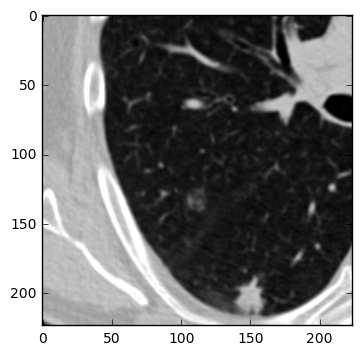

In [472]:
plt.imshow(test_image_good,cmap=plt.cm.gray)

In [473]:
test_image_good = load_array('/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_331355_224x224.bc')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_331355_224x224.bc/meta/sizes'

In [374]:
test_image_bad.shape

(224, 195)

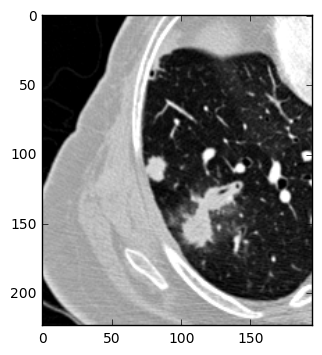

In [375]:
plt.imshow(test_image_bad,cmap=plt.cm.gray)

In [ ]:
cols = candidates_class1_df.columns.tolist()


In [ ]:
cols


In [ ]:
cols = [cols[0],cols[1],cols[5],cols[6],cols[7],cols[2],cols[3],cols[4],cols[8]]